In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

IQ signals Modulation_Label  \
0       [[-0.0059014712, -0.0023458179, -0.00074506126...             QPSK   
1       [[0.0050326153, 0.00094379985, -0.0018932355, ...             QPSK   
2       [[0.0052390713, 0.0073890695, 0.007276459, 0.0...             QPSK   
3       [[-0.0019859935, -0.0071501383, -0.00527185, -...             QPSK   
4       [[0.006674405, 0.0028359746, 0.005630027, 0.00...             QPSK   
...                                                   ...              ...   
219995  [[0.0062732296, -0.0050519477, 0.006672171, 0....             BPSK   
219996  [[-0.003903181, -0.0015884301, -0.00633375, 2....             BPSK   
219997  [[-0.0105958255, 0.005601244, -0.012161784, 0....             BPSK   
219998  [[-0.002136606, 0.00995837, 0.0059440527, -0.0...             BPSK   
219999  [[-0.008169517, 0.0013303901, -0.002522387, -0...             BPSK   

        SNR  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
219995  -18  
219996  -18  
219997  -18  
219998  -18  
219999  -18  

[220000 rows x 3 columns]

# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:58:43 - loss: 2.3979

  2/581 [..............................] - ETA: 35s - loss: 2.3979    

  3/581 [..............................] - ETA: 35s - loss: 2.3979

  4/581 [..............................] - ETA: 35s - loss: 2.3980

  5/581 [..............................] - ETA: 35s - loss: 2.3980

  6/581 [..............................] - ETA: 35s - loss: 2.3980

  7/581 [..............................] - ETA: 35s - loss: 2.3980

  8/581 [..............................] - ETA: 35s - loss: 2.3980

  9/581 [..............................] - ETA: 35s - loss: 2.3980

 10/581 [..............................] - ETA: 34s - loss: 2.3980

 11/581 [..............................] - ETA: 34s - loss: 2.3980

 12/581 [..............................] - ETA: 34s - loss: 2.3980

 13/581 [..............................] - ETA: 34s - loss: 2.3980

 14/581 [..............................] - ETA: 34s - loss: 2.3980



 15/581 [..............................] - ETA: 34s - loss: 2.3980

 16/581 [..............................] - ETA: 34s - loss: 2.3980

 17/581 [..............................] - ETA: 34s - loss: 2.3980

 18/581 [..............................] - ETA: 34s - loss: 2.3980

 19/581 [..............................] - ETA: 34s - loss: 2.3980

 20/581 [>.............................] - ETA: 34s - loss: 2.3980

 21/581 [>.............................] - ETA: 34s - loss: 2.3980

 22/581 [>.............................] - ETA: 34s - loss: 2.3980

 23/581 [>.............................] - ETA: 34s - loss: 2.3980

 24/581 [>.............................] - ETA: 34s - loss: 2.3980

 25/581 [>.............................] - ETA: 34s - loss: 2.3980

 26/581 [>.............................] - ETA: 34s - loss: 2.3980

 27/581 [>.............................] - ETA: 33s - loss: 2.3980

 28/581 [>.............................] - ETA: 33s - loss: 2.3980

 29/581 [>.............................] - ETA: 33s - loss: 2.3980

 30/581 [>.............................] - ETA: 33s - loss: 2.3980

 31/581 [>.............................] - ETA: 33s - loss: 2.3980

 32/581 [>.............................] - ETA: 33s - loss: 2.3980

 33/581 [>.............................] - ETA: 33s - loss: 2.3979

 34/581 [>.............................] - ETA: 33s - loss: 2.3979

 35/581 [>.............................] - ETA: 33s - loss: 2.3979

 36/581 [>.............................] - ETA: 33s - loss: 2.3979

 37/581 [>.............................] - ETA: 33s - loss: 2.3979

 38/581 [>.............................] - ETA: 33s - loss: 2.3979

 39/581 [=>............................] - ETA: 33s - loss: 2.3979

 40/581 [=>............................] - ETA: 33s - loss: 2.3979

 41/581 [=>............................] - ETA: 33s - loss: 2.3979



 42/581 [=>............................] - ETA: 32s - loss: 2.3979

 43/581 [=>............................] - ETA: 32s - loss: 2.3979

 44/581 [=>............................] - ETA: 32s - loss: 2.3979

 45/581 [=>............................] - ETA: 32s - loss: 2.3978

 46/581 [=>............................] - ETA: 32s - loss: 2.3978



 47/581 [=>............................] - ETA: 32s - loss: 2.3978

 48/581 [=>............................] - ETA: 32s - loss: 2.3978

 49/581 [=>............................] - ETA: 32s - loss: 2.3977

 50/581 [=>............................] - ETA: 32s - loss: 2.3977

 51/581 [=>............................] - ETA: 32s - loss: 2.3977

 52/581 [=>............................] - ETA: 32s - loss: 2.3976

 53/581 [=>............................] - ETA: 32s - loss: 2.3976

 54/581 [=>............................] - ETA: 32s - loss: 2.3975

 55/581 [=>............................] - ETA: 32s - loss: 2.3975

 56/581 [=>............................] - ETA: 32s - loss: 2.3974

 57/581 [=>............................] - ETA: 32s - loss: 2.3973

 58/581 [=>............................] - ETA: 32s - loss: 2.3972

 59/581 [==>...........................] - ETA: 31s - loss: 2.3971

 60/581 [==>...........................] - ETA: 31s - loss: 2.3970

 61/581 [==>...........................] - ETA: 31s - loss: 2.3968

 62/581 [==>...........................] - ETA: 31s - loss: 2.3967

 63/581 [==>...........................] - ETA: 31s - loss: 2.3965

 64/581 [==>...........................] - ETA: 31s - loss: 2.3963

 65/581 [==>...........................] - ETA: 31s - loss: 2.3962

 66/581 [==>...........................] - ETA: 31s - loss: 2.3959

 67/581 [==>...........................] - ETA: 31s - loss: 2.3957

 68/581 [==>...........................] - ETA: 31s - loss: 2.3955

 69/581 [==>...........................] - ETA: 31s - loss: 2.3952

 70/581 [==>...........................] - ETA: 31s - loss: 2.3950



 71/581 [==>...........................] - ETA: 31s - loss: 2.3947

 72/581 [==>...........................] - ETA: 31s - loss: 2.3944

 73/581 [==>...........................] - ETA: 31s - loss: 2.3940

 74/581 [==>...........................] - ETA: 31s - loss: 2.3937

 75/581 [==>...........................] - ETA: 30s - loss: 2.3934

 76/581 [==>...........................] - ETA: 30s - loss: 2.3930

 77/581 [==>...........................] - ETA: 30s - loss: 2.3926

 78/581 [===>..........................] - ETA: 30s - loss: 2.3923

 79/581 [===>..........................] - ETA: 30s - loss: 2.3919

 80/581 [===>..........................] - ETA: 30s - loss: 2.3915

 81/581 [===>..........................] - ETA: 30s - loss: 2.3911

 82/581 [===>..........................] - ETA: 30s - loss: 2.3907

 83/581 [===>..........................] - ETA: 30s - loss: 2.3902

 84/581 [===>..........................] - ETA: 30s - loss: 2.3898



 85/581 [===>..........................] - ETA: 30s - loss: 2.3894

 86/581 [===>..........................] - ETA: 30s - loss: 2.3889

 87/581 [===>..........................] - ETA: 30s - loss: 2.3885

 88/581 [===>..........................] - ETA: 30s - loss: 2.3880

 89/581 [===>..........................] - ETA: 30s - loss: 2.3876

 90/581 [===>..........................] - ETA: 30s - loss: 2.3871

 91/581 [===>..........................] - ETA: 30s - loss: 2.3866

 92/581 [===>..........................] - ETA: 29s - loss: 2.3862

 93/581 [===>..........................] - ETA: 29s - loss: 2.3857

 94/581 [===>..........................] - ETA: 29s - loss: 2.3852

 95/581 [===>..........................] - ETA: 29s - loss: 2.3847

 96/581 [===>..........................] - ETA: 29s - loss: 2.3842

 97/581 [====>.........................] - ETA: 29s - loss: 2.3837

 98/581 [====>.........................] - ETA: 29s - loss: 2.3832

 99/581 [====>.........................] - ETA: 29s - loss: 2.3827

100/581 [====>.........................] - ETA: 29s - loss: 2.3822

101/581 [====>.........................] - ETA: 29s - loss: 2.3817

102/581 [====>.........................] - ETA: 29s - loss: 2.3812

103/581 [====>.........................] - ETA: 29s - loss: 2.3807

104/581 [====>.........................] - ETA: 29s - loss: 2.3802



105/581 [====>.........................] - ETA: 29s - loss: 2.3796

106/581 [====>.........................] - ETA: 29s - loss: 2.3791

107/581 [====>.........................] - ETA: 29s - loss: 2.3786

108/581 [====>.........................] - ETA: 28s - loss: 2.3781

109/581 [====>.........................] - ETA: 28s - loss: 2.3776

110/581 [====>.........................] - ETA: 28s - loss: 2.3770

111/581 [====>.........................] - ETA: 28s - loss: 2.3765

112/581 [====>.........................] - ETA: 28s - loss: 2.3760

113/581 [====>.........................] - ETA: 28s - loss: 2.3754

114/581 [====>.........................] - ETA: 28s - loss: 2.3749

115/581 [====>.........................] - ETA: 28s - loss: 2.3744

116/581 [====>.........................] - ETA: 28s - loss: 2.3739

117/581 [=====>........................] - ETA: 28s - loss: 2.3734

118/581 [=====>........................] - ETA: 28s - loss: 2.3729

119/581 [=====>........................] - ETA: 28s - loss: 2.3723

120/581 [=====>........................] - ETA: 28s - loss: 2.3718



121/581 [=====>........................] - ETA: 28s - loss: 2.3713



122/581 [=====>........................] - ETA: 28s - loss: 2.3708

123/581 [=====>........................] - ETA: 28s - loss: 2.3703

124/581 [=====>........................] - ETA: 27s - loss: 2.3698

125/581 [=====>........................] - ETA: 27s - loss: 2.3693

126/581 [=====>........................] - ETA: 27s - loss: 2.3688

127/581 [=====>........................] - ETA: 27s - loss: 2.3683

128/581 [=====>........................] - ETA: 27s - loss: 2.3678

129/581 [=====>........................] - ETA: 27s - loss: 2.3673

130/581 [=====>........................] - ETA: 27s - loss: 2.3668

131/581 [=====>........................] - ETA: 27s - loss: 2.3663

132/581 [=====>........................] - ETA: 27s - loss: 2.3658

133/581 [=====>........................] - ETA: 27s - loss: 2.3652

134/581 [=====>........................] - ETA: 27s - loss: 2.3647

135/581 [=====>........................] - ETA: 27s - loss: 2.3642

136/581 [======>.......................] - ETA: 27s - loss: 2.3637

137/581 [======>.......................] - ETA: 27s - loss: 2.3632

138/581 [======>.......................] - ETA: 27s - loss: 2.3627

139/581 [======>.......................] - ETA: 27s - loss: 2.3622

140/581 [======>.......................] - ETA: 27s - loss: 2.3617

141/581 [======>.......................] - ETA: 26s - loss: 2.3613

142/581 [======>.......................] - ETA: 26s - loss: 2.3608

143/581 [======>.......................] - ETA: 26s - loss: 2.3603

144/581 [======>.......................] - ETA: 26s - loss: 2.3598



145/581 [======>.......................] - ETA: 26s - loss: 2.3593

146/581 [======>.......................] - ETA: 26s - loss: 2.3588

147/581 [======>.......................] - ETA: 26s - loss: 2.3583

148/581 [======>.......................] - ETA: 26s - loss: 2.3578

149/581 [======>.......................] - ETA: 26s - loss: 2.3573

150/581 [======>.......................] - ETA: 26s - loss: 2.3568

151/581 [======>.......................] - ETA: 26s - loss: 2.3563

152/581 [======>.......................] - ETA: 26s - loss: 2.3558

153/581 [======>.......................] - ETA: 26s - loss: 2.3553

154/581 [======>.......................] - ETA: 26s - loss: 2.3548

155/581 [=======>......................] - ETA: 26s - loss: 2.3544

156/581 [=======>......................] - ETA: 26s - loss: 2.3539

157/581 [=======>......................] - ETA: 25s - loss: 2.3534

158/581 [=======>......................] - ETA: 25s - loss: 2.3529

159/581 [=======>......................] - ETA: 25s - loss: 2.3524

160/581 [=======>......................] - ETA: 25s - loss: 2.3519

161/581 [=======>......................] - ETA: 25s - loss: 2.3514

162/581 [=======>......................] - ETA: 25s - loss: 2.3509

163/581 [=======>......................] - ETA: 25s - loss: 2.3505

164/581 [=======>......................] - ETA: 25s - loss: 2.3500

165/581 [=======>......................] - ETA: 25s - loss: 2.3495

166/581 [=======>......................] - ETA: 25s - loss: 2.3490

167/581 [=======>......................] - ETA: 25s - loss: 2.3485

168/581 [=======>......................] - ETA: 25s - loss: 2.3480

169/581 [=======>......................] - ETA: 25s - loss: 2.3475

170/581 [=======>......................] - ETA: 25s - loss: 2.3471

171/581 [=======>......................] - ETA: 25s - loss: 2.3466

172/581 [=======>......................] - ETA: 25s - loss: 2.3461

173/581 [=======>......................] - ETA: 25s - loss: 2.3456

174/581 [=======>......................] - ETA: 24s - loss: 2.3451

175/581 [========>.....................] - ETA: 24s - loss: 2.3447

176/581 [========>.....................] - ETA: 24s - loss: 2.3442

177/581 [========>.....................] - ETA: 24s - loss: 2.3437

178/581 [========>.....................]

 - ETA: 24s - loss: 2.3432

179/581 [========>.....................] - ETA: 24s - loss: 2.3428

180/581 [========>.....................] - ETA: 24s - loss: 2.3423

181/581 [========>.....................] - ETA: 24s - loss: 2.3418

182/581 [========>.....................] - ETA: 24s - loss: 2.3414

183/581 [========>.....................] - ETA: 24s - loss: 2.3409

184/581 [========>.....................] - ETA: 24s - loss: 2.3404

185/581 [========>.....................] - ETA: 24s - loss: 2.3399

186/581 [========>.....................] - ETA: 24s - loss: 2.3395

187/581 [========>.....................] - ETA: 24s - loss: 2.3390

188/581 [========>.....................] - ETA: 24s - loss: 2.3385

189/581 [========>.....................] - ETA: 24s - loss: 2.3381

190/581 [========>.....................] - ETA: 23s - loss: 2.3376

191/581 [========>.....................] - ETA: 23s - loss: 2.3372

192/581 [========>.....................] - ETA: 23s - loss: 2.3367

193/581 [========>.....................] - ETA: 23s - loss: 2.3362

194/581 [=========>....................] - ETA: 23s - loss: 2.3358

195/581 [=========>....................] - ETA: 23s - loss: 2.3353

196/581 [=========>....................] - ETA: 23s - loss: 2.3348

197/581 [=========>....................] - ETA: 23s - loss: 2.3344

198/581 [=========>....................] - ETA: 23s - loss: 2.3339

199/581 [=========>....................] - ETA: 23s - loss: 2.3335

200/581 [=========>....................] - ETA: 23s - loss: 2.3330

201/581 [=========>....................] - ETA: 23s - loss: 2.3326

202/581 [=========>....................] - ETA: 23s - loss: 2.3321

203/581 [=========>....................] - ETA: 23s - loss: 2.3316

204/581 [=========>....................] - ETA: 23s - loss: 2.3312

205/581 [=========>....................] - ETA: 23s - loss: 2.3307

206/581 [=========>....................] - ETA: 22s - loss: 2.3303

207/581 [=========>....................] - ETA: 22s - loss: 2.3298

208/581 [=========>....................] - ETA: 22s - loss: 2.3294

209/581 [=========>....................] - ETA: 22s - loss: 2.3289

210/581 [=========>....................] - ETA: 22s - loss: 2.3285

211/581 [=========>....................] - ETA: 22s - loss: 2.3281

212/581 [=========>....................] - ETA: 22s - loss: 2.3276

213/581 [=========>....................] - ETA: 22s - loss: 2.3272

214/581 [==========>...................] - ETA: 22s - loss: 2.3267

215/581 [==========>...................] - ETA: 22s - loss: 2.3263

216/581 [==========>...................] - ETA: 22s - loss: 2.3258

217/581 [==========>...................] - ETA: 22s - loss: 2.3254

218/581 [==========>...................] - ETA: 22s - loss: 2.3249

219/581 [==========>...................] - ETA: 22s - loss: 2.3245

220/581 [==========>...................] - ETA: 22s - loss: 2.3241

221/581 [==========>...................] - ETA: 22s - loss: 2.3236

222/581 [==========>...................] - ETA: 22s - loss: 2.3232

223/581 [==========>...................] - ETA: 21s - loss: 2.3228

224/581 [==========>...................] - ETA: 21s - loss: 2.3223

225/581 [==========>...................] - ETA: 21s - loss: 2.3219

226/581 [==========>...................] - ETA: 21s - loss: 2.3215

227/581 [==========>...................] - ETA: 21s - loss: 2.3210

228/581 [==========>...................] - ETA: 21s - loss: 2.3206

229/581 [==========>...................] - ETA: 21s - loss: 2.3202

230/581 [==========>...................] - ETA: 21s - loss: 2.3197

231/581 [==========>...................] - ETA: 21s - loss: 2.3193

232/581 [==========>...................] - ETA: 21s - loss: 2.3189

233/581 [===========>..................] - ETA: 21s - loss: 2.3184

234/581 [===========>..................] - ETA: 21s - loss: 2.3180

235/581 [===========>..................] - ETA: 21s - loss: 2.3176

236/581 [===========>..................] - ETA: 21s - loss: 2.3171

237/581 [===========>..................] - ETA: 21s - loss: 2.3167

238/581 [===========>..................]

 - ETA: 21s - loss: 2.3163

239/581 [===========>..................] - ETA: 20s - loss: 2.3159

240/581 [===========>..................] - ETA: 20s - loss: 2.3154

241/581 [===========>..................] - ETA: 20s - loss: 2.3150

242/581 [===========>..................] - ETA: 20s - loss: 2.3146

243/581 [===========>..................] - ETA: 20s - loss: 2.3142

244/581 [===========>..................] - ETA: 20s - loss: 2.3137

245/581 [===========>..................] - ETA: 20s - loss: 2.3133

246/581 [===========>..................] - ETA: 20s - loss: 2.3129

247/581 [===========>..................] - ETA: 20s - loss: 2.3125

248/581 [===========>..................] - ETA: 20s - loss: 2.3120

249/581 [===========>..................] - ETA: 20s - loss: 2.3116

250/581 [===========>..................] - ETA: 20s - loss: 2.3112

251/581 [===========>..................] - ETA: 20s - loss: 2.3108

252/581 [============>.................] - ETA: 20s - loss: 2.3103

253/581 [============>.................] - ETA: 20s - loss: 2.3099

254/581 [============>.................] - ETA: 20s - loss: 2.3095

255/581 [============>.................] - ETA: 20s - loss: 2.3091

256/581 [============>.................] - ETA: 19s - loss: 2.3086

257/581 [============>.................] - ETA: 19s - loss: 2.3082

258/581 [============>.................] - ETA: 19s - loss: 2.3078

259/581 [============>.................] - ETA: 19s - loss: 2.3073

260/581 [============>.................] - ETA: 19s - loss: 2.3069

261/581 [============>.................] - ETA: 19s - loss: 2.3065

262/581 [============>.................] - ETA: 19s - loss: 2.3061

263/581 [============>.................] - ETA: 19s - loss: 2.3057

264/581 [============>.................] - ETA: 19s - loss: 2.3052

265/581 [============>.................] - ETA: 19s - loss: 2.3048

266/581 [============>.................] - ETA: 19s - loss: 2.3044

267/581 [============>.................] - ETA: 19s - loss: 2.3040

268/581 [============>.................] - ETA: 19s - loss: 2.3035

269/581 [============>.................] - ETA: 19s - loss: 2.3031

270/581 [============>.................] - ETA: 19s - loss: 2.3027

271/581 [============>.................] - ETA: 19s - loss: 2.3023

272/581 [=============>................] - ETA: 18s - loss: 2.3018

273/581 [=============>................] - ETA: 18s - loss: 2.3014

274/581 [=============>................] - ETA: 18s - loss: 2.3010

275/581 [=============>................] - ETA: 18s - loss: 2.3006

276/581 [=============>................] - ETA: 18s - loss: 2.3001

277/581 [=============>................] - ETA: 18s - loss: 2.2997

278/581 [=============>................] - ETA: 18s - loss: 2.2993

279/581 [=============>................] - ETA: 18s - loss: 2.2989

280/581 [=============>................] - ETA: 18s - loss: 2.2984

281/581 [=============>................] - ETA: 18s - loss: 2.2980

282/581 [=============>................] - ETA: 18s - loss: 2.2976

283/581 [=============>................] - ETA: 18s - loss: 2.2972

284/581 [=============>................] - ETA: 18s - loss: 2.2967

285/581 [=============>................] - ETA: 18s - loss: 2.2963

286/581 [=============>................] - ETA: 18s - loss: 2.2959

287/581 [=============>................] - ETA: 18s - loss: 2.2955

288/581 [=============>................] - ETA: 17s - loss: 2.2950

289/581 [=============>................] - ETA: 17s - loss: 2.2946

290/581 [=============>................] - ETA: 17s - loss: 2.2942

291/581 [==============>...............] - ETA: 17s - loss: 2.2937

292/581 [==============>...............] - ETA: 17s - loss: 2.2933

293/581 [==============>...............] - ETA: 17s - loss: 2.2929

294/581 [==============>...............] - ETA: 17s - loss: 2.2925

295/581 [==============>...............] - ETA: 17s - loss: 2.2920

296/581 [==============>...............] - ETA: 17s - loss: 2.2916

297/581 [==============>...............] - ETA: 17s - loss: 2.2912

298/581 [==============>...............] - ETA: 17s - loss: 2.2907

299/581 [==============>...............] - ETA: 17s - loss: 2.2903

300/581 [==============>...............] - ETA: 17s - loss: 2.2899

301/581 [==============>...............] - ETA: 17s - loss: 2.2895

302/581 [==============>...............] - ETA: 17s - loss: 2.2890

303/581 [==============>...............] - ETA: 17s - loss: 2.2886

304/581 [==============>...............] - ETA: 16s - loss: 2.2882

305/581 [==============>...............] - ETA: 16s - loss: 2.2877

306/581 [==============>...............] - ETA: 16s - loss: 2.2873

307/581 [==============>...............] - ETA: 16s - loss: 2.2869

308/581 [==============>...............] - ETA: 16s - loss: 2.2864

309/581 [==============>...............] - ETA: 16s - loss: 2.2860

310/581 [===============>..............] - ETA: 16s - loss: 2.2856

311/581 [===============>..............] - ETA: 16s - loss: 2.2852

312/581 [===============>..............] - ETA: 16s - loss: 2.2847

313/581 [===============>..............] - ETA: 16s - loss: 2.2843

314/581 [===============>..............] - ETA: 16s - loss: 2.2839

315/581 [===============>..............] - ETA: 16s - loss: 2.2834



316/581 [===============>..............] - ETA: 16s - loss: 2.2830

317/581 [===============>..............] - ETA: 16s - loss: 2.2826

318/581 [===============>..............] - ETA: 16s - loss: 2.2821

319/581 [===============>..............] - ETA: 16s - loss: 2.2817

320/581 [===============>..............] - ETA: 16s - loss: 2.2813

321/581 [===============>..............] - ETA: 15s - loss: 2.2808

322/581 [===============>..............] - ETA: 15s - loss: 2.2804

323/581 [===============>..............] - ETA: 15s - loss: 2.2800

324/581 [===============>..............] - ETA: 15s - loss: 2.2795

325/581 [===============>..............] - ETA: 15s - loss: 2.2791

326/581 [===============>..............] - ETA: 15s - loss: 2.2787

327/581 [===============>..............] - ETA: 15s - loss: 2.2782

328/581 [===============>..............] - ETA: 15s - loss: 2.2778

329/581 [===============>..............] - ETA: 15s - loss: 2.2774

330/581 [================>.............] - ETA: 15s - loss: 2.2769

331/581 [================>.............] - ETA: 15s - loss: 2.2765

332/581 [================>.............] - ETA: 15s - loss: 2.2761

333/581 [================>.............] - ETA: 15s - loss: 2.2756

334/581 [================>.............] - ETA: 15s - loss: 2.2752

335/581 [================>.............] - ETA: 15s - loss: 2.2748

336/581 [================>.............] - ETA: 15s - loss: 2.2743

337/581 [================>.............] - ETA: 14s - loss: 2.2739

338/581 [================>.............] - ETA: 14s - loss: 2.2735

339/581 [================>.............] - ETA: 14s - loss: 2.2730

340/581 [================>.............] - ETA: 14s - loss: 2.2726

341/581 [================>.............] - ETA: 14s - loss: 2.2721

342/581 [================>.............] - ETA: 14s - loss: 2.2717

343/581 [================>.............] - ETA: 14s - loss: 2.2713

344/581 [================>.............] - ETA: 14s - loss: 2.2708

345/581 [================>.............] - ETA: 14s - loss: 2.2704

346/581 [================>.............] - ETA: 14s - loss: 2.2700

347/581 [================>.............] - ETA: 14s - loss: 2.2695

348/581 [================>.............] - ETA: 14s - loss: 2.2691

349/581 [=================>............] - ETA: 14s - loss: 2.2687

350/581 [=================>............] - ETA: 14s - loss: 2.2682

351/581 [=================>............] - ETA: 14s - loss: 2.2678

352/581 [=================>............] - ETA: 14s - loss: 2.2674

353/581 [=================>............] - ETA: 13s - loss: 2.2669

354/581 [=================>............] - ETA: 13s - loss: 2.2665

355/581 [=================>............] - ETA: 13s - loss: 2.2661

356/581 [=================>............] - ETA: 13s - loss: 2.2656

357/581 [=================>............] - ETA: 13s - loss: 2.2652

358/581 [=================>............] - ETA: 13s - loss: 2.2648

359/581 [=================>............] - ETA: 13s - loss: 2.2643

360/581 [=================>............] - ETA: 13s - loss: 2.2639

361/581 [=================>............] - ETA: 13s - loss: 2.2635

362/581 [=================>............] - ETA: 13s - loss: 2.2630

363/581 [=================>............] - ETA: 13s - loss: 2.2626

364/581 [=================>............] - ETA: 13s - loss: 2.2621

365/581 [=================>............] - ETA: 13s - loss: 2.2617

366/581 [=================>............] - ETA: 13s - loss: 2.2613



367/581 [=================>............] - ETA: 13s - loss: 2.2608

368/581 [==================>...........] - ETA: 13s - loss: 2.2604

369/581 [==================>...........] - ETA: 13s - loss: 2.2600

370/581 [==================>...........] - ETA: 12s - loss: 2.2595

371/581 [==================>...........] - ETA: 12s - loss: 2.2591

372/581 [==================>...........] - ETA: 12s - loss: 2.2587

373/581 [==================>...........] - ETA: 12s - loss: 2.2583

374/581 [==================>...........] - ETA: 12s - loss: 2.2578

375/581 [==================>...........] - ETA: 12s - loss: 2.2574

376/581 [==================>...........] - ETA: 12s - loss: 2.2570

377/581 [==================>...........] - ETA: 12s - loss: 2.2565

378/581 [==================>...........] - ETA: 12s - loss: 2.2561

379/581 [==================>...........] - ETA: 12s - loss: 2.2557

380/581 [==================>...........] - ETA: 12s - loss: 2.2552

381/581 [==================>...........] - ETA: 12s - loss: 2.2548

382/581 [==================>...........] - ETA: 12s - loss: 2.2544

383/581 [==================>...........] - ETA: 12s - loss: 2.2539

384/581 [==================>...........] - ETA: 12s - loss: 2.2535

385/581 [==================>...........] - ETA: 12s - loss: 2.2531

386/581 [==================>...........] - ETA: 11s - loss: 2.2526

387/581 [==================>...........] - ETA: 11s - loss: 2.2522

388/581 [===================>..........] - ETA: 11s - loss: 2.2518

389/581 [===================>..........] - ETA: 11s - loss: 2.2513

390/581 [===================>..........] - ETA: 11s - loss: 2.2509

391/581 [===================>..........] - ETA: 11s - loss: 2.2505

392/581 [===================>..........] - ETA: 11s - loss: 2.2501

393/581 [===================>..........] - ETA: 11s - loss: 2.2496

394/581 [===================>..........] - ETA: 11s - loss: 2.2492

395/581 [===================>..........] - ETA: 11s - loss: 2.2488

396/581 [===================>..........] - ETA: 11s - loss: 2.2483

397/581 [===================>..........] - ETA: 11s - loss: 2.2479

398/581 [===================>..........] - ETA: 11s - loss: 2.2475

399/581 [===================>..........] - ETA: 11s - loss: 2.2471

400/581 [===================>..........] - ETA: 11s - loss: 2.2466

401/581 [===================>..........] - ETA: 11s - loss: 2.2462

402/581 [===================>..........] - ETA: 10s - loss: 2.2458

403/581 [===================>..........] - ETA: 10s - loss: 2.2453

404/581 [===================>..........] - ETA: 10s - loss: 2.2449

405/581 [===================>..........] - ETA: 10s - loss: 2.2445

406/581 [===================>..........] - ETA: 10s - loss: 2.2441

407/581 [====================>.........] - ETA: 10s - loss: 2.2436

408/581 [====================>.........] - ETA: 10s - loss: 2.2432

409/581 [====================>.........] - ETA: 10s - loss: 2.2428

410/581 [====================>.........] - ETA: 10s - loss: 2.2424

411/581 [====================>.........] - ETA: 10s - loss: 2.2419

412/581 [====================>.........] - ETA: 10s - loss: 2.2415

413/581 [====================>.........] - ETA: 10s - loss: 2.2411

414/581 [====================>.........] - ETA: 10s - loss: 2.2407

415/581 [====================>.........] - ETA: 10s - loss: 2.2403

416/581 [====================>.........] - ETA: 10s - loss: 2.2398

417/581 [====================>.........] - ETA: 10s - loss: 2.2394

418/581 [====================>.........] - ETA: 10s - loss: 2.2390

419/581 [====================>.........] - ETA: 9s - loss: 2.2386 

420/581 [====================>.........] - ETA: 9s - loss: 2.2381

421/581 [====================>.........] - ETA: 9s - loss: 2.2377

422/581 [====================>.........] - ETA: 9s - loss: 2.2373

423/581 [====================>.........] - ETA: 9s - loss: 2.2369

424/581 [====================>.........] - ETA: 9s - loss: 2.2365

425/581 [====================>.........] - ETA: 9s - loss: 2.2360

426/581 [====================>.........] - ETA: 9s - loss: 2.2356

427/581 [=====================>........] - ETA: 9s - loss: 2.2352

428/581 [=====================>........] - ETA: 9s - loss: 2.2348

429/581 [=====================>........] - ETA: 9s - loss: 2.2344

430/581 [=====================>........] - ETA: 9s - loss: 2.2339

431/581 [=====================>........] - ETA: 9s - loss: 2.2335

432/581 [=====================>........] - ETA: 9s - loss: 2.2331

433/581 [=====================>........] - ETA: 9s - loss: 2.2327

434/581 [=====================>........] - ETA: 9s - loss: 2.2323

435/581 [=====================>........] - ETA: 8s - loss: 2.2318

436/581 [=====================>........] - ETA: 8s - loss: 2.2314

437/581 [=====================>........] - ETA: 8s - loss: 2.2310

438/581 [=====================>........] - ETA: 8s - loss: 2.2306

439/581 [=====================>........] - ETA: 8s - loss: 2.2302

440/581 [=====================>........] - ETA: 8s - loss: 2.2298

441/581 [=====================>........] - ETA: 8s - loss: 2.2293

442/581 [=====================>........] - ETA: 8s - loss: 2.2289

443/581 [=====================>........] - ETA: 8s - loss: 2.2285

444/581 [=====================>........] - ETA: 8s - loss: 2.2281

445/581 [=====================>........] - ETA: 8s - loss: 2.2277

446/581 [======================>.......] - ETA: 8s - loss: 2.2273

447/581 [======================>.......] - ETA: 8s - loss: 2.2269

448/581 [======================>.......] - ETA: 8s - loss: 2.2264

449/581 [======================>.......] - ETA: 8s - loss: 2.2260

450/581 [======================>.......] - ETA: 8s - loss: 2.2256

451/581 [======================>.......] - ETA: 7s - loss: 2.2252

452/581 [======================>.......] - ETA: 7s - loss: 2.2248

453/581 [======================>.......] - ETA: 7s - loss: 2.2244

454/581 [======================>.......] - ETA: 7s - loss: 2.2240

455/581 [======================>.......] - ETA: 7s - loss: 2.2236

456/581 [======================>.......] - ETA: 7s - loss: 2.2232

457/581 [======================>.......] - ETA: 7s - loss: 2.2227

458/581 [======================>.......] - ETA: 7s - loss: 2.2223

459/581 [======================>.......] - ETA: 7s - loss: 2.2219

460/581 [======================>.......] - ETA: 7s - loss: 2.2215

461/581 [======================>.......] - ETA: 7s - loss: 2.2211

462/581 [======================>.......] - ETA: 7s - loss: 2.2207

463/581 [======================>.......] - ETA: 7s - loss: 2.2203

464/581 [======================>.......] - ETA: 7s - loss: 2.2199

465/581 [=======================>......] - ETA: 7s - loss: 2.2195

466/581 [=======================>......] - ETA: 7s - loss: 2.2191

467/581 [=======================>......] - ETA: 6s - loss: 2.2187

468/581 [=======================>......] - ETA: 6s - loss: 2.2183

469/581 [=======================>......] - ETA: 6s - loss: 2.2179

470/581 [=======================>......] - ETA: 6s - loss: 2.2174

471/581 [=======================>......] - ETA: 6s - loss: 2.2170

472/581 [=======================>......] - ETA: 6s - loss: 2.2166

473/581 [=======================>......] - ETA: 6s - loss: 2.2162

474/581 [=======================>......] - ETA: 6s - loss: 2.2158

475/581 [=======================>......] - ETA: 6s - loss: 2.2154

476/581 [=======================>......] - ETA: 6s - loss: 2.2150

477/581 [=======================>......] - ETA: 6s - loss: 2.2146

478/581 [=======================>......] - ETA: 6s - loss: 2.2142

479/581 [=======================>......] - ETA: 6s - loss: 2.2138



480/581 [=======================>......] - ETA: 6s - loss: 2.2134



481/581 [=======================>......] - ETA: 6s - loss: 2.2130

482/581 [=======================>......] - ETA: 6s - loss: 2.2126

483/581 [=======================>......] - ETA: 6s - loss: 2.2122

484/581 [=======================>......] - ETA: 5s - loss: 2.2118

485/581 [========================>.....] - ETA: 5s - loss: 2.2114

486/581 [========================>.....] - ETA: 5s - loss: 2.2110

487/581 [========================>.....] - ETA: 5s - loss: 2.2106

488/581 [========================>.....] - ETA: 5s - loss: 2.2102

489/581 [========================>.....] - ETA: 5s - loss: 2.2098

490/581 [========================>.....] - ETA: 5s - loss: 2.2094

491/581 [========================>.....] - ETA: 5s - loss: 2.2090

492/581 [========================>.....] - ETA: 5s - loss: 2.2086

493/581 [========================>.....] - ETA: 5s - loss: 2.2082

494/581 [========================>.....] - ETA: 5s - loss: 2.2078

495/581 [========================>.....] - ETA: 5s - loss: 2.2074

496/581 [========================>.....] - ETA: 5s - loss: 2.2070

497/581 [========================>.....] - ETA: 5s - loss: 2.2066

498/581 [========================>.....] - ETA: 5s - loss: 2.2062

499/581 [========================>.....] - ETA: 5s - loss: 2.2058

500/581 [========================>.....] - ETA: 4s - loss: 2.2054

501/581 [========================>.....] - ETA: 4s - loss: 2.2050

502/581 [========================>.....] - ETA: 4s - loss: 2.2046

503/581 [========================>.....] - ETA: 4s - loss: 2.2042

504/581 [=========================>....] - ETA: 4s - loss: 2.2038

505/581 [=========================>....] - ETA: 4s - loss: 2.2034

506/581 [=========================>....] - ETA: 4s - loss: 2.2030

507/581 [=========================>....] - ETA: 4s - loss: 2.2026

508/581 [=========================>....] - ETA: 4s - loss: 2.2022

509/581 [=========================>....] - ETA: 4s - loss: 2.2018

510/581 [=========================>....] - ETA: 4s - loss: 2.2014

511/581 [=========================>....] - ETA: 4s - loss: 2.2010

512/581 [=========================>....] - ETA: 4s - loss: 2.2006

513/581 [=========================>....] - ETA: 4s - loss: 2.2002

514/581 [=========================>....] - ETA: 4s - loss: 2.1999

515/581 [=========================>....] - ETA: 4s - loss: 2.1995

516/581 [=========================>....] - ETA: 3s - loss: 2.1991

517/581 [=========================>....] - ETA: 3s - loss: 2.1987

518/581 [=========================>....] - ETA: 3s - loss: 2.1983

519/581 [=========================>....] - ETA: 3s - loss: 2.1979

520/581 [=========================>....] - ETA: 3s - loss: 2.1975

521/581 [=========================>....] - ETA: 3s - loss: 2.1971

522/581 [=========================>....] - ETA: 3s - loss: 2.1967

523/581 [==========================>...] - ETA: 3s - loss: 2.1963

524/581 [==========================>...] - ETA: 3s - loss: 2.1959

525/581 [==========================>...] - ETA: 3s - loss: 2.1955

526/581 [==========================>...] - ETA: 3s - loss: 2.1952

527/581 [==========================>...] - ETA: 3s - loss: 2.1948

528/581 [==========================>...] - ETA: 3s - loss: 2.1944

529/581 [==========================>...] - ETA: 3s - loss: 2.1940

530/581 [==========================>...] - ETA: 3s - loss: 2.1936

531/581 [==========================>...] - ETA: 3s - loss: 2.1932

532/581 [==========================>...] - ETA: 3s - loss: 2.1928

533/581 [==========================>...] - ETA: 2s - loss: 2.1924

534/581 [==========================>...] - ETA: 2s - loss: 2.1920

535/581 [==========================>...] - ETA: 2s - loss: 2.1917

536/581 [==========================>...] - ETA: 2s - loss: 2.1913

537/581 [==========================>...] - ETA: 2s - loss: 2.1909

538/581 [==========================>...] - ETA: 2s - loss: 2.1905

539/581 [==========================>...] - ETA: 2s - loss: 2.1901

540/581 [==========================>...] - ETA: 2s - loss: 2.1897

541/581 [==========================>...] - ETA: 2s - loss: 2.1893

542/581 [==========================>...] - ETA: 2s - loss: 2.1890

543/581 [===========================>..] - ETA: 2s - loss: 2.1886

544/581 [===========================>..] - ETA: 2s - loss: 2.1882

545/581 [===========================>..] - ETA: 2s - loss: 2.1878

546/581 [===========================>..] - ETA: 2s - loss: 2.1874

547/581 [===========================>..] - ETA: 2s - loss: 2.1870

548/581 [===========================>..] - ETA: 2s - loss: 2.1866

549/581 [===========================>..] - ETA: 1s - loss: 2.1863

550/581 [===========================>..] - ETA: 1s - loss: 2.1859

551/581 [===========================>..] - ETA: 1s - loss: 2.1855

552/581 [===========================>..] - ETA: 1s - loss: 2.1851

553/581 [===========================>..] - ETA: 1s - loss: 2.1847

554/581 [===========================>..] - ETA: 1s - loss: 2.1844

555/581 [===========================>..] - ETA: 1s - loss: 2.1840

556/581 [===========================>..] - ETA: 1s - loss: 2.1836

557/581 [===========================>..] - ETA: 1s - loss: 2.1832

558/581 [===========================>..] - ETA: 1s - loss: 2.1828

559/581 [===========================>..] - ETA: 1s - loss: 2.1824

560/581 [===========================>..] - ETA: 1s - loss: 2.1821

561/581 [===========================>..] - ETA: 1s - loss: 2.1817

562/581 [============================>.] - ETA: 1s - loss: 2.1813

563/581 [============================>.] - ETA: 1s - loss: 2.1809

564/581 [============================>.] - ETA: 1s - loss: 2.1805

565/581 [============================>.] - ETA: 0s - loss: 2.1802

566/581 [============================>.] - ETA: 0s - loss: 2.1798

567/581 [============================>.] - ETA: 0s - loss: 2.1794

568/581 [============================>.] - ETA: 0s - loss: 2.1790

569/581 [============================>.] - ETA: 0s - loss: 2.1787

570/581 [============================>.] - ETA: 0s - loss: 2.1783

571/581 [============================>.] - ETA: 0s - loss: 2.1779

572/581 [============================>.] - ETA: 0s - loss: 2.1775

573/581 [============================>.] - ETA: 0s - loss: 2.1771

574/581 [============================>.] - ETA: 0s - loss: 2.1768

575/581 [============================>.] - ETA: 0s - loss: 2.1764

576/581 [============================>.] - ETA: 0s - loss: 2.1760

577/581 [============================>.] - ETA: 0s - loss: 2.1756

578/581 [============================>.] - ETA: 0s - loss: 2.1753

579/581 [============================>.] - ETA: 0s - loss: 2.1749

580/581 [============================>.] - ETA: 0s - loss: 2.1745

581/581 [==============================] - ETA: 0s - loss: 2.1741

581/581 [==============================] - 50s 65ms/step - loss: 2.1738 - val_loss: 1.7002


Epoch 2/100
  1/581 [..............................] - ETA: 34s - loss: 1.7039

  2/581 [..............................] - ETA: 35s - loss: 1.6855

  3/581 [..............................] - ETA: 35s - loss: 1.6754

  4/581 [..............................] - ETA: 35s - loss: 1.6783

  5/581 [..............................] - ETA: 35s - loss: 1.6776

  6/581 [..............................] - ETA: 35s - loss: 1.6766

  7/581 [..............................] - ETA: 35s - loss: 1.6759

  8/581 [..............................] - ETA: 35s - loss: 1.6746

  9/581 [..............................] - ETA: 34s - loss: 1.6744

 10/581 [..............................] - ETA: 34s - loss: 1.6744

 11/581 [..............................] - ETA: 34s - loss: 1.6739

 12/581 [..............................] - ETA: 34s - loss: 1.6732

 13/581 [..............................] - ETA: 34s - loss: 1.6720

 14/581 [..............................] - ETA: 34s - loss: 1.6709

 15/581 [..............................] - ETA: 34s - loss: 1.6697

 16/581 [..............................] - ETA: 34s - loss: 1.6687

 17/581 [..............................] - ETA: 34s - loss: 1.6677

 18/581 [..............................] - ETA: 34s - loss: 1.6666

 19/581 [..............................] - ETA: 34s - loss: 1.6654

 20/581 [>.............................] - ETA: 34s - loss: 1.6644

 21/581 [>.............................] - ETA: 34s - loss: 1.6634

 22/581 [>.............................] - ETA: 34s - loss: 1.6625

 23/581 [>.............................] - ETA: 34s - loss: 1.6617

 24/581 [>.............................] - ETA: 34s - loss: 1.6609

 25/581 [>.............................] - ETA: 33s - loss: 1.6601

 26/581 [>.............................] - ETA: 33s - loss: 1.6593

 27/581 [>.............................] - ETA: 33s - loss: 1.6586

 28/581 [>.............................] - ETA: 33s - loss: 1.6580

 29/581 [>.............................] - ETA: 33s - loss: 1.6575

 30/581 [>.............................] - ETA: 33s - loss: 1.6570

 31/581 [>.............................] - ETA: 33s - loss: 1.6565

 32/581 [>.............................] - ETA: 33s - loss: 1.6561

 33/581 [>.............................] - ETA: 33s - loss: 1.6556

 34/581 [>.............................] - ETA: 33s - loss: 1.6551

 35/581 [>.............................] - ETA: 33s - loss: 1.6546

 36/581 [>.............................] - ETA: 33s - loss: 1.6541

 37/581 [>.............................] - ETA: 33s - loss: 1.6537

 38/581 [>.............................] - ETA: 33s - loss: 1.6533

 39/581 [=>............................] - ETA: 33s - loss: 1.6528

 40/581 [=>............................] - ETA: 33s - loss: 1.6524

 41/581 [=>............................] - ETA: 32s - loss: 1.6520

 42/581 [=>............................] - ETA: 32s - loss: 1.6515

 43/581 [=>............................] - ETA: 32s - loss: 1.6511

 44/581 [=>............................] - ETA: 32s - loss: 1.6507

 45/581 [=>............................] - ETA: 32s - loss: 1.6503

 46/581 [=>............................] - ETA: 32s - loss: 1.6499

 47/581 [=>............................] - ETA: 32s - loss: 1.6495

 48/581 [=>............................] - ETA: 32s - loss: 1.6491

 49/581 [=>............................] - ETA: 32s - loss: 1.6487

 50/581 [=>............................] - ETA: 32s - loss: 1.6482

 51/581 [=>............................] - ETA: 32s - loss: 1.6478

 52/581 [=>............................] - ETA: 32s - loss: 1.6474

 53/581 [=>............................] - ETA: 32s - loss: 1.6470

 54/581 [=>............................] - ETA: 32s - loss: 1.6466

 55/581 [=>............................] - ETA: 32s - loss: 1.6462

 56/581 [=>............................] - ETA: 32s - loss: 1.6458

 57/581 [=>............................] - ETA: 32s - loss: 1.6453

 58/581 [=>............................] - ETA: 31s - loss: 1.6449

 59/581 [==>...........................] - ETA: 31s - loss: 1.6445

 60/581 [==>...........................] - ETA: 31s - loss: 1.6441

 61/581 [==>...........................] - ETA: 31s - loss: 1.6437

 62/581 [==>...........................] - ETA: 31s - loss: 1.6433

 63/581 [==>...........................] - ETA: 31s - loss: 1.6429

 64/581 [==>...........................] - ETA: 31s - loss: 1.6425

 65/581 [==>...........................] - ETA: 31s - loss: 1.6421

 66/581 [==>...........................] - ETA: 31s - loss: 1.6417

 67/581 [==>...........................] - ETA: 31s - loss: 1.6414

 68/581 [==>...........................] - ETA: 31s - loss: 1.6410

 69/581 [==>...........................] - ETA: 31s - loss: 1.6406

 70/581 [==>...........................] - ETA: 31s - loss: 1.6403

 71/581 [==>...........................] - ETA: 31s - loss: 1.6399

 72/581 [==>...........................] - ETA: 31s - loss: 1.6396

 73/581 [==>...........................] - ETA: 31s - loss: 1.6393

 74/581 [==>...........................] - ETA: 30s - loss: 1.6389

 75/581 [==>...........................] - ETA: 30s - loss: 1.6386

 76/581 [==>...........................] - ETA: 30s - loss: 1.6383

 77/581 [==>...........................] - ETA: 30s - loss: 1.6379

 78/581 [===>..........................] - ETA: 30s - loss: 1.6376

 79/581 [===>..........................] - ETA: 30s - loss: 1.6373

 80/581 [===>..........................] - ETA: 30s - loss: 1.6370

 81/581 [===>..........................] - ETA: 30s - loss: 1.6367

 82/581 [===>..........................] - ETA: 30s - loss: 1.6364

 83/581 [===>..........................] - ETA: 30s - loss: 1.6361

 84/581 [===>..........................] - ETA: 30s - loss: 1.6359

 85/581 [===>..........................] - ETA: 30s - loss: 1.6356

 86/581 [===>..........................] - ETA: 30s - loss: 1.6353

 87/581 [===>..........................] - ETA: 30s - loss: 1.6350

 88/581 [===>..........................] - ETA: 30s - loss: 1.6348

 89/581 [===>..........................] - ETA: 30s - loss: 1.6345

 90/581 [===>..........................] - ETA: 30s - loss: 1.6343

 91/581 [===>..........................] - ETA: 29s - loss: 1.6340

 92/581 [===>..........................] - ETA: 29s - loss: 1.6337

 93/581 [===>..........................] - ETA: 29s - loss: 1.6335

 94/581 [===>..........................] - ETA: 29s - loss: 1.6333

 95/581 [===>..........................] - ETA: 29s - loss: 1.6330

 96/581 [===>..........................] - ETA: 29s - loss: 1.6328

 97/581 [====>.........................] - ETA: 29s - loss: 1.6325

 98/581 [====>.........................] - ETA: 29s - loss: 1.6323

 99/581 [====>.........................] - ETA: 29s - loss: 1.6320

100/581 [====>.........................] - ETA: 29s - loss: 1.6318

101/581 [====>.........................] - ETA: 29s - loss: 1.6316

102/581 [====>.........................] - ETA: 29s - loss: 1.6313

103/581 [====>.........................] - ETA: 29s - loss: 1.6311

104/581 [====>.........................] - ETA: 29s - loss: 1.6309

105/581 [====>.........................]

 - ETA: 29s - loss: 1.6306

106/581 [====>.........................] - ETA: 29s - loss: 1.6304

107/581 [====>.........................] - ETA: 28s - loss: 1.6302

108/581 [====>.........................] - ETA: 28s - loss: 1.6300

109/581 [====>.........................] - ETA: 28s - loss: 1.6298

110/581 [====>.........................] - ETA: 28s - loss: 1.6296

111/581 [====>.........................] - ETA: 28s - loss: 1.6294

112/581 [====>.........................] - ETA: 28s - loss: 1.6292

113/581 [====>.........................] - ETA: 28s - loss: 1.6290

114/581 [====>.........................] - ETA: 28s - loss: 1.6288

115/581 [====>.........................] - ETA: 28s - loss: 1.6286

116/581 [====>.........................] - ETA: 28s - loss: 1.6285

117/581 [=====>........................] - ETA: 28s - loss: 1.6283

118/581 [=====>........................] - ETA: 28s - loss: 1.6281

119/581 [=====>........................] - ETA: 28s - loss: 1.6279

120/581 [=====>........................] - ETA: 28s - loss: 1.6278

121/581 [=====>........................] - ETA: 28s - loss: 1.6276

122/581 [=====>........................] - ETA: 28s - loss: 1.6274

123/581 [=====>........................] - ETA: 28s - loss: 1.6272

124/581 [=====>........................] - ETA: 27s - loss: 1.6271

125/581 [=====>........................] - ETA: 27s - loss: 1.6269

126/581 [=====>........................] - ETA: 27s - loss: 1.6267



127/581 [=====>........................] - ETA: 27s - loss: 1.6266

128/581 [=====>........................] - ETA: 27s - loss: 1.6264

129/581 [=====>........................] - ETA: 27s - loss: 1.6262

130/581 [=====>........................] - ETA: 27s - loss: 1.6261

131/581 [=====>........................] - ETA: 27s - loss: 1.6259

132/581 [=====>........................] - ETA: 27s - loss: 1.6257

133/581 [=====>........................] - ETA: 27s - loss: 1.6256

134/581 [=====>........................] - ETA: 27s - loss: 1.6254

135/581 [=====>........................] - ETA: 27s - loss: 1.6253

136/581 [======>.......................] - ETA: 27s - loss: 1.6251

137/581 [======>.......................] - ETA: 27s - loss: 1.6250

138/581 [======>.......................] - ETA: 27s - loss: 1.6248

139/581 [======>.......................] - ETA: 27s - loss: 1.6247

140/581 [======>.......................] - ETA: 26s - loss: 1.6245

141/581 [======>.......................] - ETA: 26s - loss: 1.6244

142/581 [======>.......................] - ETA: 26s - loss: 1.6242

143/581 [======>.......................] - ETA: 26s - loss: 1.6241

144/581 [======>.......................] - ETA: 26s - loss: 1.6239

145/581 [======>.......................] - ETA: 26s - loss: 1.6238

146/581 [======>.......................] - ETA: 26s - loss: 1.6237

147/581 [======>.......................] - ETA: 26s - loss: 1.6235

148/581 [======>.......................] - ETA: 26s - loss: 1.6234

149/581 [======>.......................] - ETA: 26s - loss: 1.6232

150/581 [======>.......................] - ETA: 26s - loss: 1.6231

151/581 [======>.......................] - ETA: 26s - loss: 1.6230

152/581 [======>.......................] - ETA: 26s - loss: 1.6228

153/581 [======>.......................] - ETA: 26s - loss: 1.6227

154/581 [======>.......................] - ETA: 26s - loss: 1.6226

155/581 [=======>......................] - ETA: 26s - loss: 1.6224

156/581 [=======>......................] - ETA: 25s - loss: 1.6223

157/581 [=======>......................] - ETA: 25s - loss: 1.6221

158/581 [=======>......................]

 - ETA: 25s - loss: 1.6220

159/581 [=======>......................] - ETA: 25s - loss: 1.6219

160/581 [=======>......................] - ETA: 25s - loss: 1.6217

161/581 [=======>......................] - ETA: 25s - loss: 1.6216

162/581 [=======>......................] - ETA: 25s - loss: 1.6215

163/581 [=======>......................] - ETA: 25s - loss: 1.6213

164/581 [=======>......................] - ETA: 25s - loss: 1.6212

165/581 [=======>......................] - ETA: 25s - loss: 1.6210

166/581 [=======>......................] - ETA: 25s - loss: 1.6209

167/581 [=======>......................] - ETA: 25s - loss: 1.6208

168/581 [=======>......................] - ETA: 25s - loss: 1.6206

169/581 [=======>......................] - ETA: 25s - loss: 1.6205

170/581 [=======>......................] - ETA: 25s - loss: 1.6204



171/581 [=======>......................] - ETA: 25s - loss: 1.6203



172/581 [=======>......................] - ETA: 25s - loss: 1.6201

173/581 [=======>......................] - ETA: 24s - loss: 1.6200

174/581 [=======>......................] - ETA: 24s - loss: 1.6199

175/581 [========>.....................] - ETA: 24s - loss: 1.6198

176/581 [========>.....................] - ETA: 24s - loss: 1.6196

177/581 [========>.....................] - ETA: 24s - loss: 1.6195

178/581 [========>.....................] - ETA: 24s - loss: 1.6194

179/581 [========>.....................] - ETA: 24s - loss: 1.6192

180/581 [========>.....................] - ETA: 24s - loss: 1.6191

181/581 [========>.....................] - ETA: 24s - loss: 1.6190

182/581 [========>.....................] - ETA: 24s - loss: 1.6189

183/581 [========>.....................] - ETA: 24s - loss: 1.6187

184/581 [========>.....................] - ETA: 24s - loss: 1.6186

185/581 [========>.....................] - ETA: 24s - loss: 1.6185

186/581 [========>.....................] - ETA: 24s - loss: 1.6184

187/581 [========>.....................] - ETA: 24s - loss: 1.6182

188/581 [========>.....................] - ETA: 24s - loss: 1.6181

189/581 [========>.....................] - ETA: 23s - loss: 1.6180

190/581 [========>.....................] - ETA: 23s - loss: 1.6179

191/581 [========>.....................] - ETA: 23s - loss: 1.6178

192/581 [========>.....................] - ETA: 23s - loss: 1.6176

193/581 [========>.....................] - ETA: 23s - loss: 1.6175

194/581 [=========>....................] - ETA: 23s - loss: 1.6174

195/581 [=========>....................] - ETA: 23s - loss: 1.6173

196/581 [=========>....................] - ETA: 23s - loss: 1.6172

197/581 [=========>....................] - ETA: 23s - loss: 1.6170

198/581 [=========>....................] - ETA: 23s - loss: 1.6169

199/581 [=========>....................] - ETA: 23s - loss: 1.6168

200/581 [=========>....................] - ETA: 23s - loss: 1.6167

201/581 [=========>....................] - ETA: 23s - loss: 1.6166

202/581 [=========>....................] - ETA: 23s - loss: 1.6165

203/581 [=========>....................] - ETA: 23s - loss: 1.6164

204/581 [=========>....................] - ETA: 23s - loss: 1.6163

205/581 [=========>....................] - ETA: 22s - loss: 1.6162

206/581 [=========>....................] - ETA: 22s - loss: 1.6161

207/581 [=========>....................] - ETA: 22s - loss: 1.6159

208/581 [=========>....................] - ETA: 22s - loss: 1.6158

209/581 [=========>....................] - ETA: 22s - loss: 1.6157

210/581 [=========>....................] - ETA: 22s - loss: 1.6156

211/581 [=========>....................] - ETA: 22s - loss: 1.6155

212/581 [=========>....................] - ETA: 22s - loss: 1.6154

213/581 [=========>....................] - ETA: 22s - loss: 1.6153

214/581 [==========>...................] - ETA: 22s - loss: 1.6153

215/581 [==========>...................] - ETA: 22s - loss: 1.6152

216/581 [==========>...................] - ETA: 22s - loss: 1.6151

217/581 [==========>...................] - ETA: 22s - loss: 1.6150

218/581 [==========>...................] - ETA: 22s - loss: 1.6149

219/581 [==========>...................] - ETA: 22s - loss: 1.6148

220/581 [==========>...................] - ETA: 22s - loss: 1.6147

221/581 [==========>...................] - ETA: 22s - loss: 1.6146

222/581 [==========>...................] - ETA: 21s - loss: 1.6145

223/581 [==========>...................] - ETA: 21s - loss: 1.6144

224/581 [==========>...................] - ETA: 21s - loss: 1.6143

225/581 [==========>...................] - ETA: 21s - loss: 1.6142

226/581 [==========>...................] - ETA: 21s - loss: 1.6141

227/581 [==========>...................] - ETA: 21s - loss: 1.6140



228/581 [==========>...................] - ETA: 21s - loss: 1.6139

229/581 [==========>...................] - ETA: 21s - loss: 1.6138

230/581 [==========>...................] - ETA: 21s - loss: 1.6138

231/581 [==========>...................] - ETA: 21s - loss: 1.6137

232/581 [==========>...................] - ETA: 21s - loss: 1.6136

233/581 [===========>..................] - ETA: 21s - loss: 1.6135

234/581 [===========>..................] - ETA: 21s - loss: 1.6134

235/581 [===========>..................] - ETA: 21s - loss: 1.6133

236/581 [===========>..................] - ETA: 21s - loss: 1.6132

237/581 [===========>..................] - ETA: 21s - loss: 1.6131

238/581 [===========>..................] - ETA: 20s - loss: 1.6130

239/581 [===========>..................] - ETA: 20s - loss: 1.6130

240/581 [===========>..................] - ETA: 20s - loss: 1.6129

241/581 [===========>..................] - ETA: 20s - loss: 1.6128

242/581 [===========>..................] - ETA: 20s - loss: 1.6127



243/581 [===========>..................] - ETA: 20s - loss: 1.6126



244/581 [===========>..................] - ETA: 20s - loss: 1.6125

245/581 [===========>..................] - ETA: 20s - loss: 1.6124

246/581 [===========>..................] - ETA: 20s - loss: 1.6123

247/581 [===========>..................] - ETA: 20s - loss: 1.6122

248/581 [===========>..................] - ETA: 20s - loss: 1.6121

249/581 [===========>..................] - ETA: 20s - loss: 1.6121

250/581 [===========>..................] - ETA: 20s - loss: 1.6120

251/581 [===========>..................] - ETA: 20s - loss: 1.6119

252/581 [============>.................] - ETA: 20s - loss: 1.6118

253/581 [============>.................] - ETA: 20s - loss: 1.6117

254/581 [============>.................]

 - ETA: 19s - loss: 1.6116

255/581 [============>.................] - ETA: 19s - loss: 1.6115

256/581 [============>.................] - ETA: 19s - loss: 1.6114

257/581 [============>.................] - ETA: 19s - loss: 1.6113

258/581 [============>.................] - ETA: 19s - loss: 1.6112

259/581 [============>.................] - ETA: 19s - loss: 1.6111

260/581 [============>.................] - ETA: 19s - loss: 1.6111

261/581 [============>.................] - ETA: 19s - loss: 1.6110

262/581 [============>.................] - ETA: 19s - loss: 1.6109

263/581 [============>.................] - ETA: 19s - loss: 1.6108

264/581 [============>.................] - ETA: 19s - loss: 1.6107

265/581 [============>.................] - ETA: 19s - loss: 1.6106



266/581 [============>.................] - ETA: 19s - loss: 1.6105

267/581 [============>.................] - ETA: 19s - loss: 1.6104

268/581 [============>.................] - ETA: 19s - loss: 1.6103

269/581 [============>.................] - ETA: 19s - loss: 1.6103

270/581 [============>.................] - ETA: 19s - loss: 1.6102

271/581 [============>.................] - ETA: 18s - loss: 1.6101

272/581 [=============>................] - ETA: 18s - loss: 1.6100

273/581 [=============>................] - ETA: 18s - loss: 1.6099

274/581 [=============>................] - ETA: 18s - loss: 1.6098

275/581 [=============>................] - ETA: 18s - loss: 1.6097

276/581 [=============>................] - ETA: 18s - loss: 1.6096

277/581 [=============>................] - ETA: 18s - loss: 1.6095

278/581 [=============>................] - ETA: 18s - loss: 1.6095

279/581 [=============>................] - ETA: 18s - loss: 1.6094

280/581 [=============>................] - ETA: 18s - loss: 1.6093

281/581 [=============>................] - ETA: 18s - loss: 1.6092

282/581 [=============>................] - ETA: 18s - loss: 1.6091

283/581 [=============>................] - ETA: 18s - loss: 1.6090

284/581 [=============>................] - ETA: 18s - loss: 1.6089

285/581 [=============>................] - ETA: 18s - loss: 1.6089

286/581 [=============>................] - ETA: 18s - loss: 1.6088

287/581 [=============>................] - ETA: 17s - loss: 1.6087

288/581 [=============>................] - ETA: 17s - loss: 1.6086

289/581 [=============>................] - ETA: 17s - loss: 1.6085

290/581 [=============>................] - ETA: 17s - loss: 1.6084

291/581 [==============>...............] - ETA: 17s - loss: 1.6084

292/581 [==============>...............] - ETA: 17s - loss: 1.6083

293/581 [==============>...............] - ETA: 17s - loss: 1.6082

294/581 [==============>...............] - ETA: 17s - loss: 1.6081

295/581 [==============>...............] - ETA: 17s - loss: 1.6080

296/581 [==============>...............] - ETA: 17s - loss: 1.6079

297/581 [==============>...............] - ETA: 17s - loss: 1.6079

298/581 [==============>...............] - ETA: 17s - loss: 1.6078

299/581 [==============>...............] - ETA: 17s - loss: 1.6077

300/581 [==============>...............] - ETA: 17s - loss: 1.6076

301/581 [==============>...............] - ETA: 17s - loss: 1.6075

302/581 [==============>...............] - ETA: 17s - loss: 1.6074

303/581 [==============>...............] - ETA: 16s - loss: 1.6074

304/581 [==============>...............] - ETA: 16s - loss: 1.6073

305/581 [==============>...............] - ETA: 16s - loss: 1.6072

306/581 [==============>...............] - ETA: 16s - loss: 1.6071

307/581 [==============>...............] - ETA: 16s - loss: 1.6070

308/581 [==============>...............] - ETA: 16s - loss: 1.6069

309/581 [==============>...............] - ETA: 16s - loss: 1.6069

310/581 [===============>..............] - ETA: 16s - loss: 1.6068

311/581 [===============>..............] - ETA: 16s - loss: 1.6067

312/581 [===============>..............] - ETA: 16s - loss: 1.6066

313/581 [===============>..............] - ETA: 16s - loss: 1.6065

314/581 [===============>..............] - ETA: 16s - loss: 1.6065

315/581 [===============>..............] - ETA: 16s - loss: 1.6064

316/581 [===============>..............] - ETA: 16s - loss: 1.6063

317/581 [===============>..............] - ETA: 16s - loss: 1.6062

318/581 [===============>..............] - ETA: 16s - loss: 1.6061

319/581 [===============>..............] - ETA: 16s - loss: 1.6060

320/581 [===============>..............] - ETA: 15s - loss: 1.6060

321/581 [===============>..............] - ETA: 15s - loss: 1.6059

322/581 [===============>..............] - ETA: 15s - loss: 1.6058

323/581 [===============>..............] - ETA: 15s - loss: 1.6057

324/581 [===============>..............] - ETA: 15s - loss: 1.6056

325/581 [===============>..............] - ETA: 15s - loss: 1.6056

326/581 [===============>..............] - ETA: 15s - loss: 1.6055

327/581 [===============>..............] - ETA: 15s - loss: 1.6054

328/581 [===============>..............] - ETA: 15s - loss: 1.6053

329/581 [===============>..............] - ETA: 15s - loss: 1.6052

330/581 [================>.............] - ETA: 15s - loss: 1.6051

331/581 [================>.............] - ETA: 15s - loss: 1.6051

332/581 [================>.............] - ETA: 15s - loss: 1.6050

333/581 [================>.............] - ETA: 15s - loss: 1.6049

334/581 [================>.............] - ETA: 15s - loss: 1.6048

335/581 [================>.............] - ETA: 15s - loss: 1.6048

336/581 [================>.............] - ETA: 14s - loss: 1.6047

337/581 [================>.............] - ETA: 14s - loss: 1.6046

338/581 [================>.............] - ETA: 14s - loss: 1.6045

339/581 [================>.............] - ETA: 14s - loss: 1.6044

340/581 [================>.............] - ETA: 14s - loss: 1.6044

341/581 [================>.............] - ETA: 14s - loss: 1.6043

342/581 [================>.............] - ETA: 14s - loss: 1.6042

343/581 [================>.............] - ETA: 14s - loss: 1.6041

344/581 [================>.............] - ETA: 14s - loss: 1.6041

345/581 [================>.............] - ETA: 14s - loss: 1.6040

346/581 [================>.............] - ETA: 14s - loss: 1.6039

347/581 [================>.............] - ETA: 14s - loss: 1.6038



348/581 [================>.............] - ETA: 14s - loss: 1.6037



349/581 [=================>............] - ETA: 14s - loss: 1.6037



350/581 [=================>............] - ETA: 14s - loss: 1.6036

351/581 [=================>............] - ETA: 14s - loss: 1.6035

352/581 [=================>............] - ETA: 13s - loss: 1.6034

353/581 [=================>............] - ETA: 13s - loss: 1.6034

354/581 [=================>............] - ETA: 13s - loss: 1.6033



355/581 [=================>............] - ETA: 13s - loss: 1.6032



356/581 [=================>............] - ETA: 13s - loss: 1.6031

357/581 [=================>............] - ETA: 13s - loss: 1.6031

358/581 [=================>............] - ETA: 13s - loss: 1.6030

359/581 [=================>............] - ETA: 13s - loss: 1.6029

360/581 [=================>............] - ETA: 13s - loss: 1.6028

361/581 [=================>............] - ETA: 13s - loss: 1.6028

362/581 [=================>............] - ETA: 13s - loss: 1.6027

363/581 [=================>............] - ETA: 13s - loss: 1.6026

364/581 [=================>............] - ETA: 13s - loss: 1.6025

365/581 [=================>............] - ETA: 13s - loss: 1.6025

366/581 [=================>............] - ETA: 13s - loss: 1.6024

367/581 [=================>............] - ETA: 13s - loss: 1.6023

368/581 [==================>...........] - ETA: 13s - loss: 1.6023

369/581 [==================>...........] - ETA: 12s - loss: 1.6022

370/581 [==================>...........] - ETA: 12s - loss: 1.6021

371/581 [==================>...........] - ETA: 12s - loss: 1.6020

372/581 [==================>...........] - ETA: 12s - loss: 1.6020

373/581 [==================>...........] - ETA: 12s - loss: 1.6019

374/581 [==================>...........] - ETA: 12s - loss: 1.6018

375/581 [==================>...........] - ETA: 12s - loss: 1.6018

376/581 [==================>...........] - ETA: 12s - loss: 1.6017

377/581 [==================>...........] - ETA: 12s - loss: 1.6016

378/581 [==================>...........] - ETA: 12s - loss: 1.6016

379/581 [==================>...........] - ETA: 12s - loss: 1.6015

380/581 [==================>...........] - ETA: 12s - loss: 1.6014

381/581 [==================>...........] - ETA: 12s - loss: 1.6013

382/581 [==================>...........] - ETA: 12s - loss: 1.6013

383/581 [==================>...........] - ETA: 12s - loss: 1.6012

384/581 [==================>...........] - ETA: 12s - loss: 1.6011

385/581 [==================>...........] - ETA: 11s - loss: 1.6011

386/581 [==================>...........] - ETA: 11s - loss: 1.6010

387/581 [==================>...........] - ETA: 11s - loss: 1.6009

388/581 [===================>..........] - ETA: 11s - loss: 1.6009

389/581 [===================>..........] - ETA: 11s - loss: 1.6008

390/581 [===================>..........] - ETA: 11s - loss: 1.6007

391/581 [===================>..........] - ETA: 11s - loss: 1.6007

392/581 [===================>..........] - ETA: 11s - loss: 1.6006

393/581 [===================>..........] - ETA: 11s - loss: 1.6005

394/581 [===================>..........] - ETA: 11s - loss: 1.6004



395/581 [===================>..........] - ETA: 11s - loss: 1.6004

396/581 [===================>..........] - ETA: 11s - loss: 1.6003

397/581 [===================>..........] - ETA: 11s - loss: 1.6002

398/581 [===================>..........] - ETA: 11s - loss: 1.6002

399/581 [===================>..........] - ETA: 11s - loss: 1.6001

400/581 [===================>..........] - ETA: 11s - loss: 1.6000

401/581 [===================>..........] - ETA: 11s - loss: 1.6000

402/581 [===================>..........] - ETA: 10s - loss: 1.5999

403/581 [===================>..........] - ETA: 10s - loss: 1.5998

404/581 [===================>..........] - ETA: 10s - loss: 1.5998

405/581 [===================>..........] - ETA: 10s - loss: 1.5997

406/581 [===================>..........] - ETA: 10s - loss: 1.5996

407/581 [====================>.........] - ETA: 10s - loss: 1.5996

408/581 [====================>.........] - ETA: 10s - loss: 1.5995

409/581 [====================>.........] - ETA: 10s - loss: 1.5994

410/581 [====================>.........] - ETA: 10s - loss: 1.5994

411/581 [====================>.........] - ETA: 10s - loss: 1.5993

412/581 [====================>.........] - ETA: 10s - loss: 1.5992

413/581 [====================>.........] - ETA: 10s - loss: 1.5992

414/581 [====================>.........] - ETA: 10s - loss: 1.5991

415/581 [====================>.........] - ETA: 10s - loss: 1.5990

416/581 [====================>.........] - ETA: 10s - loss: 1.5989

417/581 [====================>.........] - ETA: 10s - loss: 1.5989



418/581 [====================>.........] - ETA: 9s - loss: 1.5988 

419/581 [====================>.........] - ETA: 9s - loss: 1.5987

420/581 [====================>.........] - ETA: 9s - loss: 1.5987

421/581 [====================>.........] - ETA: 9s - loss: 1.5986

422/581 [====================>.........] - ETA: 9s - loss: 1.5985

423/581 [====================>.........] - ETA: 9s - loss: 1.5985

424/581 [====================>.........] - ETA: 9s - loss: 1.5984

425/581 [====================>.........] - ETA: 9s - loss: 1.5983

426/581 [====================>.........] - ETA: 9s - loss: 1.5983

427/581 [=====================>........] - ETA: 9s - loss: 1.5982

428/581 [=====================>........] - ETA: 9s - loss: 1.5981

429/581 [=====================>........] - ETA: 9s - loss: 1.5981

430/581 [=====================>........] - ETA: 9s - loss: 1.5980

431/581 [=====================>........] - ETA: 9s - loss: 1.5980

432/581 [=====================>........] - ETA: 9s - loss: 1.5979

433/581 [=====================>........] - ETA: 9s - loss: 1.5978

434/581 [=====================>........] - ETA: 8s - loss: 1.5978

435/581 [=====================>........] - ETA: 8s - loss: 1.5977

436/581 [=====================>........] - ETA: 8s - loss: 1.5976

437/581 [=====================>........] - ETA: 8s - loss: 1.5976

438/581 [=====================>........] - ETA: 8s - loss: 1.5975

439/581 [=====================>........] - ETA: 8s - loss: 1.5974

440/581 [=====================>........] - ETA: 8s - loss: 1.5974

441/581 [=====================>........] - ETA: 8s - loss: 1.5973

442/581 [=====================>........] - ETA: 8s - loss: 1.5972

443/581 [=====================>........] - ETA: 8s - loss: 1.5972

444/581 [=====================>........] - ETA: 8s - loss: 1.5971

445/581 [=====================>........] - ETA: 8s - loss: 1.5971

446/581 [======================>.......] - ETA: 8s - loss: 1.5970

447/581 [======================>.......] - ETA: 8s - loss: 1.5969

448/581 [======================>.......] - ETA: 8s - loss: 1.5969

449/581 [======================>.......] - ETA: 8s - loss: 1.5968

450/581 [======================>.......] - ETA: 8s - loss: 1.5967

451/581 [======================>.......] - ETA: 7s - loss: 1.5967

452/581 [======================>.......] - ETA: 7s - loss: 1.5966

453/581 [======================>.......] - ETA: 7s - loss: 1.5966

454/581 [======================>.......] - ETA: 7s - loss: 1.5965

455/581 [======================>.......] - ETA: 7s - loss: 1.5964

456/581 [======================>.......] - ETA: 7s - loss: 1.5964

457/581 [======================>.......] - ETA: 7s - loss: 1.5963

458/581 [======================>.......] - ETA: 7s - loss: 1.5963

459/581 [======================>.......] - ETA: 7s - loss: 1.5962

460/581 [======================>.......] - ETA: 7s - loss: 1.5961

461/581 [======================>.......] - ETA: 7s - loss: 1.5961

462/581 [======================>.......] - ETA: 7s - loss: 1.5960

463/581 [======================>.......] - ETA: 7s - loss: 1.5960

464/581 [======================>.......] - ETA: 7s - loss: 1.5959

465/581 [=======================>......] - ETA: 7s - loss: 1.5958



466/581 [=======================>......] - ETA: 7s - loss: 1.5958

467/581 [=======================>......] - ETA: 6s - loss: 1.5957



468/581 [=======================>......] - ETA: 6s - loss: 1.5956



469/581 [=======================>......] - ETA: 6s - loss: 1.5956



470/581 [=======================>......] - ETA: 6s - loss: 1.5955

471/581 [=======================>......] - ETA: 6s - loss: 1.5955

472/581 [=======================>......] - ETA: 6s - loss: 1.5954

473/581 [=======================>......] - ETA: 6s - loss: 1.5953

474/581 [=======================>......] - ETA: 6s - loss: 1.5953

475/581 [=======================>......] - ETA: 6s - loss: 1.5952

476/581 [=======================>......] - ETA: 6s - loss: 1.5952

477/581 [=======================>......] - ETA: 6s - loss: 1.5951

478/581 [=======================>......] - ETA: 6s - loss: 1.5950

479/581 [=======================>......] - ETA: 6s - loss: 1.5950

480/581 [=======================>......] - ETA: 6s - loss: 1.5949

481/581 [=======================>......] - ETA: 6s - loss: 1.5949

482/581 [=======================>......] - ETA: 6s - loss: 1.5948

483/581 [=======================>......] - ETA: 5s - loss: 1.5947

484/581 [=======================>......] - ETA: 5s - loss: 1.5947

485/581 [========================>.....] - ETA: 5s - loss: 1.5946

486/581 [========================>.....] - ETA: 5s - loss: 1.5946

487/581 [========================>.....] - ETA: 5s - loss: 1.5945

488/581 [========================>.....] - ETA: 5s - loss: 1.5944

489/581 [========================>.....] - ETA: 5s - loss: 1.5944

490/581 [========================>.....] - ETA: 5s - loss: 1.5943

491/581 [========================>.....] - ETA: 5s - loss: 1.5943

492/581 [========================>.....] - ETA: 5s - loss: 1.5942

493/581 [========================>.....] - ETA: 5s - loss: 1.5942

494/581 [========================>.....] - ETA: 5s - loss: 1.5941

495/581 [========================>.....] - ETA: 5s - loss: 1.5940

496/581 [========================>.....] - ETA: 5s - loss: 1.5940

497/581 [========================>.....] - ETA: 5s - loss: 1.5939

498/581 [========================>.....] - ETA: 5s - loss: 1.5939

499/581 [========================>.....] - ETA: 5s - loss: 1.5938

500/581 [========================>.....] - ETA: 4s - loss: 1.5937

501/581 [========================>.....] - ETA: 4s - loss: 1.5937

502/581 [========================>.....] - ETA: 4s - loss: 1.5936

503/581 [========================>.....] - ETA: 4s - loss: 1.5936

504/581 [=========================>....] - ETA: 4s - loss: 1.5935

505/581 [=========================>....] - ETA: 4s - loss: 1.5935

506/581 [=========================>....] - ETA: 4s - loss: 1.5934

507/581 [=========================>....] - ETA: 4s - loss: 1.5933

508/581 [=========================>....] - ETA: 4s - loss: 1.5933

509/581 [=========================>....] - ETA: 4s - loss: 1.5932

510/581 [=========================>....] - ETA: 4s - loss: 1.5932

511/581 [=========================>....] - ETA: 4s - loss: 1.5931



512/581 [=========================>....] - ETA: 4s - loss: 1.5931

513/581 [=========================>....] - ETA: 4s - loss: 1.5930

514/581 [=========================>....] - ETA: 4s - loss: 1.5930

515/581 [=========================>....] - ETA: 4s - loss: 1.5929

516/581 [=========================>....] - ETA: 3s - loss: 1.5928

517/581 [=========================>....] - ETA: 3s - loss: 1.5928

518/581 [=========================>....] - ETA: 3s - loss: 1.5927

519/581 [=========================>....] - ETA: 3s - loss: 1.5927

520/581 [=========================>....] - ETA: 3s - loss: 1.5926

521/581 [=========================>....] - ETA: 3s - loss: 1.5926

522/581 [=========================>....] - ETA: 3s - loss: 1.5925

523/581 [==========================>...] - ETA: 3s - loss: 1.5924

524/581 [==========================>...] - ETA: 3s - loss: 1.5924

525/581 [==========================>...] - ETA: 3s - loss: 1.5923

526/581 [==========================>...] - ETA: 3s - loss: 1.5923

527/581 [==========================>...] - ETA: 3s - loss: 1.5922

528/581 [==========================>...] - ETA: 3s - loss: 1.5922

529/581 [==========================>...]

 - ETA: 3s - loss: 1.5921

530/581 [==========================>...] - ETA: 3s - loss: 1.5921

531/581 [==========================>...] - ETA: 3s - loss: 1.5920

532/581 [==========================>...] - ETA: 2s - loss: 1.5919

533/581 [==========================>...] - ETA: 2s - loss: 1.5919



534/581 [==========================>...] - ETA: 2s - loss: 1.5918

535/581 [==========================>...] - ETA: 2s - loss: 1.5918

536/581 [==========================>...] - ETA: 2s - loss: 1.5917

537/581 [==========================>...] - ETA: 2s - loss: 1.5917

538/581 [==========================>...] - ETA: 2s - loss: 1.5916

539/581 [==========================>...] - ETA: 2s - loss: 1.5916

540/581 [==========================>...] - ETA: 2s - loss: 1.5915

541/581 [==========================>...] - ETA: 2s - loss: 1.5915

542/581 [==========================>...] - ETA: 2s - loss: 1.5914

543/581 [===========================>..] - ETA: 2s - loss: 1.5913

544/581 [===========================>..] - ETA: 2s - loss: 1.5913

545/581 [===========================>..] - ETA: 2s - loss: 1.5912

546/581 [===========================>..] - ETA: 2s - loss: 1.5912

547/581 [===========================>..] - ETA: 2s - loss: 1.5911

548/581 [===========================>..] - ETA: 2s - loss: 1.5911

549/581 [===========================>..] - ETA: 1s - loss: 1.5910

550/581 [===========================>..] - ETA: 1s - loss: 1.5910

551/581 [===========================>..] - ETA: 1s - loss: 1.5909

552/581 [===========================>..] - ETA: 1s - loss: 1.5909

553/581 [===========================>..] - ETA: 1s - loss: 1.5908

554/581 [===========================>..] - ETA: 1s - loss: 1.5908

555/581 [===========================>..] - ETA: 1s - loss: 1.5907

556/581 [===========================>..] - ETA: 1s - loss: 1.5906

557/581 [===========================>..] - ETA: 1s - loss: 1.5906

558/581 [===========================>..] - ETA: 1s - loss: 1.5905

559/581 [===========================>..] - ETA: 1s - loss: 1.5905

560/581 [===========================>..] - ETA: 1s - loss: 1.5904

561/581 [===========================>..] - ETA: 1s - loss: 1.5904

562/581 [============================>.] - ETA: 1s - loss: 1.5903

563/581 [============================>.] - ETA: 1s - loss: 1.5903

564/581 [============================>.] - ETA: 1s - loss: 1.5902

565/581 [============================>.] - ETA: 0s - loss: 1.5902

566/581 [============================>.] - ETA: 0s - loss: 1.5901

567/581 [============================>.] - ETA: 0s - loss: 1.5901

568/581 [============================>.] - ETA: 0s - loss: 1.5900

569/581 [============================>.] - ETA: 0s - loss: 1.5900

570/581 [============================>.] - ETA: 0s - loss: 1.5899

571/581 [============================>.] - ETA: 0s - loss: 1.5898

572/581 [============================>.] - ETA: 0s - loss: 1.5898

573/581 [============================>.] - ETA: 0s - loss: 1.5897

574/581 [============================>.] - ETA: 0s - loss: 1.5897

575/581 [============================>.] - ETA: 0s - loss: 1.5896



576/581 [============================>.] - ETA: 0s - loss: 1.5896



577/581 [============================>.] - ETA: 0s - loss: 1.5895

578/581 [============================>.] - ETA: 0s - loss: 1.5895

579/581 [============================>.] - ETA: 0s - loss: 1.5894

580/581 [============================>.] - ETA: 0s - loss: 1.5894

581/581 [==============================] - 37s 63ms/step - loss: 1.5893 - val_loss: 1.5502


Epoch 3/100
  1/581 [..............................] - ETA: 35s - loss: 1.5212

  2/581 [..............................] - ETA: 35s - loss: 1.5176

  3/581 [..............................] - ETA: 35s - loss: 1.5216

  4/581 [..............................] - ETA: 35s - loss: 1.5222

  5/581 [..............................] - ETA: 35s - loss: 1.5211

  6/581 [..............................] - ETA: 35s - loss: 1.5195

  7/581 [..............................] - ETA: 35s - loss: 1.5188

  8/581 [..............................] - ETA: 34s - loss: 1.5180

  9/581 [..............................] - ETA: 34s - loss: 1.5177

 10/581 [..............................] - ETA: 34s - loss: 1.5178

 11/581 [..............................] - ETA: 34s - loss: 1.5181

 12/581 [..............................] - ETA: 34s - loss: 1.5183

 13/581 [..............................] - ETA: 34s - loss: 1.5184

 14/581 [..............................] - ETA: 34s - loss: 1.5187

 15/581 [..............................] - ETA: 34s - loss: 1.5191

 16/581 [..............................] - ETA: 34s - loss: 1.5194

 17/581 [..............................] - ETA: 34s - loss: 1.5196

 18/581 [..............................] - ETA: 34s - loss: 1.5198

 19/581 [..............................] - ETA: 34s - loss: 1.5199

 20/581 [>.............................] - ETA: 34s - loss: 1.5199

 21/581 [>.............................] - ETA: 34s - loss: 1.5198

 22/581 [>.............................] - ETA: 34s - loss: 1.5197

 23/581 [>.............................] - ETA: 34s - loss: 1.5197

 24/581 [>.............................] - ETA: 34s - loss: 1.5197



 25/581 [>.............................] - ETA: 33s - loss: 1.5198



 26/581 [>.............................] - ETA: 33s - loss: 1.5198

 27/581 [>.............................] - ETA: 33s - loss: 1.5198

 28/581 [>.............................]

 - ETA: 33s - loss: 1.5199

 29/581 [>.............................] - ETA: 33s - loss: 1.5200

 30/581 [>.............................] - ETA: 33s - loss: 1.5200

 31/581 [>.............................] - ETA: 33s - loss: 1.5200

 32/581 [>.............................] - ETA: 33s - loss: 1.5199

 33/581 [>.............................] - ETA: 33s - loss: 1.5198

 34/581 [>.............................] - ETA: 33s - loss: 1.5198

 35/581 [>.............................] - ETA: 33s - loss: 1.5198

 36/581 [>.............................] - ETA: 33s - loss: 1.5197

 37/581 [>.............................] - ETA: 33s - loss: 1.5197

 38/581 [>.............................] - ETA: 33s - loss: 1.5196

 39/581 [=>............................] - ETA: 33s - loss: 1.5195

 40/581 [=>............................] - ETA: 33s - loss: 1.5194

 41/581 [=>............................] - ETA: 33s - loss: 1.5193

 42/581 [=>............................] - ETA: 32s - loss: 1.5191

 43/581 [=>............................] - ETA: 32s - loss: 1.5190

 44/581 [=>............................] - ETA: 32s - loss: 1.5189

 45/581 [=>............................] - ETA: 32s - loss: 1.5188

 46/581 [=>............................] - ETA: 32s - loss: 1.5187

 47/581 [=>............................] - ETA: 32s - loss: 1.5186

 48/581 [=>............................] - ETA: 32s - loss: 1.5185

 49/581 [=>............................] - ETA: 32s - loss: 1.5184

 50/581 [=>............................] - ETA: 32s - loss: 1.5183

 51/581 [=>............................] - ETA: 32s - loss: 1.5182

 52/581 [=>............................] - ETA: 32s - loss: 1.5182

 53/581 [=>............................] - ETA: 32s - loss: 1.5181

 54/581 [=>............................] - ETA: 32s - loss: 1.5180

 55/581 [=>............................] - ETA: 32s - loss: 1.5180

 56/581 [=>............................] - ETA: 32s - loss: 1.5179

 57/581 [=>............................] - ETA: 32s - loss: 1.5178

 58/581 [=>............................] - ETA: 31s - loss: 1.5178

 59/581 [==>...........................] - ETA: 31s - loss: 1.5177

 60/581 [==>...........................] - ETA: 31s - loss: 1.5176

 61/581 [==>...........................] - ETA: 31s - loss: 1.5175

 62/581 [==>...........................] - ETA: 31s - loss: 1.5174

 63/581 [==>...........................] - ETA: 31s - loss: 1.5173

 64/581 [==>...........................] - ETA: 31s - loss: 1.5172

 65/581 [==>...........................] - ETA: 31s - loss: 1.5171

 66/581 [==>...........................] - ETA: 31s - loss: 1.5171

 67/581 [==>...........................] - ETA: 31s - loss: 1.5170

 68/581 [==>...........................] - ETA: 31s - loss: 1.5169

 69/581 [==>...........................] - ETA: 31s - loss: 1.5168

 70/581 [==>...........................] - ETA: 31s - loss: 1.5167

 71/581 [==>...........................] - ETA: 31s - loss: 1.5167

 72/581 [==>...........................] - ETA: 31s - loss: 1.5166

 73/581 [==>...........................] - ETA: 31s - loss: 1.5165

 74/581 [==>...........................] - ETA: 30s - loss: 1.5164

 75/581 [==>...........................] - ETA: 30s - loss: 1.5164

 76/581 [==>...........................] - ETA: 30s - loss: 1.5163

 77/581 [==>...........................] - ETA: 30s - loss: 1.5163

 78/581 [===>..........................] - ETA: 30s - loss: 1.5162

 79/581 [===>..........................] - ETA: 30s - loss: 1.5161

 80/581 [===>..........................] - ETA: 30s - loss: 1.5161

 81/581 [===>..........................] - ETA: 30s - loss: 1.5160

 82/581 [===>..........................] - ETA: 30s - loss: 1.5160

 83/581 [===>..........................] - ETA: 30s - loss: 1.5159

 84/581 [===>..........................] - ETA: 30s - loss: 1.5158

 85/581 [===>..........................] - ETA: 30s - loss: 1.5158

 86/581 [===>..........................] - ETA: 30s - loss: 1.5157

 87/581 [===>..........................] - ETA: 30s - loss: 1.5157

 88/581 [===>..........................] - ETA: 30s - loss: 1.5156

 89/581 [===>..........................] - ETA: 30s - loss: 1.5156

 90/581 [===>..........................] - ETA: 29s - loss: 1.5155

 91/581 [===>..........................] - ETA: 29s - loss: 1.5155

 92/581 [===>..........................] - ETA: 29s - loss: 1.5154

 93/581 [===>..........................] - ETA: 29s - loss: 1.5154

 94/581 [===>..........................] - ETA: 29s - loss: 1.5153

 95/581 [===>..........................] - ETA: 29s - loss: 1.5153

 96/581 [===>..........................] - ETA: 29s - loss: 1.5152

 97/581 [====>.........................] - ETA: 29s - loss: 1.5152

 98/581 [====>.........................] - ETA: 29s - loss: 1.5151

 99/581 [====>.........................] - ETA: 29s - loss: 1.5151

100/581 [====>.........................] - ETA: 29s - loss: 1.5150

101/581 [====>.........................] - ETA: 29s - loss: 1.5150

102/581 [====>.........................] - ETA: 29s - loss: 1.5149

103/581 [====>.........................] - ETA: 29s - loss: 1.5149

104/581 [====>.........................] - ETA: 29s - loss: 1.5148

105/581 [====>.........................] - ETA: 29s - loss: 1.5148

106/581 [====>.........................] - ETA: 29s - loss: 1.5148

107/581 [====>.........................] - ETA: 28s - loss: 1.5147

108/581 [====>.........................] - ETA: 28s - loss: 1.5147

109/581 [====>.........................] - ETA: 28s - loss: 1.5146

110/581 [====>.........................] - ETA: 28s - loss: 1.5146

111/581 [====>.........................] - ETA: 28s - loss: 1.5145

112/581 [====>.........................] - ETA: 28s - loss: 1.5144

113/581 [====>.........................] - ETA: 28s - loss: 1.5144

114/581 [====>.........................] - ETA: 28s - loss: 1.5143

115/581 [====>.........................] - ETA: 28s - loss: 1.5143

116/581 [====>.........................] - ETA: 28s - loss: 1.5142

117/581 [=====>........................] - ETA: 28s - loss: 1.5142

118/581 [=====>........................] - ETA: 28s - loss: 1.5141

119/581 [=====>........................] - ETA: 28s - loss: 1.5141

120/581 [=====>........................] - ETA: 28s - loss: 1.5140

121/581 [=====>........................] - ETA: 28s - loss: 1.5140

122/581 [=====>........................] - ETA: 28s - loss: 1.5139

123/581 [=====>........................] - ETA: 27s - loss: 1.5139

124/581 [=====>........................] - ETA: 27s - loss: 1.5138

125/581 [=====>........................] - ETA: 27s - loss: 1.5138

126/581 [=====>........................] - ETA: 27s - loss: 1.5137

127/581 [=====>........................] - ETA: 27s - loss: 1.5137

128/581 [=====>........................] - ETA: 27s - loss: 1.5136

129/581 [=====>........................] - ETA: 27s - loss: 1.5136

130/581 [=====>........................] - ETA: 27s - loss: 1.5135

131/581 [=====>........................] - ETA: 27s - loss: 1.5135

132/581 [=====>........................] - ETA: 27s - loss: 1.5134

133/581 [=====>........................] - ETA: 27s - loss: 1.5134

134/581 [=====>........................] - ETA: 27s - loss: 1.5134

135/581 [=====>........................] - ETA: 27s - loss: 1.5133

136/581 [======>.......................] - ETA: 27s - loss: 1.5133

137/581 [======>.......................] - ETA: 27s - loss: 1.5133

138/581 [======>.......................] - ETA: 27s - loss: 1.5132

139/581 [======>.......................] - ETA: 26s - loss: 1.5132

140/581 [======>.......................] - ETA: 26s - loss: 1.5132

141/581 [======>.......................] - ETA: 26s - loss: 1.5131

142/581 [======>.......................] - ETA: 26s - loss: 1.5131

143/581 [======>.......................] - ETA: 26s - loss: 1.5131

144/581 [======>.......................] - ETA: 26s - loss: 1.5130



145/581 [======>.......................] - ETA: 26s - loss: 1.5130

146/581 [======>.......................] - ETA: 26s - loss: 1.5130

147/581 [======>.......................] - ETA: 26s - loss: 1.5129

148/581 [======>.......................] - ETA: 26s - loss: 1.5129

149/581 [======>.......................] - ETA: 26s - loss: 1.5129

150/581 [======>.......................] - ETA: 26s - loss: 1.5129

151/581 [======>.......................] - ETA: 26s - loss: 1.5128

152/581 [======>.......................] - ETA: 26s - loss: 1.5128

153/581 [======>.......................] - ETA: 26s - loss: 1.5128

154/581 [======>.......................] - ETA: 26s - loss: 1.5127

155/581 [=======>......................] - ETA: 26s - loss: 1.5127

156/581 [=======>......................] - ETA: 25s - loss: 1.5127

157/581 [=======>......................] - ETA: 25s - loss: 1.5126



158/581 [=======>......................] - ETA: 25s - loss: 1.5126

159/581 [=======>......................] - ETA: 25s - loss: 1.5126

160/581 [=======>......................] - ETA: 25s - loss: 1.5125

161/581 [=======>......................] - ETA: 25s - loss: 1.5125

162/581 [=======>......................] - ETA: 25s - loss: 1.5125

163/581 [=======>......................] - ETA: 25s - loss: 1.5124

164/581 [=======>......................] - ETA: 25s - loss: 1.5124

165/581 [=======>......................] - ETA: 25s - loss: 1.5124

166/581 [=======>......................] - ETA: 25s - loss: 1.5124

167/581 [=======>......................] - ETA: 25s - loss: 1.5123

168/581 [=======>......................] - ETA: 25s - loss: 1.5123

169/581 [=======>......................] - ETA: 25s - loss: 1.5123

170/581 [=======>......................] - ETA: 25s - loss: 1.5122

171/581 [=======>......................] - ETA: 25s - loss: 1.5122

172/581 [=======>......................] - ETA: 24s - loss: 1.5122

173/581 [=======>......................] - ETA: 24s - loss: 1.5122

174/581 [=======>......................] - ETA: 24s - loss: 1.5121

175/581 [========>.....................] - ETA: 24s - loss: 1.5121

176/581 [========>.....................] - ETA: 24s - loss: 1.5121

177/581 [========>.....................] - ETA: 24s - loss: 1.5120

178/581 [========>.....................] - ETA: 24s - loss: 1.5120

179/581 [========>.....................] - ETA: 24s - loss: 1.5120

180/581 [========>.....................] - ETA: 24s - loss: 1.5120

181/581 [========>.....................] - ETA: 24s - loss: 1.5119

182/581 [========>.....................] - ETA: 24s - loss: 1.5119

183/581 [========>.....................] - ETA: 24s - loss: 1.5119

184/581 [========>.....................] - ETA: 24s - loss: 1.5119

185/581 [========>.....................] - ETA: 24s - loss: 1.5118

186/581 [========>.....................] - ETA: 24s - loss: 1.5118

187/581 [========>.....................] - ETA: 24s - loss: 1.5118

188/581 [========>.....................] - ETA: 23s - loss: 1.5117

189/581 [========>.....................] - ETA: 23s - loss: 1.5117

190/581 [========>.....................] - ETA: 23s - loss: 1.5117

191/581 [========>.....................] - ETA: 23s - loss: 1.5116

192/581 [========>.....................] - ETA: 23s - loss: 1.5116

193/581 [========>.....................] - ETA: 23s - loss: 1.5116

194/581 [=========>....................] - ETA: 23s - loss: 1.5115

195/581 [=========>....................] - ETA: 23s - loss: 1.5115

196/581 [=========>....................] - ETA: 23s - loss: 1.5115

197/581 [=========>....................] - ETA: 23s - loss: 1.5114

198/581 [=========>....................] - ETA: 23s - loss: 1.5114

199/581 [=========>....................] - ETA: 23s - loss: 1.5114

200/581 [=========>....................] - ETA: 23s - loss: 1.5113

201/581 [=========>....................] - ETA: 23s - loss: 1.5113

202/581 [=========>....................] - ETA: 23s - loss: 1.5113

203/581 [=========>....................] - ETA: 23s - loss: 1.5112

204/581 [=========>....................] - ETA: 23s - loss: 1.5112

205/581 [=========>....................] - ETA: 22s - loss: 1.5112

206/581 [=========>....................] - ETA: 22s - loss: 1.5111

207/581 [=========>....................] - ETA: 22s - loss: 1.5111

208/581 [=========>....................] - ETA: 22s - loss: 1.5110

209/581 [=========>....................] - ETA: 22s - loss: 1.5110

210/581 [=========>....................] - ETA: 22s - loss: 1.5110

211/581 [=========>....................] - ETA: 22s - loss: 1.5109

212/581 [=========>....................] - ETA: 22s - loss: 1.5109

213/581 [=========>....................] - ETA: 22s - loss: 1.5109

214/581 [==========>...................] - ETA: 22s - loss: 1.5108

215/581 [==========>...................] - ETA: 22s - loss: 1.5108

216/581 [==========>...................] - ETA: 22s - loss: 1.5107

217/581 [==========>...................] - ETA: 22s - loss: 1.5107

218/581 [==========>...................] - ETA: 22s - loss: 1.5107

219/581 [==========>...................] - ETA: 22s - loss: 1.5106

220/581 [==========>...................] - ETA: 22s - loss: 1.5106

221/581 [==========>...................] - ETA: 21s - loss: 1.5106

222/581 [==========>...................] - ETA: 21s - loss: 1.5105

223/581 [==========>...................] - ETA: 21s - loss: 1.5105



224/581 [==========>...................] - ETA: 21s - loss: 1.5105

225/581 [==========>...................] - ETA: 21s - loss: 1.5104

226/581 [==========>...................] - ETA: 21s - loss: 1.5104

227/581 [==========>...................] - ETA: 21s - loss: 1.5103

228/581 [==========>...................] - ETA: 21s - loss: 1.5103

229/581 [==========>...................] - ETA: 21s - loss: 1.5103

230/581 [==========>...................] - ETA: 21s - loss: 1.5102

231/581 [==========>...................]

 - ETA: 21s - loss: 1.5102

232/581 [==========>...................] - ETA: 21s - loss: 1.5102

233/581 [===========>..................] - ETA: 21s - loss: 1.5101

234/581 [===========>..................] - ETA: 21s - loss: 1.5101

235/581 [===========>..................] - ETA: 21s - loss: 1.5100

236/581 [===========>..................]

 - ETA: 21s - loss: 1.5100

237/581 [===========>..................] - ETA: 21s - loss: 1.5100

238/581 [===========>..................] - ETA: 20s - loss: 1.5099

239/581 [===========>..................] - ETA: 20s - loss: 1.5099

240/581 [===========>..................]

 - ETA: 20s - loss: 1.5098

241/581 [===========>..................] - ETA: 20s - loss: 1.5098

242/581 [===========>..................] - ETA: 20s - loss: 1.5098

243/581 [===========>..................] - ETA: 20s - loss: 1.5097

244/581 [===========>..................] - ETA: 20s - loss: 1.5097

245/581 [===========>..................] - ETA: 20s - loss: 1.5097

246/581 [===========>..................] - ETA: 20s - loss: 1.5096

247/581 [===========>..................] - ETA: 20s - loss: 1.5096

248/581 [===========>..................] - ETA: 20s - loss: 1.5095

249/581 [===========>..................] - ETA: 20s - loss: 1.5095

250/581 [===========>..................] - ETA: 20s - loss: 1.5095

251/581 [===========>..................] - ETA: 20s - loss: 1.5094

252/581 [============>.................] - ETA: 20s - loss: 1.5094

253/581 [============>.................] - ETA: 20s - loss: 1.5094

254/581 [============>.................] - ETA: 19s - loss: 1.5093

255/581 [============>.................] - ETA: 19s - loss: 1.5093

256/581 [============>.................] - ETA: 19s - loss: 1.5092

257/581 [============>.................] - ETA: 19s - loss: 1.5092

258/581 [============>.................] - ETA: 19s - loss: 1.5092

259/581 [============>.................] - ETA: 19s - loss: 1.5091

260/581 [============>.................] - ETA: 19s - loss: 1.5091

261/581 [============>.................] - ETA: 19s - loss: 1.5091

262/581 [============>.................] - ETA: 19s - loss: 1.5090

263/581 [============>.................] - ETA: 19s - loss: 1.5090

264/581 [============>.................] - ETA: 19s - loss: 1.5090

265/581 [============>.................] - ETA: 19s - loss: 1.5089

266/581 [============>.................] - ETA: 19s - loss: 1.5089

267/581 [============>.................] - ETA: 19s - loss: 1.5088

268/581 [============>.................] - ETA: 19s - loss: 1.5088

269/581 [============>.................]

 - ETA: 19s - loss: 1.5088

270/581 [============>.................] - ETA: 18s - loss: 1.5087

271/581 [============>.................] - ETA: 18s - loss: 1.5087

272/581 [=============>................] - ETA: 18s - loss: 1.5087

273/581 [=============>................] - ETA: 18s - loss: 1.5086

274/581 [=============>................] - ETA: 18s - loss: 1.5086

275/581 [=============>................] - ETA: 18s - loss: 1.5086

276/581 [=============>................] - ETA: 18s - loss: 1.5085

277/581 [=============>................] - ETA: 18s - loss: 1.5085

278/581 [=============>................] - ETA: 18s - loss: 1.5085

279/581 [=============>................] - ETA: 18s - loss: 1.5084

280/581 [=============>................] - ETA: 18s - loss: 1.5084

281/581 [=============>................] - ETA: 18s - loss: 1.5084

282/581 [=============>................] - ETA: 18s - loss: 1.5083

283/581 [=============>................] - ETA: 18s - loss: 1.5083

284/581 [=============>................] - ETA: 18s - loss: 1.5083

285/581 [=============>................] - ETA: 18s - loss: 1.5082

286/581 [=============>................] - ETA: 18s - loss: 1.5082

287/581 [=============>................] - ETA: 17s - loss: 1.5082

288/581 [=============>................] - ETA: 17s - loss: 1.5081

289/581 [=============>................] - ETA: 17s - loss: 1.5081

290/581 [=============>................] - ETA: 17s - loss: 1.5081

291/581 [==============>...............] - ETA: 17s - loss: 1.5080

292/581 [==============>...............] - ETA: 17s - loss: 1.5080

293/581 [==============>...............] - ETA: 17s - loss: 1.5079

294/581 [==============>...............] - ETA: 17s - loss: 1.5079

295/581 [==============>...............] - ETA: 17s - loss: 1.5079

296/581 [==============>...............] - ETA: 17s - loss: 1.5078

297/581 [==============>...............] - ETA: 17s - loss: 1.5078

298/581 [==============>...............] - ETA: 17s - loss: 1.5078

299/581 [==============>...............] - ETA: 17s - loss: 1.5077

300/581 [==============>...............] - ETA: 17s - loss: 1.5077

301/581 [==============>...............] - ETA: 17s - loss: 1.5077

302/581 [==============>...............] - ETA: 17s - loss: 1.5076

303/581 [==============>...............] - ETA: 16s - loss: 1.5076

304/581 [==============>...............] - ETA: 16s - loss: 1.5076

305/581 [==============>...............] - ETA: 16s - loss: 1.5075

306/581 [==============>...............] - ETA: 16s - loss: 1.5075

307/581 [==============>...............] - ETA: 16s - loss: 1.5075

308/581 [==============>...............] - ETA: 16s - loss: 1.5074

309/581 [==============>...............] - ETA: 16s - loss: 1.5074

310/581 [===============>..............] - ETA: 16s - loss: 1.5074

311/581 [===============>..............] - ETA: 16s - loss: 1.5073

312/581 [===============>..............] - ETA: 16s - loss: 1.5073

313/581 [===============>..............] - ETA: 16s - loss: 1.5073

314/581 [===============>..............] - ETA: 16s - loss: 1.5072

315/581 [===============>..............] - ETA: 16s - loss: 1.5072

316/581 [===============>..............] - ETA: 16s - loss: 1.5072

317/581 [===============>..............] - ETA: 16s - loss: 1.5071

318/581 [===============>..............] - ETA: 16s - loss: 1.5071

319/581 [===============>..............] - ETA: 16s - loss: 1.5071

320/581 [===============>..............] - ETA: 15s - loss: 1.5070

321/581 [===============>..............] - ETA: 15s - loss: 1.5070

322/581 [===============>..............] - ETA: 15s - loss: 1.5070

323/581 [===============>..............] - ETA: 15s - loss: 1.5069

324/581 [===============>..............] - ETA: 15s - loss: 1.5069

325/581 [===============>..............] - ETA: 15s - loss: 1.5069

326/581 [===============>..............] - ETA: 15s - loss: 1.5068

327/581 [===============>..............] - ETA: 15s - loss: 1.5068

328/581 [===============>..............] - ETA: 15s - loss: 1.5068

329/581 [===============>..............] - ETA: 15s - loss: 1.5067

330/581 [================>.............] - ETA: 15s - loss: 1.5067

331/581 [================>.............] - ETA: 15s - loss: 1.5066

332/581 [================>.............] - ETA: 15s - loss: 1.5066

333/581 [================>.............] - ETA: 15s - loss: 1.5066

334/581 [================>.............] - ETA: 15s - loss: 1.5065

335/581 [================>.............] - ETA: 15s - loss: 1.5065

336/581 [================>.............] - ETA: 14s - loss: 1.5065

337/581 [================>.............] - ETA: 14s - loss: 1.5064

338/581 [================>.............] - ETA: 14s - loss: 1.5064

339/581 [================>.............] - ETA: 14s - loss: 1.5064

340/581 [================>.............] - ETA: 14s - loss: 1.5063

341/581 [================>.............] - ETA: 14s - loss: 1.5063

342/581 [================>.............] - ETA: 14s - loss: 1.5063

343/581 [================>.............] - ETA: 14s - loss: 1.5062

344/581 [================>.............] - ETA: 14s - loss: 1.5062

345/581 [================>.............] - ETA: 14s - loss: 1.5062

346/581 [================>.............] - ETA: 14s - loss: 1.5061

347/581 [================>.............] - ETA: 14s - loss: 1.5061

348/581 [================>.............] - ETA: 14s - loss: 1.5060

349/581 [=================>............] - ETA: 14s - loss: 1.5060

350/581 [=================>............] - ETA: 14s - loss: 1.5060

351/581 [=================>............] - ETA: 14s - loss: 1.5059

352/581 [=================>............] - ETA: 13s - loss: 1.5059

353/581 [=================>............] - ETA: 13s - loss: 1.5059

354/581 [=================>............] - ETA: 13s - loss: 1.5058

355/581 [=================>............] - ETA: 13s - loss: 1.5058

356/581 [=================>............] - ETA: 13s - loss: 1.5058

357/581 [=================>............] - ETA: 13s - loss: 1.5057

358/581 [=================>............] - ETA: 13s - loss: 1.5057

359/581 [=================>............] - ETA: 13s - loss: 1.5057

360/581 [=================>............] - ETA: 13s - loss: 1.5056

361/581 [=================>............] - ETA: 13s - loss: 1.5056

362/581 [=================>............] - ETA: 13s - loss: 1.5056

363/581 [=================>............] - ETA: 13s - loss: 1.5055

364/581 [=================>............] - ETA: 13s - loss: 1.5055

365/581 [=================>............] - ETA: 13s - loss: 1.5055

366/581 [=================>............] - ETA: 13s - loss: 1.5054

367/581 [=================>............] - ETA: 13s - loss: 1.5054

368/581 [==================>...........] - ETA: 13s - loss: 1.5054

369/581 [==================>...........] - ETA: 12s - loss: 1.5053

370/581 [==================>...........] - ETA: 12s - loss: 1.5053

371/581 [==================>...........] - ETA: 12s - loss: 1.5053

372/581 [==================>...........] - ETA: 12s - loss: 1.5052

373/581 [==================>...........] - ETA: 12s - loss: 1.5052

374/581 [==================>...........] - ETA: 12s - loss: 1.5052

375/581 [==================>...........] - ETA: 12s - loss: 1.5051

376/581 [==================>...........] - ETA: 12s - loss: 1.5051



377/581 [==================>...........] - ETA: 12s - loss: 1.5051

378/581 [==================>...........] - ETA: 12s - loss: 1.5050

379/581 [==================>...........] - ETA: 12s - loss: 1.5050

380/581 [==================>...........] - ETA: 12s - loss: 1.5050

381/581 [==================>...........] - ETA: 12s - loss: 1.5049

382/581 [==================>...........] - ETA: 12s - loss: 1.5049

383/581 [==================>...........] - ETA: 12s - loss: 1.5049

384/581 [==================>...........] - ETA: 12s - loss: 1.5048

385/581 [==================>...........] - ETA: 11s - loss: 1.5048

386/581 [==================>...........] - ETA: 11s - loss: 1.5048

387/581 [==================>...........] - ETA: 11s - loss: 1.5047

388/581 [===================>..........] - ETA: 11s - loss: 1.5047

389/581 [===================>..........] - ETA: 11s - loss: 1.5047

390/581 [===================>..........] - ETA: 11s - loss: 1.5046

391/581 [===================>..........] - ETA: 11s - loss: 1.5046

392/581 [===================>..........] - ETA: 11s - loss: 1.5046

393/581 [===================>..........] - ETA: 11s - loss: 1.5045

394/581 [===================>..........] - ETA: 11s - loss: 1.5045

395/581 [===================>..........] - ETA: 11s - loss: 1.5045

396/581 [===================>..........] - ETA: 11s - loss: 1.5044

397/581 [===================>..........] - ETA: 11s - loss: 1.5044

398/581 [===================>..........] - ETA: 11s - loss: 1.5044

399/581 [===================>..........] - ETA: 11s - loss: 1.5043

400/581 [===================>..........] - ETA: 11s - loss: 1.5043

401/581 [===================>..........] - ETA: 10s - loss: 1.5043

402/581 [===================>..........] - ETA: 10s - loss: 1.5042

403/581 [===================>..........] - ETA: 10s - loss: 1.5042

404/581 [===================>..........] - ETA: 10s - loss: 1.5042

405/581 [===================>..........] - ETA: 10s - loss: 1.5041

406/581 [===================>..........] - ETA: 10s - loss: 1.5041

407/581 [====================>.........] - ETA: 10s - loss: 1.5041

408/581 [====================>.........] - ETA: 10s - loss: 1.5040

409/581 [====================>.........] - ETA: 10s - loss: 1.5040

410/581 [====================>.........] - ETA: 10s - loss: 1.5040

411/581 [====================>.........] - ETA: 10s - loss: 1.5040

412/581 [====================>.........] - ETA: 10s - loss: 1.5039

413/581 [====================>.........] - ETA: 10s - loss: 1.5039

414/581 [====================>.........] - ETA: 10s - loss: 1.5039

415/581 [====================>.........] - ETA: 10s - loss: 1.5038

416/581 [====================>.........] - ETA: 10s - loss: 1.5038

417/581 [====================>.........] - ETA: 10s - loss: 1.5038

418/581 [====================>.........] - ETA: 9s - loss: 1.5037 

419/581 [====================>.........] - ETA: 9s - loss: 1.5037



420/581 [====================>.........] - ETA: 9s - loss: 1.5037

421/581 [====================>.........] - ETA: 9s - loss: 1.5036



422/581 [====================>.........] - ETA: 9s - loss: 1.5036

423/581 [====================>.........] - ETA: 9s - loss: 1.5036

424/581 [====================>.........] - ETA: 9s - loss: 1.5036

425/581 [====================>.........] - ETA: 9s - loss: 1.5035

426/581 [====================>.........] - ETA: 9s - loss: 1.5035

427/581 [=====================>........] - ETA: 9s - loss: 1.5035

428/581 [=====================>........] - ETA: 9s - loss: 1.5034

429/581 [=====================>........] - ETA: 9s - loss: 1.5034

430/581 [=====================>........] - ETA: 9s - loss: 1.5034

431/581 [=====================>........] - ETA: 9s - loss: 1.5033

432/581 [=====================>........]

 - ETA: 9s - loss: 1.5033

433/581 [=====================>........] - ETA: 9s - loss: 1.5033

434/581 [=====================>........] - ETA: 8s - loss: 1.5032

435/581 [=====================>........] - ETA: 8s - loss: 1.5032

436/581 [=====================>........] - ETA: 8s - loss: 1.5032

437/581 [=====================>........] - ETA: 8s - loss: 1.5032

438/581 [=====================>........] - ETA: 8s - loss: 1.5031

439/581 [=====================>........] - ETA: 8s - loss: 1.5031



440/581 [=====================>........] - ETA: 8s - loss: 1.5031



441/581 [=====================>........] - ETA: 8s - loss: 1.5030

442/581 [=====================>........] - ETA: 8s - loss: 1.5030

443/581 [=====================>........] - ETA: 8s - loss: 1.5030



444/581 [=====================>........] - ETA: 8s - loss: 1.5029

445/581 [=====================>........] - ETA: 8s - loss: 1.5029

446/581 [======================>.......] - ETA: 8s - loss: 1.5029

447/581 [======================>.......] - ETA: 8s - loss: 1.5028

448/581 [======================>.......] - ETA: 8s - loss: 1.5028

449/581 [======================>.......] - ETA: 8s - loss: 1.5028

450/581 [======================>.......] - ETA: 8s - loss: 1.5027

451/581 [======================>.......] - ETA: 7s - loss: 1.5027

452/581 [======================>.......] - ETA: 7s - loss: 1.5027

453/581 [======================>.......] - ETA: 7s - loss: 1.5026

454/581 [======================>.......] - ETA: 7s - loss: 1.5026

455/581 [======================>.......] - ETA: 7s - loss: 1.5026

456/581 [======================>.......] - ETA: 7s - loss: 1.5025

457/581 [======================>.......] - ETA: 7s - loss: 1.5025

458/581 [======================>.......] - ETA: 7s - loss: 1.5025

459/581 [======================>.......] - ETA: 7s - loss: 1.5024

460/581 [======================>.......] - ETA: 7s - loss: 1.5024

461/581 [======================>.......] - ETA: 7s - loss: 1.5024

462/581 [======================>.......] - ETA: 7s - loss: 1.5024

463/581 [======================>.......] - ETA: 7s - loss: 1.5023

464/581 [======================>.......] - ETA: 7s - loss: 1.5023

465/581 [=======================>......] - ETA: 7s - loss: 1.5023

466/581 [=======================>......] - ETA: 7s - loss: 1.5022

467/581 [=======================>......] - ETA: 6s - loss: 1.5022

468/581 [=======================>......] - ETA: 6s - loss: 1.5022

469/581 [=======================>......] - ETA: 6s - loss: 1.5021

470/581 [=======================>......] - ETA: 6s - loss: 1.5021

471/581 [=======================>......] - ETA: 6s - loss: 1.5021

472/581 [=======================>......] - ETA: 6s - loss: 1.5020

473/581 [=======================>......] - ETA: 6s - loss: 1.5020

474/581 [=======================>......] - ETA: 6s - loss: 1.5020

475/581 [=======================>......] - ETA: 6s - loss: 1.5019

476/581 [=======================>......] - ETA: 6s - loss: 1.5019

477/581 [=======================>......] - ETA: 6s - loss: 1.5019

478/581 [=======================>......] - ETA: 6s - loss: 1.5018

479/581 [=======================>......] - ETA: 6s - loss: 1.5018

480/581 [=======================>......] - ETA: 6s - loss: 1.5018

481/581 [=======================>......] - ETA: 6s - loss: 1.5017

482/581 [=======================>......] - ETA: 6s - loss: 1.5017

483/581 [=======================>......] - ETA: 5s - loss: 1.5017



484/581 [=======================>......] - ETA: 5s - loss: 1.5016

485/581 [========================>.....] - ETA: 5s - loss: 1.5016

486/581 [========================>.....] - ETA: 5s - loss: 1.5016

487/581 [========================>.....] - ETA: 5s - loss: 1.5015

488/581 [========================>.....] - ETA: 5s - loss: 1.5015

489/581 [========================>.....] - ETA: 5s - loss: 1.5015

490/581 [========================>.....] - ETA: 5s - loss: 1.5014

491/581 [========================>.....] - ETA: 5s - loss: 1.5014

492/581 [========================>.....] - ETA: 5s - loss: 1.5014

493/581 [========================>.....] - ETA: 5s - loss: 1.5013

494/581 [========================>.....] - ETA: 5s - loss: 1.5013

495/581 [========================>.....] - ETA: 5s - loss: 1.5013

496/581 [========================>.....] - ETA: 5s - loss: 1.5012

497/581 [========================>.....] - ETA: 5s - loss: 1.5012



498/581 [========================>.....] - ETA: 5s - loss: 1.5012

499/581 [========================>.....] - ETA: 5s - loss: 1.5011

500/581 [========================>.....] - ETA: 4s - loss: 1.5011

501/581 [========================>.....] - ETA: 4s - loss: 1.5011

502/581 [========================>.....] - ETA: 4s - loss: 1.5010

503/581 [========================>.....] - ETA: 4s - loss: 1.5010

504/581 [=========================>....] - ETA: 4s - loss: 1.5010

505/581 [=========================>....] - ETA: 4s - loss: 1.5009

506/581 [=========================>....] - ETA: 4s - loss: 1.5009



507/581 [=========================>....] - ETA: 4s - loss: 1.5009

508/581 [=========================>....] - ETA: 4s - loss: 1.5008

509/581 [=========================>....] - ETA: 4s - loss: 1.5008

510/581 [=========================>....] - ETA: 4s - loss: 1.5008

511/581 [=========================>....] - ETA: 4s - loss: 1.5007

512/581 [=========================>....] - ETA: 4s - loss: 1.5007

513/581 [=========================>....] - ETA: 4s - loss: 1.5007

514/581 [=========================>....] - ETA: 4s - loss: 1.5006

515/581 [=========================>....] - ETA: 4s - loss: 1.5006

516/581 [=========================>....] - ETA: 3s - loss: 1.5006

517/581 [=========================>....] - ETA: 3s - loss: 1.5005

518/581 [=========================>....] - ETA: 3s - loss: 1.5005

519/581 [=========================>....] - ETA: 3s - loss: 1.5005

520/581 [=========================>....] - ETA: 3s - loss: 1.5004

521/581 [=========================>....] - ETA: 3s - loss: 1.5004

522/581 [=========================>....] - ETA: 3s - loss: 1.5004

523/581 [==========================>...] - ETA: 3s - loss: 1.5003

524/581 [==========================>...] - ETA: 3s - loss: 1.5003

525/581 [==========================>...] - ETA: 3s - loss: 1.5002

526/581 [==========================>...] - ETA: 3s - loss: 1.5002

527/581 [==========================>...] - ETA: 3s - loss: 1.5002

528/581 [==========================>...] - ETA: 3s - loss: 1.5001

529/581 [==========================>...] - ETA: 3s - loss: 1.5001

530/581 [==========================>...] - ETA: 3s - loss: 1.5001

531/581 [==========================>...] - ETA: 3s - loss: 1.5000

532/581 [==========================>...] - ETA: 2s - loss: 1.5000

533/581 [==========================>...] - ETA: 2s - loss: 1.5000

534/581 [==========================>...] - ETA: 2s - loss: 1.4999

535/581 [==========================>...] - ETA: 2s - loss: 1.4999

536/581 [==========================>...] - ETA: 2s - loss: 1.4999

537/581 [==========================>...] - ETA: 2s - loss: 1.4998

538/581 [==========================>...] - ETA: 2s - loss: 1.4998

539/581 [==========================>...]

 - ETA: 2s - loss: 1.4998

540/581 [==========================>...] - ETA: 2s - loss: 1.4997

541/581 [==========================>...] - ETA: 2s - loss: 1.4997

542/581 [==========================>...] - ETA: 2s - loss: 1.4997

543/581 [===========================>..] - ETA: 2s - loss: 1.4996

544/581 [===========================>..] - ETA: 2s - loss: 1.4996



545/581 [===========================>..] - ETA: 2s - loss: 1.4996

546/581 [===========================>..] - ETA: 2s - loss: 1.4995

547/581 [===========================>..] - ETA: 2s - loss: 1.4995

548/581 [===========================>..] - ETA: 2s - loss: 1.4995

549/581 [===========================>..] - ETA: 1s - loss: 1.4994

550/581 [===========================>..] - ETA: 1s - loss: 1.4994

551/581 [===========================>..] - ETA: 1s - loss: 1.4993

552/581 [===========================>..] - ETA: 1s - loss: 1.4993

553/581 [===========================>..] - ETA: 1s - loss: 1.4993

554/581 [===========================>..] - ETA: 1s - loss: 1.4992

555/581 [===========================>..] - ETA: 1s - loss: 1.4992

556/581 [===========================>..] - ETA: 1s - loss: 1.4992

557/581 [===========================>..] - ETA: 1s - loss: 1.4991

558/581 [===========================>..] - ETA: 1s - loss: 1.4991

559/581 [===========================>..] - ETA: 1s - loss: 1.4991

560/581 [===========================>..] - ETA: 1s - loss: 1.4990

561/581 [===========================>..] - ETA: 1s - loss: 1.4990



562/581 [============================>.] - ETA: 1s - loss: 1.4990



563/581 [============================>.] - ETA: 1s - loss: 1.4989



564/581 [============================>.] - ETA: 1s - loss: 1.4989

565/581 [============================>.] - ETA: 0s - loss: 1.4989

566/581 [============================>.] - ETA: 0s - loss: 1.4988

567/581 [============================>.] - ETA: 0s - loss: 1.4988

568/581 [============================>.] - ETA: 0s - loss: 1.4988

569/581 [============================>.] - ETA: 0s - loss: 1.4987

570/581 [============================>.] - ETA: 0s - loss: 1.4987

571/581 [============================>.] - ETA: 0s - loss: 1.4986

572/581 [============================>.] - ETA: 0s - loss: 1.4986

573/581 [============================>.]

 - ETA: 0s - loss: 1.4986

574/581 [============================>.] - ETA: 0s - loss: 1.4985

575/581 [============================>.] - ETA: 0s - loss: 1.4985

576/581 [============================>.] - ETA: 0s - loss: 1.4985

577/581 [============================>.] - ETA: 0s - loss: 1.4984

578/581 [============================>.] - ETA: 0s - loss: 1.4984

579/581 [============================>.] - ETA: 0s - loss: 1.4984

580/581 [============================>.] - ETA: 0s - loss: 1.4983

581/581 [==============================] - 37s 63ms/step - loss: 1.4983 - val_loss: 1.4604


Epoch 4/100
  1/581 [..............................] - ETA: 35s - loss: 1.5019

  2/581 [..............................] - ETA: 35s - loss: 1.4932

  3/581 [..............................] - ETA: 35s - loss: 1.4857

  4/581 [..............................] - ETA: 35s - loss: 1.4801

  5/581 [..............................] - ETA: 35s - loss: 1.4743

  6/581 [..............................] - ETA: 35s - loss: 1.4723

  7/581 [..............................] - ETA: 34s - loss: 1.4705

  8/581 [..............................] - ETA: 34s - loss: 1.4686

  9/581 [..............................] - ETA: 34s - loss: 1.4664

 10/581 [..............................] - ETA: 34s - loss: 1.4648

 11/581 [..............................] - ETA: 34s - loss: 1.4632

 12/581 [..............................] - ETA: 34s - loss: 1.4618

 13/581 [..............................] - ETA: 34s - loss: 1.4606

 14/581 [..............................] - ETA: 34s - loss: 1.4598

 15/581 [..............................] - ETA: 34s - loss: 1.4592

 16/581 [..............................] - ETA: 34s - loss: 1.4586

 17/581 [..............................] - ETA: 34s - loss: 1.4580

 18/581 [..............................] - ETA: 34s - loss: 1.4577

 19/581 [..............................] - ETA: 34s - loss: 1.4572

 20/581 [>.............................] - ETA: 34s - loss: 1.4565

 21/581 [>.............................] - ETA: 34s - loss: 1.4558

 22/581 [>.............................] - ETA: 34s - loss: 1.4551

 23/581 [>.............................] - ETA: 34s - loss: 1.4543

 24/581 [>.............................] - ETA: 34s - loss: 1.4536

 25/581 [>.............................] - ETA: 33s - loss: 1.4529

 26/581 [>.............................] - ETA: 33s - loss: 1.4521

 27/581 [>.............................] - ETA: 33s - loss: 1.4513

 28/581 [>.............................] - ETA: 33s - loss: 1.4506

 29/581 [>.............................] - ETA: 33s - loss: 1.4500

 30/581 [>.............................] - ETA: 33s - loss: 1.4494

 31/581 [>.............................] - ETA: 33s - loss: 1.4489

 32/581 [>.............................] - ETA: 33s - loss: 1.4483

 33/581 [>.............................] - ETA: 33s - loss: 1.4478

 34/581 [>.............................] - ETA: 33s - loss: 1.4473

 35/581 [>.............................] - ETA: 33s - loss: 1.4468

 36/581 [>.............................] - ETA: 33s - loss: 1.4464

 37/581 [>.............................] - ETA: 33s - loss: 1.4459

 38/581 [>.............................] - ETA: 33s - loss: 1.4455

 39/581 [=>............................] - ETA: 33s - loss: 1.4451

 40/581 [=>............................] - ETA: 33s - loss: 1.4447

 41/581 [=>............................] - ETA: 32s - loss: 1.4443

 42/581 [=>............................] - ETA: 32s - loss: 1.4440

 43/581 [=>............................] - ETA: 32s - loss: 1.4436

 44/581 [=>............................] - ETA: 32s - loss: 1.4433

 45/581 [=>............................] - ETA: 32s - loss: 1.4430

 46/581 [=>............................] - ETA: 32s - loss: 1.4427

 47/581 [=>............................] - ETA: 32s - loss: 1.4423

 48/581 [=>............................] - ETA: 32s - loss: 1.4421



 49/581 [=>............................] - ETA: 32s - loss: 1.4418

 50/581 [=>............................] - ETA: 32s - loss: 1.4415

 51/581 [=>............................] - ETA: 32s - loss: 1.4412

 52/581 [=>............................] - ETA: 32s - loss: 1.4410

 53/581 [=>............................] - ETA: 32s - loss: 1.4407

 54/581 [=>............................] - ETA: 32s - loss: 1.4404

 55/581 [=>............................] - ETA: 32s - loss: 1.4401

 56/581 [=>............................] - ETA: 32s - loss: 1.4398

 57/581 [=>............................] - ETA: 32s - loss: 1.4395

 58/581 [=>............................] - ETA: 31s - loss: 1.4392

 59/581 [==>...........................] - ETA: 31s - loss: 1.4389

 60/581 [==>...........................] - ETA: 31s - loss: 1.4387

 61/581 [==>...........................] - ETA: 31s - loss: 1.4384

 62/581 [==>...........................] - ETA: 31s - loss: 1.4382

 63/581 [==>...........................] - ETA: 31s - loss: 1.4379

 64/581 [==>...........................] - ETA: 31s - loss: 1.4377

 65/581 [==>...........................] - ETA: 31s - loss: 1.4375

 66/581 [==>...........................] - ETA: 31s - loss: 1.4372

 67/581 [==>...........................] - ETA: 31s - loss: 1.4370

 68/581 [==>...........................] - ETA: 31s - loss: 1.4368

 69/581 [==>...........................] - ETA: 31s - loss: 1.4366

 70/581 [==>...........................] - ETA: 31s - loss: 1.4364

 71/581 [==>...........................] - ETA: 31s - loss: 1.4361

 72/581 [==>...........................] - ETA: 31s - loss: 1.4360

 73/581 [==>...........................] - ETA: 31s - loss: 1.4358

 74/581 [==>...........................] - ETA: 30s - loss: 1.4356

 75/581 [==>...........................] - ETA: 30s - loss: 1.4354

 76/581 [==>...........................] - ETA: 30s - loss: 1.4352

 77/581 [==>...........................] - ETA: 30s - loss: 1.4351

 78/581 [===>..........................] - ETA: 30s - loss: 1.4349

 79/581 [===>..........................] - ETA: 30s - loss: 1.4348

 80/581 [===>..........................] - ETA: 30s - loss: 1.4346

 81/581 [===>..........................] - ETA: 30s - loss: 1.4344

 82/581 [===>..........................] - ETA: 30s - loss: 1.4343

 83/581 [===>..........................] - ETA: 30s - loss: 1.4342

 84/581 [===>..........................] - ETA: 30s - loss: 1.4340

 85/581 [===>..........................] - ETA: 30s - loss: 1.4339

 86/581 [===>..........................] - ETA: 30s - loss: 1.4338

 87/581 [===>..........................] - ETA: 30s - loss: 1.4337

 88/581 [===>..........................] - ETA: 30s - loss: 1.4335

 89/581 [===>..........................] - ETA: 30s - loss: 1.4334

 90/581 [===>..........................] - ETA: 29s - loss: 1.4333

 91/581 [===>..........................] - ETA: 29s - loss: 1.4332

 92/581 [===>..........................] - ETA: 29s - loss: 1.4331



 93/581 [===>..........................] - ETA: 29s - loss: 1.4330

 94/581 [===>..........................] - ETA: 29s - loss: 1.4329

 95/581 [===>..........................] - ETA: 29s - loss: 1.4328

 96/581 [===>..........................] - ETA: 29s - loss: 1.4327

 97/581 [====>.........................] - ETA: 29s - loss: 1.4326

 98/581 [====>.........................] - ETA: 29s - loss: 1.4325

 99/581 [====>.........................] - ETA: 29s - loss: 1.4324

100/581 [====>.........................] - ETA: 29s - loss: 1.4323

101/581 [====>.........................] - ETA: 29s - loss: 1.4322

102/581 [====>.........................] - ETA: 29s - loss: 1.4321

103/581 [====>.........................] - ETA: 29s - loss: 1.4320

104/581 [====>.........................] - ETA: 29s - loss: 1.4319

105/581 [====>.........................] - ETA: 29s - loss: 1.4318

106/581 [====>.........................] - ETA: 29s - loss: 1.4317

107/581 [====>.........................] - ETA: 28s - loss: 1.4316

108/581 [====>.........................] - ETA: 28s - loss: 1.4315

109/581 [====>.........................] - ETA: 28s - loss: 1.4314

110/581 [====>.........................] - ETA: 28s - loss: 1.4313

111/581 [====>.........................] - ETA: 28s - loss: 1.4312

112/581 [====>.........................] - ETA: 28s - loss: 1.4311

113/581 [====>.........................] - ETA: 28s - loss: 1.4310

114/581 [====>.........................] - ETA: 28s - loss: 1.4309

115/581 [====>.........................] - ETA: 28s - loss: 1.4309

116/581 [====>.........................] - ETA: 28s - loss: 1.4308

117/581 [=====>........................] - ETA: 28s - loss: 1.4307

118/581 [=====>........................] - ETA: 28s - loss: 1.4306

119/581 [=====>........................] - ETA: 28s - loss: 1.4305

120/581 [=====>........................] - ETA: 28s - loss: 1.4304

121/581 [=====>........................] - ETA: 28s - loss: 1.4304

122/581 [=====>........................] - ETA: 28s - loss: 1.4303

123/581 [=====>........................] - ETA: 27s - loss: 1.4302

124/581 [=====>........................] - ETA: 27s - loss: 1.4301

125/581 [=====>........................] - ETA: 27s - loss: 1.4300

126/581 [=====>........................] - ETA: 27s - loss: 1.4299

127/581 [=====>........................] - ETA: 27s - loss: 1.4299

128/581 [=====>........................] - ETA: 27s - loss: 1.4298

129/581 [=====>........................] - ETA: 27s - loss: 1.4297

130/581 [=====>........................] - ETA: 27s - loss: 1.4296

131/581 [=====>........................] - ETA: 27s - loss: 1.4295

132/581 [=====>........................] - ETA: 27s - loss: 1.4295

133/581 [=====>........................] - ETA: 27s - loss: 1.4294

134/581 [=====>........................] - ETA: 27s - loss: 1.4293

135/581 [=====>........................] - ETA: 27s - loss: 1.4292

136/581 [======>.......................] - ETA: 27s - loss: 1.4291

137/581 [======>.......................] - ETA: 27s - loss: 1.4291

138/581 [======>.......................] - ETA: 27s - loss: 1.4290

139/581 [======>.......................] - ETA: 27s - loss: 1.4289

140/581 [======>.......................] - ETA: 26s - loss: 1.4288

141/581 [======>.......................] - ETA: 26s - loss: 1.4287

142/581 [======>.......................] - ETA: 26s - loss: 1.4287

143/581 [======>.......................] - ETA: 26s - loss: 1.4286

144/581 [======>.......................] - ETA: 26s - loss: 1.4285

145/581 [======>.......................] - ETA: 26s - loss: 1.4284



146/581 [======>.......................] - ETA: 26s - loss: 1.4283



147/581 [======>.......................] - ETA: 26s - loss: 1.4283

148/581 [======>.......................] - ETA: 26s - loss: 1.4282



149/581 [======>.......................] - ETA: 26s - loss: 1.4281

150/581 [======>.......................] - ETA: 26s - loss: 1.4281

151/581 [======>.......................] - ETA: 26s - loss: 1.4280

152/581 [======>.......................] - ETA: 26s - loss: 1.4279

153/581 [======>.......................] - ETA: 26s - loss: 1.4279

154/581 [======>.......................] - ETA: 26s - loss: 1.4278

155/581 [=======>......................] - ETA: 26s - loss: 1.4277

156/581 [=======>......................] - ETA: 25s - loss: 1.4277

157/581 [=======>......................] - ETA: 25s - loss: 1.4276

158/581 [=======>......................] - ETA: 25s - loss: 1.4275

159/581 [=======>......................] - ETA: 25s - loss: 1.4275

160/581 [=======>......................] - ETA: 25s - loss: 1.4274

161/581 [=======>......................] - ETA: 25s - loss: 1.4273

162/581 [=======>......................] - ETA: 25s - loss: 1.4273

163/581 [=======>......................] - ETA: 25s - loss: 1.4272

164/581 [=======>......................] - ETA: 25s - loss: 1.4271

165/581 [=======>......................] - ETA: 25s - loss: 1.4271

166/581 [=======>......................] - ETA: 25s - loss: 1.4270

167/581 [=======>......................] - ETA: 25s - loss: 1.4270

168/581 [=======>......................] - ETA: 25s - loss: 1.4269

169/581 [=======>......................] - ETA: 25s - loss: 1.4268

170/581 [=======>......................] - ETA: 25s - loss: 1.4268

171/581 [=======>......................] - ETA: 25s - loss: 1.4267

172/581 [=======>......................] - ETA: 24s - loss: 1.4266

173/581 [=======>......................] - ETA: 24s - loss: 1.4266

174/581 [=======>......................] - ETA: 24s - loss: 1.4265

175/581 [========>.....................] - ETA: 24s - loss: 1.4265

176/581 [========>.....................] - ETA: 24s - loss: 1.4264

177/581 [========>.....................] - ETA: 24s - loss: 1.4263

178/581 [========>.....................] - ETA: 24s - loss: 1.4263

179/581 [========>.....................] - ETA: 24s - loss: 1.4262

180/581 [========>.....................] - ETA: 24s - loss: 1.4262

181/581 [========>.....................] - ETA: 24s - loss: 1.4261

182/581 [========>.....................] - ETA: 24s - loss: 1.4260

183/581 [========>.....................] - ETA: 24s - loss: 1.4260

184/581 [========>.....................] - ETA: 24s - loss: 1.4259

185/581 [========>.....................] - ETA: 24s - loss: 1.4259

186/581 [========>.....................] - ETA: 24s - loss: 1.4258

187/581 [========>.....................] - ETA: 24s - loss: 1.4257

188/581 [========>.....................] - ETA: 24s - loss: 1.4257

189/581 [========>.....................] - ETA: 23s - loss: 1.4256

190/581 [========>.....................] - ETA: 23s - loss: 1.4256

191/581 [========>.....................] - ETA: 23s - loss: 1.4255

192/581 [========>.....................] - ETA: 23s - loss: 1.4255

193/581 [========>.....................] - ETA: 23s - loss: 1.4254

194/581 [=========>....................] - ETA: 23s - loss: 1.4253

195/581 [=========>....................] - ETA: 23s - loss: 1.4253

196/581 [=========>....................] - ETA: 23s - loss: 1.4252

197/581 [=========>....................] - ETA: 23s - loss: 1.4252

198/581 [=========>....................] - ETA: 23s - loss: 1.4251

199/581 [=========>....................] - ETA: 23s - loss: 1.4251

200/581 [=========>....................] - ETA: 23s - loss: 1.4250

201/581 [=========>....................] - ETA: 23s - loss: 1.4249

202/581 [=========>....................] - ETA: 23s - loss: 1.4249

203/581 [=========>....................] - ETA: 23s - loss: 1.4248

204/581 [=========>....................] - ETA: 23s - loss: 1.4248

205/581 [=========>....................] - ETA: 22s - loss: 1.4247

206/581 [=========>....................] - ETA: 22s - loss: 1.4247

207/581 [=========>....................] - ETA: 22s - loss: 1.4246

208/581 [=========>....................] - ETA: 22s - loss: 1.4246

209/581 [=========>....................] - ETA: 22s - loss: 1.4245

210/581 [=========>....................] - ETA: 22s - loss: 1.4245

211/581 [=========>....................] - ETA: 22s - loss: 1.4244

212/581 [=========>....................] - ETA: 22s - loss: 1.4244

213/581 [=========>....................] - ETA: 22s - loss: 1.4243

214/581 [==========>...................] - ETA: 22s - loss: 1.4243

215/581 [==========>...................] - ETA: 22s - loss: 1.4242

216/581 [==========>...................] - ETA: 22s - loss: 1.4242

217/581 [==========>...................] - ETA: 22s - loss: 1.4242

218/581 [==========>...................] - ETA: 22s - loss: 1.4241

219/581 [==========>...................] - ETA: 22s - loss: 1.4241

220/581 [==========>...................] - ETA: 22s - loss: 1.4240

221/581 [==========>...................] - ETA: 22s - loss: 1.4240

222/581 [==========>...................] - ETA: 21s - loss: 1.4239

223/581 [==========>...................] - ETA: 21s - loss: 1.4239

224/581 [==========>...................] - ETA: 21s - loss: 1.4238

225/581 [==========>...................] - ETA: 21s - loss: 1.4238

226/581 [==========>...................] - ETA: 21s - loss: 1.4237

227/581 [==========>...................] - ETA: 21s - loss: 1.4237

228/581 [==========>...................] - ETA: 21s - loss: 1.4236

229/581 [==========>...................] - ETA: 21s - loss: 1.4236

230/581 [==========>...................] - ETA: 21s - loss: 1.4236

231/581 [==========>...................] - ETA: 21s - loss: 1.4235

232/581 [==========>...................] - ETA: 21s - loss: 1.4235

233/581 [===========>..................] - ETA: 21s - loss: 1.4234

234/581 [===========>..................] - ETA: 21s - loss: 1.4234

235/581 [===========>..................] - ETA: 21s - loss: 1.4233

236/581 [===========>..................] - ETA: 21s - loss: 1.4233

237/581 [===========>..................] - ETA: 21s - loss: 1.4232

238/581 [===========>..................] - ETA: 20s - loss: 1.4232

239/581 [===========>..................] - ETA: 20s - loss: 1.4232

240/581 [===========>..................] - ETA: 20s - loss: 1.4231

241/581 [===========>..................] - ETA: 20s - loss: 1.4231

242/581 [===========>..................] - ETA: 20s - loss: 1.4230

243/581 [===========>..................] - ETA: 20s - loss: 1.4230

244/581 [===========>..................] - ETA: 20s - loss: 1.4229

245/581 [===========>..................] - ETA: 20s - loss: 1.4229

246/581 [===========>..................] - ETA: 20s - loss: 1.4228

247/581 [===========>..................] - ETA: 20s - loss: 1.4228

248/581 [===========>..................] - ETA: 20s - loss: 1.4228

249/581 [===========>..................] - ETA: 20s - loss: 1.4227

250/581 [===========>..................] - ETA: 20s - loss: 1.4227

251/581 [===========>..................] - ETA: 20s - loss: 1.4226

252/581 [============>.................] - ETA: 20s - loss: 1.4226

253/581 [============>.................] - ETA: 20s - loss: 1.4226

254/581 [============>.................] - ETA: 19s - loss: 1.4225

255/581 [============>.................] - ETA: 19s - loss: 1.4225

256/581 [============>.................] - ETA: 19s - loss: 1.4224

257/581 [============>.................] - ETA: 19s - loss: 1.4224

258/581 [============>.................] - ETA: 19s - loss: 1.4223

259/581 [============>.................] - ETA: 19s - loss: 1.4223

260/581 [============>.................] - ETA: 19s - loss: 1.4223

261/581 [============>.................] - ETA: 19s - loss: 1.4222

262/581 [============>.................] - ETA: 19s - loss: 1.4222

263/581 [============>.................] - ETA: 19s - loss: 1.4221

264/581 [============>.................] - ETA: 19s - loss: 1.4221

265/581 [============>.................] - ETA: 19s - loss: 1.4221

266/581 [============>.................] - ETA: 19s - loss: 1.4220

267/581 [============>.................] - ETA: 19s - loss: 1.4220

268/581 [============>.................] - ETA: 19s - loss: 1.4219

269/581 [============>.................] - ETA: 19s - loss: 1.4219

270/581 [============>.................] - ETA: 19s - loss: 1.4219

271/581 [============>.................] - ETA: 18s - loss: 1.4218

272/581 [=============>................] - ETA: 18s - loss: 1.4218

273/581 [=============>................] - ETA: 18s - loss: 1.4217

274/581 [=============>................] - ETA: 18s - loss: 1.4217

275/581 [=============>................] - ETA: 18s - loss: 1.4217

276/581 [=============>................] - ETA: 18s - loss: 1.4216

277/581 [=============>................] - ETA: 18s - loss: 1.4216

278/581 [=============>................] - ETA: 18s - loss: 1.4215

279/581 [=============>................] - ETA: 18s - loss: 1.4215

280/581 [=============>................] - ETA: 18s - loss: 1.4215

281/581 [=============>................] - ETA: 18s - loss: 1.4214

282/581 [=============>................] - ETA: 18s - loss: 1.4214



283/581 [=============>................] - ETA: 18s - loss: 1.4213



284/581 [=============>................] - ETA: 18s - loss: 1.4213

285/581 [=============>................] - ETA: 18s - loss: 1.4213

286/581 [=============>................] - ETA: 18s - loss: 1.4212

287/581 [=============>................] - ETA: 17s - loss: 1.4212

288/581 [=============>................] - ETA: 17s - loss: 1.4212

289/581 [=============>................] - ETA: 17s - loss: 1.4211

290/581 [=============>................] - ETA: 17s - loss: 1.4211

291/581 [==============>...............] - ETA: 17s - loss: 1.4210

292/581 [==============>...............] - ETA: 17s - loss: 1.4210

293/581 [==============>...............] - ETA: 17s - loss: 1.4210

294/581 [==============>...............] - ETA: 17s - loss: 1.4209

295/581 [==============>...............] - ETA: 17s - loss: 1.4209

296/581 [==============>...............] - ETA: 17s - loss: 1.4209

297/581 [==============>...............] - ETA: 17s - loss: 1.4208

298/581 [==============>...............] - ETA: 17s - loss: 1.4208

299/581 [==============>...............] - ETA: 17s - loss: 1.4208

300/581 [==============>...............] - ETA: 17s - loss: 1.4207

301/581 [==============>...............] - ETA: 17s - loss: 1.4207

302/581 [==============>...............] - ETA: 17s - loss: 1.4206

303/581 [==============>...............] - ETA: 16s - loss: 1.4206

304/581 [==============>...............] - ETA: 16s - loss: 1.4206

305/581 [==============>...............] - ETA: 16s - loss: 1.4205

306/581 [==============>...............] - ETA: 16s - loss: 1.4205

307/581 [==============>...............] - ETA: 16s - loss: 1.4205

308/581 [==============>...............] - ETA: 16s - loss: 1.4204

309/581 [==============>...............] - ETA: 16s - loss: 1.4204

310/581 [===============>..............] - ETA: 16s - loss: 1.4204

311/581 [===============>..............] - ETA: 16s - loss: 1.4203

312/581 [===============>..............] - ETA: 16s - loss: 1.4203

313/581 [===============>..............] - ETA: 16s - loss: 1.4203



314/581 [===============>..............] - ETA: 16s - loss: 1.4202



315/581 [===============>..............] - ETA: 16s - loss: 1.4202



316/581 [===============>..............] - ETA: 16s - loss: 1.4201

317/581 [===============>..............] - ETA: 16s - loss: 1.4201

318/581 [===============>..............] - ETA: 16s - loss: 1.4201

319/581 [===============>..............] - ETA: 16s - loss: 1.4200

320/581 [===============>..............] - ETA: 15s - loss: 1.4200

321/581 [===============>..............] - ETA: 15s - loss: 1.4200

322/581 [===============>..............] - ETA: 15s - loss: 1.4199

323/581 [===============>..............] - ETA: 15s - loss: 1.4199

324/581 [===============>..............] - ETA: 15s - loss: 1.4199

325/581 [===============>..............] - ETA: 15s - loss: 1.4198

326/581 [===============>..............] - ETA: 15s - loss: 1.4198

327/581 [===============>..............] - ETA: 15s - loss: 1.4197

328/581 [===============>..............] - ETA: 15s - loss: 1.4197

329/581 [===============>..............] - ETA: 15s - loss: 1.4197

330/581 [================>.............] - ETA: 15s - loss: 1.4196

331/581 [================>.............] - ETA: 15s - loss: 1.4196

332/581 [================>.............] - ETA: 15s - loss: 1.4196

333/581 [================>.............] - ETA: 15s - loss: 1.4195

334/581 [================>.............] - ETA: 15s - loss: 1.4195

335/581 [================>.............] - ETA: 15s - loss: 1.4195

336/581 [================>.............] - ETA: 14s - loss: 1.4194

337/581 [================>.............] - ETA: 14s - loss: 1.4194

338/581 [================>.............] - ETA: 14s - loss: 1.4193

339/581 [================>.............] - ETA: 14s - loss: 1.4193

340/581 [================>.............] - ETA: 14s - loss: 1.4193

341/581 [================>.............] - ETA: 14s - loss: 1.4192

342/581 [================>.............] - ETA: 14s - loss: 1.4192

343/581 [================>.............] - ETA: 14s - loss: 1.4192

344/581 [================>.............] - ETA: 14s - loss: 1.4191

345/581 [================>.............] - ETA: 14s - loss: 1.4191

346/581 [================>.............] - ETA: 14s - loss: 1.4191

347/581 [================>.............] - ETA: 14s - loss: 1.4190

348/581 [================>.............] - ETA: 14s - loss: 1.4190

349/581 [=================>............] - ETA: 14s - loss: 1.4189

350/581 [=================>............] - ETA: 14s - loss: 1.4189

351/581 [=================>............] - ETA: 14s - loss: 1.4189

352/581 [=================>............] - ETA: 13s - loss: 1.4188

353/581 [=================>............] - ETA: 13s - loss: 1.4188

354/581 [=================>............] - ETA: 13s - loss: 1.4188

355/581 [=================>............] - ETA: 13s - loss: 1.4187

356/581 [=================>............] - ETA: 13s - loss: 1.4187

357/581 [=================>............] - ETA: 13s - loss: 1.4187

358/581 [=================>............] - ETA: 13s - loss: 1.4186

359/581 [=================>............] - ETA: 13s - loss: 1.4186

360/581 [=================>............] - ETA: 13s - loss: 1.4186

361/581 [=================>............] - ETA: 13s - loss: 1.4185

362/581 [=================>............] - ETA: 13s - loss: 1.4185

363/581 [=================>............] - ETA: 13s - loss: 1.4185

364/581 [=================>............] - ETA: 13s - loss: 1.4184

365/581 [=================>............] - ETA: 13s - loss: 1.4184

366/581 [=================>............] - ETA: 13s - loss: 1.4184

367/581 [=================>............] - ETA: 13s - loss: 1.4183

368/581 [==================>...........] - ETA: 13s - loss: 1.4183

369/581 [==================>...........] - ETA: 12s - loss: 1.4183

370/581 [==================>...........] - ETA: 12s - loss: 1.4182

371/581 [==================>...........] - ETA: 12s - loss: 1.4182

372/581 [==================>...........] - ETA: 12s - loss: 1.4182

373/581 [==================>...........] - ETA: 12s - loss: 1.4181

374/581 [==================>...........] - ETA: 12s - loss: 1.4181

375/581 [==================>...........] - ETA: 12s - loss: 1.4180

376/581 [==================>...........] - ETA: 12s - loss: 1.4180

377/581 [==================>...........] - ETA: 12s - loss: 1.4180

378/581 [==================>...........] - ETA: 12s - loss: 1.4179

379/581 [==================>...........] - ETA: 12s - loss: 1.4179

380/581 [==================>...........] - ETA: 12s - loss: 1.4179

381/581 [==================>...........] - ETA: 12s - loss: 1.4178

382/581 [==================>...........] - ETA: 12s - loss: 1.4178

383/581 [==================>...........] - ETA: 12s - loss: 1.4178

384/581 [==================>...........] - ETA: 12s - loss: 1.4177

385/581 [==================>...........] - ETA: 11s - loss: 1.4177

386/581 [==================>...........] - ETA: 11s - loss: 1.4177

387/581 [==================>...........] - ETA: 11s - loss: 1.4176

388/581 [===================>..........] - ETA: 11s - loss: 1.4176

389/581 [===================>..........] - ETA: 11s - loss: 1.4176



390/581 [===================>..........] - ETA: 11s - loss: 1.4175

391/581 [===================>..........] - ETA: 11s - loss: 1.4175



392/581 [===================>..........] - ETA: 11s - loss: 1.4175

393/581 [===================>..........] - ETA: 11s - loss: 1.4174

394/581 [===================>..........] - ETA: 11s - loss: 1.4174

395/581 [===================>..........] - ETA: 11s - loss: 1.4174

396/581 [===================>..........] - ETA: 11s - loss: 1.4173

397/581 [===================>..........] - ETA: 11s - loss: 1.4173

398/581 [===================>..........] - ETA: 11s - loss: 1.4172

399/581 [===================>..........] - ETA: 11s - loss: 1.4172

400/581 [===================>..........] - ETA: 11s - loss: 1.4172

401/581 [===================>..........] - ETA: 10s - loss: 1.4171

402/581 [===================>..........] - ETA: 10s - loss: 1.4171

403/581 [===================>..........] - ETA: 10s - loss: 1.4171

404/581 [===================>..........] - ETA: 10s - loss: 1.4170

405/581 [===================>..........] - ETA: 10s - loss: 1.4170

406/581 [===================>..........] - ETA: 10s - loss: 1.4170

407/581 [====================>.........] - ETA: 10s - loss: 1.4169

408/581 [====================>.........] - ETA: 10s - loss: 1.4169

409/581 [====================>.........] - ETA: 10s - loss: 1.4169

410/581 [====================>.........] - ETA: 10s - loss: 1.4168

411/581 [====================>.........] - ETA: 10s - loss: 1.4168

412/581 [====================>.........] - ETA: 10s - loss: 1.4168



413/581 [====================>.........] - ETA: 10s - loss: 1.4167

414/581 [====================>.........] - ETA: 10s - loss: 1.4167

415/581 [====================>.........] - ETA: 10s - loss: 1.4167

416/581 [====================>.........] - ETA: 10s - loss: 1.4166

417/581 [====================>.........] - ETA: 10s - loss: 1.4166

418/581 [====================>.........] - ETA: 9s - loss: 1.4166 

419/581 [====================>.........] - ETA: 9s - loss: 1.4165

420/581 [====================>.........] - ETA: 9s - loss: 1.4165

421/581 [====================>.........] - ETA: 9s - loss: 1.4165

422/581 [====================>.........] - ETA: 9s - loss: 1.4164

423/581 [====================>.........] - ETA: 9s - loss: 1.4164

424/581 [====================>.........] - ETA: 9s - loss: 1.4164

425/581 [====================>.........] - ETA: 9s - loss: 1.4163

426/581 [====================>.........]

 - ETA: 9s - loss: 1.4163

427/581 [=====================>........] - ETA: 9s - loss: 1.4163

428/581 [=====================>........] - ETA: 9s - loss: 1.4162

429/581 [=====================>........] - ETA: 9s - loss: 1.4162

430/581 [=====================>........] - ETA: 9s - loss: 1.4162

431/581 [=====================>........] - ETA: 9s - loss: 1.4161

432/581 [=====================>........] - ETA: 9s - loss: 1.4161

433/581 [=====================>........] - ETA: 9s - loss: 1.4161

434/581 [=====================>........] - ETA: 8s - loss: 1.4160

435/581 [=====================>........] - ETA: 8s - loss: 1.4160

436/581 [=====================>........] - ETA: 8s - loss: 1.4160

437/581 [=====================>........] - ETA: 8s - loss: 1.4159

438/581 [=====================>........] - ETA: 8s - loss: 1.4159

439/581 [=====================>........] - ETA: 8s - loss: 1.4159

440/581 [=====================>........] - ETA: 8s - loss: 1.4158

441/581 [=====================>........] - ETA: 8s - loss: 1.4158

442/581 [=====================>........] - ETA: 8s - loss: 1.4158

443/581 [=====================>........] - ETA: 8s - loss: 1.4157

444/581 [=====================>........] - ETA: 8s - loss: 1.4157

445/581 [=====================>........] - ETA: 8s - loss: 1.4157

446/581 [======================>.......] - ETA: 8s - loss: 1.4156

447/581 [======================>.......] - ETA: 8s - loss: 1.4156

448/581 [======================>.......] - ETA: 8s - loss: 1.4156

449/581 [======================>.......] - ETA: 8s - loss: 1.4155

450/581 [======================>.......] - ETA: 8s - loss: 1.4155

451/581 [======================>.......] - ETA: 7s - loss: 1.4155

452/581 [======================>.......] - ETA: 7s - loss: 1.4154

453/581 [======================>.......] - ETA: 7s - loss: 1.4154

454/581 [======================>.......]

 - ETA: 7s - loss: 1.4154

455/581 [======================>.......] - ETA: 7s - loss: 1.4153

456/581 [======================>.......] - ETA: 7s - loss: 1.4153

457/581 [======================>.......] - ETA: 7s - loss: 1.4153

458/581 [======================>.......] - ETA: 7s - loss: 1.4152

459/581 [======================>.......] - ETA: 7s - loss: 1.4152

460/581 [======================>.......] - ETA: 7s - loss: 1.4152

461/581 [======================>.......] - ETA: 7s - loss: 1.4151

462/581 [======================>.......] - ETA: 7s - loss: 1.4151

463/581 [======================>.......] - ETA: 7s - loss: 1.4151

464/581 [======================>.......] - ETA: 7s - loss: 1.4150

465/581 [=======================>......] - ETA: 7s - loss: 1.4150

466/581 [=======================>......] - ETA: 7s - loss: 1.4150

467/581 [=======================>......] - ETA: 6s - loss: 1.4149

468/581 [=======================>......] - ETA: 6s - loss: 1.4149

469/581 [=======================>......] - ETA: 6s - loss: 1.4149

470/581 [=======================>......] - ETA: 6s - loss: 1.4149

471/581 [=======================>......] - ETA: 6s - loss: 1.4148

472/581 [=======================>......] - ETA: 6s - loss: 1.4148

473/581 [=======================>......] - ETA: 6s - loss: 1.4148

474/581 [=======================>......] - ETA: 6s - loss: 1.4147

475/581 [=======================>......] - ETA: 6s - loss: 1.4147

476/581 [=======================>......] - ETA: 6s - loss: 1.4147

477/581 [=======================>......] - ETA: 6s - loss: 1.4146

478/581 [=======================>......] - ETA: 6s - loss: 1.4146

479/581 [=======================>......] - ETA: 6s - loss: 1.4146

480/581 [=======================>......] - ETA: 6s - loss: 1.4145

481/581 [=======================>......] - ETA: 6s - loss: 1.4145

482/581 [=======================>......] - ETA: 6s - loss: 1.4145

483/581 [=======================>......] - ETA: 5s - loss: 1.4144

484/581 [=======================>......] - ETA: 5s - loss: 1.4144

485/581 [========================>.....] - ETA: 5s - loss: 1.4144

486/581 [========================>.....] - ETA: 5s - loss: 1.4143

487/581 [========================>.....] - ETA: 5s - loss: 1.4143

488/581 [========================>.....] - ETA: 5s - loss: 1.4143

489/581 [========================>.....] - ETA: 5s - loss: 1.4142

490/581 [========================>.....] - ETA: 5s - loss: 1.4142

491/581 [========================>.....] - ETA: 5s - loss: 1.4142

492/581 [========================>.....] - ETA: 5s - loss: 1.4141

493/581 [========================>.....] - ETA: 5s - loss: 1.4141

494/581 [========================>.....] - ETA: 5s - loss: 1.4141

495/581 [========================>.....] - ETA: 5s - loss: 1.4141

496/581 [========================>.....] - ETA: 5s - loss: 1.4140

497/581 [========================>.....] - ETA: 5s - loss: 1.4140

498/581 [========================>.....] - ETA: 5s - loss: 1.4140

499/581 [========================>.....] - ETA: 5s - loss: 1.4139

500/581 [========================>.....] - ETA: 4s - loss: 1.4139

501/581 [========================>.....] - ETA: 4s - loss: 1.4139

502/581 [========================>.....] - ETA: 4s - loss: 1.4138

503/581 [========================>.....] - ETA: 4s - loss: 1.4138

504/581 [=========================>....] - ETA: 4s - loss: 1.4138

505/581 [=========================>....] - ETA: 4s - loss: 1.4137

506/581 [=========================>....] - ETA: 4s - loss: 1.4137

507/581 [=========================>....] - ETA: 4s - loss: 1.4137

508/581 [=========================>....] - ETA: 4s - loss: 1.4136

509/581 [=========================>....] - ETA: 4s - loss: 1.4136

510/581 [=========================>....] - ETA: 4s - loss: 1.4136

511/581 [=========================>....] - ETA: 4s - loss: 1.4135

512/581 [=========================>....] - ETA: 4s - loss: 1.4135

513/581 [=========================>....] - ETA: 4s - loss: 1.4135

514/581 [=========================>....] - ETA: 4s - loss: 1.4134

515/581 [=========================>....] - ETA: 4s - loss: 1.4134

516/581 [=========================>....] - ETA: 3s - loss: 1.4134

517/581 [=========================>....] - ETA: 3s - loss: 1.4133

518/581 [=========================>....] - ETA: 3s - loss: 1.4133

519/581 [=========================>....] - ETA: 3s - loss: 1.4133

520/581 [=========================>....] - ETA: 3s - loss: 1.4132

521/581 [=========================>....] - ETA: 3s - loss: 1.4132

522/581 [=========================>....] - ETA: 3s - loss: 1.4132

523/581 [==========================>...] - ETA: 3s - loss: 1.4131

524/581 [==========================>...] - ETA: 3s - loss: 1.4131

525/581 [==========================>...] - ETA: 3s - loss: 1.4131

526/581 [==========================>...] - ETA: 3s - loss: 1.4131

527/581 [==========================>...] - ETA: 3s - loss: 1.4130

528/581 [==========================>...] - ETA: 3s - loss: 1.4130

529/581 [==========================>...] - ETA: 3s - loss: 1.4130

530/581 [==========================>...] - ETA: 3s - loss: 1.4129

531/581 [==========================>...] - ETA: 3s - loss: 1.4129

532/581 [==========================>...] - ETA: 2s - loss: 1.4129

533/581 [==========================>...] - ETA: 2s - loss: 1.4128

534/581 [==========================>...] - ETA: 2s - loss: 1.4128

535/581 [==========================>...] - ETA: 2s - loss: 1.4128

536/581 [==========================>...] - ETA: 2s - loss: 1.4127

537/581 [==========================>...] - ETA: 2s - loss: 1.4127

538/581 [==========================>...] - ETA: 2s - loss: 1.4127

539/581 [==========================>...] - ETA: 2s - loss: 1.4126

540/581 [==========================>...] - ETA: 2s - loss: 1.4126

541/581 [==========================>...] - ETA: 2s - loss: 1.4126

542/581 [==========================>...] - ETA: 2s - loss: 1.4125

543/581 [===========================>..] - ETA: 2s - loss: 1.4125

544/581 [===========================>..] - ETA: 2s - loss: 1.4125

545/581 [===========================>..] - ETA: 2s - loss: 1.4124

546/581 [===========================>..] - ETA: 2s - loss: 1.4124

547/581 [===========================>..] - ETA: 2s - loss: 1.4124

548/581 [===========================>..] - ETA: 2s - loss: 1.4123

549/581 [===========================>..] - ETA: 1s - loss: 1.4123

550/581 [===========================>..] - ETA: 1s - loss: 1.4123



551/581 [===========================>..] - ETA: 1s - loss: 1.4123

552/581 [===========================>..] - ETA: 1s - loss: 1.4122

553/581 [===========================>..] - ETA: 1s - loss: 1.4122

554/581 [===========================>..] - ETA: 1s - loss: 1.4122

555/581 [===========================>..] - ETA: 1s - loss: 1.4121

556/581 [===========================>..] - ETA: 1s - loss: 1.4121

557/581 [===========================>..] - ETA: 1s - loss: 1.4121

558/581 [===========================>..] - ETA: 1s - loss: 1.4120

559/581 [===========================>..] - ETA: 1s - loss: 1.4120

560/581 [===========================>..] - ETA: 1s - loss: 1.4120

561/581 [===========================>..] - ETA: 1s - loss: 1.4119

562/581 [============================>.] - ETA: 1s - loss: 1.4119

563/581 [============================>.] - ETA: 1s - loss: 1.4119

564/581 [============================>.] - ETA: 1s - loss: 1.4118

565/581 [============================>.] - ETA: 0s - loss: 1.4118

566/581 [============================>.] - ETA: 0s - loss: 1.4118

567/581 [============================>.] - ETA: 0s - loss: 1.4117

568/581 [============================>.] - ETA: 0s - loss: 1.4117

569/581 [============================>.] - ETA: 0s - loss: 1.4117

570/581 [============================>.] - ETA: 0s - loss: 1.4117

571/581 [============================>.] - ETA: 0s - loss: 1.4116

572/581 [============================>.] - ETA: 0s - loss: 1.4116

573/581 [============================>.] - ETA: 0s - loss: 1.4116



574/581 [============================>.] - ETA: 0s - loss: 1.4115



575/581 [============================>.] - ETA: 0s - loss: 1.4115

576/581 [============================>.] - ETA: 0s - loss: 1.4115

577/581 [============================>.] - ETA: 0s - loss: 1.4114

578/581 [============================>.] - ETA: 0s - loss: 1.4114

579/581 [============================>.] - ETA: 0s - loss: 1.4114

580/581 [============================>.] - ETA: 0s - loss: 1.4113

581/581 [==============================] - 37s 63ms/step - loss: 1.4113 - val_loss: 1.3690


Epoch 5/100
  1/581 [..............................]

 - ETA: 35s - loss: 1.4100

  2/581 [..............................] - ETA: 35s - loss: 1.4027

  3/581 [..............................] - ETA: 35s - loss: 1.3941

  4/581 [..............................] - ETA: 35s - loss: 1.3864

  5/581 [..............................] - ETA: 35s - loss: 1.3812

  6/581 [..............................] - ETA: 35s - loss: 1.3771

  7/581 [..............................] - ETA: 34s - loss: 1.3754

  8/581 [..............................] - ETA: 34s - loss: 1.3743

  9/581 [..............................] - ETA: 34s - loss: 1.3736

 10/581 [..............................] - ETA: 34s - loss: 1.3729

 11/581 [..............................] - ETA: 34s - loss: 1.3720

 12/581 [..............................] - ETA: 34s - loss: 1.3713

 13/581 [..............................] - ETA: 34s - loss: 1.3707

 14/581 [..............................] - ETA: 34s - loss: 1.3700

 15/581 [..............................] - ETA: 34s - loss: 1.3694

 16/581 [..............................] - ETA: 34s - loss: 1.3687

 17/581 [..............................] - ETA: 34s - loss: 1.3681

 18/581 [..............................] - ETA: 34s - loss: 1.3675

 19/581 [..............................] - ETA: 34s - loss: 1.3671

 20/581 [>.............................] - ETA: 34s - loss: 1.3668

 21/581 [>.............................] - ETA: 34s - loss: 1.3664

 22/581 [>.............................] - ETA: 34s - loss: 1.3660

 23/581 [>.............................] - ETA: 34s - loss: 1.3657

 24/581 [>.............................] - ETA: 33s - loss: 1.3653

 25/581 [>.............................] - ETA: 33s - loss: 1.3648

 26/581 [>.............................] - ETA: 33s - loss: 1.3643

 27/581 [>.............................] - ETA: 33s - loss: 1.3638

 28/581 [>.............................] - ETA: 33s - loss: 1.3633

 29/581 [>.............................] - ETA: 33s - loss: 1.3629

 30/581 [>.............................] - ETA: 33s - loss: 1.3625

 31/581 [>.............................] - ETA: 33s - loss: 1.3622

 32/581 [>.............................] - ETA: 33s - loss: 1.3619

 33/581 [>.............................] - ETA: 33s - loss: 1.3617

 34/581 [>.............................] - ETA: 33s - loss: 1.3615



 35/581 [>.............................] - ETA: 33s - loss: 1.3614



 36/581 [>.............................] - ETA: 33s - loss: 1.3612

 37/581 [>.............................] - ETA: 33s - loss: 1.3612

 38/581 [>.............................] - ETA: 33s - loss: 1.3610

 39/581 [=>............................] - ETA: 33s - loss: 1.3609

 40/581 [=>............................] - ETA: 33s - loss: 1.3608

 41/581 [=>............................] - ETA: 32s - loss: 1.3606

 42/581 [=>............................] - ETA: 32s - loss: 1.3605

 43/581 [=>............................] - ETA: 32s - loss: 1.3604

 44/581 [=>............................] - ETA: 32s - loss: 1.3603

 45/581 [=>............................] - ETA: 32s - loss: 1.3602

 46/581 [=>............................] - ETA: 32s - loss: 1.3602

 47/581 [=>............................] - ETA: 32s - loss: 1.3601

 48/581 [=>............................] - ETA: 32s - loss: 1.3601

 49/581 [=>............................] - ETA: 32s - loss: 1.3600

 50/581 [=>............................] - ETA: 32s - loss: 1.3600

 51/581 [=>............................] - ETA: 32s - loss: 1.3599

 52/581 [=>............................] - ETA: 32s - loss: 1.3598

 53/581 [=>............................] - ETA: 32s - loss: 1.3598

 54/581 [=>............................] - ETA: 32s - loss: 1.3597

 55/581 [=>............................] - ETA: 32s - loss: 1.3597

 56/581 [=>............................] - ETA: 32s - loss: 1.3596

 57/581 [=>............................] - ETA: 31s - loss: 1.3595

 58/581 [=>............................] - ETA: 31s - loss: 1.3595

 59/581 [==>...........................] - ETA: 31s - loss: 1.3594

 60/581 [==>...........................] - ETA: 31s - loss: 1.3594

 61/581 [==>...........................] - ETA: 31s - loss: 1.3593

 62/581 [==>...........................] - ETA: 31s - loss: 1.3593

 63/581 [==>...........................] - ETA: 31s - loss: 1.3592



 64/581 [==>...........................] - ETA: 31s - loss: 1.3591

 65/581 [==>...........................] - ETA: 31s - loss: 1.3591

 66/581 [==>...........................] - ETA: 31s - loss: 1.3591

 67/581 [==>...........................] - ETA: 31s - loss: 1.3590

 68/581 [==>...........................] - ETA: 31s - loss: 1.3590

 69/581 [==>...........................] - ETA: 31s - loss: 1.3589

 70/581 [==>...........................] - ETA: 31s - loss: 1.3589

 71/581 [==>...........................] - ETA: 31s - loss: 1.3589

 72/581 [==>...........................] - ETA: 31s - loss: 1.3588

 73/581 [==>...........................] - ETA: 31s - loss: 1.3588

 74/581 [==>...........................] - ETA: 30s - loss: 1.3588

 75/581 [==>...........................] - ETA: 30s - loss: 1.3588

 76/581 [==>...........................] - ETA: 30s - loss: 1.3588

 77/581 [==>...........................] - ETA: 30s - loss: 1.3589

 78/581 [===>..........................] - ETA: 30s - loss: 1.3589

 79/581 [===>..........................] - ETA: 30s - loss: 1.3589

 80/581 [===>..........................] - ETA: 30s - loss: 1.3589

 81/581 [===>..........................] - ETA: 30s - loss: 1.3589

 82/581 [===>..........................] - ETA: 30s - loss: 1.3589

 83/581 [===>..........................] - ETA: 30s - loss: 1.3589

 84/581 [===>..........................] - ETA: 30s - loss: 1.3590

 85/581 [===>..........................] - ETA: 30s - loss: 1.3590

 86/581 [===>..........................] - ETA: 30s - loss: 1.3590

 87/581 [===>..........................] - ETA: 30s - loss: 1.3590

 88/581 [===>..........................] - ETA: 30s - loss: 1.3590

 89/581 [===>..........................] - ETA: 30s - loss: 1.3590

 90/581 [===>..........................] - ETA: 29s - loss: 1.3590

 91/581 [===>..........................] - ETA: 29s - loss: 1.3590

 92/581 [===>..........................] - ETA: 29s - loss: 1.3590

 93/581 [===>..........................] - ETA: 29s - loss: 1.3589

 94/581 [===>..........................] - ETA: 29s - loss: 1.3589

 95/581 [===>..........................] - ETA: 29s - loss: 1.3589

 96/581 [===>..........................] - ETA: 29s - loss: 1.3589

 97/581 [====>.........................] - ETA: 29s - loss: 1.3589

 98/581 [====>.........................] - ETA: 29s - loss: 1.3589

 99/581 [====>.........................] - ETA: 29s - loss: 1.3589

100/581 [====>.........................] - ETA: 29s - loss: 1.3588

101/581 [====>.........................] - ETA: 29s - loss: 1.3588

102/581 [====>.........................] - ETA: 29s - loss: 1.3588



103/581 [====>.........................] - ETA: 29s - loss: 1.3588

104/581 [====>.........................] - ETA: 29s - loss: 1.3588

105/581 [====>.........................] - ETA: 29s - loss: 1.3588

106/581 [====>.........................] - ETA: 29s - loss: 1.3588



107/581 [====>.........................] - ETA: 28s - loss: 1.3587

108/581 [====>.........................] - ETA: 28s - loss: 1.3587

109/581 [====>.........................] - ETA: 28s - loss: 1.3587

110/581 [====>.........................] - ETA: 28s - loss: 1.3587

111/581 [====>.........................]

 - ETA: 28s - loss: 1.3587

112/581 [====>.........................] - ETA: 28s - loss: 1.3586

113/581 [====>.........................] - ETA: 28s - loss: 1.3586

114/581 [====>.........................] - ETA: 28s - loss: 1.3586

115/581 [====>.........................] - ETA: 28s - loss: 1.3586

116/581 [====>.........................] - ETA: 28s - loss: 1.3586

117/581 [=====>........................] - ETA: 28s - loss: 1.3585

118/581 [=====>........................] - ETA: 28s - loss: 1.3585



119/581 [=====>........................] - ETA: 28s - loss: 1.3585



120/581 [=====>........................] - ETA: 28s - loss: 1.3585

121/581 [=====>........................] - ETA: 28s - loss: 1.3584

122/581 [=====>........................] - ETA: 28s - loss: 1.3584

123/581 [=====>........................] - ETA: 27s - loss: 1.3584

124/581 [=====>........................] - ETA: 27s - loss: 1.3583

125/581 [=====>........................] - ETA: 27s - loss: 1.3583

126/581 [=====>........................] - ETA: 27s - loss: 1.3583

127/581 [=====>........................] - ETA: 27s - loss: 1.3582

128/581 [=====>........................] - ETA: 27s - loss: 1.3582

129/581 [=====>........................] - ETA: 27s - loss: 1.3582



130/581 [=====>........................] - ETA: 27s - loss: 1.3581

131/581 [=====>........................] - ETA: 27s - loss: 1.3581



132/581 [=====>........................] - ETA: 27s - loss: 1.3581



133/581 [=====>........................] - ETA: 27s - loss: 1.3580



134/581 [=====>........................] - ETA: 27s - loss: 1.3580



135/581 [=====>........................] - ETA: 27s - loss: 1.3580



136/581 [======>.......................] - ETA: 27s - loss: 1.3579

137/581 [======>.......................] - ETA: 27s - loss: 1.3579

138/581 [======>.......................] - ETA: 27s - loss: 1.3579

139/581 [======>.......................] - ETA: 26s - loss: 1.3578

140/581 [======>.......................] - ETA: 26s - loss: 1.3578

141/581 [======>.......................] - ETA: 26s - loss: 1.3578

142/581 [======>.......................] - ETA: 26s - loss: 1.3577

143/581 [======>.......................] - ETA: 26s - loss: 1.3577

144/581 [======>.......................] - ETA: 26s - loss: 1.3577

145/581 [======>.......................] - ETA: 26s - loss: 1.3576

146/581 [======>.......................] - ETA: 26s - loss: 1.3576

147/581 [======>.......................] - ETA: 26s - loss: 1.3576

148/581 [======>.......................] - ETA: 26s - loss: 1.3575

149/581 [======>.......................] - ETA: 26s - loss: 1.3575

150/581 [======>.......................] - ETA: 26s - loss: 1.3575

151/581 [======>.......................] - ETA: 26s - loss: 1.3575

152/581 [======>.......................] - ETA: 26s - loss: 1.3574

153/581 [======>.......................] - ETA: 26s - loss: 1.3574

154/581 [======>.......................] - ETA: 26s - loss: 1.3574



155/581 [=======>......................] - ETA: 26s - loss: 1.3574

156/581 [=======>......................] - ETA: 25s - loss: 1.3573

157/581 [=======>......................] - ETA: 25s - loss: 1.3573

158/581 [=======>......................] - ETA: 25s - loss: 1.3573

159/581 [=======>......................] - ETA: 25s - loss: 1.3573

160/581 [=======>......................] - ETA: 25s - loss: 1.3573

161/581 [=======>......................] - ETA: 25s - loss: 1.3572

162/581 [=======>......................] - ETA: 25s - loss: 1.3572

163/581 [=======>......................] - ETA: 25s - loss: 1.3572

164/581 [=======>......................] - ETA: 25s - loss: 1.3572

165/581 [=======>......................] - ETA: 25s - loss: 1.3572

166/581 [=======>......................] - ETA: 25s - loss: 1.3571

167/581 [=======>......................] - ETA: 25s - loss: 1.3571

168/581 [=======>......................] - ETA: 25s - loss: 1.3571

169/581 [=======>......................] - ETA: 25s - loss: 1.3571

170/581 [=======>......................] - ETA: 25s - loss: 1.3571

171/581 [=======>......................] - ETA: 25s - loss: 1.3571

172/581 [=======>......................] - ETA: 24s - loss: 1.3570

173/581 [=======>......................] - ETA: 24s - loss: 1.3570

174/581 [=======>......................] - ETA: 24s - loss: 1.3570

175/581 [========>.....................] - ETA: 24s - loss: 1.3570

176/581 [========>.....................] - ETA: 24s - loss: 1.3570



177/581 [========>.....................] - ETA: 24s - loss: 1.3570



178/581 [========>.....................] - ETA: 24s - loss: 1.3569



179/581 [========>.....................] - ETA: 24s - loss: 1.3569

180/581 [========>.....................] - ETA: 24s - loss: 1.3569

181/581 [========>.....................] - ETA: 24s - loss: 1.3569

182/581 [========>.....................] - ETA: 24s - loss: 1.3569

183/581 [========>.....................] - ETA: 24s - loss: 1.3569

184/581 [========>.....................] - ETA: 24s - loss: 1.3568

185/581 [========>.....................] - ETA: 24s - loss: 1.3568

186/581 [========>.....................] - ETA: 24s - loss: 1.3568

187/581 [========>.....................] - ETA: 24s - loss: 1.3568

188/581 [========>.....................] - ETA: 23s - loss: 1.3568

189/581 [========>.....................] - ETA: 23s - loss: 1.3568

190/581 [========>.....................] - ETA: 23s - loss: 1.3567

191/581 [========>.....................] - ETA: 23s - loss: 1.3567

192/581 [========>.....................] - ETA: 23s - loss: 1.3567

193/581 [========>.....................] - ETA: 23s - loss: 1.3567

194/581 [=========>....................] - ETA: 23s - loss: 1.3567

195/581 [=========>....................] - ETA: 23s - loss: 1.3567

196/581 [=========>....................] - ETA: 23s - loss: 1.3567

197/581 [=========>....................] - ETA: 23s - loss: 1.3566



198/581 [=========>....................] - ETA: 23s - loss: 1.3566

199/581 [=========>....................] - ETA: 23s - loss: 1.3566

200/581 [=========>....................] - ETA: 23s - loss: 1.3566

201/581 [=========>....................] - ETA: 23s - loss: 1.3566

202/581 [=========>....................] - ETA: 23s - loss: 1.3565

203/581 [=========>....................] - ETA: 23s - loss: 1.3565

204/581 [=========>....................] - ETA: 23s - loss: 1.3565



205/581 [=========>....................] - ETA: 22s - loss: 1.3565

206/581 [=========>....................] - ETA: 22s - loss: 1.3565

207/581 [=========>....................] - ETA: 22s - loss: 1.3564

208/581 [=========>....................] - ETA: 22s - loss: 1.3564

209/581 [=========>....................] - ETA: 22s - loss: 1.3564

210/581 [=========>....................] - ETA: 22s - loss: 1.3564

211/581 [=========>....................] - ETA: 22s - loss: 1.3564

212/581 [=========>....................] - ETA: 22s - loss: 1.3563

213/581 [=========>....................] - ETA: 22s - loss: 1.3563

214/581 [==========>...................] - ETA: 22s - loss: 1.3563



215/581 [==========>...................] - ETA: 22s - loss: 1.3563



216/581 [==========>...................] - ETA: 22s - loss: 1.3563



217/581 [==========>...................] - ETA: 22s - loss: 1.3562



218/581 [==========>...................] - ETA: 22s - loss: 1.3562

219/581 [==========>...................] - ETA: 22s - loss: 1.3562

220/581 [==========>...................] - ETA: 22s - loss: 1.3562

221/581 [==========>...................] - ETA: 21s - loss: 1.3562

222/581 [==========>...................] - ETA: 21s - loss: 1.3561

223/581 [==========>...................] - ETA: 21s - loss: 1.3561

224/581 [==========>...................] - ETA: 21s - loss: 1.3561

225/581 [==========>...................] - ETA: 21s - loss: 1.3561

226/581 [==========>...................] - ETA: 21s - loss: 1.3561

227/581 [==========>...................]

 - ETA: 21s - loss: 1.3560

228/581 [==========>...................] - ETA: 21s - loss: 1.3560

229/581 [==========>...................] - ETA: 21s - loss: 1.3560

230/581 [==========>...................] - ETA: 21s - loss: 1.3560

231/581 [==========>...................] - ETA: 21s - loss: 1.3560

232/581 [==========>...................] - ETA: 21s - loss: 1.3559

233/581 [===========>..................] - ETA: 21s - loss: 1.3559

234/581 [===========>..................] - ETA: 21s - loss: 1.3559

235/581 [===========>..................] - ETA: 21s - loss: 1.3559

236/581 [===========>..................] - ETA: 21s - loss: 1.3559

237/581 [===========>..................] - ETA: 21s - loss: 1.3558

238/581 [===========>..................] - ETA: 20s - loss: 1.3558

239/581 [===========>..................] - ETA: 20s - loss: 1.3558

240/581 [===========>..................] - ETA: 20s - loss: 1.3558

241/581 [===========>..................] - ETA: 20s - loss: 1.3558

242/581 [===========>..................] - ETA: 20s - loss: 1.3557

243/581 [===========>..................] - ETA: 20s - loss: 1.3557

244/581 [===========>..................] - ETA: 20s - loss: 1.3557

245/581 [===========>..................] - ETA: 20s - loss: 1.3557

246/581 [===========>..................] - ETA: 20s - loss: 1.3557

247/581 [===========>..................] - ETA: 20s - loss: 1.3556

248/581 [===========>..................] - ETA: 20s - loss: 1.3556

249/581 [===========>..................] - ETA: 20s - loss: 1.3556

250/581 [===========>..................] - ETA: 20s - loss: 1.3556

251/581 [===========>..................] - ETA: 20s - loss: 1.3556



252/581 [============>.................] - ETA: 20s - loss: 1.3555



253/581 [============>.................] - ETA: 20s - loss: 1.3555



254/581 [============>.................] - ETA: 19s - loss: 1.3555

255/581 [============>.................] - ETA: 19s - loss: 1.3555



256/581 [============>.................] - ETA: 19s - loss: 1.3555

257/581 [============>.................] - ETA: 19s - loss: 1.3554

258/581 [============>.................] - ETA: 19s - loss: 1.3554

259/581 [============>.................] - ETA: 19s - loss: 1.3554



260/581 [============>.................] - ETA: 19s - loss: 1.3554



261/581 [============>.................] - ETA: 19s - loss: 1.3554

262/581 [============>.................] - ETA: 19s - loss: 1.3554

263/581 [============>.................] - ETA: 19s - loss: 1.3553

264/581 [============>.................] - ETA: 19s - loss: 1.3553

265/581 [============>.................] - ETA: 19s - loss: 1.3553

266/581 [============>.................] - ETA: 19s - loss: 1.3553

267/581 [============>.................] - ETA: 19s - loss: 1.3553

268/581 [============>.................] - ETA: 19s - loss: 1.3553

269/581 [============>.................] - ETA: 19s - loss: 1.3553

270/581 [============>.................] - ETA: 19s - loss: 1.3552



271/581 [============>.................] - ETA: 18s - loss: 1.3552

272/581 [=============>................] - ETA: 18s - loss: 1.3552

273/581 [=============>................] - ETA: 18s - loss: 1.3552

274/581 [=============>................] - ETA: 18s - loss: 1.3552

275/581 [=============>................] - ETA: 18s - loss: 1.3552

276/581 [=============>................] - ETA: 18s - loss: 1.3552

277/581 [=============>................] - ETA: 18s - loss: 1.3551

278/581 [=============>................] - ETA: 18s - loss: 1.3551

279/581 [=============>................] - ETA: 18s - loss: 1.3551

280/581 [=============>................] - ETA: 18s - loss: 1.3551

281/581 [=============>................] - ETA: 18s - loss: 1.3551

282/581 [=============>................] - ETA: 18s - loss: 1.3551

283/581 [=============>................] - ETA: 18s - loss: 1.3551

284/581 [=============>................] - ETA: 18s - loss: 1.3551

285/581 [=============>................] - ETA: 18s - loss: 1.3550

286/581 [=============>................]

 - ETA: 18s - loss: 1.3550

287/581 [=============>................] - ETA: 17s - loss: 1.3550

288/581 [=============>................] - ETA: 17s - loss: 1.3550

289/581 [=============>................] - ETA: 17s - loss: 1.3550

290/581 [=============>................] - ETA: 17s - loss: 1.3550

291/581 [==============>...............] - ETA: 17s - loss: 1.3550

292/581 [==============>...............] - ETA: 17s - loss: 1.3549

293/581 [==============>...............] - ETA: 17s - loss: 1.3549

294/581 [==============>...............] - ETA: 17s - loss: 1.3549

295/581 [==============>...............] - ETA: 17s - loss: 1.3549

296/581 [==============>...............] - ETA: 17s - loss: 1.3549

297/581 [==============>...............] - ETA: 17s - loss: 1.3549

298/581 [==============>...............] - ETA: 17s - loss: 1.3549

299/581 [==============>...............] - ETA: 17s - loss: 1.3549

300/581 [==============>...............] - ETA: 17s - loss: 1.3548

301/581 [==============>...............] - ETA: 17s - loss: 1.3548

302/581 [==============>...............] - ETA: 17s - loss: 1.3548

303/581 [==============>...............] - ETA: 16s - loss: 1.3548



304/581 [==============>...............] - ETA: 16s - loss: 1.3548

305/581 [==============>...............] - ETA: 16s - loss: 1.3548

306/581 [==============>...............] - ETA: 16s - loss: 1.3548

307/581 [==============>...............] - ETA: 16s - loss: 1.3548

308/581 [==============>...............] - ETA: 16s - loss: 1.3547

309/581 [==============>...............] - ETA: 16s - loss: 1.3547

310/581 [===============>..............] - ETA: 16s - loss: 1.3547

311/581 [===============>..............] - ETA: 16s - loss: 1.3547

312/581 [===============>..............] - ETA: 16s - loss: 1.3547

313/581 [===============>..............] - ETA: 16s - loss: 1.3547

314/581 [===============>..............] - ETA: 16s - loss: 1.3547

315/581 [===============>..............] - ETA: 16s - loss: 1.3546

316/581 [===============>..............] - ETA: 16s - loss: 1.3546

317/581 [===============>..............] - ETA: 16s - loss: 1.3546

318/581 [===============>..............] - ETA: 16s - loss: 1.3546

319/581 [===============>..............] - ETA: 16s - loss: 1.3546

320/581 [===============>..............] - ETA: 15s - loss: 1.3546

321/581 [===============>..............] - ETA: 15s - loss: 1.3545

322/581 [===============>..............] - ETA: 15s - loss: 1.3545

323/581 [===============>..............] - ETA: 15s - loss: 1.3545

324/581 [===============>..............] - ETA: 15s - loss: 1.3545

325/581 [===============>..............] - ETA: 15s - loss: 1.3545

326/581 [===============>..............] - ETA: 15s - loss: 1.3544

327/581 [===============>..............] - ETA: 15s - loss: 1.3544

328/581 [===============>..............] - ETA: 15s - loss: 1.3544

329/581 [===============>..............] - ETA: 15s - loss: 1.3544



330/581 [================>.............] - ETA: 15s - loss: 1.3544

331/581 [================>.............] - ETA: 15s - loss: 1.3544

332/581 [================>.............] - ETA: 15s - loss: 1.3543

333/581 [================>.............] - ETA: 15s - loss: 1.3543

334/581 [================>.............] - ETA: 15s - loss: 1.3543

335/581 [================>.............] - ETA: 15s - loss: 1.3543

336/581 [================>.............] - ETA: 14s - loss: 1.3543

337/581 [================>.............] - ETA: 14s - loss: 1.3542

338/581 [================>.............] - ETA: 14s - loss: 1.3542

339/581 [================>.............] - ETA: 14s - loss: 1.3542

340/581 [================>.............] - ETA: 14s - loss: 1.3542

341/581 [================>.............] - ETA: 14s - loss: 1.3542

342/581 [================>.............] - ETA: 14s - loss: 1.3542

343/581 [================>.............] - ETA: 14s - loss: 1.3541

344/581 [================>.............] - ETA: 14s - loss: 1.3541

345/581 [================>.............] - ETA: 14s - loss: 1.3541

346/581 [================>.............] - ETA: 14s - loss: 1.3541

347/581 [================>.............] - ETA: 14s - loss: 1.3541

348/581 [================>.............] - ETA: 14s - loss: 1.3540

349/581 [=================>............] - ETA: 14s - loss: 1.3540

350/581 [=================>............] - ETA: 14s - loss: 1.3540

351/581 [=================>............] - ETA: 14s - loss: 1.3540

352/581 [=================>............] - ETA: 13s - loss: 1.3540

353/581 [=================>............] - ETA: 13s - loss: 1.3540

354/581 [=================>............] - ETA: 13s - loss: 1.3539

355/581 [=================>............] - ETA: 13s - loss: 1.3539

356/581 [=================>............] - ETA: 13s - loss: 1.3539

357/581 [=================>............] - ETA: 13s - loss: 1.3539

358/581 [=================>............] - ETA: 13s - loss: 1.3539

359/581 [=================>............] - ETA: 13s - loss: 1.3538

360/581 [=================>............] - ETA: 13s - loss: 1.3538

361/581 [=================>............] - ETA: 13s - loss: 1.3538

362/581 [=================>............] - ETA: 13s - loss: 1.3538

363/581 [=================>............] - ETA: 13s - loss: 1.3538

364/581 [=================>............] - ETA: 13s - loss: 1.3538

365/581 [=================>............] - ETA: 13s - loss: 1.3537

366/581 [=================>............] - ETA: 13s - loss: 1.3537

367/581 [=================>............]

 - ETA: 13s - loss: 1.3537

368/581 [==================>...........] - ETA: 13s - loss: 1.3537

369/581 [==================>...........] - ETA: 12s - loss: 1.3537

370/581 [==================>...........] - ETA: 12s - loss: 1.3536

371/581 [==================>...........] - ETA: 12s - loss: 1.3536

372/581 [==================>...........] - ETA: 12s - loss: 1.3536

373/581 [==================>...........] - ETA: 12s - loss: 1.3536

374/581 [==================>...........] - ETA: 12s - loss: 1.3536

375/581 [==================>...........] - ETA: 12s - loss: 1.3535



376/581 [==================>...........] - ETA: 12s - loss: 1.3535

377/581 [==================>...........] - ETA: 12s - loss: 1.3535

378/581 [==================>...........] - ETA: 12s - loss: 1.3535

379/581 [==================>...........] - ETA: 12s - loss: 1.3535

380/581 [==================>...........] - ETA: 12s - loss: 1.3535

381/581 [==================>...........] - ETA: 12s - loss: 1.3534

382/581 [==================>...........] - ETA: 12s - loss: 1.3534

383/581 [==================>...........] - ETA: 12s - loss: 1.3534

384/581 [==================>...........] - ETA: 12s - loss: 1.3534

385/581 [==================>...........] - ETA: 11s - loss: 1.3534

386/581 [==================>...........] - ETA: 11s - loss: 1.3533

387/581 [==================>...........] - ETA: 11s - loss: 1.3533

388/581 [===================>..........] - ETA: 11s - loss: 1.3533

389/581 [===================>..........] - ETA: 11s - loss: 1.3533

390/581 [===================>..........] - ETA: 11s - loss: 1.3533

391/581 [===================>..........] - ETA: 11s - loss: 1.3533

392/581 [===================>..........] - ETA: 11s - loss: 1.3532

393/581 [===================>..........] - ETA: 11s - loss: 1.3532

394/581 [===================>..........] - ETA: 11s - loss: 1.3532

395/581 [===================>..........] - ETA: 11s - loss: 1.3532

396/581 [===================>..........] - ETA: 11s - loss: 1.3532

397/581 [===================>..........] - ETA: 11s - loss: 1.3531

398/581 [===================>..........] - ETA: 11s - loss: 1.3531

399/581 [===================>..........] - ETA: 11s - loss: 1.3531

400/581 [===================>..........] - ETA: 11s - loss: 1.3531

401/581 [===================>..........] - ETA: 11s - loss: 1.3531

402/581 [===================>..........] - ETA: 10s - loss: 1.3531

403/581 [===================>..........] - ETA: 10s - loss: 1.3530

404/581 [===================>..........] - ETA: 10s - loss: 1.3530

405/581 [===================>..........] - ETA: 10s - loss: 1.3530

406/581 [===================>..........] - ETA: 10s - loss: 1.3530

407/581 [====================>.........] - ETA: 10s - loss: 1.3530

408/581 [====================>.........] - ETA: 10s - loss: 1.3530

409/581 [====================>.........] - ETA: 10s - loss: 1.3529

410/581 [====================>.........] - ETA: 10s - loss: 1.3529

411/581 [====================>.........] - ETA: 10s - loss: 1.3529

412/581 [====================>.........] - ETA: 10s - loss: 1.3529

413/581 [====================>.........] - ETA: 10s - loss: 1.3529

414/581 [====================>.........] - ETA: 10s - loss: 1.3529

415/581 [====================>.........] - ETA: 10s - loss: 1.3529

416/581 [====================>.........] - ETA: 10s - loss: 1.3528

417/581 [====================>.........] - ETA: 10s - loss: 1.3528

418/581 [====================>.........] - ETA: 9s - loss: 1.3528 

419/581 [====================>.........] - ETA: 9s - loss: 1.3528

420/581 [====================>.........] - ETA: 9s - loss: 1.3528

421/581 [====================>.........] - ETA: 9s - loss: 1.3528

422/581 [====================>.........] - ETA: 9s - loss: 1.3527

423/581 [====================>.........] - ETA: 9s - loss: 1.3527

424/581 [====================>.........] - ETA: 9s - loss: 1.3527

425/581 [====================>.........] - ETA: 9s - loss: 1.3527

426/581 [====================>.........] - ETA: 9s - loss: 1.3527

427/581 [=====================>........] - ETA: 9s - loss: 1.3527

428/581 [=====================>........] - ETA: 9s - loss: 1.3526

429/581 [=====================>........] - ETA: 9s - loss: 1.3526

430/581 [=====================>........] - ETA: 9s - loss: 1.3526

431/581 [=====================>........] - ETA: 9s - loss: 1.3526

432/581 [=====================>........] - ETA: 9s - loss: 1.3526

433/581 [=====================>........] - ETA: 9s - loss: 1.3526

434/581 [=====================>........] - ETA: 8s - loss: 1.3525

435/581 [=====================>........] - ETA: 8s - loss: 1.3525

436/581 [=====================>........] - ETA: 8s - loss: 1.3525

437/581 [=====================>........] - ETA: 8s - loss: 1.3525

438/581 [=====================>........] - ETA: 8s - loss: 1.3525

439/581 [=====================>........] - ETA: 8s - loss: 1.3525

440/581 [=====================>........] - ETA: 8s - loss: 1.3524

441/581 [=====================>........] - ETA: 8s - loss: 1.3524

442/581 [=====================>........] - ETA: 8s - loss: 1.3524

443/581 [=====================>........] - ETA: 8s - loss: 1.3524

444/581 [=====================>........] - ETA: 8s - loss: 1.3524

445/581 [=====================>........] - ETA: 8s - loss: 1.3524

446/581 [======================>.......] - ETA: 8s - loss: 1.3523

447/581 [======================>.......] - ETA: 8s - loss: 1.3523

448/581 [======================>.......] - ETA: 8s - loss: 1.3523

449/581 [======================>.......] - ETA: 8s - loss: 1.3523

450/581 [======================>.......] - ETA: 8s - loss: 1.3523

451/581 [======================>.......] - ETA: 7s - loss: 1.3523

452/581 [======================>.......] - ETA: 7s - loss: 1.3522

453/581 [======================>.......] - ETA: 7s - loss: 1.3522

454/581 [======================>.......] - ETA: 7s - loss: 1.3522

455/581 [======================>.......] - ETA: 7s - loss: 1.3522

456/581 [======================>.......] - ETA: 7s - loss: 1.3522

457/581 [======================>.......] - ETA: 7s - loss: 1.3522

458/581 [======================>.......] - ETA: 7s - loss: 1.3521

459/581 [======================>.......] - ETA: 7s - loss: 1.3521

460/581 [======================>.......] - ETA: 7s - loss: 1.3521



461/581 [======================>.......] - ETA: 7s - loss: 1.3521

462/581 [======================>.......] - ETA: 7s - loss: 1.3521

463/581 [======================>.......] - ETA: 7s - loss: 1.3521

464/581 [======================>.......] - ETA: 7s - loss: 1.3520

465/581 [=======================>......] - ETA: 7s - loss: 1.3520

466/581 [=======================>......] - ETA: 7s - loss: 1.3520

467/581 [=======================>......] - ETA: 6s - loss: 1.3520

468/581 [=======================>......] - ETA: 6s - loss: 1.3520

469/581 [=======================>......] - ETA: 6s - loss: 1.3520

470/581 [=======================>......] - ETA: 6s - loss: 1.3519

471/581 [=======================>......] - ETA: 6s - loss: 1.3519

472/581 [=======================>......] - ETA: 6s - loss: 1.3519

473/581 [=======================>......] - ETA: 6s - loss: 1.3519

474/581 [=======================>......] - ETA: 6s - loss: 1.3519

475/581 [=======================>......] - ETA: 6s - loss: 1.3518



476/581 [=======================>......] - ETA: 6s - loss: 1.3518

477/581 [=======================>......] - ETA: 6s - loss: 1.3518

478/581 [=======================>......] - ETA: 6s - loss: 1.3518

479/581 [=======================>......] - ETA: 6s - loss: 1.3518

480/581 [=======================>......] - ETA: 6s - loss: 1.3518

481/581 [=======================>......] - ETA: 6s - loss: 1.3517

482/581 [=======================>......] - ETA: 6s - loss: 1.3517

483/581 [=======================>......] - ETA: 5s - loss: 1.3517

484/581 [=======================>......] - ETA: 5s - loss: 1.3517

485/581 [========================>.....] - ETA: 5s - loss: 1.3517

486/581 [========================>.....] - ETA: 5s - loss: 1.3517

487/581 [========================>.....] - ETA: 5s - loss: 1.3516

488/581 [========================>.....] - ETA: 5s - loss: 1.3516

489/581 [========================>.....] - ETA: 5s - loss: 1.3516

490/581 [========================>.....] - ETA: 5s - loss: 1.3516

491/581 [========================>.....] - ETA: 5s - loss: 1.3516

492/581 [========================>.....] - ETA: 5s - loss: 1.3516

493/581 [========================>.....] - ETA: 5s - loss: 1.3515

494/581 [========================>.....] - ETA: 5s - loss: 1.3515

495/581 [========================>.....] - ETA: 5s - loss: 1.3515

496/581 [========================>.....] - ETA: 5s - loss: 1.3515

497/581 [========================>.....] - ETA: 5s - loss: 1.3515

498/581 [========================>.....] - ETA: 5s - loss: 1.3515

499/581 [========================>.....] - ETA: 5s - loss: 1.3514

500/581 [========================>.....] - ETA: 4s - loss: 1.3514

501/581 [========================>.....] - ETA: 4s - loss: 1.3514

502/581 [========================>.....] - ETA: 4s - loss: 1.3514

503/581 [========================>.....] - ETA: 4s - loss: 1.3514

504/581 [=========================>....] - ETA: 4s - loss: 1.3514

505/581 [=========================>....] - ETA: 4s - loss: 1.3513

506/581 [=========================>....] - ETA: 4s - loss: 1.3513

507/581 [=========================>....] - ETA: 4s - loss: 1.3513

508/581 [=========================>....] - ETA: 4s - loss: 1.3513

509/581 [=========================>....] - ETA: 4s - loss: 1.3513

510/581 [=========================>....] - ETA: 4s - loss: 1.3513

511/581 [=========================>....] - ETA: 4s - loss: 1.3513

512/581 [=========================>....] - ETA: 4s - loss: 1.3512

513/581 [=========================>....] - ETA: 4s - loss: 1.3512

514/581 [=========================>....] - ETA: 4s - loss: 1.3512

515/581 [=========================>....] - ETA: 4s - loss: 1.3512

516/581 [=========================>....] - ETA: 3s - loss: 1.3512

517/581 [=========================>....] - ETA: 3s - loss: 1.3512

518/581 [=========================>....] - ETA: 3s - loss: 1.3511

519/581 [=========================>....] - ETA: 3s - loss: 1.3511

520/581 [=========================>....] - ETA: 3s - loss: 1.3511

521/581 [=========================>....] - ETA: 3s - loss: 1.3511

522/581 [=========================>....] - ETA: 3s - loss: 1.3511

523/581 [==========================>...] - ETA: 3s - loss: 1.3511

524/581 [==========================>...] - ETA: 3s - loss: 1.3510

525/581 [==========================>...] - ETA: 3s - loss: 1.3510

526/581 [==========================>...] - ETA: 3s - loss: 1.3510

527/581 [==========================>...] - ETA: 3s - loss: 1.3510

528/581 [==========================>...] - ETA: 3s - loss: 1.3510

529/581 [==========================>...] - ETA: 3s - loss: 1.3510

530/581 [==========================>...] - ETA: 3s - loss: 1.3509

531/581 [==========================>...] - ETA: 3s - loss: 1.3509

532/581 [==========================>...] - ETA: 2s - loss: 1.3509

533/581 [==========================>...] - ETA: 2s - loss: 1.3509

534/581 [==========================>...] - ETA: 2s - loss: 1.3509

535/581 [==========================>...] - ETA: 2s - loss: 1.3509

536/581 [==========================>...] - ETA: 2s - loss: 1.3508

537/581 [==========================>...] - ETA: 2s - loss: 1.3508

538/581 [==========================>...] - ETA: 2s - loss: 1.3508

539/581 [==========================>...] - ETA: 2s - loss: 1.3508

540/581 [==========================>...] - ETA: 2s - loss: 1.3508

541/581 [==========================>...] - ETA: 2s - loss: 1.3508

542/581 [==========================>...] - ETA: 2s - loss: 1.3507

543/581 [===========================>..] - ETA: 2s - loss: 1.3507

544/581 [===========================>..] - ETA: 2s - loss: 1.3507

545/581 [===========================>..] - ETA: 2s - loss: 1.3507

546/581 [===========================>..] - ETA: 2s - loss: 1.3507

547/581 [===========================>..] - ETA: 2s - loss: 1.3506

548/581 [===========================>..] - ETA: 2s - loss: 1.3506

549/581 [===========================>..] - ETA: 1s - loss: 1.3506

550/581 [===========================>..] - ETA: 1s - loss: 1.3506

551/581 [===========================>..] - ETA: 1s - loss: 1.3506

552/581 [===========================>..] - ETA: 1s - loss: 1.3506

553/581 [===========================>..] - ETA: 1s - loss: 1.3505

554/581 [===========================>..] - ETA: 1s - loss: 1.3505

555/581 [===========================>..] - ETA: 1s - loss: 1.3505

556/581 [===========================>..] - ETA: 1s - loss: 1.3505

557/581 [===========================>..] - ETA: 1s - loss: 1.3505

558/581 [===========================>..] - ETA: 1s - loss: 1.3505

559/581 [===========================>..] - ETA: 1s - loss: 1.3504

560/581 [===========================>..] - ETA: 1s - loss: 1.3504

561/581 [===========================>..] - ETA: 1s - loss: 1.3504

562/581 [============================>.] - ETA: 1s - loss: 1.3504

563/581 [============================>.] - ETA: 1s - loss: 1.3504

564/581 [============================>.] - ETA: 1s - loss: 1.3503

565/581 [============================>.] - ETA: 0s - loss: 1.3503

566/581 [============================>.] - ETA: 0s - loss: 1.3503

567/581 [============================>.] - ETA: 0s - loss: 1.3503

568/581 [============================>.] - ETA: 0s - loss: 1.3503

569/581 [============================>.] - ETA: 0s - loss: 1.3503

570/581 [============================>.] - ETA: 0s - loss: 1.3502

571/581 [============================>.] - ETA: 0s - loss: 1.3502

572/581 [============================>.] - ETA: 0s - loss: 1.3502

573/581 [============================>.] - ETA: 0s - loss: 1.3502

574/581 [============================>.] - ETA: 0s - loss: 1.3502

575/581 [============================>.] - ETA: 0s - loss: 1.3502

576/581 [============================>.] - ETA: 0s - loss: 1.3501

577/581 [============================>.] - ETA: 0s - loss: 1.3501



578/581 [============================>.] - ETA: 0s - loss: 1.3501



579/581 [============================>.] - ETA: 0s - loss: 1.3501

580/581 [============================>.] - ETA: 0s - loss: 1.3501

581/581 [==============================] - 37s 63ms/step - loss: 1.3500 - val_loss: 1.3450


Epoch 6/100
  1/581 [..............................] - ETA: 34s - loss: 1.3311

  2/581 [..............................] - ETA: 35s - loss: 1.3224

  3/581 [..............................] - ETA: 35s - loss: 1.3264

  4/581 [..............................] - ETA: 35s - loss: 1.3250

  5/581 [..............................] - ETA: 35s - loss: 1.3260

  6/581 [..............................] - ETA: 35s - loss: 1.3261

  7/581 [..............................] - ETA: 35s - loss: 1.3253

  8/581 [..............................] - ETA: 35s - loss: 1.3243

  9/581 [..............................] - ETA: 35s - loss: 1.3242

 10/581 [..............................] - ETA: 35s - loss: 1.3240

 11/581 [..............................] - ETA: 34s - loss: 1.3240

 12/581 [..............................] - ETA: 34s - loss: 1.3245

 13/581 [..............................] - ETA: 34s - loss: 1.3248

 14/581 [..............................] - ETA: 34s - loss: 1.3250

 15/581 [..............................] - ETA: 34s - loss: 1.3254

 16/581 [..............................] - ETA: 34s - loss: 1.3258

 17/581 [..............................] - ETA: 34s - loss: 1.3261

 18/581 [..............................] - ETA: 34s - loss: 1.3263

 19/581 [..............................] - ETA: 34s - loss: 1.3265

 20/581 [>.............................] - ETA: 34s - loss: 1.3267

 21/581 [>.............................] - ETA: 34s - loss: 1.3271

 22/581 [>.............................] - ETA: 34s - loss: 1.3274

 23/581 [>.............................] - ETA: 34s - loss: 1.3277

 24/581 [>.............................] - ETA: 34s - loss: 1.3280

 25/581 [>.............................] - ETA: 34s - loss: 1.3283

 26/581 [>.............................] - ETA: 34s - loss: 1.3285

 27/581 [>.............................] - ETA: 33s - loss: 1.3287

 28/581 [>.............................] - ETA: 33s - loss: 1.3289

 29/581 [>.............................] - ETA: 33s - loss: 1.3290

 30/581 [>.............................] - ETA: 33s - loss: 1.3291

 31/581 [>.............................] - ETA: 33s - loss: 1.3291

 32/581 [>.............................] - ETA: 33s - loss: 1.3292

 33/581 [>.............................] - ETA: 33s - loss: 1.3292

 34/581 [>.............................] - ETA: 33s - loss: 1.3292

 35/581 [>.............................] - ETA: 33s - loss: 1.3292

 36/581 [>.............................] - ETA: 33s - loss: 1.3293

 37/581 [>.............................] - ETA: 33s - loss: 1.3293

 38/581 [>.............................] - ETA: 33s - loss: 1.3293

 39/581 [=>............................] - ETA: 33s - loss: 1.3293

 40/581 [=>............................] - ETA: 33s - loss: 1.3293

 41/581 [=>............................] - ETA: 33s - loss: 1.3294

 42/581 [=>............................] - ETA: 33s - loss: 1.3293

 43/581 [=>............................] - ETA: 32s - loss: 1.3293

 44/581 [=>............................] - ETA: 32s - loss: 1.3294

 45/581 [=>............................] - ETA: 32s - loss: 1.3294

 46/581 [=>............................] - ETA: 32s - loss: 1.3294

 47/581 [=>............................] - ETA: 32s - loss: 1.3295

 48/581 [=>............................] - ETA: 32s - loss: 1.3295

 49/581 [=>............................] - ETA: 32s - loss: 1.3295

 50/581 [=>............................] - ETA: 32s - loss: 1.3294

 51/581 [=>............................] - ETA: 32s - loss: 1.3294

 52/581 [=>............................] - ETA: 32s - loss: 1.3294

 53/581 [=>............................] - ETA: 32s - loss: 1.3294

 54/581 [=>............................] - ETA: 32s - loss: 1.3293

 55/581 [=>............................] - ETA: 32s - loss: 1.3293

 56/581 [=>............................] - ETA: 32s - loss: 1.3293

 57/581 [=>............................] - ETA: 32s - loss: 1.3292

 58/581 [=>............................] - ETA: 32s - loss: 1.3292

 59/581 [==>...........................] - ETA: 31s - loss: 1.3291

 60/581 [==>...........................] - ETA: 31s - loss: 1.3291

 61/581 [==>...........................] - ETA: 31s - loss: 1.3290

 62/581 [==>...........................] - ETA: 31s - loss: 1.3290

 63/581 [==>...........................] - ETA: 31s - loss: 1.3289

 64/581 [==>...........................] - ETA: 31s - loss: 1.3289

 65/581 [==>...........................] - ETA: 31s - loss: 1.3288

 66/581 [==>...........................] - ETA: 31s - loss: 1.3287

 67/581 [==>...........................] - ETA: 31s - loss: 1.3287

 68/581 [==>...........................] - ETA: 31s - loss: 1.3287

 69/581 [==>...........................] - ETA: 31s - loss: 1.3286

 70/581 [==>...........................] - ETA: 31s - loss: 1.3286

 71/581 [==>...........................] - ETA: 31s - loss: 1.3285

 72/581 [==>...........................] - ETA: 31s - loss: 1.3285

 73/581 [==>...........................] - ETA: 31s - loss: 1.3284

 74/581 [==>...........................] - ETA: 31s - loss: 1.3284

 75/581 [==>...........................] - ETA: 30s - loss: 1.3284

 76/581 [==>...........................] - ETA: 30s - loss: 1.3283

 77/581 [==>...........................] - ETA: 30s - loss: 1.3283

 78/581 [===>..........................] - ETA: 30s - loss: 1.3283

 79/581 [===>..........................] - ETA: 30s - loss: 1.3283

 80/581 [===>..........................] - ETA: 30s - loss: 1.3282

 81/581 [===>..........................] - ETA: 30s - loss: 1.3282

 82/581 [===>..........................] - ETA: 30s - loss: 1.3282

 83/581 [===>..........................] - ETA: 30s - loss: 1.3282

 84/581 [===>..........................] - ETA: 30s - loss: 1.3281

 85/581 [===>..........................] - ETA: 30s - loss: 1.3281

 86/581 [===>..........................] - ETA: 30s - loss: 1.3281

 87/581 [===>..........................] - ETA: 30s - loss: 1.3280

 88/581 [===>..........................] - ETA: 30s - loss: 1.3280

 89/581 [===>..........................] - ETA: 30s - loss: 1.3280

 90/581 [===>..........................] - ETA: 30s - loss: 1.3280

 91/581 [===>..........................] - ETA: 29s - loss: 1.3279

 92/581 [===>..........................] - ETA: 29s - loss: 1.3279

 93/581 [===>..........................] - ETA: 29s - loss: 1.3279

 94/581 [===>..........................] - ETA: 29s - loss: 1.3278

 95/581 [===>..........................] - ETA: 29s - loss: 1.3278

 96/581 [===>..........................] - ETA: 29s - loss: 1.3278

 97/581 [====>.........................] - ETA: 29s - loss: 1.3277

 98/581 [====>.........................] - ETA: 29s - loss: 1.3277

 99/581 [====>.........................] - ETA: 29s - loss: 1.3277

100/581 [====>.........................] - ETA: 29s - loss: 1.3277

101/581 [====>.........................] - ETA: 29s - loss: 1.3277

102/581 [====>.........................] - ETA: 29s - loss: 1.3276

103/581 [====>.........................] - ETA: 29s - loss: 1.3276

104/581 [====>.........................] - ETA: 29s - loss: 1.3276

105/581 [====>.........................] - ETA: 29s - loss: 1.3276

106/581 [====>.........................] - ETA: 29s - loss: 1.3276

107/581 [====>.........................] - ETA: 29s - loss: 1.3276

108/581 [====>.........................] - ETA: 28s - loss: 1.3275

109/581 [====>.........................] - ETA: 28s - loss: 1.3275



110/581 [====>.........................] - ETA: 28s - loss: 1.3275

111/581 [====>.........................] - ETA: 28s - loss: 1.3275

112/581 [====>.........................] - ETA: 28s - loss: 1.3275

113/581 [====>.........................] - ETA: 28s - loss: 1.3275

114/581 [====>.........................] - ETA: 28s - loss: 1.3274

115/581 [====>.........................] - ETA: 28s - loss: 1.3274

116/581 [====>.........................] - ETA: 28s - loss: 1.3274

117/581 [=====>........................] - ETA: 28s - loss: 1.3273

118/581 [=====>........................] - ETA: 28s - loss: 1.3273

119/581 [=====>........................] - ETA: 28s - loss: 1.3273

120/581 [=====>........................] - ETA: 28s - loss: 1.3272

121/581 [=====>........................] - ETA: 28s - loss: 1.3272

122/581 [=====>........................] - ETA: 28s - loss: 1.3272

123/581 [=====>........................] - ETA: 28s - loss: 1.3272

124/581 [=====>........................] - ETA: 27s - loss: 1.3271

125/581 [=====>........................] - ETA: 27s - loss: 1.3271

126/581 [=====>........................] - ETA: 27s - loss: 1.3271

127/581 [=====>........................] - ETA: 27s - loss: 1.3270

128/581 [=====>........................] - ETA: 27s - loss: 1.3270

129/581 [=====>........................] - ETA: 27s - loss: 1.3270

130/581 [=====>........................] - ETA: 27s - loss: 1.3269

131/581 [=====>........................] - ETA: 27s - loss: 1.3269

132/581 [=====>........................] - ETA: 27s - loss: 1.3269

133/581 [=====>........................] - ETA: 27s - loss: 1.3268

134/581 [=====>........................] - ETA: 27s - loss: 1.3268

135/581 [=====>........................] - ETA: 27s - loss: 1.3268



136/581 [======>.......................] - ETA: 27s - loss: 1.3267

137/581 [======>.......................] - ETA: 27s - loss: 1.3267

138/581 [======>.......................] - ETA: 27s - loss: 1.3267

139/581 [======>.......................] - ETA: 27s - loss: 1.3266

140/581 [======>.......................] - ETA: 27s - loss: 1.3266



141/581 [======>.......................] - ETA: 26s - loss: 1.3266



142/581 [======>.......................] - ETA: 26s - loss: 1.3266

143/581 [======>.......................] - ETA: 26s - loss: 1.3265

144/581 [======>.......................] - ETA: 26s - loss: 1.3265

145/581 [======>.......................] - ETA: 26s - loss: 1.3265

146/581 [======>.......................] - ETA: 26s - loss: 1.3264

147/581 [======>.......................] - ETA: 26s - loss: 1.3264

148/581 [======>.......................] - ETA: 26s - loss: 1.3263

149/581 [======>.......................] - ETA: 26s - loss: 1.3263

150/581 [======>.......................] - ETA: 26s - loss: 1.3263

151/581 [======>.......................] - ETA: 26s - loss: 1.3262

152/581 [======>.......................] - ETA: 26s - loss: 1.3262

153/581 [======>.......................] - ETA: 26s - loss: 1.3262

154/581 [======>.......................] - ETA: 26s - loss: 1.3261

155/581 [=======>......................] - ETA: 26s - loss: 1.3261

156/581 [=======>......................] - ETA: 26s - loss: 1.3260

157/581 [=======>......................] - ETA: 25s - loss: 1.3260

158/581 [=======>......................] - ETA: 25s - loss: 1.3260

159/581 [=======>......................] - ETA: 25s - loss: 1.3259

160/581 [=======>......................] - ETA: 25s - loss: 1.3259

161/581 [=======>......................] - ETA: 25s - loss: 1.3259

162/581 [=======>......................] - ETA: 25s - loss: 1.3258

163/581 [=======>......................] - ETA: 25s - loss: 1.3258

164/581 [=======>......................] - ETA: 25s - loss: 1.3258

165/581 [=======>......................] - ETA: 25s - loss: 1.3257

166/581 [=======>......................] - ETA: 25s - loss: 1.3257

167/581 [=======>......................] - ETA: 25s - loss: 1.3257

168/581 [=======>......................] - ETA: 25s - loss: 1.3256

169/581 [=======>......................] - ETA: 25s - loss: 1.3256

170/581 [=======>......................] - ETA: 25s - loss: 1.3255

171/581 [=======>......................] - ETA: 25s - loss: 1.3255

172/581 [=======>......................] - ETA: 25s - loss: 1.3255

173/581 [=======>......................] - ETA: 24s - loss: 1.3254

174/581 [=======>......................] - ETA: 24s - loss: 1.3254

175/581 [========>.....................] - ETA: 24s - loss: 1.3254

176/581 [========>.....................] - ETA: 24s - loss: 1.3254

177/581 [========>.....................] - ETA: 24s - loss: 1.3253

178/581 [========>.....................] - ETA: 24s - loss: 1.3253

179/581 [========>.....................] - ETA: 24s - loss: 1.3253

180/581 [========>.....................] - ETA: 24s - loss: 1.3252

181/581 [========>.....................] - ETA: 24s - loss: 1.3252

182/581 [========>.....................] - ETA: 24s - loss: 1.3252

183/581 [========>.....................] - ETA: 24s - loss: 1.3251

184/581 [========>.....................] - ETA: 24s - loss: 1.3251

185/581 [========>.....................] - ETA: 24s - loss: 1.3251

186/581 [========>.....................] - ETA: 24s - loss: 1.3251

187/581 [========>.....................] - ETA: 24s - loss: 1.3250

188/581 [========>.....................] - ETA: 24s - loss: 1.3250

189/581 [========>.....................] - ETA: 24s - loss: 1.3250

190/581 [========>.....................] - ETA: 23s - loss: 1.3249

191/581 [========>.....................] - ETA: 23s - loss: 1.3249

192/581 [========>.....................] - ETA: 23s - loss: 1.3249

193/581 [========>.....................] - ETA: 23s - loss: 1.3248



194/581 [=========>....................] - ETA: 23s - loss: 1.3248



195/581 [=========>....................] - ETA: 23s - loss: 1.3248

196/581 [=========>....................] - ETA: 23s - loss: 1.3248

197/581 [=========>....................] - ETA: 23s - loss: 1.3247

198/581 [=========>....................] - ETA: 23s - loss: 1.3247

199/581 [=========>....................] - ETA: 23s - loss: 1.3247

200/581 [=========>....................] - ETA: 23s - loss: 1.3247

201/581 [=========>....................] - ETA: 23s - loss: 1.3246

202/581 [=========>....................] - ETA: 23s - loss: 1.3246

203/581 [=========>....................] - ETA: 23s - loss: 1.3246

204/581 [=========>....................] - ETA: 23s - loss: 1.3245



205/581 [=========>....................] - ETA: 23s - loss: 1.3245

206/581 [=========>....................] - ETA: 22s - loss: 1.3245

207/581 [=========>....................] - ETA: 22s - loss: 1.3245

208/581 [=========>....................] - ETA: 22s - loss: 1.3244

209/581 [=========>....................] - ETA: 22s - loss: 1.3244

210/581 [=========>....................] - ETA: 22s - loss: 1.3244

211/581 [=========>....................] - ETA: 22s - loss: 1.3244

212/581 [=========>....................] - ETA: 22s - loss: 1.3243

213/581 [=========>....................] - ETA: 22s - loss: 1.3243

214/581 [==========>...................] - ETA: 22s - loss: 1.3243

215/581 [==========>...................] - ETA: 22s - loss: 1.3243

216/581 [==========>...................] - ETA: 22s - loss: 1.3242

217/581 [==========>...................] - ETA: 22s - loss: 1.3242

218/581 [==========>...................] - ETA: 22s - loss: 1.3242

219/581 [==========>...................] - ETA: 22s - loss: 1.3242

220/581 [==========>...................] - ETA: 22s - loss: 1.3241

221/581 [==========>...................] - ETA: 22s - loss: 1.3241

222/581 [==========>...................] - ETA: 21s - loss: 1.3241

223/581 [==========>...................] - ETA: 21s - loss: 1.3241

224/581 [==========>...................] - ETA: 21s - loss: 1.3240

225/581 [==========>...................] - ETA: 21s - loss: 1.3240

226/581 [==========>...................] - ETA: 21s - loss: 1.3240

227/581 [==========>...................] - ETA: 21s - loss: 1.3239

228/581 [==========>...................] - ETA: 21s - loss: 1.3239

229/581 [==========>...................]

 - ETA: 21s - loss: 1.3239

230/581 [==========>...................] - ETA: 21s - loss: 1.3239

231/581 [==========>...................] - ETA: 21s - loss: 1.3239

232/581 [==========>...................] - ETA: 21s - loss: 1.3238

233/581 [===========>..................] - ETA: 21s - loss: 1.3238

234/581 [===========>..................] - ETA: 21s - loss: 1.3238

235/581 [===========>..................] - ETA: 21s - loss: 1.3238

236/581 [===========>..................] - ETA: 21s - loss: 1.3237

237/581 [===========>..................] - ETA: 21s - loss: 1.3237

238/581 [===========>..................] - ETA: 21s - loss: 1.3237

239/581 [===========>..................] - ETA: 20s - loss: 1.3237

240/581 [===========>..................] - ETA: 20s - loss: 1.3236

241/581 [===========>..................] - ETA: 20s - loss: 1.3236

242/581 [===========>..................] - ETA: 20s - loss: 1.3236

243/581 [===========>..................] - ETA: 20s - loss: 1.3236

244/581 [===========>..................] - ETA: 20s - loss: 1.3235

245/581 [===========>..................] - ETA: 20s - loss: 1.3235

246/581 [===========>..................] - ETA: 20s - loss: 1.3235

247/581 [===========>..................] - ETA: 20s - loss: 1.3235

248/581 [===========>..................] - ETA: 20s - loss: 1.3234

249/581 [===========>..................] - ETA: 20s - loss: 1.3234

250/581 [===========>..................] - ETA: 20s - loss: 1.3234

251/581 [===========>..................] - ETA: 20s - loss: 1.3234

252/581 [============>.................] - ETA: 20s - loss: 1.3233

253/581 [============>.................] - ETA: 20s - loss: 1.3233

254/581 [============>.................] - ETA: 20s - loss: 1.3233

255/581 [============>.................] - ETA: 19s - loss: 1.3233

256/581 [============>.................] - ETA: 19s - loss: 1.3232

257/581 [============>.................] - ETA: 19s - loss: 1.3232

258/581 [============>.................] - ETA: 19s - loss: 1.3232

259/581 [============>.................] - ETA: 19s - loss: 1.3232

260/581 [============>.................] - ETA: 19s - loss: 1.3231

261/581 [============>.................] - ETA: 19s - loss: 1.3231

262/581 [============>.................] - ETA: 19s - loss: 1.3231

263/581 [============>.................] - ETA: 19s - loss: 1.3231

264/581 [============>.................] - ETA: 19s - loss: 1.3230

265/581 [============>.................] - ETA: 19s - loss: 1.3230

266/581 [============>.................] - ETA: 19s - loss: 1.3230

267/581 [============>.................] - ETA: 19s - loss: 1.3230

268/581 [============>.................] - ETA: 19s - loss: 1.3229

269/581 [============>.................] - ETA: 19s - loss: 1.3229

270/581 [============>.................] - ETA: 19s - loss: 1.3229

271/581 [============>.................] - ETA: 18s - loss: 1.3229

272/581 [=============>................] - ETA: 18s - loss: 1.3228

273/581 [=============>................] - ETA: 18s - loss: 1.3228

274/581 [=============>................] - ETA: 18s - loss: 1.3228

275/581 [=============>................] - ETA: 18s - loss: 1.3228

276/581 [=============>................] - ETA: 18s - loss: 1.3227

277/581 [=============>................] - ETA: 18s - loss: 1.3227

278/581 [=============>................] - ETA: 18s - loss: 1.3227



279/581 [=============>................] - ETA: 18s - loss: 1.3227



280/581 [=============>................] - ETA: 18s - loss: 1.3226

281/581 [=============>................] - ETA: 18s - loss: 1.3226

282/581 [=============>................] - ETA: 18s - loss: 1.3226

283/581 [=============>................] - ETA: 18s - loss: 1.3226

284/581 [=============>................] - ETA: 18s - loss: 1.3226

285/581 [=============>................] - ETA: 18s - loss: 1.3225

286/581 [=============>................] - ETA: 18s - loss: 1.3225

287/581 [=============>................] - ETA: 18s - loss: 1.3225

288/581 [=============>................] - ETA: 17s - loss: 1.3225

289/581 [=============>................] - ETA: 17s - loss: 1.3224

290/581 [=============>................] - ETA: 17s - loss: 1.3224

291/581 [==============>...............] - ETA: 17s - loss: 1.3224

292/581 [==============>...............] - ETA: 17s - loss: 1.3224

293/581 [==============>...............] - ETA: 17s - loss: 1.3223

294/581 [==============>...............] - ETA: 17s - loss: 1.3223

295/581 [==============>...............] - ETA: 17s - loss: 1.3223

296/581 [==============>...............] - ETA: 17s - loss: 1.3223

297/581 [==============>...............] - ETA: 17s - loss: 1.3222

298/581 [==============>...............] - ETA: 17s - loss: 1.3222

299/581 [==============>...............] - ETA: 17s - loss: 1.3222

300/581 [==============>...............] - ETA: 17s - loss: 1.3222

301/581 [==============>...............] - ETA: 17s - loss: 1.3221

302/581 [==============>...............] - ETA: 17s - loss: 1.3221

303/581 [==============>...............] - ETA: 17s - loss: 1.3221

304/581 [==============>...............] - ETA: 16s - loss: 1.3221

305/581 [==============>...............] - ETA: 16s - loss: 1.3220

306/581 [==============>...............] - ETA: 16s - loss: 1.3220

307/581 [==============>...............] - ETA: 16s - loss: 1.3220

308/581 [==============>...............] - ETA: 16s - loss: 1.3220

309/581 [==============>...............]

 - ETA: 16s - loss: 1.3219

310/581 [===============>..............] - ETA: 16s - loss: 1.3219

311/581 [===============>..............] - ETA: 16s - loss: 1.3219

312/581 [===============>..............] - ETA: 16s - loss: 1.3219

313/581 [===============>..............] - ETA: 16s - loss: 1.3219

314/581 [===============>..............] - ETA: 16s - loss: 1.3218

315/581 [===============>..............] - ETA: 16s - loss: 1.3218

316/581 [===============>..............] - ETA: 16s - loss: 1.3218

317/581 [===============>..............] - ETA: 16s - loss: 1.3218

318/581 [===============>..............] - ETA: 16s - loss: 1.3217

319/581 [===============>..............] - ETA: 16s - loss: 1.3217

320/581 [===============>..............] - ETA: 15s - loss: 1.3217

321/581 [===============>..............] - ETA: 15s - loss: 1.3217

322/581 [===============>..............] - ETA: 15s - loss: 1.3216

323/581 [===============>..............] - ETA: 15s - loss: 1.3216

324/581 [===============>..............] - ETA: 15s - loss: 1.3216

325/581 [===============>..............] - ETA: 15s - loss: 1.3216

326/581 [===============>..............] - ETA: 15s - loss: 1.3215

327/581 [===============>..............] - ETA: 15s - loss: 1.3215

328/581 [===============>..............] - ETA: 15s - loss: 1.3215

329/581 [===============>..............] - ETA: 15s - loss: 1.3215

330/581 [================>.............] - ETA: 15s - loss: 1.3214

331/581 [================>.............] - ETA: 15s - loss: 1.3214

332/581 [================>.............] - ETA: 15s - loss: 1.3214

333/581 [================>.............] - ETA: 15s - loss: 1.3214

334/581 [================>.............] - ETA: 15s - loss: 1.3213

335/581 [================>.............] - ETA: 15s - loss: 1.3213

336/581 [================>.............] - ETA: 15s - loss: 1.3213

337/581 [================>.............] - ETA: 14s - loss: 1.3213

338/581 [================>.............] - ETA: 14s - loss: 1.3212

339/581 [================>.............] - ETA: 14s - loss: 1.3212

340/581 [================>.............] - ETA: 14s - loss: 1.3212

341/581 [================>.............] - ETA: 14s - loss: 1.3212

342/581 [================>.............] - ETA: 14s - loss: 1.3211

343/581 [================>.............] - ETA: 14s - loss: 1.3211

344/581 [================>.............] - ETA: 14s - loss: 1.3211

345/581 [================>.............] - ETA: 14s - loss: 1.3211

346/581 [================>.............] - ETA: 14s - loss: 1.3210

347/581 [================>.............] - ETA: 14s - loss: 1.3210

348/581 [================>.............] - ETA: 14s - loss: 1.3210

349/581 [=================>............] - ETA: 14s - loss: 1.3210

350/581 [=================>............] - ETA: 14s - loss: 1.3209

351/581 [=================>............] - ETA: 14s - loss: 1.3209



352/581 [=================>............] - ETA: 14s - loss: 1.3209

353/581 [=================>............] - ETA: 13s - loss: 1.3209

354/581 [=================>............] - ETA: 13s - loss: 1.3208

355/581 [=================>............] - ETA: 13s - loss: 1.3208

356/581 [=================>............] - ETA: 13s - loss: 1.3208

357/581 [=================>............] - ETA: 13s - loss: 1.3208

358/581 [=================>............] - ETA: 13s - loss: 1.3207

359/581 [=================>............] - ETA: 13s - loss: 1.3207

360/581 [=================>............] - ETA: 13s - loss: 1.3207

361/581 [=================>............] - ETA: 13s - loss: 1.3207

362/581 [=================>............] - ETA: 13s - loss: 1.3207

363/581 [=================>............] - ETA: 13s - loss: 1.3206

364/581 [=================>............] - ETA: 13s - loss: 1.3206

365/581 [=================>............] - ETA: 13s - loss: 1.3206

366/581 [=================>............] - ETA: 13s - loss: 1.3206

367/581 [=================>............] - ETA: 13s - loss: 1.3205

368/581 [==================>...........] - ETA: 13s - loss: 1.3205

369/581 [==================>...........] - ETA: 12s - loss: 1.3205

370/581 [==================>...........] - ETA: 12s - loss: 1.3205

371/581 [==================>...........] - ETA: 12s - loss: 1.3204

372/581 [==================>...........] - ETA: 12s - loss: 1.3204

373/581 [==================>...........] - ETA: 12s - loss: 1.3204

374/581 [==================>...........] - ETA: 12s - loss: 1.3204

375/581 [==================>...........] - ETA: 12s - loss: 1.3204

376/581 [==================>...........] - ETA: 12s - loss: 1.3203

377/581 [==================>...........] - ETA: 12s - loss: 1.3203

378/581 [==================>...........] - ETA: 12s - loss: 1.3203

379/581 [==================>...........] - ETA: 12s - loss: 1.3203

380/581 [==================>...........] - ETA: 12s - loss: 1.3203

381/581 [==================>...........] - ETA: 12s - loss: 1.3202

382/581 [==================>...........] - ETA: 12s - loss: 1.3202

383/581 [==================>...........] - ETA: 12s - loss: 1.3202

384/581 [==================>...........] - ETA: 12s - loss: 1.3202

385/581 [==================>...........] - ETA: 12s - loss: 1.3201

386/581 [==================>...........] - ETA: 11s - loss: 1.3201

387/581 [==================>...........] - ETA: 11s - loss: 1.3201

388/581 [===================>..........] - ETA: 11s - loss: 1.3201

389/581 [===================>..........] - ETA: 11s - loss: 1.3201

390/581 [===================>..........] - ETA: 11s - loss: 1.3200

391/581 [===================>..........] - ETA: 11s - loss: 1.3200

392/581 [===================>..........] - ETA: 11s - loss: 1.3200

393/581 [===================>..........] - ETA: 11s - loss: 1.3200

394/581 [===================>..........] - ETA: 11s - loss: 1.3199

395/581 [===================>..........] - ETA: 11s - loss: 1.3199

396/581 [===================>..........] - ETA: 11s - loss: 1.3199

397/581 [===================>..........] - ETA: 11s - loss: 1.3199

398/581 [===================>..........] - ETA: 11s - loss: 1.3198

399/581 [===================>..........] - ETA: 11s - loss: 1.3198

400/581 [===================>..........] - ETA: 11s - loss: 1.3198

401/581 [===================>..........] - ETA: 11s - loss: 1.3198

402/581 [===================>..........] - ETA: 10s - loss: 1.3198

403/581 [===================>..........] - ETA: 10s - loss: 1.3197

404/581 [===================>..........] - ETA: 10s - loss: 1.3197

405/581 [===================>..........] - ETA: 10s - loss: 1.3197

406/581 [===================>..........] - ETA: 10s - loss: 1.3197

407/581 [====================>.........] - ETA: 10s - loss: 1.3196

408/581 [====================>.........] - ETA: 10s - loss: 1.3196

409/581 [====================>.........] - ETA: 10s - loss: 1.3196

410/581 [====================>.........] - ETA: 10s - loss: 1.3196

411/581 [====================>.........] - ETA: 10s - loss: 1.3196

412/581 [====================>.........] - ETA: 10s - loss: 1.3195

413/581 [====================>.........] - ETA: 10s - loss: 1.3195

414/581 [====================>.........] - ETA: 10s - loss: 1.3195

415/581 [====================>.........] - ETA: 10s - loss: 1.3195

416/581 [====================>.........] - ETA: 10s - loss: 1.3194

417/581 [====================>.........] - ETA: 10s - loss: 1.3194

418/581 [====================>.........] - ETA: 9s - loss: 1.3194 

419/581 [====================>.........] - ETA: 9s - loss: 1.3194

420/581 [====================>.........] - ETA: 9s - loss: 1.3194

421/581 [====================>.........] - ETA: 9s - loss: 1.3193

422/581 [====================>.........] - ETA: 9s - loss: 1.3193

423/581 [====================>.........] - ETA: 9s - loss: 1.3193

424/581 [====================>.........] - ETA: 9s - loss: 1.3193

425/581 [====================>.........] - ETA: 9s - loss: 1.3192

426/581 [====================>.........] - ETA: 9s - loss: 1.3192

427/581 [=====================>........] - ETA: 9s - loss: 1.3192

428/581 [=====================>........] - ETA: 9s - loss: 1.3192

429/581 [=====================>........] - ETA: 9s - loss: 1.3191

430/581 [=====================>........] - ETA: 9s - loss: 1.3191

431/581 [=====================>........] - ETA: 9s - loss: 1.3191

432/581 [=====================>........] - ETA: 9s - loss: 1.3191

433/581 [=====================>........] - ETA: 9s - loss: 1.3191

434/581 [=====================>........] - ETA: 9s - loss: 1.3190

435/581 [=====================>........] - ETA: 8s - loss: 1.3190

436/581 [=====================>........] - ETA: 8s - loss: 1.3190

437/581 [=====================>........] - ETA: 8s - loss: 1.3190

438/581 [=====================>........] - ETA: 8s - loss: 1.3190

439/581 [=====================>........] - ETA: 8s - loss: 1.3189

440/581 [=====================>........] - ETA: 8s - loss: 1.3189

441/581 [=====================>........] - ETA: 8s - loss: 1.3189

442/581 [=====================>........] - ETA: 8s - loss: 1.3189

443/581 [=====================>........] - ETA: 8s - loss: 1.3188

444/581 [=====================>........] - ETA: 8s - loss: 1.3188

445/581 [=====================>........] - ETA: 8s - loss: 1.3188

446/581 [======================>.......] - ETA: 8s - loss: 1.3188

447/581 [======================>.......] - ETA: 8s - loss: 1.3188

448/581 [======================>.......] - ETA: 8s - loss: 1.3187

449/581 [======================>.......] - ETA: 8s - loss: 1.3187

450/581 [======================>.......] - ETA: 8s - loss: 1.3187

451/581 [======================>.......] - ETA: 7s - loss: 1.3187

452/581 [======================>.......] - ETA: 7s - loss: 1.3186

453/581 [======================>.......] - ETA: 7s - loss: 1.3186

454/581 [======================>.......] - ETA: 7s - loss: 1.3186

455/581 [======================>.......] - ETA: 7s - loss: 1.3186

456/581 [======================>.......] - ETA: 7s - loss: 1.3186

457/581 [======================>.......] - ETA: 7s - loss: 1.3185

458/581 [======================>.......] - ETA: 7s - loss: 1.3185

459/581 [======================>.......] - ETA: 7s - loss: 1.3185

460/581 [======================>.......] - ETA: 7s - loss: 1.3185

461/581 [======================>.......] - ETA: 7s - loss: 1.3184

462/581 [======================>.......] - ETA: 7s - loss: 1.3184

463/581 [======================>.......] - ETA: 7s - loss: 1.3184

464/581 [======================>.......] - ETA: 7s - loss: 1.3184

465/581 [=======================>......] - ETA: 7s - loss: 1.3184

466/581 [=======================>......] - ETA: 7s - loss: 1.3183

467/581 [=======================>......] - ETA: 6s - loss: 1.3183

468/581 [=======================>......] - ETA: 6s - loss: 1.3183

469/581 [=======================>......] - ETA: 6s - loss: 1.3183

470/581 [=======================>......] - ETA: 6s - loss: 1.3182

471/581 [=======================>......] - ETA: 6s - loss: 1.3182

472/581 [=======================>......] - ETA: 6s - loss: 1.3182

473/581 [=======================>......] - ETA: 6s - loss: 1.3182

474/581 [=======================>......] - ETA: 6s - loss: 1.3182

475/581 [=======================>......] - ETA: 6s - loss: 1.3181

476/581 [=======================>......] - ETA: 6s - loss: 1.3181

477/581 [=======================>......] - ETA: 6s - loss: 1.3181

478/581 [=======================>......] - ETA: 6s - loss: 1.3181

479/581 [=======================>......] - ETA: 6s - loss: 1.3180

480/581 [=======================>......] - ETA: 6s - loss: 1.3180

481/581 [=======================>......] - ETA: 6s - loss: 1.3180

482/581 [=======================>......] - ETA: 6s - loss: 1.3180

483/581 [=======================>......] - ETA: 6s - loss: 1.3180

484/581 [=======================>......] - ETA: 5s - loss: 1.3179

485/581 [========================>.....] - ETA: 5s - loss: 1.3179

486/581 [========================>.....] - ETA: 5s - loss: 1.3179

487/581 [========================>.....] - ETA: 5s - loss: 1.3179

488/581 [========================>.....] - ETA: 5s - loss: 1.3179

489/581 [========================>.....] - ETA: 5s - loss: 1.3178

490/581 [========================>.....] - ETA: 5s - loss: 1.3178

491/581 [========================>.....] - ETA: 5s - loss: 1.3178

492/581 [========================>.....] - ETA: 5s - loss: 1.3178

493/581 [========================>.....] - ETA: 5s - loss: 1.3177

494/581 [========================>.....] - ETA: 5s - loss: 1.3177

495/581 [========================>.....] - ETA: 5s - loss: 1.3177

496/581 [========================>.....] - ETA: 5s - loss: 1.3177

497/581 [========================>.....] - ETA: 5s - loss: 1.3177

498/581 [========================>.....] - ETA: 5s - loss: 1.3176

499/581 [========================>.....] - ETA: 5s - loss: 1.3176

500/581 [========================>.....] - ETA: 4s - loss: 1.3176



501/581 [========================>.....] - ETA: 4s - loss: 1.3176

502/581 [========================>.....] - ETA: 4s - loss: 1.3176

503/581 [========================>.....] - ETA: 4s - loss: 1.3175

504/581 [=========================>....] - ETA: 4s - loss: 1.3175

505/581 [=========================>....] - ETA: 4s - loss: 1.3175

506/581 [=========================>....] - ETA: 4s - loss: 1.3175

507/581 [=========================>....] - ETA: 4s - loss: 1.3175

508/581 [=========================>....] - ETA: 4s - loss: 1.3174

509/581 [=========================>....] - ETA: 4s - loss: 1.3174

510/581 [=========================>....] - ETA: 4s - loss: 1.3174

511/581 [=========================>....] - ETA: 4s - loss: 1.3174

512/581 [=========================>....] - ETA: 4s - loss: 1.3174

513/581 [=========================>....] - ETA: 4s - loss: 1.3173

514/581 [=========================>....] - ETA: 4s - loss: 1.3173

515/581 [=========================>....] - ETA: 4s - loss: 1.3173

516/581 [=========================>....] - ETA: 3s - loss: 1.3173

517/581 [=========================>....] - ETA: 3s - loss: 1.3173

518/581 [=========================>....] - ETA: 3s - loss: 1.3172

519/581 [=========================>....] - ETA: 3s - loss: 1.3172

520/581 [=========================>....] - ETA: 3s - loss: 1.3172

521/581 [=========================>....] - ETA: 3s - loss: 1.3172

522/581 [=========================>....] - ETA: 3s - loss: 1.3172



523/581 [==========================>...] - ETA: 3s - loss: 1.3171

524/581 [==========================>...] - ETA: 3s - loss: 1.3171

525/581 [==========================>...] - ETA: 3s - loss: 1.3171

526/581 [==========================>...] - ETA: 3s - loss: 1.3171

527/581 [==========================>...] - ETA: 3s - loss: 1.3171

528/581 [==========================>...] - ETA: 3s - loss: 1.3170

529/581 [==========================>...] - ETA: 3s - loss: 1.3170

530/581 [==========================>...] - ETA: 3s - loss: 1.3170

531/581 [==========================>...] - ETA: 3s - loss: 1.3170

532/581 [==========================>...] - ETA: 3s - loss: 1.3170

533/581 [==========================>...] - ETA: 2s - loss: 1.3169

534/581 [==========================>...] - ETA: 2s - loss: 1.3169

535/581 [==========================>...] - ETA: 2s - loss: 1.3169

536/581 [==========================>...] - ETA: 2s - loss: 1.3169

537/581 [==========================>...] - ETA: 2s - loss: 1.3169

538/581 [==========================>...] - ETA: 2s - loss: 1.3168

539/581 [==========================>...] - ETA: 2s - loss: 1.3168

540/581 [==========================>...] - ETA: 2s - loss: 1.3168

541/581 [==========================>...] - ETA: 2s - loss: 1.3168

542/581 [==========================>...] - ETA: 2s - loss: 1.3168

543/581 [===========================>..] - ETA: 2s - loss: 1.3167

544/581 [===========================>..] - ETA: 2s - loss: 1.3167

545/581 [===========================>..] - ETA: 2s - loss: 1.3167

546/581 [===========================>..] - ETA: 2s - loss: 1.3167



547/581 [===========================>..] - ETA: 2s - loss: 1.3167

548/581 [===========================>..] - ETA: 2s - loss: 1.3167

549/581 [===========================>..] - ETA: 1s - loss: 1.3166

550/581 [===========================>..] - ETA: 1s - loss: 1.3166

551/581 [===========================>..] - ETA: 1s - loss: 1.3166

552/581 [===========================>..] - ETA: 1s - loss: 1.3166

553/581 [===========================>..] - ETA: 1s - loss: 1.3166

554/581 [===========================>..] - ETA: 1s - loss: 1.3165

555/581 [===========================>..] - ETA: 1s - loss: 1.3165

556/581 [===========================>..] - ETA: 1s - loss: 1.3165

557/581 [===========================>..] - ETA: 1s - loss: 1.3165

558/581 [===========================>..] - ETA: 1s - loss: 1.3165

559/581 [===========================>..] - ETA: 1s - loss: 1.3165

560/581 [===========================>..] - ETA: 1s - loss: 1.3164

561/581 [===========================>..] - ETA: 1s - loss: 1.3164

562/581 [============================>.] - ETA: 1s - loss: 1.3164

563/581 [============================>.] - ETA: 1s - loss: 1.3164

564/581 [============================>.] - ETA: 1s - loss: 1.3164

565/581 [============================>.] - ETA: 0s - loss: 1.3163

566/581 [============================>.] - ETA: 0s - loss: 1.3163

567/581 [============================>.] - ETA: 0s - loss: 1.3163

568/581 [============================>.] - ETA: 0s - loss: 1.3163

569/581 [============================>.] - ETA: 0s - loss: 1.3163

570/581 [============================>.] - ETA: 0s - loss: 1.3163

571/581 [============================>.] - ETA: 0s - loss: 1.3162

572/581 [============================>.] - ETA: 0s - loss: 1.3162

573/581 [============================>.] - ETA: 0s - loss: 1.3162

574/581 [============================>.] - ETA: 0s - loss: 1.3162

575/581 [============================>.] - ETA: 0s - loss: 1.3162

576/581 [============================>.] - ETA: 0s - loss: 1.3161

577/581 [============================>.] - ETA: 0s - loss: 1.3161

578/581 [============================>.] - ETA: 0s - loss: 1.3161

579/581 [============================>.] - ETA: 0s - loss: 1.3161

580/581 [============================>.] - ETA: 0s - loss: 1.3161

581/581 [==============================] - 37s 64ms/step - loss: 1.3160 - val_loss: 1.2978


Epoch 7/100
  1/581 [..............................] - ETA: 35s - loss: 1.3035

  2/581 [..............................] - ETA: 35s - loss: 1.2917

  3/581 [..............................] - ETA: 35s - loss: 1.2887

  4/581 [..............................] - ETA: 35s - loss: 1.2869

  5/581 [..............................] - ETA: 35s - loss: 1.2885

  6/581 [..............................] - ETA: 35s - loss: 1.2912

  7/581 [..............................] - ETA: 35s - loss: 1.2924

  8/581 [..............................] - ETA: 35s - loss: 1.2931

  9/581 [..............................] - ETA: 35s - loss: 1.2940

 10/581 [..............................] - ETA: 34s - loss: 1.2943

 11/581 [..............................] - ETA: 34s - loss: 1.2946

 12/581 [..............................] - ETA: 34s - loss: 1.2953

 13/581 [..............................] - ETA: 34s - loss: 1.2958

 14/581 [..............................] - ETA: 34s - loss: 1.2963

 15/581 [..............................] - ETA: 34s - loss: 1.2968

 16/581 [..............................] - ETA: 34s - loss: 1.2972

 17/581 [..............................] - ETA: 34s - loss: 1.2974

 18/581 [..............................] - ETA: 34s - loss: 1.2974

 19/581 [..............................] - ETA: 34s - loss: 1.2974

 20/581 [>.............................] - ETA: 34s - loss: 1.2974

 21/581 [>.............................] - ETA: 34s - loss: 1.2973

 22/581 [>.............................] - ETA: 34s - loss: 1.2972

 23/581 [>.............................] - ETA: 34s - loss: 1.2971

 24/581 [>.............................] - ETA: 34s - loss: 1.2968

 25/581 [>.............................] - ETA: 34s - loss: 1.2966

 26/581 [>.............................] - ETA: 34s - loss: 1.2963

 27/581 [>.............................] - ETA: 33s - loss: 1.2959

 28/581 [>.............................] - ETA: 33s - loss: 1.2956

 29/581 [>.............................] - ETA: 33s - loss: 1.2952

 30/581 [>.............................] - ETA: 33s - loss: 1.2948

 31/581 [>.............................] - ETA: 33s - loss: 1.2945

 32/581 [>.............................] - ETA: 33s - loss: 1.2943

 33/581 [>.............................] - ETA: 33s - loss: 1.2941

 34/581 [>.............................] - ETA: 33s - loss: 1.2940

 35/581 [>.............................] - ETA: 33s - loss: 1.2938

 36/581 [>.............................] - ETA: 33s - loss: 1.2936



 37/581 [>.............................] - ETA: 33s - loss: 1.2935

 38/581 [>.............................] - ETA: 33s - loss: 1.2933

 39/581 [=>............................] - ETA: 33s - loss: 1.2932

 40/581 [=>............................] - ETA: 33s - loss: 1.2931

 41/581 [=>............................] - ETA: 33s - loss: 1.2930

 42/581 [=>............................] - ETA: 33s - loss: 1.2930

 43/581 [=>............................] - ETA: 32s - loss: 1.2929

 44/581 [=>............................] - ETA: 32s - loss: 1.2928

 45/581 [=>............................] - ETA: 32s - loss: 1.2928

 46/581 [=>............................] - ETA: 32s - loss: 1.2927

 47/581 [=>............................] - ETA: 32s - loss: 1.2927

 48/581 [=>............................] - ETA: 32s - loss: 1.2926

 49/581 [=>............................] - ETA: 32s - loss: 1.2926



 50/581 [=>............................] - ETA: 32s - loss: 1.2926



 51/581 [=>............................] - ETA: 32s - loss: 1.2925



 52/581 [=>............................] - ETA: 32s - loss: 1.2925



 53/581 [=>............................] - ETA: 32s - loss: 1.2925



 54/581 [=>............................] - ETA: 32s - loss: 1.2924



 55/581 [=>............................] - ETA: 32s - loss: 1.2924

 56/581 [=>............................] - ETA: 32s - loss: 1.2923

 57/581 [=>............................] - ETA: 32s - loss: 1.2923

 58/581 [=>............................] - ETA: 32s - loss: 1.2923

 59/581 [==>...........................] - ETA: 32s - loss: 1.2923



 60/581 [==>...........................] - ETA: 31s - loss: 1.2923

 61/581 [==>...........................] - ETA: 31s - loss: 1.2923

 62/581 [==>...........................] - ETA: 31s - loss: 1.2922

 63/581 [==>...........................] - ETA: 31s - loss: 1.2922

 64/581 [==>...........................] - ETA: 31s - loss: 1.2922

 65/581 [==>...........................] - ETA: 31s - loss: 1.2922

 66/581 [==>...........................] - ETA: 31s - loss: 1.2922

 67/581 [==>...........................] - ETA: 31s - loss: 1.2922

 68/581 [==>...........................] - ETA: 31s - loss: 1.2922

 69/581 [==>...........................] - ETA: 31s - loss: 1.2922

 70/581 [==>...........................] - ETA: 31s - loss: 1.2922

 71/581 [==>...........................] - ETA: 31s - loss: 1.2921

 72/581 [==>...........................] - ETA: 31s - loss: 1.2921

 73/581 [==>...........................] - ETA: 31s - loss: 1.2921

 74/581 [==>...........................] - ETA: 31s - loss: 1.2921

 75/581 [==>...........................] - ETA: 31s - loss: 1.2920

 76/581 [==>...........................] - ETA: 30s - loss: 1.2920

 77/581 [==>...........................] - ETA: 30s - loss: 1.2920

 78/581 [===>..........................] - ETA: 30s - loss: 1.2920

 79/581 [===>..........................] - ETA: 30s - loss: 1.2920

 80/581 [===>..........................] - ETA: 30s - loss: 1.2919

 81/581 [===>..........................] - ETA: 30s - loss: 1.2919

 82/581 [===>..........................] - ETA: 30s - loss: 1.2919

 83/581 [===>..........................] - ETA: 30s - loss: 1.2918

 84/581 [===>..........................] - ETA: 30s - loss: 1.2918

 85/581 [===>..........................] - ETA: 30s - loss: 1.2918

 86/581 [===>..........................] - ETA: 30s - loss: 1.2917

 87/581 [===>..........................] - ETA: 30s - loss: 1.2917

 88/581 [===>..........................] - ETA: 30s - loss: 1.2917

 89/581 [===>..........................] - ETA: 30s - loss: 1.2916

 90/581 [===>..........................] - ETA: 30s - loss: 1.2916

 91/581 [===>..........................] - ETA: 30s - loss: 1.2916

 92/581 [===>..........................] - ETA: 29s - loss: 1.2916

 93/581 [===>..........................] - ETA: 29s - loss: 1.2915

 94/581 [===>..........................] - ETA: 29s - loss: 1.2915

 95/581 [===>..........................] - ETA: 29s - loss: 1.2915

 96/581 [===>..........................] - ETA: 29s - loss: 1.2915

 97/581 [====>.........................] - ETA: 29s - loss: 1.2915

 98/581 [====>.........................] - ETA: 29s - loss: 1.2915

 99/581 [====>.........................] - ETA: 29s - loss: 1.2914

100/581 [====>.........................] - ETA: 29s - loss: 1.2914

101/581 [====>.........................] - ETA: 29s - loss: 1.2914

102/581 [====>.........................] - ETA: 29s - loss: 1.2914

103/581 [====>.........................] - ETA: 29s - loss: 1.2914

104/581 [====>.........................] - ETA: 29s - loss: 1.2913

105/581 [====>.........................] - ETA: 29s - loss: 1.2913

106/581 [====>.........................] - ETA: 29s - loss: 1.2913

107/581 [====>.........................] - ETA: 29s - loss: 1.2913

108/581 [====>.........................] - ETA: 29s - loss: 1.2912

109/581 [====>.........................] - ETA: 28s - loss: 1.2912

110/581 [====>.........................] - ETA: 28s - loss: 1.2912

111/581 [====>.........................] - ETA: 28s - loss: 1.2911

112/581 [====>.........................] - ETA: 28s - loss: 1.2911

113/581 [====>.........................] - ETA: 28s - loss: 1.2911

114/581 [====>.........................] - ETA: 28s - loss: 1.2910

115/581 [====>.........................] - ETA: 28s - loss: 1.2910



116/581 [====>.........................] - ETA: 28s - loss: 1.2910

117/581 [=====>........................] - ETA: 28s - loss: 1.2910

118/581 [=====>........................] - ETA: 28s - loss: 1.2909

119/581 [=====>........................] - ETA: 28s - loss: 1.2909

120/581 [=====>........................] - ETA: 28s - loss: 1.2909

121/581 [=====>........................] - ETA: 28s - loss: 1.2908

122/581 [=====>........................] - ETA: 28s - loss: 1.2908

123/581 [=====>........................] - ETA: 28s - loss: 1.2908

124/581 [=====>........................] - ETA: 28s - loss: 1.2907

125/581 [=====>........................] - ETA: 27s - loss: 1.2907

126/581 [=====>........................] - ETA: 27s - loss: 1.2907

127/581 [=====>........................] - ETA: 27s - loss: 1.2906

128/581 [=====>........................] - ETA: 27s - loss: 1.2906



129/581 [=====>........................] - ETA: 27s - loss: 1.2906

130/581 [=====>........................] - ETA: 27s - loss: 1.2905

131/581 [=====>........................] - ETA: 27s - loss: 1.2905

132/581 [=====>........................] - ETA: 27s - loss: 1.2905

133/581 [=====>........................] - ETA: 27s - loss: 1.2904

134/581 [=====>........................] - ETA: 27s - loss: 1.2904

135/581 [=====>........................] - ETA: 27s - loss: 1.2904

136/581 [======>.......................] - ETA: 27s - loss: 1.2903

137/581 [======>.......................] - ETA: 27s - loss: 1.2903

138/581 [======>.......................] - ETA: 27s - loss: 1.2903

139/581 [======>.......................] - ETA: 27s - loss: 1.2902



140/581 [======>.......................] - ETA: 27s - loss: 1.2902

141/581 [======>.......................] - ETA: 26s - loss: 1.2902

142/581 [======>.......................] - ETA: 26s - loss: 1.2901

143/581 [======>.......................] - ETA: 26s - loss: 1.2901

144/581 [======>.......................] - ETA: 26s - loss: 1.2901

145/581 [======>.......................] - ETA: 26s - loss: 1.2900

146/581 [======>.......................] - ETA: 26s - loss: 1.2900

147/581 [======>.......................] - ETA: 26s - loss: 1.2900

148/581 [======>.......................] - ETA: 26s - loss: 1.2900



149/581 [======>.......................] - ETA: 26s - loss: 1.2899

150/581 [======>.......................] - ETA: 26s - loss: 1.2899

151/581 [======>.......................] - ETA: 26s - loss: 1.2899

152/581 [======>.......................] - ETA: 26s - loss: 1.2899

153/581 [======>.......................] - ETA: 26s - loss: 1.2898

154/581 [======>.......................] - ETA: 26s - loss: 1.2898

155/581 [=======>......................] - ETA: 26s - loss: 1.2898

156/581 [=======>......................] - ETA: 26s - loss: 1.2897

157/581 [=======>......................] - ETA: 25s - loss: 1.2897

158/581 [=======>......................] - ETA: 25s - loss: 1.2897

159/581 [=======>......................] - ETA: 25s - loss: 1.2897

160/581 [=======>......................] - ETA: 25s - loss: 1.2896

161/581 [=======>......................] - ETA: 25s - loss: 1.2896

162/581 [=======>......................] - ETA: 25s - loss: 1.2896

163/581 [=======>......................] - ETA: 25s - loss: 1.2896

164/581 [=======>......................] - ETA: 25s - loss: 1.2895

165/581 [=======>......................] - ETA: 25s - loss: 1.2895

166/581 [=======>......................] - ETA: 25s - loss: 1.2895

167/581 [=======>......................] - ETA: 25s - loss: 1.2894

168/581 [=======>......................] - ETA: 25s - loss: 1.2894

169/581 [=======>......................] - ETA: 25s - loss: 1.2894

170/581 [=======>......................] - ETA: 25s - loss: 1.2894

171/581 [=======>......................] - ETA: 25s - loss: 1.2893

172/581 [=======>......................] - ETA: 25s - loss: 1.2893

173/581 [=======>......................] - ETA: 25s - loss: 1.2893

174/581 [=======>......................] - ETA: 24s - loss: 1.2892

175/581 [========>.....................] - ETA: 24s - loss: 1.2892

176/581 [========>.....................] - ETA: 24s - loss: 1.2892

177/581 [========>.....................] - ETA: 24s - loss: 1.2892

178/581 [========>.....................] - ETA: 24s - loss: 1.2891

179/581 [========>.....................] - ETA: 24s - loss: 1.2891

180/581 [========>.....................] - ETA: 24s - loss: 1.2891

181/581 [========>.....................] - ETA: 24s - loss: 1.2891

182/581 [========>.....................] - ETA: 24s - loss: 1.2890



183/581 [========>.....................] - ETA: 24s - loss: 1.2890

184/581 [========>.....................] - ETA: 24s - loss: 1.2890

185/581 [========>.....................] - ETA: 24s - loss: 1.2890

186/581 [========>.....................] - ETA: 24s - loss: 1.2889



187/581 [========>.....................] - ETA: 24s - loss: 1.2889

188/581 [========>.....................] - ETA: 24s - loss: 1.2889

189/581 [========>.....................] - ETA: 24s - loss: 1.2889

190/581 [========>.....................] - ETA: 23s - loss: 1.2888

191/581 [========>.....................] - ETA: 23s - loss: 1.2888

192/581 [========>.....................] - ETA: 23s - loss: 1.2888

193/581 [========>.....................] - ETA: 23s - loss: 1.2888

194/581 [=========>....................] - ETA: 23s - loss: 1.2888

195/581 [=========>....................] - ETA: 23s - loss: 1.2887

196/581 [=========>....................] - ETA: 23s - loss: 1.2887

197/581 [=========>....................] - ETA: 23s - loss: 1.2887

198/581 [=========>....................] - ETA: 23s - loss: 1.2887

199/581 [=========>....................] - ETA: 23s - loss: 1.2887

200/581 [=========>....................] - ETA: 23s - loss: 1.2887

201/581 [=========>....................] - ETA: 23s - loss: 1.2886

202/581 [=========>....................] - ETA: 23s - loss: 1.2886

203/581 [=========>....................] - ETA: 23s - loss: 1.2886

204/581 [=========>....................] - ETA: 23s - loss: 1.2886

205/581 [=========>....................] - ETA: 23s - loss: 1.2886

206/581 [=========>....................] - ETA: 22s - loss: 1.2885

207/581 [=========>....................] - ETA: 22s - loss: 1.2885

208/581 [=========>....................] - ETA: 22s - loss: 1.2885

209/581 [=========>....................] - ETA: 22s - loss: 1.2885

210/581 [=========>....................] - ETA: 22s - loss: 1.2885

211/581 [=========>....................] - ETA: 22s - loss: 1.2885

212/581 [=========>....................] - ETA: 22s - loss: 1.2884

213/581 [=========>....................] - ETA: 22s - loss: 1.2884

214/581 [==========>...................] - ETA: 22s - loss: 1.2884

215/581 [==========>...................] - ETA: 22s - loss: 1.2884

216/581 [==========>...................] - ETA: 22s - loss: 1.2884

217/581 [==========>...................] - ETA: 22s - loss: 1.2883

218/581 [==========>...................] - ETA: 22s - loss: 1.2883

219/581 [==========>...................] - ETA: 22s - loss: 1.2883

220/581 [==========>...................] - ETA: 22s - loss: 1.2883

221/581 [==========>...................] - ETA: 22s - loss: 1.2883

222/581 [==========>...................] - ETA: 22s - loss: 1.2883

223/581 [==========>...................] - ETA: 21s - loss: 1.2882

224/581 [==========>...................] - ETA: 21s - loss: 1.2882

225/581 [==========>...................] - ETA: 21s - loss: 1.2882

226/581 [==========>...................] - ETA: 21s - loss: 1.2882

227/581 [==========>...................] - ETA: 21s - loss: 1.2882

228/581 [==========>...................] - ETA: 21s - loss: 1.2882

229/581 [==========>...................] - ETA: 21s - loss: 1.2881

230/581 [==========>...................] - ETA: 21s - loss: 1.2881

231/581 [==========>...................] - ETA: 21s - loss: 1.2881

232/581 [==========>...................] - ETA: 21s - loss: 1.2881

233/581 [===========>..................] - ETA: 21s - loss: 1.2881

234/581 [===========>..................] - ETA: 21s - loss: 1.2881

235/581 [===========>..................] - ETA: 21s - loss: 1.2880

236/581 [===========>..................] - ETA: 21s - loss: 1.2880

237/581 [===========>..................] - ETA: 21s - loss: 1.2880

238/581 [===========>..................] - ETA: 21s - loss: 1.2880

239/581 [===========>..................] - ETA: 20s - loss: 1.2880

240/581 [===========>..................] - ETA: 20s - loss: 1.2879

241/581 [===========>..................] - ETA: 20s - loss: 1.2879

242/581 [===========>..................] - ETA: 20s - loss: 1.2879

243/581 [===========>..................] - ETA: 20s - loss: 1.2879

244/581 [===========>..................] - ETA: 20s - loss: 1.2879

245/581 [===========>..................] - ETA: 20s - loss: 1.2879

246/581 [===========>..................] - ETA: 20s - loss: 1.2878

247/581 [===========>..................] - ETA: 20s - loss: 1.2878

248/581 [===========>..................] - ETA: 20s - loss: 1.2878

249/581 [===========>..................] - ETA: 20s - loss: 1.2878

250/581 [===========>..................] - ETA: 20s - loss: 1.2878

251/581 [===========>..................] - ETA: 20s - loss: 1.2878

252/581 [============>.................] - ETA: 20s - loss: 1.2877

253/581 [============>.................] - ETA: 20s - loss: 1.2877

254/581 [============>.................] - ETA: 20s - loss: 1.2877

255/581 [============>.................] - ETA: 19s - loss: 1.2877

256/581 [============>.................] - ETA: 19s - loss: 1.2877

257/581 [============>.................] - ETA: 19s - loss: 1.2877



258/581 [============>.................] - ETA: 19s - loss: 1.2877

259/581 [============>.................] - ETA: 19s - loss: 1.2876

260/581 [============>.................] - ETA: 19s - loss: 1.2876

261/581 [============>.................] - ETA: 19s - loss: 1.2876

262/581 [============>.................] - ETA: 19s - loss: 1.2876

263/581 [============>.................] - ETA: 19s - loss: 1.2876

264/581 [============>.................] - ETA: 19s - loss: 1.2876

265/581 [============>.................] - ETA: 19s - loss: 1.2875

266/581 [============>.................] - ETA: 19s - loss: 1.2875



267/581 [============>.................] - ETA: 19s - loss: 1.2875

268/581 [============>.................] - ETA: 19s - loss: 1.2875

269/581 [============>.................] - ETA: 19s - loss: 1.2875

270/581 [============>.................] - ETA: 19s - loss: 1.2875

271/581 [============>.................] - ETA: 19s - loss: 1.2875

272/581 [=============>................] - ETA: 18s - loss: 1.2874

273/581 [=============>................] - ETA: 18s - loss: 1.2874

274/581 [=============>................] - ETA: 18s - loss: 1.2874

275/581 [=============>................] - ETA: 18s - loss: 1.2874

276/581 [=============>................] - ETA: 18s - loss: 1.2874

277/581 [=============>................] - ETA: 18s - loss: 1.2874

278/581 [=============>................] - ETA: 18s - loss: 1.2874

279/581 [=============>................] - ETA: 18s - loss: 1.2873

280/581 [=============>................] - ETA: 18s - loss: 1.2873

281/581 [=============>................] - ETA: 18s - loss: 1.2873

282/581 [=============>................] - ETA: 18s - loss: 1.2873

283/581 [=============>................] - ETA: 18s - loss: 1.2873

284/581 [=============>................] - ETA: 18s - loss: 1.2873

285/581 [=============>................] - ETA: 18s - loss: 1.2873

286/581 [=============>................] - ETA: 18s - loss: 1.2873

287/581 [=============>................] - ETA: 18s - loss: 1.2872

288/581 [=============>................] - ETA: 17s - loss: 1.2872

289/581 [=============>................] - ETA: 17s - loss: 1.2872

290/581 [=============>................] - ETA: 17s - loss: 1.2872

291/581 [==============>...............] - ETA: 17s - loss: 1.2872

292/581 [==============>...............] - ETA: 17s - loss: 1.2872

293/581 [==============>...............] - ETA: 17s - loss: 1.2872

294/581 [==============>...............] - ETA: 17s - loss: 1.2872

295/581 [==============>...............] - ETA: 17s - loss: 1.2871

296/581 [==============>...............] - ETA: 17s - loss: 1.2871

297/581 [==============>...............] - ETA: 17s - loss: 1.2871

298/581 [==============>...............] - ETA: 17s - loss: 1.2871

299/581 [==============>...............] - ETA: 17s - loss: 1.2871

300/581 [==============>...............] - ETA: 17s - loss: 1.2871

301/581 [==============>...............] - ETA: 17s - loss: 1.2871

302/581 [==============>...............] - ETA: 17s - loss: 1.2871

303/581 [==============>...............] - ETA: 17s - loss: 1.2870

304/581 [==============>...............] - ETA: 16s - loss: 1.2870

305/581 [==============>...............] - ETA: 16s - loss: 1.2870

306/581 [==============>...............] - ETA: 16s - loss: 1.2870

307/581 [==============>...............] - ETA: 16s - loss: 1.2870

308/581 [==============>...............] - ETA: 16s - loss: 1.2870

309/581 [==============>...............] - ETA: 16s - loss: 1.2870



310/581 [===============>..............] - ETA: 16s - loss: 1.2870

311/581 [===============>..............] - ETA: 16s - loss: 1.2870

312/581 [===============>..............] - ETA: 16s - loss: 1.2869

313/581 [===============>..............] - ETA: 16s - loss: 1.2869

314/581 [===============>..............] - ETA: 16s - loss: 1.2869

315/581 [===============>..............] - ETA: 16s - loss: 1.2869

316/581 [===============>..............] - ETA: 16s - loss: 1.2869

317/581 [===============>..............] - ETA: 16s - loss: 1.2869

318/581 [===============>..............] - ETA: 16s - loss: 1.2869

319/581 [===============>..............] - ETA: 16s - loss: 1.2869

320/581 [===============>..............] - ETA: 15s - loss: 1.2868

321/581 [===============>..............] - ETA: 15s - loss: 1.2868

322/581 [===============>..............] - ETA: 15s - loss: 1.2868

323/581 [===============>..............] - ETA: 15s - loss: 1.2868

324/581 [===============>..............] - ETA: 15s - loss: 1.2868

325/581 [===============>..............] - ETA: 15s - loss: 1.2868

326/581 [===============>..............] - ETA: 15s - loss: 1.2868

327/581 [===============>..............] - ETA: 15s - loss: 1.2868

328/581 [===============>..............] - ETA: 15s - loss: 1.2868

329/581 [===============>..............] - ETA: 15s - loss: 1.2867

330/581 [================>.............] - ETA: 15s - loss: 1.2867

331/581 [================>.............] - ETA: 15s - loss: 1.2867

332/581 [================>.............] - ETA: 15s - loss: 1.2867

333/581 [================>.............] - ETA: 15s - loss: 1.2867

334/581 [================>.............] - ETA: 15s - loss: 1.2867

335/581 [================>.............] - ETA: 15s - loss: 1.2867

336/581 [================>.............] - ETA: 15s - loss: 1.2867

337/581 [================>.............] - ETA: 14s - loss: 1.2867

338/581 [================>.............] - ETA: 14s - loss: 1.2867

339/581 [================>.............] - ETA: 14s - loss: 1.2866

340/581 [================>.............] - ETA: 14s - loss: 1.2866

341/581 [================>.............] - ETA: 14s - loss: 1.2866

342/581 [================>.............] - ETA: 14s - loss: 1.2866

343/581 [================>.............] - ETA: 14s - loss: 1.2866



344/581 [================>.............] - ETA: 14s - loss: 1.2866

345/581 [================>.............] - ETA: 14s - loss: 1.2866

346/581 [================>.............] - ETA: 14s - loss: 1.2866

347/581 [================>.............] - ETA: 14s - loss: 1.2866

348/581 [================>.............] - ETA: 14s - loss: 1.2866

349/581 [=================>............] - ETA: 14s - loss: 1.2866

350/581 [=================>............] - ETA: 14s - loss: 1.2865

351/581 [=================>............] - ETA: 14s - loss: 1.2865

352/581 [=================>............] - ETA: 14s - loss: 1.2865

353/581 [=================>............] - ETA: 13s - loss: 1.2865

354/581 [=================>............] - ETA: 13s - loss: 1.2865

355/581 [=================>............] - ETA: 13s - loss: 1.2865

356/581 [=================>............] - ETA: 13s - loss: 1.2865

357/581 [=================>............] - ETA: 13s - loss: 1.2865

358/581 [=================>............] - ETA: 13s - loss: 1.2865

359/581 [=================>............] - ETA: 13s - loss: 1.2865

360/581 [=================>............] - ETA: 13s - loss: 1.2864

361/581 [=================>............] - ETA: 13s - loss: 1.2864

362/581 [=================>............] - ETA: 13s - loss: 1.2864

363/581 [=================>............] - ETA: 13s - loss: 1.2864

364/581 [=================>............] - ETA: 13s - loss: 1.2864

365/581 [=================>............] - ETA: 13s - loss: 1.2864

366/581 [=================>............] - ETA: 13s - loss: 1.2864

367/581 [=================>............] - ETA: 13s - loss: 1.2864

368/581 [==================>...........] - ETA: 13s - loss: 1.2864

369/581 [==================>...........] - ETA: 12s - loss: 1.2864

370/581 [==================>...........] - ETA: 12s - loss: 1.2863

371/581 [==================>...........] - ETA: 12s - loss: 1.2863

372/581 [==================>...........] - ETA: 12s - loss: 1.2863

373/581 [==================>...........] - ETA: 12s - loss: 1.2863

374/581 [==================>...........] - ETA: 12s - loss: 1.2863

375/581 [==================>...........] - ETA: 12s - loss: 1.2863

376/581 [==================>...........] - ETA: 12s - loss: 1.2863

377/581 [==================>...........] - ETA: 12s - loss: 1.2863

378/581 [==================>...........] - ETA: 12s - loss: 1.2863

379/581 [==================>...........] - ETA: 12s - loss: 1.2863

380/581 [==================>...........] - ETA: 12s - loss: 1.2862

381/581 [==================>...........] - ETA: 12s - loss: 1.2862

382/581 [==================>...........] - ETA: 12s - loss: 1.2862

383/581 [==================>...........] - ETA: 12s - loss: 1.2862

384/581 [==================>...........] - ETA: 12s - loss: 1.2862

385/581 [==================>...........] - ETA: 12s - loss: 1.2862

386/581 [==================>...........] - ETA: 11s - loss: 1.2862

387/581 [==================>...........] - ETA: 11s - loss: 1.2862

388/581 [===================>..........] - ETA: 11s - loss: 1.2862

389/581 [===================>..........] - ETA: 11s - loss: 1.2861

390/581 [===================>..........] - ETA: 11s - loss: 1.2861

391/581 [===================>..........] - ETA: 11s - loss: 1.2861

392/581 [===================>..........] - ETA: 11s - loss: 1.2861

393/581 [===================>..........] - ETA: 11s - loss: 1.2861

394/581 [===================>..........] - ETA: 11s - loss: 1.2861

395/581 [===================>..........] - ETA: 11s - loss: 1.2861

396/581 [===================>..........] - ETA: 11s - loss: 1.2861

397/581 [===================>..........] - ETA: 11s - loss: 1.2861

398/581 [===================>..........] - ETA: 11s - loss: 1.2861

399/581 [===================>..........] - ETA: 11s - loss: 1.2860

400/581 [===================>..........] - ETA: 11s - loss: 1.2860

401/581 [===================>..........] - ETA: 11s - loss: 1.2860

402/581 [===================>..........] - ETA: 10s - loss: 1.2860

403/581 [===================>..........] - ETA: 10s - loss: 1.2860

404/581 [===================>..........] - ETA: 10s - loss: 1.2860

405/581 [===================>..........] - ETA: 10s - loss: 1.2860

406/581 [===================>..........] - ETA: 10s - loss: 1.2860

407/581 [====================>.........] - ETA: 10s - loss: 1.2860

408/581 [====================>.........] - ETA: 10s - loss: 1.2859

409/581 [====================>.........] - ETA: 10s - loss: 1.2859

410/581 [====================>.........] - ETA: 10s - loss: 1.2859

411/581 [====================>.........] - ETA: 10s - loss: 1.2859

412/581 [====================>.........] - ETA: 10s - loss: 1.2859

413/581 [====================>.........] - ETA: 10s - loss: 1.2859

414/581 [====================>.........] - ETA: 10s - loss: 1.2859

415/581 [====================>.........] - ETA: 10s - loss: 1.2859

416/581 [====================>.........] - ETA: 10s - loss: 1.2859

417/581 [====================>.........] - ETA: 10s - loss: 1.2859

418/581 [====================>.........] - ETA: 9s - loss: 1.2858 

419/581 [====================>.........] - ETA: 9s - loss: 1.2858

420/581 [====================>.........] - ETA: 9s - loss: 1.2858

421/581 [====================>.........] - ETA: 9s - loss: 1.2858

422/581 [====================>.........] - ETA: 9s - loss: 1.2858

423/581 [====================>.........] - ETA: 9s - loss: 1.2858

424/581 [====================>.........] - ETA: 9s - loss: 1.2858

425/581 [====================>.........] - ETA: 9s - loss: 1.2858

426/581 [====================>.........] - ETA: 9s - loss: 1.2858

427/581 [=====================>........] - ETA: 9s - loss: 1.2858

428/581 [=====================>........] - ETA: 9s - loss: 1.2857

429/581 [=====================>........] - ETA: 9s - loss: 1.2857

430/581 [=====================>........] - ETA: 9s - loss: 1.2857

431/581 [=====================>........] - ETA: 9s - loss: 1.2857

432/581 [=====================>........] - ETA: 9s - loss: 1.2857

433/581 [=====================>........] - ETA: 9s - loss: 1.2857

434/581 [=====================>........] - ETA: 9s - loss: 1.2857

435/581 [=====================>........] - ETA: 8s - loss: 1.2857

436/581 [=====================>........] - ETA: 8s - loss: 1.2857

437/581 [=====================>........] - ETA: 8s - loss: 1.2857

438/581 [=====================>........] - ETA: 8s - loss: 1.2857

439/581 [=====================>........] - ETA: 8s - loss: 1.2857

440/581 [=====================>........] - ETA: 8s - loss: 1.2856



441/581 [=====================>........] - ETA: 8s - loss: 1.2856

442/581 [=====================>........] - ETA: 8s - loss: 1.2856

443/581 [=====================>........] - ETA: 8s - loss: 1.2856

444/581 [=====================>........] - ETA: 8s - loss: 1.2856

445/581 [=====================>........] - ETA: 8s - loss: 1.2856

446/581 [======================>.......] - ETA: 8s - loss: 1.2856

447/581 [======================>.......] - ETA: 8s - loss: 1.2856

448/581 [======================>.......] - ETA: 8s - loss: 1.2856

449/581 [======================>.......] - ETA: 8s - loss: 1.2856

450/581 [======================>.......] - ETA: 8s - loss: 1.2856

451/581 [======================>.......] - ETA: 7s - loss: 1.2855

452/581 [======================>.......] - ETA: 7s - loss: 1.2855

453/581 [======================>.......] - ETA: 7s - loss: 1.2855

454/581 [======================>.......] - ETA: 7s - loss: 1.2855

455/581 [======================>.......] - ETA: 7s - loss: 1.2855

456/581 [======================>.......] - ETA: 7s - loss: 1.2855

457/581 [======================>.......] - ETA: 7s - loss: 1.2855

458/581 [======================>.......] - ETA: 7s - loss: 1.2855

459/581 [======================>.......] - ETA: 7s - loss: 1.2855

460/581 [======================>.......] - ETA: 7s - loss: 1.2855

461/581 [======================>.......] - ETA: 7s - loss: 1.2854

462/581 [======================>.......] - ETA: 7s - loss: 1.2854

463/581 [======================>.......] - ETA: 7s - loss: 1.2854

464/581 [======================>.......] - ETA: 7s - loss: 1.2854

465/581 [=======================>......] - ETA: 7s - loss: 1.2854

466/581 [=======================>......] - ETA: 7s - loss: 1.2854

467/581 [=======================>......] - ETA: 6s - loss: 1.2854

468/581 [=======================>......] - ETA: 6s - loss: 1.2854

469/581 [=======================>......] - ETA: 6s - loss: 1.2854

470/581 [=======================>......] - ETA: 6s - loss: 1.2853

471/581 [=======================>......] - ETA: 6s - loss: 1.2853

472/581 [=======================>......] - ETA: 6s - loss: 1.2853

473/581 [=======================>......] - ETA: 6s - loss: 1.2853

474/581 [=======================>......] - ETA: 6s - loss: 1.2853

475/581 [=======================>......] - ETA: 6s - loss: 1.2853

476/581 [=======================>......] - ETA: 6s - loss: 1.2853

477/581 [=======================>......] - ETA: 6s - loss: 1.2853

478/581 [=======================>......] - ETA: 6s - loss: 1.2853

479/581 [=======================>......] - ETA: 6s - loss: 1.2852

480/581 [=======================>......] - ETA: 6s - loss: 1.2852

481/581 [=======================>......] - ETA: 6s - loss: 1.2852

482/581 [=======================>......] - ETA: 6s - loss: 1.2852

483/581 [=======================>......] - ETA: 6s - loss: 1.2852

484/581 [=======================>......] - ETA: 5s - loss: 1.2852

485/581 [========================>.....] - ETA: 5s - loss: 1.2852

486/581 [========================>.....] - ETA: 5s - loss: 1.2852

487/581 [========================>.....] - ETA: 5s - loss: 1.2852

488/581 [========================>.....] - ETA: 5s - loss: 1.2852

489/581 [========================>.....] - ETA: 5s - loss: 1.2851

490/581 [========================>.....] - ETA: 5s - loss: 1.2851

491/581 [========================>.....] - ETA: 5s - loss: 1.2851

492/581 [========================>.....] - ETA: 5s - loss: 1.2851

493/581 [========================>.....] - ETA: 5s - loss: 1.2851

494/581 [========================>.....] - ETA: 5s - loss: 1.2851

495/581 [========================>.....] - ETA: 5s - loss: 1.2851

496/581 [========================>.....] - ETA: 5s - loss: 1.2851

497/581 [========================>.....] - ETA: 5s - loss: 1.2851

498/581 [========================>.....] - ETA: 5s - loss: 1.2851

499/581 [========================>.....] - ETA: 5s - loss: 1.2850

500/581 [========================>.....] - ETA: 4s - loss: 1.2850

501/581 [========================>.....] - ETA: 4s - loss: 1.2850

502/581 [========================>.....] - ETA: 4s - loss: 1.2850

503/581 [========================>.....] - ETA: 4s - loss: 1.2850

504/581 [=========================>....] - ETA: 4s - loss: 1.2850

505/581 [=========================>....] - ETA: 4s - loss: 1.2850

506/581 [=========================>....] - ETA: 4s - loss: 1.2850

507/581 [=========================>....] - ETA: 4s - loss: 1.2850

508/581 [=========================>....] - ETA: 4s - loss: 1.2850

509/581 [=========================>....] - ETA: 4s - loss: 1.2849

510/581 [=========================>....] - ETA: 4s - loss: 1.2849

511/581 [=========================>....] - ETA: 4s - loss: 1.2849

512/581 [=========================>....] - ETA: 4s - loss: 1.2849

513/581 [=========================>....] - ETA: 4s - loss: 1.2849

514/581 [=========================>....] - ETA: 4s - loss: 1.2849

515/581 [=========================>....] - ETA: 4s - loss: 1.2849

516/581 [=========================>....] - ETA: 3s - loss: 1.2849

517/581 [=========================>....] - ETA: 3s - loss: 1.2849

518/581 [=========================>....] - ETA: 3s - loss: 1.2849

519/581 [=========================>....] - ETA: 3s - loss: 1.2849

520/581 [=========================>....] - ETA: 3s - loss: 1.2848



521/581 [=========================>....] - ETA: 3s - loss: 1.2848

522/581 [=========================>....] - ETA: 3s - loss: 1.2848

523/581 [==========================>...] - ETA: 3s - loss: 1.2848

524/581 [==========================>...] - ETA: 3s - loss: 1.2848

525/581 [==========================>...] - ETA: 3s - loss: 1.2848

526/581 [==========================>...] - ETA: 3s - loss: 1.2848

527/581 [==========================>...] - ETA: 3s - loss: 1.2848

528/581 [==========================>...] - ETA: 3s - loss: 1.2848

529/581 [==========================>...] - ETA: 3s - loss: 1.2848

530/581 [==========================>...] - ETA: 3s - loss: 1.2848

531/581 [==========================>...] - ETA: 3s - loss: 1.2847

532/581 [==========================>...] - ETA: 3s - loss: 1.2847

533/581 [==========================>...] - ETA: 2s - loss: 1.2847

534/581 [==========================>...] - ETA: 2s - loss: 1.2847

535/581 [==========================>...] - ETA: 2s - loss: 1.2847

536/581 [==========================>...] - ETA: 2s - loss: 1.2847

537/581 [==========================>...] - ETA: 2s - loss: 1.2847

538/581 [==========================>...] - ETA: 2s - loss: 1.2847

539/581 [==========================>...] - ETA: 2s - loss: 1.2847

540/581 [==========================>...] - ETA: 2s - loss: 1.2847

541/581 [==========================>...] - ETA: 2s - loss: 1.2847

542/581 [==========================>...] - ETA: 2s - loss: 1.2847

543/581 [===========================>..] - ETA: 2s - loss: 1.2847



544/581 [===========================>..] - ETA: 2s - loss: 1.2846

545/581 [===========================>..] - ETA: 2s - loss: 1.2846

546/581 [===========================>..] - ETA: 2s - loss: 1.2846

547/581 [===========================>..] - ETA: 2s - loss: 1.2846

548/581 [===========================>..] - ETA: 2s - loss: 1.2846

549/581 [===========================>..] - ETA: 1s - loss: 1.2846

550/581 [===========================>..] - ETA: 1s - loss: 1.2846

551/581 [===========================>..] - ETA: 1s - loss: 1.2846

552/581 [===========================>..] - ETA: 1s - loss: 1.2846

553/581 [===========================>..] - ETA: 1s - loss: 1.2846

554/581 [===========================>..] - ETA: 1s - loss: 1.2846

555/581 [===========================>..] - ETA: 1s - loss: 1.2845

556/581 [===========================>..] - ETA: 1s - loss: 1.2845

557/581 [===========================>..] - ETA: 1s - loss: 1.2845

558/581 [===========================>..] - ETA: 1s - loss: 1.2845

559/581 [===========================>..] - ETA: 1s - loss: 1.2845

560/581 [===========================>..] - ETA: 1s - loss: 1.2845

561/581 [===========================>..] - ETA: 1s - loss: 1.2845

562/581 [============================>.] - ETA: 1s - loss: 1.2845

563/581 [============================>.] - ETA: 1s - loss: 1.2845

564/581 [============================>.] - ETA: 1s - loss: 1.2845

565/581 [============================>.] - ETA: 0s - loss: 1.2845

566/581 [============================>.] - ETA: 0s - loss: 1.2845

567/581 [============================>.] - ETA: 0s - loss: 1.2844

568/581 [============================>.] - ETA: 0s - loss: 1.2844

569/581 [============================>.] - ETA: 0s - loss: 1.2844

570/581 [============================>.] - ETA: 0s - loss: 1.2844

571/581 [============================>.] - ETA: 0s - loss: 1.2844

572/581 [============================>.] - ETA: 0s - loss: 1.2844

573/581 [============================>.] - ETA: 0s - loss: 1.2844

574/581 [============================>.] - ETA: 0s - loss: 1.2844

575/581 [============================>.] - ETA: 0s - loss: 1.2844

576/581 [============================>.] - ETA: 0s - loss: 1.2844

577/581 [============================>.] - ETA: 0s - loss: 1.2844

578/581 [============================>.] - ETA: 0s - loss: 1.2843

579/581 [============================>.] - ETA: 0s - loss: 1.2843

580/581 [============================>.] - ETA: 0s - loss: 1.2843

581/581 [==============================] - 37s 64ms/step - loss: 1.2843 - val_loss: 1.2764


Epoch 8/100
  1/581 [..............................] - ETA: 35s - loss: 1.2474

  2/581 [..............................] - ETA: 35s - loss: 1.2713

  3/581 [..............................] - ETA: 35s - loss: 1.2784

  4/581 [..............................] - ETA: 35s - loss: 1.2800

  5/581 [..............................] - ETA: 35s - loss: 1.2835

  6/581 [..............................] - ETA: 35s - loss: 1.2849

  7/581 [..............................] - ETA: 35s - loss: 1.2852

  8/581 [..............................] - ETA: 35s - loss: 1.2839

  9/581 [..............................] - ETA: 34s - loss: 1.2839

 10/581 [..............................] - ETA: 34s - loss: 1.2833

 11/581 [..............................] - ETA: 34s - loss: 1.2831

 12/581 [..............................] - ETA: 34s - loss: 1.2827

 13/581 [..............................] - ETA: 34s - loss: 1.2823

 14/581 [..............................] - ETA: 34s - loss: 1.2820

 15/581 [..............................] - ETA: 34s - loss: 1.2819

 16/581 [..............................] - ETA: 34s - loss: 1.2817

 17/581 [..............................] - ETA: 34s - loss: 1.2814

 18/581 [..............................] - ETA: 34s - loss: 1.2811

 19/581 [..............................] - ETA: 34s - loss: 1.2808



 20/581 [>.............................] - ETA: 34s - loss: 1.2805

 21/581 [>.............................] - ETA: 34s - loss: 1.2801

 22/581 [>.............................] - ETA: 34s - loss: 1.2796

 23/581 [>.............................] - ETA: 34s - loss: 1.2790

 24/581 [>.............................] - ETA: 34s - loss: 1.2785

 25/581 [>.............................] - ETA: 33s - loss: 1.2780

 26/581 [>.............................] - ETA: 33s - loss: 1.2776

 27/581 [>.............................] - ETA: 33s - loss: 1.2772

 28/581 [>.............................] - ETA: 33s - loss: 1.2768

 29/581 [>.............................] - ETA: 33s - loss: 1.2764

 30/581 [>.............................] - ETA: 33s - loss: 1.2761

 31/581 [>.............................] - ETA: 33s - loss: 1.2757

 32/581 [>.............................] - ETA: 33s - loss: 1.2753

 33/581 [>.............................] - ETA: 33s - loss: 1.2749

 34/581 [>.............................] - ETA: 33s - loss: 1.2746

 35/581 [>.............................] - ETA: 33s - loss: 1.2742

 36/581 [>.............................] - ETA: 33s - loss: 1.2740

 37/581 [>.............................] - ETA: 33s - loss: 1.2737

 38/581 [>.............................] - ETA: 33s - loss: 1.2734

 39/581 [=>............................] - ETA: 33s - loss: 1.2732

 40/581 [=>............................] - ETA: 33s - loss: 1.2730

 41/581 [=>............................] - ETA: 33s - loss: 1.2729

 42/581 [=>............................] - ETA: 32s - loss: 1.2727

 43/581 [=>............................] - ETA: 32s - loss: 1.2726



 44/581 [=>............................] - ETA: 32s - loss: 1.2724

 45/581 [=>............................] - ETA: 32s - loss: 1.2723

 46/581 [=>............................] - ETA: 32s - loss: 1.2721

 47/581 [=>............................] - ETA: 32s - loss: 1.2719

 48/581 [=>............................] - ETA: 32s - loss: 1.2717

 49/581 [=>............................] - ETA: 32s - loss: 1.2716

 50/581 [=>............................] - ETA: 32s - loss: 1.2714

 51/581 [=>............................] - ETA: 32s - loss: 1.2713

 52/581 [=>............................] - ETA: 32s - loss: 1.2711



 53/581 [=>............................] - ETA: 32s - loss: 1.2710



 54/581 [=>............................] - ETA: 32s - loss: 1.2708



 55/581 [=>............................] - ETA: 32s - loss: 1.2707

 56/581 [=>............................] - ETA: 32s - loss: 1.2706

 57/581 [=>............................] - ETA: 32s - loss: 1.2704

 58/581 [=>............................] - ETA: 32s - loss: 1.2703

 59/581 [==>...........................] - ETA: 31s - loss: 1.2702

 60/581 [==>...........................] - ETA: 31s - loss: 1.2701

 61/581 [==>...........................] - ETA: 31s - loss: 1.2699

 62/581 [==>...........................] - ETA: 31s - loss: 1.2698

 63/581 [==>...........................] - ETA: 31s - loss: 1.2697

 64/581 [==>...........................] - ETA: 31s - loss: 1.2696

 65/581 [==>...........................] - ETA: 31s - loss: 1.2695

 66/581 [==>...........................] - ETA: 31s - loss: 1.2694

 67/581 [==>...........................] - ETA: 31s - loss: 1.2692

 68/581 [==>...........................] - ETA: 31s - loss: 1.2691



 69/581 [==>...........................] - ETA: 31s - loss: 1.2690



 70/581 [==>...........................] - ETA: 31s - loss: 1.2689

 71/581 [==>...........................] - ETA: 31s - loss: 1.2688

 72/581 [==>...........................] - ETA: 31s - loss: 1.2687

 73/581 [==>...........................] - ETA: 31s - loss: 1.2686

 74/581 [==>...........................] - ETA: 31s - loss: 1.2685

 75/581 [==>...........................] - ETA: 30s - loss: 1.2685

 76/581 [==>...........................] - ETA: 30s - loss: 1.2684

 77/581 [==>...........................] - ETA: 30s - loss: 1.2683

 78/581 [===>..........................] - ETA: 30s - loss: 1.2682

 79/581 [===>..........................] - ETA: 30s - loss: 1.2682



 80/581 [===>..........................] - ETA: 30s - loss: 1.2681



 81/581 [===>..........................] - ETA: 30s - loss: 1.2681

 82/581 [===>..........................] - ETA: 30s - loss: 1.2680

 83/581 [===>..........................] - ETA: 30s - loss: 1.2680

 84/581 [===>..........................] - ETA: 30s - loss: 1.2679

 85/581 [===>..........................] - ETA: 30s - loss: 1.2679

 86/581 [===>..........................] - ETA: 30s - loss: 1.2679

 87/581 [===>..........................] - ETA: 30s - loss: 1.2678

 88/581 [===>..........................] - ETA: 30s - loss: 1.2678

 89/581 [===>..........................] - ETA: 30s - loss: 1.2677

 90/581 [===>..........................] - ETA: 30s - loss: 1.2677

 91/581 [===>..........................] - ETA: 30s - loss: 1.2677

 92/581 [===>..........................] - ETA: 29s - loss: 1.2676

 93/581 [===>..........................] - ETA: 29s - loss: 1.2676

 94/581 [===>..........................] - ETA: 29s - loss: 1.2676

 95/581 [===>..........................] - ETA: 29s - loss: 1.2675

 96/581 [===>..........................] - ETA: 29s - loss: 1.2675

 97/581 [====>.........................] - ETA: 29s - loss: 1.2675

 98/581 [====>.........................] - ETA: 29s - loss: 1.2675

 99/581 [====>.........................] - ETA: 29s - loss: 1.2675

100/581 [====>.........................] - ETA: 29s - loss: 1.2675



101/581 [====>.........................] - ETA: 29s - loss: 1.2674

102/581 [====>.........................] - ETA: 29s - loss: 1.2674

103/581 [====>.........................] - ETA: 29s - loss: 1.2674

104/581 [====>.........................] - ETA: 29s - loss: 1.2674

105/581 [====>.........................] - ETA: 29s - loss: 1.2674

106/581 [====>.........................] - ETA: 29s - loss: 1.2673

107/581 [====>.........................] - ETA: 29s - loss: 1.2673

108/581 [====>.........................] - ETA: 28s - loss: 1.2673

109/581 [====>.........................] - ETA: 28s - loss: 1.2673

110/581 [====>.........................] - ETA: 28s - loss: 1.2672

111/581 [====>.........................] - ETA: 28s - loss: 1.2672

112/581 [====>.........................] - ETA: 28s - loss: 1.2672

113/581 [====>.........................] - ETA: 28s - loss: 1.2672

114/581 [====>.........................]

 - ETA: 28s - loss: 1.2671

115/581 [====>.........................] - ETA: 28s - loss: 1.2671

116/581 [====>.........................] - ETA: 28s - loss: 1.2671

117/581 [=====>........................] - ETA: 28s - loss: 1.2671

118/581 [=====>........................] - ETA: 28s - loss: 1.2671

119/581 [=====>........................] - ETA: 28s - loss: 1.2670

120/581 [=====>........................] - ETA: 28s - loss: 1.2670



121/581 [=====>........................] - ETA: 28s - loss: 1.2670

122/581 [=====>........................] - ETA: 28s - loss: 1.2670

123/581 [=====>........................] - ETA: 28s - loss: 1.2670

124/581 [=====>........................] - ETA: 28s - loss: 1.2669

125/581 [=====>........................] - ETA: 27s - loss: 1.2669

126/581 [=====>........................] - ETA: 27s - loss: 1.2669

127/581 [=====>........................] - ETA: 27s - loss: 1.2669

128/581 [=====>........................] - ETA: 27s - loss: 1.2669

129/581 [=====>........................] - ETA: 27s - loss: 1.2668

130/581 [=====>........................] - ETA: 27s - loss: 1.2668

131/581 [=====>........................] - ETA: 27s - loss: 1.2668

132/581 [=====>........................] - ETA: 27s - loss: 1.2668

133/581 [=====>........................] - ETA: 27s - loss: 1.2668

134/581 [=====>........................] - ETA: 27s - loss: 1.2667

135/581 [=====>........................] - ETA: 27s - loss: 1.2667

136/581 [======>.......................] - ETA: 27s - loss: 1.2667

137/581 [======>.......................] - ETA: 27s - loss: 1.2667

138/581 [======>.......................] - ETA: 27s - loss: 1.2667

139/581 [======>.......................] - ETA: 27s - loss: 1.2666

140/581 [======>.......................] - ETA: 27s - loss: 1.2666

141/581 [======>.......................] - ETA: 26s - loss: 1.2666

142/581 [======>.......................] - ETA: 26s - loss: 1.2666

143/581 [======>.......................] - ETA: 26s - loss: 1.2666

144/581 [======>.......................] - ETA: 26s - loss: 1.2665

145/581 [======>.......................] - ETA: 26s - loss: 1.2665

146/581 [======>.......................] - ETA: 26s - loss: 1.2665



147/581 [======>.......................] - ETA: 26s - loss: 1.2665

148/581 [======>.......................] - ETA: 26s - loss: 1.2664

149/581 [======>.......................] - ETA: 26s - loss: 1.2664

150/581 [======>.......................] - ETA: 26s - loss: 1.2664

151/581 [======>.......................] - ETA: 26s - loss: 1.2664

152/581 [======>.......................] - ETA: 26s - loss: 1.2664

153/581 [======>.......................] - ETA: 26s - loss: 1.2663

154/581 [======>.......................] - ETA: 26s - loss: 1.2663

155/581 [=======>......................] - ETA: 26s - loss: 1.2663

156/581 [=======>......................] - ETA: 26s - loss: 1.2663

157/581 [=======>......................] - ETA: 25s - loss: 1.2662

158/581 [=======>......................] - ETA: 25s - loss: 1.2662

159/581 [=======>......................] - ETA: 25s - loss: 1.2662

160/581 [=======>......................] - ETA: 25s - loss: 1.2662

161/581 [=======>......................] - ETA: 25s - loss: 1.2661

162/581 [=======>......................] - ETA: 25s - loss: 1.2661

163/581 [=======>......................] - ETA: 25s - loss: 1.2661

164/581 [=======>......................] - ETA: 25s - loss: 1.2661

165/581 [=======>......................] - ETA: 25s - loss: 1.2661

166/581 [=======>......................] - ETA: 25s - loss: 1.2661

167/581 [=======>......................] - ETA: 25s - loss: 1.2660

168/581 [=======>......................] - ETA: 25s - loss: 1.2660

169/581 [=======>......................] - ETA: 25s - loss: 1.2660

170/581 [=======>......................] - ETA: 25s - loss: 1.2660

171/581 [=======>......................] - ETA: 25s - loss: 1.2660

172/581 [=======>......................] - ETA: 25s - loss: 1.2660

173/581 [=======>......................] - ETA: 24s - loss: 1.2660

174/581 [=======>......................] - ETA: 24s - loss: 1.2660

175/581 [========>.....................] - ETA: 24s - loss: 1.2659

176/581 [========>.....................] - ETA: 24s - loss: 1.2659

177/581 [========>.....................] - ETA: 24s - loss: 1.2659

178/581 [========>.....................] - ETA: 24s - loss: 1.2659

179/581 [========>.....................] - ETA: 24s - loss: 1.2659

180/581 [========>.....................] - ETA: 24s - loss: 1.2659

181/581 [========>.....................] - ETA: 24s - loss: 1.2659

182/581 [========>.....................] - ETA: 24s - loss: 1.2659

183/581 [========>.....................] - ETA: 24s - loss: 1.2659

184/581 [========>.....................] - ETA: 24s - loss: 1.2658

185/581 [========>.....................] - ETA: 24s - loss: 1.2658

186/581 [========>.....................] - ETA: 24s - loss: 1.2658

187/581 [========>.....................] - ETA: 24s - loss: 1.2658

188/581 [========>.....................] - ETA: 24s - loss: 1.2658

189/581 [========>.....................] - ETA: 24s - loss: 1.2658

190/581 [========>.....................] - ETA: 23s - loss: 1.2658

191/581 [========>.....................] - ETA: 23s - loss: 1.2658

192/581 [========>.....................] - ETA: 23s - loss: 1.2658

193/581 [========>.....................] - ETA: 23s - loss: 1.2657



194/581 [=========>....................] - ETA: 23s - loss: 1.2657

195/581 [=========>....................] - ETA: 23s - loss: 1.2657

196/581 [=========>....................] - ETA: 23s - loss: 1.2657

197/581 [=========>....................] - ETA: 23s - loss: 1.2657

198/581 [=========>....................] - ETA: 23s - loss: 1.2657

199/581 [=========>....................] - ETA: 23s - loss: 1.2657

200/581 [=========>....................] - ETA: 23s - loss: 1.2657

201/581 [=========>....................] - ETA: 23s - loss: 1.2657

202/581 [=========>....................] - ETA: 23s - loss: 1.2657

203/581 [=========>....................] - ETA: 23s - loss: 1.2657

204/581 [=========>....................] - ETA: 23s - loss: 1.2657

205/581 [=========>....................] - ETA: 23s - loss: 1.2657

206/581 [=========>....................] - ETA: 22s - loss: 1.2656

207/581 [=========>....................] - ETA: 22s - loss: 1.2656

208/581 [=========>....................] - ETA: 22s - loss: 1.2656

209/581 [=========>....................] - ETA: 22s - loss: 1.2656

210/581 [=========>....................] - ETA: 22s - loss: 1.2656

211/581 [=========>....................] - ETA: 22s - loss: 1.2656

212/581 [=========>....................] - ETA: 22s - loss: 1.2656

213/581 [=========>....................] - ETA: 22s - loss: 1.2656

214/581 [==========>...................] - ETA: 22s - loss: 1.2656

215/581 [==========>...................] - ETA: 22s - loss: 1.2656

216/581 [==========>...................] - ETA: 22s - loss: 1.2656

217/581 [==========>...................] - ETA: 22s - loss: 1.2656

218/581 [==========>...................] - ETA: 22s - loss: 1.2656

219/581 [==========>...................] - ETA: 22s - loss: 1.2656

220/581 [==========>...................] - ETA: 22s - loss: 1.2656

221/581 [==========>...................] - ETA: 22s - loss: 1.2656

222/581 [==========>...................] - ETA: 22s - loss: 1.2656

223/581 [==========>...................] - ETA: 21s - loss: 1.2656

224/581 [==========>...................] - ETA: 21s - loss: 1.2656

225/581 [==========>...................] - ETA: 21s - loss: 1.2656

226/581 [==========>...................] - ETA: 21s - loss: 1.2656

227/581 [==========>...................] - ETA: 21s - loss: 1.2655

228/581 [==========>...................] - ETA: 21s - loss: 1.2655

229/581 [==========>...................] - ETA: 21s - loss: 1.2655

230/581 [==========>...................] - ETA: 21s - loss: 1.2655

231/581 [==========>...................] - ETA: 21s - loss: 1.2655

232/581 [==========>...................] - ETA: 21s - loss: 1.2655

233/581 [===========>..................] - ETA: 21s - loss: 1.2655

234/581 [===========>..................] - ETA: 21s - loss: 1.2655

235/581 [===========>..................] - ETA: 21s - loss: 1.2655

236/581 [===========>..................] - ETA: 21s - loss: 1.2655

237/581 [===========>..................] - ETA: 21s - loss: 1.2655

238/581 [===========>..................] - ETA: 21s - loss: 1.2655

239/581 [===========>..................] - ETA: 20s - loss: 1.2655

240/581 [===========>..................] - ETA: 20s - loss: 1.2654

241/581 [===========>..................] - ETA: 20s - loss: 1.2654

242/581 [===========>..................] - ETA: 20s - loss: 1.2654

243/581 [===========>..................] - ETA: 20s - loss: 1.2654

244/581 [===========>..................] - ETA: 20s - loss: 1.2654

245/581 [===========>..................] - ETA: 20s - loss: 1.2654

246/581 [===========>..................] - ETA: 20s - loss: 1.2654

247/581 [===========>..................] - ETA: 20s - loss: 1.2654

248/581 [===========>..................] - ETA: 20s - loss: 1.2654

249/581 [===========>..................] - ETA: 20s - loss: 1.2654

250/581 [===========>..................] - ETA: 20s - loss: 1.2653

251/581 [===========>..................] - ETA: 20s - loss: 1.2653

252/581 [============>.................] - ETA: 20s - loss: 1.2653

253/581 [============>.................] - ETA: 20s - loss: 1.2653

254/581 [============>.................] - ETA: 20s - loss: 1.2653

255/581 [============>.................] - ETA: 19s - loss: 1.2653

256/581 [============>.................] - ETA: 19s - loss: 1.2653

257/581 [============>.................] - ETA: 19s - loss: 1.2653

258/581 [============>.................] - ETA: 19s - loss: 1.2653

259/581 [============>.................] - ETA: 19s - loss: 1.2652

260/581 [============>.................] - ETA: 19s - loss: 1.2652

261/581 [============>.................] - ETA: 19s - loss: 1.2652

262/581 [============>.................] - ETA: 19s - loss: 1.2652

263/581 [============>.................] - ETA: 19s - loss: 1.2652

264/581 [============>.................] - ETA: 19s - loss: 1.2652

265/581 [============>.................] - ETA: 19s - loss: 1.2652

266/581 [============>.................] - ETA: 19s - loss: 1.2652

267/581 [============>.................] - ETA: 19s - loss: 1.2651

268/581 [============>.................] - ETA: 19s - loss: 1.2651

269/581 [============>.................] - ETA: 19s - loss: 1.2651

270/581 [============>.................] - ETA: 19s - loss: 1.2651

271/581 [============>.................] - ETA: 18s - loss: 1.2651

272/581 [=============>................] - ETA: 18s - loss: 1.2651

273/581 [=============>................] - ETA: 18s - loss: 1.2650

274/581 [=============>................] - ETA: 18s - loss: 1.2650

275/581 [=============>................] - ETA: 18s - loss: 1.2650

276/581 [=============>................] - ETA: 18s - loss: 1.2650

277/581 [=============>................] - ETA: 18s - loss: 1.2650

278/581 [=============>................] - ETA: 18s - loss: 1.2650

279/581 [=============>................] - ETA: 18s - loss: 1.2649



280/581 [=============>................] - ETA: 18s - loss: 1.2649

281/581 [=============>................] - ETA: 18s - loss: 1.2649

282/581 [=============>................] - ETA: 18s - loss: 1.2649



283/581 [=============>................] - ETA: 18s - loss: 1.2649

284/581 [=============>................] - ETA: 18s - loss: 1.2649

285/581 [=============>................] - ETA: 18s - loss: 1.2648

286/581 [=============>................] - ETA: 18s - loss: 1.2648

287/581 [=============>................] - ETA: 18s - loss: 1.2648

288/581 [=============>................] - ETA: 17s - loss: 1.2648

289/581 [=============>................] - ETA: 17s - loss: 1.2648

290/581 [=============>................] - ETA: 17s - loss: 1.2648

291/581 [==============>...............] - ETA: 17s - loss: 1.2648

292/581 [==============>...............] - ETA: 17s - loss: 1.2647

293/581 [==============>...............] - ETA: 17s - loss: 1.2647

294/581 [==============>...............] - ETA: 17s - loss: 1.2647

295/581 [==============>...............] - ETA: 17s - loss: 1.2647

296/581 [==============>...............] - ETA: 17s - loss: 1.2647

297/581 [==============>...............] - ETA: 17s - loss: 1.2647

298/581 [==============>...............] - ETA: 17s - loss: 1.2647

299/581 [==============>...............] - ETA: 17s - loss: 1.2647



300/581 [==============>...............] - ETA: 17s - loss: 1.2646



301/581 [==============>...............] - ETA: 17s - loss: 1.2646

302/581 [==============>...............]

 - ETA: 17s - loss: 1.2646

303/581 [==============>...............] - ETA: 17s - loss: 1.2646

304/581 [==============>...............] - ETA: 16s - loss: 1.2646

305/581 [==============>...............] - ETA: 16s - loss: 1.2646



306/581 [==============>...............] - ETA: 16s - loss: 1.2646

307/581 [==============>...............] - ETA: 16s - loss: 1.2646

308/581 [==============>...............] - ETA: 16s - loss: 1.2645

309/581 [==============>...............] - ETA: 16s - loss: 1.2645

310/581 [===============>..............] - ETA: 16s - loss: 1.2645

311/581 [===============>..............] - ETA: 16s - loss: 1.2645

312/581 [===============>..............] - ETA: 16s - loss: 1.2645

313/581 [===============>..............] - ETA: 16s - loss: 1.2645

314/581 [===============>..............] - ETA: 16s - loss: 1.2645

315/581 [===============>..............] - ETA: 16s - loss: 1.2645

316/581 [===============>..............] - ETA: 16s - loss: 1.2644

317/581 [===============>..............] - ETA: 16s - loss: 1.2644

318/581 [===============>..............] - ETA: 16s - loss: 1.2644

319/581 [===============>..............] - ETA: 16s - loss: 1.2644

320/581 [===============>..............] - ETA: 15s - loss: 1.2644

321/581 [===============>..............] - ETA: 15s - loss: 1.2644

322/581 [===============>..............] - ETA: 15s - loss: 1.2644

323/581 [===============>..............] - ETA: 15s - loss: 1.2644

324/581 [===============>..............] - ETA: 15s - loss: 1.2643

325/581 [===============>..............] - ETA: 15s - loss: 1.2643

326/581 [===============>..............] - ETA: 15s - loss: 1.2643

327/581 [===============>..............] - ETA: 15s - loss: 1.2643

328/581 [===============>..............] - ETA: 15s - loss: 1.2643

329/581 [===============>..............] - ETA: 15s - loss: 1.2643

330/581 [================>.............] - ETA: 15s - loss: 1.2643

331/581 [================>.............] - ETA: 15s - loss: 1.2643

332/581 [================>.............] - ETA: 15s - loss: 1.2642

333/581 [================>.............] - ETA: 15s - loss: 1.2642

334/581 [================>.............] - ETA: 15s - loss: 1.2642

335/581 [================>.............] - ETA: 15s - loss: 1.2642

336/581 [================>.............] - ETA: 15s - loss: 1.2642

337/581 [================>.............] - ETA: 14s - loss: 1.2642

338/581 [================>.............] - ETA: 14s - loss: 1.2642

339/581 [================>.............]

 - ETA: 14s - loss: 1.2642

340/581 [================>.............] - ETA: 14s - loss: 1.2641

341/581 [================>.............] - ETA: 14s - loss: 1.2641

342/581 [================>.............] - ETA: 14s - loss: 1.2641

343/581 [================>.............] - ETA: 14s - loss: 1.2641

344/581 [================>.............] - ETA: 14s - loss: 1.2641

345/581 [================>.............] - ETA: 14s - loss: 1.2641

346/581 [================>.............] - ETA: 14s - loss: 1.2641

347/581 [================>.............] - ETA: 14s - loss: 1.2640

348/581 [================>.............] - ETA: 14s - loss: 1.2640

349/581 [=================>............] - ETA: 14s - loss: 1.2640

350/581 [=================>............] - ETA: 14s - loss: 1.2640

351/581 [=================>............] - ETA: 14s - loss: 1.2640

352/581 [=================>............] - ETA: 14s - loss: 1.2640

353/581 [=================>............] - ETA: 13s - loss: 1.2640

354/581 [=================>............] - ETA: 13s - loss: 1.2640

355/581 [=================>............] - ETA: 13s - loss: 1.2639

356/581 [=================>............] - ETA: 13s - loss: 1.2639

357/581 [=================>............] - ETA: 13s - loss: 1.2639

358/581 [=================>............] - ETA: 13s - loss: 1.2639

359/581 [=================>............] - ETA: 13s - loss: 1.2639

360/581 [=================>............] - ETA: 13s - loss: 1.2639

361/581 [=================>............] - ETA: 13s - loss: 1.2639

362/581 [=================>............] - ETA: 13s - loss: 1.2638

363/581 [=================>............] - ETA: 13s - loss: 1.2638

364/581 [=================>............] - ETA: 13s - loss: 1.2638

365/581 [=================>............] - ETA: 13s - loss: 1.2638

366/581 [=================>............] - ETA: 13s - loss: 1.2638

367/581 [=================>............] - ETA: 13s - loss: 1.2638

368/581 [==================>...........] - ETA: 13s - loss: 1.2638

369/581 [==================>...........] - ETA: 12s - loss: 1.2638

370/581 [==================>...........] - ETA: 12s - loss: 1.2637

371/581 [==================>...........] - ETA: 12s - loss: 1.2637

372/581 [==================>...........] - ETA: 12s - loss: 1.2637

373/581 [==================>...........] - ETA: 12s - loss: 1.2637

374/581 [==================>...........] - ETA: 12s - loss: 1.2637

375/581 [==================>...........] - ETA: 12s - loss: 1.2637

376/581 [==================>...........] - ETA: 12s - loss: 1.2637

377/581 [==================>...........] - ETA: 12s - loss: 1.2637

378/581 [==================>...........] - ETA: 12s - loss: 1.2636

379/581 [==================>...........] - ETA: 12s - loss: 1.2636

380/581 [==================>...........] - ETA: 12s - loss: 1.2636

381/581 [==================>...........] - ETA: 12s - loss: 1.2636

382/581 [==================>...........] - ETA: 12s - loss: 1.2636

383/581 [==================>...........] - ETA: 12s - loss: 1.2636

384/581 [==================>...........] - ETA: 12s - loss: 1.2636

385/581 [==================>...........] - ETA: 12s - loss: 1.2636

386/581 [==================>...........] - ETA: 11s - loss: 1.2636

387/581 [==================>...........] - ETA: 11s - loss: 1.2635

388/581 [===================>..........] - ETA: 11s - loss: 1.2635

389/581 [===================>..........] - ETA: 11s - loss: 1.2635

390/581 [===================>..........] - ETA: 11s - loss: 1.2635

391/581 [===================>..........] - ETA: 11s - loss: 1.2635

392/581 [===================>..........] - ETA: 11s - loss: 1.2635

393/581 [===================>..........] - ETA: 11s - loss: 1.2635

394/581 [===================>..........] - ETA: 11s - loss: 1.2635

395/581 [===================>..........] - ETA: 11s - loss: 1.2634

396/581 [===================>..........] - ETA: 11s - loss: 1.2634

397/581 [===================>..........] - ETA: 11s - loss: 1.2634

398/581 [===================>..........] - ETA: 11s - loss: 1.2634

399/581 [===================>..........] - ETA: 11s - loss: 1.2634

400/581 [===================>..........] - ETA: 11s - loss: 1.2634

401/581 [===================>..........] - ETA: 11s - loss: 1.2634

402/581 [===================>..........] - ETA: 10s - loss: 1.2634

403/581 [===================>..........] - ETA: 10s - loss: 1.2633

404/581 [===================>..........] - ETA: 10s - loss: 1.2633

405/581 [===================>..........] - ETA: 10s - loss: 1.2633

406/581 [===================>..........] - ETA: 10s - loss: 1.2633

407/581 [====================>.........] - ETA: 10s - loss: 1.2633

408/581 [====================>.........] - ETA: 10s - loss: 1.2633

409/581 [====================>.........] - ETA: 10s - loss: 1.2633

410/581 [====================>.........] - ETA: 10s - loss: 1.2633

411/581 [====================>.........] - ETA: 10s - loss: 1.2632

412/581 [====================>.........] - ETA: 10s - loss: 1.2632

413/581 [====================>.........] - ETA: 10s - loss: 1.2632

414/581 [====================>.........] - ETA: 10s - loss: 1.2632

415/581 [====================>.........] - ETA: 10s - loss: 1.2632

416/581 [====================>.........] - ETA: 10s - loss: 1.2632

417/581 [====================>.........] - ETA: 10s - loss: 1.2632

418/581 [====================>.........] - ETA: 9s - loss: 1.2632 

419/581 [====================>.........] - ETA: 9s - loss: 1.2632

420/581 [====================>.........] - ETA: 9s - loss: 1.2632

421/581 [====================>.........] - ETA: 9s - loss: 1.2631

422/581 [====================>.........] - ETA: 9s - loss: 1.2631

423/581 [====================>.........] - ETA: 9s - loss: 1.2631

424/581 [====================>.........] - ETA: 9s - loss: 1.2631

425/581 [====================>.........] - ETA: 9s - loss: 1.2631

426/581 [====================>.........] - ETA: 9s - loss: 1.2631

427/581 [=====================>........] - ETA: 9s - loss: 1.2631

428/581 [=====================>........] - ETA: 9s - loss: 1.2631

429/581 [=====================>........]

 - ETA: 9s - loss: 1.2631

430/581 [=====================>........] - ETA: 9s - loss: 1.2631

431/581 [=====================>........] - ETA: 9s - loss: 1.2630

432/581 [=====================>........] - ETA: 9s - loss: 1.2630

433/581 [=====================>........] - ETA: 9s - loss: 1.2630

434/581 [=====================>........] - ETA: 9s - loss: 1.2630



435/581 [=====================>........] - ETA: 8s - loss: 1.2630

436/581 [=====================>........] - ETA: 8s - loss: 1.2630

437/581 [=====================>........] - ETA: 8s - loss: 1.2630

438/581 [=====================>........] - ETA: 8s - loss: 1.2630

439/581 [=====================>........] - ETA: 8s - loss: 1.2630

440/581 [=====================>........] - ETA: 8s - loss: 1.2630

441/581 [=====================>........] - ETA: 8s - loss: 1.2629

442/581 [=====================>........] - ETA: 8s - loss: 1.2629

443/581 [=====================>........] - ETA: 8s - loss: 1.2629

444/581 [=====================>........] - ETA: 8s - loss: 1.2629

445/581 [=====================>........] - ETA: 8s - loss: 1.2629

446/581 [======================>.......] - ETA: 8s - loss: 1.2629

447/581 [======================>.......] - ETA: 8s - loss: 1.2629



448/581 [======================>.......] - ETA: 8s - loss: 1.2629

449/581 [======================>.......] - ETA: 8s - loss: 1.2629

450/581 [======================>.......] - ETA: 8s - loss: 1.2629

451/581 [======================>.......] - ETA: 7s - loss: 1.2628

452/581 [======================>.......] - ETA: 7s - loss: 1.2628

453/581 [======================>.......] - ETA: 7s - loss: 1.2628

454/581 [======================>.......] - ETA: 7s - loss: 1.2628

455/581 [======================>.......] - ETA: 7s - loss: 1.2628

456/581 [======================>.......] - ETA: 7s - loss: 1.2628

457/581 [======================>.......] - ETA: 7s - loss: 1.2628

458/581 [======================>.......] - ETA: 7s - loss: 1.2628

459/581 [======================>.......] - ETA: 7s - loss: 1.2628

460/581 [======================>.......] - ETA: 7s - loss: 1.2628

461/581 [======================>.......] - ETA: 7s - loss: 1.2628

462/581 [======================>.......] - ETA: 7s - loss: 1.2627

463/581 [======================>.......] - ETA: 7s - loss: 1.2627

464/581 [======================>.......] - ETA: 7s - loss: 1.2627

465/581 [=======================>......] - ETA: 7s - loss: 1.2627

466/581 [=======================>......] - ETA: 7s - loss: 1.2627



467/581 [=======================>......] - ETA: 6s - loss: 1.2627

468/581 [=======================>......] - ETA: 6s - loss: 1.2627

469/581 [=======================>......] - ETA: 6s - loss: 1.2627

470/581 [=======================>......] - ETA: 6s - loss: 1.2627

471/581 [=======================>......] - ETA: 6s - loss: 1.2627



472/581 [=======================>......] - ETA: 6s - loss: 1.2627



473/581 [=======================>......] - ETA: 6s - loss: 1.2626



474/581 [=======================>......] - ETA: 6s - loss: 1.2626



475/581 [=======================>......] - ETA: 6s - loss: 1.2626

476/581 [=======================>......] - ETA: 6s - loss: 1.2626

477/581 [=======================>......] - ETA: 6s - loss: 1.2626

478/581 [=======================>......] - ETA: 6s - loss: 1.2626

479/581 [=======================>......] - ETA: 6s - loss: 1.2626

480/581 [=======================>......] - ETA: 6s - loss: 1.2626

481/581 [=======================>......] - ETA: 6s - loss: 1.2626

482/581 [=======================>......] - ETA: 6s - loss: 1.2626

483/581 [=======================>......] - ETA: 6s - loss: 1.2625

484/581 [=======================>......] - ETA: 5s - loss: 1.2625

485/581 [========================>.....] - ETA: 5s - loss: 1.2625

486/581 [========================>.....] - ETA: 5s - loss: 1.2625

487/581 [========================>.....] - ETA: 5s - loss: 1.2625

488/581 [========================>.....] - ETA: 5s - loss: 1.2625

489/581 [========================>.....] - ETA: 5s - loss: 1.2625

490/581 [========================>.....] - ETA: 5s - loss: 1.2625

491/581 [========================>.....] - ETA: 5s - loss: 1.2625

492/581 [========================>.....] - ETA: 5s - loss: 1.2625

493/581 [========================>.....] - ETA: 5s - loss: 1.2624

494/581 [========================>.....] - ETA: 5s - loss: 1.2624

495/581 [========================>.....] - ETA: 5s - loss: 1.2624

496/581 [========================>.....] - ETA: 5s - loss: 1.2624

497/581 [========================>.....] - ETA: 5s - loss: 1.2624

498/581 [========================>.....] - ETA: 5s - loss: 1.2624

499/581 [========================>.....] - ETA: 5s - loss: 1.2624

500/581 [========================>.....] - ETA: 4s - loss: 1.2624

501/581 [========================>.....] - ETA: 4s - loss: 1.2624

502/581 [========================>.....] - ETA: 4s - loss: 1.2624



503/581 [========================>.....] - ETA: 4s - loss: 1.2624

504/581 [=========================>....] - ETA: 4s - loss: 1.2623



505/581 [=========================>....] - ETA: 4s - loss: 1.2623

506/581 [=========================>....] - ETA: 4s - loss: 1.2623

507/581 [=========================>....] - ETA: 4s - loss: 1.2623

508/581 [=========================>....] - ETA: 4s - loss: 1.2623

509/581 [=========================>....] - ETA: 4s - loss: 1.2623

510/581 [=========================>....] - ETA: 4s - loss: 1.2623

511/581 [=========================>....] - ETA: 4s - loss: 1.2623

512/581 [=========================>....] - ETA: 4s - loss: 1.2623

513/581 [=========================>....] - ETA: 4s - loss: 1.2623

514/581 [=========================>....] - ETA: 4s - loss: 1.2623

515/581 [=========================>....] - ETA: 4s - loss: 1.2622

516/581 [=========================>....] - ETA: 3s - loss: 1.2622

517/581 [=========================>....] - ETA: 3s - loss: 1.2622

518/581 [=========================>....] - ETA: 3s - loss: 1.2622

519/581 [=========================>....] - ETA: 3s - loss: 1.2622

520/581 [=========================>....] - ETA: 3s - loss: 1.2622

521/581 [=========================>....] - ETA: 3s - loss: 1.2622

522/581 [=========================>....] - ETA: 3s - loss: 1.2622

523/581 [==========================>...] - ETA: 3s - loss: 1.2622

524/581 [==========================>...] - ETA: 3s - loss: 1.2622

525/581 [==========================>...] - ETA: 3s - loss: 1.2621

526/581 [==========================>...] - ETA: 3s - loss: 1.2621

527/581 [==========================>...] - ETA: 3s - loss: 1.2621

528/581 [==========================>...] - ETA: 3s - loss: 1.2621

529/581 [==========================>...] - ETA: 3s - loss: 1.2621

530/581 [==========================>...] - ETA: 3s - loss: 1.2621

531/581 [==========================>...] - ETA: 3s - loss: 1.2621

532/581 [==========================>...] - ETA: 3s - loss: 1.2621

533/581 [==========================>...] - ETA: 2s - loss: 1.2621

534/581 [==========================>...] - ETA: 2s - loss: 1.2621

535/581 [==========================>...] - ETA: 2s - loss: 1.2620

536/581 [==========================>...] - ETA: 2s - loss: 1.2620

537/581 [==========================>...] - ETA: 2s - loss: 1.2620

538/581 [==========================>...] - ETA: 2s - loss: 1.2620



539/581 [==========================>...] - ETA: 2s - loss: 1.2620



540/581 [==========================>...] - ETA: 2s - loss: 1.2620

541/581 [==========================>...] - ETA: 2s - loss: 1.2620

542/581 [==========================>...] - ETA: 2s - loss: 1.2620

543/581 [===========================>..] - ETA: 2s - loss: 1.2620

544/581 [===========================>..] - ETA: 2s - loss: 1.2620

545/581 [===========================>..] - ETA: 2s - loss: 1.2620



546/581 [===========================>..] - ETA: 2s - loss: 1.2619



547/581 [===========================>..] - ETA: 2s - loss: 1.2619

548/581 [===========================>..] - ETA: 2s - loss: 1.2619

549/581 [===========================>..] - ETA: 1s - loss: 1.2619

550/581 [===========================>..] - ETA: 1s - loss: 1.2619

551/581 [===========================>..] - ETA: 1s - loss: 1.2619

552/581 [===========================>..] - ETA: 1s - loss: 1.2619

553/581 [===========================>..] - ETA: 1s - loss: 1.2619

554/581 [===========================>..] - ETA: 1s - loss: 1.2619

555/581 [===========================>..] - ETA: 1s - loss: 1.2619

556/581 [===========================>..] - ETA: 1s - loss: 1.2618

557/581 [===========================>..] - ETA: 1s - loss: 1.2618

558/581 [===========================>..] - ETA: 1s - loss: 1.2618

559/581 [===========================>..] - ETA: 1s - loss: 1.2618

560/581 [===========================>..] - ETA: 1s - loss: 1.2618

561/581 [===========================>..] - ETA: 1s - loss: 1.2618

562/581 [============================>.] - ETA: 1s - loss: 1.2618

563/581 [============================>.] - ETA: 1s - loss: 1.2618

564/581 [============================>.] - ETA: 1s - loss: 1.2618

565/581 [============================>.] - ETA: 0s - loss: 1.2618

566/581 [============================>.] - ETA: 0s - loss: 1.2618

567/581 [============================>.] - ETA: 0s - loss: 1.2617

568/581 [============================>.] - ETA: 0s - loss: 1.2617

569/581 [============================>.] - ETA: 0s - loss: 1.2617

570/581 [============================>.] - ETA: 0s - loss: 1.2617

571/581 [============================>.] - ETA: 0s - loss: 1.2617

572/581 [============================>.] - ETA: 0s - loss: 1.2617

573/581 [============================>.] - ETA: 0s - loss: 1.2617

574/581 [============================>.] - ETA: 0s - loss: 1.2617

575/581 [============================>.] - ETA: 0s - loss: 1.2617

576/581 [============================>.] - ETA: 0s - loss: 1.2617

577/581 [============================>.] - ETA: 0s - loss: 1.2617



578/581 [============================>.] - ETA: 0s - loss: 1.2617

579/581 [============================>.] - ETA: 0s - loss: 1.2616

580/581 [============================>.] - ETA: 0s - loss: 1.2616

581/581 [==============================] - 37s 64ms/step - loss: 1.2616 - val_loss: 1.2739


Epoch 9/100
  1/581 [..............................] - ETA: 35s - loss: 1.2817

  2/581 [..............................] - ETA: 35s - loss: 1.2754

  3/581 [..............................] - ETA: 35s - loss: 1.2753

  4/581 [..............................] - ETA: 35s - loss: 1.2755

  5/581 [..............................] - ETA: 35s - loss: 1.2741

  6/581 [..............................] - ETA: 35s - loss: 1.2733

  7/581 [..............................] - ETA: 35s - loss: 1.2724

  8/581 [..............................] - ETA: 35s - loss: 1.2727

  9/581 [..............................] - ETA: 34s - loss: 1.2719

 10/581 [..............................] - ETA: 34s - loss: 1.2711

 11/581 [..............................] - ETA: 34s - loss: 1.2701

 12/581 [..............................] - ETA: 34s - loss: 1.2694

 13/581 [..............................] - ETA: 34s - loss: 1.2684

 14/581 [..............................] - ETA: 34s - loss: 1.2674

 15/581 [..............................] - ETA: 34s - loss: 1.2667



 16/581 [..............................] - ETA: 34s - loss: 1.2659

 17/581 [..............................] - ETA: 34s - loss: 1.2651

 18/581 [..............................] - ETA: 34s - loss: 1.2644

 19/581 [..............................] - ETA: 34s - loss: 1.2636

 20/581 [>.............................] - ETA: 34s - loss: 1.2629



 21/581 [>.............................] - ETA: 34s - loss: 1.2624

 22/581 [>.............................] - ETA: 34s - loss: 1.2618

 23/581 [>.............................] - ETA: 34s - loss: 1.2613

 24/581 [>.............................] - ETA: 34s - loss: 1.2608

 25/581 [>.............................] - ETA: 34s - loss: 1.2603

 26/581 [>.............................] - ETA: 33s - loss: 1.2599

 27/581 [>.............................] - ETA: 33s - loss: 1.2595

 28/581 [>.............................] - ETA: 33s - loss: 1.2592



 29/581 [>.............................] - ETA: 33s - loss: 1.2590

 30/581 [>.............................] - ETA: 33s - loss: 1.2588

 31/581 [>.............................] - ETA: 33s - loss: 1.2585



 32/581 [>.............................] - ETA: 33s - loss: 1.2583

 33/581 [>.............................] - ETA: 33s - loss: 1.2582

 34/581 [>.............................] - ETA: 33s - loss: 1.2580

 35/581 [>.............................] - ETA: 33s - loss: 1.2579

 36/581 [>.............................] - ETA: 33s - loss: 1.2577

 37/581 [>.............................] - ETA: 33s - loss: 1.2576

 38/581 [>.............................] - ETA: 33s - loss: 1.2575

 39/581 [=>............................] - ETA: 33s - loss: 1.2573

 40/581 [=>............................] - ETA: 33s - loss: 1.2571

 41/581 [=>............................] - ETA: 33s - loss: 1.2569

 42/581 [=>............................] - ETA: 33s - loss: 1.2567

 43/581 [=>............................] - ETA: 32s - loss: 1.2566

 44/581 [=>............................] - ETA: 32s - loss: 1.2564

 45/581 [=>............................] - ETA: 32s - loss: 1.2563

 46/581 [=>............................] - ETA: 32s - loss: 1.2561

 47/581 [=>............................] - ETA: 32s - loss: 1.2560

 48/581 [=>............................] - ETA: 32s - loss: 1.2558

 49/581 [=>............................] - ETA: 32s - loss: 1.2557

 50/581 [=>............................] - ETA: 32s - loss: 1.2555

 51/581 [=>............................] - ETA: 32s - loss: 1.2553

 52/581 [=>............................] - ETA: 32s - loss: 1.2552

 53/581 [=>............................] - ETA: 32s - loss: 1.2550

 54/581 [=>............................] - ETA: 32s - loss: 1.2549

 55/581 [=>............................] - ETA: 32s - loss: 1.2547

 56/581 [=>............................] - ETA: 32s - loss: 1.2546

 57/581 [=>............................] - ETA: 32s - loss: 1.2545

 58/581 [=>............................] - ETA: 32s - loss: 1.2543

 59/581 [==>...........................] - ETA: 31s - loss: 1.2541

 60/581 [==>...........................] - ETA: 31s - loss: 1.2540

 61/581 [==>...........................] - ETA: 31s - loss: 1.2538

 62/581 [==>...........................] - ETA: 31s - loss: 1.2537

 63/581 [==>...........................] - ETA: 31s - loss: 1.2536

 64/581 [==>...........................] - ETA: 31s - loss: 1.2534

 65/581 [==>...........................] - ETA: 31s - loss: 1.2533

 66/581 [==>...........................] - ETA: 31s - loss: 1.2532

 67/581 [==>...........................] - ETA: 31s - loss: 1.2531

 68/581 [==>...........................] - ETA: 31s - loss: 1.2530

 69/581 [==>...........................]

 - ETA: 31s - loss: 1.2528

 70/581 [==>...........................] - ETA: 31s - loss: 1.2528

 71/581 [==>...........................] - ETA: 31s - loss: 1.2527

 72/581 [==>...........................] - ETA: 31s - loss: 1.2526

 73/581 [==>...........................] - ETA: 31s - loss: 1.2525

 74/581 [==>...........................] - ETA: 31s - loss: 1.2524

 75/581 [==>...........................] - ETA: 31s - loss: 1.2523

 76/581 [==>...........................] - ETA: 30s - loss: 1.2522

 77/581 [==>...........................] - ETA: 30s - loss: 1.2522

 78/581 [===>..........................] - ETA: 30s - loss: 1.2521

 79/581 [===>..........................] - ETA: 30s - loss: 1.2520

 80/581 [===>..........................] - ETA: 30s - loss: 1.2520

 81/581 [===>..........................] - ETA: 30s - loss: 1.2519

 82/581 [===>..........................] - ETA: 30s - loss: 1.2518

 83/581 [===>..........................] - ETA: 30s - loss: 1.2518

 84/581 [===>..........................] - ETA: 30s - loss: 1.2517

 85/581 [===>..........................] - ETA: 30s - loss: 1.2517

 86/581 [===>..........................] - ETA: 30s - loss: 1.2516

 87/581 [===>..........................] - ETA: 30s - loss: 1.2516

 88/581 [===>..........................] - ETA: 30s - loss: 1.2515

 89/581 [===>..........................] - ETA: 30s - loss: 1.2515

 90/581 [===>..........................] - ETA: 30s - loss: 1.2514

 91/581 [===>..........................] - ETA: 30s - loss: 1.2514

 92/581 [===>..........................] - ETA: 29s - loss: 1.2513

 93/581 [===>..........................] - ETA: 29s - loss: 1.2513

 94/581 [===>..........................] - ETA: 29s - loss: 1.2512

 95/581 [===>..........................] - ETA: 29s - loss: 1.2512

 96/581 [===>..........................] - ETA: 29s - loss: 1.2512

 97/581 [====>.........................] - ETA: 29s - loss: 1.2511

 98/581 [====>.........................] - ETA: 29s - loss: 1.2511

 99/581 [====>.........................]

 - ETA: 29s - loss: 1.2510



100/581 [====>.........................] - ETA: 29s - loss: 1.2510

101/581 [====>.........................] - ETA: 29s - loss: 1.2510

102/581 [====>.........................] - ETA: 29s - loss: 1.2509

103/581 [====>.........................] - ETA: 29s - loss: 1.2509

104/581 [====>.........................] - ETA: 29s - loss: 1.2508

105/581 [====>.........................] - ETA: 29s - loss: 1.2508

106/581 [====>.........................] - ETA: 29s - loss: 1.2508

107/581 [====>.........................] - ETA: 29s - loss: 1.2507

108/581 [====>.........................] - ETA: 29s - loss: 1.2507

109/581 [====>.........................] - ETA: 28s - loss: 1.2507

110/581 [====>.........................] - ETA: 28s - loss: 1.2506

111/581 [====>.........................] - ETA: 28s - loss: 1.2506

112/581 [====>.........................] - ETA: 28s - loss: 1.2506



113/581 [====>.........................] - ETA: 28s - loss: 1.2505

114/581 [====>.........................] - ETA: 28s - loss: 1.2505

115/581 [====>.........................] - ETA: 28s - loss: 1.2505

116/581 [====>.........................] - ETA: 28s - loss: 1.2504

117/581 [=====>........................] - ETA: 28s - loss: 1.2504

118/581 [=====>........................] - ETA: 28s - loss: 1.2504

119/581 [=====>........................] - ETA: 28s - loss: 1.2503

120/581 [=====>........................] - ETA: 28s - loss: 1.2503

121/581 [=====>........................] - ETA: 28s - loss: 1.2503

122/581 [=====>........................] - ETA: 28s - loss: 1.2503

123/581 [=====>........................] - ETA: 28s - loss: 1.2502

124/581 [=====>........................] - ETA: 28s - loss: 1.2502

125/581 [=====>........................] - ETA: 27s - loss: 1.2502

126/581 [=====>........................] - ETA: 27s - loss: 1.2502

127/581 [=====>........................] - ETA: 27s - loss: 1.2502

128/581 [=====>........................] - ETA: 27s - loss: 1.2501

129/581 [=====>........................] - ETA: 27s - loss: 1.2501

130/581 [=====>........................] - ETA: 27s - loss: 1.2501

131/581 [=====>........................] - ETA: 27s - loss: 1.2501

132/581 [=====>........................] - ETA: 27s - loss: 1.2501

133/581 [=====>........................] - ETA: 27s - loss: 1.2500

134/581 [=====>........................] - ETA: 27s - loss: 1.2500

135/581 [=====>........................] - ETA: 27s - loss: 1.2500

136/581 [======>.......................] - ETA: 27s - loss: 1.2500

137/581 [======>.......................] - ETA: 27s - loss: 1.2500

138/581 [======>.......................] - ETA: 27s - loss: 1.2499

139/581 [======>.......................] - ETA: 27s - loss: 1.2499

140/581 [======>.......................] - ETA: 27s - loss: 1.2499

141/581 [======>.......................] - ETA: 26s - loss: 1.2499

142/581 [======>.......................]

 - ETA: 26s - loss: 1.2499

143/581 [======>.......................] - ETA: 26s - loss: 1.2498

144/581 [======>.......................] - ETA: 26s - loss: 1.2498

145/581 [======>.......................] - ETA: 26s - loss: 1.2498

146/581 [======>.......................] - ETA: 26s - loss: 1.2498



147/581 [======>.......................] - ETA: 26s - loss: 1.2498

148/581 [======>.......................] - ETA: 26s - loss: 1.2497

149/581 [======>.......................] - ETA: 26s - loss: 1.2497

150/581 [======>.......................] - ETA: 26s - loss: 1.2497

151/581 [======>.......................] - ETA: 26s - loss: 1.2497

152/581 [======>.......................] - ETA: 26s - loss: 1.2497

153/581 [======>.......................] - ETA: 26s - loss: 1.2496



154/581 [======>.......................] - ETA: 26s - loss: 1.2496

155/581 [=======>......................] - ETA: 26s - loss: 1.2496

156/581 [=======>......................] - ETA: 26s - loss: 1.2496

157/581 [=======>......................] - ETA: 25s - loss: 1.2496

158/581 [=======>......................] - ETA: 25s - loss: 1.2495

159/581 [=======>......................] - ETA: 25s - loss: 1.2495

160/581 [=======>......................] - ETA: 25s - loss: 1.2495

161/581 [=======>......................] - ETA: 25s - loss: 1.2495

162/581 [=======>......................] - ETA: 25s - loss: 1.2495

163/581 [=======>......................] - ETA: 25s - loss: 1.2495

164/581 [=======>......................] - ETA: 25s - loss: 1.2494

165/581 [=======>......................] - ETA: 25s - loss: 1.2494

166/581 [=======>......................] - ETA: 25s - loss: 1.2494

167/581 [=======>......................] - ETA: 25s - loss: 1.2494

168/581 [=======>......................] - ETA: 25s - loss: 1.2493

169/581 [=======>......................] - ETA: 25s - loss: 1.2493

170/581 [=======>......................] - ETA: 25s - loss: 1.2493

171/581 [=======>......................] - ETA: 25s - loss: 1.2493

172/581 [=======>......................] - ETA: 25s - loss: 1.2492

173/581 [=======>......................] - ETA: 24s - loss: 1.2492

174/581 [=======>......................] - ETA: 24s - loss: 1.2492

175/581 [========>.....................] - ETA: 24s - loss: 1.2492

176/581 [========>.....................] - ETA: 24s - loss: 1.2492

177/581 [========>.....................] - ETA: 24s - loss: 1.2492



178/581 [========>.....................] - ETA: 24s - loss: 1.2491

179/581 [========>.....................] - ETA: 24s - loss: 1.2491

180/581 [========>.....................] - ETA: 24s - loss: 1.2491

181/581 [========>.....................] - ETA: 24s - loss: 1.2491

182/581 [========>.....................] - ETA: 24s - loss: 1.2491

183/581 [========>.....................] - ETA: 24s - loss: 1.2491

184/581 [========>.....................] - ETA: 24s - loss: 1.2490

185/581 [========>.....................] - ETA: 24s - loss: 1.2490



186/581 [========>.....................] - ETA: 24s - loss: 1.2490

187/581 [========>.....................] - ETA: 24s - loss: 1.2490

188/581 [========>.....................] - ETA: 24s - loss: 1.2490

189/581 [========>.....................] - ETA: 24s - loss: 1.2489

190/581 [========>.....................] - ETA: 23s - loss: 1.2489

191/581 [========>.....................] - ETA: 23s - loss: 1.2489

192/581 [========>.....................] - ETA: 23s - loss: 1.2489

193/581 [========>.....................] - ETA: 23s - loss: 1.2489

194/581 [=========>....................] - ETA: 23s - loss: 1.2489

195/581 [=========>....................] - ETA: 23s - loss: 1.2488

196/581 [=========>....................] - ETA: 23s - loss: 1.2488

197/581 [=========>....................] - ETA: 23s - loss: 1.2488

198/581 [=========>....................] - ETA: 23s - loss: 1.2488

199/581 [=========>....................] - ETA: 23s - loss: 1.2488

200/581 [=========>....................] - ETA: 23s - loss: 1.2488

201/581 [=========>....................] - ETA: 23s - loss: 1.2487

202/581 [=========>....................] - ETA: 23s - loss: 1.2487

203/581 [=========>....................] - ETA: 23s - loss: 1.2487

204/581 [=========>....................] - ETA: 23s - loss: 1.2487

205/581 [=========>....................] - ETA: 23s - loss: 1.2487

206/581 [=========>....................] - ETA: 22s - loss: 1.2487

207/581 [=========>....................] - ETA: 22s - loss: 1.2487

208/581 [=========>....................] - ETA: 22s - loss: 1.2487

209/581 [=========>....................] - ETA: 22s - loss: 1.2486

210/581 [=========>....................] - ETA: 22s - loss: 1.2486

211/581 [=========>....................] - ETA: 22s - loss: 1.2486

212/581 [=========>....................] - ETA: 22s - loss: 1.2486

213/581 [=========>....................] - ETA: 22s - loss: 1.2486

214/581 [==========>...................] - ETA: 22s - loss: 1.2486

215/581 [==========>...................] - ETA: 22s - loss: 1.2486

216/581 [==========>...................] - ETA: 22s - loss: 1.2485

217/581 [==========>...................] - ETA: 22s - loss: 1.2485

218/581 [==========>...................] - ETA: 22s - loss: 1.2485

219/581 [==========>...................] - ETA: 22s - loss: 1.2485

220/581 [==========>...................] - ETA: 22s - loss: 1.2485

221/581 [==========>...................] - ETA: 22s - loss: 1.2485

222/581 [==========>...................] - ETA: 21s - loss: 1.2485

223/581 [==========>...................] - ETA: 21s - loss: 1.2484

224/581 [==========>...................] - ETA: 21s - loss: 1.2484

225/581 [==========>...................] - ETA: 21s - loss: 1.2484

226/581 [==========>...................] - ETA: 21s - loss: 1.2484

227/581 [==========>...................] - ETA: 21s - loss: 1.2484

228/581 [==========>...................] - ETA: 21s - loss: 1.2484

229/581 [==========>...................] - ETA: 21s - loss: 1.2484

230/581 [==========>...................] - ETA: 21s - loss: 1.2484

231/581 [==========>...................] - ETA: 21s - loss: 1.2484

232/581 [==========>...................] - ETA: 21s - loss: 1.2483

233/581 [===========>..................] - ETA: 21s - loss: 1.2483

234/581 [===========>..................] - ETA: 21s - loss: 1.2483

235/581 [===========>..................] - ETA: 21s - loss: 1.2483

236/581 [===========>..................] - ETA: 21s - loss: 1.2483

237/581 [===========>..................] - ETA: 21s - loss: 1.2483

238/581 [===========>..................] - ETA: 21s - loss: 1.2483

239/581 [===========>..................] - ETA: 20s - loss: 1.2482

240/581 [===========>..................] - ETA: 20s - loss: 1.2482

241/581 [===========>..................] - ETA: 20s - loss: 1.2482

242/581 [===========>..................] - ETA: 20s - loss: 1.2482

243/581 [===========>..................] - ETA: 20s - loss: 1.2482

244/581 [===========>..................] - ETA: 20s - loss: 1.2482

245/581 [===========>..................] - ETA: 20s - loss: 1.2482

246/581 [===========>..................] - ETA: 20s - loss: 1.2482

247/581 [===========>..................] - ETA: 20s - loss: 1.2481

248/581 [===========>..................] - ETA: 20s - loss: 1.2481

249/581 [===========>..................] - ETA: 20s - loss: 1.2481

250/581 [===========>..................] - ETA: 20s - loss: 1.2481

251/581 [===========>..................] - ETA: 20s - loss: 1.2481

252/581 [============>.................] - ETA: 20s - loss: 1.2481

253/581 [============>.................] - ETA: 20s - loss: 1.2481

254/581 [============>.................] - ETA: 20s - loss: 1.2481

255/581 [============>.................] - ETA: 19s - loss: 1.2481

256/581 [============>.................] - ETA: 19s - loss: 1.2481

257/581 [============>.................] - ETA: 19s - loss: 1.2480

258/581 [============>.................] - ETA: 19s - loss: 1.2480

259/581 [============>.................] - ETA: 19s - loss: 1.2480

260/581 [============>.................] - ETA: 19s - loss: 1.2480

261/581 [============>.................] - ETA: 19s - loss: 1.2480

262/581 [============>.................] - ETA: 19s - loss: 1.2480

263/581 [============>.................] - ETA: 19s - loss: 1.2480

264/581 [============>.................] - ETA: 19s - loss: 1.2480

265/581 [============>.................] - ETA: 19s - loss: 1.2479

266/581 [============>.................] - ETA: 19s - loss: 1.2479

267/581 [============>.................] - ETA: 19s - loss: 1.2479

268/581 [============>.................] - ETA: 19s - loss: 1.2479

269/581 [============>.................] - ETA: 19s - loss: 1.2479

270/581 [============>.................] - ETA: 19s - loss: 1.2479

271/581 [============>.................] - ETA: 18s - loss: 1.2479

272/581 [=============>................] - ETA: 18s - loss: 1.2479

273/581 [=============>................] - ETA: 18s - loss: 1.2478

274/581 [=============>................] - ETA: 18s - loss: 1.2478

275/581 [=============>................] - ETA: 18s - loss: 1.2478

276/581 [=============>................] - ETA: 18s - loss: 1.2478

277/581 [=============>................] - ETA: 18s - loss: 1.2478

278/581 [=============>................] - ETA: 18s - loss: 1.2478

279/581 [=============>................] - ETA: 18s - loss: 1.2478

280/581 [=============>................] - ETA: 18s - loss: 1.2477

281/581 [=============>................] - ETA: 18s - loss: 1.2477

282/581 [=============>................] - ETA: 18s - loss: 1.2477

283/581 [=============>................] - ETA: 18s - loss: 1.2477

284/581 [=============>................] - ETA: 18s - loss: 1.2477

285/581 [=============>................] - ETA: 18s - loss: 1.2477

286/581 [=============>................] - ETA: 18s - loss: 1.2477

287/581 [=============>................] - ETA: 18s - loss: 1.2476

288/581 [=============>................] - ETA: 17s - loss: 1.2476

289/581 [=============>................] - ETA: 17s - loss: 1.2476

290/581 [=============>................] - ETA: 17s - loss: 1.2476

291/581 [==============>...............] - ETA: 17s - loss: 1.2476

292/581 [==============>...............] - ETA: 17s - loss: 1.2476

293/581 [==============>...............] - ETA: 17s - loss: 1.2476

294/581 [==============>...............] - ETA: 17s - loss: 1.2476

295/581 [==============>...............] - ETA: 17s - loss: 1.2475

296/581 [==============>...............] - ETA: 17s - loss: 1.2475

297/581 [==============>...............] - ETA: 17s - loss: 1.2475

298/581 [==============>...............] - ETA: 17s - loss: 1.2475



299/581 [==============>...............] - ETA: 17s - loss: 1.2475

300/581 [==============>...............] - ETA: 17s - loss: 1.2475

301/581 [==============>...............] - ETA: 17s - loss: 1.2475

302/581 [==============>...............] - ETA: 17s - loss: 1.2474

303/581 [==============>...............] - ETA: 17s - loss: 1.2474

304/581 [==============>...............] - ETA: 16s - loss: 1.2474

305/581 [==============>...............] - ETA: 16s - loss: 1.2474

306/581 [==============>...............] - ETA: 16s - loss: 1.2474

307/581 [==============>...............] - ETA: 16s - loss: 1.2474

308/581 [==============>...............] - ETA: 16s - loss: 1.2474

309/581 [==============>...............] - ETA: 16s - loss: 1.2474

310/581 [===============>..............] - ETA: 16s - loss: 1.2473

311/581 [===============>..............] - ETA: 16s - loss: 1.2473

312/581 [===============>..............] - ETA: 16s - loss: 1.2473

313/581 [===============>..............] - ETA: 16s - loss: 1.2473

314/581 [===============>..............] - ETA: 16s - loss: 1.2473

315/581 [===============>..............] - ETA: 16s - loss: 1.2473

316/581 [===============>..............] - ETA: 16s - loss: 1.2472

317/581 [===============>..............] - ETA: 16s - loss: 1.2472

318/581 [===============>..............] - ETA: 16s - loss: 1.2472

319/581 [===============>..............] - ETA: 16s - loss: 1.2472

320/581 [===============>..............] - ETA: 15s - loss: 1.2472

321/581 [===============>..............] - ETA: 15s - loss: 1.2472

322/581 [===============>..............] - ETA: 15s - loss: 1.2472

323/581 [===============>..............] - ETA: 15s - loss: 1.2471

324/581 [===============>..............] - ETA: 15s - loss: 1.2471

325/581 [===============>..............] - ETA: 15s - loss: 1.2471

326/581 [===============>..............] - ETA: 15s - loss: 1.2471

327/581 [===============>..............] - ETA: 15s - loss: 1.2471

328/581 [===============>..............] - ETA: 15s - loss: 1.2471

329/581 [===============>..............] - ETA: 15s - loss: 1.2470

330/581 [================>.............] - ETA: 15s - loss: 1.2470

331/581 [================>.............] - ETA: 15s - loss: 1.2470

332/581 [================>.............] - ETA: 15s - loss: 1.2470

333/581 [================>.............] - ETA: 15s - loss: 1.2470

334/581 [================>.............] - ETA: 15s - loss: 1.2470

335/581 [================>.............] - ETA: 15s - loss: 1.2469

336/581 [================>.............] - ETA: 15s - loss: 1.2469

337/581 [================>.............] - ETA: 14s - loss: 1.2469

338/581 [================>.............] - ETA: 14s - loss: 1.2469

339/581 [================>.............] - ETA: 14s - loss: 1.2469

340/581 [================>.............] - ETA: 14s - loss: 1.2469

341/581 [================>.............] - ETA: 14s - loss: 1.2468

342/581 [================>.............] - ETA: 14s - loss: 1.2468

343/581 [================>.............] - ETA: 14s - loss: 1.2468



344/581 [================>.............] - ETA: 14s - loss: 1.2468

345/581 [================>.............] - ETA: 14s - loss: 1.2468

346/581 [================>.............] - ETA: 14s - loss: 1.2468

347/581 [================>.............] - ETA: 14s - loss: 1.2467

348/581 [================>.............] - ETA: 14s - loss: 1.2467

349/581 [=================>............] - ETA: 14s - loss: 1.2467

350/581 [=================>............] - ETA: 14s - loss: 1.2467

351/581 [=================>............] - ETA: 14s - loss: 1.2467

352/581 [=================>............] - ETA: 14s - loss: 1.2466

353/581 [=================>............] - ETA: 13s - loss: 1.2466

354/581 [=================>............] - ETA: 13s - loss: 1.2466

355/581 [=================>............] - ETA: 13s - loss: 1.2466

356/581 [=================>............] - ETA: 13s - loss: 1.2466

357/581 [=================>............] - ETA: 13s - loss: 1.2466

358/581 [=================>............] - ETA: 13s - loss: 1.2465

359/581 [=================>............] - ETA: 13s - loss: 1.2465

360/581 [=================>............] - ETA: 13s - loss: 1.2465

361/581 [=================>............] - ETA: 13s - loss: 1.2465

362/581 [=================>............] - ETA: 13s - loss: 1.2465

363/581 [=================>............] - ETA: 13s - loss: 1.2465

364/581 [=================>............] - ETA: 13s - loss: 1.2464

365/581 [=================>............] - ETA: 13s - loss: 1.2464

366/581 [=================>............] - ETA: 13s - loss: 1.2464

367/581 [=================>............] - ETA: 13s - loss: 1.2464

368/581 [==================>...........] - ETA: 13s - loss: 1.2464

369/581 [==================>...........] - ETA: 12s - loss: 1.2463

370/581 [==================>...........] - ETA: 12s - loss: 1.2463

371/581 [==================>...........] - ETA: 12s - loss: 1.2463

372/581 [==================>...........] - ETA: 12s - loss: 1.2463

373/581 [==================>...........] - ETA: 12s - loss: 1.2463

374/581 [==================>...........] - ETA: 12s - loss: 1.2463

375/581 [==================>...........] - ETA: 12s - loss: 1.2462

376/581 [==================>...........] - ETA: 12s - loss: 1.2462

377/581 [==================>...........] - ETA: 12s - loss: 1.2462

378/581 [==================>...........] - ETA: 12s - loss: 1.2462

379/581 [==================>...........] - ETA: 12s - loss: 1.2462

380/581 [==================>...........] - ETA: 12s - loss: 1.2462

381/581 [==================>...........] - ETA: 12s - loss: 1.2461

382/581 [==================>...........] - ETA: 12s - loss: 1.2461

383/581 [==================>...........] - ETA: 12s - loss: 1.2461

384/581 [==================>...........] - ETA: 12s - loss: 1.2461

385/581 [==================>...........] - ETA: 12s - loss: 1.2461

386/581 [==================>...........] - ETA: 11s - loss: 1.2461

387/581 [==================>...........] - ETA: 11s - loss: 1.2461

388/581 [===================>..........] - ETA: 11s - loss: 1.2460

389/581 [===================>..........] - ETA: 11s - loss: 1.2460

390/581 [===================>..........] - ETA: 11s - loss: 1.2460

391/581 [===================>..........] - ETA: 11s - loss: 1.2460

392/581 [===================>..........] - ETA: 11s - loss: 1.2460

393/581 [===================>..........] - ETA: 11s - loss: 1.2460

394/581 [===================>..........] - ETA: 11s - loss: 1.2459

395/581 [===================>..........] - ETA: 11s - loss: 1.2459

396/581 [===================>..........] - ETA: 11s - loss: 1.2459

397/581 [===================>..........] - ETA: 11s - loss: 1.2459

398/581 [===================>..........] - ETA: 11s - loss: 1.2459

399/581 [===================>..........] - ETA: 11s - loss: 1.2459

400/581 [===================>..........] - ETA: 11s - loss: 1.2458

401/581 [===================>..........] - ETA: 11s - loss: 1.2458

402/581 [===================>..........] - ETA: 10s - loss: 1.2458

403/581 [===================>..........] - ETA: 10s - loss: 1.2458

404/581 [===================>..........] - ETA: 10s - loss: 1.2458

405/581 [===================>..........] - ETA: 10s - loss: 1.2458

406/581 [===================>..........] - ETA: 10s - loss: 1.2457

407/581 [====================>.........] - ETA: 10s - loss: 1.2457

408/581 [====================>.........] - ETA: 10s - loss: 1.2457

409/581 [====================>.........] - ETA: 10s - loss: 1.2457

410/581 [====================>.........] - ETA: 10s - loss: 1.2457

411/581 [====================>.........] - ETA: 10s - loss: 1.2457

412/581 [====================>.........] - ETA: 10s - loss: 1.2457

413/581 [====================>.........] - ETA: 10s - loss: 1.2456

414/581 [====================>.........] - ETA: 10s - loss: 1.2456

415/581 [====================>.........] - ETA: 10s - loss: 1.2456

416/581 [====================>.........] - ETA: 10s - loss: 1.2456

417/581 [====================>.........] - ETA: 10s - loss: 1.2456

418/581 [====================>.........] - ETA: 9s - loss: 1.2456 

419/581 [====================>.........] - ETA: 9s - loss: 1.2455

420/581 [====================>.........] - ETA: 9s - loss: 1.2455

421/581 [====================>.........] - ETA: 9s - loss: 1.2455

422/581 [====================>.........] - ETA: 9s - loss: 1.2455

423/581 [====================>.........] - ETA: 9s - loss: 1.2455

424/581 [====================>.........] - ETA: 9s - loss: 1.2455

425/581 [====================>.........] - ETA: 9s - loss: 1.2454



426/581 [====================>.........] - ETA: 9s - loss: 1.2454

427/581 [=====================>........] - ETA: 9s - loss: 1.2454

428/581 [=====================>........] - ETA: 9s - loss: 1.2454

429/581 [=====================>........] - ETA: 9s - loss: 1.2454

430/581 [=====================>........] - ETA: 9s - loss: 1.2454

431/581 [=====================>........] - ETA: 9s - loss: 1.2453

432/581 [=====================>........] - ETA: 9s - loss: 1.2453

433/581 [=====================>........] - ETA: 9s - loss: 1.2453

434/581 [=====================>........]

 - ETA: 9s - loss: 1.2453

435/581 [=====================>........] - ETA: 8s - loss: 1.2453



436/581 [=====================>........] - ETA: 8s - loss: 1.2453

437/581 [=====================>........] - ETA: 8s - loss: 1.2452

438/581 [=====================>........] - ETA: 8s - loss: 1.2452

439/581 [=====================>........] - ETA: 8s - loss: 1.2452

440/581 [=====================>........] - ETA: 8s - loss: 1.2452

441/581 [=====================>........] - ETA: 8s - loss: 1.2452

442/581 [=====================>........] - ETA: 8s - loss: 1.2452

443/581 [=====================>........] - ETA: 8s - loss: 1.2451

444/581 [=====================>........] - ETA: 8s - loss: 1.2451

445/581 [=====================>........] - ETA: 8s - loss: 1.2451

446/581 [======================>.......] - ETA: 8s - loss: 1.2451

447/581 [======================>.......] - ETA: 8s - loss: 1.2451

448/581 [======================>.......] - ETA: 8s - loss: 1.2451

449/581 [======================>.......] - ETA: 8s - loss: 1.2450

450/581 [======================>.......] - ETA: 8s - loss: 1.2450

451/581 [======================>.......] - ETA: 7s - loss: 1.2450

452/581 [======================>.......] - ETA: 7s - loss: 1.2450

453/581 [======================>.......] - ETA: 7s - loss: 1.2450

454/581 [======================>.......] - ETA: 7s - loss: 1.2450

455/581 [======================>.......] - ETA: 7s - loss: 1.2450

456/581 [======================>.......] - ETA: 7s - loss: 1.2449

457/581 [======================>.......] - ETA: 7s - loss: 1.2449

458/581 [======================>.......] - ETA: 7s - loss: 1.2449

459/581 [======================>.......] - ETA: 7s - loss: 1.2449

460/581 [======================>.......] - ETA: 7s - loss: 1.2449

461/581 [======================>.......] - ETA: 7s - loss: 1.2449

462/581 [======================>.......] - ETA: 7s - loss: 1.2448

463/581 [======================>.......] - ETA: 7s - loss: 1.2448

464/581 [======================>.......] - ETA: 7s - loss: 1.2448

465/581 [=======================>......] - ETA: 7s - loss: 1.2448

466/581 [=======================>......] - ETA: 7s - loss: 1.2448

467/581 [=======================>......] - ETA: 6s - loss: 1.2448

468/581 [=======================>......] - ETA: 6s - loss: 1.2448

469/581 [=======================>......] - ETA: 6s - loss: 1.2447

470/581 [=======================>......] - ETA: 6s - loss: 1.2447

471/581 [=======================>......] - ETA: 6s - loss: 1.2447

472/581 [=======================>......] - ETA: 6s - loss: 1.2447

473/581 [=======================>......] - ETA: 6s - loss: 1.2447

474/581 [=======================>......] - ETA: 6s - loss: 1.2447

475/581 [=======================>......] - ETA: 6s - loss: 1.2447

476/581 [=======================>......] - ETA: 6s - loss: 1.2446

477/581 [=======================>......] - ETA: 6s - loss: 1.2446

478/581 [=======================>......] - ETA: 6s - loss: 1.2446

479/581 [=======================>......] - ETA: 6s - loss: 1.2446

480/581 [=======================>......] - ETA: 6s - loss: 1.2446

481/581 [=======================>......] - ETA: 6s - loss: 1.2446

482/581 [=======================>......] - ETA: 6s - loss: 1.2446

483/581 [=======================>......] - ETA: 6s - loss: 1.2445



484/581 [=======================>......] - ETA: 5s - loss: 1.2445

485/581 [========================>.....]

 - ETA: 5s - loss: 1.2445

486/581 [========================>.....] - ETA: 5s - loss: 1.2445

487/581 [========================>.....] - ETA: 5s - loss: 1.2445

488/581 [========================>.....] - ETA: 5s - loss: 1.2445

489/581 [========================>.....] - ETA: 5s - loss: 1.2445

490/581 [========================>.....] - ETA: 5s - loss: 1.2444

491/581 [========================>.....] - ETA: 5s - loss: 1.2444

492/581 [========================>.....] - ETA: 5s - loss: 1.2444

493/581 [========================>.....]

 - ETA: 5s - loss: 1.2444

494/581 [========================>.....] - ETA: 5s - loss: 1.2444

495/581 [========================>.....] - ETA: 5s - loss: 1.2444

496/581 [========================>.....] - ETA: 5s - loss: 1.2444

497/581 [========================>.....] - ETA: 5s - loss: 1.2443

498/581 [========================>.....] - ETA: 5s - loss: 1.2443

499/581 [========================>.....] - ETA: 5s - loss: 1.2443

500/581 [========================>.....] - ETA: 4s - loss: 1.2443

501/581 [========================>.....] - ETA: 4s - loss: 1.2443

502/581 [========================>.....] - ETA: 4s - loss: 1.2443

503/581 [========================>.....] - ETA: 4s - loss: 1.2443

504/581 [=========================>....] - ETA: 4s - loss: 1.2443

505/581 [=========================>....] - ETA: 4s - loss: 1.2442

506/581 [=========================>....] - ETA: 4s - loss: 1.2442

507/581 [=========================>....] - ETA: 4s - loss: 1.2442

508/581 [=========================>....] - ETA: 4s - loss: 1.2442

509/581 [=========================>....] - ETA: 4s - loss: 1.2442

510/581 [=========================>....] - ETA: 4s - loss: 1.2442

511/581 [=========================>....] - ETA: 4s - loss: 1.2442

512/581 [=========================>....] - ETA: 4s - loss: 1.2441

513/581 [=========================>....] - ETA: 4s - loss: 1.2441

514/581 [=========================>....] - ETA: 4s - loss: 1.2441

515/581 [=========================>....] - ETA: 4s - loss: 1.2441

516/581 [=========================>....] - ETA: 3s - loss: 1.2441

517/581 [=========================>....] - ETA: 3s - loss: 1.2441

518/581 [=========================>....] - ETA: 3s - loss: 1.2441

519/581 [=========================>....] - ETA: 3s - loss: 1.2441

520/581 [=========================>....] - ETA: 3s - loss: 1.2440

521/581 [=========================>....] - ETA: 3s - loss: 1.2440

522/581 [=========================>....] - ETA: 3s - loss: 1.2440

523/581 [==========================>...] - ETA: 3s - loss: 1.2440

524/581 [==========================>...] - ETA: 3s - loss: 1.2440

525/581 [==========================>...] - ETA: 3s - loss: 1.2440

526/581 [==========================>...] - ETA: 3s - loss: 1.2440

527/581 [==========================>...] - ETA: 3s - loss: 1.2440

528/581 [==========================>...] - ETA: 3s - loss: 1.2439

529/581 [==========================>...] - ETA: 3s - loss: 1.2439

530/581 [==========================>...] - ETA: 3s - loss: 1.2439

531/581 [==========================>...] - ETA: 3s - loss: 1.2439



532/581 [==========================>...] - ETA: 3s - loss: 1.2439

533/581 [==========================>...] - ETA: 2s - loss: 1.2439

534/581 [==========================>...] - ETA: 2s - loss: 1.2439

535/581 [==========================>...] - ETA: 2s - loss: 1.2439

536/581 [==========================>...] - ETA: 2s - loss: 1.2438

537/581 [==========================>...] - ETA: 2s - loss: 1.2438

538/581 [==========================>...] - ETA: 2s - loss: 1.2438

539/581 [==========================>...] - ETA: 2s - loss: 1.2438

540/581 [==========================>...] - ETA: 2s - loss: 1.2438

541/581 [==========================>...] - ETA: 2s - loss: 1.2438

542/581 [==========================>...] - ETA: 2s - loss: 1.2438

543/581 [===========================>..] - ETA: 2s - loss: 1.2438

544/581 [===========================>..] - ETA: 2s - loss: 1.2437



545/581 [===========================>..] - ETA: 2s - loss: 1.2437



546/581 [===========================>..] - ETA: 2s - loss: 1.2437



547/581 [===========================>..] - ETA: 2s - loss: 1.2437



548/581 [===========================>..] - ETA: 2s - loss: 1.2437

549/581 [===========================>..] - ETA: 1s - loss: 1.2437

550/581 [===========================>..] - ETA: 1s - loss: 1.2437

551/581 [===========================>..] - ETA: 1s - loss: 1.2437

552/581 [===========================>..] - ETA: 1s - loss: 1.2436

553/581 [===========================>..] - ETA: 1s - loss: 1.2436

554/581 [===========================>..] - ETA: 1s - loss: 1.2436

555/581 [===========================>..] - ETA: 1s - loss: 1.2436

556/581 [===========================>..] - ETA: 1s - loss: 1.2436

557/581 [===========================>..] - ETA: 1s - loss: 1.2436

558/581 [===========================>..] - ETA: 1s - loss: 1.2436

559/581 [===========================>..] - ETA: 1s - loss: 1.2436

560/581 [===========================>..] - ETA: 1s - loss: 1.2435

561/581 [===========================>..] - ETA: 1s - loss: 1.2435

562/581 [============================>.] - ETA: 1s - loss: 1.2435

563/581 [============================>.] - ETA: 1s - loss: 1.2435

564/581 [============================>.] - ETA: 1s - loss: 1.2435

565/581 [============================>.] - ETA: 0s - loss: 1.2435

566/581 [============================>.] - ETA: 0s - loss: 1.2435

567/581 [============================>.] - ETA: 0s - loss: 1.2435

568/581 [============================>.] - ETA: 0s - loss: 1.2435



569/581 [============================>.] - ETA: 0s - loss: 1.2434

570/581 [============================>.] - ETA: 0s - loss: 1.2434

571/581 [============================>.] - ETA: 0s - loss: 1.2434

572/581 [============================>.] - ETA: 0s - loss: 1.2434

573/581 [============================>.] - ETA: 0s - loss: 1.2434

574/581 [============================>.] - ETA: 0s - loss: 1.2434

575/581 [============================>.] - ETA: 0s - loss: 1.2434

576/581 [============================>.] - ETA: 0s - loss: 1.2434

577/581 [============================>.] - ETA: 0s - loss: 1.2433

578/581 [============================>.] - ETA: 0s - loss: 1.2433

579/581 [============================>.] - ETA: 0s - loss: 1.2433

580/581 [============================>.] - ETA: 0s - loss: 1.2433

581/581 [==============================] - 37s 64ms/step - loss: 1.2433 - val_loss: 1.2779


Epoch 10/100
  1/581 [..............................] - ETA: 34s - loss: 1.1954

  2/581 [..............................] - ETA: 35s - loss: 1.2325

  3/581 [..............................] - ETA: 35s - loss: 1.2414

  4/581 [..............................] - ETA: 35s - loss: 1.2479

  5/581 [..............................] - ETA: 35s - loss: 1.2547

  6/581 [..............................] - ETA: 35s - loss: 1.2588

  7/581 [..............................] - ETA: 35s - loss: 1.2618

  8/581 [..............................] - ETA: 35s - loss: 1.2653

  9/581 [..............................] - ETA: 35s - loss: 1.2668

 10/581 [..............................] - ETA: 34s - loss: 1.2678

 11/581 [..............................] - ETA: 34s - loss: 1.2688

 12/581 [..............................] - ETA: 34s - loss: 1.2695

 13/581 [..............................] - ETA: 34s - loss: 1.2697

 14/581 [..............................] - ETA: 34s - loss: 1.2698

 15/581 [..............................] - ETA: 34s - loss: 1.2698

 16/581 [..............................] - ETA: 34s - loss: 1.2695

 17/581 [..............................] - ETA: 34s - loss: 1.2690

 18/581 [..............................] - ETA: 34s - loss: 1.2686

 19/581 [..............................] - ETA: 34s - loss: 1.2684

 20/581 [>.............................] - ETA: 34s - loss: 1.2681

 21/581 [>.............................] - ETA: 34s - loss: 1.2679

 22/581 [>.............................] - ETA: 34s - loss: 1.2676

 23/581 [>.............................] - ETA: 34s - loss: 1.2673

 24/581 [>.............................] - ETA: 34s - loss: 1.2671

 25/581 [>.............................] - ETA: 34s - loss: 1.2668

 26/581 [>.............................] - ETA: 34s - loss: 1.2665

 27/581 [>.............................] - ETA: 33s - loss: 1.2662

 28/581 [>.............................] - ETA: 33s - loss: 1.2658

 29/581 [>.............................] - ETA: 33s - loss: 1.2653

 30/581 [>.............................] - ETA: 33s - loss: 1.2648

 31/581 [>.............................] - ETA: 33s - loss: 1.2643

 32/581 [>.............................] - ETA: 33s - loss: 1.2637

 33/581 [>.............................] - ETA: 33s - loss: 1.2632

 34/581 [>.............................] - ETA: 33s - loss: 1.2626

 35/581 [>.............................] - ETA: 33s - loss: 1.2620

 36/581 [>.............................] - ETA: 33s - loss: 1.2614

 37/581 [>.............................] - ETA: 33s - loss: 1.2609

 38/581 [>.............................] - ETA: 33s - loss: 1.2604

 39/581 [=>............................] - ETA: 33s - loss: 1.2598

 40/581 [=>............................] - ETA: 33s - loss: 1.2593

 41/581 [=>............................] - ETA: 33s - loss: 1.2588

 42/581 [=>............................] - ETA: 33s - loss: 1.2583

 43/581 [=>............................] - ETA: 32s - loss: 1.2578

 44/581 [=>............................] - ETA: 32s - loss: 1.2573

 45/581 [=>............................] - ETA: 32s - loss: 1.2568

 46/581 [=>............................] - ETA: 32s - loss: 1.2564

 47/581 [=>............................] - ETA: 32s - loss: 1.2559

 48/581 [=>............................] - ETA: 32s - loss: 1.2555

 49/581 [=>............................] - ETA: 32s - loss: 1.2551

 50/581 [=>............................] - ETA: 32s - loss: 1.2547

 51/581 [=>............................] - ETA: 32s - loss: 1.2543

 52/581 [=>............................] - ETA: 32s - loss: 1.2539

 53/581 [=>............................] - ETA: 32s - loss: 1.2535

 54/581 [=>............................] - ETA: 32s - loss: 1.2532

 55/581 [=>............................] - ETA: 32s - loss: 1.2528

 56/581 [=>............................] - ETA: 32s - loss: 1.2524

 57/581 [=>............................] - ETA: 32s - loss: 1.2521

 58/581 [=>............................] - ETA: 32s - loss: 1.2517

 59/581 [==>...........................] - ETA: 31s - loss: 1.2514

 60/581 [==>...........................] - ETA: 31s - loss: 1.2511

 61/581 [==>...........................] - ETA: 31s - loss: 1.2508

 62/581 [==>...........................] - ETA: 31s - loss: 1.2504

 63/581 [==>...........................] - ETA: 31s - loss: 1.2501

 64/581 [==>...........................] - ETA: 31s - loss: 1.2498

 65/581 [==>...........................] - ETA: 31s - loss: 1.2495

 66/581 [==>...........................] - ETA: 31s - loss: 1.2492

 67/581 [==>...........................] - ETA: 31s - loss: 1.2489

 68/581 [==>...........................] - ETA: 31s - loss: 1.2486

 69/581 [==>...........................] - ETA: 31s - loss: 1.2483

 70/581 [==>...........................] - ETA: 31s - loss: 1.2480

 71/581 [==>...........................] - ETA: 31s - loss: 1.2478

 72/581 [==>...........................] - ETA: 31s - loss: 1.2475

 73/581 [==>...........................] - ETA: 31s - loss: 1.2473

 74/581 [==>...........................] - ETA: 31s - loss: 1.2470

 75/581 [==>...........................] - ETA: 31s - loss: 1.2468

 76/581 [==>...........................] - ETA: 30s - loss: 1.2465

 77/581 [==>...........................] - ETA: 30s - loss: 1.2463

 78/581 [===>..........................] - ETA: 30s - loss: 1.2461

 79/581 [===>..........................] - ETA: 30s - loss: 1.2458

 80/581 [===>..........................] - ETA: 30s - loss: 1.2456

 81/581 [===>..........................] - ETA: 30s - loss: 1.2454

 82/581 [===>..........................] - ETA: 30s - loss: 1.2452

 83/581 [===>..........................] - ETA: 30s - loss: 1.2450

 84/581 [===>..........................] - ETA: 30s - loss: 1.2448

 85/581 [===>..........................] - ETA: 30s - loss: 1.2446

 86/581 [===>..........................] - ETA: 30s - loss: 1.2444

 87/581 [===>..........................] - ETA: 30s - loss: 1.2442

 88/581 [===>..........................] - ETA: 30s - loss: 1.2440

 89/581 [===>..........................] - ETA: 30s - loss: 1.2438

 90/581 [===>..........................] - ETA: 30s - loss: 1.2437

 91/581 [===>..........................] - ETA: 30s - loss: 1.2435

 92/581 [===>..........................] - ETA: 29s - loss: 1.2433

 93/581 [===>..........................] - ETA: 29s - loss: 1.2432

 94/581 [===>..........................] - ETA: 29s - loss: 1.2430

 95/581 [===>..........................] - ETA: 29s - loss: 1.2429

 96/581 [===>..........................] - ETA: 29s - loss: 1.2427

 97/581 [====>.........................] - ETA: 29s - loss: 1.2426

 98/581 [====>.........................] - ETA: 29s - loss: 1.2425

 99/581 [====>.........................] - ETA: 29s - loss: 1.2423

100/581 [====>.........................] - ETA: 29s - loss: 1.2422

101/581 [====>.........................] - ETA: 29s - loss: 1.2421

102/581 [====>.........................] - ETA: 29s - loss: 1.2419

103/581 [====>.........................] - ETA: 29s - loss: 1.2418

104/581 [====>.........................] - ETA: 29s - loss: 1.2417

105/581 [====>.........................] - ETA: 29s - loss: 1.2415

106/581 [====>.........................] - ETA: 29s - loss: 1.2414

107/581 [====>.........................] - ETA: 29s - loss: 1.2413

108/581 [====>.........................] - ETA: 28s - loss: 1.2412

109/581 [====>.........................] - ETA: 28s - loss: 1.2410

110/581 [====>.........................] - ETA: 28s - loss: 1.2409

111/581 [====>.........................] - ETA: 28s - loss: 1.2408

112/581 [====>.........................] - ETA: 28s - loss: 1.2407

113/581 [====>.........................] - ETA: 28s - loss: 1.2406

114/581 [====>.........................] - ETA: 28s - loss: 1.2405

115/581 [====>.........................] - ETA: 28s - loss: 1.2403

116/581 [====>.........................] - ETA: 28s - loss: 1.2402

117/581 [=====>........................] - ETA: 28s - loss: 1.2401

118/581 [=====>........................] - ETA: 28s - loss: 1.2400

119/581 [=====>........................] - ETA: 28s - loss: 1.2400

120/581 [=====>........................] - ETA: 28s - loss: 1.2399

121/581 [=====>........................] - ETA: 28s - loss: 1.2398

122/581 [=====>........................] - ETA: 28s - loss: 1.2397

123/581 [=====>........................] - ETA: 28s - loss: 1.2396

124/581 [=====>........................] - ETA: 27s - loss: 1.2395

125/581 [=====>........................] - ETA: 27s - loss: 1.2394

126/581 [=====>........................] - ETA: 27s - loss: 1.2393

127/581 [=====>........................] - ETA: 27s - loss: 1.2392

128/581 [=====>........................] - ETA: 27s - loss: 1.2391

129/581 [=====>........................] - ETA: 27s - loss: 1.2390

130/581 [=====>........................] - ETA: 27s - loss: 1.2390

131/581 [=====>........................] - ETA: 27s - loss: 1.2389

132/581 [=====>........................] - ETA: 27s - loss: 1.2388

133/581 [=====>........................] - ETA: 27s - loss: 1.2387

134/581 [=====>........................] - ETA: 27s - loss: 1.2386

135/581 [=====>........................] - ETA: 27s - loss: 1.2385

136/581 [======>.......................] - ETA: 27s - loss: 1.2385

137/581 [======>.......................] - ETA: 27s - loss: 1.2384

138/581 [======>.......................] - ETA: 27s - loss: 1.2383

139/581 [======>.......................] - ETA: 27s - loss: 1.2382

140/581 [======>.......................] - ETA: 27s - loss: 1.2381

141/581 [======>.......................] - ETA: 26s - loss: 1.2381

142/581 [======>.......................] - ETA: 26s - loss: 1.2380

143/581 [======>.......................] - ETA: 26s - loss: 1.2379

144/581 [======>.......................] - ETA: 26s - loss: 1.2378

145/581 [======>.......................] - ETA: 26s - loss: 1.2378

146/581 [======>.......................] - ETA: 26s - loss: 1.2377

147/581 [======>.......................] - ETA: 26s - loss: 1.2376

148/581 [======>.......................] - ETA: 26s - loss: 1.2375

149/581 [======>.......................] - ETA: 26s - loss: 1.2375

150/581 [======>.......................] - ETA: 26s - loss: 1.2374

151/581 [======>.......................] - ETA: 26s - loss: 1.2373

152/581 [======>.......................] - ETA: 26s - loss: 1.2373

153/581 [======>.......................] - ETA: 26s - loss: 1.2372

154/581 [======>.......................] - ETA: 26s - loss: 1.2371

155/581 [=======>......................] - ETA: 26s - loss: 1.2371

156/581 [=======>......................] - ETA: 26s - loss: 1.2370

157/581 [=======>......................] - ETA: 25s - loss: 1.2369

158/581 [=======>......................] - ETA: 25s - loss: 1.2369

159/581 [=======>......................] - ETA: 25s - loss: 1.2368

160/581 [=======>......................] - ETA: 25s - loss: 1.2367

161/581 [=======>......................] - ETA: 25s - loss: 1.2367

162/581 [=======>......................] - ETA: 25s - loss: 1.2366

163/581 [=======>......................] - ETA: 25s - loss: 1.2366

164/581 [=======>......................] - ETA: 25s - loss: 1.2365

165/581 [=======>......................] - ETA: 25s - loss: 1.2364

166/581 [=======>......................] - ETA: 25s - loss: 1.2364

167/581 [=======>......................] - ETA: 25s - loss: 1.2363

168/581 [=======>......................] - ETA: 25s - loss: 1.2362

169/581 [=======>......................] - ETA: 25s - loss: 1.2362

170/581 [=======>......................] - ETA: 25s - loss: 1.2361

171/581 [=======>......................] - ETA: 25s - loss: 1.2361

172/581 [=======>......................] - ETA: 25s - loss: 1.2360

173/581 [=======>......................] - ETA: 24s - loss: 1.2359

174/581 [=======>......................] - ETA: 24s - loss: 1.2359

175/581 [========>.....................] - ETA: 24s - loss: 1.2358

176/581 [========>.....................] - ETA: 24s - loss: 1.2358

177/581 [========>.....................] - ETA: 24s - loss: 1.2357

178/581 [========>.....................] - ETA: 24s - loss: 1.2357

179/581 [========>.....................] - ETA: 24s - loss: 1.2356

180/581 [========>.....................] - ETA: 24s - loss: 1.2355

181/581 [========>.....................] - ETA: 24s - loss: 1.2355

182/581 [========>.....................] - ETA: 24s - loss: 1.2354

183/581 [========>.....................] - ETA: 24s - loss: 1.2354

184/581 [========>.....................] - ETA: 24s - loss: 1.2353

185/581 [========>.....................] - ETA: 24s - loss: 1.2353

186/581 [========>.....................] - ETA: 24s - loss: 1.2352

187/581 [========>.....................] - ETA: 24s - loss: 1.2352

188/581 [========>.....................] - ETA: 24s - loss: 1.2351

189/581 [========>.....................] - ETA: 24s - loss: 1.2351

190/581 [========>.....................] - ETA: 23s - loss: 1.2350

191/581 [========>.....................] - ETA: 23s - loss: 1.2350

192/581 [========>.....................] - ETA: 23s - loss: 1.2349

193/581 [========>.....................] - ETA: 23s - loss: 1.2349

194/581 [=========>....................] - ETA: 23s - loss: 1.2348

195/581 [=========>....................] - ETA: 23s - loss: 1.2348

196/581 [=========>....................] - ETA: 23s - loss: 1.2348

197/581 [=========>....................] - ETA: 23s - loss: 1.2347

198/581 [=========>....................] - ETA: 23s - loss: 1.2347

199/581 [=========>....................] - ETA: 23s - loss: 1.2346

200/581 [=========>....................] - ETA: 23s - loss: 1.2346

201/581 [=========>....................] - ETA: 23s - loss: 1.2345

202/581 [=========>....................] - ETA: 23s - loss: 1.2345

203/581 [=========>....................] - ETA: 23s - loss: 1.2345

204/581 [=========>....................] - ETA: 23s - loss: 1.2344

205/581 [=========>....................] - ETA: 23s - loss: 1.2344

206/581 [=========>....................] - ETA: 22s - loss: 1.2343

207/581 [=========>....................] - ETA: 22s - loss: 1.2343

208/581 [=========>....................] - ETA: 22s - loss: 1.2343

209/581 [=========>....................] - ETA: 22s - loss: 1.2342

210/581 [=========>....................] - ETA: 22s - loss: 1.2342

211/581 [=========>....................] - ETA: 22s - loss: 1.2341

212/581 [=========>....................] - ETA: 22s - loss: 1.2341

213/581 [=========>....................] - ETA: 22s - loss: 1.2341

214/581 [==========>...................] - ETA: 22s - loss: 1.2340

215/581 [==========>...................] - ETA: 22s - loss: 1.2340

216/581 [==========>...................] - ETA: 22s - loss: 1.2339



217/581 [==========>...................] - ETA: 22s - loss: 1.2339



218/581 [==========>...................] - ETA: 22s - loss: 1.2339

219/581 [==========>...................] - ETA: 22s - loss: 1.2338

220/581 [==========>...................] - ETA: 22s - loss: 1.2338

221/581 [==========>...................] - ETA: 22s - loss: 1.2337

222/581 [==========>...................] - ETA: 22s - loss: 1.2337

223/581 [==========>...................] - ETA: 21s - loss: 1.2337

224/581 [==========>...................] - ETA: 21s - loss: 1.2336

225/581 [==========>...................] - ETA: 21s - loss: 1.2336

226/581 [==========>...................] - ETA: 21s - loss: 1.2336



227/581 [==========>...................] - ETA: 21s - loss: 1.2335

228/581 [==========>...................] - ETA: 21s - loss: 1.2335



229/581 [==========>...................] - ETA: 21s - loss: 1.2335

230/581 [==========>...................] - ETA: 21s - loss: 1.2334



231/581 [==========>...................] - ETA: 21s - loss: 1.2334

232/581 [==========>...................] - ETA: 21s - loss: 1.2333

233/581 [===========>..................] - ETA: 21s - loss: 1.2333

234/581 [===========>..................] - ETA: 21s - loss: 1.2333

235/581 [===========>..................] - ETA: 21s - loss: 1.2332

236/581 [===========>..................] - ETA: 21s - loss: 1.2332

237/581 [===========>..................] - ETA: 21s - loss: 1.2332

238/581 [===========>..................] - ETA: 21s - loss: 1.2331

239/581 [===========>..................] - ETA: 20s - loss: 1.2331

240/581 [===========>..................] - ETA: 20s - loss: 1.2331

241/581 [===========>..................] - ETA: 20s - loss: 1.2330

242/581 [===========>..................] - ETA: 20s - loss: 1.2330

243/581 [===========>..................] - ETA: 20s - loss: 1.2330

244/581 [===========>..................] - ETA: 20s - loss: 1.2329

245/581 [===========>..................] - ETA: 20s - loss: 1.2329

246/581 [===========>..................] - ETA: 20s - loss: 1.2329

247/581 [===========>..................] - ETA: 20s - loss: 1.2328

248/581 [===========>..................] - ETA: 20s - loss: 1.2328

249/581 [===========>..................] - ETA: 20s - loss: 1.2328



250/581 [===========>..................] - ETA: 20s - loss: 1.2327

251/581 [===========>..................] - ETA: 20s - loss: 1.2327

252/581 [============>.................] - ETA: 20s - loss: 1.2327

253/581 [============>.................] - ETA: 20s - loss: 1.2326

254/581 [============>.................] - ETA: 20s - loss: 1.2326

255/581 [============>.................] - ETA: 19s - loss: 1.2326

256/581 [============>.................] - ETA: 19s - loss: 1.2326

257/581 [============>.................] - ETA: 19s - loss: 1.2325

258/581 [============>.................] - ETA: 19s - loss: 1.2325

259/581 [============>.................] - ETA: 19s - loss: 1.2325

260/581 [============>.................] - ETA: 19s - loss: 1.2324

261/581 [============>.................] - ETA: 19s - loss: 1.2324

262/581 [============>.................] - ETA: 19s - loss: 1.2324

263/581 [============>.................] - ETA: 19s - loss: 1.2323

264/581 [============>.................] - ETA: 19s - loss: 1.2323

265/581 [============>.................] - ETA: 19s - loss: 1.2323

266/581 [============>.................] - ETA: 19s - loss: 1.2323

267/581 [============>.................] - ETA: 19s - loss: 1.2322

268/581 [============>.................] - ETA: 19s - loss: 1.2322

269/581 [============>.................] - ETA: 19s - loss: 1.2322

270/581 [============>.................] - ETA: 19s - loss: 1.2321

271/581 [============>.................] - ETA: 18s - loss: 1.2321

272/581 [=============>................] - ETA: 18s - loss: 1.2321

273/581 [=============>................] - ETA: 18s - loss: 1.2321

274/581 [=============>................] - ETA: 18s - loss: 1.2320

275/581 [=============>................] - ETA: 18s - loss: 1.2320

276/581 [=============>................] - ETA: 18s - loss: 1.2320

277/581 [=============>................] - ETA: 18s - loss: 1.2319

278/581 [=============>................] - ETA: 18s - loss: 1.2319

279/581 [=============>................] - ETA: 18s - loss: 1.2319

280/581 [=============>................] - ETA: 18s - loss: 1.2318

281/581 [=============>................] - ETA: 18s - loss: 1.2318

282/581 [=============>................] - ETA: 18s - loss: 1.2318

283/581 [=============>................] - ETA: 18s - loss: 1.2318

284/581 [=============>................] - ETA: 18s - loss: 1.2317

285/581 [=============>................] - ETA: 18s - loss: 1.2317

286/581 [=============>................] - ETA: 18s - loss: 1.2317

287/581 [=============>................] - ETA: 18s - loss: 1.2316

288/581 [=============>................] - ETA: 17s - loss: 1.2316

289/581 [=============>................] - ETA: 17s - loss: 1.2316

290/581 [=============>................] - ETA: 17s - loss: 1.2315

291/581 [==============>...............] - ETA: 17s - loss: 1.2315

292/581 [==============>...............] - ETA: 17s - loss: 1.2315

293/581 [==============>...............] - ETA: 17s - loss: 1.2314

294/581 [==============>...............] - ETA: 17s - loss: 1.2314

295/581 [==============>...............] - ETA: 17s - loss: 1.2314

296/581 [==============>...............] - ETA: 17s - loss: 1.2314

297/581 [==============>...............] - ETA: 17s - loss: 1.2313

298/581 [==============>...............] - ETA: 17s - loss: 1.2313

299/581 [==============>...............] - ETA: 17s - loss: 1.2313

300/581 [==============>...............] - ETA: 17s - loss: 1.2312



301/581 [==============>...............] - ETA: 17s - loss: 1.2312

302/581 [==============>...............] - ETA: 17s - loss: 1.2312

303/581 [==============>...............] - ETA: 17s - loss: 1.2311

304/581 [==============>...............] - ETA: 16s - loss: 1.2311

305/581 [==============>...............] - ETA: 16s - loss: 1.2311

306/581 [==============>...............] - ETA: 16s - loss: 1.2311



307/581 [==============>...............] - ETA: 16s - loss: 1.2310

308/581 [==============>...............] - ETA: 16s - loss: 1.2310

309/581 [==============>...............] - ETA: 16s - loss: 1.2310

310/581 [===============>..............] - ETA: 16s - loss: 1.2310

311/581 [===============>..............] - ETA: 16s - loss: 1.2309

312/581 [===============>..............] - ETA: 16s - loss: 1.2309

313/581 [===============>..............] - ETA: 16s - loss: 1.2309



314/581 [===============>..............] - ETA: 16s - loss: 1.2308



315/581 [===============>..............] - ETA: 16s - loss: 1.2308



316/581 [===============>..............] - ETA: 16s - loss: 1.2308

317/581 [===============>..............] - ETA: 16s - loss: 1.2308

318/581 [===============>..............] - ETA: 16s - loss: 1.2307

319/581 [===============>..............] - ETA: 16s - loss: 1.2307

320/581 [===============>..............] - ETA: 15s - loss: 1.2307



321/581 [===============>..............] - ETA: 15s - loss: 1.2307

322/581 [===============>..............] - ETA: 15s - loss: 1.2306

323/581 [===============>..............] - ETA: 15s - loss: 1.2306

324/581 [===============>..............] - ETA: 15s - loss: 1.2306

325/581 [===============>..............] - ETA: 15s - loss: 1.2306

326/581 [===============>..............] - ETA: 15s - loss: 1.2305



327/581 [===============>..............] - ETA: 15s - loss: 1.2305

328/581 [===============>..............] - ETA: 15s - loss: 1.2305

329/581 [===============>..............] - ETA: 15s - loss: 1.2305

330/581 [================>.............] - ETA: 15s - loss: 1.2304

331/581 [================>.............] - ETA: 15s - loss: 1.2304

332/581 [================>.............] - ETA: 15s - loss: 1.2304

333/581 [================>.............] - ETA: 15s - loss: 1.2304

334/581 [================>.............] - ETA: 15s - loss: 1.2303

335/581 [================>.............] - ETA: 15s - loss: 1.2303

336/581 [================>.............] - ETA: 15s - loss: 1.2303

337/581 [================>.............] - ETA: 14s - loss: 1.2303

338/581 [================>.............] - ETA: 14s - loss: 1.2303

339/581 [================>.............] - ETA: 14s - loss: 1.2302

340/581 [================>.............] - ETA: 14s - loss: 1.2302

341/581 [================>.............] - ETA: 14s - loss: 1.2302

342/581 [================>.............] - ETA: 14s - loss: 1.2302

343/581 [================>.............] - ETA: 14s - loss: 1.2301



344/581 [================>.............] - ETA: 14s - loss: 1.2301

345/581 [================>.............] - ETA: 14s - loss: 1.2301

346/581 [================>.............] - ETA: 14s - loss: 1.2301

347/581 [================>.............] - ETA: 14s - loss: 1.2300

348/581 [================>.............] - ETA: 14s - loss: 1.2300

349/581 [=================>............] - ETA: 14s - loss: 1.2300

350/581 [=================>............] - ETA: 14s - loss: 1.2300

351/581 [=================>............] - ETA: 14s - loss: 1.2300

352/581 [=================>............] - ETA: 14s - loss: 1.2299

353/581 [=================>............] - ETA: 13s - loss: 1.2299

354/581 [=================>............] - ETA: 13s - loss: 1.2299

355/581 [=================>............] - ETA: 13s - loss: 1.2299

356/581 [=================>............] - ETA: 13s - loss: 1.2298

357/581 [=================>............] - ETA: 13s - loss: 1.2298

358/581 [=================>............] - ETA: 13s - loss: 1.2298

359/581 [=================>............] - ETA: 13s - loss: 1.2298

360/581 [=================>............] - ETA: 13s - loss: 1.2298



361/581 [=================>............] - ETA: 13s - loss: 1.2297

362/581 [=================>............] - ETA: 13s - loss: 1.2297

363/581 [=================>............] - ETA: 13s - loss: 1.2297

364/581 [=================>............] - ETA: 13s - loss: 1.2297

365/581 [=================>............] - ETA: 13s - loss: 1.2296

366/581 [=================>............] - ETA: 13s - loss: 1.2296

367/581 [=================>............] - ETA: 13s - loss: 1.2296

368/581 [==================>...........] - ETA: 13s - loss: 1.2296

369/581 [==================>...........] - ETA: 12s - loss: 1.2296

370/581 [==================>...........] - ETA: 12s - loss: 1.2295

371/581 [==================>...........] - ETA: 12s - loss: 1.2295

372/581 [==================>...........] - ETA: 12s - loss: 1.2295

373/581 [==================>...........] - ETA: 12s - loss: 1.2295

374/581 [==================>...........] - ETA: 12s - loss: 1.2295

375/581 [==================>...........] - ETA: 12s - loss: 1.2294

376/581 [==================>...........] - ETA: 12s - loss: 1.2294

377/581 [==================>...........] - ETA: 12s - loss: 1.2294

378/581 [==================>...........] - ETA: 12s - loss: 1.2294

379/581 [==================>...........] - ETA: 12s - loss: 1.2294

380/581 [==================>...........] - ETA: 12s - loss: 1.2293

381/581 [==================>...........] - ETA: 12s - loss: 1.2293

382/581 [==================>...........] - ETA: 12s - loss: 1.2293

383/581 [==================>...........] - ETA: 12s - loss: 1.2293

384/581 [==================>...........] - ETA: 12s - loss: 1.2293

385/581 [==================>...........] - ETA: 12s - loss: 1.2292

386/581 [==================>...........] - ETA: 11s - loss: 1.2292

387/581 [==================>...........] - ETA: 11s - loss: 1.2292

388/581 [===================>..........] - ETA: 11s - loss: 1.2292

389/581 [===================>..........] - ETA: 11s - loss: 1.2292

390/581 [===================>..........] - ETA: 11s - loss: 1.2291

391/581 [===================>..........] - ETA: 11s - loss: 1.2291



392/581 [===================>..........] - ETA: 11s - loss: 1.2291

393/581 [===================>..........] - ETA: 11s - loss: 1.2291

394/581 [===================>..........] - ETA: 11s - loss: 1.2291

395/581 [===================>..........] - ETA: 11s - loss: 1.2290

396/581 [===================>..........] - ETA: 11s - loss: 1.2290

397/581 [===================>..........] - ETA: 11s - loss: 1.2290

398/581 [===================>..........] - ETA: 11s - loss: 1.2290

399/581 [===================>..........] - ETA: 11s - loss: 1.2290

400/581 [===================>..........] - ETA: 11s - loss: 1.2290

401/581 [===================>..........] - ETA: 11s - loss: 1.2289

402/581 [===================>..........] - ETA: 10s - loss: 1.2289

403/581 [===================>..........] - ETA: 10s - loss: 1.2289

404/581 [===================>..........] - ETA: 10s - loss: 1.2289

405/581 [===================>..........] - ETA: 10s - loss: 1.2289

406/581 [===================>..........] - ETA: 10s - loss: 1.2288

407/581 [====================>.........] - ETA: 10s - loss: 1.2288

408/581 [====================>.........] - ETA: 10s - loss: 1.2288

409/581 [====================>.........] - ETA: 10s - loss: 1.2288

410/581 [====================>.........] - ETA: 10s - loss: 1.2288

411/581 [====================>.........] - ETA: 10s - loss: 1.2288

412/581 [====================>.........] - ETA: 10s - loss: 1.2287

413/581 [====================>.........] - ETA: 10s - loss: 1.2287

414/581 [====================>.........] - ETA: 10s - loss: 1.2287

415/581 [====================>.........] - ETA: 10s - loss: 1.2287

416/581 [====================>.........] - ETA: 10s - loss: 1.2287

417/581 [====================>.........] - ETA: 10s - loss: 1.2287

418/581 [====================>.........] - ETA: 9s - loss: 1.2286 

419/581 [====================>.........] - ETA: 9s - loss: 1.2286

420/581 [====================>.........] - ETA: 9s - loss: 1.2286

421/581 [====================>.........] - ETA: 9s - loss: 1.2286

422/581 [====================>.........] - ETA: 9s - loss: 1.2286

423/581 [====================>.........]

 - ETA: 9s - loss: 1.2286

424/581 [====================>.........] - ETA: 9s - loss: 1.2285

425/581 [====================>.........] - ETA: 9s - loss: 1.2285

426/581 [====================>.........] - ETA: 9s - loss: 1.2285

427/581 [=====================>........] - ETA: 9s - loss: 1.2285

428/581 [=====================>........] - ETA: 9s - loss: 1.2285

429/581 [=====================>........] - ETA: 9s - loss: 1.2285

430/581 [=====================>........] - ETA: 9s - loss: 1.2284

431/581 [=====================>........] - ETA: 9s - loss: 1.2284

432/581 [=====================>........] - ETA: 9s - loss: 1.2284

433/581 [=====================>........] - ETA: 9s - loss: 1.2284

434/581 [=====================>........] - ETA: 9s - loss: 1.2284

435/581 [=====================>........] - ETA: 8s - loss: 1.2284

436/581 [=====================>........] - ETA: 8s - loss: 1.2284

437/581 [=====================>........] - ETA: 8s - loss: 1.2283

438/581 [=====================>........] - ETA: 8s - loss: 1.2283

439/581 [=====================>........] - ETA: 8s - loss: 1.2283

440/581 [=====================>........] - ETA: 8s - loss: 1.2283

441/581 [=====================>........] - ETA: 8s - loss: 1.2283

442/581 [=====================>........] - ETA: 8s - loss: 1.2283

443/581 [=====================>........] - ETA: 8s - loss: 1.2282

444/581 [=====================>........] - ETA: 8s - loss: 1.2282

445/581 [=====================>........] - ETA: 8s - loss: 1.2282

446/581 [======================>.......] - ETA: 8s - loss: 1.2282

447/581 [======================>.......] - ETA: 8s - loss: 1.2282

448/581 [======================>.......] - ETA: 8s - loss: 1.2282

449/581 [======================>.......] - ETA: 8s - loss: 1.2282

450/581 [======================>.......] - ETA: 8s - loss: 1.2281

451/581 [======================>.......] - ETA: 7s - loss: 1.2281

452/581 [======================>.......] - ETA: 7s - loss: 1.2281

453/581 [======================>.......] - ETA: 7s - loss: 1.2281

454/581 [======================>.......] - ETA: 7s - loss: 1.2281

455/581 [======================>.......] - ETA: 7s - loss: 1.2281

456/581 [======================>.......] - ETA: 7s - loss: 1.2281

457/581 [======================>.......] - ETA: 7s - loss: 1.2280

458/581 [======================>.......] - ETA: 7s - loss: 1.2280

459/581 [======================>.......] - ETA: 7s - loss: 1.2280

460/581 [======================>.......] - ETA: 7s - loss: 1.2280

461/581 [======================>.......] - ETA: 7s - loss: 1.2280

462/581 [======================>.......] - ETA: 7s - loss: 1.2280

463/581 [======================>.......] - ETA: 7s - loss: 1.2280

464/581 [======================>.......] - ETA: 7s - loss: 1.2279

465/581 [=======================>......] - ETA: 7s - loss: 1.2279

466/581 [=======================>......] - ETA: 7s - loss: 1.2279

467/581 [=======================>......] - ETA: 6s - loss: 1.2279

468/581 [=======================>......] - ETA: 6s - loss: 1.2279

469/581 [=======================>......] - ETA: 6s - loss: 1.2279

470/581 [=======================>......] - ETA: 6s - loss: 1.2279

471/581 [=======================>......] - ETA: 6s - loss: 1.2279

472/581 [=======================>......] - ETA: 6s - loss: 1.2278



473/581 [=======================>......] - ETA: 6s - loss: 1.2278



474/581 [=======================>......] - ETA: 6s - loss: 1.2278

475/581 [=======================>......] - ETA: 6s - loss: 1.2278

476/581 [=======================>......] - ETA: 6s - loss: 1.2278

477/581 [=======================>......] - ETA: 6s - loss: 1.2278

478/581 [=======================>......] - ETA: 6s - loss: 1.2278

479/581 [=======================>......] - ETA: 6s - loss: 1.2278

480/581 [=======================>......] - ETA: 6s - loss: 1.2277

481/581 [=======================>......] - ETA: 6s - loss: 1.2277

482/581 [=======================>......] - ETA: 6s - loss: 1.2277

483/581 [=======================>......] - ETA: 6s - loss: 1.2277

484/581 [=======================>......] - ETA: 5s - loss: 1.2277

485/581 [========================>.....] - ETA: 5s - loss: 1.2277

486/581 [========================>.....] - ETA: 5s - loss: 1.2277

487/581 [========================>.....] - ETA: 5s - loss: 1.2277

488/581 [========================>.....] - ETA: 5s - loss: 1.2276

489/581 [========================>.....] - ETA: 5s - loss: 1.2276

490/581 [========================>.....] - ETA: 5s - loss: 1.2276

491/581 [========================>.....] - ETA: 5s - loss: 1.2276

492/581 [========================>.....] - ETA: 5s - loss: 1.2276

493/581 [========================>.....] - ETA: 5s - loss: 1.2276

494/581 [========================>.....] - ETA: 5s - loss: 1.2276

495/581 [========================>.....] - ETA: 5s - loss: 1.2276

496/581 [========================>.....] - ETA: 5s - loss: 1.2275

497/581 [========================>.....] - ETA: 5s - loss: 1.2275

498/581 [========================>.....] - ETA: 5s - loss: 1.2275

499/581 [========================>.....] - ETA: 5s - loss: 1.2275

500/581 [========================>.....] - ETA: 4s - loss: 1.2275

501/581 [========================>.....] - ETA: 4s - loss: 1.2275

502/581 [========================>.....] - ETA: 4s - loss: 1.2275

503/581 [========================>.....] - ETA: 4s - loss: 1.2275

504/581 [=========================>....] - ETA: 4s - loss: 1.2274

505/581 [=========================>....] - ETA: 4s - loss: 1.2274

506/581 [=========================>....] - ETA: 4s - loss: 1.2274

507/581 [=========================>....] - ETA: 4s - loss: 1.2274

508/581 [=========================>....] - ETA: 4s - loss: 1.2274

509/581 [=========================>....] - ETA: 4s - loss: 1.2274

510/581 [=========================>....] - ETA: 4s - loss: 1.2274

511/581 [=========================>....] - ETA: 4s - loss: 1.2274

512/581 [=========================>....] - ETA: 4s - loss: 1.2273

513/581 [=========================>....] - ETA: 4s - loss: 1.2273



514/581 [=========================>....] - ETA: 4s - loss: 1.2273



515/581 [=========================>....] - ETA: 4s - loss: 1.2273

516/581 [=========================>....] - ETA: 3s - loss: 1.2273



517/581 [=========================>....] - ETA: 3s - loss: 1.2273

518/581 [=========================>....] - ETA: 3s - loss: 1.2273



519/581 [=========================>....] - ETA: 3s - loss: 1.2273



520/581 [=========================>....] - ETA: 3s - loss: 1.2272



521/581 [=========================>....] - ETA: 3s - loss: 1.2272



522/581 [=========================>....] - ETA: 3s - loss: 1.2272



523/581 [==========================>...] - ETA: 3s - loss: 1.2272

524/581 [==========================>...] - ETA: 3s - loss: 1.2272

525/581 [==========================>...] - ETA: 3s - loss: 1.2272

526/581 [==========================>...] - ETA: 3s - loss: 1.2272

527/581 [==========================>...] - ETA: 3s - loss: 1.2272

528/581 [==========================>...] - ETA: 3s - loss: 1.2271

529/581 [==========================>...] - ETA: 3s - loss: 1.2271



530/581 [==========================>...] - ETA: 3s - loss: 1.2271

531/581 [==========================>...] - ETA: 3s - loss: 1.2271

532/581 [==========================>...] - ETA: 3s - loss: 1.2271

533/581 [==========================>...] - ETA: 2s - loss: 1.2271

534/581 [==========================>...] - ETA: 2s - loss: 1.2271

535/581 [==========================>...] - ETA: 2s - loss: 1.2271

536/581 [==========================>...] - ETA: 2s - loss: 1.2270

537/581 [==========================>...] - ETA: 2s - loss: 1.2270

538/581 [==========================>...] - ETA: 2s - loss: 1.2270

539/581 [==========================>...] - ETA: 2s - loss: 1.2270

540/581 [==========================>...] - ETA: 2s - loss: 1.2270

541/581 [==========================>...] - ETA: 2s - loss: 1.2270

542/581 [==========================>...] - ETA: 2s - loss: 1.2270

543/581 [===========================>..] - ETA: 2s - loss: 1.2270



544/581 [===========================>..] - ETA: 2s - loss: 1.2269

545/581 [===========================>..] - ETA: 2s - loss: 1.2269



546/581 [===========================>..] - ETA: 2s - loss: 1.2269

547/581 [===========================>..] - ETA: 2s - loss: 1.2269

548/581 [===========================>..] - ETA: 2s - loss: 1.2269

549/581 [===========================>..] - ETA: 1s - loss: 1.2269

550/581 [===========================>..] - ETA: 1s - loss: 1.2269

551/581 [===========================>..] - ETA: 1s - loss: 1.2269

552/581 [===========================>..] - ETA: 1s - loss: 1.2268

553/581 [===========================>..] - ETA: 1s - loss: 1.2268

554/581 [===========================>..] - ETA: 1s - loss: 1.2268



555/581 [===========================>..] - ETA: 1s - loss: 1.2268



556/581 [===========================>..] - ETA: 1s - loss: 1.2268



557/581 [===========================>..] - ETA: 1s - loss: 1.2268

558/581 [===========================>..] - ETA: 1s - loss: 1.2268



559/581 [===========================>..] - ETA: 1s - loss: 1.2268

560/581 [===========================>..] - ETA: 1s - loss: 1.2268

561/581 [===========================>..] - ETA: 1s - loss: 1.2267

562/581 [============================>.] - ETA: 1s - loss: 1.2267

563/581 [============================>.] - ETA: 1s - loss: 1.2267

564/581 [============================>.] - ETA: 1s - loss: 1.2267

565/581 [============================>.] - ETA: 0s - loss: 1.2267

566/581 [============================>.] - ETA: 0s - loss: 1.2267

567/581 [============================>.] - ETA: 0s - loss: 1.2267

568/581 [============================>.] - ETA: 0s - loss: 1.2267

569/581 [============================>.] - ETA: 0s - loss: 1.2266

570/581 [============================>.] - ETA: 0s - loss: 1.2266

571/581 [============================>.] - ETA: 0s - loss: 1.2266

572/581 [============================>.] - ETA: 0s - loss: 1.2266

573/581 [============================>.] - ETA: 0s - loss: 1.2266

574/581 [============================>.] - ETA: 0s - loss: 1.2266

575/581 [============================>.] - ETA: 0s - loss: 1.2266

576/581 [============================>.] - ETA: 0s - loss: 1.2266

577/581 [============================>.] - ETA: 0s - loss: 1.2266

578/581 [============================>.] - ETA: 0s - loss: 1.2265

579/581 [============================>.] - ETA: 0s - loss: 1.2265

580/581 [============================>.] - ETA: 0s - loss: 1.2265

581/581 [==============================] - 37s 64ms/step - loss: 1.2265 - val_loss: 1.2427


Epoch 11/100
  1/581 [..............................] - ETA: 34s - loss: 1.2064

  2/581 [..............................] - ETA: 35s - loss: 1.2222

  3/581 [..............................] - ETA: 35s - loss: 1.2258

  4/581 [..............................] - ETA: 35s - loss: 1.2283

  5/581 [..............................] - ETA: 35s - loss: 1.2279

  6/581 [..............................] - ETA: 35s - loss: 1.2290

  7/581 [..............................] - ETA: 35s - loss: 1.2309

  8/581 [..............................] - ETA: 35s - loss: 1.2322

  9/581 [..............................] - ETA: 35s - loss: 1.2330

 10/581 [..............................] - ETA: 35s - loss: 1.2336

 11/581 [..............................] - ETA: 34s - loss: 1.2340

 12/581 [..............................] - ETA: 34s - loss: 1.2344

 13/581 [..............................] - ETA: 34s - loss: 1.2345

 14/581 [..............................] - ETA: 34s - loss: 1.2343

 15/581 [..............................] - ETA: 34s - loss: 1.2340

 16/581 [..............................] - ETA: 34s - loss: 1.2338

 17/581 [..............................] - ETA: 34s - loss: 1.2335

 18/581 [..............................] - ETA: 34s - loss: 1.2332



 19/581 [..............................] - ETA: 34s - loss: 1.2327



 20/581 [>.............................] - ETA: 34s - loss: 1.2323

 21/581 [>.............................] - ETA: 34s - loss: 1.2318

 22/581 [>.............................] - ETA: 34s - loss: 1.2311

 23/581 [>.............................] - ETA: 34s - loss: 1.2304

 24/581 [>.............................] - ETA: 34s - loss: 1.2297

 25/581 [>.............................] - ETA: 34s - loss: 1.2292

 26/581 [>.............................] - ETA: 33s - loss: 1.2287

 27/581 [>.............................] - ETA: 33s - loss: 1.2282

 28/581 [>.............................] - ETA: 33s - loss: 1.2277

 29/581 [>.............................] - ETA: 33s - loss: 1.2273

 30/581 [>.............................] - ETA: 33s - loss: 1.2268

 31/581 [>.............................] - ETA: 33s - loss: 1.2264

 32/581 [>.............................] - ETA: 33s - loss: 1.2260

 33/581 [>.............................] - ETA: 33s - loss: 1.2257

 34/581 [>.............................] - ETA: 33s - loss: 1.2254

 35/581 [>.............................] - ETA: 33s - loss: 1.2252

 36/581 [>.............................] - ETA: 33s - loss: 1.2250

 37/581 [>.............................] - ETA: 33s - loss: 1.2248

 38/581 [>.............................] - ETA: 33s - loss: 1.2246

 39/581 [=>............................] - ETA: 33s - loss: 1.2244

 40/581 [=>............................] - ETA: 33s - loss: 1.2242

 41/581 [=>............................] - ETA: 33s - loss: 1.2240

 42/581 [=>............................] - ETA: 33s - loss: 1.2237

 43/581 [=>............................] - ETA: 32s - loss: 1.2235

 44/581 [=>............................] - ETA: 32s - loss: 1.2233

 45/581 [=>............................] - ETA: 32s - loss: 1.2231

 46/581 [=>............................] - ETA: 32s - loss: 1.2228

 47/581 [=>............................] - ETA: 32s - loss: 1.2226

 48/581 [=>............................] - ETA: 32s - loss: 1.2223

 49/581 [=>............................] - ETA: 32s - loss: 1.2220

 50/581 [=>............................] - ETA: 32s - loss: 1.2218

 51/581 [=>............................] - ETA: 32s - loss: 1.2215

 52/581 [=>............................] - ETA: 32s - loss: 1.2213

 53/581 [=>............................] - ETA: 32s - loss: 1.2211

 54/581 [=>............................] - ETA: 32s - loss: 1.2208

 55/581 [=>............................] - ETA: 32s - loss: 1.2206

 56/581 [=>............................] - ETA: 32s - loss: 1.2203

 57/581 [=>............................] - ETA: 32s - loss: 1.2201

 58/581 [=>............................] - ETA: 32s - loss: 1.2199

 59/581 [==>...........................] - ETA: 31s - loss: 1.2197

 60/581 [==>...........................] - ETA: 31s - loss: 1.2195

 61/581 [==>...........................] - ETA: 31s - loss: 1.2193

 62/581 [==>...........................] - ETA: 31s - loss: 1.2191

 63/581 [==>...........................] - ETA: 31s - loss: 1.2189

 64/581 [==>...........................] - ETA: 31s - loss: 1.2188

 65/581 [==>...........................] - ETA: 31s - loss: 1.2186

 66/581 [==>...........................] - ETA: 31s - loss: 1.2185

 67/581 [==>...........................] - ETA: 31s - loss: 1.2183

 68/581 [==>...........................] - ETA: 31s - loss: 1.2182

 69/581 [==>...........................] - ETA: 31s - loss: 1.2181

 70/581 [==>...........................] - ETA: 31s - loss: 1.2179

 71/581 [==>...........................] - ETA: 31s - loss: 1.2178

 72/581 [==>...........................] - ETA: 31s - loss: 1.2177

 73/581 [==>...........................] - ETA: 31s - loss: 1.2176

 74/581 [==>...........................] - ETA: 31s - loss: 1.2175

 75/581 [==>...........................] - ETA: 31s - loss: 1.2174

 76/581 [==>...........................] - ETA: 30s - loss: 1.2172

 77/581 [==>...........................] - ETA: 30s - loss: 1.2171



 78/581 [===>..........................] - ETA: 30s - loss: 1.2170

 79/581 [===>..........................] - ETA: 30s - loss: 1.2169



 80/581 [===>..........................] - ETA: 30s - loss: 1.2168



 81/581 [===>..........................] - ETA: 30s - loss: 1.2167

 82/581 [===>..........................] - ETA: 30s - loss: 1.2166

 83/581 [===>..........................] - ETA: 30s - loss: 1.2165

 84/581 [===>..........................] - ETA: 30s - loss: 1.2164

 85/581 [===>..........................] - ETA: 30s - loss: 1.2163

 86/581 [===>..........................] - ETA: 30s - loss: 1.2162

 87/581 [===>..........................] - ETA: 30s - loss: 1.2161

 88/581 [===>..........................] - ETA: 30s - loss: 1.2160

 89/581 [===>..........................] - ETA: 30s - loss: 1.2159

 90/581 [===>..........................] - ETA: 30s - loss: 1.2158

 91/581 [===>..........................] - ETA: 30s - loss: 1.2157

 92/581 [===>..........................] - ETA: 29s - loss: 1.2156

 93/581 [===>..........................] - ETA: 29s - loss: 1.2155

 94/581 [===>..........................] - ETA: 29s - loss: 1.2154

 95/581 [===>..........................] - ETA: 29s - loss: 1.2153

 96/581 [===>..........................] - ETA: 29s - loss: 1.2152

 97/581 [====>.........................] - ETA: 29s - loss: 1.2151

 98/581 [====>.........................] - ETA: 29s - loss: 1.2150

 99/581 [====>.........................] - ETA: 29s - loss: 1.2149

100/581 [====>.........................] - ETA: 29s - loss: 1.2148

101/581 [====>.........................] - ETA: 29s - loss: 1.2148

102/581 [====>.........................] - ETA: 29s - loss: 1.2147

103/581 [====>.........................] - ETA: 29s - loss: 1.2146

104/581 [====>.........................] - ETA: 29s - loss: 1.2145

105/581 [====>.........................] - ETA: 29s - loss: 1.2144

106/581 [====>.........................] - ETA: 29s - loss: 1.2143

107/581 [====>.........................] - ETA: 29s - loss: 1.2143

108/581 [====>.........................] - ETA: 28s - loss: 1.2142

109/581 [====>.........................] - ETA: 28s - loss: 1.2141

110/581 [====>.........................] - ETA: 28s - loss: 1.2140

111/581 [====>.........................] - ETA: 28s - loss: 1.2140

112/581 [====>.........................] - ETA: 28s - loss: 1.2139

113/581 [====>.........................] - ETA: 28s - loss: 1.2139

114/581 [====>.........................] - ETA: 28s - loss: 1.2138

115/581 [====>.........................] - ETA: 28s - loss: 1.2137

116/581 [====>.........................] - ETA: 28s - loss: 1.2137

117/581 [=====>........................] - ETA: 28s - loss: 1.2136

118/581 [=====>........................] - ETA: 28s - loss: 1.2135

119/581 [=====>........................] - ETA: 28s - loss: 1.2135

120/581 [=====>........................] - ETA: 28s - loss: 1.2134

121/581 [=====>........................] - ETA: 28s - loss: 1.2133

122/581 [=====>........................] - ETA: 28s - loss: 1.2133

123/581 [=====>........................] - ETA: 28s - loss: 1.2132

124/581 [=====>........................] - ETA: 27s - loss: 1.2131

125/581 [=====>........................] - ETA: 27s - loss: 1.2131

126/581 [=====>........................] - ETA: 27s - loss: 1.2130

127/581 [=====>........................] - ETA: 27s - loss: 1.2129

128/581 [=====>........................] - ETA: 27s - loss: 1.2129

129/581 [=====>........................] - ETA: 27s - loss: 1.2128

130/581 [=====>........................] - ETA: 27s - loss: 1.2128

131/581 [=====>........................] - ETA: 27s - loss: 1.2127

132/581 [=====>........................] - ETA: 27s - loss: 1.2127

133/581 [=====>........................] - ETA: 27s - loss: 1.2126

134/581 [=====>........................] - ETA: 27s - loss: 1.2126

135/581 [=====>........................] - ETA: 27s - loss: 1.2125

136/581 [======>.......................] - ETA: 27s - loss: 1.2124

137/581 [======>.......................] - ETA: 27s - loss: 1.2124

138/581 [======>.......................] - ETA: 27s - loss: 1.2123

139/581 [======>.......................] - ETA: 27s - loss: 1.2123

140/581 [======>.......................] - ETA: 27s - loss: 1.2122



141/581 [======>.......................] - ETA: 26s - loss: 1.2122



142/581 [======>.......................] - ETA: 26s - loss: 1.2122

143/581 [======>.......................] - ETA: 26s - loss: 1.2121

144/581 [======>.......................] - ETA: 26s - loss: 1.2121

145/581 [======>.......................] - ETA: 26s - loss: 1.2120

146/581 [======>.......................] - ETA: 26s - loss: 1.2120

147/581 [======>.......................] - ETA: 26s - loss: 1.2119

148/581 [======>.......................] - ETA: 26s - loss: 1.2119



149/581 [======>.......................] - ETA: 26s - loss: 1.2118



150/581 [======>.......................] - ETA: 26s - loss: 1.2118

151/581 [======>.......................] - ETA: 26s - loss: 1.2118

152/581 [======>.......................] - ETA: 26s - loss: 1.2117

153/581 [======>.......................] - ETA: 26s - loss: 1.2117

154/581 [======>.......................] - ETA: 26s - loss: 1.2116

155/581 [=======>......................] - ETA: 26s - loss: 1.2116

156/581 [=======>......................] - ETA: 26s - loss: 1.2116

157/581 [=======>......................] - ETA: 25s - loss: 1.2115

158/581 [=======>......................] - ETA: 25s - loss: 1.2115

159/581 [=======>......................] - ETA: 25s - loss: 1.2115

160/581 [=======>......................] - ETA: 25s - loss: 1.2114

161/581 [=======>......................] - ETA: 25s - loss: 1.2114

162/581 [=======>......................] - ETA: 25s - loss: 1.2114

163/581 [=======>......................] - ETA: 25s - loss: 1.2113

164/581 [=======>......................] - ETA: 25s - loss: 1.2113

165/581 [=======>......................] - ETA: 25s - loss: 1.2113

166/581 [=======>......................] - ETA: 25s - loss: 1.2113

167/581 [=======>......................] - ETA: 25s - loss: 1.2112

168/581 [=======>......................] - ETA: 25s - loss: 1.2112

169/581 [=======>......................] - ETA: 25s - loss: 1.2112

170/581 [=======>......................] - ETA: 25s - loss: 1.2111

171/581 [=======>......................] - ETA: 25s - loss: 1.2111

172/581 [=======>......................] - ETA: 25s - loss: 1.2111

173/581 [=======>......................] - ETA: 24s - loss: 1.2111

174/581 [=======>......................] - ETA: 24s - loss: 1.2110

175/581 [========>.....................] - ETA: 24s - loss: 1.2110

176/581 [========>.....................] - ETA: 24s - loss: 1.2110

177/581 [========>.....................] - ETA: 24s - loss: 1.2110

178/581 [========>.....................] - ETA: 24s - loss: 1.2110

179/581 [========>.....................] - ETA: 24s - loss: 1.2109

180/581 [========>.....................] - ETA: 24s - loss: 1.2109

181/581 [========>.....................] - ETA: 24s - loss: 1.2109

182/581 [========>.....................] - ETA: 24s - loss: 1.2109

183/581 [========>.....................] - ETA: 24s - loss: 1.2109

184/581 [========>.....................] - ETA: 24s - loss: 1.2109

185/581 [========>.....................] - ETA: 24s - loss: 1.2108

186/581 [========>.....................] - ETA: 24s - loss: 1.2108

187/581 [========>.....................] - ETA: 24s - loss: 1.2108



188/581 [========>.....................] - ETA: 24s - loss: 1.2108

189/581 [========>.....................] - ETA: 24s - loss: 1.2108

190/581 [========>.....................] - ETA: 23s - loss: 1.2108

191/581 [========>.....................] - ETA: 23s - loss: 1.2108

192/581 [========>.....................] - ETA: 23s - loss: 1.2107

193/581 [========>.....................] - ETA: 23s - loss: 1.2107

194/581 [=========>....................] - ETA: 23s - loss: 1.2107



195/581 [=========>....................] - ETA: 23s - loss: 1.2107

196/581 [=========>....................] - ETA: 23s - loss: 1.2107

197/581 [=========>....................]

 - ETA: 23s - loss: 1.2107

198/581 [=========>....................] - ETA: 23s - loss: 1.2106

199/581 [=========>....................] - ETA: 23s - loss: 1.2106

200/581 [=========>....................] - ETA: 23s - loss: 1.2106



201/581 [=========>....................] - ETA: 23s - loss: 1.2106

202/581 [=========>....................] - ETA: 23s - loss: 1.2106

203/581 [=========>....................] - ETA: 23s - loss: 1.2106



204/581 [=========>....................] - ETA: 23s - loss: 1.2105



205/581 [=========>....................] - ETA: 23s - loss: 1.2105



206/581 [=========>....................] - ETA: 22s - loss: 1.2105



207/581 [=========>....................] - ETA: 22s - loss: 1.2105

208/581 [=========>....................]

 - ETA: 22s - loss: 1.2105

209/581 [=========>....................] - ETA: 22s - loss: 1.2104

210/581 [=========>....................] - ETA: 22s - loss: 1.2104



211/581 [=========>....................] - ETA: 22s - loss: 1.2104

212/581 [=========>....................] - ETA: 22s - loss: 1.2104

213/581 [=========>....................] - ETA: 22s - loss: 1.2104

214/581 [==========>...................] - ETA: 22s - loss: 1.2103



215/581 [==========>...................] - ETA: 22s - loss: 1.2103



216/581 [==========>...................] - ETA: 22s - loss: 1.2103



217/581 [==========>...................] - ETA: 22s - loss: 1.2103

218/581 [==========>...................] - ETA: 22s - loss: 1.2103

219/581 [==========>...................] - ETA: 22s - loss: 1.2102

220/581 [==========>...................] - ETA: 22s - loss: 1.2102

221/581 [==========>...................] - ETA: 22s - loss: 1.2102

222/581 [==========>...................] - ETA: 21s - loss: 1.2102

223/581 [==========>...................] - ETA: 21s - loss: 1.2102

224/581 [==========>...................] - ETA: 21s - loss: 1.2102

225/581 [==========>...................] - ETA: 21s - loss: 1.2101

226/581 [==========>...................] - ETA: 21s - loss: 1.2101

227/581 [==========>...................] - ETA: 21s - loss: 1.2101

228/581 [==========>...................] - ETA: 21s - loss: 1.2101

229/581 [==========>...................] - ETA: 21s - loss: 1.2101

230/581 [==========>...................] - ETA: 21s - loss: 1.2101

231/581 [==========>...................] - ETA: 21s - loss: 1.2100

232/581 [==========>...................] - ETA: 21s - loss: 1.2100

233/581 [===========>..................] - ETA: 21s - loss: 1.2100

234/581 [===========>..................] - ETA: 21s - loss: 1.2100

235/581 [===========>..................] - ETA: 21s - loss: 1.2100

236/581 [===========>..................] - ETA: 21s - loss: 1.2100

237/581 [===========>..................] - ETA: 21s - loss: 1.2100

238/581 [===========>..................] - ETA: 21s - loss: 1.2099

239/581 [===========>..................] - ETA: 20s - loss: 1.2099

240/581 [===========>..................] - ETA: 20s - loss: 1.2099

241/581 [===========>..................] - ETA: 20s - loss: 1.2099

242/581 [===========>..................] - ETA: 20s - loss: 1.2099

243/581 [===========>..................] - ETA: 20s - loss: 1.2099

244/581 [===========>..................] - ETA: 20s - loss: 1.2099

245/581 [===========>..................] - ETA: 20s - loss: 1.2099

246/581 [===========>..................] - ETA: 20s - loss: 1.2098

247/581 [===========>..................] - ETA: 20s - loss: 1.2098

248/581 [===========>..................] - ETA: 20s - loss: 1.2098

249/581 [===========>..................] - ETA: 20s - loss: 1.2098

250/581 [===========>..................] - ETA: 20s - loss: 1.2098

251/581 [===========>..................] - ETA: 20s - loss: 1.2098

252/581 [============>.................] - ETA: 20s - loss: 1.2098

253/581 [============>.................] - ETA: 20s - loss: 1.2098

254/581 [============>.................] - ETA: 20s - loss: 1.2098

255/581 [============>.................] - ETA: 19s - loss: 1.2097

256/581 [============>.................] - ETA: 19s - loss: 1.2097

257/581 [============>.................] - ETA: 19s - loss: 1.2097

258/581 [============>.................] - ETA: 19s - loss: 1.2097

259/581 [============>.................] - ETA: 19s - loss: 1.2097

260/581 [============>.................] - ETA: 19s - loss: 1.2097

261/581 [============>.................] - ETA: 19s - loss: 1.2097

262/581 [============>.................] - ETA: 19s - loss: 1.2097

263/581 [============>.................] - ETA: 19s - loss: 1.2096

264/581 [============>.................] - ETA: 19s - loss: 1.2096

265/581 [============>.................] - ETA: 19s - loss: 1.2096

266/581 [============>.................] - ETA: 19s - loss: 1.2096

267/581 [============>.................] - ETA: 19s - loss: 1.2096

268/581 [============>.................] - ETA: 19s - loss: 1.2096

269/581 [============>.................] - ETA: 19s - loss: 1.2096

270/581 [============>.................] - ETA: 19s - loss: 1.2096

271/581 [============>.................] - ETA: 18s - loss: 1.2096

272/581 [=============>................] - ETA: 18s - loss: 1.2095

273/581 [=============>................] - ETA: 18s - loss: 1.2095

274/581 [=============>................] - ETA: 18s - loss: 1.2095

275/581 [=============>................] - ETA: 18s - loss: 1.2095

276/581 [=============>................] - ETA: 18s - loss: 1.2095

277/581 [=============>................] - ETA: 18s - loss: 1.2095

278/581 [=============>................] - ETA: 18s - loss: 1.2095

279/581 [=============>................] - ETA: 18s - loss: 1.2095

280/581 [=============>................] - ETA: 18s - loss: 1.2095

281/581 [=============>................] - ETA: 18s - loss: 1.2095

282/581 [=============>................] - ETA: 18s - loss: 1.2094

283/581 [=============>................] - ETA: 18s - loss: 1.2094

284/581 [=============>................] - ETA: 18s - loss: 1.2094

285/581 [=============>................] - ETA: 18s - loss: 1.2094

286/581 [=============>................] - ETA: 18s - loss: 1.2094

287/581 [=============>................] - ETA: 18s - loss: 1.2094

288/581 [=============>................] - ETA: 17s - loss: 1.2094

289/581 [=============>................] - ETA: 17s - loss: 1.2094

290/581 [=============>................] - ETA: 17s - loss: 1.2094

291/581 [==============>...............] - ETA: 17s - loss: 1.2094

292/581 [==============>...............] - ETA: 17s - loss: 1.2094

293/581 [==============>...............] - ETA: 17s - loss: 1.2094

294/581 [==============>...............] - ETA: 17s - loss: 1.2093

295/581 [==============>...............] - ETA: 17s - loss: 1.2093

296/581 [==============>...............] - ETA: 17s - loss: 1.2093

297/581 [==============>...............] - ETA: 17s - loss: 1.2093

298/581 [==============>...............] - ETA: 17s - loss: 1.2093

299/581 [==============>...............] - ETA: 17s - loss: 1.2093

300/581 [==============>...............] - ETA: 17s - loss: 1.2093

301/581 [==============>...............] - ETA: 17s - loss: 1.2093

302/581 [==============>...............] - ETA: 17s - loss: 1.2093

303/581 [==============>...............] - ETA: 17s - loss: 1.2093

304/581 [==============>...............] - ETA: 16s - loss: 1.2093

305/581 [==============>...............] - ETA: 16s - loss: 1.2093

306/581 [==============>...............] - ETA: 16s - loss: 1.2093

307/581 [==============>...............] - ETA: 16s - loss: 1.2093

308/581 [==============>...............] - ETA: 16s - loss: 1.2092

309/581 [==============>...............] - ETA: 16s - loss: 1.2092

310/581 [===============>..............] - ETA: 16s - loss: 1.2092

311/581 [===============>..............] - ETA: 16s - loss: 1.2092

312/581 [===============>..............] - ETA: 16s - loss: 1.2092

313/581 [===============>..............] - ETA: 16s - loss: 1.2092

314/581 [===============>..............] - ETA: 16s - loss: 1.2092

315/581 [===============>..............] - ETA: 16s - loss: 1.2092

316/581 [===============>..............] - ETA: 16s - loss: 1.2092

317/581 [===============>..............] - ETA: 16s - loss: 1.2092

318/581 [===============>..............] - ETA: 16s - loss: 1.2092

319/581 [===============>..............] - ETA: 16s - loss: 1.2092

320/581 [===============>..............] - ETA: 15s - loss: 1.2092

321/581 [===============>..............] - ETA: 15s - loss: 1.2092

322/581 [===============>..............] - ETA: 15s - loss: 1.2092

323/581 [===============>..............] - ETA: 15s - loss: 1.2091

324/581 [===============>..............] - ETA: 15s - loss: 1.2091

325/581 [===============>..............] - ETA: 15s - loss: 1.2091

326/581 [===============>..............] - ETA: 15s - loss: 1.2091

327/581 [===============>..............] - ETA: 15s - loss: 1.2091

328/581 [===============>..............] - ETA: 15s - loss: 1.2091

329/581 [===============>..............] - ETA: 15s - loss: 1.2091

330/581 [================>.............] - ETA: 15s - loss: 1.2091

331/581 [================>.............] - ETA: 15s - loss: 1.2091

332/581 [================>.............] - ETA: 15s - loss: 1.2091

333/581 [================>.............] - ETA: 15s - loss: 1.2091

334/581 [================>.............] - ETA: 15s - loss: 1.2091

335/581 [================>.............] - ETA: 15s - loss: 1.2090

336/581 [================>.............] - ETA: 15s - loss: 1.2090

337/581 [================>.............] - ETA: 14s - loss: 1.2090

338/581 [================>.............] - ETA: 14s - loss: 1.2090

339/581 [================>.............] - ETA: 14s - loss: 1.2090

340/581 [================>.............] - ETA: 14s - loss: 1.2090

341/581 [================>.............] - ETA: 14s - loss: 1.2090

342/581 [================>.............] - ETA: 14s - loss: 1.2090

343/581 [================>.............] - ETA: 14s - loss: 1.2090

344/581 [================>.............] - ETA: 14s - loss: 1.2090

345/581 [================>.............] - ETA: 14s - loss: 1.2090

346/581 [================>.............] - ETA: 14s - loss: 1.2090

347/581 [================>.............] - ETA: 14s - loss: 1.2090

348/581 [================>.............] - ETA: 14s - loss: 1.2090

349/581 [=================>............] - ETA: 14s - loss: 1.2089

350/581 [=================>............] - ETA: 14s - loss: 1.2089

351/581 [=================>............] - ETA: 14s - loss: 1.2089

352/581 [=================>............] - ETA: 14s - loss: 1.2089

353/581 [=================>............] - ETA: 13s - loss: 1.2089

354/581 [=================>............] - ETA: 13s - loss: 1.2089

355/581 [=================>............] - ETA: 13s - loss: 1.2089

356/581 [=================>............] - ETA: 13s - loss: 1.2089

357/581 [=================>............] - ETA: 13s - loss: 1.2089

358/581 [=================>............] - ETA: 13s - loss: 1.2089

359/581 [=================>............] - ETA: 13s - loss: 1.2089



360/581 [=================>............] - ETA: 13s - loss: 1.2089



361/581 [=================>............] - ETA: 13s - loss: 1.2089



362/581 [=================>............] - ETA: 13s - loss: 1.2088



363/581 [=================>............] - ETA: 13s - loss: 1.2088



364/581 [=================>............] - ETA: 13s - loss: 1.2088



365/581 [=================>............] - ETA: 13s - loss: 1.2088

366/581 [=================>............] - ETA: 13s - loss: 1.2088

367/581 [=================>............] - ETA: 13s - loss: 1.2088

368/581 [==================>...........] - ETA: 13s - loss: 1.2088

369/581 [==================>...........] - ETA: 12s - loss: 1.2088

370/581 [==================>...........] - ETA: 12s - loss: 1.2088

371/581 [==================>...........] - ETA: 12s - loss: 1.2088

372/581 [==================>...........] - ETA: 12s - loss: 1.2088

373/581 [==================>...........] - ETA: 12s - loss: 1.2088

374/581 [==================>...........] - ETA: 12s - loss: 1.2088

375/581 [==================>...........] - ETA: 12s - loss: 1.2088



376/581 [==================>...........] - ETA: 12s - loss: 1.2088

377/581 [==================>...........] - ETA: 12s - loss: 1.2088

378/581 [==================>...........] - ETA: 12s - loss: 1.2088

379/581 [==================>...........] - ETA: 12s - loss: 1.2087

380/581 [==================>...........] - ETA: 12s - loss: 1.2087

381/581 [==================>...........] - ETA: 12s - loss: 1.2087

382/581 [==================>...........] - ETA: 12s - loss: 1.2087



383/581 [==================>...........] - ETA: 12s - loss: 1.2087

384/581 [==================>...........] - ETA: 12s - loss: 1.2087

385/581 [==================>...........] - ETA: 12s - loss: 1.2087

386/581 [==================>...........] - ETA: 11s - loss: 1.2087

387/581 [==================>...........] - ETA: 11s - loss: 1.2087

388/581 [===================>..........] - ETA: 11s - loss: 1.2087

389/581 [===================>..........] - ETA: 11s - loss: 1.2087

390/581 [===================>..........] - ETA: 11s - loss: 1.2087

391/581 [===================>..........] - ETA: 11s - loss: 1.2087

392/581 [===================>..........] - ETA: 11s - loss: 1.2087

393/581 [===================>..........] - ETA: 11s - loss: 1.2087

394/581 [===================>..........] - ETA: 11s - loss: 1.2087

395/581 [===================>..........] - ETA: 11s - loss: 1.2087

396/581 [===================>..........] - ETA: 11s - loss: 1.2086

397/581 [===================>..........] - ETA: 11s - loss: 1.2086

398/581 [===================>..........] - ETA: 11s - loss: 1.2086



399/581 [===================>..........] - ETA: 11s - loss: 1.2086

400/581 [===================>..........] - ETA: 11s - loss: 1.2086

401/581 [===================>..........] - ETA: 11s - loss: 1.2086

402/581 [===================>..........] - ETA: 10s - loss: 1.2086

403/581 [===================>..........] - ETA: 10s - loss: 1.2086

404/581 [===================>..........] - ETA: 10s - loss: 1.2086

405/581 [===================>..........] - ETA: 10s - loss: 1.2086

406/581 [===================>..........] - ETA: 10s - loss: 1.2086

407/581 [====================>.........] - ETA: 10s - loss: 1.2086

408/581 [====================>.........] - ETA: 10s - loss: 1.2086

409/581 [====================>.........] - ETA: 10s - loss: 1.2086

410/581 [====================>.........] - ETA: 10s - loss: 1.2085

411/581 [====================>.........] - ETA: 10s - loss: 1.2085

412/581 [====================>.........] - ETA: 10s - loss: 1.2085

413/581 [====================>.........] - ETA: 10s - loss: 1.2085

414/581 [====================>.........] - ETA: 10s - loss: 1.2085

415/581 [====================>.........] - ETA: 10s - loss: 1.2085

416/581 [====================>.........] - ETA: 10s - loss: 1.2085

417/581 [====================>.........] - ETA: 10s - loss: 1.2085

418/581 [====================>.........] - ETA: 9s - loss: 1.2085 

419/581 [====================>.........] - ETA: 9s - loss: 1.2085



420/581 [====================>.........] - ETA: 9s - loss: 1.2085



421/581 [====================>.........] - ETA: 9s - loss: 1.2085



422/581 [====================>.........] - ETA: 9s - loss: 1.2085

423/581 [====================>.........] - ETA: 9s - loss: 1.2084

424/581 [====================>.........] - ETA: 9s - loss: 1.2084

425/581 [====================>.........] - ETA: 9s - loss: 1.2084

426/581 [====================>.........] - ETA: 9s - loss: 1.2084

427/581 [=====================>........] - ETA: 9s - loss: 1.2084

428/581 [=====================>........] - ETA: 9s - loss: 1.2084

429/581 [=====================>........] - ETA: 9s - loss: 1.2084

430/581 [=====================>........] - ETA: 9s - loss: 1.2084

431/581 [=====================>........] - ETA: 9s - loss: 1.2084

432/581 [=====================>........] - ETA: 9s - loss: 1.2084

433/581 [=====================>........] - ETA: 9s - loss: 1.2084

434/581 [=====================>........] - ETA: 9s - loss: 1.2084

435/581 [=====================>........] - ETA: 8s - loss: 1.2084

436/581 [=====================>........] - ETA: 8s - loss: 1.2083

437/581 [=====================>........] - ETA: 8s - loss: 1.2083

438/581 [=====================>........] - ETA: 8s - loss: 1.2083

439/581 [=====================>........] - ETA: 8s - loss: 1.2083

440/581 [=====================>........] - ETA: 8s - loss: 1.2083

441/581 [=====================>........] - ETA: 8s - loss: 1.2083

442/581 [=====================>........] - ETA: 8s - loss: 1.2083

443/581 [=====================>........] - ETA: 8s - loss: 1.2083

444/581 [=====================>........] - ETA: 8s - loss: 1.2083

445/581 [=====================>........] - ETA: 8s - loss: 1.2083

446/581 [======================>.......] - ETA: 8s - loss: 1.2083

447/581 [======================>.......] - ETA: 8s - loss: 1.2083

448/581 [======================>.......] - ETA: 8s - loss: 1.2083

449/581 [======================>.......] - ETA: 8s - loss: 1.2082

450/581 [======================>.......] - ETA: 8s - loss: 1.2082

451/581 [======================>.......] - ETA: 7s - loss: 1.2082

452/581 [======================>.......] - ETA: 7s - loss: 1.2082

453/581 [======================>.......] - ETA: 7s - loss: 1.2082

454/581 [======================>.......] - ETA: 7s - loss: 1.2082

455/581 [======================>.......] - ETA: 7s - loss: 1.2082

456/581 [======================>.......] - ETA: 7s - loss: 1.2082

457/581 [======================>.......] - ETA: 7s - loss: 1.2082

458/581 [======================>.......] - ETA: 7s - loss: 1.2082



459/581 [======================>.......] - ETA: 7s - loss: 1.2082

460/581 [======================>.......] - ETA: 7s - loss: 1.2082

461/581 [======================>.......] - ETA: 7s - loss: 1.2082

462/581 [======================>.......] - ETA: 7s - loss: 1.2082

463/581 [======================>.......] - ETA: 7s - loss: 1.2081

464/581 [======================>.......] - ETA: 7s - loss: 1.2081

465/581 [=======================>......] - ETA: 7s - loss: 1.2081

466/581 [=======================>......] - ETA: 7s - loss: 1.2081

467/581 [=======================>......] - ETA: 6s - loss: 1.2081

468/581 [=======================>......] - ETA: 6s - loss: 1.2081

469/581 [=======================>......] - ETA: 6s - loss: 1.2081

470/581 [=======================>......] - ETA: 6s - loss: 1.2081

471/581 [=======================>......] - ETA: 6s - loss: 1.2081

472/581 [=======================>......] - ETA: 6s - loss: 1.2081

473/581 [=======================>......] - ETA: 6s - loss: 1.2081

474/581 [=======================>......] - ETA: 6s - loss: 1.2081

475/581 [=======================>......] - ETA: 6s - loss: 1.2081

476/581 [=======================>......] - ETA: 6s - loss: 1.2081

477/581 [=======================>......] - ETA: 6s - loss: 1.2081

478/581 [=======================>......] - ETA: 6s - loss: 1.2080

479/581 [=======================>......] - ETA: 6s - loss: 1.2080

480/581 [=======================>......] - ETA: 6s - loss: 1.2080



481/581 [=======================>......] - ETA: 6s - loss: 1.2080

482/581 [=======================>......] - ETA: 6s - loss: 1.2080

483/581 [=======================>......] - ETA: 6s - loss: 1.2080

484/581 [=======================>......] - ETA: 5s - loss: 1.2080

485/581 [========================>.....] - ETA: 5s - loss: 1.2080

486/581 [========================>.....] - ETA: 5s - loss: 1.2080

487/581 [========================>.....] - ETA: 5s - loss: 1.2080

488/581 [========================>.....] - ETA: 5s - loss: 1.2080

489/581 [========================>.....] - ETA: 5s - loss: 1.2080

490/581 [========================>.....] - ETA: 5s - loss: 1.2080

491/581 [========================>.....] - ETA: 5s - loss: 1.2080

492/581 [========================>.....] - ETA: 5s - loss: 1.2080

493/581 [========================>.....] - ETA: 5s - loss: 1.2080

494/581 [========================>.....] - ETA: 5s - loss: 1.2080

495/581 [========================>.....] - ETA: 5s - loss: 1.2079

496/581 [========================>.....] - ETA: 5s - loss: 1.2079

497/581 [========================>.....] - ETA: 5s - loss: 1.2079

498/581 [========================>.....] - ETA: 5s - loss: 1.2079

499/581 [========================>.....] - ETA: 5s - loss: 1.2079

500/581 [========================>.....] - ETA: 4s - loss: 1.2079

501/581 [========================>.....] - ETA: 4s - loss: 1.2079



502/581 [========================>.....] - ETA: 4s - loss: 1.2079

503/581 [========================>.....] - ETA: 4s - loss: 1.2079

504/581 [=========================>....] - ETA: 4s - loss: 1.2079

505/581 [=========================>....] - ETA: 4s - loss: 1.2079

506/581 [=========================>....] - ETA: 4s - loss: 1.2079

507/581 [=========================>....] - ETA: 4s - loss: 1.2079

508/581 [=========================>....] - ETA: 4s - loss: 1.2079

509/581 [=========================>....] - ETA: 4s - loss: 1.2079

510/581 [=========================>....] - ETA: 4s - loss: 1.2079

511/581 [=========================>....] - ETA: 4s - loss: 1.2079

512/581 [=========================>....] - ETA: 4s - loss: 1.2079

513/581 [=========================>....] - ETA: 4s - loss: 1.2078

514/581 [=========================>....] - ETA: 4s - loss: 1.2078



515/581 [=========================>....] - ETA: 4s - loss: 1.2078

516/581 [=========================>....] - ETA: 3s - loss: 1.2078

517/581 [=========================>....] - ETA: 3s - loss: 1.2078

518/581 [=========================>....] - ETA: 3s - loss: 1.2078

519/581 [=========================>....] - ETA: 3s - loss: 1.2078

520/581 [=========================>....] - ETA: 3s - loss: 1.2078

521/581 [=========================>....] - ETA: 3s - loss: 1.2078

522/581 [=========================>....] - ETA: 3s - loss: 1.2078

523/581 [==========================>...] - ETA: 3s - loss: 1.2078

524/581 [==========================>...] - ETA: 3s - loss: 1.2078

525/581 [==========================>...] - ETA: 3s - loss: 1.2078

526/581 [==========================>...] - ETA: 3s - loss: 1.2078

527/581 [==========================>...] - ETA: 3s - loss: 1.2078

528/581 [==========================>...] - ETA: 3s - loss: 1.2078



529/581 [==========================>...] - ETA: 3s - loss: 1.2078



530/581 [==========================>...] - ETA: 3s - loss: 1.2078



531/581 [==========================>...] - ETA: 3s - loss: 1.2078

532/581 [==========================>...] - ETA: 3s - loss: 1.2078

533/581 [==========================>...] - ETA: 2s - loss: 1.2078

534/581 [==========================>...] - ETA: 2s - loss: 1.2078

535/581 [==========================>...] - ETA: 2s - loss: 1.2077

536/581 [==========================>...] - ETA: 2s - loss: 1.2077

537/581 [==========================>...] - ETA: 2s - loss: 1.2077

538/581 [==========================>...] - ETA: 2s - loss: 1.2077

539/581 [==========================>...] - ETA: 2s - loss: 1.2077

540/581 [==========================>...] - ETA: 2s - loss: 1.2077

541/581 [==========================>...] - ETA: 2s - loss: 1.2077

542/581 [==========================>...] - ETA: 2s - loss: 1.2077

543/581 [===========================>..] - ETA: 2s - loss: 1.2077

544/581 [===========================>..] - ETA: 2s - loss: 1.2077

545/581 [===========================>..] - ETA: 2s - loss: 1.2077



546/581 [===========================>..] - ETA: 2s - loss: 1.2077

547/581 [===========================>..] - ETA: 2s - loss: 1.2077

548/581 [===========================>..] - ETA: 2s - loss: 1.2077

549/581 [===========================>..] - ETA: 1s - loss: 1.2077

550/581 [===========================>..] - ETA: 1s - loss: 1.2077

551/581 [===========================>..] - ETA: 1s - loss: 1.2077

552/581 [===========================>..] - ETA: 1s - loss: 1.2077

553/581 [===========================>..] - ETA: 1s - loss: 1.2077

554/581 [===========================>..] - ETA: 1s - loss: 1.2077

555/581 [===========================>..] - ETA: 1s - loss: 1.2077

556/581 [===========================>..] - ETA: 1s - loss: 1.2077

557/581 [===========================>..] - ETA: 1s - loss: 1.2077

558/581 [===========================>..] - ETA: 1s - loss: 1.2076

559/581 [===========================>..] - ETA: 1s - loss: 1.2076

560/581 [===========================>..] - ETA: 1s - loss: 1.2076

561/581 [===========================>..] - ETA: 1s - loss: 1.2076

562/581 [============================>.] - ETA: 1s - loss: 1.2076

563/581 [============================>.] - ETA: 1s - loss: 1.2076

564/581 [============================>.] - ETA: 1s - loss: 1.2076

565/581 [============================>.] - ETA: 0s - loss: 1.2076

566/581 [============================>.] - ETA: 0s - loss: 1.2076

567/581 [============================>.] - ETA: 0s - loss: 1.2076

568/581 [============================>.] - ETA: 0s - loss: 1.2076

569/581 [============================>.] - ETA: 0s - loss: 1.2076

570/581 [============================>.] - ETA: 0s - loss: 1.2076

571/581 [============================>.] - ETA: 0s - loss: 1.2076

572/581 [============================>.] - ETA: 0s - loss: 1.2076

573/581 [============================>.] - ETA: 0s - loss: 1.2076

574/581 [============================>.] - ETA: 0s - loss: 1.2076

575/581 [============================>.] - ETA: 0s - loss: 1.2076

576/581 [============================>.] - ETA: 0s - loss: 1.2076

577/581 [============================>.] - ETA: 0s - loss: 1.2076

578/581 [============================>.] - ETA: 0s - loss: 1.2076

579/581 [============================>.] - ETA: 0s - loss: 1.2076

580/581 [============================>.] - ETA: 0s - loss: 1.2076

581/581 [==============================] - 37s 64ms/step - loss: 1.2076 - val_loss: 1.2556


Epoch 12/100
  1/581 [..............................] - ETA: 34s - loss: 1.2335

  2/581 [..............................] - ETA: 35s - loss: 1.2236

  3/581 [..............................] - ETA: 35s - loss: 1.2211

  4/581 [..............................] - ETA: 35s - loss: 1.2198

  5/581 [..............................] - ETA: 35s - loss: 1.2182

  6/581 [..............................] - ETA: 35s - loss: 1.2184

  7/581 [..............................] - ETA: 35s - loss: 1.2180

  8/581 [..............................] - ETA: 35s - loss: 1.2174

  9/581 [..............................] - ETA: 35s - loss: 1.2166

 10/581 [..............................] - ETA: 35s - loss: 1.2152

 11/581 [..............................] - ETA: 35s - loss: 1.2135

 12/581 [..............................] - ETA: 35s - loss: 1.2123

 13/581 [..............................] - ETA: 34s - loss: 1.2112

 14/581 [..............................] - ETA: 34s - loss: 1.2101

 15/581 [..............................] - ETA: 34s - loss: 1.2093

 16/581 [..............................] - ETA: 34s - loss: 1.2085

 17/581 [..............................] - ETA: 34s - loss: 1.2079

 18/581 [..............................] - ETA: 34s - loss: 1.2074

 19/581 [..............................] - ETA: 34s - loss: 1.2069

 20/581 [>.............................] - ETA: 34s - loss: 1.2065

 21/581 [>.............................] - ETA: 34s - loss: 1.2062

 22/581 [>.............................] - ETA: 34s - loss: 1.2058

 23/581 [>.............................] - ETA: 34s - loss: 1.2056

 24/581 [>.............................] - ETA: 34s - loss: 1.2053

 25/581 [>.............................] - ETA: 34s - loss: 1.2050

 26/581 [>.............................] - ETA: 34s - loss: 1.2047

 27/581 [>.............................] - ETA: 34s - loss: 1.2045

 28/581 [>.............................] - ETA: 33s - loss: 1.2043

 29/581 [>.............................] - ETA: 33s - loss: 1.2043

 30/581 [>.............................] - ETA: 33s - loss: 1.2042

 31/581 [>.............................] - ETA: 33s - loss: 1.2041

 32/581 [>.............................] - ETA: 33s - loss: 1.2041

 33/581 [>.............................] - ETA: 33s - loss: 1.2040

 34/581 [>.............................] - ETA: 33s - loss: 1.2039

 35/581 [>.............................] - ETA: 33s - loss: 1.2037

 36/581 [>.............................] - ETA: 33s - loss: 1.2036



 37/581 [>.............................] - ETA: 33s - loss: 1.2034

 38/581 [>.............................] - ETA: 33s - loss: 1.2032

 39/581 [=>............................] - ETA: 33s - loss: 1.2031

 40/581 [=>............................] - ETA: 33s - loss: 1.2030

 41/581 [=>............................] - ETA: 33s - loss: 1.2028



 42/581 [=>............................] - ETA: 33s - loss: 1.2027

 43/581 [=>............................] - ETA: 33s - loss: 1.2026

 44/581 [=>............................] - ETA: 32s - loss: 1.2025

 45/581 [=>............................] - ETA: 32s - loss: 1.2023

 46/581 [=>............................] - ETA: 32s - loss: 1.2022



 47/581 [=>............................] - ETA: 32s - loss: 1.2022



 48/581 [=>............................] - ETA: 32s - loss: 1.2021

 49/581 [=>............................] - ETA: 32s - loss: 1.2020

 50/581 [=>............................] - ETA: 32s - loss: 1.2019

 51/581 [=>............................] - ETA: 32s - loss: 1.2019

 52/581 [=>............................] - ETA: 32s - loss: 1.2018

 53/581 [=>............................] - ETA: 32s - loss: 1.2017

 54/581 [=>............................] - ETA: 32s - loss: 1.2017

 55/581 [=>............................] - ETA: 32s - loss: 1.2016

 56/581 [=>............................] - ETA: 32s - loss: 1.2016

 57/581 [=>............................] - ETA: 32s - loss: 1.2015

 58/581 [=>............................] - ETA: 32s - loss: 1.2015

 59/581 [==>...........................] - ETA: 32s - loss: 1.2014

 60/581 [==>...........................] - ETA: 31s - loss: 1.2014

 61/581 [==>...........................] - ETA: 31s - loss: 1.2014

 62/581 [==>...........................] - ETA: 31s - loss: 1.2013

 63/581 [==>...........................] - ETA: 31s - loss: 1.2013

 64/581 [==>...........................] - ETA: 31s - loss: 1.2012

 65/581 [==>...........................] - ETA: 31s - loss: 1.2011

 66/581 [==>...........................] - ETA: 31s - loss: 1.2011

 67/581 [==>...........................] - ETA: 31s - loss: 1.2010

 68/581 [==>...........................] - ETA: 31s - loss: 1.2010

 69/581 [==>...........................] - ETA: 31s - loss: 1.2010

 70/581 [==>...........................] - ETA: 31s - loss: 1.2009

 71/581 [==>...........................] - ETA: 31s - loss: 1.2009

 72/581 [==>...........................] - ETA: 31s - loss: 1.2008

 73/581 [==>...........................] - ETA: 31s - loss: 1.2008

 74/581 [==>...........................] - ETA: 31s - loss: 1.2007

 75/581 [==>...........................] - ETA: 31s - loss: 1.2007

 76/581 [==>...........................] - ETA: 30s - loss: 1.2007

 77/581 [==>...........................] - ETA: 30s - loss: 1.2006

 78/581 [===>..........................] - ETA: 30s - loss: 1.2006

 79/581 [===>..........................] - ETA: 30s - loss: 1.2006

 80/581 [===>..........................] - ETA: 30s - loss: 1.2006

 81/581 [===>..........................] - ETA: 30s - loss: 1.2005

 82/581 [===>..........................] - ETA: 30s - loss: 1.2005

 83/581 [===>..........................] - ETA: 30s - loss: 1.2005

 84/581 [===>..........................] - ETA: 30s - loss: 1.2005

 85/581 [===>..........................] - ETA: 30s - loss: 1.2004

 86/581 [===>..........................] - ETA: 30s - loss: 1.2004

 87/581 [===>..........................] - ETA: 30s - loss: 1.2004

 88/581 [===>..........................] - ETA: 30s - loss: 1.2004

 89/581 [===>..........................] - ETA: 30s - loss: 1.2003

 90/581 [===>..........................] - ETA: 30s - loss: 1.2003

 91/581 [===>..........................] - ETA: 30s - loss: 1.2003

 92/581 [===>..........................] - ETA: 29s - loss: 1.2003

 93/581 [===>..........................] - ETA: 29s - loss: 1.2002

 94/581 [===>..........................] - ETA: 29s - loss: 1.2002

 95/581 [===>..........................] - ETA: 29s - loss: 1.2002

 96/581 [===>..........................] - ETA: 29s - loss: 1.2002

 97/581 [====>.........................] - ETA: 29s - loss: 1.2002

 98/581 [====>.........................] - ETA: 29s - loss: 1.2001

 99/581 [====>.........................] - ETA: 29s - loss: 1.2001

100/581 [====>.........................] - ETA: 29s - loss: 1.2001

101/581 [====>.........................] - ETA: 29s - loss: 1.2001

102/581 [====>.........................] - ETA: 29s - loss: 1.2000

103/581 [====>.........................] - ETA: 29s - loss: 1.2000

104/581 [====>.........................] - ETA: 29s - loss: 1.2000

105/581 [====>.........................] - ETA: 29s - loss: 1.2000

106/581 [====>.........................] - ETA: 29s - loss: 1.1999

107/581 [====>.........................] - ETA: 29s - loss: 1.1999



108/581 [====>.........................] - ETA: 29s - loss: 1.1999



109/581 [====>.........................] - ETA: 28s - loss: 1.1998

110/581 [====>.........................] - ETA: 28s - loss: 1.1998

111/581 [====>.........................] - ETA: 28s - loss: 1.1998

112/581 [====>.........................] - ETA: 28s - loss: 1.1998

113/581 [====>.........................] - ETA: 28s - loss: 1.1997

114/581 [====>.........................] - ETA: 28s - loss: 1.1997

115/581 [====>.........................] - ETA: 28s - loss: 1.1997

116/581 [====>.........................] - ETA: 28s - loss: 1.1997



117/581 [=====>........................] - ETA: 28s - loss: 1.1996



118/581 [=====>........................] - ETA: 28s - loss: 1.1996



119/581 [=====>........................] - ETA: 28s - loss: 1.1996

120/581 [=====>........................] - ETA: 28s - loss: 1.1995



121/581 [=====>........................] - ETA: 28s - loss: 1.1995



122/581 [=====>........................] - ETA: 28s - loss: 1.1995



123/581 [=====>........................] - ETA: 28s - loss: 1.1994



124/581 [=====>........................] - ETA: 28s - loss: 1.1994

125/581 [=====>........................] - ETA: 27s - loss: 1.1994

126/581 [=====>........................] - ETA: 27s - loss: 1.1993

127/581 [=====>........................] - ETA: 27s - loss: 1.1993

128/581 [=====>........................] - ETA: 27s - loss: 1.1993

129/581 [=====>........................] - ETA: 27s - loss: 1.1992

130/581 [=====>........................] - ETA: 27s - loss: 1.1992

131/581 [=====>........................] - ETA: 27s - loss: 1.1992

132/581 [=====>........................] - ETA: 27s - loss: 1.1991

133/581 [=====>........................] - ETA: 27s - loss: 1.1991

134/581 [=====>........................] - ETA: 27s - loss: 1.1991

135/581 [=====>........................] - ETA: 27s - loss: 1.1990

136/581 [======>.......................] - ETA: 27s - loss: 1.1990

137/581 [======>.......................] - ETA: 27s - loss: 1.1990

138/581 [======>.......................] - ETA: 27s - loss: 1.1989

139/581 [======>.......................] - ETA: 27s - loss: 1.1989

140/581 [======>.......................] - ETA: 27s - loss: 1.1989

141/581 [======>.......................] - ETA: 26s - loss: 1.1989

142/581 [======>.......................] - ETA: 26s - loss: 1.1988

143/581 [======>.......................] - ETA: 26s - loss: 1.1988

144/581 [======>.......................] - ETA: 26s - loss: 1.1988

145/581 [======>.......................] - ETA: 26s - loss: 1.1988

146/581 [======>.......................] - ETA: 26s - loss: 1.1987

147/581 [======>.......................] - ETA: 26s - loss: 1.1987

148/581 [======>.......................] - ETA: 26s - loss: 1.1987

149/581 [======>.......................] - ETA: 26s - loss: 1.1987

150/581 [======>.......................] - ETA: 26s - loss: 1.1986

151/581 [======>.......................] - ETA: 26s - loss: 1.1986

152/581 [======>.......................] - ETA: 26s - loss: 1.1986

153/581 [======>.......................] - ETA: 26s - loss: 1.1986

154/581 [======>.......................] - ETA: 26s - loss: 1.1985

155/581 [=======>......................] - ETA: 26s - loss: 1.1985

156/581 [=======>......................] - ETA: 26s - loss: 1.1985

157/581 [=======>......................] - ETA: 25s - loss: 1.1985

158/581 [=======>......................] - ETA: 25s - loss: 1.1984

159/581 [=======>......................] - ETA: 25s - loss: 1.1984

160/581 [=======>......................] - ETA: 25s - loss: 1.1984

161/581 [=======>......................] - ETA: 25s - loss: 1.1984

162/581 [=======>......................] - ETA: 25s - loss: 1.1983

163/581 [=======>......................] - ETA: 25s - loss: 1.1983

164/581 [=======>......................] - ETA: 25s - loss: 1.1983

165/581 [=======>......................] - ETA: 25s - loss: 1.1983

166/581 [=======>......................] - ETA: 25s - loss: 1.1982

167/581 [=======>......................] - ETA: 25s - loss: 1.1982

168/581 [=======>......................] - ETA: 25s - loss: 1.1982

169/581 [=======>......................] - ETA: 25s - loss: 1.1982

170/581 [=======>......................] - ETA: 25s - loss: 1.1981

171/581 [=======>......................] - ETA: 25s - loss: 1.1981

172/581 [=======>......................] - ETA: 25s - loss: 1.1981

173/581 [=======>......................] - ETA: 24s - loss: 1.1981

174/581 [=======>......................] - ETA: 24s - loss: 1.1981

175/581 [========>.....................] - ETA: 24s - loss: 1.1981

176/581 [========>.....................] - ETA: 24s - loss: 1.1980

177/581 [========>.....................] - ETA: 24s - loss: 1.1980

178/581 [========>.....................] - ETA: 24s - loss: 1.1980

179/581 [========>.....................] - ETA: 24s - loss: 1.1980

180/581 [========>.....................] - ETA: 24s - loss: 1.1980

181/581 [========>.....................] - ETA: 24s - loss: 1.1979

182/581 [========>.....................] - ETA: 24s - loss: 1.1979

183/581 [========>.....................] - ETA: 24s - loss: 1.1979

184/581 [========>.....................] - ETA: 24s - loss: 1.1979

185/581 [========>.....................] - ETA: 24s - loss: 1.1979

186/581 [========>.....................] - ETA: 24s - loss: 1.1979

187/581 [========>.....................] - ETA: 24s - loss: 1.1979

188/581 [========>.....................] - ETA: 24s - loss: 1.1978

189/581 [========>.....................] - ETA: 24s - loss: 1.1978

190/581 [========>.....................] - ETA: 23s - loss: 1.1978

191/581 [========>.....................] - ETA: 23s - loss: 1.1978

192/581 [========>.....................] - ETA: 23s - loss: 1.1978

193/581 [========>.....................] - ETA: 23s - loss: 1.1978

194/581 [=========>....................] - ETA: 23s - loss: 1.1978

195/581 [=========>....................] - ETA: 23s - loss: 1.1977

196/581 [=========>....................] - ETA: 23s - loss: 1.1977

197/581 [=========>....................] - ETA: 23s - loss: 1.1977

198/581 [=========>....................] - ETA: 23s - loss: 1.1977

199/581 [=========>....................] - ETA: 23s - loss: 1.1977

200/581 [=========>....................] - ETA: 23s - loss: 1.1977

201/581 [=========>....................] - ETA: 23s - loss: 1.1977

202/581 [=========>....................] - ETA: 23s - loss: 1.1977

203/581 [=========>....................]

 - ETA: 23s - loss: 1.1976

204/581 [=========>....................] - ETA: 23s - loss: 1.1976

205/581 [=========>....................] - ETA: 23s - loss: 1.1976

206/581 [=========>....................] - ETA: 22s - loss: 1.1976

207/581 [=========>....................] - ETA: 22s - loss: 1.1976

208/581 [=========>....................] - ETA: 22s - loss: 1.1976

209/581 [=========>....................] - ETA: 22s - loss: 1.1976

210/581 [=========>....................] - ETA: 22s - loss: 1.1976

211/581 [=========>....................] - ETA: 22s - loss: 1.1976

212/581 [=========>....................] - ETA: 22s - loss: 1.1975

213/581 [=========>....................] - ETA: 22s - loss: 1.1975

214/581 [==========>...................] - ETA: 22s - loss: 1.1975

215/581 [==========>...................] - ETA: 22s - loss: 1.1975

216/581 [==========>...................] - ETA: 22s - loss: 1.1975

217/581 [==========>...................] - ETA: 22s - loss: 1.1975

218/581 [==========>...................] - ETA: 22s - loss: 1.1975

219/581 [==========>...................] - ETA: 22s - loss: 1.1975

220/581 [==========>...................] - ETA: 22s - loss: 1.1974

221/581 [==========>...................]

 - ETA: 22s - loss: 1.1974

222/581 [==========>...................] - ETA: 21s - loss: 1.1974

223/581 [==========>...................] - ETA: 21s - loss: 1.1974

224/581 [==========>...................] - ETA: 21s - loss: 1.1974

225/581 [==========>...................] - ETA: 21s - loss: 1.1974

226/581 [==========>...................] - ETA: 21s - loss: 1.1974



227/581 [==========>...................] - ETA: 21s - loss: 1.1974

228/581 [==========>...................] - ETA: 21s - loss: 1.1974



229/581 [==========>...................] - ETA: 21s - loss: 1.1973

230/581 [==========>...................] - ETA: 21s - loss: 1.1973

231/581 [==========>...................] - ETA: 21s - loss: 1.1973

232/581 [==========>...................] - ETA: 21s - loss: 1.1973

233/581 [===========>..................] - ETA: 21s - loss: 1.1973

234/581 [===========>..................] - ETA: 21s - loss: 1.1973

235/581 [===========>..................] - ETA: 21s - loss: 1.1973

236/581 [===========>..................] - ETA: 21s - loss: 1.1972

237/581 [===========>..................] - ETA: 21s - loss: 1.1972

238/581 [===========>..................] - ETA: 21s - loss: 1.1972

239/581 [===========>..................] - ETA: 20s - loss: 1.1972

240/581 [===========>..................] - ETA: 20s - loss: 1.1972

241/581 [===========>..................] - ETA: 20s - loss: 1.1972

242/581 [===========>..................] - ETA: 20s - loss: 1.1972

243/581 [===========>..................] - ETA: 20s - loss: 1.1972

244/581 [===========>..................] - ETA: 20s - loss: 1.1972

245/581 [===========>..................] - ETA: 20s - loss: 1.1971

246/581 [===========>..................] - ETA: 20s - loss: 1.1971

247/581 [===========>..................] - ETA: 20s - loss: 1.1971

248/581 [===========>..................] - ETA: 20s - loss: 1.1971



249/581 [===========>..................] - ETA: 20s - loss: 1.1971

250/581 [===========>..................] - ETA: 20s - loss: 1.1971

251/581 [===========>..................] - ETA: 20s - loss: 1.1971

252/581 [============>.................] - ETA: 20s - loss: 1.1971

253/581 [============>.................] - ETA: 20s - loss: 1.1971

254/581 [============>.................] - ETA: 20s - loss: 1.1970

255/581 [============>.................] - ETA: 19s - loss: 1.1970

256/581 [============>.................] - ETA: 19s - loss: 1.1970

257/581 [============>.................] - ETA: 19s - loss: 1.1970

258/581 [============>.................] - ETA: 19s - loss: 1.1970

259/581 [============>.................] - ETA: 19s - loss: 1.1970

260/581 [============>.................] - ETA: 19s - loss: 1.1970

261/581 [============>.................] - ETA: 19s - loss: 1.1970

262/581 [============>.................] - ETA: 19s - loss: 1.1969

263/581 [============>.................] - ETA: 19s - loss: 1.1969

264/581 [============>.................] - ETA: 19s - loss: 1.1969

265/581 [============>.................] - ETA: 19s - loss: 1.1969

266/581 [============>.................] - ETA: 19s - loss: 1.1969

267/581 [============>.................] - ETA: 19s - loss: 1.1969

268/581 [============>.................] - ETA: 19s - loss: 1.1969

269/581 [============>.................] - ETA: 19s - loss: 1.1969

270/581 [============>.................] - ETA: 19s - loss: 1.1969

271/581 [============>.................] - ETA: 18s - loss: 1.1968

272/581 [=============>................] - ETA: 18s - loss: 1.1968

273/581 [=============>................] - ETA: 18s - loss: 1.1968



274/581 [=============>................] - ETA: 18s - loss: 1.1968

275/581 [=============>................] - ETA: 18s - loss: 1.1968

276/581 [=============>................] - ETA: 18s - loss: 1.1968

277/581 [=============>................] - ETA: 18s - loss: 1.1968

278/581 [=============>................] - ETA: 18s - loss: 1.1968

279/581 [=============>................] - ETA: 18s - loss: 1.1968

280/581 [=============>................] - ETA: 18s - loss: 1.1967

281/581 [=============>................] - ETA: 18s - loss: 1.1967

282/581 [=============>................] - ETA: 18s - loss: 1.1967

283/581 [=============>................] - ETA: 18s - loss: 1.1967

284/581 [=============>................] - ETA: 18s - loss: 1.1967

285/581 [=============>................] - ETA: 18s - loss: 1.1967

286/581 [=============>................] - ETA: 18s - loss: 1.1967

287/581 [=============>................] - ETA: 18s - loss: 1.1967

288/581 [=============>................] - ETA: 17s - loss: 1.1967

289/581 [=============>................] - ETA: 17s - loss: 1.1967

290/581 [=============>................] - ETA: 17s - loss: 1.1967

291/581 [==============>...............]

 - ETA: 17s - loss: 1.1966

292/581 [==============>...............] - ETA: 17s - loss: 1.1966

293/581 [==============>...............] - ETA: 17s - loss: 1.1966

294/581 [==============>...............] - ETA: 17s - loss: 1.1966

295/581 [==============>...............] - ETA: 17s - loss: 1.1966

296/581 [==============>...............] - ETA: 17s - loss: 1.1966

297/581 [==============>...............] - ETA: 17s - loss: 1.1966

298/581 [==============>...............] - ETA: 17s - loss: 1.1966

299/581 [==============>...............] - ETA: 17s - loss: 1.1966

300/581 [==============>...............] - ETA: 17s - loss: 1.1966

301/581 [==============>...............] - ETA: 17s - loss: 1.1966

302/581 [==============>...............] - ETA: 17s - loss: 1.1966

303/581 [==============>...............] - ETA: 17s - loss: 1.1966

304/581 [==============>...............] - ETA: 16s - loss: 1.1966

305/581 [==============>...............] - ETA: 16s - loss: 1.1966

306/581 [==============>...............] - ETA: 16s - loss: 1.1966

307/581 [==============>...............] - ETA: 16s - loss: 1.1965

308/581 [==============>...............] - ETA: 16s - loss: 1.1965

309/581 [==============>...............] - ETA: 16s - loss: 1.1965

310/581 [===============>..............] - ETA: 16s - loss: 1.1965

311/581 [===============>..............] - ETA: 16s - loss: 1.1965

312/581 [===============>..............] - ETA: 16s - loss: 1.1965

313/581 [===============>..............] - ETA: 16s - loss: 1.1965

314/581 [===============>..............] - ETA: 16s - loss: 1.1965

315/581 [===============>..............] - ETA: 16s - loss: 1.1965

316/581 [===============>..............] - ETA: 16s - loss: 1.1965

317/581 [===============>..............] - ETA: 16s - loss: 1.1965

318/581 [===============>..............] - ETA: 16s - loss: 1.1965

319/581 [===============>..............] - ETA: 16s - loss: 1.1965

320/581 [===============>..............] - ETA: 15s - loss: 1.1965

321/581 [===============>..............] - ETA: 15s - loss: 1.1965

322/581 [===============>..............] - ETA: 15s - loss: 1.1965

323/581 [===============>..............] - ETA: 15s - loss: 1.1965

324/581 [===============>..............] - ETA: 15s - loss: 1.1965

325/581 [===============>..............] - ETA: 15s - loss: 1.1965

326/581 [===============>..............] - ETA: 15s - loss: 1.1965

327/581 [===============>..............] - ETA: 15s - loss: 1.1965

328/581 [===============>..............] - ETA: 15s - loss: 1.1965

329/581 [===============>..............] - ETA: 15s - loss: 1.1965

330/581 [================>.............] - ETA: 15s - loss: 1.1965

331/581 [================>.............] - ETA: 15s - loss: 1.1965

332/581 [================>.............] - ETA: 15s - loss: 1.1965

333/581 [================>.............] - ETA: 15s - loss: 1.1965

334/581 [================>.............] - ETA: 15s - loss: 1.1965

335/581 [================>.............] - ETA: 15s - loss: 1.1964

336/581 [================>.............] - ETA: 15s - loss: 1.1964

337/581 [================>.............] - ETA: 14s - loss: 1.1964

338/581 [================>.............] - ETA: 14s - loss: 1.1964

339/581 [================>.............] - ETA: 14s - loss: 1.1964

340/581 [================>.............]

 - ETA: 14s - loss: 1.1964

341/581 [================>.............] - ETA: 14s - loss: 1.1964

342/581 [================>.............] - ETA: 14s - loss: 1.1964

343/581 [================>.............] - ETA: 14s - loss: 1.1964

344/581 [================>.............] - ETA: 14s - loss: 1.1964

345/581 [================>.............] - ETA: 14s - loss: 1.1964

346/581 [================>.............] - ETA: 14s - loss: 1.1964

347/581 [================>.............] - ETA: 14s - loss: 1.1964

348/581 [================>.............]

 - ETA: 14s - loss: 1.1964

349/581 [=================>............] - ETA: 14s - loss: 1.1964

350/581 [=================>............] - ETA: 14s - loss: 1.1964

351/581 [=================>............] - ETA: 14s - loss: 1.1964

352/581 [=================>............] - ETA: 14s - loss: 1.1964



353/581 [=================>............] - ETA: 13s - loss: 1.1964

354/581 [=================>............] - ETA: 13s - loss: 1.1964

355/581 [=================>............] - ETA: 13s - loss: 1.1964

356/581 [=================>............] - ETA: 13s - loss: 1.1964

357/581 [=================>............] - ETA: 13s - loss: 1.1964

358/581 [=================>............] - ETA: 13s - loss: 1.1964

359/581 [=================>............] - ETA: 13s - loss: 1.1964

360/581 [=================>............] - ETA: 13s - loss: 1.1964

361/581 [=================>............] - ETA: 13s - loss: 1.1964

362/581 [=================>............] - ETA: 13s - loss: 1.1964

363/581 [=================>............] - ETA: 13s - loss: 1.1964

364/581 [=================>............] - ETA: 13s - loss: 1.1964

365/581 [=================>............] - ETA: 13s - loss: 1.1964

366/581 [=================>............] - ETA: 13s - loss: 1.1964

367/581 [=================>............] - ETA: 13s - loss: 1.1964

368/581 [==================>...........] - ETA: 13s - loss: 1.1964

369/581 [==================>...........] - ETA: 12s - loss: 1.1964

370/581 [==================>...........] - ETA: 12s - loss: 1.1964

371/581 [==================>...........] - ETA: 12s - loss: 1.1964

372/581 [==================>...........] - ETA: 12s - loss: 1.1964

373/581 [==================>...........] - ETA: 12s - loss: 1.1964

374/581 [==================>...........] - ETA: 12s - loss: 1.1964

375/581 [==================>...........] - ETA: 12s - loss: 1.1964

376/581 [==================>...........] - ETA: 12s - loss: 1.1964

377/581 [==================>...........] - ETA: 12s - loss: 1.1964

378/581 [==================>...........] - ETA: 12s - loss: 1.1964

379/581 [==================>...........] - ETA: 12s - loss: 1.1963

380/581 [==================>...........] - ETA: 12s - loss: 1.1963

381/581 [==================>...........] - ETA: 12s - loss: 1.1963

382/581 [==================>...........] - ETA: 12s - loss: 1.1963

383/581 [==================>...........] - ETA: 12s - loss: 1.1963

384/581 [==================>...........] - ETA: 12s - loss: 1.1963

385/581 [==================>...........] - ETA: 12s - loss: 1.1963

386/581 [==================>...........] - ETA: 11s - loss: 1.1963

387/581 [==================>...........] - ETA: 11s - loss: 1.1963

388/581 [===================>..........] - ETA: 11s - loss: 1.1963

389/581 [===================>..........] - ETA: 11s - loss: 1.1963

390/581 [===================>..........] - ETA: 11s - loss: 1.1963

391/581 [===================>..........] - ETA: 11s - loss: 1.1963

392/581 [===================>..........] - ETA: 11s - loss: 1.1963

393/581 [===================>..........] - ETA: 11s - loss: 1.1963

394/581 [===================>..........] - ETA: 11s - loss: 1.1963

395/581 [===================>..........] - ETA: 11s - loss: 1.1963

396/581 [===================>..........] - ETA: 11s - loss: 1.1963

397/581 [===================>..........] - ETA: 11s - loss: 1.1963

398/581 [===================>..........] - ETA: 11s - loss: 1.1963

399/581 [===================>..........] - ETA: 11s - loss: 1.1963

400/581 [===================>..........] - ETA: 11s - loss: 1.1963

401/581 [===================>..........] - ETA: 11s - loss: 1.1963

402/581 [===================>..........] - ETA: 10s - loss: 1.1963

403/581 [===================>..........] - ETA: 10s - loss: 1.1963

404/581 [===================>..........] - ETA: 10s - loss: 1.1963

405/581 [===================>..........] - ETA: 10s - loss: 1.1963

406/581 [===================>..........] - ETA: 10s - loss: 1.1963

407/581 [====================>.........] - ETA: 10s - loss: 1.1963

408/581 [====================>.........] - ETA: 10s - loss: 1.1963

409/581 [====================>.........] - ETA: 10s - loss: 1.1963

410/581 [====================>.........] - ETA: 10s - loss: 1.1963

411/581 [====================>.........] - ETA: 10s - loss: 1.1963

412/581 [====================>.........] - ETA: 10s - loss: 1.1963

413/581 [====================>.........] - ETA: 10s - loss: 1.1963

414/581 [====================>.........] - ETA: 10s - loss: 1.1963

415/581 [====================>.........] - ETA: 10s - loss: 1.1963

416/581 [====================>.........] - ETA: 10s - loss: 1.1963

417/581 [====================>.........] - ETA: 10s - loss: 1.1963

418/581 [====================>.........] - ETA: 9s - loss: 1.1963 

419/581 [====================>.........] - ETA: 9s - loss: 1.1963

420/581 [====================>.........] - ETA: 9s - loss: 1.1963

421/581 [====================>.........] - ETA: 9s - loss: 1.1963

422/581 [====================>.........] - ETA: 9s - loss: 1.1963

423/581 [====================>.........] - ETA: 9s - loss: 1.1963

424/581 [====================>.........] - ETA: 9s - loss: 1.1963

425/581 [====================>.........] - ETA: 9s - loss: 1.1963

426/581 [====================>.........] - ETA: 9s - loss: 1.1963

427/581 [=====================>........] - ETA: 9s - loss: 1.1963

428/581 [=====================>........] - ETA: 9s - loss: 1.1963

429/581 [=====================>........] - ETA: 9s - loss: 1.1963

430/581 [=====================>........] - ETA: 9s - loss: 1.1962

431/581 [=====================>........] - ETA: 9s - loss: 1.1962

432/581 [=====================>........] - ETA: 9s - loss: 1.1962

433/581 [=====================>........] - ETA: 9s - loss: 1.1962

434/581 [=====================>........] - ETA: 9s - loss: 1.1962

435/581 [=====================>........] - ETA: 8s - loss: 1.1962

436/581 [=====================>........] - ETA: 8s - loss: 1.1962

437/581 [=====================>........] - ETA: 8s - loss: 1.1962

438/581 [=====================>........] - ETA: 8s - loss: 1.1962

439/581 [=====================>........] - ETA: 8s - loss: 1.1962

440/581 [=====================>........] - ETA: 8s - loss: 1.1962

441/581 [=====================>........] - ETA: 8s - loss: 1.1962

442/581 [=====================>........] - ETA: 8s - loss: 1.1962

443/581 [=====================>........] - ETA: 8s - loss: 1.1962

444/581 [=====================>........] - ETA: 8s - loss: 1.1962

445/581 [=====================>........] - ETA: 8s - loss: 1.1962

446/581 [======================>.......] - ETA: 8s - loss: 1.1962

447/581 [======================>.......] - ETA: 8s - loss: 1.1962

448/581 [======================>.......] - ETA: 8s - loss: 1.1962



449/581 [======================>.......] - ETA: 8s - loss: 1.1962

450/581 [======================>.......] - ETA: 8s - loss: 1.1962

451/581 [======================>.......] - ETA: 7s - loss: 1.1962

452/581 [======================>.......] - ETA: 7s - loss: 1.1962

453/581 [======================>.......] - ETA: 7s - loss: 1.1962

454/581 [======================>.......] - ETA: 7s - loss: 1.1962

455/581 [======================>.......] - ETA: 7s - loss: 1.1962

456/581 [======================>.......] - ETA: 7s - loss: 1.1962

457/581 [======================>.......] - ETA: 7s - loss: 1.1962

458/581 [======================>.......] - ETA: 7s - loss: 1.1962

459/581 [======================>.......] - ETA: 7s - loss: 1.1962

460/581 [======================>.......] - ETA: 7s - loss: 1.1962

461/581 [======================>.......] - ETA: 7s - loss: 1.1962

462/581 [======================>.......] - ETA: 7s - loss: 1.1962

463/581 [======================>.......] - ETA: 7s - loss: 1.1962

464/581 [======================>.......] - ETA: 7s - loss: 1.1962

465/581 [=======================>......] - ETA: 7s - loss: 1.1962

466/581 [=======================>......] - ETA: 7s - loss: 1.1962

467/581 [=======================>......] - ETA: 6s - loss: 1.1962

468/581 [=======================>......] - ETA: 6s - loss: 1.1962

469/581 [=======================>......] - ETA: 6s - loss: 1.1962

470/581 [=======================>......] - ETA: 6s - loss: 1.1962

471/581 [=======================>......] - ETA: 6s - loss: 1.1962

472/581 [=======================>......] - ETA: 6s - loss: 1.1962

473/581 [=======================>......] - ETA: 6s - loss: 1.1961

474/581 [=======================>......] - ETA: 6s - loss: 1.1961

475/581 [=======================>......] - ETA: 6s - loss: 1.1961

476/581 [=======================>......] - ETA: 6s - loss: 1.1961

477/581 [=======================>......] - ETA: 6s - loss: 1.1961

478/581 [=======================>......] - ETA: 6s - loss: 1.1961

479/581 [=======================>......] - ETA: 6s - loss: 1.1961

480/581 [=======================>......] - ETA: 6s - loss: 1.1961



481/581 [=======================>......] - ETA: 6s - loss: 1.1961



482/581 [=======================>......] - ETA: 6s - loss: 1.1961

483/581 [=======================>......]

 - ETA: 6s - loss: 1.1961

484/581 [=======================>......] - ETA: 5s - loss: 1.1961

485/581 [========================>.....] - ETA: 5s - loss: 1.1961



486/581 [========================>.....] - ETA: 5s - loss: 1.1961

487/581 [========================>.....]

 - ETA: 5s - loss: 1.1961

488/581 [========================>.....] - ETA: 5s - loss: 1.1961

489/581 [========================>.....] - ETA: 5s - loss: 1.1961

490/581 [========================>.....] - ETA: 5s - loss: 1.1961

491/581 [========================>.....] - ETA: 5s - loss: 1.1961

492/581 [========================>.....] - ETA: 5s - loss: 1.1961



493/581 [========================>.....] - ETA: 5s - loss: 1.1961

494/581 [========================>.....] - ETA: 5s - loss: 1.1961

495/581 [========================>.....] - ETA: 5s - loss: 1.1961



496/581 [========================>.....] - ETA: 5s - loss: 1.1961



497/581 [========================>.....] - ETA: 5s - loss: 1.1961

498/581 [========================>.....] - ETA: 5s - loss: 1.1961

499/581 [========================>.....] - ETA: 5s - loss: 1.1961

500/581 [========================>.....] - ETA: 4s - loss: 1.1961

501/581 [========================>.....] - ETA: 4s - loss: 1.1961

502/581 [========================>.....] - ETA: 4s - loss: 1.1961

503/581 [========================>.....] - ETA: 4s - loss: 1.1961

504/581 [=========================>....] - ETA: 4s - loss: 1.1961

505/581 [=========================>....] - ETA: 4s - loss: 1.1961

506/581 [=========================>....] - ETA: 4s - loss: 1.1960

507/581 [=========================>....] - ETA: 4s - loss: 1.1960

508/581 [=========================>....] - ETA: 4s - loss: 1.1960

509/581 [=========================>....] - ETA: 4s - loss: 1.1960

510/581 [=========================>....] - ETA: 4s - loss: 1.1960

511/581 [=========================>....] - ETA: 4s - loss: 1.1960

512/581 [=========================>....] - ETA: 4s - loss: 1.1960

513/581 [=========================>....] - ETA: 4s - loss: 1.1960

514/581 [=========================>....] - ETA: 4s - loss: 1.1960

515/581 [=========================>....] - ETA: 4s - loss: 1.1960

516/581 [=========================>....] - ETA: 3s - loss: 1.1960

517/581 [=========================>....] - ETA: 3s - loss: 1.1960



518/581 [=========================>....] - ETA: 3s - loss: 1.1960



519/581 [=========================>....] - ETA: 3s - loss: 1.1960

520/581 [=========================>....] - ETA: 3s - loss: 1.1960

521/581 [=========================>....] - ETA: 3s - loss: 1.1960

522/581 [=========================>....] - ETA: 3s - loss: 1.1960

523/581 [==========================>...] - ETA: 3s - loss: 1.1960

524/581 [==========================>...] - ETA: 3s - loss: 1.1960

525/581 [==========================>...] - ETA: 3s - loss: 1.1960



526/581 [==========================>...] - ETA: 3s - loss: 1.1960



527/581 [==========================>...] - ETA: 3s - loss: 1.1960

528/581 [==========================>...] - ETA: 3s - loss: 1.1960

529/581 [==========================>...] - ETA: 3s - loss: 1.1960

530/581 [==========================>...] - ETA: 3s - loss: 1.1960

531/581 [==========================>...] - ETA: 3s - loss: 1.1960

532/581 [==========================>...] - ETA: 3s - loss: 1.1960

533/581 [==========================>...] - ETA: 2s - loss: 1.1959

534/581 [==========================>...] - ETA: 2s - loss: 1.1959

535/581 [==========================>...] - ETA: 2s - loss: 1.1959

536/581 [==========================>...] - ETA: 2s - loss: 1.1959

537/581 [==========================>...] - ETA: 2s - loss: 1.1959

538/581 [==========================>...] - ETA: 2s - loss: 1.1959

539/581 [==========================>...] - ETA: 2s - loss: 1.1959

540/581 [==========================>...] - ETA: 2s - loss: 1.1959

541/581 [==========================>...] - ETA: 2s - loss: 1.1959

542/581 [==========================>...] - ETA: 2s - loss: 1.1959

543/581 [===========================>..] - ETA: 2s - loss: 1.1959

544/581 [===========================>..] - ETA: 2s - loss: 1.1959

545/581 [===========================>..] - ETA: 2s - loss: 1.1959



546/581 [===========================>..] - ETA: 2s - loss: 1.1959



547/581 [===========================>..] - ETA: 2s - loss: 1.1959

548/581 [===========================>..] - ETA: 2s - loss: 1.1959

549/581 [===========================>..] - ETA: 1s - loss: 1.1959

550/581 [===========================>..] - ETA: 1s - loss: 1.1959

551/581 [===========================>..] - ETA: 1s - loss: 1.1959

552/581 [===========================>..] - ETA: 1s - loss: 1.1959

553/581 [===========================>..] - ETA: 1s - loss: 1.1959

554/581 [===========================>..] - ETA: 1s - loss: 1.1959

555/581 [===========================>..] - ETA: 1s - loss: 1.1959

556/581 [===========================>..] - ETA: 1s - loss: 1.1959

557/581 [===========================>..] - ETA: 1s - loss: 1.1959

558/581 [===========================>..] - ETA: 1s - loss: 1.1959

559/581 [===========================>..] - ETA: 1s - loss: 1.1959

560/581 [===========================>..] - ETA: 1s - loss: 1.1959

561/581 [===========================>..] - ETA: 1s - loss: 1.1958

562/581 [============================>.] - ETA: 1s - loss: 1.1958

563/581 [============================>.] - ETA: 1s - loss: 1.1958

564/581 [============================>.] - ETA: 1s - loss: 1.1958

565/581 [============================>.] - ETA: 0s - loss: 1.1958

566/581 [============================>.] - ETA: 0s - loss: 1.1958

567/581 [============================>.] - ETA: 0s - loss: 1.1958

568/581 [============================>.] - ETA: 0s - loss: 1.1958

569/581 [============================>.] - ETA: 0s - loss: 1.1958

570/581 [============================>.] - ETA: 0s - loss: 1.1958

571/581 [============================>.] - ETA: 0s - loss: 1.1958

572/581 [============================>.] - ETA: 0s - loss: 1.1958

573/581 [============================>.] - ETA: 0s - loss: 1.1958

574/581 [============================>.] - ETA: 0s - loss: 1.1958

575/581 [============================>.] - ETA: 0s - loss: 1.1958

576/581 [============================>.] - ETA: 0s - loss: 1.1958

577/581 [============================>.] - ETA: 0s - loss: 1.1958

578/581 [============================>.] - ETA: 0s - loss: 1.1958

579/581 [============================>.] - ETA: 0s - loss: 1.1958

580/581 [============================>.] - ETA: 0s - loss: 1.1958

581/581 [==============================] - 37s 64ms/step - loss: 1.1958 - val_loss: 1.2513


Epoch 13/100
  1/581 [..............................] - ETA: 34s - loss: 1.1837

  2/581 [..............................] - ETA: 35s - loss: 1.1956

  3/581 [..............................] - ETA: 35s - loss: 1.1928

  4/581 [..............................] - ETA: 35s - loss: 1.1904

  5/581 [..............................] - ETA: 35s - loss: 1.1914

  6/581 [..............................] - ETA: 35s - loss: 1.1911

  7/581 [..............................] - ETA: 35s - loss: 1.1918

  8/581 [..............................] - ETA: 35s - loss: 1.1907

  9/581 [..............................] - ETA: 34s - loss: 1.1900

 10/581 [..............................] - ETA: 34s - loss: 1.1896

 11/581 [..............................] - ETA: 34s - loss: 1.1885

 12/581 [..............................] - ETA: 34s - loss: 1.1881

 13/581 [..............................] - ETA: 34s - loss: 1.1880

 14/581 [..............................] - ETA: 34s - loss: 1.1883

 15/581 [..............................] - ETA: 34s - loss: 1.1885

 16/581 [..............................] - ETA: 34s - loss: 1.1887

 17/581 [..............................] - ETA: 34s - loss: 1.1888

 18/581 [..............................] - ETA: 34s - loss: 1.1888

 19/581 [..............................] - ETA: 34s - loss: 1.1887

 20/581 [>.............................] - ETA: 34s - loss: 1.1887

 21/581 [>.............................] - ETA: 34s - loss: 1.1886

 22/581 [>.............................] - ETA: 34s - loss: 1.1886

 23/581 [>.............................] - ETA: 34s - loss: 1.1887

 24/581 [>.............................] - ETA: 34s - loss: 1.1888

 25/581 [>.............................] - ETA: 34s - loss: 1.1888

 26/581 [>.............................] - ETA: 33s - loss: 1.1889

 27/581 [>.............................] - ETA: 33s - loss: 1.1889

 28/581 [>.............................] - ETA: 33s - loss: 1.1889

 29/581 [>.............................] - ETA: 33s - loss: 1.1889

 30/581 [>.............................] - ETA: 33s - loss: 1.1889

 31/581 [>.............................] - ETA: 33s - loss: 1.1889

 32/581 [>.............................] - ETA: 33s - loss: 1.1889

 33/581 [>.............................] - ETA: 33s - loss: 1.1890

 34/581 [>.............................] - ETA: 33s - loss: 1.1891

 35/581 [>.............................] - ETA: 33s - loss: 1.1891

 36/581 [>.............................] - ETA: 33s - loss: 1.1892

 37/581 [>.............................] - ETA: 33s - loss: 1.1892

 38/581 [>.............................] - ETA: 33s - loss: 1.1893

 39/581 [=>............................] - ETA: 33s - loss: 1.1893

 40/581 [=>............................] - ETA: 33s - loss: 1.1893

 41/581 [=>............................] - ETA: 33s - loss: 1.1892

 42/581 [=>............................] - ETA: 32s - loss: 1.1892

 43/581 [=>............................] - ETA: 32s - loss: 1.1891

 44/581 [=>............................] - ETA: 32s - loss: 1.1890

 45/581 [=>............................] - ETA: 32s - loss: 1.1890

 46/581 [=>............................] - ETA: 32s - loss: 1.1889

 47/581 [=>............................] - ETA: 32s - loss: 1.1889

 48/581 [=>............................] - ETA: 32s - loss: 1.1888

 49/581 [=>............................] - ETA: 32s - loss: 1.1888

 50/581 [=>............................] - ETA: 32s - loss: 1.1887

 51/581 [=>............................] - ETA: 32s - loss: 1.1887



 52/581 [=>............................] - ETA: 32s - loss: 1.1886

 53/581 [=>............................] - ETA: 32s - loss: 1.1885

 54/581 [=>............................] - ETA: 32s - loss: 1.1885

 55/581 [=>............................] - ETA: 32s - loss: 1.1884

 56/581 [=>............................] - ETA: 32s - loss: 1.1883



 57/581 [=>............................] - ETA: 32s - loss: 1.1883

 58/581 [=>............................] - ETA: 32s - loss: 1.1882

 59/581 [==>...........................] - ETA: 31s - loss: 1.1881

 60/581 [==>...........................] - ETA: 31s - loss: 1.1881



 61/581 [==>...........................] - ETA: 31s - loss: 1.1880

 62/581 [==>...........................] - ETA: 31s - loss: 1.1879

 63/581 [==>...........................] - ETA: 31s - loss: 1.1879

 64/581 [==>...........................] - ETA: 31s - loss: 1.1878

 65/581 [==>...........................] - ETA: 31s - loss: 1.1878

 66/581 [==>...........................] - ETA: 31s - loss: 1.1877

 67/581 [==>...........................] - ETA: 31s - loss: 1.1877

 68/581 [==>...........................] - ETA: 31s - loss: 1.1876

 69/581 [==>...........................] - ETA: 31s - loss: 1.1876

 70/581 [==>...........................] - ETA: 31s - loss: 1.1875

 71/581 [==>...........................] - ETA: 31s - loss: 1.1875

 72/581 [==>...........................] - ETA: 31s - loss: 1.1875

 73/581 [==>...........................] - ETA: 31s - loss: 1.1874

 74/581 [==>...........................] - ETA: 31s - loss: 1.1874

 75/581 [==>...........................] - ETA: 30s - loss: 1.1873

 76/581 [==>...........................] - ETA: 30s - loss: 1.1873

 77/581 [==>...........................] - ETA: 30s - loss: 1.1873

 78/581 [===>..........................] - ETA: 30s - loss: 1.1872

 79/581 [===>..........................] - ETA: 30s - loss: 1.1872

 80/581 [===>..........................] - ETA: 30s - loss: 1.1872

 81/581 [===>..........................] - ETA: 30s - loss: 1.1872

 82/581 [===>..........................] - ETA: 30s - loss: 1.1871

 83/581 [===>..........................] - ETA: 30s - loss: 1.1871

 84/581 [===>..........................] - ETA: 30s - loss: 1.1871

 85/581 [===>..........................] - ETA: 30s - loss: 1.1871

 86/581 [===>..........................] - ETA: 30s - loss: 1.1871

 87/581 [===>..........................] - ETA: 30s - loss: 1.1870

 88/581 [===>..........................] - ETA: 30s - loss: 1.1870

 89/581 [===>..........................] - ETA: 30s - loss: 1.1870

 90/581 [===>..........................] - ETA: 30s - loss: 1.1869

 91/581 [===>..........................] - ETA: 30s - loss: 1.1869

 92/581 [===>..........................] - ETA: 29s - loss: 1.1869

 93/581 [===>..........................] - ETA: 29s - loss: 1.1869

 94/581 [===>..........................] - ETA: 29s - loss: 1.1868

 95/581 [===>..........................] - ETA: 29s - loss: 1.1868

 96/581 [===>..........................] - ETA: 29s - loss: 1.1868

 97/581 [====>.........................] - ETA: 29s - loss: 1.1868

 98/581 [====>.........................] - ETA: 29s - loss: 1.1867

 99/581 [====>.........................] - ETA: 29s - loss: 1.1867

100/581 [====>.........................] - ETA: 29s - loss: 1.1867

101/581 [====>.........................] - ETA: 29s - loss: 1.1867

102/581 [====>.........................] - ETA: 29s - loss: 1.1867

103/581 [====>.........................] - ETA: 29s - loss: 1.1867

104/581 [====>.........................] - ETA: 29s - loss: 1.1866

105/581 [====>.........................] - ETA: 29s - loss: 1.1866

106/581 [====>.........................] - ETA: 29s - loss: 1.1866

107/581 [====>.........................] - ETA: 29s - loss: 1.1866



108/581 [====>.........................] - ETA: 28s - loss: 1.1866



109/581 [====>.........................] - ETA: 28s - loss: 1.1866

110/581 [====>.........................] - ETA: 28s - loss: 1.1866

111/581 [====>.........................] - ETA: 28s - loss: 1.1865

112/581 [====>.........................] - ETA: 28s - loss: 1.1865

113/581 [====>.........................] - ETA: 28s - loss: 1.1865

114/581 [====>.........................] - ETA: 28s - loss: 1.1865

115/581 [====>.........................] - ETA: 28s - loss: 1.1865

116/581 [====>.........................] - ETA: 28s - loss: 1.1864

117/581 [=====>........................] - ETA: 28s - loss: 1.1864

118/581 [=====>........................] - ETA: 28s - loss: 1.1864

119/581 [=====>........................] - ETA: 28s - loss: 1.1864

120/581 [=====>........................] - ETA: 28s - loss: 1.1863

121/581 [=====>........................] - ETA: 28s - loss: 1.1863

122/581 [=====>........................] - ETA: 28s - loss: 1.1863

123/581 [=====>........................] - ETA: 28s - loss: 1.1863

124/581 [=====>........................] - ETA: 27s - loss: 1.1863

125/581 [=====>........................] - ETA: 27s - loss: 1.1863

126/581 [=====>........................] - ETA: 27s - loss: 1.1862

127/581 [=====>........................] - ETA: 27s - loss: 1.1862

128/581 [=====>........................] - ETA: 27s - loss: 1.1862

129/581 [=====>........................] - ETA: 27s - loss: 1.1862

130/581 [=====>........................] - ETA: 27s - loss: 1.1862

131/581 [=====>........................] - ETA: 27s - loss: 1.1862

132/581 [=====>........................] - ETA: 27s - loss: 1.1862

133/581 [=====>........................] - ETA: 27s - loss: 1.1861

134/581 [=====>........................] - ETA: 27s - loss: 1.1861

135/581 [=====>........................] - ETA: 27s - loss: 1.1861

136/581 [======>.......................] - ETA: 27s - loss: 1.1861

137/581 [======>.......................] - ETA: 27s - loss: 1.1861

138/581 [======>.......................] - ETA: 27s - loss: 1.1861

139/581 [======>.......................] - ETA: 27s - loss: 1.1861

140/581 [======>.......................] - ETA: 27s - loss: 1.1861

141/581 [======>.......................] - ETA: 26s - loss: 1.1861

142/581 [======>.......................] - ETA: 26s - loss: 1.1860



143/581 [======>.......................] - ETA: 26s - loss: 1.1860



144/581 [======>.......................] - ETA: 26s - loss: 1.1860



145/581 [======>.......................] - ETA: 26s - loss: 1.1860

146/581 [======>.......................] - ETA: 26s - loss: 1.1860

147/581 [======>.......................] - ETA: 26s - loss: 1.1860

148/581 [======>.......................] - ETA: 26s - loss: 1.1860

149/581 [======>.......................] - ETA: 26s - loss: 1.1860



150/581 [======>.......................] - ETA: 26s - loss: 1.1860

151/581 [======>.......................] - ETA: 26s - loss: 1.1860

152/581 [======>.......................] - ETA: 26s - loss: 1.1860

153/581 [======>.......................] - ETA: 26s - loss: 1.1860



154/581 [======>.......................] - ETA: 26s - loss: 1.1860

155/581 [=======>......................] - ETA: 26s - loss: 1.1859

156/581 [=======>......................] - ETA: 26s - loss: 1.1859

157/581 [=======>......................] - ETA: 25s - loss: 1.1859

158/581 [=======>......................] - ETA: 25s - loss: 1.1859

159/581 [=======>......................] - ETA: 25s - loss: 1.1859

160/581 [=======>......................] - ETA: 25s - loss: 1.1859

161/581 [=======>......................] - ETA: 25s - loss: 1.1859

162/581 [=======>......................] - ETA: 25s - loss: 1.1859

163/581 [=======>......................] - ETA: 25s - loss: 1.1859



164/581 [=======>......................] - ETA: 25s - loss: 1.1859



165/581 [=======>......................] - ETA: 25s - loss: 1.1859

166/581 [=======>......................] - ETA: 25s - loss: 1.1859

167/581 [=======>......................] - ETA: 25s - loss: 1.1859

168/581 [=======>......................] - ETA: 25s - loss: 1.1859

169/581 [=======>......................] - ETA: 25s - loss: 1.1859



170/581 [=======>......................] - ETA: 25s - loss: 1.1859

171/581 [=======>......................] - ETA: 25s - loss: 1.1859

172/581 [=======>......................] - ETA: 25s - loss: 1.1859

173/581 [=======>......................] - ETA: 25s - loss: 1.1859

174/581 [=======>......................] - ETA: 24s - loss: 1.1859

175/581 [========>.....................] - ETA: 24s - loss: 1.1859

176/581 [========>.....................] - ETA: 24s - loss: 1.1859

177/581 [========>.....................] - ETA: 24s - loss: 1.1859

178/581 [========>.....................] - ETA: 24s - loss: 1.1859

179/581 [========>.....................] - ETA: 24s - loss: 1.1859

180/581 [========>.....................] - ETA: 24s - loss: 1.1859

181/581 [========>.....................] - ETA: 24s - loss: 1.1859

182/581 [========>.....................] - ETA: 24s - loss: 1.1859

183/581 [========>.....................] - ETA: 24s - loss: 1.1859

184/581 [========>.....................] - ETA: 24s - loss: 1.1859

185/581 [========>.....................] - ETA: 24s - loss: 1.1859

186/581 [========>.....................] - ETA: 24s - loss: 1.1859

187/581 [========>.....................] - ETA: 24s - loss: 1.1859

188/581 [========>.....................] - ETA: 24s - loss: 1.1859

189/581 [========>.....................] - ETA: 24s - loss: 1.1859

190/581 [========>.....................] - ETA: 23s - loss: 1.1859

191/581 [========>.....................] - ETA: 23s - loss: 1.1859

192/581 [========>.....................] - ETA: 23s - loss: 1.1859

193/581 [========>.....................] - ETA: 23s - loss: 1.1859

194/581 [=========>....................] - ETA: 23s - loss: 1.1859

195/581 [=========>....................] - ETA: 23s - loss: 1.1859

196/581 [=========>....................] - ETA: 23s - loss: 1.1859

197/581 [=========>....................] - ETA: 23s - loss: 1.1859

198/581 [=========>....................] - ETA: 23s - loss: 1.1859

199/581 [=========>....................] - ETA: 23s - loss: 1.1859

200/581 [=========>....................] - ETA: 23s - loss: 1.1859

201/581 [=========>....................] - ETA: 23s - loss: 1.1858

202/581 [=========>....................] - ETA: 23s - loss: 1.1858

203/581 [=========>....................] - ETA: 23s - loss: 1.1858

204/581 [=========>....................] - ETA: 23s - loss: 1.1858

205/581 [=========>....................] - ETA: 23s - loss: 1.1858

206/581 [=========>....................] - ETA: 22s - loss: 1.1858

207/581 [=========>....................] - ETA: 22s - loss: 1.1858

208/581 [=========>....................] - ETA: 22s - loss: 1.1858



209/581 [=========>....................] - ETA: 22s - loss: 1.1858



210/581 [=========>....................] - ETA: 22s - loss: 1.1858

211/581 [=========>....................] - ETA: 22s - loss: 1.1858



212/581 [=========>....................] - ETA: 22s - loss: 1.1858

213/581 [=========>....................] - ETA: 22s - loss: 1.1858

214/581 [==========>...................] - ETA: 22s - loss: 1.1858

215/581 [==========>...................] - ETA: 22s - loss: 1.1858

216/581 [==========>...................] - ETA: 22s - loss: 1.1858

217/581 [==========>...................] - ETA: 22s - loss: 1.1857

218/581 [==========>...................] - ETA: 22s - loss: 1.1857

219/581 [==========>...................] - ETA: 22s - loss: 1.1857

220/581 [==========>...................] - ETA: 22s - loss: 1.1857

221/581 [==========>...................] - ETA: 22s - loss: 1.1857

222/581 [==========>...................] - ETA: 22s - loss: 1.1857

223/581 [==========>...................] - ETA: 21s - loss: 1.1857

224/581 [==========>...................] - ETA: 21s - loss: 1.1857

225/581 [==========>...................] - ETA: 21s - loss: 1.1857

226/581 [==========>...................] - ETA: 21s - loss: 1.1857

227/581 [==========>...................] - ETA: 21s - loss: 1.1857

228/581 [==========>...................] - ETA: 21s - loss: 1.1857

229/581 [==========>...................] - ETA: 21s - loss: 1.1857



230/581 [==========>...................] - ETA: 21s - loss: 1.1856

231/581 [==========>...................] - ETA: 21s - loss: 1.1856

232/581 [==========>...................] - ETA: 21s - loss: 1.1856

233/581 [===========>..................] - ETA: 21s - loss: 1.1856

234/581 [===========>..................] - ETA: 21s - loss: 1.1856

235/581 [===========>..................] - ETA: 21s - loss: 1.1856

236/581 [===========>..................] - ETA: 21s - loss: 1.1856

237/581 [===========>..................] - ETA: 21s - loss: 1.1856

238/581 [===========>..................] - ETA: 21s - loss: 1.1856

239/581 [===========>..................] - ETA: 20s - loss: 1.1856

240/581 [===========>..................] - ETA: 20s - loss: 1.1856

241/581 [===========>..................] - ETA: 20s - loss: 1.1856

242/581 [===========>..................] - ETA: 20s - loss: 1.1856

243/581 [===========>..................] - ETA: 20s - loss: 1.1856

244/581 [===========>..................] - ETA: 20s - loss: 1.1856

245/581 [===========>..................] - ETA: 20s - loss: 1.1856

246/581 [===========>..................] - ETA: 20s - loss: 1.1856

247/581 [===========>..................] - ETA: 20s - loss: 1.1855

248/581 [===========>..................] - ETA: 20s - loss: 1.1855

249/581 [===========>..................] - ETA: 20s - loss: 1.1855

250/581 [===========>..................] - ETA: 20s - loss: 1.1855

251/581 [===========>..................] - ETA: 20s - loss: 1.1855

252/581 [============>.................] - ETA: 20s - loss: 1.1855

253/581 [============>.................] - ETA: 20s - loss: 1.1855

254/581 [============>.................] - ETA: 20s - loss: 1.1855

255/581 [============>.................] - ETA: 19s - loss: 1.1855

256/581 [============>.................] - ETA: 19s - loss: 1.1855

257/581 [============>.................] - ETA: 19s - loss: 1.1855

258/581 [============>.................] - ETA: 19s - loss: 1.1855

259/581 [============>.................] - ETA: 19s - loss: 1.1855

260/581 [============>.................] - ETA: 19s - loss: 1.1855

261/581 [============>.................] - ETA: 19s - loss: 1.1855

262/581 [============>.................] - ETA: 19s - loss: 1.1855

263/581 [============>.................] - ETA: 19s - loss: 1.1855

264/581 [============>.................] - ETA: 19s - loss: 1.1855

265/581 [============>.................] - ETA: 19s - loss: 1.1855

266/581 [============>.................] - ETA: 19s - loss: 1.1855

267/581 [============>.................] - ETA: 19s - loss: 1.1855

268/581 [============>.................] - ETA: 19s - loss: 1.1854

269/581 [============>.................] - ETA: 19s - loss: 1.1854

270/581 [============>.................] - ETA: 19s - loss: 1.1854

271/581 [============>.................] - ETA: 19s - loss: 1.1854

272/581 [=============>................] - ETA: 18s - loss: 1.1854

273/581 [=============>................] - ETA: 18s - loss: 1.1854

274/581 [=============>................] - ETA: 18s - loss: 1.1854

275/581 [=============>................] - ETA: 18s - loss: 1.1854

276/581 [=============>................] - ETA: 18s - loss: 1.1854

277/581 [=============>................] - ETA: 18s - loss: 1.1854

278/581 [=============>................] - ETA: 18s - loss: 1.1854

279/581 [=============>................] - ETA: 18s - loss: 1.1854

280/581 [=============>................] - ETA: 18s - loss: 1.1854

281/581 [=============>................] - ETA: 18s - loss: 1.1854

282/581 [=============>................] - ETA: 18s - loss: 1.1854

283/581 [=============>................] - ETA: 18s - loss: 1.1854

284/581 [=============>................] - ETA: 18s - loss: 1.1854

285/581 [=============>................] - ETA: 18s - loss: 1.1854

286/581 [=============>................] - ETA: 18s - loss: 1.1853

287/581 [=============>................] - ETA: 18s - loss: 1.1853

288/581 [=============>................] - ETA: 17s - loss: 1.1853

289/581 [=============>................] - ETA: 17s - loss: 1.1853

290/581 [=============>................] - ETA: 17s - loss: 1.1853

291/581 [==============>...............] - ETA: 17s - loss: 1.1853

292/581 [==============>...............] - ETA: 17s - loss: 1.1853

293/581 [==============>...............] - ETA: 17s - loss: 1.1853

294/581 [==============>...............] - ETA: 17s - loss: 1.1853

295/581 [==============>...............] - ETA: 17s - loss: 1.1853

296/581 [==============>...............] - ETA: 17s - loss: 1.1853

297/581 [==============>...............] - ETA: 17s - loss: 1.1853

298/581 [==============>...............] - ETA: 17s - loss: 1.1853

299/581 [==============>...............] - ETA: 17s - loss: 1.1853

300/581 [==============>...............] - ETA: 17s - loss: 1.1853

301/581 [==============>...............] - ETA: 17s - loss: 1.1853

302/581 [==============>...............] - ETA: 17s - loss: 1.1853

303/581 [==============>...............] - ETA: 17s - loss: 1.1853

304/581 [==============>...............] - ETA: 16s - loss: 1.1853

305/581 [==============>...............] - ETA: 16s - loss: 1.1852

306/581 [==============>...............] - ETA: 16s - loss: 1.1852

307/581 [==============>...............] - ETA: 16s - loss: 1.1852

308/581 [==============>...............] - ETA: 16s - loss: 1.1852

309/581 [==============>...............] - ETA: 16s - loss: 1.1852

310/581 [===============>..............] - ETA: 16s - loss: 1.1852

311/581 [===============>..............] - ETA: 16s - loss: 1.1852

312/581 [===============>..............] - ETA: 16s - loss: 1.1852

313/581 [===============>..............] - ETA: 16s - loss: 1.1852

314/581 [===============>..............] - ETA: 16s - loss: 1.1852

315/581 [===============>..............] - ETA: 16s - loss: 1.1852

316/581 [===============>..............] - ETA: 16s - loss: 1.1852

317/581 [===============>..............] - ETA: 16s - loss: 1.1852

318/581 [===============>..............] - ETA: 16s - loss: 1.1852

319/581 [===============>..............] - ETA: 16s - loss: 1.1852

320/581 [===============>..............] - ETA: 16s - loss: 1.1852

321/581 [===============>..............] - ETA: 15s - loss: 1.1852

322/581 [===============>..............] - ETA: 15s - loss: 1.1852

323/581 [===============>..............] - ETA: 15s - loss: 1.1852

324/581 [===============>..............] - ETA: 15s - loss: 1.1852

325/581 [===============>..............] - ETA: 15s - loss: 1.1852

326/581 [===============>..............] - ETA: 15s - loss: 1.1852

327/581 [===============>..............] - ETA: 15s - loss: 1.1852

328/581 [===============>..............] - ETA: 15s - loss: 1.1852

329/581 [===============>..............] - ETA: 15s - loss: 1.1852

330/581 [================>.............] - ETA: 15s - loss: 1.1852

331/581 [================>.............] - ETA: 15s - loss: 1.1852

332/581 [================>.............] - ETA: 15s - loss: 1.1852

333/581 [================>.............] - ETA: 15s - loss: 1.1852

334/581 [================>.............] - ETA: 15s - loss: 1.1852

335/581 [================>.............] - ETA: 15s - loss: 1.1852

336/581 [================>.............] - ETA: 15s - loss: 1.1852

337/581 [================>.............] - ETA: 14s - loss: 1.1852

338/581 [================>.............] - ETA: 14s - loss: 1.1852

339/581 [================>.............] - ETA: 14s - loss: 1.1852

340/581 [================>.............] - ETA: 14s - loss: 1.1852

341/581 [================>.............] - ETA: 14s - loss: 1.1852

342/581 [================>.............] - ETA: 14s - loss: 1.1852

343/581 [================>.............] - ETA: 14s - loss: 1.1852

344/581 [================>.............] - ETA: 14s - loss: 1.1852

345/581 [================>.............] - ETA: 14s - loss: 1.1852

346/581 [================>.............] - ETA: 14s - loss: 1.1852

347/581 [================>.............] - ETA: 14s - loss: 1.1852

348/581 [================>.............] - ETA: 14s - loss: 1.1852

349/581 [=================>............] - ETA: 14s - loss: 1.1852

350/581 [=================>............] - ETA: 14s - loss: 1.1852

351/581 [=================>............] - ETA: 14s - loss: 1.1852

352/581 [=================>............] - ETA: 14s - loss: 1.1852

353/581 [=================>............] - ETA: 13s - loss: 1.1852

354/581 [=================>............] - ETA: 13s - loss: 1.1852

355/581 [=================>............] - ETA: 13s - loss: 1.1852



356/581 [=================>............] - ETA: 13s - loss: 1.1852



357/581 [=================>............] - ETA: 13s - loss: 1.1852



358/581 [=================>............] - ETA: 13s - loss: 1.1852



359/581 [=================>............] - ETA: 13s - loss: 1.1852



360/581 [=================>............] - ETA: 13s - loss: 1.1851



361/581 [=================>............] - ETA: 13s - loss: 1.1851

362/581 [=================>............] - ETA: 13s - loss: 1.1851

363/581 [=================>............] - ETA: 13s - loss: 1.1851

364/581 [=================>............] - ETA: 13s - loss: 1.1851

365/581 [=================>............] - ETA: 13s - loss: 1.1851

366/581 [=================>............] - ETA: 13s - loss: 1.1851

367/581 [=================>............] - ETA: 13s - loss: 1.1851

368/581 [==================>...........] - ETA: 13s - loss: 1.1851

369/581 [==================>...........] - ETA: 12s - loss: 1.1851

370/581 [==================>...........] - ETA: 12s - loss: 1.1851

371/581 [==================>...........] - ETA: 12s - loss: 1.1851



372/581 [==================>...........] - ETA: 12s - loss: 1.1851



373/581 [==================>...........] - ETA: 12s - loss: 1.1851



374/581 [==================>...........] - ETA: 12s - loss: 1.1851

375/581 [==================>...........] - ETA: 12s - loss: 1.1851

376/581 [==================>...........] - ETA: 12s - loss: 1.1851

377/581 [==================>...........] - ETA: 12s - loss: 1.1851

378/581 [==================>...........] - ETA: 12s - loss: 1.1851

379/581 [==================>...........] - ETA: 12s - loss: 1.1851

380/581 [==================>...........] - ETA: 12s - loss: 1.1851

381/581 [==================>...........] - ETA: 12s - loss: 1.1851

382/581 [==================>...........] - ETA: 12s - loss: 1.1851

383/581 [==================>...........] - ETA: 12s - loss: 1.1851

384/581 [==================>...........] - ETA: 12s - loss: 1.1851

385/581 [==================>...........] - ETA: 12s - loss: 1.1851

386/581 [==================>...........] - ETA: 11s - loss: 1.1851

387/581 [==================>...........] - ETA: 11s - loss: 1.1851



388/581 [===================>..........] - ETA: 11s - loss: 1.1851



389/581 [===================>..........] - ETA: 11s - loss: 1.1851

390/581 [===================>..........] - ETA: 11s - loss: 1.1851

391/581 [===================>..........] - ETA: 11s - loss: 1.1851

392/581 [===================>..........] - ETA: 11s - loss: 1.1851

393/581 [===================>..........] - ETA: 11s - loss: 1.1851

394/581 [===================>..........] - ETA: 11s - loss: 1.1851

395/581 [===================>..........] - ETA: 11s - loss: 1.1851

396/581 [===================>..........] - ETA: 11s - loss: 1.1851

397/581 [===================>..........] - ETA: 11s - loss: 1.1851

398/581 [===================>..........] - ETA: 11s - loss: 1.1851

399/581 [===================>..........] - ETA: 11s - loss: 1.1851



400/581 [===================>..........] - ETA: 11s - loss: 1.1851



401/581 [===================>..........] - ETA: 11s - loss: 1.1851



402/581 [===================>..........] - ETA: 10s - loss: 1.1851

403/581 [===================>..........] - ETA: 10s - loss: 1.1851

404/581 [===================>..........] - ETA: 10s - loss: 1.1851

405/581 [===================>..........] - ETA: 10s - loss: 1.1851

406/581 [===================>..........] - ETA: 10s - loss: 1.1851

407/581 [====================>.........] - ETA: 10s - loss: 1.1851

408/581 [====================>.........] - ETA: 10s - loss: 1.1851

409/581 [====================>.........] - ETA: 10s - loss: 1.1851

410/581 [====================>.........] - ETA: 10s - loss: 1.1851

411/581 [====================>.........] - ETA: 10s - loss: 1.1851

412/581 [====================>.........] - ETA: 10s - loss: 1.1851

413/581 [====================>.........] - ETA: 10s - loss: 1.1851

414/581 [====================>.........] - ETA: 10s - loss: 1.1851

415/581 [====================>.........] - ETA: 10s - loss: 1.1851

416/581 [====================>.........] - ETA: 10s - loss: 1.1851

417/581 [====================>.........] - ETA: 10s - loss: 1.1851

418/581 [====================>.........] - ETA: 9s - loss: 1.1851 

419/581 [====================>.........] - ETA: 9s - loss: 1.1851

420/581 [====================>.........] - ETA: 9s - loss: 1.1851

421/581 [====================>.........] - ETA: 9s - loss: 1.1851

422/581 [====================>.........] - ETA: 9s - loss: 1.1851

423/581 [====================>.........] - ETA: 9s - loss: 1.1851

424/581 [====================>.........] - ETA: 9s - loss: 1.1851

425/581 [====================>.........] - ETA: 9s - loss: 1.1851

426/581 [====================>.........] - ETA: 9s - loss: 1.1851

427/581 [=====================>........] - ETA: 9s - loss: 1.1851

428/581 [=====================>........] - ETA: 9s - loss: 1.1851

429/581 [=====================>........] - ETA: 9s - loss: 1.1850

430/581 [=====================>........] - ETA: 9s - loss: 1.1850

431/581 [=====================>........] - ETA: 9s - loss: 1.1850

432/581 [=====================>........] - ETA: 9s - loss: 1.1850

433/581 [=====================>........] - ETA: 9s - loss: 1.1850



434/581 [=====================>........] - ETA: 9s - loss: 1.1850



435/581 [=====================>........] - ETA: 8s - loss: 1.1850



436/581 [=====================>........] - ETA: 8s - loss: 1.1850



437/581 [=====================>........] - ETA: 8s - loss: 1.1850



438/581 [=====================>........] - ETA: 8s - loss: 1.1850

439/581 [=====================>........] - ETA: 8s - loss: 1.1850



440/581 [=====================>........] - ETA: 8s - loss: 1.1850



441/581 [=====================>........] - ETA: 8s - loss: 1.1850



442/581 [=====================>........] - ETA: 8s - loss: 1.1850

443/581 [=====================>........] - ETA: 8s - loss: 1.1850

444/581 [=====================>........] - ETA: 8s - loss: 1.1850

445/581 [=====================>........] - ETA: 8s - loss: 1.1850

446/581 [======================>.......] - ETA: 8s - loss: 1.1850

447/581 [======================>.......] - ETA: 8s - loss: 1.1850

448/581 [======================>.......] - ETA: 8s - loss: 1.1850

449/581 [======================>.......] - ETA: 8s - loss: 1.1850

450/581 [======================>.......] - ETA: 8s - loss: 1.1850

451/581 [======================>.......] - ETA: 7s - loss: 1.1850

452/581 [======================>.......] - ETA: 7s - loss: 1.1850

453/581 [======================>.......] - ETA: 7s - loss: 1.1850

454/581 [======================>.......] - ETA: 7s - loss: 1.1850

455/581 [======================>.......] - ETA: 7s - loss: 1.1850

456/581 [======================>.......] - ETA: 7s - loss: 1.1850

457/581 [======================>.......]

 - ETA: 7s - loss: 1.1850

458/581 [======================>.......] - ETA: 7s - loss: 1.1850

459/581 [======================>.......] - ETA: 7s - loss: 1.1850

460/581 [======================>.......] - ETA: 7s - loss: 1.1850

461/581 [======================>.......] - ETA: 7s - loss: 1.1850

462/581 [======================>.......] - ETA: 7s - loss: 1.1850

463/581 [======================>.......] - ETA: 7s - loss: 1.1850



464/581 [======================>.......] - ETA: 7s - loss: 1.1850



465/581 [=======================>......] - ETA: 7s - loss: 1.1850

466/581 [=======================>......] - ETA: 7s - loss: 1.1850

467/581 [=======================>......] - ETA: 6s - loss: 1.1850

468/581 [=======================>......] - ETA: 6s - loss: 1.1850

469/581 [=======================>......] - ETA: 6s - loss: 1.1850

470/581 [=======================>......] - ETA: 6s - loss: 1.1850

471/581 [=======================>......] - ETA: 6s - loss: 1.1849

472/581 [=======================>......] - ETA: 6s - loss: 1.1849

473/581 [=======================>......] - ETA: 6s - loss: 1.1849

474/581 [=======================>......] - ETA: 6s - loss: 1.1849

475/581 [=======================>......] - ETA: 6s - loss: 1.1849

476/581 [=======================>......] - ETA: 6s - loss: 1.1849

477/581 [=======================>......] - ETA: 6s - loss: 1.1849

478/581 [=======================>......] - ETA: 6s - loss: 1.1849

479/581 [=======================>......] - ETA: 6s - loss: 1.1849

480/581 [=======================>......] - ETA: 6s - loss: 1.1849

481/581 [=======================>......] - ETA: 6s - loss: 1.1849

482/581 [=======================>......] - ETA: 6s - loss: 1.1849

483/581 [=======================>......] - ETA: 6s - loss: 1.1849

484/581 [=======================>......] - ETA: 5s - loss: 1.1849

485/581 [========================>.....] - ETA: 5s - loss: 1.1849

486/581 [========================>.....] - ETA: 5s - loss: 1.1849

487/581 [========================>.....] - ETA: 5s - loss: 1.1849

488/581 [========================>.....] - ETA: 5s - loss: 1.1849

489/581 [========================>.....] - ETA: 5s - loss: 1.1849

490/581 [========================>.....] - ETA: 5s - loss: 1.1849

491/581 [========================>.....] - ETA: 5s - loss: 1.1849

492/581 [========================>.....] - ETA: 5s - loss: 1.1849

493/581 [========================>.....] - ETA: 5s - loss: 1.1849

494/581 [========================>.....] - ETA: 5s - loss: 1.1849

495/581 [========================>.....] - ETA: 5s - loss: 1.1849

496/581 [========================>.....] - ETA: 5s - loss: 1.1849

497/581 [========================>.....] - ETA: 5s - loss: 1.1849

498/581 [========================>.....] - ETA: 5s - loss: 1.1849

499/581 [========================>.....] - ETA: 5s - loss: 1.1849

500/581 [========================>.....] - ETA: 4s - loss: 1.1849

501/581 [========================>.....] - ETA: 4s - loss: 1.1849

502/581 [========================>.....] - ETA: 4s - loss: 1.1849

503/581 [========================>.....] - ETA: 4s - loss: 1.1849

504/581 [=========================>....] - ETA: 4s - loss: 1.1849

505/581 [=========================>....] - ETA: 4s - loss: 1.1849

506/581 [=========================>....] - ETA: 4s - loss: 1.1849

507/581 [=========================>....] - ETA: 4s - loss: 1.1849

508/581 [=========================>....] - ETA: 4s - loss: 1.1849

509/581 [=========================>....] - ETA: 4s - loss: 1.1849

510/581 [=========================>....] - ETA: 4s - loss: 1.1849

511/581 [=========================>....] - ETA: 4s - loss: 1.1849

512/581 [=========================>....] - ETA: 4s - loss: 1.1849

513/581 [=========================>....] - ETA: 4s - loss: 1.1849



514/581 [=========================>....] - ETA: 4s - loss: 1.1849

515/581 [=========================>....] - ETA: 4s - loss: 1.1849

516/581 [=========================>....] - ETA: 3s - loss: 1.1849



517/581 [=========================>....] - ETA: 3s - loss: 1.1849

518/581 [=========================>....] - ETA: 3s - loss: 1.1849



519/581 [=========================>....] - ETA: 3s - loss: 1.1849

520/581 [=========================>....] - ETA: 3s - loss: 1.1849

521/581 [=========================>....] - ETA: 3s - loss: 1.1849

522/581 [=========================>....] - ETA: 3s - loss: 1.1848

523/581 [==========================>...] - ETA: 3s - loss: 1.1848

524/581 [==========================>...] - ETA: 3s - loss: 1.1848

525/581 [==========================>...] - ETA: 3s - loss: 1.1848

526/581 [==========================>...] - ETA: 3s - loss: 1.1848



527/581 [==========================>...] - ETA: 3s - loss: 1.1848

528/581 [==========================>...] - ETA: 3s - loss: 1.1848



529/581 [==========================>...] - ETA: 3s - loss: 1.1848



530/581 [==========================>...] - ETA: 3s - loss: 1.1848

531/581 [==========================>...] - ETA: 3s - loss: 1.1848

532/581 [==========================>...] - ETA: 3s - loss: 1.1848

533/581 [==========================>...] - ETA: 2s - loss: 1.1848

534/581 [==========================>...] - ETA: 2s - loss: 1.1848

535/581 [==========================>...] - ETA: 2s - loss: 1.1848

536/581 [==========================>...] - ETA: 2s - loss: 1.1848

537/581 [==========================>...] - ETA: 2s - loss: 1.1848

538/581 [==========================>...] - ETA: 2s - loss: 1.1848

539/581 [==========================>...] - ETA: 2s - loss: 1.1848

540/581 [==========================>...] - ETA: 2s - loss: 1.1848

541/581 [==========================>...] - ETA: 2s - loss: 1.1848

542/581 [==========================>...] - ETA: 2s - loss: 1.1848

543/581 [===========================>..] - ETA: 2s - loss: 1.1848

544/581 [===========================>..] - ETA: 2s - loss: 1.1848

545/581 [===========================>..] - ETA: 2s - loss: 1.1848

546/581 [===========================>..] - ETA: 2s - loss: 1.1848

547/581 [===========================>..] - ETA: 2s - loss: 1.1848

548/581 [===========================>..] - ETA: 2s - loss: 1.1848

549/581 [===========================>..] - ETA: 1s - loss: 1.1848

550/581 [===========================>..] - ETA: 1s - loss: 1.1848

551/581 [===========================>..] - ETA: 1s - loss: 1.1848

552/581 [===========================>..] - ETA: 1s - loss: 1.1848

553/581 [===========================>..] - ETA: 1s - loss: 1.1848

554/581 [===========================>..] - ETA: 1s - loss: 1.1848

555/581 [===========================>..] - ETA: 1s - loss: 1.1848

556/581 [===========================>..] - ETA: 1s - loss: 1.1848

557/581 [===========================>..] - ETA: 1s - loss: 1.1847

558/581 [===========================>..] - ETA: 1s - loss: 1.1847

559/581 [===========================>..] - ETA: 1s - loss: 1.1847

560/581 [===========================>..] - ETA: 1s - loss: 1.1847

561/581 [===========================>..] - ETA: 1s - loss: 1.1847

562/581 [============================>.] - ETA: 1s - loss: 1.1847

563/581 [============================>.] - ETA: 1s - loss: 1.1847



564/581 [============================>.] - ETA: 1s - loss: 1.1847

565/581 [============================>.] - ETA: 0s - loss: 1.1847

566/581 [============================>.] - ETA: 0s - loss: 1.1847

567/581 [============================>.] - ETA: 0s - loss: 1.1847

568/581 [============================>.] - ETA: 0s - loss: 1.1847

569/581 [============================>.] - ETA: 0s - loss: 1.1847

570/581 [============================>.] - ETA: 0s - loss: 1.1847

571/581 [============================>.] - ETA: 0s - loss: 1.1847

572/581 [============================>.] - ETA: 0s - loss: 1.1847

573/581 [============================>.] - ETA: 0s - loss: 1.1847

574/581 [============================>.] - ETA: 0s - loss: 1.1847

575/581 [============================>.] - ETA: 0s - loss: 1.1847

576/581 [============================>.] - ETA: 0s - loss: 1.1847

577/581 [============================>.] - ETA: 0s - loss: 1.1847

578/581 [============================>.] - ETA: 0s - loss: 1.1847

579/581 [============================>.] - ETA: 0s - loss: 1.1847

580/581 [============================>.] - ETA: 0s - loss: 1.1847

581/581 [==============================] - 37s 64ms/step - loss: 1.1847 - val_loss: 1.2391


Epoch 14/100
  1/581 [..............................] - ETA: 35s - loss: 1.1565



  2/581 [..............................] - ETA: 35s - loss: 1.1729

  3/581 [..............................] - ETA: 35s - loss: 1.1806

  4/581 [..............................] - ETA: 35s - loss: 1.1848

  5/581 [..............................] - ETA: 35s - loss: 1.1871

  6/581 [..............................] - ETA: 35s - loss: 1.1891

  7/581 [..............................] - ETA: 35s - loss: 1.1905



  8/581 [..............................] - ETA: 35s - loss: 1.1908



  9/581 [..............................] - ETA: 35s - loss: 1.1910



 10/581 [..............................] - ETA: 35s - loss: 1.1912



 11/581 [..............................] - ETA: 35s - loss: 1.1913



 12/581 [..............................] - ETA: 34s - loss: 1.1913



 13/581 [..............................] - ETA: 34s - loss: 1.1912

 14/581 [..............................] - ETA: 34s - loss: 1.1915

 15/581 [..............................] - ETA: 34s - loss: 1.1917

 16/581 [..............................] - ETA: 34s - loss: 1.1919

 17/581 [..............................] - ETA: 34s - loss: 1.1918

 18/581 [..............................] - ETA: 34s - loss: 1.1917

 19/581 [..............................] - ETA: 34s - loss: 1.1916

 20/581 [>.............................] - ETA: 34s - loss: 1.1915

 21/581 [>.............................] - ETA: 34s - loss: 1.1914

 22/581 [>.............................] - ETA: 34s - loss: 1.1913

 23/581 [>.............................] - ETA: 34s - loss: 1.1912

 24/581 [>.............................] - ETA: 34s - loss: 1.1911

 25/581 [>.............................] - ETA: 34s - loss: 1.1910

 26/581 [>.............................] - ETA: 34s - loss: 1.1909

 27/581 [>.............................] - ETA: 33s - loss: 1.1908

 28/581 [>.............................] - ETA: 33s - loss: 1.1906

 29/581 [>.............................] - ETA: 33s - loss: 1.1904

 30/581 [>.............................] - ETA: 33s - loss: 1.1903

 31/581 [>.............................] - ETA: 33s - loss: 1.1902

 32/581 [>.............................] - ETA: 33s - loss: 1.1900

 33/581 [>.............................] - ETA: 33s - loss: 1.1899

 34/581 [>.............................] - ETA: 33s - loss: 1.1897

 35/581 [>.............................] - ETA: 33s - loss: 1.1895

 36/581 [>.............................] - ETA: 33s - loss: 1.1894

 37/581 [>.............................] - ETA: 33s - loss: 1.1893

 38/581 [>.............................] - ETA: 33s - loss: 1.1891

 39/581 [=>............................] - ETA: 33s - loss: 1.1889

 40/581 [=>............................] - ETA: 33s - loss: 1.1887

 41/581 [=>............................] - ETA: 33s - loss: 1.1885

 42/581 [=>............................] - ETA: 33s - loss: 1.1884

 43/581 [=>............................] - ETA: 32s - loss: 1.1881

 44/581 [=>............................] - ETA: 32s - loss: 1.1880

 45/581 [=>............................] - ETA: 32s - loss: 1.1878

 46/581 [=>............................] - ETA: 32s - loss: 1.1876

 47/581 [=>............................] - ETA: 32s - loss: 1.1874



 48/581 [=>............................] - ETA: 32s - loss: 1.1872

 49/581 [=>............................] - ETA: 32s - loss: 1.1871



 50/581 [=>............................] - ETA: 32s - loss: 1.1869

 51/581 [=>............................] - ETA: 32s - loss: 1.1867



 52/581 [=>............................] - ETA: 32s - loss: 1.1865

 53/581 [=>............................] - ETA: 32s - loss: 1.1864

 54/581 [=>............................] - ETA: 32s - loss: 1.1862

 55/581 [=>............................] - ETA: 32s - loss: 1.1860

 56/581 [=>............................] - ETA: 32s - loss: 1.1858

 57/581 [=>............................] - ETA: 32s - loss: 1.1856

 58/581 [=>............................] - ETA: 32s - loss: 1.1855

 59/581 [==>...........................] - ETA: 32s - loss: 1.1853

 60/581 [==>...........................] - ETA: 31s - loss: 1.1852

 61/581 [==>...........................] - ETA: 31s - loss: 1.1850

 62/581 [==>...........................] - ETA: 31s - loss: 1.1849

 63/581 [==>...........................] - ETA: 31s - loss: 1.1847

 64/581 [==>...........................] - ETA: 31s - loss: 1.1846

 65/581 [==>...........................] - ETA: 31s - loss: 1.1845



 66/581 [==>...........................] - ETA: 31s - loss: 1.1844



 67/581 [==>...........................] - ETA: 31s - loss: 1.1842

 68/581 [==>...........................]

 - ETA: 31s - loss: 1.1841

 69/581 [==>...........................] - ETA: 31s - loss: 1.1840

 70/581 [==>...........................] - ETA: 31s - loss: 1.1839



 71/581 [==>...........................] - ETA: 31s - loss: 1.1839



 72/581 [==>...........................] - ETA: 31s - loss: 1.1838

 73/581 [==>...........................] - ETA: 31s - loss: 1.1837

 74/581 [==>...........................] - ETA: 31s - loss: 1.1836

 75/581 [==>...........................]

 - ETA: 31s - loss: 1.1836

 76/581 [==>...........................] - ETA: 30s - loss: 1.1835

 77/581 [==>...........................] - ETA: 30s - loss: 1.1834

 78/581 [===>..........................] - ETA: 30s - loss: 1.1834

 79/581 [===>..........................] - ETA: 30s - loss: 1.1833

 80/581 [===>..........................] - ETA: 30s - loss: 1.1832

 81/581 [===>..........................] - ETA: 30s - loss: 1.1832

 82/581 [===>..........................] - ETA: 30s - loss: 1.1831

 83/581 [===>..........................] - ETA: 30s - loss: 1.1830

 84/581 [===>..........................] - ETA: 30s - loss: 1.1829



 85/581 [===>..........................] - ETA: 30s - loss: 1.1829



 86/581 [===>..........................] - ETA: 30s - loss: 1.1828



 87/581 [===>..........................] - ETA: 30s - loss: 1.1827



 88/581 [===>..........................] - ETA: 30s - loss: 1.1826



 89/581 [===>..........................] - ETA: 30s - loss: 1.1826



 90/581 [===>..........................] - ETA: 30s - loss: 1.1825

 91/581 [===>..........................]

 - ETA: 30s - loss: 1.1824



 92/581 [===>..........................] - ETA: 29s - loss: 1.1823



 93/581 [===>..........................] - ETA: 29s - loss: 1.1823

 94/581 [===>..........................] - ETA: 29s - loss: 1.1822

 95/581 [===>..........................] - ETA: 29s - loss: 1.1821

 96/581 [===>..........................] - ETA: 29s - loss: 1.1820

 97/581 [====>.........................] - ETA: 29s - loss: 1.1820

 98/581 [====>.........................] - ETA: 29s - loss: 1.1819

 99/581 [====>.........................] - ETA: 29s - loss: 1.1818

100/581 [====>.........................] - ETA: 29s - loss: 1.1817

101/581 [====>.........................] - ETA: 29s - loss: 1.1817

102/581 [====>.........................] - ETA: 29s - loss: 1.1816

103/581 [====>.........................] - ETA: 29s - loss: 1.1816

104/581 [====>.........................] - ETA: 29s - loss: 1.1815

105/581 [====>.........................] - ETA: 29s - loss: 1.1814

106/581 [====>.........................] - ETA: 29s - loss: 1.1814

107/581 [====>.........................] - ETA: 29s - loss: 1.1813

108/581 [====>.........................] - ETA: 29s - loss: 1.1813

109/581 [====>.........................] - ETA: 28s - loss: 1.1812

110/581 [====>.........................] - ETA: 28s - loss: 1.1811

111/581 [====>.........................] - ETA: 28s - loss: 1.1811

112/581 [====>.........................] - ETA: 28s - loss: 1.1810

113/581 [====>.........................] - ETA: 28s - loss: 1.1810

114/581 [====>.........................] - ETA: 28s - loss: 1.1809

115/581 [====>.........................] - ETA: 28s - loss: 1.1809

116/581 [====>.........................] - ETA: 28s - loss: 1.1808

117/581 [=====>........................] - ETA: 28s - loss: 1.1808

118/581 [=====>........................] - ETA: 28s - loss: 1.1807

119/581 [=====>........................] - ETA: 28s - loss: 1.1807

120/581 [=====>........................] - ETA: 28s - loss: 1.1806



121/581 [=====>........................] - ETA: 28s - loss: 1.1805

122/581 [=====>........................] - ETA: 28s - loss: 1.1805

123/581 [=====>........................] - ETA: 28s - loss: 1.1804

124/581 [=====>........................] - ETA: 28s - loss: 1.1804

125/581 [=====>........................] - ETA: 27s - loss: 1.1803

126/581 [=====>........................] - ETA: 27s - loss: 1.1802

127/581 [=====>........................] - ETA: 27s - loss: 1.1802

128/581 [=====>........................] - ETA: 27s - loss: 1.1801

129/581 [=====>........................] - ETA: 27s - loss: 1.1801

130/581 [=====>........................] - ETA: 27s - loss: 1.1800

131/581 [=====>........................] - ETA: 27s - loss: 1.1800

132/581 [=====>........................] - ETA: 27s - loss: 1.1799

133/581 [=====>........................] - ETA: 27s - loss: 1.1799

134/581 [=====>........................] - ETA: 27s - loss: 1.1798

135/581 [=====>........................] - ETA: 27s - loss: 1.1798

136/581 [======>.......................] - ETA: 27s - loss: 1.1797

137/581 [======>.......................] - ETA: 27s - loss: 1.1797

138/581 [======>.......................] - ETA: 27s - loss: 1.1796

139/581 [======>.......................] - ETA: 27s - loss: 1.1796

140/581 [======>.......................] - ETA: 27s - loss: 1.1796

141/581 [======>.......................] - ETA: 26s - loss: 1.1795

142/581 [======>.......................] - ETA: 26s - loss: 1.1795

143/581 [======>.......................] - ETA: 26s - loss: 1.1794

144/581 [======>.......................] - ETA: 26s - loss: 1.1794

145/581 [======>.......................] - ETA: 26s - loss: 1.1793

146/581 [======>.......................] - ETA: 26s - loss: 1.1793

147/581 [======>.......................] - ETA: 26s - loss: 1.1793

148/581 [======>.......................] - ETA: 26s - loss: 1.1792

149/581 [======>.......................] - ETA: 26s - loss: 1.1792

150/581 [======>.......................] - ETA: 26s - loss: 1.1791

151/581 [======>.......................] - ETA: 26s - loss: 1.1791

152/581 [======>.......................] - ETA: 26s - loss: 1.1791

153/581 [======>.......................] - ETA: 26s - loss: 1.1790

154/581 [======>.......................] - ETA: 26s - loss: 1.1790

155/581 [=======>......................] - ETA: 26s - loss: 1.1789

156/581 [=======>......................] - ETA: 26s - loss: 1.1789

157/581 [=======>......................] - ETA: 26s - loss: 1.1789

158/581 [=======>......................] - ETA: 25s - loss: 1.1788

159/581 [=======>......................] - ETA: 25s - loss: 1.1788

160/581 [=======>......................] - ETA: 25s - loss: 1.1787

161/581 [=======>......................] - ETA: 25s - loss: 1.1787

162/581 [=======>......................] - ETA: 25s - loss: 1.1787

163/581 [=======>......................] - ETA: 25s - loss: 1.1786

164/581 [=======>......................] - ETA: 25s - loss: 1.1786

165/581 [=======>......................] - ETA: 25s - loss: 1.1785

166/581 [=======>......................] - ETA: 25s - loss: 1.1785

167/581 [=======>......................] - ETA: 25s - loss: 1.1785

168/581 [=======>......................] - ETA: 25s - loss: 1.1784

169/581 [=======>......................] - ETA: 25s - loss: 1.1784

170/581 [=======>......................] - ETA: 25s - loss: 1.1784

171/581 [=======>......................] - ETA: 25s - loss: 1.1783

172/581 [=======>......................] - ETA: 25s - loss: 1.1783

173/581 [=======>......................] - ETA: 25s - loss: 1.1783

174/581 [=======>......................] - ETA: 24s - loss: 1.1782

175/581 [========>.....................] - ETA: 24s - loss: 1.1782

176/581 [========>.....................] - ETA: 24s - loss: 1.1782

177/581 [========>.....................] - ETA: 24s - loss: 1.1781

178/581 [========>.....................] - ETA: 24s - loss: 1.1781

179/581 [========>.....................] - ETA: 24s - loss: 1.1781

180/581 [========>.....................] - ETA: 24s - loss: 1.1781

181/581 [========>.....................] - ETA: 24s - loss: 1.1780

182/581 [========>.....................] - ETA: 24s - loss: 1.1780

183/581 [========>.....................] - ETA: 24s - loss: 1.1780

184/581 [========>.....................] - ETA: 24s - loss: 1.1780

185/581 [========>.....................] - ETA: 24s - loss: 1.1779

186/581 [========>.....................] - ETA: 24s - loss: 1.1779

187/581 [========>.....................] - ETA: 24s - loss: 1.1779

188/581 [========>.....................] - ETA: 24s - loss: 1.1779

189/581 [========>.....................] - ETA: 24s - loss: 1.1779

190/581 [========>.....................] - ETA: 23s - loss: 1.1778

191/581 [========>.....................] - ETA: 23s - loss: 1.1778

192/581 [========>.....................] - ETA: 23s - loss: 1.1778

193/581 [========>.....................] - ETA: 23s - loss: 1.1778

194/581 [=========>....................] - ETA: 23s - loss: 1.1777

195/581 [=========>....................] - ETA: 23s - loss: 1.1777

196/581 [=========>....................] - ETA: 23s - loss: 1.1777

197/581 [=========>....................] - ETA: 23s - loss: 1.1777

198/581 [=========>....................] - ETA: 23s - loss: 1.1777

199/581 [=========>....................] - ETA: 23s - loss: 1.1777

200/581 [=========>....................] - ETA: 23s - loss: 1.1776

201/581 [=========>....................] - ETA: 23s - loss: 1.1776

202/581 [=========>....................] - ETA: 23s - loss: 1.1776

203/581 [=========>....................] - ETA: 23s - loss: 1.1776

204/581 [=========>....................] - ETA: 23s - loss: 1.1776

205/581 [=========>....................] - ETA: 23s - loss: 1.1775

206/581 [=========>....................] - ETA: 22s - loss: 1.1775

207/581 [=========>....................] - ETA: 22s - loss: 1.1775

208/581 [=========>....................] - ETA: 22s - loss: 1.1775

209/581 [=========>....................] - ETA: 22s - loss: 1.1775

210/581 [=========>....................] - ETA: 22s - loss: 1.1774

211/581 [=========>....................] - ETA: 22s - loss: 1.1774

212/581 [=========>....................] - ETA: 22s - loss: 1.1774

213/581 [=========>....................] - ETA: 22s - loss: 1.1774

214/581 [==========>...................] - ETA: 22s - loss: 1.1774

215/581 [==========>...................] - ETA: 22s - loss: 1.1774

216/581 [==========>...................] - ETA: 22s - loss: 1.1773

217/581 [==========>...................] - ETA: 22s - loss: 1.1773

218/581 [==========>...................] - ETA: 22s - loss: 1.1773

219/581 [==========>...................] - ETA: 22s - loss: 1.1773

220/581 [==========>...................] - ETA: 22s - loss: 1.1773

221/581 [==========>...................] - ETA: 22s - loss: 1.1773

222/581 [==========>...................] - ETA: 22s - loss: 1.1772

223/581 [==========>...................] - ETA: 21s - loss: 1.1772

224/581 [==========>...................] - ETA: 21s - loss: 1.1772

225/581 [==========>...................] - ETA: 21s - loss: 1.1772

226/581 [==========>...................] - ETA: 21s - loss: 1.1772

227/581 [==========>...................] - ETA: 21s - loss: 1.1772

228/581 [==========>...................] - ETA: 21s - loss: 1.1771

229/581 [==========>...................] - ETA: 21s - loss: 1.1771

230/581 [==========>...................] - ETA: 21s - loss: 1.1771

231/581 [==========>...................] - ETA: 21s - loss: 1.1771

232/581 [==========>...................] - ETA: 21s - loss: 1.1771

233/581 [===========>..................] - ETA: 21s - loss: 1.1771

234/581 [===========>..................] - ETA: 21s - loss: 1.1770

235/581 [===========>..................] - ETA: 21s - loss: 1.1770

236/581 [===========>..................] - ETA: 21s - loss: 1.1770

237/581 [===========>..................] - ETA: 21s - loss: 1.1770

238/581 [===========>..................] - ETA: 21s - loss: 1.1770

239/581 [===========>..................] - ETA: 20s - loss: 1.1770

240/581 [===========>..................] - ETA: 20s - loss: 1.1769

241/581 [===========>..................] - ETA: 20s - loss: 1.1769

242/581 [===========>..................] - ETA: 20s - loss: 1.1769

243/581 [===========>..................] - ETA: 20s - loss: 1.1769

244/581 [===========>..................]

 - ETA: 20s - loss: 1.1769

245/581 [===========>..................] - ETA: 20s - loss: 1.1769

246/581 [===========>..................] - ETA: 20s - loss: 1.1769

247/581 [===========>..................] - ETA: 20s - loss: 1.1768

248/581 [===========>..................] - ETA: 20s - loss: 1.1768

249/581 [===========>..................] - ETA: 20s - loss: 1.1768

250/581 [===========>..................] - ETA: 20s - loss: 1.1768

251/581 [===========>..................] - ETA: 20s - loss: 1.1768

252/581 [============>.................] - ETA: 20s - loss: 1.1768

253/581 [============>.................] - ETA: 20s - loss: 1.1768

254/581 [============>.................] - ETA: 20s - loss: 1.1768

255/581 [============>.................] - ETA: 19s - loss: 1.1767

256/581 [============>.................] - ETA: 19s - loss: 1.1767

257/581 [============>.................] - ETA: 19s - loss: 1.1767

258/581 [============>.................] - ETA: 19s - loss: 1.1767

259/581 [============>.................] - ETA: 19s - loss: 1.1767

260/581 [============>.................] - ETA: 19s - loss: 1.1767

261/581 [============>.................] - ETA: 19s - loss: 1.1767

262/581 [============>.................] - ETA: 19s - loss: 1.1767

263/581 [============>.................] - ETA: 19s - loss: 1.1766

264/581 [============>.................] - ETA: 19s - loss: 1.1766

265/581 [============>.................] - ETA: 19s - loss: 1.1766

266/581 [============>.................] - ETA: 19s - loss: 1.1766

267/581 [============>.................] - ETA: 19s - loss: 1.1766

268/581 [============>.................] - ETA: 19s - loss: 1.1766

269/581 [============>.................] - ETA: 19s - loss: 1.1766

270/581 [============>.................] - ETA: 19s - loss: 1.1766

271/581 [============>.................] - ETA: 19s - loss: 1.1765

272/581 [=============>................] - ETA: 18s - loss: 1.1765

273/581 [=============>................] - ETA: 18s - loss: 1.1765

274/581 [=============>................] - ETA: 18s - loss: 1.1765

275/581 [=============>................] - ETA: 18s - loss: 1.1765

276/581 [=============>................] - ETA: 18s - loss: 1.1765

277/581 [=============>................] - ETA: 18s - loss: 1.1765



278/581 [=============>................] - ETA: 18s - loss: 1.1764

279/581 [=============>................] - ETA: 18s - loss: 1.1764

280/581 [=============>................] - ETA: 18s - loss: 1.1764

281/581 [=============>................] - ETA: 18s - loss: 1.1764

282/581 [=============>................] - ETA: 18s - loss: 1.1764

283/581 [=============>................] - ETA: 18s - loss: 1.1764

284/581 [=============>................] - ETA: 18s - loss: 1.1764

285/581 [=============>................] - ETA: 18s - loss: 1.1764

286/581 [=============>................] - ETA: 18s - loss: 1.1763

287/581 [=============>................] - ETA: 18s - loss: 1.1763

288/581 [=============>................] - ETA: 17s - loss: 1.1763

289/581 [=============>................] - ETA: 17s - loss: 1.1763

290/581 [=============>................] - ETA: 17s - loss: 1.1763

291/581 [==============>...............] - ETA: 17s - loss: 1.1763

292/581 [==============>...............] - ETA: 17s - loss: 1.1763

293/581 [==============>...............] - ETA: 17s - loss: 1.1762

294/581 [==============>...............] - ETA: 17s - loss: 1.1762

295/581 [==============>...............] - ETA: 17s - loss: 1.1762

296/581 [==============>...............] - ETA: 17s - loss: 1.1762

297/581 [==============>...............] - ETA: 17s - loss: 1.1762

298/581 [==============>...............] - ETA: 17s - loss: 1.1762

299/581 [==============>...............] - ETA: 17s - loss: 1.1762

300/581 [==============>...............] - ETA: 17s - loss: 1.1762

301/581 [==============>...............] - ETA: 17s - loss: 1.1762

302/581 [==============>...............] - ETA: 17s - loss: 1.1761

303/581 [==============>...............] - ETA: 17s - loss: 1.1761

304/581 [==============>...............] - ETA: 16s - loss: 1.1761

305/581 [==============>...............] - ETA: 16s - loss: 1.1761

306/581 [==============>...............] - ETA: 16s - loss: 1.1761

307/581 [==============>...............] - ETA: 16s - loss: 1.1761

308/581 [==============>...............] - ETA: 16s - loss: 1.1761

309/581 [==============>...............] - ETA: 16s - loss: 1.1760

310/581 [===============>..............] - ETA: 16s - loss: 1.1760

311/581 [===============>..............] - ETA: 16s - loss: 1.1760

312/581 [===============>..............] - ETA: 16s - loss: 1.1760

313/581 [===============>..............] - ETA: 16s - loss: 1.1760

314/581 [===============>..............] - ETA: 16s - loss: 1.1760

315/581 [===============>..............] - ETA: 16s - loss: 1.1760

316/581 [===============>..............] - ETA: 16s - loss: 1.1760

317/581 [===============>..............] - ETA: 16s - loss: 1.1759

318/581 [===============>..............] - ETA: 16s - loss: 1.1759

319/581 [===============>..............] - ETA: 16s - loss: 1.1759

320/581 [===============>..............] - ETA: 15s - loss: 1.1759

321/581 [===============>..............] - ETA: 15s - loss: 1.1759

322/581 [===============>..............] - ETA: 15s - loss: 1.1759

323/581 [===============>..............] - ETA: 15s - loss: 1.1759

324/581 [===============>..............] - ETA: 15s - loss: 1.1759

325/581 [===============>..............] - ETA: 15s - loss: 1.1758

326/581 [===============>..............] - ETA: 15s - loss: 1.1758

327/581 [===============>..............] - ETA: 15s - loss: 1.1758

328/581 [===============>..............] - ETA: 15s - loss: 1.1758

329/581 [===============>..............] - ETA: 15s - loss: 1.1758

330/581 [================>.............] - ETA: 15s - loss: 1.1758

331/581 [================>.............] - ETA: 15s - loss: 1.1758

332/581 [================>.............] - ETA: 15s - loss: 1.1758

333/581 [================>.............] - ETA: 15s - loss: 1.1757

334/581 [================>.............] - ETA: 15s - loss: 1.1757

335/581 [================>.............] - ETA: 15s - loss: 1.1757

336/581 [================>.............] - ETA: 15s - loss: 1.1757

337/581 [================>.............] - ETA: 14s - loss: 1.1757

338/581 [================>.............] - ETA: 14s - loss: 1.1757

339/581 [================>.............] - ETA: 14s - loss: 1.1757

340/581 [================>.............] - ETA: 14s - loss: 1.1757

341/581 [================>.............] - ETA: 14s - loss: 1.1756

342/581 [================>.............] - ETA: 14s - loss: 1.1756

343/581 [================>.............] - ETA: 14s - loss: 1.1756

344/581 [================>.............] - ETA: 14s - loss: 1.1756

345/581 [================>.............] - ETA: 14s - loss: 1.1756

346/581 [================>.............] - ETA: 14s - loss: 1.1756

347/581 [================>.............] - ETA: 14s - loss: 1.1756

348/581 [================>.............] - ETA: 14s - loss: 1.1756

349/581 [=================>............] - ETA: 14s - loss: 1.1755

350/581 [=================>............] - ETA: 14s - loss: 1.1755

351/581 [=================>............] - ETA: 14s - loss: 1.1755

352/581 [=================>............] - ETA: 14s - loss: 1.1755

353/581 [=================>............] - ETA: 13s - loss: 1.1755

354/581 [=================>............] - ETA: 13s - loss: 1.1755

355/581 [=================>............] - ETA: 13s - loss: 1.1755

356/581 [=================>............] - ETA: 13s - loss: 1.1755

357/581 [=================>............] - ETA: 13s - loss: 1.1755

358/581 [=================>............] - ETA: 13s - loss: 1.1754

359/581 [=================>............] - ETA: 13s - loss: 1.1754

360/581 [=================>............] - ETA: 13s - loss: 1.1754

361/581 [=================>............] - ETA: 13s - loss: 1.1754

362/581 [=================>............] - ETA: 13s - loss: 1.1754

363/581 [=================>............] - ETA: 13s - loss: 1.1754

364/581 [=================>............] - ETA: 13s - loss: 1.1754

365/581 [=================>............] - ETA: 13s - loss: 1.1754

366/581 [=================>............] - ETA: 13s - loss: 1.1754

367/581 [=================>............] - ETA: 13s - loss: 1.1753

368/581 [==================>...........] - ETA: 13s - loss: 1.1753

369/581 [==================>...........] - ETA: 12s - loss: 1.1753

370/581 [==================>...........] - ETA: 12s - loss: 1.1753

371/581 [==================>...........] - ETA: 12s - loss: 1.1753

372/581 [==================>...........] - ETA: 12s - loss: 1.1753

373/581 [==================>...........] - ETA: 12s - loss: 1.1753

374/581 [==================>...........] - ETA: 12s - loss: 1.1753

375/581 [==================>...........] - ETA: 12s - loss: 1.1753

376/581 [==================>...........] - ETA: 12s - loss: 1.1753

377/581 [==================>...........] - ETA: 12s - loss: 1.1752

378/581 [==================>...........] - ETA: 12s - loss: 1.1752

379/581 [==================>...........] - ETA: 12s - loss: 1.1752

380/581 [==================>...........] - ETA: 12s - loss: 1.1752

381/581 [==================>...........] - ETA: 12s - loss: 1.1752

382/581 [==================>...........] - ETA: 12s - loss: 1.1752



383/581 [==================>...........] - ETA: 12s - loss: 1.1752

384/581 [==================>...........] - ETA: 12s - loss: 1.1752

385/581 [==================>...........] - ETA: 12s - loss: 1.1752

386/581 [==================>...........] - ETA: 11s - loss: 1.1752

387/581 [==================>...........] - ETA: 11s - loss: 1.1752

388/581 [===================>..........] - ETA: 11s - loss: 1.1751

389/581 [===================>..........] - ETA: 11s - loss: 1.1751

390/581 [===================>..........] - ETA: 11s - loss: 1.1751

391/581 [===================>..........] - ETA: 11s - loss: 1.1751

392/581 [===================>..........] - ETA: 11s - loss: 1.1751

393/581 [===================>..........] - ETA: 11s - loss: 1.1751

394/581 [===================>..........] - ETA: 11s - loss: 1.1751

395/581 [===================>..........] - ETA: 11s - loss: 1.1751

396/581 [===================>..........] - ETA: 11s - loss: 1.1751

397/581 [===================>..........] - ETA: 11s - loss: 1.1751

398/581 [===================>..........] - ETA: 11s - loss: 1.1751

399/581 [===================>..........] - ETA: 11s - loss: 1.1751

400/581 [===================>..........] - ETA: 11s - loss: 1.1750

401/581 [===================>..........] - ETA: 11s - loss: 1.1750

402/581 [===================>..........] - ETA: 10s - loss: 1.1750

403/581 [===================>..........] - ETA: 10s - loss: 1.1750

404/581 [===================>..........] - ETA: 10s - loss: 1.1750

405/581 [===================>..........] - ETA: 10s - loss: 1.1750

406/581 [===================>..........] - ETA: 10s - loss: 1.1750

407/581 [====================>.........] - ETA: 10s - loss: 1.1750

408/581 [====================>.........] - ETA: 10s - loss: 1.1750

409/581 [====================>.........] - ETA: 10s - loss: 1.1750

410/581 [====================>.........] - ETA: 10s - loss: 1.1750

411/581 [====================>.........] - ETA: 10s - loss: 1.1750

412/581 [====================>.........] - ETA: 10s - loss: 1.1749

413/581 [====================>.........] - ETA: 10s - loss: 1.1749

414/581 [====================>.........] - ETA: 10s - loss: 1.1749

415/581 [====================>.........] - ETA: 10s - loss: 1.1749

416/581 [====================>.........] - ETA: 10s - loss: 1.1749

417/581 [====================>.........] - ETA: 10s - loss: 1.1749

418/581 [====================>.........] - ETA: 9s - loss: 1.1749 

419/581 [====================>.........] - ETA: 9s - loss: 1.1749



420/581 [====================>.........] - ETA: 9s - loss: 1.1749

421/581 [====================>.........] - ETA: 9s - loss: 1.1749

422/581 [====================>.........] - ETA: 9s - loss: 1.1749

423/581 [====================>.........] - ETA: 9s - loss: 1.1749

424/581 [====================>.........] - ETA: 9s - loss: 1.1749

425/581 [====================>.........] - ETA: 9s - loss: 1.1748

426/581 [====================>.........] - ETA: 9s - loss: 1.1748

427/581 [=====================>........] - ETA: 9s - loss: 1.1748



428/581 [=====================>........] - ETA: 9s - loss: 1.1748

429/581 [=====================>........] - ETA: 9s - loss: 1.1748

430/581 [=====================>........] - ETA: 9s - loss: 1.1748

431/581 [=====================>........] - ETA: 9s - loss: 1.1748

432/581 [=====================>........] - ETA: 9s - loss: 1.1748

433/581 [=====================>........] - ETA: 9s - loss: 1.1748

434/581 [=====================>........] - ETA: 9s - loss: 1.1748



435/581 [=====================>........] - ETA: 8s - loss: 1.1748

436/581 [=====================>........] - ETA: 8s - loss: 1.1748

437/581 [=====================>........] - ETA: 8s - loss: 1.1748

438/581 [=====================>........] - ETA: 8s - loss: 1.1748

439/581 [=====================>........] - ETA: 8s - loss: 1.1747

440/581 [=====================>........] - ETA: 8s - loss: 1.1747



441/581 [=====================>........] - ETA: 8s - loss: 1.1747



442/581 [=====================>........] - ETA: 8s - loss: 1.1747



443/581 [=====================>........] - ETA: 8s - loss: 1.1747



444/581 [=====================>........] - ETA: 8s - loss: 1.1747

445/581 [=====================>........] - ETA: 8s - loss: 1.1747

446/581 [======================>.......] - ETA: 8s - loss: 1.1747

447/581 [======================>.......] - ETA: 8s - loss: 1.1747

448/581 [======================>.......] - ETA: 8s - loss: 1.1747

449/581 [======================>.......] - ETA: 8s - loss: 1.1747

450/581 [======================>.......] - ETA: 8s - loss: 1.1747

451/581 [======================>.......] - ETA: 7s - loss: 1.1747

452/581 [======================>.......] - ETA: 7s - loss: 1.1747

453/581 [======================>.......] - ETA: 7s - loss: 1.1747

454/581 [======================>.......] - ETA: 7s - loss: 1.1747

455/581 [======================>.......] - ETA: 7s - loss: 1.1746

456/581 [======================>.......] - ETA: 7s - loss: 1.1746

457/581 [======================>.......] - ETA: 7s - loss: 1.1746

458/581 [======================>.......] - ETA: 7s - loss: 1.1746

459/581 [======================>.......] - ETA: 7s - loss: 1.1746

460/581 [======================>.......] - ETA: 7s - loss: 1.1746

461/581 [======================>.......] - ETA: 7s - loss: 1.1746

462/581 [======================>.......] - ETA: 7s - loss: 1.1746

463/581 [======================>.......] - ETA: 7s - loss: 1.1746

464/581 [======================>.......] - ETA: 7s - loss: 1.1746

465/581 [=======================>......] - ETA: 7s - loss: 1.1746

466/581 [=======================>......] - ETA: 7s - loss: 1.1746

467/581 [=======================>......] - ETA: 6s - loss: 1.1746

468/581 [=======================>......] - ETA: 6s - loss: 1.1746

469/581 [=======================>......] - ETA: 6s - loss: 1.1746

470/581 [=======================>......] - ETA: 6s - loss: 1.1746

471/581 [=======================>......] - ETA: 6s - loss: 1.1746

472/581 [=======================>......] - ETA: 6s - loss: 1.1746

473/581 [=======================>......] - ETA: 6s - loss: 1.1746

474/581 [=======================>......] - ETA: 6s - loss: 1.1745

475/581 [=======================>......] - ETA: 6s - loss: 1.1745

476/581 [=======================>......] - ETA: 6s - loss: 1.1745

477/581 [=======================>......] - ETA: 6s - loss: 1.1745

478/581 [=======================>......] - ETA: 6s - loss: 1.1745

479/581 [=======================>......] - ETA: 6s - loss: 1.1745

480/581 [=======================>......] - ETA: 6s - loss: 1.1745

481/581 [=======================>......] - ETA: 6s - loss: 1.1745

482/581 [=======================>......] - ETA: 6s - loss: 1.1745

483/581 [=======================>......] - ETA: 6s - loss: 1.1745

484/581 [=======================>......] - ETA: 5s - loss: 1.1745

485/581 [========================>.....] - ETA: 5s - loss: 1.1745

486/581 [========================>.....] - ETA: 5s - loss: 1.1745

487/581 [========================>.....] - ETA: 5s - loss: 1.1745

488/581 [========================>.....] - ETA: 5s - loss: 1.1745

489/581 [========================>.....] - ETA: 5s - loss: 1.1745

490/581 [========================>.....] - ETA: 5s - loss: 1.1745

491/581 [========================>.....] - ETA: 5s - loss: 1.1745

492/581 [========================>.....] - ETA: 5s - loss: 1.1745

493/581 [========================>.....] - ETA: 5s - loss: 1.1745

494/581 [========================>.....] - ETA: 5s - loss: 1.1745

495/581 [========================>.....] - ETA: 5s - loss: 1.1745

496/581 [========================>.....] - ETA: 5s - loss: 1.1745

497/581 [========================>.....] - ETA: 5s - loss: 1.1744

498/581 [========================>.....] - ETA: 5s - loss: 1.1744

499/581 [========================>.....] - ETA: 5s - loss: 1.1744

500/581 [========================>.....] - ETA: 4s - loss: 1.1744

501/581 [========================>.....] - ETA: 4s - loss: 1.1744

502/581 [========================>.....] - ETA: 4s - loss: 1.1744

503/581 [========================>.....] - ETA: 4s - loss: 1.1744

504/581 [=========================>....]

 - ETA: 4s - loss: 1.1744



505/581 [=========================>....] - ETA: 4s - loss: 1.1744



506/581 [=========================>....] - ETA: 4s - loss: 1.1744



507/581 [=========================>....] - ETA: 4s - loss: 1.1744



508/581 [=========================>....] - ETA: 4s - loss: 1.1744



509/581 [=========================>....] - ETA: 4s - loss: 1.1744

510/581 [=========================>....] - ETA: 4s - loss: 1.1744

511/581 [=========================>....] - ETA: 4s - loss: 1.1744

512/581 [=========================>....] - ETA: 4s - loss: 1.1744

513/581 [=========================>....] - ETA: 4s - loss: 1.1744

514/581 [=========================>....] - ETA: 4s - loss: 1.1744

515/581 [=========================>....] - ETA: 4s - loss: 1.1744

516/581 [=========================>....] - ETA: 3s - loss: 1.1744

517/581 [=========================>....] - ETA: 3s - loss: 1.1744



518/581 [=========================>....] - ETA: 3s - loss: 1.1744



519/581 [=========================>....] - ETA: 3s - loss: 1.1744



520/581 [=========================>....] - ETA: 3s - loss: 1.1744

521/581 [=========================>....] - ETA: 3s - loss: 1.1744

522/581 [=========================>....] - ETA: 3s - loss: 1.1744

523/581 [==========================>...] - ETA: 3s - loss: 1.1743

524/581 [==========================>...] - ETA: 3s - loss: 1.1743

525/581 [==========================>...] - ETA: 3s - loss: 1.1743

526/581 [==========================>...] - ETA: 3s - loss: 1.1743

527/581 [==========================>...] - ETA: 3s - loss: 1.1743

528/581 [==========================>...] - ETA: 3s - loss: 1.1743

529/581 [==========================>...] - ETA: 3s - loss: 1.1743

530/581 [==========================>...] - ETA: 3s - loss: 1.1743

531/581 [==========================>...] - ETA: 3s - loss: 1.1743

532/581 [==========================>...] - ETA: 3s - loss: 1.1743

533/581 [==========================>...] - ETA: 2s - loss: 1.1743

534/581 [==========================>...] - ETA: 2s - loss: 1.1743

535/581 [==========================>...] - ETA: 2s - loss: 1.1743

536/581 [==========================>...] - ETA: 2s - loss: 1.1743

537/581 [==========================>...] - ETA: 2s - loss: 1.1743

538/581 [==========================>...] - ETA: 2s - loss: 1.1743

539/581 [==========================>...] - ETA: 2s - loss: 1.1743

540/581 [==========================>...] - ETA: 2s - loss: 1.1743

541/581 [==========================>...] - ETA: 2s - loss: 1.1743

542/581 [==========================>...] - ETA: 2s - loss: 1.1743

543/581 [===========================>..] - ETA: 2s - loss: 1.1743

544/581 [===========================>..] - ETA: 2s - loss: 1.1743

545/581 [===========================>..] - ETA: 2s - loss: 1.1743

546/581 [===========================>..] - ETA: 2s - loss: 1.1743

547/581 [===========================>..] - ETA: 2s - loss: 1.1743

548/581 [===========================>..] - ETA: 2s - loss: 1.1743

549/581 [===========================>..] - ETA: 1s - loss: 1.1743

550/581 [===========================>..] - ETA: 1s - loss: 1.1743



551/581 [===========================>..] - ETA: 1s - loss: 1.1743



552/581 [===========================>..] - ETA: 1s - loss: 1.1743



553/581 [===========================>..] - ETA: 1s - loss: 1.1742

554/581 [===========================>..] - ETA: 1s - loss: 1.1742

555/581 [===========================>..] - ETA: 1s - loss: 1.1742

556/581 [===========================>..] - ETA: 1s - loss: 1.1742

557/581 [===========================>..] - ETA: 1s - loss: 1.1742

558/581 [===========================>..] - ETA: 1s - loss: 1.1742

559/581 [===========================>..] - ETA: 1s - loss: 1.1742

560/581 [===========================>..] - ETA: 1s - loss: 1.1742

561/581 [===========================>..] - ETA: 1s - loss: 1.1742

562/581 [============================>.] - ETA: 1s - loss: 1.1742

563/581 [============================>.] - ETA: 1s - loss: 1.1742

564/581 [============================>.] - ETA: 1s - loss: 1.1742

565/581 [============================>.] - ETA: 0s - loss: 1.1742

566/581 [============================>.] - ETA: 0s - loss: 1.1742

567/581 [============================>.] - ETA: 0s - loss: 1.1742

568/581 [============================>.] - ETA: 0s - loss: 1.1742

569/581 [============================>.] - ETA: 0s - loss: 1.1742

570/581 [============================>.] - ETA: 0s - loss: 1.1742

571/581 [============================>.] - ETA: 0s - loss: 1.1742

572/581 [============================>.] - ETA: 0s - loss: 1.1742

573/581 [============================>.] - ETA: 0s - loss: 1.1742

574/581 [============================>.] - ETA: 0s - loss: 1.1742

575/581 [============================>.] - ETA: 0s - loss: 1.1742

576/581 [============================>.] - ETA: 0s - loss: 1.1742

577/581 [============================>.] - ETA: 0s - loss: 1.1742

578/581 [============================>.] - ETA: 0s - loss: 1.1742

579/581 [============================>.] - ETA: 0s - loss: 1.1742

580/581 [============================>.] - ETA: 0s - loss: 1.1742

581/581 [==============================] - 37s 64ms/step - loss: 1.1741 - val_loss: 1.2443


Epoch 15/100
  1/581 [..............................] - ETA: 35s - loss: 1.2463

  2/581 [..............................] - ETA: 35s - loss: 1.2321

  3/581 [..............................] - ETA: 35s - loss: 1.2264

  4/581 [..............................] - ETA: 35s - loss: 1.2202

  5/581 [..............................] - ETA: 35s - loss: 1.2164



  6/581 [..............................] - ETA: 35s - loss: 1.2139



  7/581 [..............................] - ETA: 35s - loss: 1.2113



  8/581 [..............................] - ETA: 35s - loss: 1.2080

  9/581 [..............................] - ETA: 35s - loss: 1.2048

 10/581 [..............................] - ETA: 34s - loss: 1.2020

 11/581 [..............................] - ETA: 34s - loss: 1.1992

 12/581 [..............................] - ETA: 34s - loss: 1.1966

 13/581 [..............................]

 - ETA: 34s - loss: 1.1945

 14/581 [..............................] - ETA: 34s - loss: 1.1926

 15/581 [..............................] - ETA: 34s - loss: 1.1909

 16/581 [..............................] - ETA: 34s - loss: 1.1893

 17/581 [..............................] - ETA: 34s - loss: 1.1879



 18/581 [..............................] - ETA: 34s - loss: 1.1865



 19/581 [..............................] - ETA: 34s - loss: 1.1852



 20/581 [>.............................] - ETA: 34s - loss: 1.1839

 21/581 [>.............................] - ETA: 34s - loss: 1.1827

 22/581 [>.............................] - ETA: 34s - loss: 1.1817

 23/581 [>.............................] - ETA: 34s - loss: 1.1808

 24/581 [>.............................] - ETA: 34s - loss: 1.1800

 25/581 [>.............................] - ETA: 34s - loss: 1.1793

 26/581 [>.............................] - ETA: 34s - loss: 1.1786

 27/581 [>.............................] - ETA: 33s - loss: 1.1780

 28/581 [>.............................] - ETA: 33s - loss: 1.1774

 29/581 [>.............................] - ETA: 33s - loss: 1.1769

 30/581 [>.............................] - ETA: 33s - loss: 1.1763

 31/581 [>.............................] - ETA: 33s - loss: 1.1759

 32/581 [>.............................] - ETA: 33s - loss: 1.1754

 33/581 [>.............................] - ETA: 33s - loss: 1.1750

 34/581 [>.............................] - ETA: 33s - loss: 1.1746

 35/581 [>.............................] - ETA: 33s - loss: 1.1741

 36/581 [>.............................] - ETA: 33s - loss: 1.1738

 37/581 [>.............................] - ETA: 33s - loss: 1.1734

 38/581 [>.............................] - ETA: 33s - loss: 1.1730

 39/581 [=>............................] - ETA: 33s - loss: 1.1727

 40/581 [=>............................] - ETA: 33s - loss: 1.1723

 41/581 [=>............................] - ETA: 33s - loss: 1.1720

 42/581 [=>............................] - ETA: 33s - loss: 1.1717

 43/581 [=>............................] - ETA: 32s - loss: 1.1714

 44/581 [=>............................] - ETA: 32s - loss: 1.1711

 45/581 [=>............................] - ETA: 32s - loss: 1.1709

 46/581 [=>............................] - ETA: 32s - loss: 1.1707

 47/581 [=>............................] - ETA: 32s - loss: 1.1705

 48/581 [=>............................] - ETA: 32s - loss: 1.1703

 49/581 [=>............................] - ETA: 32s - loss: 1.1701

 50/581 [=>............................] - ETA: 32s - loss: 1.1699

 51/581 [=>............................] - ETA: 32s - loss: 1.1697

 52/581 [=>............................] - ETA: 32s - loss: 1.1696

 53/581 [=>............................] - ETA: 32s - loss: 1.1694

 54/581 [=>............................] - ETA: 32s - loss: 1.1693

 55/581 [=>............................] - ETA: 32s - loss: 1.1692

 56/581 [=>............................] - ETA: 32s - loss: 1.1690

 57/581 [=>............................] - ETA: 32s - loss: 1.1690

 58/581 [=>............................] - ETA: 32s - loss: 1.1689

 59/581 [==>...........................] - ETA: 32s - loss: 1.1688

 60/581 [==>...........................] - ETA: 31s - loss: 1.1686

 61/581 [==>...........................] - ETA: 31s - loss: 1.1685

 62/581 [==>...........................] - ETA: 31s - loss: 1.1684

 63/581 [==>...........................] - ETA: 31s - loss: 1.1684

 64/581 [==>...........................] - ETA: 31s - loss: 1.1683



 65/581 [==>...........................] - ETA: 31s - loss: 1.1682

 66/581 [==>...........................] - ETA: 31s - loss: 1.1681

 67/581 [==>...........................] - ETA: 31s - loss: 1.1680

 68/581 [==>...........................] - ETA: 31s - loss: 1.1679

 69/581 [==>...........................] - ETA: 31s - loss: 1.1678

 70/581 [==>...........................] - ETA: 31s - loss: 1.1677

 71/581 [==>...........................] - ETA: 31s - loss: 1.1676

 72/581 [==>...........................] - ETA: 31s - loss: 1.1675

 73/581 [==>...........................] - ETA: 31s - loss: 1.1674



 74/581 [==>...........................] - ETA: 31s - loss: 1.1673



 75/581 [==>...........................] - ETA: 31s - loss: 1.1672

 76/581 [==>...........................] - ETA: 30s - loss: 1.1671

 77/581 [==>...........................] - ETA: 30s - loss: 1.1671

 78/581 [===>..........................] - ETA: 30s - loss: 1.1670

 79/581 [===>..........................] - ETA: 30s - loss: 1.1669

 80/581 [===>..........................] - ETA: 30s - loss: 1.1668

 81/581 [===>..........................] - ETA: 30s - loss: 1.1667

 82/581 [===>..........................] - ETA: 30s - loss: 1.1667

 83/581 [===>..........................] - ETA: 30s - loss: 1.1666

 84/581 [===>..........................] - ETA: 30s - loss: 1.1665

 85/581 [===>..........................] - ETA: 30s - loss: 1.1664

 86/581 [===>..........................] - ETA: 30s - loss: 1.1663

 87/581 [===>..........................] - ETA: 30s - loss: 1.1663

 88/581 [===>..........................] - ETA: 30s - loss: 1.1662

 89/581 [===>..........................] - ETA: 30s - loss: 1.1662

 90/581 [===>..........................] - ETA: 30s - loss: 1.1661

 91/581 [===>..........................] - ETA: 30s - loss: 1.1661

 92/581 [===>..........................] - ETA: 29s - loss: 1.1660

 93/581 [===>..........................] - ETA: 29s - loss: 1.1660

 94/581 [===>..........................] - ETA: 29s - loss: 1.1659

 95/581 [===>..........................] - ETA: 29s - loss: 1.1659

 96/581 [===>..........................] - ETA: 29s - loss: 1.1659

 97/581 [====>.........................] - ETA: 29s - loss: 1.1658

 98/581 [====>.........................] - ETA: 29s - loss: 1.1658

 99/581 [====>.........................] - ETA: 29s - loss: 1.1658

100/581 [====>.........................] - ETA: 29s - loss: 1.1657

101/581 [====>.........................] - ETA: 29s - loss: 1.1657

102/581 [====>.........................] - ETA: 29s - loss: 1.1657

103/581 [====>.........................] - ETA: 29s - loss: 1.1656

104/581 [====>.........................] - ETA: 29s - loss: 1.1656

105/581 [====>.........................] - ETA: 29s - loss: 1.1656

106/581 [====>.........................] - ETA: 29s - loss: 1.1655

107/581 [====>.........................] - ETA: 29s - loss: 1.1655

108/581 [====>.........................] - ETA: 28s - loss: 1.1655

109/581 [====>.........................] - ETA: 28s - loss: 1.1654

110/581 [====>.........................] - ETA: 28s - loss: 1.1654

111/581 [====>.........................] - ETA: 28s - loss: 1.1654

112/581 [====>.........................] - ETA: 28s - loss: 1.1653

113/581 [====>.........................] - ETA: 28s - loss: 1.1653

114/581 [====>.........................] - ETA: 28s - loss: 1.1653

115/581 [====>.........................] - ETA: 28s - loss: 1.1652

116/581 [====>.........................] - ETA: 28s - loss: 1.1652

117/581 [=====>........................] - ETA: 28s - loss: 1.1652

118/581 [=====>........................] - ETA: 28s - loss: 1.1651

119/581 [=====>........................] - ETA: 28s - loss: 1.1651

120/581 [=====>........................] - ETA: 28s - loss: 1.1651

121/581 [=====>........................] - ETA: 28s - loss: 1.1650

122/581 [=====>........................] - ETA: 28s - loss: 1.1650

123/581 [=====>........................] - ETA: 28s - loss: 1.1650

124/581 [=====>........................] - ETA: 28s - loss: 1.1649

125/581 [=====>........................] - ETA: 27s - loss: 1.1649

126/581 [=====>........................] - ETA: 27s - loss: 1.1649

127/581 [=====>........................] - ETA: 27s - loss: 1.1648

128/581 [=====>........................] - ETA: 27s - loss: 1.1648

129/581 [=====>........................] - ETA: 27s - loss: 1.1648

130/581 [=====>........................] - ETA: 27s - loss: 1.1648

131/581 [=====>........................] - ETA: 27s - loss: 1.1647

132/581 [=====>........................] - ETA: 27s - loss: 1.1647

133/581 [=====>........................] - ETA: 27s - loss: 1.1647

134/581 [=====>........................] - ETA: 27s - loss: 1.1646

135/581 [=====>........................] - ETA: 27s - loss: 1.1646

136/581 [======>.......................] - ETA: 27s - loss: 1.1646

137/581 [======>.......................] - ETA: 27s - loss: 1.1646

138/581 [======>.......................] - ETA: 27s - loss: 1.1645

139/581 [======>.......................] - ETA: 27s - loss: 1.1645

140/581 [======>.......................] - ETA: 27s - loss: 1.1645

141/581 [======>.......................] - ETA: 26s - loss: 1.1645

142/581 [======>.......................] - ETA: 26s - loss: 1.1644

143/581 [======>.......................] - ETA: 26s - loss: 1.1644

144/581 [======>.......................] - ETA: 26s - loss: 1.1644

145/581 [======>.......................] - ETA: 26s - loss: 1.1644

146/581 [======>.......................] - ETA: 26s - loss: 1.1643

147/581 [======>.......................] - ETA: 26s - loss: 1.1643

148/581 [======>.......................] - ETA: 26s - loss: 1.1643

149/581 [======>.......................] - ETA: 26s - loss: 1.1643

150/581 [======>.......................] - ETA: 26s - loss: 1.1643

151/581 [======>.......................] - ETA: 26s - loss: 1.1642

152/581 [======>.......................] - ETA: 26s - loss: 1.1642

153/581 [======>.......................] - ETA: 26s - loss: 1.1642

154/581 [======>.......................] - ETA: 26s - loss: 1.1642

155/581 [=======>......................] - ETA: 26s - loss: 1.1642

156/581 [=======>......................] - ETA: 26s - loss: 1.1642

157/581 [=======>......................] - ETA: 25s - loss: 1.1641

158/581 [=======>......................] - ETA: 25s - loss: 1.1641

159/581 [=======>......................] - ETA: 25s - loss: 1.1641

160/581 [=======>......................] - ETA: 25s - loss: 1.1641



161/581 [=======>......................] - ETA: 25s - loss: 1.1641

162/581 [=======>......................] - ETA: 25s - loss: 1.1641

163/581 [=======>......................] - ETA: 25s - loss: 1.1641

164/581 [=======>......................] - ETA: 25s - loss: 1.1640

165/581 [=======>......................] - ETA: 25s - loss: 1.1640

166/581 [=======>......................] - ETA: 25s - loss: 1.1640

167/581 [=======>......................] - ETA: 25s - loss: 1.1640

168/581 [=======>......................] - ETA: 25s - loss: 1.1640

169/581 [=======>......................] - ETA: 25s - loss: 1.1640

170/581 [=======>......................] - ETA: 25s - loss: 1.1640

171/581 [=======>......................] - ETA: 25s - loss: 1.1639

172/581 [=======>......................] - ETA: 25s - loss: 1.1639

173/581 [=======>......................] - ETA: 25s - loss: 1.1639

174/581 [=======>......................] - ETA: 24s - loss: 1.1639

175/581 [========>.....................] - ETA: 24s - loss: 1.1639

176/581 [========>.....................] - ETA: 24s - loss: 1.1639

177/581 [========>.....................] - ETA: 24s - loss: 1.1639

178/581 [========>.....................] - ETA: 24s - loss: 1.1638

179/581 [========>.....................] - ETA: 24s - loss: 1.1638

180/581 [========>.....................] - ETA: 24s - loss: 1.1638

181/581 [========>.....................] - ETA: 24s - loss: 1.1638

182/581 [========>.....................] - ETA: 24s - loss: 1.1638

183/581 [========>.....................] - ETA: 24s - loss: 1.1638



184/581 [========>.....................] - ETA: 24s - loss: 1.1637

185/581 [========>.....................] - ETA: 24s - loss: 1.1637

186/581 [========>.....................] - ETA: 24s - loss: 1.1637

187/581 [========>.....................] - ETA: 24s - loss: 1.1637

188/581 [========>.....................] - ETA: 24s - loss: 1.1637

189/581 [========>.....................] - ETA: 24s - loss: 1.1637

190/581 [========>.....................] - ETA: 23s - loss: 1.1636

191/581 [========>.....................] - ETA: 23s - loss: 1.1636

192/581 [========>.....................] - ETA: 23s - loss: 1.1636

193/581 [========>.....................] - ETA: 23s - loss: 1.1636

194/581 [=========>....................] - ETA: 23s - loss: 1.1636

195/581 [=========>....................] - ETA: 23s - loss: 1.1635

196/581 [=========>....................] - ETA: 23s - loss: 1.1635

197/581 [=========>....................] - ETA: 23s - loss: 1.1635

198/581 [=========>....................] - ETA: 23s - loss: 1.1635

199/581 [=========>....................] - ETA: 23s - loss: 1.1635

200/581 [=========>....................] - ETA: 23s - loss: 1.1634

201/581 [=========>....................] - ETA: 23s - loss: 1.1634

202/581 [=========>....................] - ETA: 23s - loss: 1.1634

203/581 [=========>....................] - ETA: 23s - loss: 1.1634

204/581 [=========>....................] - ETA: 23s - loss: 1.1634

205/581 [=========>....................] - ETA: 23s - loss: 1.1633

206/581 [=========>....................] - ETA: 22s - loss: 1.1633

207/581 [=========>....................] - ETA: 22s - loss: 1.1633



208/581 [=========>....................] - ETA: 22s - loss: 1.1633



209/581 [=========>....................] - ETA: 22s - loss: 1.1633

210/581 [=========>....................] - ETA: 22s - loss: 1.1633

211/581 [=========>....................] - ETA: 22s - loss: 1.1632

212/581 [=========>....................] - ETA: 22s - loss: 1.1632

213/581 [=========>....................] - ETA: 22s - loss: 1.1632

214/581 [==========>...................] - ETA: 22s - loss: 1.1632

215/581 [==========>...................] - ETA: 22s - loss: 1.1632

216/581 [==========>...................] - ETA: 22s - loss: 1.1632

217/581 [==========>...................] - ETA: 22s - loss: 1.1632

218/581 [==========>...................] - ETA: 22s - loss: 1.1631

219/581 [==========>...................] - ETA: 22s - loss: 1.1631

220/581 [==========>...................] - ETA: 22s - loss: 1.1631

221/581 [==========>...................] - ETA: 22s - loss: 1.1631

222/581 [==========>...................] - ETA: 22s - loss: 1.1631

223/581 [==========>...................] - ETA: 21s - loss: 1.1631

224/581 [==========>...................] - ETA: 21s - loss: 1.1631

225/581 [==========>...................] - ETA: 21s - loss: 1.1631

226/581 [==========>...................] - ETA: 21s - loss: 1.1631

227/581 [==========>...................] - ETA: 21s - loss: 1.1630

228/581 [==========>...................] - ETA: 21s - loss: 1.1630

229/581 [==========>...................] - ETA: 21s - loss: 1.1630

230/581 [==========>...................] - ETA: 21s - loss: 1.1630

231/581 [==========>...................] - ETA: 21s - loss: 1.1630

232/581 [==========>...................] - ETA: 21s - loss: 1.1630

233/581 [===========>..................] - ETA: 21s - loss: 1.1630

234/581 [===========>..................] - ETA: 21s - loss: 1.1630

235/581 [===========>..................] - ETA: 21s - loss: 1.1630

236/581 [===========>..................] - ETA: 21s - loss: 1.1630

237/581 [===========>..................] - ETA: 21s - loss: 1.1630

238/581 [===========>..................] - ETA: 21s - loss: 1.1630

239/581 [===========>..................] - ETA: 20s - loss: 1.1630

240/581 [===========>..................] - ETA: 20s - loss: 1.1630

241/581 [===========>..................] - ETA: 20s - loss: 1.1629

242/581 [===========>..................] - ETA: 20s - loss: 1.1629

243/581 [===========>..................] - ETA: 20s - loss: 1.1629

244/581 [===========>..................] - ETA: 20s - loss: 1.1629

245/581 [===========>..................] - ETA: 20s - loss: 1.1629

246/581 [===========>..................] - ETA: 20s - loss: 1.1629

247/581 [===========>..................] - ETA: 20s - loss: 1.1629

248/581 [===========>..................] - ETA: 20s - loss: 1.1629

249/581 [===========>..................] - ETA: 20s - loss: 1.1629

250/581 [===========>..................] - ETA: 20s - loss: 1.1629

251/581 [===========>..................] - ETA: 20s - loss: 1.1629

252/581 [============>.................] - ETA: 20s - loss: 1.1629



253/581 [============>.................] - ETA: 20s - loss: 1.1629

254/581 [============>.................] - ETA: 20s - loss: 1.1629

255/581 [============>.................] - ETA: 19s - loss: 1.1629

256/581 [============>.................] - ETA: 19s - loss: 1.1629

257/581 [============>.................] - ETA: 19s - loss: 1.1629

258/581 [============>.................] - ETA: 19s - loss: 1.1629

259/581 [============>.................] - ETA: 19s - loss: 1.1629

260/581 [============>.................] - ETA: 19s - loss: 1.1629

261/581 [============>.................] - ETA: 19s - loss: 1.1629



262/581 [============>.................] - ETA: 19s - loss: 1.1629



263/581 [============>.................] - ETA: 19s - loss: 1.1629

264/581 [============>.................] - ETA: 19s - loss: 1.1629



265/581 [============>.................] - ETA: 19s - loss: 1.1629



266/581 [============>.................] - ETA: 19s - loss: 1.1629

267/581 [============>.................] - ETA: 19s - loss: 1.1629

268/581 [============>.................] - ETA: 19s - loss: 1.1629

269/581 [============>.................] - ETA: 19s - loss: 1.1628

270/581 [============>.................] - ETA: 19s - loss: 1.1628

271/581 [============>.................] - ETA: 19s - loss: 1.1628

272/581 [=============>................] - ETA: 18s - loss: 1.1628

273/581 [=============>................] - ETA: 18s - loss: 1.1628

274/581 [=============>................] - ETA: 18s - loss: 1.1628

275/581 [=============>................] - ETA: 18s - loss: 1.1628

276/581 [=============>................] - ETA: 18s - loss: 1.1628

277/581 [=============>................] - ETA: 18s - loss: 1.1628

278/581 [=============>................] - ETA: 18s - loss: 1.1628

279/581 [=============>................] - ETA: 18s - loss: 1.1628

280/581 [=============>................] - ETA: 18s - loss: 1.1628

281/581 [=============>................] - ETA: 18s - loss: 1.1628

282/581 [=============>................] - ETA: 18s - loss: 1.1628



283/581 [=============>................] - ETA: 18s - loss: 1.1628

284/581 [=============>................] - ETA: 18s - loss: 1.1628

285/581 [=============>................] - ETA: 18s - loss: 1.1628

286/581 [=============>................] - ETA: 18s - loss: 1.1628

287/581 [=============>................] - ETA: 18s - loss: 1.1628

288/581 [=============>................] - ETA: 17s - loss: 1.1627

289/581 [=============>................] - ETA: 17s - loss: 1.1627

290/581 [=============>................] - ETA: 17s - loss: 1.1627

291/581 [==============>...............] - ETA: 17s - loss: 1.1627

292/581 [==============>...............] - ETA: 17s - loss: 1.1627

293/581 [==============>...............] - ETA: 17s - loss: 1.1627

294/581 [==============>...............] - ETA: 17s - loss: 1.1627

295/581 [==============>...............] - ETA: 17s - loss: 1.1627

296/581 [==============>...............] - ETA: 17s - loss: 1.1627

297/581 [==============>...............] - ETA: 17s - loss: 1.1627

298/581 [==============>...............] - ETA: 17s - loss: 1.1627

299/581 [==============>...............] - ETA: 17s - loss: 1.1627

300/581 [==============>...............] - ETA: 17s - loss: 1.1627

301/581 [==============>...............] - ETA: 17s - loss: 1.1627

302/581 [==============>...............] - ETA: 17s - loss: 1.1627

303/581 [==============>...............] - ETA: 17s - loss: 1.1627

304/581 [==============>...............] - ETA: 16s - loss: 1.1627

305/581 [==============>...............] - ETA: 16s - loss: 1.1627

306/581 [==============>...............] - ETA: 16s - loss: 1.1627

307/581 [==============>...............] - ETA: 16s - loss: 1.1627

308/581 [==============>...............] - ETA: 16s - loss: 1.1627

309/581 [==============>...............] - ETA: 16s - loss: 1.1627

310/581 [===============>..............] - ETA: 16s - loss: 1.1627

311/581 [===============>..............] - ETA: 16s - loss: 1.1627

312/581 [===============>..............] - ETA: 16s - loss: 1.1627

313/581 [===============>..............] - ETA: 16s - loss: 1.1627

314/581 [===============>..............] - ETA: 16s - loss: 1.1627

315/581 [===============>..............] - ETA: 16s - loss: 1.1627

316/581 [===============>..............] - ETA: 16s - loss: 1.1627

317/581 [===============>..............] - ETA: 16s - loss: 1.1627

318/581 [===============>..............] - ETA: 16s - loss: 1.1627

319/581 [===============>..............] - ETA: 16s - loss: 1.1627

320/581 [===============>..............] - ETA: 15s - loss: 1.1627

321/581 [===============>..............] - ETA: 15s - loss: 1.1627

322/581 [===============>..............] - ETA: 15s - loss: 1.1627

323/581 [===============>..............] - ETA: 15s - loss: 1.1627

324/581 [===============>..............] - ETA: 15s - loss: 1.1627

325/581 [===============>..............] - ETA: 15s - loss: 1.1627

326/581 [===============>..............] - ETA: 15s - loss: 1.1627

327/581 [===============>..............] - ETA: 15s - loss: 1.1627



328/581 [===============>..............] - ETA: 15s - loss: 1.1627

329/581 [===============>..............] - ETA: 15s - loss: 1.1627



330/581 [================>.............] - ETA: 15s - loss: 1.1627

331/581 [================>.............] - ETA: 15s - loss: 1.1627

332/581 [================>.............] - ETA: 15s - loss: 1.1627

333/581 [================>.............] - ETA: 15s - loss: 1.1627

334/581 [================>.............] - ETA: 15s - loss: 1.1627

335/581 [================>.............] - ETA: 15s - loss: 1.1627

336/581 [================>.............] - ETA: 15s - loss: 1.1627

337/581 [================>.............] - ETA: 14s - loss: 1.1627

338/581 [================>.............] - ETA: 14s - loss: 1.1627

339/581 [================>.............] - ETA: 14s - loss: 1.1627

340/581 [================>.............] - ETA: 14s - loss: 1.1627

341/581 [================>.............] - ETA: 14s - loss: 1.1627

342/581 [================>.............] - ETA: 14s - loss: 1.1627

343/581 [================>.............] - ETA: 14s - loss: 1.1627

344/581 [================>.............] - ETA: 14s - loss: 1.1627



345/581 [================>.............] - ETA: 14s - loss: 1.1627



346/581 [================>.............] - ETA: 14s - loss: 1.1627

347/581 [================>.............] - ETA: 14s - loss: 1.1627

348/581 [================>.............] - ETA: 14s - loss: 1.1627

349/581 [=================>............] - ETA: 14s - loss: 1.1627

350/581 [=================>............] - ETA: 14s - loss: 1.1626

351/581 [=================>............] - ETA: 14s - loss: 1.1626

352/581 [=================>............] - ETA: 14s - loss: 1.1626

353/581 [=================>............] - ETA: 13s - loss: 1.1626

354/581 [=================>............] - ETA: 13s - loss: 1.1626

355/581 [=================>............] - ETA: 13s - loss: 1.1626

356/581 [=================>............] - ETA: 13s - loss: 1.1626

357/581 [=================>............] - ETA: 13s - loss: 1.1626

358/581 [=================>............] - ETA: 13s - loss: 1.1626

359/581 [=================>............] - ETA: 13s - loss: 1.1626

360/581 [=================>............] - ETA: 13s - loss: 1.1626

361/581 [=================>............] - ETA: 13s - loss: 1.1626

362/581 [=================>............] - ETA: 13s - loss: 1.1626

363/581 [=================>............] - ETA: 13s - loss: 1.1626

364/581 [=================>............] - ETA: 13s - loss: 1.1626

365/581 [=================>............] - ETA: 13s - loss: 1.1626

366/581 [=================>............] - ETA: 13s - loss: 1.1626

367/581 [=================>............] - ETA: 13s - loss: 1.1626

368/581 [==================>...........] - ETA: 13s - loss: 1.1626

369/581 [==================>...........] - ETA: 12s - loss: 1.1626

370/581 [==================>...........] - ETA: 12s - loss: 1.1626

371/581 [==================>...........] - ETA: 12s - loss: 1.1626

372/581 [==================>...........] - ETA: 12s - loss: 1.1626

373/581 [==================>...........] - ETA: 12s - loss: 1.1626

374/581 [==================>...........] - ETA: 12s - loss: 1.1626

375/581 [==================>...........] - ETA: 12s - loss: 1.1626

376/581 [==================>...........] - ETA: 12s - loss: 1.1626

377/581 [==================>...........] - ETA: 12s - loss: 1.1626

378/581 [==================>...........] - ETA: 12s - loss: 1.1626

379/581 [==================>...........] - ETA: 12s - loss: 1.1626

380/581 [==================>...........] - ETA: 12s - loss: 1.1626

381/581 [==================>...........] - ETA: 12s - loss: 1.1626

382/581 [==================>...........] - ETA: 12s - loss: 1.1626

383/581 [==================>...........] - ETA: 12s - loss: 1.1626

384/581 [==================>...........] - ETA: 12s - loss: 1.1626

385/581 [==================>...........] - ETA: 12s - loss: 1.1626

386/581 [==================>...........] - ETA: 11s - loss: 1.1626

387/581 [==================>...........] - ETA: 11s - loss: 1.1626

388/581 [===================>..........] - ETA: 11s - loss: 1.1626

389/581 [===================>..........] - ETA: 11s - loss: 1.1626

390/581 [===================>..........] - ETA: 11s - loss: 1.1626

391/581 [===================>..........] - ETA: 11s - loss: 1.1626

392/581 [===================>..........] - ETA: 11s - loss: 1.1626

393/581 [===================>..........] - ETA: 11s - loss: 1.1626

394/581 [===================>..........] - ETA: 11s - loss: 1.1625

395/581 [===================>..........] - ETA: 11s - loss: 1.1625

396/581 [===================>..........] - ETA: 11s - loss: 1.1625

397/581 [===================>..........] - ETA: 11s - loss: 1.1625

398/581 [===================>..........] - ETA: 11s - loss: 1.1625

399/581 [===================>..........] - ETA: 11s - loss: 1.1625

400/581 [===================>..........] - ETA: 11s - loss: 1.1625

401/581 [===================>..........] - ETA: 11s - loss: 1.1625

402/581 [===================>..........] - ETA: 10s - loss: 1.1625

403/581 [===================>..........] - ETA: 10s - loss: 1.1625

404/581 [===================>..........] - ETA: 10s - loss: 1.1625

405/581 [===================>..........] - ETA: 10s - loss: 1.1625

406/581 [===================>..........] - ETA: 10s - loss: 1.1625

407/581 [====================>.........] - ETA: 10s - loss: 1.1625

408/581 [====================>.........] - ETA: 10s - loss: 1.1625

409/581 [====================>.........] - ETA: 10s - loss: 1.1625

410/581 [====================>.........] - ETA: 10s - loss: 1.1625

411/581 [====================>.........] - ETA: 10s - loss: 1.1625

412/581 [====================>.........] - ETA: 10s - loss: 1.1625

413/581 [====================>.........] - ETA: 10s - loss: 1.1625

414/581 [====================>.........] - ETA: 10s - loss: 1.1625

415/581 [====================>.........] - ETA: 10s - loss: 1.1625

416/581 [====================>.........] - ETA: 10s - loss: 1.1625

417/581 [====================>.........] - ETA: 10s - loss: 1.1625

418/581 [====================>.........] - ETA: 9s - loss: 1.1625 

419/581 [====================>.........] - ETA: 9s - loss: 1.1625

420/581 [====================>.........] - ETA: 9s - loss: 1.1625

421/581 [====================>.........] - ETA: 9s - loss: 1.1625

422/581 [====================>.........] - ETA: 9s - loss: 1.1625

423/581 [====================>.........] - ETA: 9s - loss: 1.1625

424/581 [====================>.........] - ETA: 9s - loss: 1.1625

425/581 [====================>.........] - ETA: 9s - loss: 1.1625

426/581 [====================>.........] - ETA: 9s - loss: 1.1625

427/581 [=====================>........] - ETA: 9s - loss: 1.1625

428/581 [=====================>........] - ETA: 9s - loss: 1.1625

429/581 [=====================>........] - ETA: 9s - loss: 1.1625

430/581 [=====================>........] - ETA: 9s - loss: 1.1625

431/581 [=====================>........] - ETA: 9s - loss: 1.1625

432/581 [=====================>........] - ETA: 9s - loss: 1.1625

433/581 [=====================>........] - ETA: 9s - loss: 1.1625

434/581 [=====================>........] - ETA: 9s - loss: 1.1625

435/581 [=====================>........] - ETA: 8s - loss: 1.1625

436/581 [=====================>........] - ETA: 8s - loss: 1.1625

437/581 [=====================>........] - ETA: 8s - loss: 1.1625

438/581 [=====================>........] - ETA: 8s - loss: 1.1625

439/581 [=====================>........] - ETA: 8s - loss: 1.1625

440/581 [=====================>........] - ETA: 8s - loss: 1.1625

441/581 [=====================>........] - ETA: 8s - loss: 1.1625

442/581 [=====================>........] - ETA: 8s - loss: 1.1625

443/581 [=====================>........] - ETA: 8s - loss: 1.1625

444/581 [=====================>........] - ETA: 8s - loss: 1.1625

445/581 [=====================>........] - ETA: 8s - loss: 1.1625

446/581 [======================>.......] - ETA: 8s - loss: 1.1625

447/581 [======================>.......] - ETA: 8s - loss: 1.1625

448/581 [======================>.......] - ETA: 8s - loss: 1.1625

449/581 [======================>.......] - ETA: 8s - loss: 1.1625

450/581 [======================>.......] - ETA: 8s - loss: 1.1625

451/581 [======================>.......] - ETA: 7s - loss: 1.1625

452/581 [======================>.......] - ETA: 7s - loss: 1.1625

453/581 [======================>.......] - ETA: 7s - loss: 1.1625

454/581 [======================>.......] - ETA: 7s - loss: 1.1625

455/581 [======================>.......] - ETA: 7s - loss: 1.1625

456/581 [======================>.......] - ETA: 7s - loss: 1.1625

457/581 [======================>.......] - ETA: 7s - loss: 1.1625

458/581 [======================>.......] - ETA: 7s - loss: 1.1625

459/581 [======================>.......] - ETA: 7s - loss: 1.1625

460/581 [======================>.......] - ETA: 7s - loss: 1.1625

461/581 [======================>.......] - ETA: 7s - loss: 1.1625

462/581 [======================>.......] - ETA: 7s - loss: 1.1625

463/581 [======================>.......] - ETA: 7s - loss: 1.1625

464/581 [======================>.......] - ETA: 7s - loss: 1.1625

465/581 [=======================>......] - ETA: 7s - loss: 1.1625

466/581 [=======================>......] - ETA: 7s - loss: 1.1625

467/581 [=======================>......] - ETA: 6s - loss: 1.1625

468/581 [=======================>......] - ETA: 6s - loss: 1.1625

469/581 [=======================>......] - ETA: 6s - loss: 1.1625

470/581 [=======================>......] - ETA: 6s - loss: 1.1624

471/581 [=======================>......] - ETA: 6s - loss: 1.1624

472/581 [=======================>......] - ETA: 6s - loss: 1.1624

473/581 [=======================>......] - ETA: 6s - loss: 1.1624

474/581 [=======================>......] - ETA: 6s - loss: 1.1624

475/581 [=======================>......] - ETA: 6s - loss: 1.1624

476/581 [=======================>......] - ETA: 6s - loss: 1.1624

477/581 [=======================>......] - ETA: 6s - loss: 1.1624

478/581 [=======================>......] - ETA: 6s - loss: 1.1624

479/581 [=======================>......] - ETA: 6s - loss: 1.1624

480/581 [=======================>......] - ETA: 6s - loss: 1.1624

481/581 [=======================>......] - ETA: 6s - loss: 1.1624

482/581 [=======================>......] - ETA: 6s - loss: 1.1624

483/581 [=======================>......] - ETA: 6s - loss: 1.1624

484/581 [=======================>......] - ETA: 5s - loss: 1.1624

485/581 [========================>.....] - ETA: 5s - loss: 1.1624

486/581 [========================>.....] - ETA: 5s - loss: 1.1624

487/581 [========================>.....] - ETA: 5s - loss: 1.1624

488/581 [========================>.....] - ETA: 5s - loss: 1.1624

489/581 [========================>.....] - ETA: 5s - loss: 1.1624

490/581 [========================>.....] - ETA: 5s - loss: 1.1624

491/581 [========================>.....] - ETA: 5s - loss: 1.1624

492/581 [========================>.....] - ETA: 5s - loss: 1.1624

493/581 [========================>.....] - ETA: 5s - loss: 1.1624

494/581 [========================>.....] - ETA: 5s - loss: 1.1624



495/581 [========================>.....] - ETA: 5s - loss: 1.1624

496/581 [========================>.....] - ETA: 5s - loss: 1.1624

497/581 [========================>.....] - ETA: 5s - loss: 1.1624

498/581 [========================>.....] - ETA: 5s - loss: 1.1624

499/581 [========================>.....] - ETA: 5s - loss: 1.1624

500/581 [========================>.....] - ETA: 4s - loss: 1.1624

501/581 [========================>.....] - ETA: 4s - loss: 1.1624

502/581 [========================>.....] - ETA: 4s - loss: 1.1624

503/581 [========================>.....] - ETA: 4s - loss: 1.1624

504/581 [=========================>....] - ETA: 4s - loss: 1.1624

505/581 [=========================>....] - ETA: 4s - loss: 1.1624

506/581 [=========================>....] - ETA: 4s - loss: 1.1624

507/581 [=========================>....] - ETA: 4s - loss: 1.1624

508/581 [=========================>....] - ETA: 4s - loss: 1.1624

509/581 [=========================>....] - ETA: 4s - loss: 1.1624

510/581 [=========================>....] - ETA: 4s - loss: 1.1624

511/581 [=========================>....] - ETA: 4s - loss: 1.1624

512/581 [=========================>....] - ETA: 4s - loss: 1.1624

513/581 [=========================>....] - ETA: 4s - loss: 1.1624

514/581 [=========================>....] - ETA: 4s - loss: 1.1624

515/581 [=========================>....] - ETA: 4s - loss: 1.1624

516/581 [=========================>....] - ETA: 3s - loss: 1.1624

517/581 [=========================>....] - ETA: 3s - loss: 1.1624

518/581 [=========================>....] - ETA: 3s - loss: 1.1624

519/581 [=========================>....] - ETA: 3s - loss: 1.1624

520/581 [=========================>....] - ETA: 3s - loss: 1.1624

521/581 [=========================>....] - ETA: 3s - loss: 1.1624

522/581 [=========================>....] - ETA: 3s - loss: 1.1624

523/581 [==========================>...] - ETA: 3s - loss: 1.1624

524/581 [==========================>...] - ETA: 3s - loss: 1.1624

525/581 [==========================>...] - ETA: 3s - loss: 1.1624

526/581 [==========================>...] - ETA: 3s - loss: 1.1624

527/581 [==========================>...] - ETA: 3s - loss: 1.1624

528/581 [==========================>...] - ETA: 3s - loss: 1.1624

529/581 [==========================>...] - ETA: 3s - loss: 1.1624

530/581 [==========================>...] - ETA: 3s - loss: 1.1624

531/581 [==========================>...] - ETA: 3s - loss: 1.1624

532/581 [==========================>...] - ETA: 3s - loss: 1.1624

533/581 [==========================>...] - ETA: 2s - loss: 1.1624

534/581 [==========================>...] - ETA: 2s - loss: 1.1624

535/581 [==========================>...] - ETA: 2s - loss: 1.1624

536/581 [==========================>...] - ETA: 2s - loss: 1.1624

537/581 [==========================>...] - ETA: 2s - loss: 1.1624

538/581 [==========================>...] - ETA: 2s - loss: 1.1624

539/581 [==========================>...] - ETA: 2s - loss: 1.1624

540/581 [==========================>...] - ETA: 2s - loss: 1.1624



541/581 [==========================>...] - ETA: 2s - loss: 1.1624

542/581 [==========================>...] - ETA: 2s - loss: 1.1624

543/581 [===========================>..] - ETA: 2s - loss: 1.1624

544/581 [===========================>..] - ETA: 2s - loss: 1.1624

545/581 [===========================>..] - ETA: 2s - loss: 1.1624

546/581 [===========================>..] - ETA: 2s - loss: 1.1624

547/581 [===========================>..] - ETA: 2s - loss: 1.1624

548/581 [===========================>..] - ETA: 2s - loss: 1.1624

549/581 [===========================>..] - ETA: 1s - loss: 1.1624

550/581 [===========================>..] - ETA: 1s - loss: 1.1624

551/581 [===========================>..] - ETA: 1s - loss: 1.1624

552/581 [===========================>..] - ETA: 1s - loss: 1.1624

553/581 [===========================>..] - ETA: 1s - loss: 1.1624

554/581 [===========================>..] - ETA: 1s - loss: 1.1624

555/581 [===========================>..] - ETA: 1s - loss: 1.1624

556/581 [===========================>..] - ETA: 1s - loss: 1.1624

557/581 [===========================>..] - ETA: 1s - loss: 1.1624

558/581 [===========================>..] - ETA: 1s - loss: 1.1624

559/581 [===========================>..] - ETA: 1s - loss: 1.1624

560/581 [===========================>..] - ETA: 1s - loss: 1.1624

561/581 [===========================>..] - ETA: 1s - loss: 1.1624

562/581 [============================>.] - ETA: 1s - loss: 1.1624

563/581 [============================>.] - ETA: 1s - loss: 1.1624

564/581 [============================>.] - ETA: 1s - loss: 1.1624

565/581 [============================>.] - ETA: 0s - loss: 1.1624



566/581 [============================>.] - ETA: 0s - loss: 1.1624

567/581 [============================>.] - ETA: 0s - loss: 1.1624

568/581 [============================>.] - ETA: 0s - loss: 1.1624

569/581 [============================>.] - ETA: 0s - loss: 1.1624

570/581 [============================>.] - ETA: 0s - loss: 1.1624

571/581 [============================>.] - ETA: 0s - loss: 1.1624

572/581 [============================>.] - ETA: 0s - loss: 1.1624

573/581 [============================>.] - ETA: 0s - loss: 1.1624

574/581 [============================>.] - ETA: 0s - loss: 1.1624

575/581 [============================>.] - ETA: 0s - loss: 1.1624

576/581 [============================>.] - ETA: 0s - loss: 1.1624

577/581 [============================>.] - ETA: 0s - loss: 1.1624



578/581 [============================>.] - ETA: 0s - loss: 1.1624

579/581 [============================>.] - ETA: 0s - loss: 1.1624

580/581 [============================>.] - ETA: 0s - loss: 1.1624

581/581 [==============================] - 37s 64ms/step - loss: 1.1624 - val_loss: 1.2386


Epoch 16/100
  1/581 [..............................] - ETA: 35s - loss: 1.1465

  2/581 [..............................] - ETA: 35s - loss: 1.1459

  3/581 [..............................] - ETA: 35s - loss: 1.1461

  4/581 [..............................] - ETA: 35s - loss: 1.1462

  5/581 [..............................] - ETA: 35s - loss: 1.1490

  6/581 [..............................] - ETA: 35s - loss: 1.1511

  7/581 [..............................] - ETA: 35s - loss: 1.1534

  8/581 [..............................] - ETA: 35s - loss: 1.1550

  9/581 [..............................] - ETA: 34s - loss: 1.1563

 10/581 [..............................] - ETA: 34s - loss: 1.1575

 11/581 [..............................] - ETA: 34s - loss: 1.1589

 12/581 [..............................] - ETA: 34s - loss: 1.1598

 13/581 [..............................] - ETA: 34s - loss: 1.1605

 14/581 [..............................] - ETA: 34s - loss: 1.1609

 15/581 [..............................] - ETA: 34s - loss: 1.1614

 16/581 [..............................] - ETA: 34s - loss: 1.1619

 17/581 [..............................] - ETA: 34s - loss: 1.1619

 18/581 [..............................] - ETA: 34s - loss: 1.1618

 19/581 [..............................] - ETA: 34s - loss: 1.1617

 20/581 [>.............................] - ETA: 34s - loss: 1.1617

 21/581 [>.............................] - ETA: 34s - loss: 1.1616



 22/581 [>.............................] - ETA: 34s - loss: 1.1615

 23/581 [>.............................] - ETA: 34s - loss: 1.1614

 24/581 [>.............................] - ETA: 34s - loss: 1.1612

 25/581 [>.............................] - ETA: 34s - loss: 1.1611

 26/581 [>.............................] - ETA: 33s - loss: 1.1609

 27/581 [>.............................] - ETA: 33s - loss: 1.1609

 28/581 [>.............................] - ETA: 33s - loss: 1.1609

 29/581 [>.............................] - ETA: 33s - loss: 1.1609

 30/581 [>.............................] - ETA: 33s - loss: 1.1609

 31/581 [>.............................] - ETA: 33s - loss: 1.1609

 32/581 [>.............................] - ETA: 33s - loss: 1.1609

 33/581 [>.............................] - ETA: 33s - loss: 1.1610

 34/581 [>.............................] - ETA: 33s - loss: 1.1610

 35/581 [>.............................] - ETA: 33s - loss: 1.1609

 36/581 [>.............................] - ETA: 33s - loss: 1.1609

 37/581 [>.............................] - ETA: 33s - loss: 1.1609

 38/581 [>.............................] - ETA: 33s - loss: 1.1609

 39/581 [=>............................] - ETA: 33s - loss: 1.1609

 40/581 [=>............................] - ETA: 33s - loss: 1.1609

 41/581 [=>............................] - ETA: 33s - loss: 1.1608

 42/581 [=>............................] - ETA: 32s - loss: 1.1608

 43/581 [=>............................] - ETA: 32s - loss: 1.1608

 44/581 [=>............................] - ETA: 32s - loss: 1.1608

 45/581 [=>............................] - ETA: 32s - loss: 1.1608

 46/581 [=>............................] - ETA: 32s - loss: 1.1608

 47/581 [=>............................] - ETA: 32s - loss: 1.1607

 48/581 [=>............................] - ETA: 32s - loss: 1.1607

 49/581 [=>............................] - ETA: 32s - loss: 1.1606

 50/581 [=>............................] - ETA: 32s - loss: 1.1604

 51/581 [=>............................] - ETA: 32s - loss: 1.1603

 52/581 [=>............................] - ETA: 32s - loss: 1.1602

 53/581 [=>............................] - ETA: 32s - loss: 1.1601

 54/581 [=>............................] - ETA: 32s - loss: 1.1600

 55/581 [=>............................] - ETA: 32s - loss: 1.1599

 56/581 [=>............................] - ETA: 32s - loss: 1.1598

 57/581 [=>............................] - ETA: 32s - loss: 1.1597

 58/581 [=>............................] - ETA: 32s - loss: 1.1597

 59/581 [==>...........................] - ETA: 31s - loss: 1.1596

 60/581 [==>...........................] - ETA: 31s - loss: 1.1595

 61/581 [==>...........................] - ETA: 31s - loss: 1.1595

 62/581 [==>...........................] - ETA: 31s - loss: 1.1594

 63/581 [==>...........................] - ETA: 31s - loss: 1.1593

 64/581 [==>...........................] - ETA: 31s - loss: 1.1593

 65/581 [==>...........................] - ETA: 31s - loss: 1.1592

 66/581 [==>...........................] - ETA: 31s - loss: 1.1591

 67/581 [==>...........................] - ETA: 31s - loss: 1.1590

 68/581 [==>...........................] - ETA: 31s - loss: 1.1590

 69/581 [==>...........................] - ETA: 31s - loss: 1.1589

 70/581 [==>...........................] - ETA: 31s - loss: 1.1588

 71/581 [==>...........................] - ETA: 31s - loss: 1.1588

 72/581 [==>...........................] - ETA: 31s - loss: 1.1587

 73/581 [==>...........................] - ETA: 31s - loss: 1.1586

 74/581 [==>...........................] - ETA: 31s - loss: 1.1585

 75/581 [==>...........................] - ETA: 30s - loss: 1.1585

 76/581 [==>...........................] - ETA: 30s - loss: 1.1584

 77/581 [==>...........................] - ETA: 30s - loss: 1.1583

 78/581 [===>..........................] - ETA: 30s - loss: 1.1583

 79/581 [===>..........................] - ETA: 30s - loss: 1.1582

 80/581 [===>..........................] - ETA: 30s - loss: 1.1581

 81/581 [===>..........................] - ETA: 30s - loss: 1.1581

 82/581 [===>..........................] - ETA: 30s - loss: 1.1580

 83/581 [===>..........................] - ETA: 30s - loss: 1.1579

 84/581 [===>..........................] - ETA: 30s - loss: 1.1579

 85/581 [===>..........................] - ETA: 30s - loss: 1.1578

 86/581 [===>..........................] - ETA: 30s - loss: 1.1578

 87/581 [===>..........................] - ETA: 30s - loss: 1.1577



 88/581 [===>..........................] - ETA: 30s - loss: 1.1577

 89/581 [===>..........................] - ETA: 30s - loss: 1.1577

 90/581 [===>..........................] - ETA: 30s - loss: 1.1576

 91/581 [===>..........................] - ETA: 30s - loss: 1.1576



 92/581 [===>..........................] - ETA: 29s - loss: 1.1576

 93/581 [===>..........................] - ETA: 29s - loss: 1.1575

 94/581 [===>..........................] - ETA: 29s - loss: 1.1575

 95/581 [===>..........................] - ETA: 29s - loss: 1.1575

 96/581 [===>..........................] - ETA: 29s - loss: 1.1574

 97/581 [====>.........................] - ETA: 29s - loss: 1.1574

 98/581 [====>.........................] - ETA: 29s - loss: 1.1574

 99/581 [====>.........................] - ETA: 29s - loss: 1.1573

100/581 [====>.........................] - ETA: 29s - loss: 1.1573

101/581 [====>.........................] - ETA: 29s - loss: 1.1573

102/581 [====>.........................] - ETA: 29s - loss: 1.1573

103/581 [====>.........................] - ETA: 29s - loss: 1.1572

104/581 [====>.........................] - ETA: 29s - loss: 1.1572

105/581 [====>.........................] - ETA: 29s - loss: 1.1572

106/581 [====>.........................] - ETA: 29s - loss: 1.1571

107/581 [====>.........................] - ETA: 29s - loss: 1.1571

108/581 [====>.........................] - ETA: 28s - loss: 1.1571

109/581 [====>.........................] - ETA: 28s - loss: 1.1571

110/581 [====>.........................] - ETA: 28s - loss: 1.1571

111/581 [====>.........................] - ETA: 28s - loss: 1.1570

112/581 [====>.........................] - ETA: 28s - loss: 1.1570

113/581 [====>.........................] - ETA: 28s - loss: 1.1570

114/581 [====>.........................] - ETA: 28s - loss: 1.1570

115/581 [====>.........................] - ETA: 28s - loss: 1.1570

116/581 [====>.........................] - ETA: 28s - loss: 1.1570

117/581 [=====>........................] - ETA: 28s - loss: 1.1569

118/581 [=====>........................] - ETA: 28s - loss: 1.1569

119/581 [=====>........................] - ETA: 28s - loss: 1.1569

120/581 [=====>........................] - ETA: 28s - loss: 1.1569

121/581 [=====>........................] - ETA: 28s - loss: 1.1569

122/581 [=====>........................] - ETA: 28s - loss: 1.1569

123/581 [=====>........................] - ETA: 28s - loss: 1.1569

124/581 [=====>........................] - ETA: 27s - loss: 1.1569



125/581 [=====>........................] - ETA: 27s - loss: 1.1569

126/581 [=====>........................] - ETA: 27s - loss: 1.1568

127/581 [=====>........................] - ETA: 27s - loss: 1.1568

128/581 [=====>........................] - ETA: 27s - loss: 1.1568

129/581 [=====>........................] - ETA: 27s - loss: 1.1568

130/581 [=====>........................] - ETA: 27s - loss: 1.1568

131/581 [=====>........................] - ETA: 27s - loss: 1.1568

132/581 [=====>........................] - ETA: 27s - loss: 1.1567

133/581 [=====>........................] - ETA: 27s - loss: 1.1567

134/581 [=====>........................] - ETA: 27s - loss: 1.1567

135/581 [=====>........................] - ETA: 27s - loss: 1.1567

136/581 [======>.......................] - ETA: 27s - loss: 1.1567



137/581 [======>.......................] - ETA: 27s - loss: 1.1566

138/581 [======>.......................] - ETA: 27s - loss: 1.1566

139/581 [======>.......................] - ETA: 27s - loss: 1.1566

140/581 [======>.......................] - ETA: 27s - loss: 1.1566

141/581 [======>.......................] - ETA: 26s - loss: 1.1566

142/581 [======>.......................] - ETA: 26s - loss: 1.1566

143/581 [======>.......................] - ETA: 26s - loss: 1.1566

144/581 [======>.......................] - ETA: 26s - loss: 1.1566

145/581 [======>.......................] - ETA: 26s - loss: 1.1566

146/581 [======>.......................] - ETA: 26s - loss: 1.1566

147/581 [======>.......................] - ETA: 26s - loss: 1.1565



148/581 [======>.......................] - ETA: 26s - loss: 1.1565

149/581 [======>.......................] - ETA: 26s - loss: 1.1565

150/581 [======>.......................] - ETA: 26s - loss: 1.1565

151/581 [======>.......................] - ETA: 26s - loss: 1.1565

152/581 [======>.......................] - ETA: 26s - loss: 1.1565



153/581 [======>.......................] - ETA: 26s - loss: 1.1565

154/581 [======>.......................] - ETA: 26s - loss: 1.1565

155/581 [=======>......................] - ETA: 26s - loss: 1.1565

156/581 [=======>......................] - ETA: 26s - loss: 1.1565

157/581 [=======>......................] - ETA: 25s - loss: 1.1565

158/581 [=======>......................] - ETA: 25s - loss: 1.1564

159/581 [=======>......................] - ETA: 25s - loss: 1.1564

160/581 [=======>......................] - ETA: 25s - loss: 1.1564

161/581 [=======>......................] - ETA: 25s - loss: 1.1564

162/581 [=======>......................] - ETA: 25s - loss: 1.1564

163/581 [=======>......................] - ETA: 25s - loss: 1.1564

164/581 [=======>......................] - ETA: 25s - loss: 1.1564

165/581 [=======>......................] - ETA: 25s - loss: 1.1564

166/581 [=======>......................] - ETA: 25s - loss: 1.1564

167/581 [=======>......................] - ETA: 25s - loss: 1.1564

168/581 [=======>......................] - ETA: 25s - loss: 1.1564

169/581 [=======>......................] - ETA: 25s - loss: 1.1563

170/581 [=======>......................] - ETA: 25s - loss: 1.1563

171/581 [=======>......................] - ETA: 25s - loss: 1.1563

172/581 [=======>......................] - ETA: 25s - loss: 1.1563

173/581 [=======>......................] - ETA: 24s - loss: 1.1563

174/581 [=======>......................] - ETA: 24s - loss: 1.1563

175/581 [========>.....................] - ETA: 24s - loss: 1.1563

176/581 [========>.....................] - ETA: 24s - loss: 1.1563

177/581 [========>.....................] - ETA: 24s - loss: 1.1563

178/581 [========>.....................] - ETA: 24s - loss: 1.1563

179/581 [========>.....................] - ETA: 24s - loss: 1.1563

180/581 [========>.....................] - ETA: 24s - loss: 1.1563

181/581 [========>.....................] - ETA: 24s - loss: 1.1562

182/581 [========>.....................] - ETA: 24s - loss: 1.1562

183/581 [========>.....................] - ETA: 24s - loss: 1.1562

184/581 [========>.....................] - ETA: 24s - loss: 1.1562

185/581 [========>.....................] - ETA: 24s - loss: 1.1562

186/581 [========>.....................] - ETA: 24s - loss: 1.1562

187/581 [========>.....................] - ETA: 24s - loss: 1.1562

188/581 [========>.....................] - ETA: 24s - loss: 1.1562

189/581 [========>.....................] - ETA: 24s - loss: 1.1562

190/581 [========>.....................] - ETA: 23s - loss: 1.1562

191/581 [========>.....................] - ETA: 23s - loss: 1.1562

192/581 [========>.....................] - ETA: 23s - loss: 1.1562

193/581 [========>.....................] - ETA: 23s - loss: 1.1562

194/581 [=========>....................] - ETA: 23s - loss: 1.1562

195/581 [=========>....................] - ETA: 23s - loss: 1.1561

196/581 [=========>....................] - ETA: 23s - loss: 1.1561

197/581 [=========>....................] - ETA: 23s - loss: 1.1561

198/581 [=========>....................]

 - ETA: 23s - loss: 1.1561

199/581 [=========>....................] - ETA: 23s - loss: 1.1561

200/581 [=========>....................] - ETA: 23s - loss: 1.1561

201/581 [=========>....................] - ETA: 23s - loss: 1.1561

202/581 [=========>....................] - ETA: 23s - loss: 1.1561

203/581 [=========>....................] - ETA: 23s - loss: 1.1561

204/581 [=========>....................] - ETA: 23s - loss: 1.1561

205/581 [=========>....................] - ETA: 23s - loss: 1.1561

206/581 [=========>....................] - ETA: 22s - loss: 1.1561

207/581 [=========>....................] - ETA: 22s - loss: 1.1561

208/581 [=========>....................] - ETA: 22s - loss: 1.1560

209/581 [=========>....................] - ETA: 22s - loss: 1.1560

210/581 [=========>....................] - ETA: 22s - loss: 1.1560

211/581 [=========>....................] - ETA: 22s - loss: 1.1560

212/581 [=========>....................] - ETA: 22s - loss: 1.1560

213/581 [=========>....................] - ETA: 22s - loss: 1.1560

214/581 [==========>...................] - ETA: 22s - loss: 1.1560

215/581 [==========>...................] - ETA: 22s - loss: 1.1560

216/581 [==========>...................] - ETA: 22s - loss: 1.1560

217/581 [==========>...................] - ETA: 22s - loss: 1.1560

218/581 [==========>...................] - ETA: 22s - loss: 1.1559

219/581 [==========>...................] - ETA: 22s - loss: 1.1559

220/581 [==========>...................] - ETA: 22s - loss: 1.1559

221/581 [==========>...................] - ETA: 22s - loss: 1.1559

222/581 [==========>...................] - ETA: 21s - loss: 1.1559

223/581 [==========>...................] - ETA: 21s - loss: 1.1559

224/581 [==========>...................] - ETA: 21s - loss: 1.1559

225/581 [==========>...................] - ETA: 21s - loss: 1.1559

226/581 [==========>...................] - ETA: 21s - loss: 1.1559

227/581 [==========>...................] - ETA: 21s - loss: 1.1559

228/581 [==========>...................] - ETA: 21s - loss: 1.1559

229/581 [==========>...................] - ETA: 21s - loss: 1.1558

230/581 [==========>...................] - ETA: 21s - loss: 1.1558

231/581 [==========>...................] - ETA: 21s - loss: 1.1558

232/581 [==========>...................] - ETA: 21s - loss: 1.1558

233/581 [===========>..................] - ETA: 21s - loss: 1.1558



234/581 [===========>..................] - ETA: 21s - loss: 1.1558

235/581 [===========>..................] - ETA: 21s - loss: 1.1558

236/581 [===========>..................] - ETA: 21s - loss: 1.1558

237/581 [===========>..................] - ETA: 21s - loss: 1.1558



238/581 [===========>..................] - ETA: 21s - loss: 1.1558



239/581 [===========>..................] - ETA: 20s - loss: 1.1558



240/581 [===========>..................] - ETA: 20s - loss: 1.1558



241/581 [===========>..................] - ETA: 20s - loss: 1.1558

242/581 [===========>..................] - ETA: 20s - loss: 1.1558

243/581 [===========>..................] - ETA: 20s - loss: 1.1558

244/581 [===========>..................] - ETA: 20s - loss: 1.1558



245/581 [===========>..................] - ETA: 20s - loss: 1.1558

246/581 [===========>..................] - ETA: 20s - loss: 1.1558

247/581 [===========>..................] - ETA: 20s - loss: 1.1558

248/581 [===========>..................] - ETA: 20s - loss: 1.1558

249/581 [===========>..................] - ETA: 20s - loss: 1.1557

250/581 [===========>..................] - ETA: 20s - loss: 1.1557

251/581 [===========>..................] - ETA: 20s - loss: 1.1557

252/581 [============>.................] - ETA: 20s - loss: 1.1557

253/581 [============>.................] - ETA: 20s - loss: 1.1557

254/581 [============>.................] - ETA: 20s - loss: 1.1557

255/581 [============>.................] - ETA: 19s - loss: 1.1557

256/581 [============>.................] - ETA: 19s - loss: 1.1557

257/581 [============>.................] - ETA: 19s - loss: 1.1557

258/581 [============>.................] - ETA: 19s - loss: 1.1557

259/581 [============>.................] - ETA: 19s - loss: 1.1557

260/581 [============>.................] - ETA: 19s - loss: 1.1557

261/581 [============>.................] - ETA: 19s - loss: 1.1557

262/581 [============>.................] - ETA: 19s - loss: 1.1557

263/581 [============>.................] - ETA: 19s - loss: 1.1557

264/581 [============>.................] - ETA: 19s - loss: 1.1557

265/581 [============>.................] - ETA: 19s - loss: 1.1557

266/581 [============>.................] - ETA: 19s - loss: 1.1557

267/581 [============>.................] - ETA: 19s - loss: 1.1557



268/581 [============>.................] - ETA: 19s - loss: 1.1557



269/581 [============>.................] - ETA: 19s - loss: 1.1557

270/581 [============>.................] - ETA: 19s - loss: 1.1557



271/581 [============>.................] - ETA: 18s - loss: 1.1557

272/581 [=============>................] - ETA: 18s - loss: 1.1557

273/581 [=============>................] - ETA: 18s - loss: 1.1557

274/581 [=============>................] - ETA: 18s - loss: 1.1557

275/581 [=============>................] - ETA: 18s - loss: 1.1557

276/581 [=============>................] - ETA: 18s - loss: 1.1556

277/581 [=============>................] - ETA: 18s - loss: 1.1556

278/581 [=============>................] - ETA: 18s - loss: 1.1556

279/581 [=============>................]

 - ETA: 18s - loss: 1.1556

280/581 [=============>................] - ETA: 18s - loss: 1.1556

281/581 [=============>................] - ETA: 18s - loss: 1.1556

282/581 [=============>................] - ETA: 18s - loss: 1.1556

283/581 [=============>................] - ETA: 18s - loss: 1.1556

284/581 [=============>................] - ETA: 18s - loss: 1.1556

285/581 [=============>................] - ETA: 18s - loss: 1.1556

286/581 [=============>................] - ETA: 18s - loss: 1.1556

287/581 [=============>................] - ETA: 18s - loss: 1.1556

288/581 [=============>................] - ETA: 17s - loss: 1.1556

289/581 [=============>................] - ETA: 17s - loss: 1.1556

290/581 [=============>................] - ETA: 17s - loss: 1.1556

291/581 [==============>...............] - ETA: 17s - loss: 1.1556

292/581 [==============>...............] - ETA: 17s - loss: 1.1556

293/581 [==============>...............] - ETA: 17s - loss: 1.1556

294/581 [==============>...............] - ETA: 17s - loss: 1.1556

295/581 [==============>...............] - ETA: 17s - loss: 1.1556

296/581 [==============>...............] - ETA: 17s - loss: 1.1556

297/581 [==============>...............] - ETA: 17s - loss: 1.1556

298/581 [==============>...............] - ETA: 17s - loss: 1.1556

299/581 [==============>...............] - ETA: 17s - loss: 1.1556

300/581 [==============>...............] - ETA: 17s - loss: 1.1556

301/581 [==============>...............] - ETA: 17s - loss: 1.1555

302/581 [==============>...............] - ETA: 17s - loss: 1.1555

303/581 [==============>...............] - ETA: 17s - loss: 1.1555

304/581 [==============>...............] - ETA: 16s - loss: 1.1555

305/581 [==============>...............] - ETA: 16s - loss: 1.1555

306/581 [==============>...............] - ETA: 16s - loss: 1.1555

307/581 [==============>...............] - ETA: 16s - loss: 1.1555

308/581 [==============>...............] - ETA: 16s - loss: 1.1555

309/581 [==============>...............] - ETA: 16s - loss: 1.1555

310/581 [===============>..............] - ETA: 16s - loss: 1.1555



311/581 [===============>..............] - ETA: 16s - loss: 1.1555



312/581 [===============>..............] - ETA: 16s - loss: 1.1555

313/581 [===============>..............] - ETA: 16s - loss: 1.1555

314/581 [===============>..............] - ETA: 16s - loss: 1.1555

315/581 [===============>..............] - ETA: 16s - loss: 1.1555

316/581 [===============>..............] - ETA: 16s - loss: 1.1555

317/581 [===============>..............] - ETA: 16s - loss: 1.1554

318/581 [===============>..............] - ETA: 16s - loss: 1.1554

319/581 [===============>..............] - ETA: 16s - loss: 1.1554

320/581 [===============>..............] - ETA: 15s - loss: 1.1554

321/581 [===============>..............] - ETA: 15s - loss: 1.1554

322/581 [===============>..............] - ETA: 15s - loss: 1.1554

323/581 [===============>..............] - ETA: 15s - loss: 1.1554

324/581 [===============>..............] - ETA: 15s - loss: 1.1554

325/581 [===============>..............] - ETA: 15s - loss: 1.1554

326/581 [===============>..............] - ETA: 15s - loss: 1.1554

327/581 [===============>..............] - ETA: 15s - loss: 1.1554

328/581 [===============>..............] - ETA: 15s - loss: 1.1554

329/581 [===============>..............] - ETA: 15s - loss: 1.1554

330/581 [================>.............] - ETA: 15s - loss: 1.1553

331/581 [================>.............] - ETA: 15s - loss: 1.1553

332/581 [================>.............] - ETA: 15s - loss: 1.1553

333/581 [================>.............] - ETA: 15s - loss: 1.1553

334/581 [================>.............] - ETA: 15s - loss: 1.1553

335/581 [================>.............] - ETA: 15s - loss: 1.1553

336/581 [================>.............] - ETA: 15s - loss: 1.1553

337/581 [================>.............] - ETA: 14s - loss: 1.1553

338/581 [================>.............] - ETA: 14s - loss: 1.1553

339/581 [================>.............] - ETA: 14s - loss: 1.1553

340/581 [================>.............] - ETA: 14s - loss: 1.1553

341/581 [================>.............] - ETA: 14s - loss: 1.1553

342/581 [================>.............] - ETA: 14s - loss: 1.1552

343/581 [================>.............] - ETA: 14s - loss: 1.1552

344/581 [================>.............] - ETA: 14s - loss: 1.1552

345/581 [================>.............] - ETA: 14s - loss: 1.1552

346/581 [================>.............] - ETA: 14s - loss: 1.1552

347/581 [================>.............] - ETA: 14s - loss: 1.1552

348/581 [================>.............] - ETA: 14s - loss: 1.1552

349/581 [=================>............] - ETA: 14s - loss: 1.1552

350/581 [=================>............] - ETA: 14s - loss: 1.1552

351/581 [=================>............] - ETA: 14s - loss: 1.1552

352/581 [=================>............] - ETA: 14s - loss: 1.1552

353/581 [=================>............] - ETA: 13s - loss: 1.1552

354/581 [=================>............] - ETA: 13s - loss: 1.1551

355/581 [=================>............] - ETA: 13s - loss: 1.1551

356/581 [=================>............] - ETA: 13s - loss: 1.1551

357/581 [=================>............] - ETA: 13s - loss: 1.1551

358/581 [=================>............] - ETA: 13s - loss: 1.1551

359/581 [=================>............] - ETA: 13s - loss: 1.1551

360/581 [=================>............] - ETA: 13s - loss: 1.1551

361/581 [=================>............] - ETA: 13s - loss: 1.1551

362/581 [=================>............] - ETA: 13s - loss: 1.1551

363/581 [=================>............] - ETA: 13s - loss: 1.1551

364/581 [=================>............] - ETA: 13s - loss: 1.1551

365/581 [=================>............] - ETA: 13s - loss: 1.1551

366/581 [=================>............] - ETA: 13s - loss: 1.1551

367/581 [=================>............] - ETA: 13s - loss: 1.1550

368/581 [==================>...........] - ETA: 13s - loss: 1.1550

369/581 [==================>...........] - ETA: 12s - loss: 1.1550

370/581 [==================>...........] - ETA: 12s - loss: 1.1550

371/581 [==================>...........] - ETA: 12s - loss: 1.1550



372/581 [==================>...........] - ETA: 12s - loss: 1.1550



373/581 [==================>...........] - ETA: 12s - loss: 1.1550



374/581 [==================>...........] - ETA: 12s - loss: 1.1550



375/581 [==================>...........] - ETA: 12s - loss: 1.1550



376/581 [==================>...........] - ETA: 12s - loss: 1.1550



377/581 [==================>...........] - ETA: 12s - loss: 1.1550



378/581 [==================>...........] - ETA: 12s - loss: 1.1550



379/581 [==================>...........] - ETA: 12s - loss: 1.1550



380/581 [==================>...........] - ETA: 12s - loss: 1.1549

381/581 [==================>...........] - ETA: 12s - loss: 1.1549

382/581 [==================>...........] - ETA: 12s - loss: 1.1549

383/581 [==================>...........] - ETA: 12s - loss: 1.1549

384/581 [==================>...........] - ETA: 12s - loss: 1.1549

385/581 [==================>...........] - ETA: 12s - loss: 1.1549

386/581 [==================>...........] - ETA: 11s - loss: 1.1549

387/581 [==================>...........] - ETA: 11s - loss: 1.1549

388/581 [===================>..........] - ETA: 11s - loss: 1.1549

389/581 [===================>..........] - ETA: 11s - loss: 1.1549

390/581 [===================>..........] - ETA: 11s - loss: 1.1549

391/581 [===================>..........] - ETA: 11s - loss: 1.1549

392/581 [===================>..........] - ETA: 11s - loss: 1.1548

393/581 [===================>..........] - ETA: 11s - loss: 1.1548

394/581 [===================>..........] - ETA: 11s - loss: 1.1548

395/581 [===================>..........] - ETA: 11s - loss: 1.1548

396/581 [===================>..........] - ETA: 11s - loss: 1.1548

397/581 [===================>..........] - ETA: 11s - loss: 1.1548

398/581 [===================>..........] - ETA: 11s - loss: 1.1548

399/581 [===================>..........] - ETA: 11s - loss: 1.1548

400/581 [===================>..........] - ETA: 11s - loss: 1.1548

401/581 [===================>..........] - ETA: 11s - loss: 1.1548

402/581 [===================>..........] - ETA: 10s - loss: 1.1548

403/581 [===================>..........] - ETA: 10s - loss: 1.1548

404/581 [===================>..........] - ETA: 10s - loss: 1.1547

405/581 [===================>..........] - ETA: 10s - loss: 1.1547

406/581 [===================>..........] - ETA: 10s - loss: 1.1547

407/581 [====================>.........] - ETA: 10s - loss: 1.1547

408/581 [====================>.........] - ETA: 10s - loss: 1.1547

409/581 [====================>.........] - ETA: 10s - loss: 1.1547

410/581 [====================>.........] - ETA: 10s - loss: 1.1547

411/581 [====================>.........] - ETA: 10s - loss: 1.1547

412/581 [====================>.........] - ETA: 10s - loss: 1.1547

413/581 [====================>.........] - ETA: 10s - loss: 1.1547

414/581 [====================>.........] - ETA: 10s - loss: 1.1547

415/581 [====================>.........] - ETA: 10s - loss: 1.1547

416/581 [====================>.........] - ETA: 10s - loss: 1.1547

417/581 [====================>.........] - ETA: 10s - loss: 1.1547

418/581 [====================>.........] - ETA: 9s - loss: 1.1547 

419/581 [====================>.........] - ETA: 9s - loss: 1.1546

420/581 [====================>.........] - ETA: 9s - loss: 1.1546

421/581 [====================>.........] - ETA: 9s - loss: 1.1546

422/581 [====================>.........] - ETA: 9s - loss: 1.1546

423/581 [====================>.........] - ETA: 9s - loss: 1.1546

424/581 [====================>.........] - ETA: 9s - loss: 1.1546

425/581 [====================>.........] - ETA: 9s - loss: 1.1546

426/581 [====================>.........] - ETA: 9s - loss: 1.1546

427/581 [=====================>........] - ETA: 9s - loss: 1.1546

428/581 [=====================>........] - ETA: 9s - loss: 1.1546

429/581 [=====================>........] - ETA: 9s - loss: 1.1546

430/581 [=====================>........] - ETA: 9s - loss: 1.1546

431/581 [=====================>........] - ETA: 9s - loss: 1.1546

432/581 [=====================>........] - ETA: 9s - loss: 1.1546

433/581 [=====================>........] - ETA: 9s - loss: 1.1546

434/581 [=====================>........] - ETA: 9s - loss: 1.1546

435/581 [=====================>........] - ETA: 8s - loss: 1.1545

436/581 [=====================>........] - ETA: 8s - loss: 1.1545

437/581 [=====================>........] - ETA: 8s - loss: 1.1545

438/581 [=====================>........] - ETA: 8s - loss: 1.1545

439/581 [=====================>........] - ETA: 8s - loss: 1.1545

440/581 [=====================>........] - ETA: 8s - loss: 1.1545

441/581 [=====================>........] - ETA: 8s - loss: 1.1545

442/581 [=====================>........] - ETA: 8s - loss: 1.1545

443/581 [=====================>........] - ETA: 8s - loss: 1.1545

444/581 [=====================>........] - ETA: 8s - loss: 1.1545

445/581 [=====================>........] - ETA: 8s - loss: 1.1545

446/581 [======================>.......] - ETA: 8s - loss: 1.1545

447/581 [======================>.......] - ETA: 8s - loss: 1.1545

448/581 [======================>.......] - ETA: 8s - loss: 1.1545

449/581 [======================>.......] - ETA: 8s - loss: 1.1545

450/581 [======================>.......] - ETA: 8s - loss: 1.1544

451/581 [======================>.......] - ETA: 7s - loss: 1.1544

452/581 [======================>.......] - ETA: 7s - loss: 1.1544

453/581 [======================>.......] - ETA: 7s - loss: 1.1544

454/581 [======================>.......] - ETA: 7s - loss: 1.1544

455/581 [======================>.......] - ETA: 7s - loss: 1.1544

456/581 [======================>.......] - ETA: 7s - loss: 1.1544

457/581 [======================>.......] - ETA: 7s - loss: 1.1544

458/581 [======================>.......] - ETA: 7s - loss: 1.1544

459/581 [======================>.......] - ETA: 7s - loss: 1.1544

460/581 [======================>.......] - ETA: 7s - loss: 1.1544

461/581 [======================>.......] - ETA: 7s - loss: 1.1544

462/581 [======================>.......] - ETA: 7s - loss: 1.1544

463/581 [======================>.......] - ETA: 7s - loss: 1.1544

464/581 [======================>.......] - ETA: 7s - loss: 1.1544

465/581 [=======================>......] - ETA: 7s - loss: 1.1544

466/581 [=======================>......] - ETA: 7s - loss: 1.1543

467/581 [=======================>......] - ETA: 6s - loss: 1.1543

468/581 [=======================>......] - ETA: 6s - loss: 1.1543

469/581 [=======================>......] - ETA: 6s - loss: 1.1543

470/581 [=======================>......] - ETA: 6s - loss: 1.1543

471/581 [=======================>......] - ETA: 6s - loss: 1.1543

472/581 [=======================>......] - ETA: 6s - loss: 1.1543

473/581 [=======================>......] - ETA: 6s - loss: 1.1543

474/581 [=======================>......] - ETA: 6s - loss: 1.1543

475/581 [=======================>......] - ETA: 6s - loss: 1.1543

476/581 [=======================>......] - ETA: 6s - loss: 1.1543

477/581 [=======================>......] - ETA: 6s - loss: 1.1543

478/581 [=======================>......] - ETA: 6s - loss: 1.1543

479/581 [=======================>......] - ETA: 6s - loss: 1.1543

480/581 [=======================>......] - ETA: 6s - loss: 1.1543

481/581 [=======================>......] - ETA: 6s - loss: 1.1542

482/581 [=======================>......] - ETA: 6s - loss: 1.1542

483/581 [=======================>......] - ETA: 6s - loss: 1.1542

484/581 [=======================>......] - ETA: 5s - loss: 1.1542

485/581 [========================>.....] - ETA: 5s - loss: 1.1542

486/581 [========================>.....] - ETA: 5s - loss: 1.1542

487/581 [========================>.....] - ETA: 5s - loss: 1.1542

488/581 [========================>.....] - ETA: 5s - loss: 1.1542

489/581 [========================>.....] - ETA: 5s - loss: 1.1542



490/581 [========================>.....] - ETA: 5s - loss: 1.1542

491/581 [========================>.....] - ETA: 5s - loss: 1.1542

492/581 [========================>.....] - ETA: 5s - loss: 1.1542



493/581 [========================>.....] - ETA: 5s - loss: 1.1542

494/581 [========================>.....] - ETA: 5s - loss: 1.1542

495/581 [========================>.....] - ETA: 5s - loss: 1.1542

496/581 [========================>.....] - ETA: 5s - loss: 1.1541

497/581 [========================>.....] - ETA: 5s - loss: 1.1541

498/581 [========================>.....] - ETA: 5s - loss: 1.1541

499/581 [========================>.....] - ETA: 5s - loss: 1.1541

500/581 [========================>.....] - ETA: 4s - loss: 1.1541

501/581 [========================>.....] - ETA: 4s - loss: 1.1541



502/581 [========================>.....] - ETA: 4s - loss: 1.1541

503/581 [========================>.....] - ETA: 4s - loss: 1.1541



504/581 [=========================>....] - ETA: 4s - loss: 1.1541



505/581 [=========================>....] - ETA: 4s - loss: 1.1541



506/581 [=========================>....] - ETA: 4s - loss: 1.1541

507/581 [=========================>....] - ETA: 4s - loss: 1.1541

508/581 [=========================>....] - ETA: 4s - loss: 1.1541

509/581 [=========================>....] - ETA: 4s - loss: 1.1541

510/581 [=========================>....] - ETA: 4s - loss: 1.1541

511/581 [=========================>....] - ETA: 4s - loss: 1.1541

512/581 [=========================>....] - ETA: 4s - loss: 1.1541

513/581 [=========================>....] - ETA: 4s - loss: 1.1540

514/581 [=========================>....] - ETA: 4s - loss: 1.1540

515/581 [=========================>....] - ETA: 4s - loss: 1.1540

516/581 [=========================>....] - ETA: 3s - loss: 1.1540

517/581 [=========================>....] - ETA: 3s - loss: 1.1540

518/581 [=========================>....] - ETA: 3s - loss: 1.1540

519/581 [=========================>....] - ETA: 3s - loss: 1.1540

520/581 [=========================>....] - ETA: 3s - loss: 1.1540

521/581 [=========================>....] - ETA: 3s - loss: 1.1540

522/581 [=========================>....] - ETA: 3s - loss: 1.1540

523/581 [==========================>...] - ETA: 3s - loss: 1.1540

524/581 [==========================>...] - ETA: 3s - loss: 1.1540

525/581 [==========================>...] - ETA: 3s - loss: 1.1540

526/581 [==========================>...] - ETA: 3s - loss: 1.1540

527/581 [==========================>...] - ETA: 3s - loss: 1.1540

528/581 [==========================>...] - ETA: 3s - loss: 1.1540

529/581 [==========================>...] - ETA: 3s - loss: 1.1540

530/581 [==========================>...] - ETA: 3s - loss: 1.1539

531/581 [==========================>...] - ETA: 3s - loss: 1.1539

532/581 [==========================>...] - ETA: 3s - loss: 1.1539

533/581 [==========================>...] - ETA: 2s - loss: 1.1539

534/581 [==========================>...] - ETA: 2s - loss: 1.1539

535/581 [==========================>...] - ETA: 2s - loss: 1.1539

536/581 [==========================>...] - ETA: 2s - loss: 1.1539

537/581 [==========================>...] - ETA: 2s - loss: 1.1539

538/581 [==========================>...] - ETA: 2s - loss: 1.1539

539/581 [==========================>...] - ETA: 2s - loss: 1.1539

540/581 [==========================>...] - ETA: 2s - loss: 1.1539

541/581 [==========================>...] - ETA: 2s - loss: 1.1539

542/581 [==========================>...] - ETA: 2s - loss: 1.1539

543/581 [===========================>..] - ETA: 2s - loss: 1.1539

544/581 [===========================>..] - ETA: 2s - loss: 1.1539

545/581 [===========================>..] - ETA: 2s - loss: 1.1539

546/581 [===========================>..] - ETA: 2s - loss: 1.1539

547/581 [===========================>..] - ETA: 2s - loss: 1.1539

548/581 [===========================>..] - ETA: 2s - loss: 1.1538

549/581 [===========================>..] - ETA: 1s - loss: 1.1538

550/581 [===========================>..] - ETA: 1s - loss: 1.1538

551/581 [===========================>..] - ETA: 1s - loss: 1.1538

552/581 [===========================>..] - ETA: 1s - loss: 1.1538

553/581 [===========================>..] - ETA: 1s - loss: 1.1538

554/581 [===========================>..] - ETA: 1s - loss: 1.1538

555/581 [===========================>..] - ETA: 1s - loss: 1.1538

556/581 [===========================>..] - ETA: 1s - loss: 1.1538

557/581 [===========================>..] - ETA: 1s - loss: 1.1538

558/581 [===========================>..] - ETA: 1s - loss: 1.1538

559/581 [===========================>..] - ETA: 1s - loss: 1.1538

560/581 [===========================>..] - ETA: 1s - loss: 1.1538

561/581 [===========================>..] - ETA: 1s - loss: 1.1538

562/581 [============================>.] - ETA: 1s - loss: 1.1538

563/581 [============================>.] - ETA: 1s - loss: 1.1538

564/581 [============================>.] - ETA: 1s - loss: 1.1538

565/581 [============================>.] - ETA: 0s - loss: 1.1538

566/581 [============================>.] - ETA: 0s - loss: 1.1538

567/581 [============================>.] - ETA: 0s - loss: 1.1537

568/581 [============================>.] - ETA: 0s - loss: 1.1537

569/581 [============================>.] - ETA: 0s - loss: 1.1537

570/581 [============================>.] - ETA: 0s - loss: 1.1537

571/581 [============================>.] - ETA: 0s - loss: 1.1537

572/581 [============================>.] - ETA: 0s - loss: 1.1537

573/581 [============================>.] - ETA: 0s - loss: 1.1537

574/581 [============================>.] - ETA: 0s - loss: 1.1537

575/581 [============================>.] - ETA: 0s - loss: 1.1537

576/581 [============================>.] - ETA: 0s - loss: 1.1537

577/581 [============================>.] - ETA: 0s - loss: 1.1537

578/581 [============================>.] - ETA: 0s - loss: 1.1537



579/581 [============================>.] - ETA: 0s - loss: 1.1537

580/581 [============================>.] - ETA: 0s - loss: 1.1537

581/581 [==============================] - 37s 64ms/step - loss: 1.1537 - val_loss: 1.2298


Epoch 17/100
  1/581 [..............................] - ETA: 35s - loss: 1.1946

  2/581 [..............................] - ETA: 35s - loss: 1.1778

  3/581 [..............................] - ETA: 35s - loss: 1.1716

  4/581 [..............................] - ETA: 35s - loss: 1.1640

  5/581 [..............................] - ETA: 35s - loss: 1.1597

  6/581 [..............................] - ETA: 35s - loss: 1.1559

  7/581 [..............................] - ETA: 35s - loss: 1.1532

  8/581 [..............................] - ETA: 35s - loss: 1.1518

  9/581 [..............................] - ETA: 34s - loss: 1.1510

 10/581 [..............................] - ETA: 34s - loss: 1.1501

 11/581 [..............................] - ETA: 34s - loss: 1.1489

 12/581 [..............................] - ETA: 34s - loss: 1.1484

 13/581 [..............................] - ETA: 34s - loss: 1.1479

 14/581 [..............................] - ETA: 34s - loss: 1.1476

 15/581 [..............................] - ETA: 34s - loss: 1.1474

 16/581 [..............................] - ETA: 34s - loss: 1.1471

 17/581 [..............................] - ETA: 34s - loss: 1.1469

 18/581 [..............................] - ETA: 34s - loss: 1.1467

 19/581 [..............................] - ETA: 34s - loss: 1.1466

 20/581 [>.............................] - ETA: 34s - loss: 1.1466

 21/581 [>.............................] - ETA: 34s - loss: 1.1466

 22/581 [>.............................] - ETA: 34s - loss: 1.1466

 23/581 [>.............................] - ETA: 34s - loss: 1.1466

 24/581 [>.............................] - ETA: 34s - loss: 1.1465

 25/581 [>.............................] - ETA: 34s - loss: 1.1465

 26/581 [>.............................] - ETA: 34s - loss: 1.1465

 27/581 [>.............................] - ETA: 33s - loss: 1.1465

 28/581 [>.............................] - ETA: 33s - loss: 1.1465

 29/581 [>.............................] - ETA: 33s - loss: 1.1466

 30/581 [>.............................] - ETA: 33s - loss: 1.1467

 31/581 [>.............................] - ETA: 33s - loss: 1.1467

 32/581 [>.............................] - ETA: 33s - loss: 1.1466

 33/581 [>.............................] - ETA: 33s - loss: 1.1465

 34/581 [>.............................] - ETA: 33s - loss: 1.1464

 35/581 [>.............................] - ETA: 33s - loss: 1.1463

 36/581 [>.............................] - ETA: 33s - loss: 1.1461

 37/581 [>.............................] - ETA: 33s - loss: 1.1460

 38/581 [>.............................] - ETA: 33s - loss: 1.1458

 39/581 [=>............................] - ETA: 33s - loss: 1.1457

 40/581 [=>............................] - ETA: 33s - loss: 1.1455

 41/581 [=>............................] - ETA: 33s - loss: 1.1454

 42/581 [=>............................] - ETA: 33s - loss: 1.1452

 43/581 [=>............................] - ETA: 32s - loss: 1.1451

 44/581 [=>............................] - ETA: 32s - loss: 1.1450

 45/581 [=>............................] - ETA: 32s - loss: 1.1448

 46/581 [=>............................] - ETA: 32s - loss: 1.1447

 47/581 [=>............................] - ETA: 32s - loss: 1.1446

 48/581 [=>............................] - ETA: 32s - loss: 1.1445

 49/581 [=>............................] - ETA: 32s - loss: 1.1444

 50/581 [=>............................] - ETA: 32s - loss: 1.1444

 51/581 [=>............................] - ETA: 32s - loss: 1.1443

 52/581 [=>............................] - ETA: 32s - loss: 1.1443

 53/581 [=>............................] - ETA: 32s - loss: 1.1442

 54/581 [=>............................] - ETA: 32s - loss: 1.1442

 55/581 [=>............................] - ETA: 32s - loss: 1.1441

 56/581 [=>............................] - ETA: 32s - loss: 1.1441

 57/581 [=>............................] - ETA: 32s - loss: 1.1440

 58/581 [=>............................] - ETA: 32s - loss: 1.1440

 59/581 [==>...........................] - ETA: 31s - loss: 1.1440

 60/581 [==>...........................]

 - ETA: 31s - loss: 1.1440

 61/581 [==>...........................] - ETA: 31s - loss: 1.1440

 62/581 [==>...........................] - ETA: 31s - loss: 1.1440

 63/581 [==>...........................] - ETA: 31s - loss: 1.1440

 64/581 [==>...........................] - ETA: 31s - loss: 1.1440

 65/581 [==>...........................] - ETA: 31s - loss: 1.1440

 66/581 [==>...........................] - ETA: 31s - loss: 1.1440



 67/581 [==>...........................] - ETA: 31s - loss: 1.1440



 68/581 [==>...........................] - ETA: 31s - loss: 1.1440



 69/581 [==>...........................] - ETA: 31s - loss: 1.1440

 70/581 [==>...........................]

 - ETA: 31s - loss: 1.1440

 71/581 [==>...........................] - ETA: 31s - loss: 1.1440

 72/581 [==>...........................] - ETA: 31s - loss: 1.1439

 73/581 [==>...........................] - ETA: 31s - loss: 1.1439

 74/581 [==>...........................] - ETA: 31s - loss: 1.1439

 75/581 [==>...........................] - ETA: 31s - loss: 1.1439

 76/581 [==>...........................] - ETA: 30s - loss: 1.1439

 77/581 [==>...........................] - ETA: 30s - loss: 1.1438

 78/581 [===>..........................] - ETA: 30s - loss: 1.1438

 79/581 [===>..........................] - ETA: 30s - loss: 1.1438

 80/581 [===>..........................] - ETA: 30s - loss: 1.1437

 81/581 [===>..........................] - ETA: 30s - loss: 1.1437

 82/581 [===>..........................] - ETA: 30s - loss: 1.1436

 83/581 [===>..........................] - ETA: 30s - loss: 1.1436

 84/581 [===>..........................] - ETA: 30s - loss: 1.1436

 85/581 [===>..........................] - ETA: 30s - loss: 1.1436

 86/581 [===>..........................] - ETA: 30s - loss: 1.1435

 87/581 [===>..........................] - ETA: 30s - loss: 1.1435

 88/581 [===>..........................] - ETA: 30s - loss: 1.1435

 89/581 [===>..........................] - ETA: 30s - loss: 1.1435

 90/581 [===>..........................] - ETA: 30s - loss: 1.1435

 91/581 [===>..........................] - ETA: 30s - loss: 1.1435

 92/581 [===>..........................] - ETA: 29s - loss: 1.1435

 93/581 [===>..........................] - ETA: 29s - loss: 1.1435

 94/581 [===>..........................] - ETA: 29s - loss: 1.1435

 95/581 [===>..........................] - ETA: 29s - loss: 1.1434

 96/581 [===>..........................] - ETA: 29s - loss: 1.1434

 97/581 [====>.........................] - ETA: 29s - loss: 1.1434

 98/581 [====>.........................] - ETA: 29s - loss: 1.1434

 99/581 [====>.........................] - ETA: 29s - loss: 1.1434

100/581 [====>.........................] - ETA: 29s - loss: 1.1434

101/581 [====>.........................] - ETA: 29s - loss: 1.1433

102/581 [====>.........................] - ETA: 29s - loss: 1.1433

103/581 [====>.........................] - ETA: 29s - loss: 1.1433



104/581 [====>.........................] - ETA: 29s - loss: 1.1432

105/581 [====>.........................] - ETA: 29s - loss: 1.1432

106/581 [====>.........................] - ETA: 29s - loss: 1.1432



107/581 [====>.........................] - ETA: 29s - loss: 1.1431

108/581 [====>.........................] - ETA: 28s - loss: 1.1431

109/581 [====>.........................] - ETA: 28s - loss: 1.1431

110/581 [====>.........................] - ETA: 28s - loss: 1.1430

111/581 [====>.........................] - ETA: 28s - loss: 1.1430

112/581 [====>.........................] - ETA: 28s - loss: 1.1430

113/581 [====>.........................] - ETA: 28s - loss: 1.1429

114/581 [====>.........................] - ETA: 28s - loss: 1.1429

115/581 [====>.........................] - ETA: 28s - loss: 1.1429

116/581 [====>.........................] - ETA: 28s - loss: 1.1428

117/581 [=====>........................] - ETA: 28s - loss: 1.1428

118/581 [=====>........................] - ETA: 28s - loss: 1.1427

119/581 [=====>........................] - ETA: 28s - loss: 1.1427

120/581 [=====>........................] - ETA: 28s - loss: 1.1427

121/581 [=====>........................] - ETA: 28s - loss: 1.1426

122/581 [=====>........................] - ETA: 28s - loss: 1.1426

123/581 [=====>........................] - ETA: 28s - loss: 1.1425

124/581 [=====>........................] - ETA: 28s - loss: 1.1425

125/581 [=====>........................] - ETA: 27s - loss: 1.1424

126/581 [=====>........................] - ETA: 27s - loss: 1.1424

127/581 [=====>........................] - ETA: 27s - loss: 1.1423

128/581 [=====>........................] - ETA: 27s - loss: 1.1423

129/581 [=====>........................] - ETA: 27s - loss: 1.1422

130/581 [=====>........................] - ETA: 27s - loss: 1.1422

131/581 [=====>........................] - ETA: 27s - loss: 1.1421

132/581 [=====>........................] - ETA: 27s - loss: 1.1421

133/581 [=====>........................] - ETA: 27s - loss: 1.1421

134/581 [=====>........................] - ETA: 27s - loss: 1.1420

135/581 [=====>........................] - ETA: 27s - loss: 1.1420

136/581 [======>.......................] - ETA: 27s - loss: 1.1419

137/581 [======>.......................] - ETA: 27s - loss: 1.1419

138/581 [======>.......................] - ETA: 27s - loss: 1.1418

139/581 [======>.......................] - ETA: 27s - loss: 1.1418

140/581 [======>.......................] - ETA: 27s - loss: 1.1418

141/581 [======>.......................] - ETA: 26s - loss: 1.1417

142/581 [======>.......................] - ETA: 26s - loss: 1.1417

143/581 [======>.......................] - ETA: 26s - loss: 1.1417

144/581 [======>.......................] - ETA: 26s - loss: 1.1416

145/581 [======>.......................] - ETA: 26s - loss: 1.1416

146/581 [======>.......................] - ETA: 26s - loss: 1.1416

147/581 [======>.......................] - ETA: 26s - loss: 1.1415

148/581 [======>.......................] - ETA: 26s - loss: 1.1415

149/581 [======>.......................] - ETA: 26s - loss: 1.1415

150/581 [======>.......................] - ETA: 26s - loss: 1.1414

151/581 [======>.......................] - ETA: 26s - loss: 1.1414

152/581 [======>.......................] - ETA: 26s - loss: 1.1414

153/581 [======>.......................] - ETA: 26s - loss: 1.1414

154/581 [======>.......................] - ETA: 26s - loss: 1.1413

155/581 [=======>......................] - ETA: 26s - loss: 1.1413

156/581 [=======>......................] - ETA: 26s - loss: 1.1413

157/581 [=======>......................] - ETA: 25s - loss: 1.1413

158/581 [=======>......................] - ETA: 25s - loss: 1.1412



159/581 [=======>......................] - ETA: 25s - loss: 1.1412

160/581 [=======>......................] - ETA: 25s - loss: 1.1412

161/581 [=======>......................] - ETA: 25s - loss: 1.1412

162/581 [=======>......................] - ETA: 25s - loss: 1.1411

163/581 [=======>......................] - ETA: 25s - loss: 1.1411

164/581 [=======>......................] - ETA: 25s - loss: 1.1411

165/581 [=======>......................] - ETA: 25s - loss: 1.1411

166/581 [=======>......................] - ETA: 25s - loss: 1.1411

167/581 [=======>......................] - ETA: 25s - loss: 1.1410

168/581 [=======>......................] - ETA: 25s - loss: 1.1410

169/581 [=======>......................] - ETA: 25s - loss: 1.1410

170/581 [=======>......................] - ETA: 25s - loss: 1.1410

171/581 [=======>......................] - ETA: 25s - loss: 1.1410

172/581 [=======>......................] - ETA: 25s - loss: 1.1409

173/581 [=======>......................] - ETA: 24s - loss: 1.1409

174/581 [=======>......................] - ETA: 24s - loss: 1.1409

175/581 [========>.....................] - ETA: 24s - loss: 1.1409

176/581 [========>.....................] - ETA: 24s - loss: 1.1409

177/581 [========>.....................] - ETA: 24s - loss: 1.1409

178/581 [========>.....................] - ETA: 24s - loss: 1.1409

179/581 [========>.....................] - ETA: 24s - loss: 1.1408

180/581 [========>.....................] - ETA: 24s - loss: 1.1408

181/581 [========>.....................] - ETA: 24s - loss: 1.1408

182/581 [========>.....................] - ETA: 24s - loss: 1.1408

183/581 [========>.....................] - ETA: 24s - loss: 1.1408

184/581 [========>.....................] - ETA: 24s - loss: 1.1408

185/581 [========>.....................] - ETA: 24s - loss: 1.1408

186/581 [========>.....................] - ETA: 24s - loss: 1.1408

187/581 [========>.....................] - ETA: 24s - loss: 1.1407

188/581 [========>.....................] - ETA: 24s - loss: 1.1407

189/581 [========>.....................] - ETA: 24s - loss: 1.1407

190/581 [========>.....................] - ETA: 23s - loss: 1.1407

191/581 [========>.....................] - ETA: 23s - loss: 1.1407

192/581 [========>.....................] - ETA: 23s - loss: 1.1407

193/581 [========>.....................] - ETA: 23s - loss: 1.1407

194/581 [=========>....................] - ETA: 23s - loss: 1.1407

195/581 [=========>....................] - ETA: 23s - loss: 1.1407

196/581 [=========>....................] - ETA: 23s - loss: 1.1407

197/581 [=========>....................] - ETA: 23s - loss: 1.1407

198/581 [=========>....................] - ETA: 23s - loss: 1.1407

199/581 [=========>....................] - ETA: 23s - loss: 1.1406

200/581 [=========>....................] - ETA: 23s - loss: 1.1406

201/581 [=========>....................] - ETA: 23s - loss: 1.1406

202/581 [=========>....................] - ETA: 23s - loss: 1.1406

203/581 [=========>....................] - ETA: 23s - loss: 1.1406

204/581 [=========>....................] - ETA: 23s - loss: 1.1406

205/581 [=========>....................] - ETA: 23s - loss: 1.1406

206/581 [=========>....................] - ETA: 22s - loss: 1.1406

207/581 [=========>....................] - ETA: 22s - loss: 1.1406

208/581 [=========>....................] - ETA: 22s - loss: 1.1406

209/581 [=========>....................] - ETA: 22s - loss: 1.1406

210/581 [=========>....................] - ETA: 22s - loss: 1.1406

211/581 [=========>....................] - ETA: 22s - loss: 1.1406

212/581 [=========>....................] - ETA: 22s - loss: 1.1406

213/581 [=========>....................] - ETA: 22s - loss: 1.1406

214/581 [==========>...................] - ETA: 22s - loss: 1.1405

215/581 [==========>...................] - ETA: 22s - loss: 1.1405

216/581 [==========>...................] - ETA: 22s - loss: 1.1405

217/581 [==========>...................] - ETA: 22s - loss: 1.1405

218/581 [==========>...................] - ETA: 22s - loss: 1.1405

219/581 [==========>...................] - ETA: 22s - loss: 1.1405

220/581 [==========>...................] - ETA: 22s - loss: 1.1405

221/581 [==========>...................] - ETA: 22s - loss: 1.1405

222/581 [==========>...................] - ETA: 22s - loss: 1.1405

223/581 [==========>...................] - ETA: 21s - loss: 1.1405

224/581 [==========>...................] - ETA: 21s - loss: 1.1405

225/581 [==========>...................] - ETA: 21s - loss: 1.1405

226/581 [==========>...................] - ETA: 21s - loss: 1.1404

227/581 [==========>...................] - ETA: 21s - loss: 1.1404

228/581 [==========>...................] - ETA: 21s - loss: 1.1404

229/581 [==========>...................] - ETA: 21s - loss: 1.1404

230/581 [==========>...................] - ETA: 21s - loss: 1.1404

231/581 [==========>...................] - ETA: 21s - loss: 1.1404

232/581 [==========>...................] - ETA: 21s - loss: 1.1404

233/581 [===========>..................] - ETA: 21s - loss: 1.1404

234/581 [===========>..................] - ETA: 21s - loss: 1.1404

235/581 [===========>..................] - ETA: 21s - loss: 1.1404

236/581 [===========>..................] - ETA: 21s - loss: 1.1404

237/581 [===========>..................] - ETA: 21s - loss: 1.1404

238/581 [===========>..................] - ETA: 21s - loss: 1.1404

239/581 [===========>..................] - ETA: 20s - loss: 1.1404

240/581 [===========>..................] - ETA: 20s - loss: 1.1403

241/581 [===========>..................] - ETA: 20s - loss: 1.1403

242/581 [===========>..................] - ETA: 20s - loss: 1.1403

243/581 [===========>..................] - ETA: 20s - loss: 1.1403

244/581 [===========>..................] - ETA: 20s - loss: 1.1403

245/581 [===========>..................] - ETA: 20s - loss: 1.1403

246/581 [===========>..................] - ETA: 20s - loss: 1.1403

247/581 [===========>..................] - ETA: 20s - loss: 1.1403

248/581 [===========>..................] - ETA: 20s - loss: 1.1403

249/581 [===========>..................] - ETA: 20s - loss: 1.1403

250/581 [===========>..................] - ETA: 20s - loss: 1.1403

251/581 [===========>..................] - ETA: 20s - loss: 1.1403

252/581 [============>.................] - ETA: 20s - loss: 1.1403

253/581 [============>.................] - ETA: 20s - loss: 1.1403

254/581 [============>.................] - ETA: 20s - loss: 1.1403

255/581 [============>.................] - ETA: 19s - loss: 1.1403

256/581 [============>.................] - ETA: 19s - loss: 1.1403

257/581 [============>.................] - ETA: 19s - loss: 1.1403

258/581 [============>.................] - ETA: 19s - loss: 1.1403

259/581 [============>.................] - ETA: 19s - loss: 1.1403

260/581 [============>.................] - ETA: 19s - loss: 1.1403

261/581 [============>.................] - ETA: 19s - loss: 1.1402

262/581 [============>.................] - ETA: 19s - loss: 1.1402

263/581 [============>.................] - ETA: 19s - loss: 1.1402

264/581 [============>.................] - ETA: 19s - loss: 1.1402

265/581 [============>.................] - ETA: 19s - loss: 1.1402

266/581 [============>.................] - ETA: 19s - loss: 1.1402

267/581 [============>.................] - ETA: 19s - loss: 1.1402

268/581 [============>.................] - ETA: 19s - loss: 1.1402

269/581 [============>.................] - ETA: 19s - loss: 1.1402

270/581 [============>.................] - ETA: 19s - loss: 1.1402

271/581 [============>.................] - ETA: 18s - loss: 1.1402

272/581 [=============>................] - ETA: 18s - loss: 1.1402

273/581 [=============>................] - ETA: 18s - loss: 1.1402

274/581 [=============>................] - ETA: 18s - loss: 1.1402

275/581 [=============>................] - ETA: 18s - loss: 1.1402

276/581 [=============>................] - ETA: 18s - loss: 1.1402

277/581 [=============>................] - ETA: 18s - loss: 1.1402

278/581 [=============>................] - ETA: 18s - loss: 1.1402

279/581 [=============>................] - ETA: 18s - loss: 1.1402

280/581 [=============>................] - ETA: 18s - loss: 1.1402

281/581 [=============>................] - ETA: 18s - loss: 1.1402

282/581 [=============>................] - ETA: 18s - loss: 1.1401

283/581 [=============>................] - ETA: 18s - loss: 1.1401

284/581 [=============>................] - ETA: 18s - loss: 1.1401

285/581 [=============>................] - ETA: 18s - loss: 1.1401

286/581 [=============>................] - ETA: 18s - loss: 1.1401

287/581 [=============>................] - ETA: 18s - loss: 1.1401

288/581 [=============>................] - ETA: 17s - loss: 1.1401

289/581 [=============>................] - ETA: 17s - loss: 1.1401

290/581 [=============>................] - ETA: 17s - loss: 1.1401

291/581 [==============>...............] - ETA: 17s - loss: 1.1401

292/581 [==============>...............] - ETA: 17s - loss: 1.1401

293/581 [==============>...............] - ETA: 17s - loss: 1.1401

294/581 [==============>...............] - ETA: 17s - loss: 1.1401

295/581 [==============>...............] - ETA: 17s - loss: 1.1401

296/581 [==============>...............] - ETA: 17s - loss: 1.1401

297/581 [==============>...............] - ETA: 17s - loss: 1.1400



298/581 [==============>...............] - ETA: 17s - loss: 1.1400

299/581 [==============>...............] - ETA: 17s - loss: 1.1400

300/581 [==============>...............] - ETA: 17s - loss: 1.1400

301/581 [==============>...............] - ETA: 17s - loss: 1.1400

302/581 [==============>...............] - ETA: 17s - loss: 1.1400

303/581 [==============>...............] - ETA: 17s - loss: 1.1400

304/581 [==============>...............] - ETA: 16s - loss: 1.1400

305/581 [==============>...............] - ETA: 16s - loss: 1.1400

306/581 [==============>...............] - ETA: 16s - loss: 1.1400



307/581 [==============>...............] - ETA: 16s - loss: 1.1400

308/581 [==============>...............] - ETA: 16s - loss: 1.1400

309/581 [==============>...............] - ETA: 16s - loss: 1.1400

310/581 [===============>..............] - ETA: 16s - loss: 1.1400

311/581 [===============>..............] - ETA: 16s - loss: 1.1400

312/581 [===============>..............] - ETA: 16s - loss: 1.1400

313/581 [===============>..............] - ETA: 16s - loss: 1.1399

314/581 [===============>..............] - ETA: 16s - loss: 1.1399

315/581 [===============>..............] - ETA: 16s - loss: 1.1399

316/581 [===============>..............] - ETA: 16s - loss: 1.1399

317/581 [===============>..............] - ETA: 16s - loss: 1.1399



318/581 [===============>..............] - ETA: 16s - loss: 1.1399

319/581 [===============>..............] - ETA: 16s - loss: 1.1399

320/581 [===============>..............] - ETA: 15s - loss: 1.1399

321/581 [===============>..............] - ETA: 15s - loss: 1.1399

322/581 [===============>..............] - ETA: 15s - loss: 1.1399

323/581 [===============>..............] - ETA: 15s - loss: 1.1399

324/581 [===============>..............] - ETA: 15s - loss: 1.1399

325/581 [===============>..............] - ETA: 15s - loss: 1.1399

326/581 [===============>..............] - ETA: 15s - loss: 1.1399

327/581 [===============>..............] - ETA: 15s - loss: 1.1399

328/581 [===============>..............] - ETA: 15s - loss: 1.1399

329/581 [===============>..............] - ETA: 15s - loss: 1.1399

330/581 [================>.............] - ETA: 15s - loss: 1.1399

331/581 [================>.............] - ETA: 15s - loss: 1.1399

332/581 [================>.............] - ETA: 15s - loss: 1.1398

333/581 [================>.............] - ETA: 15s - loss: 1.1398

334/581 [================>.............] - ETA: 15s - loss: 1.1398

335/581 [================>.............] - ETA: 15s - loss: 1.1398

336/581 [================>.............] - ETA: 15s - loss: 1.1398

337/581 [================>.............] - ETA: 14s - loss: 1.1398

338/581 [================>.............] - ETA: 14s - loss: 1.1398

339/581 [================>.............] - ETA: 14s - loss: 1.1398

340/581 [================>.............] - ETA: 14s - loss: 1.1398

341/581 [================>.............] - ETA: 14s - loss: 1.1398

342/581 [================>.............] - ETA: 14s - loss: 1.1398

343/581 [================>.............] - ETA: 14s - loss: 1.1398

344/581 [================>.............] - ETA: 14s - loss: 1.1398

345/581 [================>.............] - ETA: 14s - loss: 1.1398

346/581 [================>.............] - ETA: 14s - loss: 1.1398

347/581 [================>.............] - ETA: 14s - loss: 1.1398

348/581 [================>.............] - ETA: 14s - loss: 1.1398

349/581 [=================>............] - ETA: 14s - loss: 1.1398

350/581 [=================>............] - ETA: 14s - loss: 1.1398

351/581 [=================>............] - ETA: 14s - loss: 1.1398

352/581 [=================>............] - ETA: 14s - loss: 1.1397

353/581 [=================>............] - ETA: 13s - loss: 1.1397

354/581 [=================>............] - ETA: 13s - loss: 1.1397

355/581 [=================>............] - ETA: 13s - loss: 1.1397

356/581 [=================>............] - ETA: 13s - loss: 1.1397



357/581 [=================>............] - ETA: 13s - loss: 1.1397



358/581 [=================>............] - ETA: 13s - loss: 1.1397



359/581 [=================>............] - ETA: 13s - loss: 1.1397



360/581 [=================>............] - ETA: 13s - loss: 1.1397

361/581 [=================>............] - ETA: 13s - loss: 1.1397

362/581 [=================>............] - ETA: 13s - loss: 1.1397

363/581 [=================>............] - ETA: 13s - loss: 1.1397

364/581 [=================>............] - ETA: 13s - loss: 1.1397

365/581 [=================>............] - ETA: 13s - loss: 1.1397

366/581 [=================>............] - ETA: 13s - loss: 1.1397

367/581 [=================>............] - ETA: 13s - loss: 1.1397



368/581 [==================>...........] - ETA: 13s - loss: 1.1397

369/581 [==================>...........] - ETA: 12s - loss: 1.1397

370/581 [==================>...........] - ETA: 12s - loss: 1.1397

371/581 [==================>...........] - ETA: 12s - loss: 1.1397

372/581 [==================>...........] - ETA: 12s - loss: 1.1397

373/581 [==================>...........] - ETA: 12s - loss: 1.1397

374/581 [==================>...........] - ETA: 12s - loss: 1.1397

375/581 [==================>...........] - ETA: 12s - loss: 1.1397

376/581 [==================>...........] - ETA: 12s - loss: 1.1397

377/581 [==================>...........] - ETA: 12s - loss: 1.1397

378/581 [==================>...........] - ETA: 12s - loss: 1.1397

379/581 [==================>...........] - ETA: 12s - loss: 1.1397

380/581 [==================>...........] - ETA: 12s - loss: 1.1397

381/581 [==================>...........] - ETA: 12s - loss: 1.1397

382/581 [==================>...........] - ETA: 12s - loss: 1.1397

383/581 [==================>...........] - ETA: 12s - loss: 1.1397

384/581 [==================>...........] - ETA: 12s - loss: 1.1397

385/581 [==================>...........] - ETA: 12s - loss: 1.1397

386/581 [==================>...........] - ETA: 11s - loss: 1.1397

387/581 [==================>...........] - ETA: 11s - loss: 1.1397

388/581 [===================>..........] - ETA: 11s - loss: 1.1397

389/581 [===================>..........] - ETA: 11s - loss: 1.1397

390/581 [===================>..........] - ETA: 11s - loss: 1.1397

391/581 [===================>..........] - ETA: 11s - loss: 1.1397

392/581 [===================>..........]

 - ETA: 11s - loss: 1.1397

393/581 [===================>..........] - ETA: 11s - loss: 1.1397

394/581 [===================>..........] - ETA: 11s - loss: 1.1397

395/581 [===================>..........] - ETA: 11s - loss: 1.1397

396/581 [===================>..........] - ETA: 11s - loss: 1.1397

397/581 [===================>..........] - ETA: 11s - loss: 1.1397

398/581 [===================>..........] - ETA: 11s - loss: 1.1397

399/581 [===================>..........] - ETA: 11s - loss: 1.1396

400/581 [===================>..........] - ETA: 11s - loss: 1.1396

401/581 [===================>..........] - ETA: 11s - loss: 1.1396

402/581 [===================>..........] - ETA: 10s - loss: 1.1396

403/581 [===================>..........] - ETA: 10s - loss: 1.1396

404/581 [===================>..........] - ETA: 10s - loss: 1.1396

405/581 [===================>..........] - ETA: 10s - loss: 1.1396

406/581 [===================>..........] - ETA: 10s - loss: 1.1396

407/581 [====================>.........] - ETA: 10s - loss: 1.1396



408/581 [====================>.........] - ETA: 10s - loss: 1.1396

409/581 [====================>.........] - ETA: 10s - loss: 1.1396

410/581 [====================>.........] - ETA: 10s - loss: 1.1396

411/581 [====================>.........] - ETA: 10s - loss: 1.1396

412/581 [====================>.........] - ETA: 10s - loss: 1.1396

413/581 [====================>.........] - ETA: 10s - loss: 1.1396

414/581 [====================>.........] - ETA: 10s - loss: 1.1396

415/581 [====================>.........] - ETA: 10s - loss: 1.1396

416/581 [====================>.........] - ETA: 10s - loss: 1.1396

417/581 [====================>.........] - ETA: 10s - loss: 1.1396

418/581 [====================>.........] - ETA: 9s - loss: 1.1396 

419/581 [====================>.........] - ETA: 9s - loss: 1.1396

420/581 [====================>.........] - ETA: 9s - loss: 1.1396



421/581 [====================>.........] - ETA: 9s - loss: 1.1396



422/581 [====================>.........] - ETA: 9s - loss: 1.1396

423/581 [====================>.........] - ETA: 9s - loss: 1.1396

424/581 [====================>.........] - ETA: 9s - loss: 1.1396

425/581 [====================>.........] - ETA: 9s - loss: 1.1396

426/581 [====================>.........] - ETA: 9s - loss: 1.1396

427/581 [=====================>........] - ETA: 9s - loss: 1.1396

428/581 [=====================>........] - ETA: 9s - loss: 1.1396

429/581 [=====================>........] - ETA: 9s - loss: 1.1396

430/581 [=====================>........] - ETA: 9s - loss: 1.1396

431/581 [=====================>........] - ETA: 9s - loss: 1.1396

432/581 [=====================>........] - ETA: 9s - loss: 1.1396

433/581 [=====================>........] - ETA: 9s - loss: 1.1396



434/581 [=====================>........] - ETA: 9s - loss: 1.1396

435/581 [=====================>........] - ETA: 8s - loss: 1.1396



436/581 [=====================>........] - ETA: 8s - loss: 1.1396



437/581 [=====================>........] - ETA: 8s - loss: 1.1396

438/581 [=====================>........] - ETA: 8s - loss: 1.1396

439/581 [=====================>........] - ETA: 8s - loss: 1.1396

440/581 [=====================>........] - ETA: 8s - loss: 1.1396

441/581 [=====================>........] - ETA: 8s - loss: 1.1396

442/581 [=====================>........] - ETA: 8s - loss: 1.1396

443/581 [=====================>........] - ETA: 8s - loss: 1.1396

444/581 [=====================>........] - ETA: 8s - loss: 1.1396

445/581 [=====================>........] - ETA: 8s - loss: 1.1396

446/581 [======================>.......] - ETA: 8s - loss: 1.1396

447/581 [======================>.......] - ETA: 8s - loss: 1.1396

448/581 [======================>.......] - ETA: 8s - loss: 1.1396

449/581 [======================>.......] - ETA: 8s - loss: 1.1396



450/581 [======================>.......] - ETA: 8s - loss: 1.1396



451/581 [======================>.......] - ETA: 7s - loss: 1.1396



452/581 [======================>.......] - ETA: 7s - loss: 1.1396

453/581 [======================>.......] - ETA: 7s - loss: 1.1396

454/581 [======================>.......] - ETA: 7s - loss: 1.1396

455/581 [======================>.......] - ETA: 7s - loss: 1.1396

456/581 [======================>.......] - ETA: 7s - loss: 1.1396

457/581 [======================>.......] - ETA: 7s - loss: 1.1396

458/581 [======================>.......] - ETA: 7s - loss: 1.1396

459/581 [======================>.......] - ETA: 7s - loss: 1.1396

460/581 [======================>.......] - ETA: 7s - loss: 1.1396

461/581 [======================>.......] - ETA: 7s - loss: 1.1396

462/581 [======================>.......] - ETA: 7s - loss: 1.1396

463/581 [======================>.......] - ETA: 7s - loss: 1.1396

464/581 [======================>.......] - ETA: 7s - loss: 1.1396

465/581 [=======================>......] - ETA: 7s - loss: 1.1396

466/581 [=======================>......] - ETA: 7s - loss: 1.1396

467/581 [=======================>......] - ETA: 6s - loss: 1.1396

468/581 [=======================>......] - ETA: 6s - loss: 1.1396

469/581 [=======================>......] - ETA: 6s - loss: 1.1396

470/581 [=======================>......] - ETA: 6s - loss: 1.1396

471/581 [=======================>......] - ETA: 6s - loss: 1.1396

472/581 [=======================>......] - ETA: 6s - loss: 1.1396

473/581 [=======================>......] - ETA: 6s - loss: 1.1396

474/581 [=======================>......] - ETA: 6s - loss: 1.1396

475/581 [=======================>......] - ETA: 6s - loss: 1.1396



476/581 [=======================>......] - ETA: 6s - loss: 1.1396

477/581 [=======================>......] - ETA: 6s - loss: 1.1396

478/581 [=======================>......] - ETA: 6s - loss: 1.1396

479/581 [=======================>......] - ETA: 6s - loss: 1.1396

480/581 [=======================>......] - ETA: 6s - loss: 1.1396

481/581 [=======================>......] - ETA: 6s - loss: 1.1396

482/581 [=======================>......] - ETA: 6s - loss: 1.1396

483/581 [=======================>......] - ETA: 6s - loss: 1.1396

484/581 [=======================>......] - ETA: 5s - loss: 1.1395

485/581 [========================>.....] - ETA: 5s - loss: 1.1395

486/581 [========================>.....] - ETA: 5s - loss: 1.1395

487/581 [========================>.....] - ETA: 5s - loss: 1.1395

488/581 [========================>.....] - ETA: 5s - loss: 1.1395

489/581 [========================>.....] - ETA: 5s - loss: 1.1395

490/581 [========================>.....] - ETA: 5s - loss: 1.1395

491/581 [========================>.....] - ETA: 5s - loss: 1.1395

492/581 [========================>.....] - ETA: 5s - loss: 1.1395

493/581 [========================>.....] - ETA: 5s - loss: 1.1395

494/581 [========================>.....] - ETA: 5s - loss: 1.1395

495/581 [========================>.....] - ETA: 5s - loss: 1.1395

496/581 [========================>.....] - ETA: 5s - loss: 1.1395

497/581 [========================>.....] - ETA: 5s - loss: 1.1395

498/581 [========================>.....] - ETA: 5s - loss: 1.1395

499/581 [========================>.....] - ETA: 5s - loss: 1.1395

500/581 [========================>.....] - ETA: 4s - loss: 1.1395

501/581 [========================>.....] - ETA: 4s - loss: 1.1395

502/581 [========================>.....] - ETA: 4s - loss: 1.1395

503/581 [========================>.....] - ETA: 4s - loss: 1.1395

504/581 [=========================>....] - ETA: 4s - loss: 1.1395

505/581 [=========================>....] - ETA: 4s - loss: 1.1395

506/581 [=========================>....] - ETA: 4s - loss: 1.1395

507/581 [=========================>....] - ETA: 4s - loss: 1.1395

508/581 [=========================>....] - ETA: 4s - loss: 1.1395

509/581 [=========================>....] - ETA: 4s - loss: 1.1395

510/581 [=========================>....] - ETA: 4s - loss: 1.1395

511/581 [=========================>....] - ETA: 4s - loss: 1.1395

512/581 [=========================>....] - ETA: 4s - loss: 1.1395

513/581 [=========================>....] - ETA: 4s - loss: 1.1395

514/581 [=========================>....] - ETA: 4s - loss: 1.1395

515/581 [=========================>....] - ETA: 4s - loss: 1.1395

516/581 [=========================>....] - ETA: 3s - loss: 1.1395

517/581 [=========================>....] - ETA: 3s - loss: 1.1395

518/581 [=========================>....] - ETA: 3s - loss: 1.1395

519/581 [=========================>....] - ETA: 3s - loss: 1.1395

520/581 [=========================>....] - ETA: 3s - loss: 1.1395

521/581 [=========================>....] - ETA: 3s - loss: 1.1395

522/581 [=========================>....] - ETA: 3s - loss: 1.1395

523/581 [==========================>...] - ETA: 3s - loss: 1.1395

524/581 [==========================>...] - ETA: 3s - loss: 1.1395

525/581 [==========================>...] - ETA: 3s - loss: 1.1394

526/581 [==========================>...] - ETA: 3s - loss: 1.1394

527/581 [==========================>...] - ETA: 3s - loss: 1.1394

528/581 [==========================>...] - ETA: 3s - loss: 1.1394

529/581 [==========================>...] - ETA: 3s - loss: 1.1394

530/581 [==========================>...] - ETA: 3s - loss: 1.1394

531/581 [==========================>...] - ETA: 3s - loss: 1.1394

532/581 [==========================>...] - ETA: 3s - loss: 1.1394

533/581 [==========================>...] - ETA: 2s - loss: 1.1394

534/581 [==========================>...] - ETA: 2s - loss: 1.1394

535/581 [==========================>...] - ETA: 2s - loss: 1.1394

536/581 [==========================>...] - ETA: 2s - loss: 1.1394

537/581 [==========================>...] - ETA: 2s - loss: 1.1394

538/581 [==========================>...] - ETA: 2s - loss: 1.1394

539/581 [==========================>...] - ETA: 2s - loss: 1.1394

540/581 [==========================>...] - ETA: 2s - loss: 1.1394

541/581 [==========================>...] - ETA: 2s - loss: 1.1394

542/581 [==========================>...]

 - ETA: 2s - loss: 1.1394

543/581 [===========================>..] - ETA: 2s - loss: 1.1394

544/581 [===========================>..] - ETA: 2s - loss: 1.1394



545/581 [===========================>..] - ETA: 2s - loss: 1.1394

546/581 [===========================>..] - ETA: 2s - loss: 1.1394

547/581 [===========================>..] - ETA: 2s - loss: 1.1394

548/581 [===========================>..] - ETA: 2s - loss: 1.1394

549/581 [===========================>..] - ETA: 1s - loss: 1.1394

550/581 [===========================>..] - ETA: 1s - loss: 1.1394

551/581 [===========================>..] - ETA: 1s - loss: 1.1394

552/581 [===========================>..] - ETA: 1s - loss: 1.1394



553/581 [===========================>..] - ETA: 1s - loss: 1.1394

554/581 [===========================>..] - ETA: 1s - loss: 1.1394

555/581 [===========================>..] - ETA: 1s - loss: 1.1394

556/581 [===========================>..] - ETA: 1s - loss: 1.1394

557/581 [===========================>..] - ETA: 1s - loss: 1.1394

558/581 [===========================>..] - ETA: 1s - loss: 1.1394

559/581 [===========================>..] - ETA: 1s - loss: 1.1394

560/581 [===========================>..] - ETA: 1s - loss: 1.1394

561/581 [===========================>..] - ETA: 1s - loss: 1.1394

562/581 [============================>.] - ETA: 1s - loss: 1.1394

563/581 [============================>.] - ETA: 1s - loss: 1.1394

564/581 [============================>.] - ETA: 1s - loss: 1.1394

565/581 [============================>.] - ETA: 0s - loss: 1.1394

566/581 [============================>.] - ETA: 0s - loss: 1.1394

567/581 [============================>.] - ETA: 0s - loss: 1.1394

568/581 [============================>.] - ETA: 0s - loss: 1.1394

569/581 [============================>.] - ETA: 0s - loss: 1.1394

570/581 [============================>.] - ETA: 0s - loss: 1.1394

571/581 [============================>.] - ETA: 0s - loss: 1.1394

572/581 [============================>.] - ETA: 0s - loss: 1.1394

573/581 [============================>.] - ETA: 0s - loss: 1.1394

574/581 [============================>.] - ETA: 0s - loss: 1.1394



575/581 [============================>.] - ETA: 0s - loss: 1.1393

576/581 [============================>.] - ETA: 0s - loss: 1.1393

577/581 [============================>.] - ETA: 0s - loss: 1.1393

578/581 [============================>.] - ETA: 0s - loss: 1.1393

579/581 [============================>.] - ETA: 0s - loss: 1.1393

580/581 [============================>.] - ETA: 0s - loss: 1.1393

581/581 [==============================] - 37s 64ms/step - loss: 1.1393 - val_loss: 1.2649


Epoch 18/100
  1/581 [..............................] - ETA: 34s - loss: 1.1812

  2/581 [..............................] - ETA: 35s - loss: 1.1751

  3/581 [..............................] - ETA: 35s - loss: 1.1627

  4/581 [..............................] - ETA: 35s - loss: 1.1597

  5/581 [..............................] - ETA: 35s - loss: 1.1592



  6/581 [..............................] - ETA: 35s - loss: 1.1587



  7/581 [..............................] - ETA: 35s - loss: 1.1576

  8/581 [..............................] - ETA: 35s - loss: 1.1573

  9/581 [..............................] - ETA: 35s - loss: 1.1569

 10/581 [..............................] - ETA: 35s - loss: 1.1570

 11/581 [..............................] - ETA: 34s - loss: 1.1569

 12/581 [..............................] - ETA: 34s - loss: 1.1568

 13/581 [..............................] - ETA: 34s - loss: 1.1568

 14/581 [..............................] - ETA: 34s - loss: 1.1567

 15/581 [..............................] - ETA: 34s - loss: 1.1565

 16/581 [..............................] - ETA: 34s - loss: 1.1563

 17/581 [..............................] - ETA: 34s - loss: 1.1561

 18/581 [..............................] - ETA: 34s - loss: 1.1559

 19/581 [..............................] - ETA: 34s - loss: 1.1557

 20/581 [>.............................] - ETA: 34s - loss: 1.1552

 21/581 [>.............................] - ETA: 34s - loss: 1.1548

 22/581 [>.............................] - ETA: 34s - loss: 1.1543

 23/581 [>.............................] - ETA: 34s - loss: 1.1539

 24/581 [>.............................] - ETA: 34s - loss: 1.1536

 25/581 [>.............................] - ETA: 34s - loss: 1.1533

 26/581 [>.............................] - ETA: 34s - loss: 1.1531

 27/581 [>.............................] - ETA: 33s - loss: 1.1529

 28/581 [>.............................] - ETA: 33s - loss: 1.1526

 29/581 [>.............................] - ETA: 33s - loss: 1.1524

 30/581 [>.............................] - ETA: 33s - loss: 1.1521

 31/581 [>.............................] - ETA: 33s - loss: 1.1518

 32/581 [>.............................] - ETA: 33s - loss: 1.1516

 33/581 [>.............................] - ETA: 33s - loss: 1.1513

 34/581 [>.............................] - ETA: 33s - loss: 1.1510

 35/581 [>.............................] - ETA: 33s - loss: 1.1507

 36/581 [>.............................] - ETA: 33s - loss: 1.1504

 37/581 [>.............................] - ETA: 33s - loss: 1.1502

 38/581 [>.............................] - ETA: 33s - loss: 1.1499

 39/581 [=>............................] - ETA: 33s - loss: 1.1496

 40/581 [=>............................] - ETA: 33s - loss: 1.1494

 41/581 [=>............................] - ETA: 33s - loss: 1.1491

 42/581 [=>............................] - ETA: 33s - loss: 1.1488

 43/581 [=>............................] - ETA: 32s - loss: 1.1485

 44/581 [=>............................] - ETA: 32s - loss: 1.1482

 45/581 [=>............................] - ETA: 32s - loss: 1.1479

 46/581 [=>............................] - ETA: 32s - loss: 1.1476

 47/581 [=>............................] - ETA: 32s - loss: 1.1474

 48/581 [=>............................] - ETA: 32s - loss: 1.1471

 49/581 [=>............................] - ETA: 32s - loss: 1.1469

 50/581 [=>............................] - ETA: 32s - loss: 1.1467

 51/581 [=>............................] - ETA: 32s - loss: 1.1464

 52/581 [=>............................] - ETA: 32s - loss: 1.1462



 53/581 [=>............................] - ETA: 32s - loss: 1.1460

 54/581 [=>............................] - ETA: 32s - loss: 1.1458

 55/581 [=>............................]

 - ETA: 32s - loss: 1.1456

 56/581 [=>............................] - ETA: 32s - loss: 1.1454

 57/581 [=>............................] - ETA: 32s - loss: 1.1452



 58/581 [=>............................] - ETA: 32s - loss: 1.1450



 59/581 [==>...........................] - ETA: 31s - loss: 1.1448



 60/581 [==>...........................] - ETA: 31s - loss: 1.1447

 61/581 [==>...........................] - ETA: 31s - loss: 1.1445

 62/581 [==>...........................] - ETA: 31s - loss: 1.1443

 63/581 [==>...........................] - ETA: 31s - loss: 1.1441

 64/581 [==>...........................] - ETA: 31s - loss: 1.1439

 65/581 [==>...........................] - ETA: 31s - loss: 1.1437

 66/581 [==>...........................] - ETA: 31s - loss: 1.1435

 67/581 [==>...........................] - ETA: 31s - loss: 1.1433

 68/581 [==>...........................] - ETA: 31s - loss: 1.1432

 69/581 [==>...........................] - ETA: 31s - loss: 1.1430



 70/581 [==>...........................] - ETA: 31s - loss: 1.1428

 71/581 [==>...........................] - ETA: 31s - loss: 1.1427

 72/581 [==>...........................] - ETA: 31s - loss: 1.1425

 73/581 [==>...........................] - ETA: 31s - loss: 1.1424

 74/581 [==>...........................] - ETA: 31s - loss: 1.1423

 75/581 [==>...........................] - ETA: 30s - loss: 1.1421

 76/581 [==>...........................] - ETA: 30s - loss: 1.1420

 77/581 [==>...........................] - ETA: 30s - loss: 1.1419

 78/581 [===>..........................] - ETA: 30s - loss: 1.1417

 79/581 [===>..........................] - ETA: 30s - loss: 1.1416

 80/581 [===>..........................] - ETA: 30s - loss: 1.1415

 81/581 [===>..........................]

 - ETA: 30s - loss: 1.1414

 82/581 [===>..........................] - ETA: 30s - loss: 1.1412

 83/581 [===>..........................] - ETA: 30s - loss: 1.1411

 84/581 [===>..........................] - ETA: 30s - loss: 1.1410

 85/581 [===>..........................] - ETA: 30s - loss: 1.1409

 86/581 [===>..........................] - ETA: 30s - loss: 1.1408

 87/581 [===>..........................] - ETA: 30s - loss: 1.1406

 88/581 [===>..........................] - ETA: 30s - loss: 1.1405

 89/581 [===>..........................] - ETA: 30s - loss: 1.1404

 90/581 [===>..........................] - ETA: 30s - loss: 1.1403

 91/581 [===>..........................] - ETA: 29s - loss: 1.1402

 92/581 [===>..........................] - ETA: 29s - loss: 1.1400

 93/581 [===>..........................] - ETA: 29s - loss: 1.1399

 94/581 [===>..........................] - ETA: 29s - loss: 1.1398

 95/581 [===>..........................] - ETA: 29s - loss: 1.1397

 96/581 [===>..........................] - ETA: 29s - loss: 1.1396

 97/581 [====>.........................] - ETA: 29s - loss: 1.1395

 98/581 [====>.........................] - ETA: 29s - loss: 1.1393

 99/581 [====>.........................] - ETA: 29s - loss: 1.1392

100/581 [====>.........................] - ETA: 29s - loss: 1.1391

101/581 [====>.........................] - ETA: 29s - loss: 1.1390

102/581 [====>.........................] - ETA: 29s - loss: 1.1389



103/581 [====>.........................] - ETA: 29s - loss: 1.1388

104/581 [====>.........................] - ETA: 29s - loss: 1.1387

105/581 [====>.........................] - ETA: 29s - loss: 1.1386

106/581 [====>.........................] - ETA: 29s - loss: 1.1385

107/581 [====>.........................] - ETA: 29s - loss: 1.1384

108/581 [====>.........................] - ETA: 28s - loss: 1.1383

109/581 [====>.........................] - ETA: 28s - loss: 1.1382

110/581 [====>.........................] - ETA: 28s - loss: 1.1381

111/581 [====>.........................] - ETA: 28s - loss: 1.1380

112/581 [====>.........................] - ETA: 28s - loss: 1.1379

113/581 [====>.........................] - ETA: 28s - loss: 1.1378

114/581 [====>.........................] - ETA: 28s - loss: 1.1377

115/581 [====>.........................] - ETA: 28s - loss: 1.1376

116/581 [====>.........................] - ETA: 28s - loss: 1.1375

117/581 [=====>........................] - ETA: 28s - loss: 1.1375

118/581 [=====>........................] - ETA: 28s - loss: 1.1374

119/581 [=====>........................] - ETA: 28s - loss: 1.1373

120/581 [=====>........................] - ETA: 28s - loss: 1.1372

121/581 [=====>........................] - ETA: 28s - loss: 1.1372

122/581 [=====>........................] - ETA: 28s - loss: 1.1371

123/581 [=====>........................] - ETA: 28s - loss: 1.1370



124/581 [=====>........................] - ETA: 27s - loss: 1.1370



125/581 [=====>........................] - ETA: 27s - loss: 1.1369



126/581 [=====>........................] - ETA: 27s - loss: 1.1368

127/581 [=====>........................] - ETA: 27s - loss: 1.1368

128/581 [=====>........................] - ETA: 27s - loss: 1.1367

129/581 [=====>........................] - ETA: 27s - loss: 1.1367

130/581 [=====>........................] - ETA: 27s - loss: 1.1366

131/581 [=====>........................] - ETA: 27s - loss: 1.1365

132/581 [=====>........................] - ETA: 27s - loss: 1.1365

133/581 [=====>........................] - ETA: 27s - loss: 1.1364

134/581 [=====>........................] - ETA: 27s - loss: 1.1364

135/581 [=====>........................] - ETA: 27s - loss: 1.1363

136/581 [======>.......................] - ETA: 27s - loss: 1.1363

137/581 [======>.......................] - ETA: 27s - loss: 1.1362



138/581 [======>.......................] - ETA: 27s - loss: 1.1362

139/581 [======>.......................] - ETA: 27s - loss: 1.1361

140/581 [======>.......................] - ETA: 27s - loss: 1.1361



141/581 [======>.......................] - ETA: 26s - loss: 1.1360

142/581 [======>.......................] - ETA: 26s - loss: 1.1360

143/581 [======>.......................] - ETA: 26s - loss: 1.1359

144/581 [======>.......................] - ETA: 26s - loss: 1.1359

145/581 [======>.......................] - ETA: 26s - loss: 1.1358

146/581 [======>.......................] - ETA: 26s - loss: 1.1358

147/581 [======>.......................] - ETA: 26s - loss: 1.1357

148/581 [======>.......................] - ETA: 26s - loss: 1.1357

149/581 [======>.......................] - ETA: 26s - loss: 1.1356

150/581 [======>.......................] - ETA: 26s - loss: 1.1356

151/581 [======>.......................] - ETA: 26s - loss: 1.1355

152/581 [======>.......................] - ETA: 26s - loss: 1.1355

153/581 [======>.......................] - ETA: 26s - loss: 1.1355

154/581 [======>.......................] - ETA: 26s - loss: 1.1354

155/581 [=======>......................] - ETA: 26s - loss: 1.1354

156/581 [=======>......................] - ETA: 26s - loss: 1.1353

157/581 [=======>......................] - ETA: 25s - loss: 1.1353

158/581 [=======>......................] - ETA: 25s - loss: 1.1352

159/581 [=======>......................] - ETA: 25s - loss: 1.1352

160/581 [=======>......................] - ETA: 25s - loss: 1.1351

161/581 [=======>......................] - ETA: 25s - loss: 1.1351

162/581 [=======>......................] - ETA: 25s - loss: 1.1351

163/581 [=======>......................] - ETA: 25s - loss: 1.1350

164/581 [=======>......................] - ETA: 25s - loss: 1.1350

165/581 [=======>......................] - ETA: 25s - loss: 1.1349

166/581 [=======>......................] - ETA: 25s - loss: 1.1349

167/581 [=======>......................] - ETA: 25s - loss: 1.1349

168/581 [=======>......................] - ETA: 25s - loss: 1.1348

169/581 [=======>......................] - ETA: 25s - loss: 1.1348

170/581 [=======>......................] - ETA: 25s - loss: 1.1348

171/581 [=======>......................] - ETA: 25s - loss: 1.1347

172/581 [=======>......................] - ETA: 25s - loss: 1.1347

173/581 [=======>......................] - ETA: 24s - loss: 1.1346

174/581 [=======>......................] - ETA: 24s - loss: 1.1346

175/581 [========>.....................] - ETA: 24s - loss: 1.1346

176/581 [========>.....................] - ETA: 24s - loss: 1.1345

177/581 [========>.....................] - ETA: 24s - loss: 1.1345



178/581 [========>.....................] - ETA: 24s - loss: 1.1344

179/581 [========>.....................] - ETA: 24s - loss: 1.1344



180/581 [========>.....................] - ETA: 24s - loss: 1.1344



181/581 [========>.....................] - ETA: 24s - loss: 1.1343



182/581 [========>.....................] - ETA: 24s - loss: 1.1343



183/581 [========>.....................] - ETA: 24s - loss: 1.1343



184/581 [========>.....................] - ETA: 24s - loss: 1.1342

185/581 [========>.....................] - ETA: 24s - loss: 1.1342

186/581 [========>.....................] - ETA: 24s - loss: 1.1342

187/581 [========>.....................] - ETA: 24s - loss: 1.1341

188/581 [========>.....................] - ETA: 24s - loss: 1.1341

189/581 [========>.....................] - ETA: 24s - loss: 1.1341

190/581 [========>.....................] - ETA: 23s - loss: 1.1340

191/581 [========>.....................] - ETA: 23s - loss: 1.1340

192/581 [========>.....................] - ETA: 23s - loss: 1.1340

193/581 [========>.....................] - ETA: 23s - loss: 1.1339

194/581 [=========>....................] - ETA: 23s - loss: 1.1339

195/581 [=========>....................] - ETA: 23s - loss: 1.1339

196/581 [=========>....................] - ETA: 23s - loss: 1.1339



197/581 [=========>....................] - ETA: 23s - loss: 1.1338

198/581 [=========>....................] - ETA: 23s - loss: 1.1338

199/581 [=========>....................] - ETA: 23s - loss: 1.1338

200/581 [=========>....................] - ETA: 23s - loss: 1.1338

201/581 [=========>....................] - ETA: 23s - loss: 1.1337

202/581 [=========>....................] - ETA: 23s - loss: 1.1337

203/581 [=========>....................] - ETA: 23s - loss: 1.1337

204/581 [=========>....................] - ETA: 23s - loss: 1.1337

205/581 [=========>....................] - ETA: 23s - loss: 1.1336

206/581 [=========>....................] - ETA: 22s - loss: 1.1336



207/581 [=========>....................] - ETA: 22s - loss: 1.1336

208/581 [=========>....................] - ETA: 22s - loss: 1.1336

209/581 [=========>....................] - ETA: 22s - loss: 1.1335

210/581 [=========>....................] - ETA: 22s - loss: 1.1335

211/581 [=========>....................] - ETA: 22s - loss: 1.1335

212/581 [=========>....................] - ETA: 22s - loss: 1.1335

213/581 [=========>....................] - ETA: 22s - loss: 1.1335

214/581 [==========>...................] - ETA: 22s - loss: 1.1334

215/581 [==========>...................] - ETA: 22s - loss: 1.1334

216/581 [==========>...................] - ETA: 22s - loss: 1.1334

217/581 [==========>...................] - ETA: 22s - loss: 1.1334

218/581 [==========>...................] - ETA: 22s - loss: 1.1333

219/581 [==========>...................]

 - ETA: 22s - loss: 1.1333

220/581 [==========>...................] - ETA: 22s - loss: 1.1333

221/581 [==========>...................] - ETA: 22s - loss: 1.1333

222/581 [==========>...................] - ETA: 22s - loss: 1.1332

223/581 [==========>...................] - ETA: 21s - loss: 1.1332

224/581 [==========>...................] - ETA: 21s - loss: 1.1332

225/581 [==========>...................] - ETA: 21s - loss: 1.1332

226/581 [==========>...................] - ETA: 21s - loss: 1.1332

227/581 [==========>...................] - ETA: 21s - loss: 1.1331

228/581 [==========>...................] - ETA: 21s - loss: 1.1331

229/581 [==========>...................] - ETA: 21s - loss: 1.1331

230/581 [==========>...................] - ETA: 21s - loss: 1.1331



231/581 [==========>...................] - ETA: 21s - loss: 1.1330



232/581 [==========>...................] - ETA: 21s - loss: 1.1330

233/581 [===========>..................] - ETA: 21s - loss: 1.1330

234/581 [===========>..................] - ETA: 21s - loss: 1.1330

235/581 [===========>..................] - ETA: 21s - loss: 1.1329

236/581 [===========>..................] - ETA: 21s - loss: 1.1329

237/581 [===========>..................] - ETA: 21s - loss: 1.1329

238/581 [===========>..................] - ETA: 21s - loss: 1.1329

239/581 [===========>..................] - ETA: 20s - loss: 1.1329

240/581 [===========>..................] - ETA: 20s - loss: 1.1328

241/581 [===========>..................] - ETA: 20s - loss: 1.1328

242/581 [===========>..................] - ETA: 20s - loss: 1.1328

243/581 [===========>..................] - ETA: 20s - loss: 1.1328

244/581 [===========>..................] - ETA: 20s - loss: 1.1328

245/581 [===========>..................] - ETA: 20s - loss: 1.1328

246/581 [===========>..................] - ETA: 20s - loss: 1.1327

247/581 [===========>..................] - ETA: 20s - loss: 1.1327

248/581 [===========>..................] - ETA: 20s - loss: 1.1327

249/581 [===========>..................] - ETA: 20s - loss: 1.1327

250/581 [===========>..................] - ETA: 20s - loss: 1.1327

251/581 [===========>..................] - ETA: 20s - loss: 1.1327

252/581 [============>.................] - ETA: 20s - loss: 1.1326

253/581 [============>.................] - ETA: 20s - loss: 1.1326

254/581 [============>.................] - ETA: 20s - loss: 1.1326

255/581 [============>.................] - ETA: 19s - loss: 1.1326

256/581 [============>.................] - ETA: 19s - loss: 1.1326

257/581 [============>.................] - ETA: 19s - loss: 1.1326

258/581 [============>.................] - ETA: 19s - loss: 1.1326

259/581 [============>.................] - ETA: 19s - loss: 1.1325



260/581 [============>.................] - ETA: 19s - loss: 1.1325

261/581 [============>.................] - ETA: 19s - loss: 1.1325

262/581 [============>.................] - ETA: 19s - loss: 1.1325

263/581 [============>.................] - ETA: 19s - loss: 1.1325

264/581 [============>.................] - ETA: 19s - loss: 1.1325

265/581 [============>.................] - ETA: 19s - loss: 1.1325

266/581 [============>.................] - ETA: 19s - loss: 1.1324

267/581 [============>.................] - ETA: 19s - loss: 1.1324



268/581 [============>.................] - ETA: 19s - loss: 1.1324

269/581 [============>.................] - ETA: 19s - loss: 1.1324

270/581 [============>.................] - ETA: 19s - loss: 1.1324

271/581 [============>.................] - ETA: 19s - loss: 1.1324

272/581 [=============>................] - ETA: 18s - loss: 1.1324

273/581 [=============>................] - ETA: 18s - loss: 1.1323

274/581 [=============>................] - ETA: 18s - loss: 1.1323

275/581 [=============>................] - ETA: 18s - loss: 1.1323

276/581 [=============>................] - ETA: 18s - loss: 1.1323

277/581 [=============>................] - ETA: 18s - loss: 1.1323

278/581 [=============>................] - ETA: 18s - loss: 1.1323

279/581 [=============>................] - ETA: 18s - loss: 1.1323

280/581 [=============>................] - ETA: 18s - loss: 1.1322

281/581 [=============>................] - ETA: 18s - loss: 1.1322

282/581 [=============>................] - ETA: 18s - loss: 1.1322

283/581 [=============>................] - ETA: 18s - loss: 1.1322

284/581 [=============>................] - ETA: 18s - loss: 1.1322

285/581 [=============>................] - ETA: 18s - loss: 1.1322

286/581 [=============>................] - ETA: 18s - loss: 1.1322

287/581 [=============>................] - ETA: 18s - loss: 1.1321

288/581 [=============>................] - ETA: 17s - loss: 1.1321

289/581 [=============>................] - ETA: 17s - loss: 1.1321

290/581 [=============>................] - ETA: 17s - loss: 1.1321

291/581 [==============>...............] - ETA: 17s - loss: 1.1321

292/581 [==============>...............] - ETA: 17s - loss: 1.1321

293/581 [==============>...............] - ETA: 17s - loss: 1.1321

294/581 [==============>...............] - ETA: 17s - loss: 1.1321

295/581 [==============>...............] - ETA: 17s - loss: 1.1321

296/581 [==============>...............] - ETA: 17s - loss: 1.1320

297/581 [==============>...............]

 - ETA: 17s - loss: 1.1320

298/581 [==============>...............] - ETA: 17s - loss: 1.1320

299/581 [==============>...............] - ETA: 17s - loss: 1.1320

300/581 [==============>...............] - ETA: 17s - loss: 1.1320

301/581 [==============>...............] - ETA: 17s - loss: 1.1320

302/581 [==============>...............] - ETA: 17s - loss: 1.1320

303/581 [==============>...............] - ETA: 17s - loss: 1.1320

304/581 [==============>...............] - ETA: 16s - loss: 1.1319

305/581 [==============>...............] - ETA: 16s - loss: 1.1319

306/581 [==============>...............] - ETA: 16s - loss: 1.1319

307/581 [==============>...............] - ETA: 16s - loss: 1.1319

308/581 [==============>...............] - ETA: 16s - loss: 1.1319

309/581 [==============>...............] - ETA: 16s - loss: 1.1319

310/581 [===============>..............] - ETA: 16s - loss: 1.1319

311/581 [===============>..............] - ETA: 16s - loss: 1.1319

312/581 [===============>..............] - ETA: 16s - loss: 1.1319

313/581 [===============>..............] - ETA: 16s - loss: 1.1318

314/581 [===============>..............] - ETA: 16s - loss: 1.1318

315/581 [===============>..............] - ETA: 16s - loss: 1.1318

316/581 [===============>..............] - ETA: 16s - loss: 1.1318

317/581 [===============>..............] - ETA: 16s - loss: 1.1318

318/581 [===============>..............] - ETA: 16s - loss: 1.1318

319/581 [===============>..............] - ETA: 16s - loss: 1.1318

320/581 [===============>..............] - ETA: 15s - loss: 1.1318

321/581 [===============>..............] - ETA: 15s - loss: 1.1318

322/581 [===============>..............] - ETA: 15s - loss: 1.1318

323/581 [===============>..............] - ETA: 15s - loss: 1.1317

324/581 [===============>..............] - ETA: 15s - loss: 1.1317

325/581 [===============>..............] - ETA: 15s - loss: 1.1317

326/581 [===============>..............] - ETA: 15s - loss: 1.1317

327/581 [===============>..............] - ETA: 15s - loss: 1.1317

328/581 [===============>..............] - ETA: 15s - loss: 1.1317

329/581 [===============>..............] - ETA: 15s - loss: 1.1317

330/581 [================>.............] - ETA: 15s - loss: 1.1317

331/581 [================>.............] - ETA: 15s - loss: 1.1317

332/581 [================>.............] - ETA: 15s - loss: 1.1317

333/581 [================>.............] - ETA: 15s - loss: 1.1316

334/581 [================>.............] - ETA: 15s - loss: 1.1316

335/581 [================>.............] - ETA: 15s - loss: 1.1316

336/581 [================>.............] - ETA: 15s - loss: 1.1316

337/581 [================>.............] - ETA: 14s - loss: 1.1316

338/581 [================>.............] - ETA: 14s - loss: 1.1316



339/581 [================>.............] - ETA: 14s - loss: 1.1316

340/581 [================>.............] - ETA: 14s - loss: 1.1316

341/581 [================>.............] - ETA: 14s - loss: 1.1316

342/581 [================>.............] - ETA: 14s - loss: 1.1316

343/581 [================>.............] - ETA: 14s - loss: 1.1316

344/581 [================>.............] - ETA: 14s - loss: 1.1316

345/581 [================>.............] - ETA: 14s - loss: 1.1315

346/581 [================>.............] - ETA: 14s - loss: 1.1315

347/581 [================>.............] - ETA: 14s - loss: 1.1315

348/581 [================>.............] - ETA: 14s - loss: 1.1315

349/581 [=================>............] - ETA: 14s - loss: 1.1315

350/581 [=================>............] - ETA: 14s - loss: 1.1315

351/581 [=================>............] - ETA: 14s - loss: 1.1315

352/581 [=================>............] - ETA: 14s - loss: 1.1315

353/581 [=================>............] - ETA: 13s - loss: 1.1315

354/581 [=================>............] - ETA: 13s - loss: 1.1315

355/581 [=================>............] - ETA: 13s - loss: 1.1315

356/581 [=================>............] - ETA: 13s - loss: 1.1314

357/581 [=================>............] - ETA: 13s - loss: 1.1314

358/581 [=================>............] - ETA: 13s - loss: 1.1314

359/581 [=================>............] - ETA: 13s - loss: 1.1314

360/581 [=================>............] - ETA: 13s - loss: 1.1314



361/581 [=================>............] - ETA: 13s - loss: 1.1314

362/581 [=================>............] - ETA: 13s - loss: 1.1314



363/581 [=================>............] - ETA: 13s - loss: 1.1314

364/581 [=================>............] - ETA: 13s - loss: 1.1314

365/581 [=================>............] - ETA: 13s - loss: 1.1314

366/581 [=================>............] - ETA: 13s - loss: 1.1314

367/581 [=================>............] - ETA: 13s - loss: 1.1314

368/581 [==================>...........] - ETA: 13s - loss: 1.1314

369/581 [==================>...........] - ETA: 12s - loss: 1.1313

370/581 [==================>...........] - ETA: 12s - loss: 1.1313

371/581 [==================>...........] - ETA: 12s - loss: 1.1313

372/581 [==================>...........] - ETA: 12s - loss: 1.1313

373/581 [==================>...........] - ETA: 12s - loss: 1.1313

374/581 [==================>...........] - ETA: 12s - loss: 1.1313

375/581 [==================>...........] - ETA: 12s - loss: 1.1313

376/581 [==================>...........] - ETA: 12s - loss: 1.1313

377/581 [==================>...........] - ETA: 12s - loss: 1.1313

378/581 [==================>...........] - ETA: 12s - loss: 1.1313

379/581 [==================>...........] - ETA: 12s - loss: 1.1313

380/581 [==================>...........] - ETA: 12s - loss: 1.1313

381/581 [==================>...........] - ETA: 12s - loss: 1.1312

382/581 [==================>...........] - ETA: 12s - loss: 1.1312

383/581 [==================>...........] - ETA: 12s - loss: 1.1312

384/581 [==================>...........] - ETA: 12s - loss: 1.1312

385/581 [==================>...........] - ETA: 12s - loss: 1.1312

386/581 [==================>...........] - ETA: 11s - loss: 1.1312

387/581 [==================>...........] - ETA: 11s - loss: 1.1312

388/581 [===================>..........] - ETA: 11s - loss: 1.1312

389/581 [===================>..........] - ETA: 11s - loss: 1.1312

390/581 [===================>..........] - ETA: 11s - loss: 1.1312



391/581 [===================>..........] - ETA: 11s - loss: 1.1312

392/581 [===================>..........] - ETA: 11s - loss: 1.1311

393/581 [===================>..........] - ETA: 11s - loss: 1.1311

394/581 [===================>..........] - ETA: 11s - loss: 1.1311

395/581 [===================>..........] - ETA: 11s - loss: 1.1311

396/581 [===================>..........] - ETA: 11s - loss: 1.1311

397/581 [===================>..........] - ETA: 11s - loss: 1.1311

398/581 [===================>..........] - ETA: 11s - loss: 1.1311

399/581 [===================>..........] - ETA: 11s - loss: 1.1311

400/581 [===================>..........] - ETA: 11s - loss: 1.1311

401/581 [===================>..........]

 - ETA: 11s - loss: 1.1311

402/581 [===================>..........] - ETA: 10s - loss: 1.1311

403/581 [===================>..........] - ETA: 10s - loss: 1.1311



404/581 [===================>..........] - ETA: 10s - loss: 1.1310

405/581 [===================>..........] - ETA: 10s - loss: 1.1310

406/581 [===================>..........] - ETA: 10s - loss: 1.1310

407/581 [====================>.........] - ETA: 10s - loss: 1.1310

408/581 [====================>.........] - ETA: 10s - loss: 1.1310

409/581 [====================>.........] - ETA: 10s - loss: 1.1310

410/581 [====================>.........] - ETA: 10s - loss: 1.1310

411/581 [====================>.........] - ETA: 10s - loss: 1.1310

412/581 [====================>.........] - ETA: 10s - loss: 1.1310

413/581 [====================>.........] - ETA: 10s - loss: 1.1310

414/581 [====================>.........] - ETA: 10s - loss: 1.1310

415/581 [====================>.........] - ETA: 10s - loss: 1.1310

416/581 [====================>.........] - ETA: 10s - loss: 1.1310

417/581 [====================>.........] - ETA: 10s - loss: 1.1309

418/581 [====================>.........] - ETA: 9s - loss: 1.1309 

419/581 [====================>.........] - ETA: 9s - loss: 1.1309

420/581 [====================>.........] - ETA: 9s - loss: 1.1309

421/581 [====================>.........] - ETA: 9s - loss: 1.1309

422/581 [====================>.........] - ETA: 9s - loss: 1.1309

423/581 [====================>.........] - ETA: 9s - loss: 1.1309

424/581 [====================>.........] - ETA: 9s - loss: 1.1309

425/581 [====================>.........] - ETA: 9s - loss: 1.1309

426/581 [====================>.........] - ETA: 9s - loss: 1.1309

427/581 [=====================>........] - ETA: 9s - loss: 1.1309

428/581 [=====================>........] - ETA: 9s - loss: 1.1309

429/581 [=====================>........] - ETA: 9s - loss: 1.1309

430/581 [=====================>........] - ETA: 9s - loss: 1.1309

431/581 [=====================>........] - ETA: 9s - loss: 1.1309



432/581 [=====================>........] - ETA: 9s - loss: 1.1308

433/581 [=====================>........] - ETA: 9s - loss: 1.1308

434/581 [=====================>........] - ETA: 9s - loss: 1.1308

435/581 [=====================>........] - ETA: 8s - loss: 1.1308

436/581 [=====================>........] - ETA: 8s - loss: 1.1308

437/581 [=====================>........] - ETA: 8s - loss: 1.1308

438/581 [=====================>........] - ETA: 8s - loss: 1.1308

439/581 [=====================>........] - ETA: 8s - loss: 1.1308



440/581 [=====================>........] - ETA: 8s - loss: 1.1308

441/581 [=====================>........] - ETA: 8s - loss: 1.1308

442/581 [=====================>........] - ETA: 8s - loss: 1.1308

443/581 [=====================>........] - ETA: 8s - loss: 1.1308

444/581 [=====================>........] - ETA: 8s - loss: 1.1308

445/581 [=====================>........] - ETA: 8s - loss: 1.1308

446/581 [======================>.......] - ETA: 8s - loss: 1.1308

447/581 [======================>.......] - ETA: 8s - loss: 1.1307

448/581 [======================>.......] - ETA: 8s - loss: 1.1307

449/581 [======================>.......] - ETA: 8s - loss: 1.1307

450/581 [======================>.......] - ETA: 8s - loss: 1.1307

451/581 [======================>.......] - ETA: 7s - loss: 1.1307

452/581 [======================>.......] - ETA: 7s - loss: 1.1307

453/581 [======================>.......] - ETA: 7s - loss: 1.1307

454/581 [======================>.......] - ETA: 7s - loss: 1.1307

455/581 [======================>.......] - ETA: 7s - loss: 1.1307

456/581 [======================>.......] - ETA: 7s - loss: 1.1307

457/581 [======================>.......] - ETA: 7s - loss: 1.1307



458/581 [======================>.......] - ETA: 7s - loss: 1.1307

459/581 [======================>.......] - ETA: 7s - loss: 1.1307

460/581 [======================>.......] - ETA: 7s - loss: 1.1307

461/581 [======================>.......] - ETA: 7s - loss: 1.1307

462/581 [======================>.......] - ETA: 7s - loss: 1.1307

463/581 [======================>.......] - ETA: 7s - loss: 1.1307

464/581 [======================>.......] - ETA: 7s - loss: 1.1307

465/581 [=======================>......] - ETA: 7s - loss: 1.1306

466/581 [=======================>......] - ETA: 7s - loss: 1.1306

467/581 [=======================>......] - ETA: 6s - loss: 1.1306

468/581 [=======================>......] - ETA: 6s - loss: 1.1306

469/581 [=======================>......] - ETA: 6s - loss: 1.1306

470/581 [=======================>......] - ETA: 6s - loss: 1.1306

471/581 [=======================>......] - ETA: 6s - loss: 1.1306

472/581 [=======================>......] - ETA: 6s - loss: 1.1306

473/581 [=======================>......] - ETA: 6s - loss: 1.1306

474/581 [=======================>......] - ETA: 6s - loss: 1.1306

475/581 [=======================>......] - ETA: 6s - loss: 1.1306

476/581 [=======================>......] - ETA: 6s - loss: 1.1306

477/581 [=======================>......] - ETA: 6s - loss: 1.1306

478/581 [=======================>......] - ETA: 6s - loss: 1.1306

479/581 [=======================>......] - ETA: 6s - loss: 1.1306

480/581 [=======================>......] - ETA: 6s - loss: 1.1306

481/581 [=======================>......] - ETA: 6s - loss: 1.1306

482/581 [=======================>......] - ETA: 6s - loss: 1.1306

483/581 [=======================>......] - ETA: 6s - loss: 1.1306

484/581 [=======================>......] - ETA: 5s - loss: 1.1306

485/581 [========================>.....] - ETA: 5s - loss: 1.1305

486/581 [========================>.....] - ETA: 5s - loss: 1.1305

487/581 [========================>.....] - ETA: 5s - loss: 1.1305

488/581 [========================>.....] - ETA: 5s - loss: 1.1305

489/581 [========================>.....] - ETA: 5s - loss: 1.1305

490/581 [========================>.....] - ETA: 5s - loss: 1.1305

491/581 [========================>.....] - ETA: 5s - loss: 1.1305

492/581 [========================>.....] - ETA: 5s - loss: 1.1305

493/581 [========================>.....] - ETA: 5s - loss: 1.1305

494/581 [========================>.....] - ETA: 5s - loss: 1.1305

495/581 [========================>.....] - ETA: 5s - loss: 1.1305

496/581 [========================>.....] - ETA: 5s - loss: 1.1305

497/581 [========================>.....] - ETA: 5s - loss: 1.1305

498/581 [========================>.....] - ETA: 5s - loss: 1.1305

499/581 [========================>.....] - ETA: 5s - loss: 1.1305

500/581 [========================>.....] - ETA: 4s - loss: 1.1305

501/581 [========================>.....] - ETA: 4s - loss: 1.1305

502/581 [========================>.....] - ETA: 4s - loss: 1.1305

503/581 [========================>.....] - ETA: 4s - loss: 1.1305

504/581 [=========================>....] - ETA: 4s - loss: 1.1305

505/581 [=========================>....] - ETA: 4s - loss: 1.1305

506/581 [=========================>....] - ETA: 4s - loss: 1.1305

507/581 [=========================>....] - ETA: 4s - loss: 1.1304

508/581 [=========================>....] - ETA: 4s - loss: 1.1304

509/581 [=========================>....] - ETA: 4s - loss: 1.1304

510/581 [=========================>....] - ETA: 4s - loss: 1.1304

511/581 [=========================>....] - ETA: 4s - loss: 1.1304

512/581 [=========================>....] - ETA: 4s - loss: 1.1304

513/581 [=========================>....] - ETA: 4s - loss: 1.1304

514/581 [=========================>....] - ETA: 4s - loss: 1.1304

515/581 [=========================>....] - ETA: 4s - loss: 1.1304

516/581 [=========================>....] - ETA: 3s - loss: 1.1304

517/581 [=========================>....] - ETA: 3s - loss: 1.1304

518/581 [=========================>....] - ETA: 3s - loss: 1.1304

519/581 [=========================>....] - ETA: 3s - loss: 1.1304

520/581 [=========================>....] - ETA: 3s - loss: 1.1304

521/581 [=========================>....] - ETA: 3s - loss: 1.1304



522/581 [=========================>....] - ETA: 3s - loss: 1.1304

523/581 [==========================>...] - ETA: 3s - loss: 1.1304

524/581 [==========================>...] - ETA: 3s - loss: 1.1304

525/581 [==========================>...] - ETA: 3s - loss: 1.1304

526/581 [==========================>...] - ETA: 3s - loss: 1.1304

527/581 [==========================>...] - ETA: 3s - loss: 1.1304

528/581 [==========================>...] - ETA: 3s - loss: 1.1304

529/581 [==========================>...] - ETA: 3s - loss: 1.1304

530/581 [==========================>...] - ETA: 3s - loss: 1.1303

531/581 [==========================>...] - ETA: 3s - loss: 1.1303

532/581 [==========================>...] - ETA: 3s - loss: 1.1303

533/581 [==========================>...] - ETA: 2s - loss: 1.1303

534/581 [==========================>...] - ETA: 2s - loss: 1.1303

535/581 [==========================>...] - ETA: 2s - loss: 1.1303



536/581 [==========================>...] - ETA: 2s - loss: 1.1303

537/581 [==========================>...] - ETA: 2s - loss: 1.1303

538/581 [==========================>...] - ETA: 2s - loss: 1.1303

539/581 [==========================>...] - ETA: 2s - loss: 1.1303

540/581 [==========================>...] - ETA: 2s - loss: 1.1303

541/581 [==========================>...] - ETA: 2s - loss: 1.1303

542/581 [==========================>...] - ETA: 2s - loss: 1.1303

543/581 [===========================>..] - ETA: 2s - loss: 1.1303

544/581 [===========================>..] - ETA: 2s - loss: 1.1303

545/581 [===========================>..] - ETA: 2s - loss: 1.1303

546/581 [===========================>..] - ETA: 2s - loss: 1.1303

547/581 [===========================>..] - ETA: 2s - loss: 1.1303

548/581 [===========================>..] - ETA: 2s - loss: 1.1303

549/581 [===========================>..] - ETA: 1s - loss: 1.1303

550/581 [===========================>..] - ETA: 1s - loss: 1.1303

551/581 [===========================>..] - ETA: 1s - loss: 1.1303

552/581 [===========================>..] - ETA: 1s - loss: 1.1303

553/581 [===========================>..]

 - ETA: 1s - loss: 1.1302

554/581 [===========================>..] - ETA: 1s - loss: 1.1302

555/581 [===========================>..] - ETA: 1s - loss: 1.1302

556/581 [===========================>..] - ETA: 1s - loss: 1.1302

557/581 [===========================>..] - ETA: 1s - loss: 1.1302

558/581 [===========================>..] - ETA: 1s - loss: 1.1302

559/581 [===========================>..] - ETA: 1s - loss: 1.1302

560/581 [===========================>..] - ETA: 1s - loss: 1.1302



561/581 [===========================>..] - ETA: 1s - loss: 1.1302

562/581 [============================>.] - ETA: 1s - loss: 1.1302

563/581 [============================>.] - ETA: 1s - loss: 1.1302



564/581 [============================>.] - ETA: 1s - loss: 1.1302

565/581 [============================>.] - ETA: 0s - loss: 1.1302

566/581 [============================>.]

 - ETA: 0s - loss: 1.1302

567/581 [============================>.] - ETA: 0s - loss: 1.1302

568/581 [============================>.] - ETA: 0s - loss: 1.1302

569/581 [============================>.] - ETA: 0s - loss: 1.1302

570/581 [============================>.] - ETA: 0s - loss: 1.1302

571/581 [============================>.] - ETA: 0s - loss: 1.1302

572/581 [============================>.] - ETA: 0s - loss: 1.1302



573/581 [============================>.] - ETA: 0s - loss: 1.1301



574/581 [============================>.] - ETA: 0s - loss: 1.1301



575/581 [============================>.] - ETA: 0s - loss: 1.1301



576/581 [============================>.] - ETA: 0s - loss: 1.1301



577/581 [============================>.] - ETA: 0s - loss: 1.1301



578/581 [============================>.] - ETA: 0s - loss: 1.1301

579/581 [============================>.] - ETA: 0s - loss: 1.1301

580/581 [============================>.] - ETA: 0s - loss: 1.1301

581/581 [==============================] - 37s 64ms/step - loss: 1.1301 - val_loss: 1.2307


Epoch 19/100
  1/581 [..............................] - ETA: 35s - loss: 1.1373

  2/581 [..............................] - ETA: 35s - loss: 1.1319

  3/581 [..............................] - ETA: 35s - loss: 1.1249

  4/581 [..............................] - ETA: 35s - loss: 1.1228

  5/581 [..............................] - ETA: 35s - loss: 1.1213



  6/581 [..............................] - ETA: 35s - loss: 1.1221

  7/581 [..............................] - ETA: 35s - loss: 1.1220

  8/581 [..............................] - ETA: 34s - loss: 1.1219

  9/581 [..............................] - ETA: 34s - loss: 1.1226

 10/581 [..............................] - ETA: 34s - loss: 1.1232

 11/581 [..............................] - ETA: 34s - loss: 1.1235

 12/581 [..............................] - ETA: 34s - loss: 1.1236

 13/581 [..............................] - ETA: 34s - loss: 1.1240

 14/581 [..............................] - ETA: 34s - loss: 1.1243



 15/581 [..............................] - ETA: 34s - loss: 1.1246



 16/581 [..............................] - ETA: 34s - loss: 1.1248

 17/581 [..............................] - ETA: 34s - loss: 1.1250

 18/581 [..............................] - ETA: 34s - loss: 1.1250

 19/581 [..............................] - ETA: 34s - loss: 1.1251

 20/581 [>.............................] - ETA: 34s - loss: 1.1252

 21/581 [>.............................] - ETA: 34s - loss: 1.1254

 22/581 [>.............................] - ETA: 34s - loss: 1.1257

 23/581 [>.............................] - ETA: 34s - loss: 1.1259



 24/581 [>.............................] - ETA: 34s - loss: 1.1261

 25/581 [>.............................] - ETA: 33s - loss: 1.1264

 26/581 [>.............................] - ETA: 33s - loss: 1.1266

 27/581 [>.............................] - ETA: 33s - loss: 1.1269

 28/581 [>.............................] - ETA: 33s - loss: 1.1272

 29/581 [>.............................] - ETA: 33s - loss: 1.1274

 30/581 [>.............................] - ETA: 33s - loss: 1.1277

 31/581 [>.............................] - ETA: 33s - loss: 1.1280

 32/581 [>.............................] - ETA: 33s - loss: 1.1282

 33/581 [>.............................] - ETA: 33s - loss: 1.1284

 34/581 [>.............................] - ETA: 33s - loss: 1.1285

 35/581 [>.............................] - ETA: 33s - loss: 1.1287

 36/581 [>.............................] - ETA: 33s - loss: 1.1287

 37/581 [>.............................] - ETA: 33s - loss: 1.1288



 38/581 [>.............................] - ETA: 33s - loss: 1.1289

 39/581 [=>............................] - ETA: 33s - loss: 1.1289

 40/581 [=>............................] - ETA: 33s - loss: 1.1290

 41/581 [=>............................] - ETA: 33s - loss: 1.1290

 42/581 [=>............................] - ETA: 32s - loss: 1.1291

 43/581 [=>............................] - ETA: 32s - loss: 1.1291

 44/581 [=>............................] - ETA: 32s - loss: 1.1291

 45/581 [=>............................] - ETA: 32s - loss: 1.1292

 46/581 [=>............................] - ETA: 32s - loss: 1.1291

 47/581 [=>............................] - ETA: 32s - loss: 1.1291

 48/581 [=>............................] - ETA: 32s - loss: 1.1291

 49/581 [=>............................]

 - ETA: 32s - loss: 1.1291

 50/581 [=>............................] - ETA: 32s - loss: 1.1291

 51/581 [=>............................] - ETA: 32s - loss: 1.1291

 52/581 [=>............................] - ETA: 32s - loss: 1.1291

 53/581 [=>............................] - ETA: 32s - loss: 1.1291

 54/581 [=>............................] - ETA: 32s - loss: 1.1291

 55/581 [=>............................] - ETA: 32s - loss: 1.1291

 56/581 [=>............................] - ETA: 32s - loss: 1.1291

 57/581 [=>............................] - ETA: 32s - loss: 1.1291

 58/581 [=>............................] - ETA: 32s - loss: 1.1290

 59/581 [==>...........................] - ETA: 31s - loss: 1.1290

 60/581 [==>...........................] - ETA: 31s - loss: 1.1290

 61/581 [==>...........................] - ETA: 31s - loss: 1.1290



 62/581 [==>...........................] - ETA: 31s - loss: 1.1290

 63/581 [==>...........................] - ETA: 31s - loss: 1.1290

 64/581 [==>...........................] - ETA: 31s - loss: 1.1289

 65/581 [==>...........................] - ETA: 31s - loss: 1.1289

 66/581 [==>...........................] - ETA: 31s - loss: 1.1289

 67/581 [==>...........................] - ETA: 31s - loss: 1.1288

 68/581 [==>...........................] - ETA: 31s - loss: 1.1288

 69/581 [==>...........................] - ETA: 31s - loss: 1.1288

 70/581 [==>...........................] - ETA: 31s - loss: 1.1288

 71/581 [==>...........................] - ETA: 31s - loss: 1.1287

 72/581 [==>...........................] - ETA: 31s - loss: 1.1287

 73/581 [==>...........................] - ETA: 31s - loss: 1.1287

 74/581 [==>...........................] - ETA: 31s - loss: 1.1286

 75/581 [==>...........................] - ETA: 30s - loss: 1.1285

 76/581 [==>...........................] - ETA: 30s - loss: 1.1285

 77/581 [==>...........................] - ETA: 30s - loss: 1.1284



 78/581 [===>..........................] - ETA: 30s - loss: 1.1284

 79/581 [===>..........................] - ETA: 30s - loss: 1.1283

 80/581 [===>..........................] - ETA: 30s - loss: 1.1283

 81/581 [===>..........................] - ETA: 30s - loss: 1.1282

 82/581 [===>..........................] - ETA: 30s - loss: 1.1282

 83/581 [===>..........................] - ETA: 30s - loss: 1.1281

 84/581 [===>..........................] - ETA: 30s - loss: 1.1280

 85/581 [===>..........................] - ETA: 30s - loss: 1.1280

 86/581 [===>..........................] - ETA: 30s - loss: 1.1279

 87/581 [===>..........................] - ETA: 30s - loss: 1.1279

 88/581 [===>..........................] - ETA: 30s - loss: 1.1278

 89/581 [===>..........................] - ETA: 30s - loss: 1.1278

 90/581 [===>..........................] - ETA: 30s - loss: 1.1277

 91/581 [===>..........................] - ETA: 30s - loss: 1.1277

 92/581 [===>..........................] - ETA: 29s - loss: 1.1276

 93/581 [===>..........................] - ETA: 29s - loss: 1.1276

 94/581 [===>..........................] - ETA: 29s - loss: 1.1275

 95/581 [===>..........................] - ETA: 29s - loss: 1.1275

 96/581 [===>..........................] - ETA: 29s - loss: 1.1274

 97/581 [====>.........................] - ETA: 29s - loss: 1.1273

 98/581 [====>.........................] - ETA: 29s - loss: 1.1273

 99/581 [====>.........................] - ETA: 29s - loss: 1.1272

100/581 [====>.........................] - ETA: 29s - loss: 1.1272

101/581 [====>.........................] - ETA: 29s - loss: 1.1271

102/581 [====>.........................] - ETA: 29s - loss: 1.1271

103/581 [====>.........................] - ETA: 29s - loss: 1.1271

104/581 [====>.........................] - ETA: 29s - loss: 1.1270

105/581 [====>.........................] - ETA: 29s - loss: 1.1270

106/581 [====>.........................] - ETA: 29s - loss: 1.1270

107/581 [====>.........................] - ETA: 29s - loss: 1.1269

108/581 [====>.........................] - ETA: 28s - loss: 1.1269

109/581 [====>.........................] - ETA: 28s - loss: 1.1269

110/581 [====>.........................] - ETA: 28s - loss: 1.1269

111/581 [====>.........................] - ETA: 28s - loss: 1.1268

112/581 [====>.........................] - ETA: 28s - loss: 1.1268

113/581 [====>.........................] - ETA: 28s - loss: 1.1268

114/581 [====>.........................] - ETA: 28s - loss: 1.1268

115/581 [====>.........................] - ETA: 28s - loss: 1.1267

116/581 [====>.........................] - ETA: 28s - loss: 1.1267

117/581 [=====>........................] - ETA: 28s - loss: 1.1267

118/581 [=====>........................] - ETA: 28s - loss: 1.1266

119/581 [=====>........................] - ETA: 28s - loss: 1.1266

120/581 [=====>........................] - ETA: 28s - loss: 1.1266

121/581 [=====>........................] - ETA: 28s - loss: 1.1265

122/581 [=====>........................] - ETA: 28s - loss: 1.1265

123/581 [=====>........................] - ETA: 28s - loss: 1.1265

124/581 [=====>........................] - ETA: 27s - loss: 1.1264

125/581 [=====>........................] - ETA: 27s - loss: 1.1264

126/581 [=====>........................] - ETA: 27s - loss: 1.1263

127/581 [=====>........................] - ETA: 27s - loss: 1.1263

128/581 [=====>........................] - ETA: 27s - loss: 1.1262

129/581 [=====>........................] - ETA: 27s - loss: 1.1262

130/581 [=====>........................] - ETA: 27s - loss: 1.1262

131/581 [=====>........................] - ETA: 27s - loss: 1.1261

132/581 [=====>........................] - ETA: 27s - loss: 1.1261

133/581 [=====>........................] - ETA: 27s - loss: 1.1260

134/581 [=====>........................] - ETA: 27s - loss: 1.1260

135/581 [=====>........................] - ETA: 27s - loss: 1.1260

136/581 [======>.......................] - ETA: 27s - loss: 1.1259

137/581 [======>.......................] - ETA: 27s - loss: 1.1259

138/581 [======>.......................] - ETA: 27s - loss: 1.1258

139/581 [======>.......................] - ETA: 27s - loss: 1.1258

140/581 [======>.......................] - ETA: 27s - loss: 1.1258

141/581 [======>.......................] - ETA: 26s - loss: 1.1257

142/581 [======>.......................] - ETA: 26s - loss: 1.1257

143/581 [======>.......................] - ETA: 26s - loss: 1.1256

144/581 [======>.......................] - ETA: 26s - loss: 1.1256

145/581 [======>.......................] - ETA: 26s - loss: 1.1255

146/581 [======>.......................] - ETA: 26s - loss: 1.1255

147/581 [======>.......................] - ETA: 26s - loss: 1.1254

148/581 [======>.......................] - ETA: 26s - loss: 1.1254

149/581 [======>.......................] - ETA: 26s - loss: 1.1254

150/581 [======>.......................] - ETA: 26s - loss: 1.1253

151/581 [======>.......................] - ETA: 26s - loss: 1.1253

152/581 [======>.......................] - ETA: 26s - loss: 1.1252

153/581 [======>.......................] - ETA: 26s - loss: 1.1251

154/581 [======>.......................] - ETA: 26s - loss: 1.1251

155/581 [=======>......................] - ETA: 26s - loss: 1.1251

156/581 [=======>......................] - ETA: 26s - loss: 1.1250

157/581 [=======>......................] - ETA: 25s - loss: 1.1250

158/581 [=======>......................] - ETA: 25s - loss: 1.1249

159/581 [=======>......................] - ETA: 25s - loss: 1.1249

160/581 [=======>......................] - ETA: 25s - loss: 1.1248

161/581 [=======>......................] - ETA: 25s - loss: 1.1248

162/581 [=======>......................] - ETA: 25s - loss: 1.1247

163/581 [=======>......................] - ETA: 25s - loss: 1.1247

164/581 [=======>......................] - ETA: 25s - loss: 1.1247

165/581 [=======>......................] - ETA: 25s - loss: 1.1246

166/581 [=======>......................] - ETA: 25s - loss: 1.1246

167/581 [=======>......................] - ETA: 25s - loss: 1.1245

168/581 [=======>......................] - ETA: 25s - loss: 1.1245

169/581 [=======>......................] - ETA: 25s - loss: 1.1245

170/581 [=======>......................] - ETA: 25s - loss: 1.1244

171/581 [=======>......................] - ETA: 25s - loss: 1.1244

172/581 [=======>......................] - ETA: 25s - loss: 1.1244

173/581 [=======>......................] - ETA: 25s - loss: 1.1243

174/581 [=======>......................] - ETA: 24s - loss: 1.1243

175/581 [========>.....................] - ETA: 24s - loss: 1.1243

176/581 [========>.....................] - ETA: 24s - loss: 1.1242

177/581 [========>.....................] - ETA: 24s - loss: 1.1242

178/581 [========>.....................] - ETA: 24s - loss: 1.1242

179/581 [========>.....................] - ETA: 24s - loss: 1.1241

180/581 [========>.....................] - ETA: 24s - loss: 1.1241

181/581 [========>.....................] - ETA: 24s - loss: 1.1241

182/581 [========>.....................] - ETA: 24s - loss: 1.1240

183/581 [========>.....................] - ETA: 24s - loss: 1.1240

184/581 [========>.....................] - ETA: 24s - loss: 1.1240

185/581 [========>.....................] - ETA: 24s - loss: 1.1240

186/581 [========>.....................] - ETA: 24s - loss: 1.1239

187/581 [========>.....................] - ETA: 24s - loss: 1.1239

188/581 [========>.....................] - ETA: 24s - loss: 1.1239

189/581 [========>.....................] - ETA: 24s - loss: 1.1239

190/581 [========>.....................] - ETA: 23s - loss: 1.1238

191/581 [========>.....................] - ETA: 23s - loss: 1.1238

192/581 [========>.....................] - ETA: 23s - loss: 1.1238

193/581 [========>.....................] - ETA: 23s - loss: 1.1238

194/581 [=========>....................] - ETA: 23s - loss: 1.1237

195/581 [=========>....................] - ETA: 23s - loss: 1.1237

196/581 [=========>....................] - ETA: 23s - loss: 1.1237

197/581 [=========>....................] - ETA: 23s - loss: 1.1236

198/581 [=========>....................] - ETA: 23s - loss: 1.1236

199/581 [=========>....................] - ETA: 23s - loss: 1.1236

200/581 [=========>....................] - ETA: 23s - loss: 1.1236

201/581 [=========>....................] - ETA: 23s - loss: 1.1235

202/581 [=========>....................] - ETA: 23s - loss: 1.1235

203/581 [=========>....................] - ETA: 23s - loss: 1.1235

204/581 [=========>....................] - ETA: 23s - loss: 1.1235

205/581 [=========>....................] - ETA: 23s - loss: 1.1235

206/581 [=========>....................] - ETA: 22s - loss: 1.1234

207/581 [=========>....................] - ETA: 22s - loss: 1.1234

208/581 [=========>....................] - ETA: 22s - loss: 1.1234

209/581 [=========>....................] - ETA: 22s - loss: 1.1234

210/581 [=========>....................] - ETA: 22s - loss: 1.1233

211/581 [=========>....................] - ETA: 22s - loss: 1.1233

212/581 [=========>....................] - ETA: 22s - loss: 1.1233

213/581 [=========>....................] - ETA: 22s - loss: 1.1233

214/581 [==========>...................] - ETA: 22s - loss: 1.1232

215/581 [==========>...................] - ETA: 22s - loss: 1.1232

216/581 [==========>...................] - ETA: 22s - loss: 1.1232

217/581 [==========>...................] - ETA: 22s - loss: 1.1232

218/581 [==========>...................] - ETA: 22s - loss: 1.1231

219/581 [==========>...................] - ETA: 22s - loss: 1.1231

220/581 [==========>...................] - ETA: 22s - loss: 1.1231

221/581 [==========>...................] - ETA: 22s - loss: 1.1231

222/581 [==========>...................] - ETA: 21s - loss: 1.1230

223/581 [==========>...................] - ETA: 21s - loss: 1.1230

224/581 [==========>...................] - ETA: 21s - loss: 1.1230

225/581 [==========>...................] - ETA: 21s - loss: 1.1230

226/581 [==========>...................] - ETA: 21s - loss: 1.1230

227/581 [==========>...................] - ETA: 21s - loss: 1.1229

228/581 [==========>...................] - ETA: 21s - loss: 1.1229

229/581 [==========>...................] - ETA: 21s - loss: 1.1229

230/581 [==========>...................] - ETA: 21s - loss: 1.1229

231/581 [==========>...................] - ETA: 21s - loss: 1.1228

232/581 [==========>...................] - ETA: 21s - loss: 1.1228

233/581 [===========>..................] - ETA: 21s - loss: 1.1228



234/581 [===========>..................] - ETA: 21s - loss: 1.1228

235/581 [===========>..................] - ETA: 21s - loss: 1.1228

236/581 [===========>..................] - ETA: 21s - loss: 1.1227

237/581 [===========>..................] - ETA: 21s - loss: 1.1227

238/581 [===========>..................] - ETA: 21s - loss: 1.1227

239/581 [===========>..................] - ETA: 20s - loss: 1.1227

240/581 [===========>..................] - ETA: 20s - loss: 1.1227

241/581 [===========>..................] - ETA: 20s - loss: 1.1226

242/581 [===========>..................] - ETA: 20s - loss: 1.1226

243/581 [===========>..................] - ETA: 20s - loss: 1.1226

244/581 [===========>..................] - ETA: 20s - loss: 1.1226

245/581 [===========>..................] - ETA: 20s - loss: 1.1226

246/581 [===========>..................] - ETA: 20s - loss: 1.1225

247/581 [===========>..................] - ETA: 20s - loss: 1.1225

248/581 [===========>..................] - ETA: 20s - loss: 1.1225

249/581 [===========>..................] - ETA: 20s - loss: 1.1225

250/581 [===========>..................] - ETA: 20s - loss: 1.1225

251/581 [===========>..................] - ETA: 20s - loss: 1.1225

252/581 [============>.................] - ETA: 20s - loss: 1.1224

253/581 [============>.................] - ETA: 20s - loss: 1.1224

254/581 [============>.................] - ETA: 20s - loss: 1.1224

255/581 [============>.................]

 - ETA: 19s - loss: 1.1224

256/581 [============>.................] - ETA: 19s - loss: 1.1224

257/581 [============>.................] - ETA: 19s - loss: 1.1224

258/581 [============>.................] - ETA: 19s - loss: 1.1224

259/581 [============>.................] - ETA: 19s - loss: 1.1223

260/581 [============>.................] - ETA: 19s - loss: 1.1223

261/581 [============>.................] - ETA: 19s - loss: 1.1223

262/581 [============>.................] - ETA: 19s - loss: 1.1223

263/581 [============>.................] - ETA: 19s - loss: 1.1223

264/581 [============>.................] - ETA: 19s - loss: 1.1223

265/581 [============>.................] - ETA: 19s - loss: 1.1223

266/581 [============>.................] - ETA: 19s - loss: 1.1223

267/581 [============>.................] - ETA: 19s - loss: 1.1222

268/581 [============>.................] - ETA: 19s - loss: 1.1222



269/581 [============>.................] - ETA: 19s - loss: 1.1222

270/581 [============>.................] - ETA: 19s - loss: 1.1222

271/581 [============>.................] - ETA: 18s - loss: 1.1222

272/581 [=============>................] - ETA: 18s - loss: 1.1222

273/581 [=============>................] - ETA: 18s - loss: 1.1222

274/581 [=============>................] - ETA: 18s - loss: 1.1222

275/581 [=============>................] - ETA: 18s - loss: 1.1221

276/581 [=============>................] - ETA: 18s - loss: 1.1221

277/581 [=============>................] - ETA: 18s - loss: 1.1221

278/581 [=============>................] - ETA: 18s - loss: 1.1221

279/581 [=============>................] - ETA: 18s - loss: 1.1221

280/581 [=============>................] - ETA: 18s - loss: 1.1221

281/581 [=============>................] - ETA: 18s - loss: 1.1221

282/581 [=============>................] - ETA: 18s - loss: 1.1221

283/581 [=============>................] - ETA: 18s - loss: 1.1221

284/581 [=============>................] - ETA: 18s - loss: 1.1220



285/581 [=============>................] - ETA: 18s - loss: 1.1220

286/581 [=============>................] - ETA: 18s - loss: 1.1220



287/581 [=============>................] - ETA: 18s - loss: 1.1220

288/581 [=============>................] - ETA: 17s - loss: 1.1220



289/581 [=============>................] - ETA: 17s - loss: 1.1220



290/581 [=============>................] - ETA: 17s - loss: 1.1220

291/581 [==============>...............]

 - ETA: 17s - loss: 1.1220

292/581 [==============>...............] - ETA: 17s - loss: 1.1220

293/581 [==============>...............] - ETA: 17s - loss: 1.1219

294/581 [==============>...............] - ETA: 17s - loss: 1.1219

295/581 [==============>...............] - ETA: 17s - loss: 1.1219

296/581 [==============>...............] - ETA: 17s - loss: 1.1219

297/581 [==============>...............] - ETA: 17s - loss: 1.1219

298/581 [==============>...............] - ETA: 17s - loss: 1.1219

299/581 [==============>...............] - ETA: 17s - loss: 1.1219

300/581 [==============>...............] - ETA: 17s - loss: 1.1219

301/581 [==============>...............] - ETA: 17s - loss: 1.1219

302/581 [==============>...............] - ETA: 17s - loss: 1.1219

303/581 [==============>...............] - ETA: 17s - loss: 1.1219

304/581 [==============>...............] - ETA: 16s - loss: 1.1218

305/581 [==============>...............] - ETA: 16s - loss: 1.1218

306/581 [==============>...............] - ETA: 16s - loss: 1.1218

307/581 [==============>...............] - ETA: 16s - loss: 1.1218

308/581 [==============>...............] - ETA: 16s - loss: 1.1218

309/581 [==============>...............] - ETA: 16s - loss: 1.1218

310/581 [===============>..............] - ETA: 16s - loss: 1.1218

311/581 [===============>..............] - ETA: 16s - loss: 1.1218



312/581 [===============>..............] - ETA: 16s - loss: 1.1218

313/581 [===============>..............] - ETA: 16s - loss: 1.1218

314/581 [===============>..............] - ETA: 16s - loss: 1.1218

315/581 [===============>..............] - ETA: 16s - loss: 1.1218

316/581 [===============>..............] - ETA: 16s - loss: 1.1217

317/581 [===============>..............] - ETA: 16s - loss: 1.1217

318/581 [===============>..............] - ETA: 16s - loss: 1.1217

319/581 [===============>..............] - ETA: 16s - loss: 1.1217

320/581 [===============>..............] - ETA: 15s - loss: 1.1217

321/581 [===============>..............] - ETA: 15s - loss: 1.1217

322/581 [===============>..............] - ETA: 15s - loss: 1.1217

323/581 [===============>..............] - ETA: 15s - loss: 1.1217

324/581 [===============>..............] - ETA: 15s - loss: 1.1217

325/581 [===============>..............] - ETA: 15s - loss: 1.1217

326/581 [===============>..............] - ETA: 15s - loss: 1.1217

327/581 [===============>..............] - ETA: 15s - loss: 1.1216

328/581 [===============>..............] - ETA: 15s - loss: 1.1216

329/581 [===============>..............] - ETA: 15s - loss: 1.1216

330/581 [================>.............] - ETA: 15s - loss: 1.1216

331/581 [================>.............] - ETA: 15s - loss: 1.1216

332/581 [================>.............] - ETA: 15s - loss: 1.1216

333/581 [================>.............] - ETA: 15s - loss: 1.1216

334/581 [================>.............] - ETA: 15s - loss: 1.1216

335/581 [================>.............] - ETA: 15s - loss: 1.1216

336/581 [================>.............] - ETA: 15s - loss: 1.1216

337/581 [================>.............] - ETA: 14s - loss: 1.1216

338/581 [================>.............] - ETA: 14s - loss: 1.1216

339/581 [================>.............] - ETA: 14s - loss: 1.1215

340/581 [================>.............] - ETA: 14s - loss: 1.1215

341/581 [================>.............] - ETA: 14s - loss: 1.1215

342/581 [================>.............] - ETA: 14s - loss: 1.1215

343/581 [================>.............] - ETA: 14s - loss: 1.1215

344/581 [================>.............] - ETA: 14s - loss: 1.1215

345/581 [================>.............] - ETA: 14s - loss: 1.1215

346/581 [================>.............] - ETA: 14s - loss: 1.1215

347/581 [================>.............] - ETA: 14s - loss: 1.1215

348/581 [================>.............] - ETA: 14s - loss: 1.1215

349/581 [=================>............] - ETA: 14s - loss: 1.1215

350/581 [=================>............] - ETA: 14s - loss: 1.1215

351/581 [=================>............] - ETA: 14s - loss: 1.1215

352/581 [=================>............] - ETA: 14s - loss: 1.1215

353/581 [=================>............] - ETA: 13s - loss: 1.1214

354/581 [=================>............] - ETA: 13s - loss: 1.1214

355/581 [=================>............] - ETA: 13s - loss: 1.1214

356/581 [=================>............] - ETA: 13s - loss: 1.1214

357/581 [=================>............] - ETA: 13s - loss: 1.1214

358/581 [=================>............] - ETA: 13s - loss: 1.1214

359/581 [=================>............] - ETA: 13s - loss: 1.1214

360/581 [=================>............] - ETA: 13s - loss: 1.1214

361/581 [=================>............] - ETA: 13s - loss: 1.1214

362/581 [=================>............] - ETA: 13s - loss: 1.1214

363/581 [=================>............] - ETA: 13s - loss: 1.1214

364/581 [=================>............] - ETA: 13s - loss: 1.1214

365/581 [=================>............] - ETA: 13s - loss: 1.1214

366/581 [=================>............] - ETA: 13s - loss: 1.1214

367/581 [=================>............] - ETA: 13s - loss: 1.1214

368/581 [==================>...........] - ETA: 13s - loss: 1.1214

369/581 [==================>...........] - ETA: 12s - loss: 1.1213

370/581 [==================>...........] - ETA: 12s - loss: 1.1213

371/581 [==================>...........] - ETA: 12s - loss: 1.1213

372/581 [==================>...........] - ETA: 12s - loss: 1.1213

373/581 [==================>...........] - ETA: 12s - loss: 1.1213

374/581 [==================>...........] - ETA: 12s - loss: 1.1213

375/581 [==================>...........] - ETA: 12s - loss: 1.1213

376/581 [==================>...........] - ETA: 12s - loss: 1.1213

377/581 [==================>...........] - ETA: 12s - loss: 1.1213

378/581 [==================>...........] - ETA: 12s - loss: 1.1213

379/581 [==================>...........] - ETA: 12s - loss: 1.1213

380/581 [==================>...........] - ETA: 12s - loss: 1.1213

381/581 [==================>...........] - ETA: 12s - loss: 1.1213

382/581 [==================>...........] - ETA: 12s - loss: 1.1213

383/581 [==================>...........] - ETA: 12s - loss: 1.1213

384/581 [==================>...........] - ETA: 12s - loss: 1.1212

385/581 [==================>...........] - ETA: 12s - loss: 1.1212

386/581 [==================>...........] - ETA: 11s - loss: 1.1212

387/581 [==================>...........] - ETA: 11s - loss: 1.1212

388/581 [===================>..........] - ETA: 11s - loss: 1.1212

389/581 [===================>..........] - ETA: 11s - loss: 1.1212

390/581 [===================>..........] - ETA: 11s - loss: 1.1212

391/581 [===================>..........] - ETA: 11s - loss: 1.1212

392/581 [===================>..........] - ETA: 11s - loss: 1.1212

393/581 [===================>..........] - ETA: 11s - loss: 1.1212



394/581 [===================>..........] - ETA: 11s - loss: 1.1212



395/581 [===================>..........] - ETA: 11s - loss: 1.1212



396/581 [===================>..........] - ETA: 11s - loss: 1.1212



397/581 [===================>..........] - ETA: 11s - loss: 1.1212



398/581 [===================>..........] - ETA: 11s - loss: 1.1211



399/581 [===================>..........] - ETA: 11s - loss: 1.1211

400/581 [===================>..........] - ETA: 11s - loss: 1.1211

401/581 [===================>..........] - ETA: 11s - loss: 1.1211

402/581 [===================>..........] - ETA: 10s - loss: 1.1211

403/581 [===================>..........] - ETA: 10s - loss: 1.1211

404/581 [===================>..........] - ETA: 10s - loss: 1.1211

405/581 [===================>..........] - ETA: 10s - loss: 1.1211

406/581 [===================>..........] - ETA: 10s - loss: 1.1211

407/581 [====================>.........] - ETA: 10s - loss: 1.1211

408/581 [====================>.........] - ETA: 10s - loss: 1.1211

409/581 [====================>.........] - ETA: 10s - loss: 1.1211

410/581 [====================>.........] - ETA: 10s - loss: 1.1211

411/581 [====================>.........] - ETA: 10s - loss: 1.1210

412/581 [====================>.........] - ETA: 10s - loss: 1.1210

413/581 [====================>.........] - ETA: 10s - loss: 1.1210

414/581 [====================>.........] - ETA: 10s - loss: 1.1210

415/581 [====================>.........] - ETA: 10s - loss: 1.1210

416/581 [====================>.........] - ETA: 10s - loss: 1.1210



417/581 [====================>.........] - ETA: 10s - loss: 1.1210

418/581 [====================>.........] - ETA: 9s - loss: 1.1210 

419/581 [====================>.........] - ETA: 9s - loss: 1.1210

420/581 [====================>.........] - ETA: 9s - loss: 1.1210

421/581 [====================>.........] - ETA: 9s - loss: 1.1210

422/581 [====================>.........] - ETA: 9s - loss: 1.1210

423/581 [====================>.........] - ETA: 9s - loss: 1.1209

424/581 [====================>.........] - ETA: 9s - loss: 1.1209

425/581 [====================>.........] - ETA: 9s - loss: 1.1209

426/581 [====================>.........] - ETA: 9s - loss: 1.1209

427/581 [=====================>........] - ETA: 9s - loss: 1.1209

428/581 [=====================>........] - ETA: 9s - loss: 1.1209

429/581 [=====================>........] - ETA: 9s - loss: 1.1209

430/581 [=====================>........] - ETA: 9s - loss: 1.1209

431/581 [=====================>........] - ETA: 9s - loss: 1.1209

432/581 [=====================>........] - ETA: 9s - loss: 1.1209

433/581 [=====================>........] - ETA: 9s - loss: 1.1209

434/581 [=====================>........] - ETA: 9s - loss: 1.1209

435/581 [=====================>........] - ETA: 8s - loss: 1.1209

436/581 [=====================>........] - ETA: 8s - loss: 1.1209

437/581 [=====================>........] - ETA: 8s - loss: 1.1208

438/581 [=====================>........] - ETA: 8s - loss: 1.1208

439/581 [=====================>........] - ETA: 8s - loss: 1.1208

440/581 [=====================>........] - ETA: 8s - loss: 1.1208

441/581 [=====================>........] - ETA: 8s - loss: 1.1208

442/581 [=====================>........] - ETA: 8s - loss: 1.1208

443/581 [=====================>........] - ETA: 8s - loss: 1.1208

444/581 [=====================>........] - ETA: 8s - loss: 1.1208

445/581 [=====================>........] - ETA: 8s - loss: 1.1208

446/581 [======================>.......] - ETA: 8s - loss: 1.1208

447/581 [======================>.......] - ETA: 8s - loss: 1.1208

448/581 [======================>.......] - ETA: 8s - loss: 1.1208

449/581 [======================>.......] - ETA: 8s - loss: 1.1208

450/581 [======================>.......] - ETA: 8s - loss: 1.1208

451/581 [======================>.......] - ETA: 7s - loss: 1.1208

452/581 [======================>.......] - ETA: 7s - loss: 1.1208

453/581 [======================>.......] - ETA: 7s - loss: 1.1207

454/581 [======================>.......] - ETA: 7s - loss: 1.1207

455/581 [======================>.......] - ETA: 7s - loss: 1.1207

456/581 [======================>.......] - ETA: 7s - loss: 1.1207

457/581 [======================>.......] - ETA: 7s - loss: 1.1207

458/581 [======================>.......] - ETA: 7s - loss: 1.1207

459/581 [======================>.......] - ETA: 7s - loss: 1.1207

460/581 [======================>.......] - ETA: 7s - loss: 1.1207

461/581 [======================>.......] - ETA: 7s - loss: 1.1207

462/581 [======================>.......] - ETA: 7s - loss: 1.1207

463/581 [======================>.......] - ETA: 7s - loss: 1.1207

464/581 [======================>.......] - ETA: 7s - loss: 1.1207

465/581 [=======================>......] - ETA: 7s - loss: 1.1207

466/581 [=======================>......] - ETA: 7s - loss: 1.1207

467/581 [=======================>......] - ETA: 6s - loss: 1.1207

468/581 [=======================>......] - ETA: 6s - loss: 1.1207

469/581 [=======================>......] - ETA: 6s - loss: 1.1206

470/581 [=======================>......] - ETA: 6s - loss: 1.1206

471/581 [=======================>......] - ETA: 6s - loss: 1.1206

472/581 [=======================>......] - ETA: 6s - loss: 1.1206

473/581 [=======================>......] - ETA: 6s - loss: 1.1206

474/581 [=======================>......] - ETA: 6s - loss: 1.1206



475/581 [=======================>......] - ETA: 6s - loss: 1.1206

476/581 [=======================>......] - ETA: 6s - loss: 1.1206

477/581 [=======================>......] - ETA: 6s - loss: 1.1206

478/581 [=======================>......] - ETA: 6s - loss: 1.1206

479/581 [=======================>......] - ETA: 6s - loss: 1.1206

480/581 [=======================>......] - ETA: 6s - loss: 1.1206

481/581 [=======================>......] - ETA: 6s - loss: 1.1206

482/581 [=======================>......] - ETA: 6s - loss: 1.1206



483/581 [=======================>......] - ETA: 6s - loss: 1.1206



484/581 [=======================>......] - ETA: 5s - loss: 1.1206

485/581 [========================>.....] - ETA: 5s - loss: 1.1206

486/581 [========================>.....] - ETA: 5s - loss: 1.1205

487/581 [========================>.....] - ETA: 5s - loss: 1.1205

488/581 [========================>.....] - ETA: 5s - loss: 1.1205

489/581 [========================>.....] - ETA: 5s - loss: 1.1205

490/581 [========================>.....] - ETA: 5s - loss: 1.1205

491/581 [========================>.....] - ETA: 5s - loss: 1.1205

492/581 [========================>.....] - ETA: 5s - loss: 1.1205



493/581 [========================>.....] - ETA: 5s - loss: 1.1205

494/581 [========================>.....] - ETA: 5s - loss: 1.1205

495/581 [========================>.....] - ETA: 5s - loss: 1.1205

496/581 [========================>.....] - ETA: 5s - loss: 1.1205

497/581 [========================>.....] - ETA: 5s - loss: 1.1205

498/581 [========================>.....] - ETA: 5s - loss: 1.1205



499/581 [========================>.....] - ETA: 5s - loss: 1.1205

500/581 [========================>.....] - ETA: 4s - loss: 1.1205

501/581 [========================>.....] - ETA: 4s - loss: 1.1204

502/581 [========================>.....] - ETA: 4s - loss: 1.1204

503/581 [========================>.....] - ETA: 4s - loss: 1.1204

504/581 [=========================>....] - ETA: 4s - loss: 1.1204

505/581 [=========================>....] - ETA: 4s - loss: 1.1204

506/581 [=========================>....] - ETA: 4s - loss: 1.1204

507/581 [=========================>....] - ETA: 4s - loss: 1.1204

508/581 [=========================>....] - ETA: 4s - loss: 1.1204

509/581 [=========================>....] - ETA: 4s - loss: 1.1204

510/581 [=========================>....] - ETA: 4s - loss: 1.1204

511/581 [=========================>....] - ETA: 4s - loss: 1.1204



512/581 [=========================>....] - ETA: 4s - loss: 1.1204

513/581 [=========================>....] - ETA: 4s - loss: 1.1204

514/581 [=========================>....] - ETA: 4s - loss: 1.1204

515/581 [=========================>....] - ETA: 4s - loss: 1.1204

516/581 [=========================>....] - ETA: 3s - loss: 1.1203

517/581 [=========================>....] - ETA: 3s - loss: 1.1203

518/581 [=========================>....] - ETA: 3s - loss: 1.1203

519/581 [=========================>....] - ETA: 3s - loss: 1.1203

520/581 [=========================>....] - ETA: 3s - loss: 1.1203

521/581 [=========================>....] - ETA: 3s - loss: 1.1203

522/581 [=========================>....] - ETA: 3s - loss: 1.1203

523/581 [==========================>...] - ETA: 3s - loss: 1.1203

524/581 [==========================>...] - ETA: 3s - loss: 1.1203

525/581 [==========================>...] - ETA: 3s - loss: 1.1203

526/581 [==========================>...] - ETA: 3s - loss: 1.1203

527/581 [==========================>...] - ETA: 3s - loss: 1.1203

528/581 [==========================>...] - ETA: 3s - loss: 1.1203

529/581 [==========================>...] - ETA: 3s - loss: 1.1203

530/581 [==========================>...] - ETA: 3s - loss: 1.1203



531/581 [==========================>...] - ETA: 3s - loss: 1.1202

532/581 [==========================>...] - ETA: 3s - loss: 1.1202

533/581 [==========================>...] - ETA: 2s - loss: 1.1202

534/581 [==========================>...] - ETA: 2s - loss: 1.1202

535/581 [==========================>...] - ETA: 2s - loss: 1.1202

536/581 [==========================>...] - ETA: 2s - loss: 1.1202

537/581 [==========================>...] - ETA: 2s - loss: 1.1202

538/581 [==========================>...] - ETA: 2s - loss: 1.1202

539/581 [==========================>...] - ETA: 2s - loss: 1.1202

540/581 [==========================>...] - ETA: 2s - loss: 1.1202

541/581 [==========================>...] - ETA: 2s - loss: 1.1202

542/581 [==========================>...] - ETA: 2s - loss: 1.1202

543/581 [===========================>..] - ETA: 2s - loss: 1.1202

544/581 [===========================>..] - ETA: 2s - loss: 1.1202



545/581 [===========================>..] - ETA: 2s - loss: 1.1202

546/581 [===========================>..] - ETA: 2s - loss: 1.1201

547/581 [===========================>..] - ETA: 2s - loss: 1.1201

548/581 [===========================>..] - ETA: 2s - loss: 1.1201

549/581 [===========================>..] - ETA: 1s - loss: 1.1201

550/581 [===========================>..] - ETA: 1s - loss: 1.1201

551/581 [===========================>..] - ETA: 1s - loss: 1.1201

552/581 [===========================>..] - ETA: 1s - loss: 1.1201

553/581 [===========================>..] - ETA: 1s - loss: 1.1201

554/581 [===========================>..] - ETA: 1s - loss: 1.1201

555/581 [===========================>..] - ETA: 1s - loss: 1.1201

556/581 [===========================>..] - ETA: 1s - loss: 1.1201



557/581 [===========================>..] - ETA: 1s - loss: 1.1201



558/581 [===========================>..] - ETA: 1s - loss: 1.1201



559/581 [===========================>..] - ETA: 1s - loss: 1.1201

560/581 [===========================>..] - ETA: 1s - loss: 1.1201

561/581 [===========================>..] - ETA: 1s - loss: 1.1200

562/581 [============================>.] - ETA: 1s - loss: 1.1200

563/581 [============================>.] - ETA: 1s - loss: 1.1200

564/581 [============================>.] - ETA: 1s - loss: 1.1200

565/581 [============================>.] - ETA: 0s - loss: 1.1200

566/581 [============================>.] - ETA: 0s - loss: 1.1200

567/581 [============================>.] - ETA: 0s - loss: 1.1200

568/581 [============================>.] - ETA: 0s - loss: 1.1200

569/581 [============================>.] - ETA: 0s - loss: 1.1200

570/581 [============================>.] - ETA: 0s - loss: 1.1200

571/581 [============================>.] - ETA: 0s - loss: 1.1200

572/581 [============================>.] - ETA: 0s - loss: 1.1200

573/581 [============================>.] - ETA: 0s - loss: 1.1200

574/581 [============================>.] - ETA: 0s - loss: 1.1200

575/581 [============================>.] - ETA: 0s - loss: 1.1200

576/581 [============================>.] - ETA: 0s - loss: 1.1199

577/581 [============================>.] - ETA: 0s - loss: 1.1199



578/581 [============================>.] - ETA: 0s - loss: 1.1199

579/581 [============================>.] - ETA: 0s - loss: 1.1199

580/581 [============================>.] - ETA: 0s - loss: 1.1199

581/581 [==============================] - 37s 64ms/step - loss: 1.1199 - val_loss: 1.2223


Epoch 20/100
  1/581 [..............................] - ETA: 35s - loss: 1.1050

  2/581 [..............................] - ETA: 35s - loss: 1.1036

  3/581 [..............................] - ETA: 35s - loss: 1.1080

  4/581 [..............................] - ETA: 35s - loss: 1.1104

  5/581 [..............................] - ETA: 35s - loss: 1.1137

  6/581 [..............................] - ETA: 35s - loss: 1.1160

  7/581 [..............................]

 - ETA: 35s - loss: 1.1168

  8/581 [..............................] - ETA: 35s - loss: 1.1165

  9/581 [..............................] - ETA: 35s - loss: 1.1166

 10/581 [..............................] - ETA: 34s - loss: 1.1167

 11/581 [..............................] - ETA: 34s - loss: 1.1166

 12/581 [..............................] - ETA: 34s - loss: 1.1165

 13/581 [..............................] - ETA: 34s - loss: 1.1166

 14/581 [..............................] - ETA: 34s - loss: 1.1165

 15/581 [..............................] - ETA: 34s - loss: 1.1162

 16/581 [..............................] - ETA: 34s - loss: 1.1156

 17/581 [..............................] - ETA: 34s - loss: 1.1149

 18/581 [..............................] - ETA: 34s - loss: 1.1142

 19/581 [..............................] - ETA: 34s - loss: 1.1137

 20/581 [>.............................] - ETA: 34s - loss: 1.1133

 21/581 [>.............................] - ETA: 34s - loss: 1.1131

 22/581 [>.............................] - ETA: 34s - loss: 1.1130

 23/581 [>.............................] - ETA: 34s - loss: 1.1129

 24/581 [>.............................] - ETA: 34s - loss: 1.1128

 25/581 [>.............................] - ETA: 34s - loss: 1.1128

 26/581 [>.............................] - ETA: 33s - loss: 1.1128

 27/581 [>.............................] - ETA: 33s - loss: 1.1127

 28/581 [>.............................] - ETA: 33s - loss: 1.1127

 29/581 [>.............................] - ETA: 33s - loss: 1.1126

 30/581 [>.............................] - ETA: 33s - loss: 1.1125

 31/581 [>.............................] - ETA: 33s - loss: 1.1124

 32/581 [>.............................] - ETA: 33s - loss: 1.1123

 33/581 [>.............................] - ETA: 33s - loss: 1.1122

 34/581 [>.............................] - ETA: 33s - loss: 1.1120

 35/581 [>.............................] - ETA: 33s - loss: 1.1119

 36/581 [>.............................] - ETA: 33s - loss: 1.1117

 37/581 [>.............................] - ETA: 33s - loss: 1.1116

 38/581 [>.............................] - ETA: 33s - loss: 1.1114

 39/581 [=>............................] - ETA: 33s - loss: 1.1113

 40/581 [=>............................] - ETA: 33s - loss: 1.1111



 41/581 [=>............................] - ETA: 33s - loss: 1.1110

 42/581 [=>............................] - ETA: 33s - loss: 1.1109

 43/581 [=>............................] - ETA: 32s - loss: 1.1108

 44/581 [=>............................] - ETA: 32s - loss: 1.1107

 45/581 [=>............................] - ETA: 32s - loss: 1.1106

 46/581 [=>............................] - ETA: 32s - loss: 1.1105

 47/581 [=>............................] - ETA: 32s - loss: 1.1104

 48/581 [=>............................] - ETA: 32s - loss: 1.1103

 49/581 [=>............................] - ETA: 32s - loss: 1.1102

 50/581 [=>............................] - ETA: 32s - loss: 1.1101

 51/581 [=>............................] - ETA: 32s - loss: 1.1100

 52/581 [=>............................] - ETA: 32s - loss: 1.1099

 53/581 [=>............................] - ETA: 32s - loss: 1.1098



 54/581 [=>............................] - ETA: 32s - loss: 1.1097

 55/581 [=>............................] - ETA: 32s - loss: 1.1095

 56/581 [=>............................] - ETA: 32s - loss: 1.1094

 57/581 [=>............................] - ETA: 32s - loss: 1.1093

 58/581 [=>............................] - ETA: 32s - loss: 1.1092

 59/581 [==>...........................] - ETA: 32s - loss: 1.1091

 60/581 [==>...........................] - ETA: 31s - loss: 1.1090



 61/581 [==>...........................] - ETA: 31s - loss: 1.1089

 62/581 [==>...........................] - ETA: 31s - loss: 1.1088

 63/581 [==>...........................] - ETA: 31s - loss: 1.1087

 64/581 [==>...........................] - ETA: 31s - loss: 1.1086

 65/581 [==>...........................] - ETA: 31s - loss: 1.1085

 66/581 [==>...........................] - ETA: 31s - loss: 1.1084

 67/581 [==>...........................] - ETA: 31s - loss: 1.1083

 68/581 [==>...........................] - ETA: 31s - loss: 1.1082

 69/581 [==>...........................] - ETA: 31s - loss: 1.1081

 70/581 [==>...........................] - ETA: 31s - loss: 1.1080

 71/581 [==>...........................] - ETA: 31s - loss: 1.1079

 72/581 [==>...........................] - ETA: 31s - loss: 1.1078

 73/581 [==>...........................] - ETA: 31s - loss: 1.1077

 74/581 [==>...........................] - ETA: 31s - loss: 1.1076

 75/581 [==>...........................] - ETA: 31s - loss: 1.1074

 76/581 [==>...........................] - ETA: 30s - loss: 1.1074

 77/581 [==>...........................] - ETA: 30s - loss: 1.1073

 78/581 [===>..........................] - ETA: 30s - loss: 1.1072

 79/581 [===>..........................] - ETA: 30s - loss: 1.1071

 80/581 [===>..........................] - ETA: 30s - loss: 1.1070

 81/581 [===>..........................] - ETA: 30s - loss: 1.1070

 82/581 [===>..........................] - ETA: 30s - loss: 1.1069

 83/581 [===>..........................] - ETA: 30s - loss: 1.1069

 84/581 [===>..........................] - ETA: 30s - loss: 1.1068

 85/581 [===>..........................] - ETA: 30s - loss: 1.1067

 86/581 [===>..........................] - ETA: 30s - loss: 1.1067

 87/581 [===>..........................] - ETA: 30s - loss: 1.1066

 88/581 [===>..........................] - ETA: 30s - loss: 1.1066

 89/581 [===>..........................] - ETA: 30s - loss: 1.1065

 90/581 [===>..........................] - ETA: 30s - loss: 1.1065

 91/581 [===>..........................] - ETA: 30s - loss: 1.1064

 92/581 [===>..........................] - ETA: 29s - loss: 1.1064

 93/581 [===>..........................] - ETA: 29s - loss: 1.1063

 94/581 [===>..........................] - ETA: 29s - loss: 1.1062

 95/581 [===>..........................] - ETA: 29s - loss: 1.1062

 96/581 [===>..........................] - ETA: 29s - loss: 1.1062

 97/581 [====>.........................] - ETA: 29s - loss: 1.1061

 98/581 [====>.........................] - ETA: 29s - loss: 1.1061

 99/581 [====>.........................] - ETA: 29s - loss: 1.1060

100/581 [====>.........................] - ETA: 29s - loss: 1.1060

101/581 [====>.........................] - ETA: 29s - loss: 1.1059

102/581 [====>.........................] - ETA: 29s - loss: 1.1059

103/581 [====>.........................] - ETA: 29s - loss: 1.1058

104/581 [====>.........................] - ETA: 29s - loss: 1.1058

105/581 [====>.........................] - ETA: 29s - loss: 1.1058

106/581 [====>.........................] - ETA: 29s - loss: 1.1057

107/581 [====>.........................] - ETA: 29s - loss: 1.1057

108/581 [====>.........................] - ETA: 29s - loss: 1.1056

109/581 [====>.........................] - ETA: 28s - loss: 1.1056

110/581 [====>.........................] - ETA: 28s - loss: 1.1056

111/581 [====>.........................] - ETA: 28s - loss: 1.1055

112/581 [====>.........................] - ETA: 28s - loss: 1.1055

113/581 [====>.........................] - ETA: 28s - loss: 1.1054

114/581 [====>.........................] - ETA: 28s - loss: 1.1054

115/581 [====>.........................] - ETA: 28s - loss: 1.1053

116/581 [====>.........................] - ETA: 28s - loss: 1.1053

117/581 [=====>........................] - ETA: 28s - loss: 1.1053

118/581 [=====>........................] - ETA: 28s - loss: 1.1052

119/581 [=====>........................] - ETA: 28s - loss: 1.1052

120/581 [=====>........................] - ETA: 28s - loss: 1.1051

121/581 [=====>........................] - ETA: 28s - loss: 1.1051

122/581 [=====>........................] - ETA: 28s - loss: 1.1050

123/581 [=====>........................] - ETA: 28s - loss: 1.1050



124/581 [=====>........................] - ETA: 28s - loss: 1.1049

125/581 [=====>........................] - ETA: 27s - loss: 1.1049

126/581 [=====>........................] - ETA: 27s - loss: 1.1048

127/581 [=====>........................] - ETA: 27s - loss: 1.1048

128/581 [=====>........................] - ETA: 27s - loss: 1.1047

129/581 [=====>........................] - ETA: 27s - loss: 1.1047

130/581 [=====>........................] - ETA: 27s - loss: 1.1046

131/581 [=====>........................] - ETA: 27s - loss: 1.1046

132/581 [=====>........................] - ETA: 27s - loss: 1.1045

133/581 [=====>........................] - ETA: 27s - loss: 1.1045

134/581 [=====>........................] - ETA: 27s - loss: 1.1045

135/581 [=====>........................] - ETA: 27s - loss: 1.1044

136/581 [======>.......................] - ETA: 27s - loss: 1.1044

137/581 [======>.......................] - ETA: 27s - loss: 1.1043

138/581 [======>.......................] - ETA: 27s - loss: 1.1043

139/581 [======>.......................] - ETA: 27s - loss: 1.1043

140/581 [======>.......................] - ETA: 27s - loss: 1.1042

141/581 [======>.......................] - ETA: 26s - loss: 1.1042

142/581 [======>.......................] - ETA: 26s - loss: 1.1041

143/581 [======>.......................] - ETA: 26s - loss: 1.1041



144/581 [======>.......................] - ETA: 26s - loss: 1.1041



145/581 [======>.......................] - ETA: 26s - loss: 1.1040

146/581 [======>.......................] - ETA: 26s - loss: 1.1040

147/581 [======>.......................] - ETA: 26s - loss: 1.1040

148/581 [======>.......................] - ETA: 26s - loss: 1.1039

149/581 [======>.......................] - ETA: 26s - loss: 1.1039

150/581 [======>.......................] - ETA: 26s - loss: 1.1039

151/581 [======>.......................] - ETA: 26s - loss: 1.1039

152/581 [======>.......................] - ETA: 26s - loss: 1.1038

153/581 [======>.......................] - ETA: 26s - loss: 1.1038

154/581 [======>.......................] - ETA: 26s - loss: 1.1038

155/581 [=======>......................] - ETA: 26s - loss: 1.1038

156/581 [=======>......................] - ETA: 26s - loss: 1.1037

157/581 [=======>......................] - ETA: 25s - loss: 1.1037

158/581 [=======>......................] - ETA: 25s - loss: 1.1037

159/581 [=======>......................] - ETA: 25s - loss: 1.1037

160/581 [=======>......................] - ETA: 25s - loss: 1.1037

161/581 [=======>......................] - ETA: 25s - loss: 1.1036

162/581 [=======>......................] - ETA: 25s - loss: 1.1036

163/581 [=======>......................] - ETA: 25s - loss: 1.1036

164/581 [=======>......................] - ETA: 25s - loss: 1.1036

165/581 [=======>......................] - ETA: 25s - loss: 1.1036

166/581 [=======>......................] - ETA: 25s - loss: 1.1036

167/581 [=======>......................] - ETA: 25s - loss: 1.1035

168/581 [=======>......................] - ETA: 25s - loss: 1.1035

169/581 [=======>......................] - ETA: 25s - loss: 1.1035

170/581 [=======>......................] - ETA: 25s - loss: 1.1035

171/581 [=======>......................] - ETA: 25s - loss: 1.1035

172/581 [=======>......................] - ETA: 25s - loss: 1.1035

173/581 [=======>......................] - ETA: 25s - loss: 1.1035

174/581 [=======>......................] - ETA: 24s - loss: 1.1034

175/581 [========>.....................] - ETA: 24s - loss: 1.1034

176/581 [========>.....................] - ETA: 24s - loss: 1.1034

177/581 [========>.....................] - ETA: 24s - loss: 1.1034

178/581 [========>.....................] - ETA: 24s - loss: 1.1034

179/581 [========>.....................] - ETA: 24s - loss: 1.1034

180/581 [========>.....................] - ETA: 24s - loss: 1.1034

181/581 [========>.....................] - ETA: 24s - loss: 1.1033

182/581 [========>.....................] - ETA: 24s - loss: 1.1033

183/581 [========>.....................] - ETA: 24s - loss: 1.1033

184/581 [========>.....................] - ETA: 24s - loss: 1.1033

185/581 [========>.....................] - ETA: 24s - loss: 1.1033

186/581 [========>.....................] - ETA: 24s - loss: 1.1033

187/581 [========>.....................] - ETA: 24s - loss: 1.1033

188/581 [========>.....................] - ETA: 24s - loss: 1.1032

189/581 [========>.....................] - ETA: 24s - loss: 1.1032

190/581 [========>.....................] - ETA: 23s - loss: 1.1032

191/581 [========>.....................] - ETA: 23s - loss: 1.1032

192/581 [========>.....................] - ETA: 23s - loss: 1.1032

193/581 [========>.....................] - ETA: 23s - loss: 1.1032

194/581 [=========>....................] - ETA: 23s - loss: 1.1032

195/581 [=========>....................] - ETA: 23s - loss: 1.1032

196/581 [=========>....................] - ETA: 23s - loss: 1.1032

197/581 [=========>....................] - ETA: 23s - loss: 1.1031

198/581 [=========>....................] - ETA: 23s - loss: 1.1031

199/581 [=========>....................] - ETA: 23s - loss: 1.1031

200/581 [=========>....................] - ETA: 23s - loss: 1.1031

201/581 [=========>....................] - ETA: 23s - loss: 1.1031

202/581 [=========>....................] - ETA: 23s - loss: 1.1031

203/581 [=========>....................] - ETA: 23s - loss: 1.1031

204/581 [=========>....................] - ETA: 23s - loss: 1.1031

205/581 [=========>....................] - ETA: 23s - loss: 1.1031

206/581 [=========>....................] - ETA: 22s - loss: 1.1031

207/581 [=========>....................] - ETA: 22s - loss: 1.1031

208/581 [=========>....................] - ETA: 22s - loss: 1.1031

209/581 [=========>....................] - ETA: 22s - loss: 1.1031

210/581 [=========>....................] - ETA: 22s - loss: 1.1030

211/581 [=========>....................] - ETA: 22s - loss: 1.1030

212/581 [=========>....................] - ETA: 22s - loss: 1.1030

213/581 [=========>....................] - ETA: 22s - loss: 1.1030

214/581 [==========>...................] - ETA: 22s - loss: 1.1030

215/581 [==========>...................] - ETA: 22s - loss: 1.1030

216/581 [==========>...................] - ETA: 22s - loss: 1.1030

217/581 [==========>...................] - ETA: 22s - loss: 1.1030

218/581 [==========>...................] - ETA: 22s - loss: 1.1030

219/581 [==========>...................] - ETA: 22s - loss: 1.1030

220/581 [==========>...................] - ETA: 22s - loss: 1.1030

221/581 [==========>...................] - ETA: 22s - loss: 1.1030



222/581 [==========>...................] - ETA: 22s - loss: 1.1030

223/581 [==========>...................] - ETA: 21s - loss: 1.1030

224/581 [==========>...................] - ETA: 21s - loss: 1.1030

225/581 [==========>...................] - ETA: 21s - loss: 1.1029

226/581 [==========>...................] - ETA: 21s - loss: 1.1029

227/581 [==========>...................] - ETA: 21s - loss: 1.1029

228/581 [==========>...................] - ETA: 21s - loss: 1.1029

229/581 [==========>...................] - ETA: 21s - loss: 1.1029

230/581 [==========>...................] - ETA: 21s - loss: 1.1029

231/581 [==========>...................] - ETA: 21s - loss: 1.1029

232/581 [==========>...................] - ETA: 21s - loss: 1.1029

233/581 [===========>..................] - ETA: 21s - loss: 1.1029

234/581 [===========>..................] - ETA: 21s - loss: 1.1029

235/581 [===========>..................] - ETA: 21s - loss: 1.1029

236/581 [===========>..................] - ETA: 21s - loss: 1.1029

237/581 [===========>..................] - ETA: 21s - loss: 1.1029

238/581 [===========>..................] - ETA: 21s - loss: 1.1029

239/581 [===========>..................] - ETA: 20s - loss: 1.1029

240/581 [===========>..................] - ETA: 20s - loss: 1.1029

241/581 [===========>..................] - ETA: 20s - loss: 1.1028

242/581 [===========>..................] - ETA: 20s - loss: 1.1028

243/581 [===========>..................] - ETA: 20s - loss: 1.1028

244/581 [===========>..................] - ETA: 20s - loss: 1.1028

245/581 [===========>..................] - ETA: 20s - loss: 1.1028

246/581 [===========>..................] - ETA: 20s - loss: 1.1028

247/581 [===========>..................] - ETA: 20s - loss: 1.1028

248/581 [===========>..................] - ETA: 20s - loss: 1.1028

249/581 [===========>..................] - ETA: 20s - loss: 1.1028

250/581 [===========>..................] - ETA: 20s - loss: 1.1028

251/581 [===========>..................] - ETA: 20s - loss: 1.1028

252/581 [============>.................] - ETA: 20s - loss: 1.1028

253/581 [============>.................] - ETA: 20s - loss: 1.1028

254/581 [============>.................] - ETA: 20s - loss: 1.1028

255/581 [============>.................] - ETA: 19s - loss: 1.1028



256/581 [============>.................] - ETA: 19s - loss: 1.1028

257/581 [============>.................] - ETA: 19s - loss: 1.1028

258/581 [============>.................] - ETA: 19s - loss: 1.1028

259/581 [============>.................] - ETA: 19s - loss: 1.1028

260/581 [============>.................] - ETA: 19s - loss: 1.1028

261/581 [============>.................] - ETA: 19s - loss: 1.1028

262/581 [============>.................] - ETA: 19s - loss: 1.1028

263/581 [============>.................] - ETA: 19s - loss: 1.1028

264/581 [============>.................] - ETA: 19s - loss: 1.1027

265/581 [============>.................] - ETA: 19s - loss: 1.1027

266/581 [============>.................] - ETA: 19s - loss: 1.1027

267/581 [============>.................] - ETA: 19s - loss: 1.1027

268/581 [============>.................] - ETA: 19s - loss: 1.1027

269/581 [============>.................] - ETA: 19s - loss: 1.1027

270/581 [============>.................] - ETA: 19s - loss: 1.1027

271/581 [============>.................] - ETA: 19s - loss: 1.1027

272/581 [=============>................] - ETA: 18s - loss: 1.1027

273/581 [=============>................] - ETA: 18s - loss: 1.1027

274/581 [=============>................] - ETA: 18s - loss: 1.1027

275/581 [=============>................] - ETA: 18s - loss: 1.1027

276/581 [=============>................] - ETA: 18s - loss: 1.1027

277/581 [=============>................] - ETA: 18s - loss: 1.1027

278/581 [=============>................] - ETA: 18s - loss: 1.1027

279/581 [=============>................] - ETA: 18s - loss: 1.1027

280/581 [=============>................] - ETA: 18s - loss: 1.1027

281/581 [=============>................] - ETA: 18s - loss: 1.1027

282/581 [=============>................] - ETA: 18s - loss: 1.1027

283/581 [=============>................] - ETA: 18s - loss: 1.1027

284/581 [=============>................] - ETA: 18s - loss: 1.1027

285/581 [=============>................] - ETA: 18s - loss: 1.1027

286/581 [=============>................] - ETA: 18s - loss: 1.1027



287/581 [=============>................] - ETA: 18s - loss: 1.1027



288/581 [=============>................] - ETA: 17s - loss: 1.1027

289/581 [=============>................] - ETA: 17s - loss: 1.1027



290/581 [=============>................] - ETA: 17s - loss: 1.1027

291/581 [==============>...............] - ETA: 17s - loss: 1.1027

292/581 [==============>...............] - ETA: 17s - loss: 1.1027

293/581 [==============>...............] - ETA: 17s - loss: 1.1027

294/581 [==============>...............] - ETA: 17s - loss: 1.1027

295/581 [==============>...............] - ETA: 17s - loss: 1.1027

296/581 [==============>...............] - ETA: 17s - loss: 1.1027

297/581 [==============>...............] - ETA: 17s - loss: 1.1027

298/581 [==============>...............] - ETA: 17s - loss: 1.1027

299/581 [==============>...............] - ETA: 17s - loss: 1.1027

300/581 [==============>...............] - ETA: 17s - loss: 1.1027

301/581 [==============>...............] - ETA: 17s - loss: 1.1027

302/581 [==============>...............] - ETA: 17s - loss: 1.1027

303/581 [==============>...............] - ETA: 17s - loss: 1.1027

304/581 [==============>...............] - ETA: 16s - loss: 1.1027

305/581 [==============>...............] - ETA: 16s - loss: 1.1027

306/581 [==============>...............] - ETA: 16s - loss: 1.1027

307/581 [==============>...............] - ETA: 16s - loss: 1.1027

308/581 [==============>...............] - ETA: 16s - loss: 1.1027

309/581 [==============>...............] - ETA: 16s - loss: 1.1027

310/581 [===============>..............] - ETA: 16s - loss: 1.1027

311/581 [===============>..............] - ETA: 16s - loss: 1.1027

312/581 [===============>..............] - ETA: 16s - loss: 1.1027

313/581 [===============>..............] - ETA: 16s - loss: 1.1027

314/581 [===============>..............] - ETA: 16s - loss: 1.1027

315/581 [===============>..............] - ETA: 16s - loss: 1.1027

316/581 [===============>..............] - ETA: 16s - loss: 1.1027

317/581 [===============>..............] - ETA: 16s - loss: 1.1027

318/581 [===============>..............] - ETA: 16s - loss: 1.1027

319/581 [===============>..............] - ETA: 16s - loss: 1.1027

320/581 [===============>..............] - ETA: 16s - loss: 1.1027

321/581 [===============>..............] - ETA: 15s - loss: 1.1027

322/581 [===============>..............] - ETA: 15s - loss: 1.1027

323/581 [===============>..............] - ETA: 15s - loss: 1.1027

324/581 [===============>..............] - ETA: 15s - loss: 1.1027

325/581 [===============>..............] - ETA: 15s - loss: 1.1027

326/581 [===============>..............] - ETA: 15s - loss: 1.1027

327/581 [===============>..............] - ETA: 15s - loss: 1.1027

328/581 [===============>..............] - ETA: 15s - loss: 1.1027

329/581 [===============>..............] - ETA: 15s - loss: 1.1027

330/581 [================>.............] - ETA: 15s - loss: 1.1027

331/581 [================>.............] - ETA: 15s - loss: 1.1027

332/581 [================>.............] - ETA: 15s - loss: 1.1027

333/581 [================>.............] - ETA: 15s - loss: 1.1027

334/581 [================>.............] - ETA: 15s - loss: 1.1027

335/581 [================>.............] - ETA: 15s - loss: 1.1027

336/581 [================>.............] - ETA: 15s - loss: 1.1028

337/581 [================>.............] - ETA: 14s - loss: 1.1028

338/581 [================>.............] - ETA: 14s - loss: 1.1028

339/581 [================>.............] - ETA: 14s - loss: 1.1028

340/581 [================>.............] - ETA: 14s - loss: 1.1028

341/581 [================>.............] - ETA: 14s - loss: 1.1028

342/581 [================>.............] - ETA: 14s - loss: 1.1028

343/581 [================>.............] - ETA: 14s - loss: 1.1028

344/581 [================>.............] - ETA: 14s - loss: 1.1028

345/581 [================>.............] - ETA: 14s - loss: 1.1028

346/581 [================>.............] - ETA: 14s - loss: 1.1028



347/581 [================>.............] - ETA: 14s - loss: 1.1028

348/581 [================>.............] - ETA: 14s - loss: 1.1028

349/581 [=================>............] - ETA: 14s - loss: 1.1028

350/581 [=================>............] - ETA: 14s - loss: 1.1028

351/581 [=================>............] - ETA: 14s - loss: 1.1028

352/581 [=================>............] - ETA: 14s - loss: 1.1028

353/581 [=================>............] - ETA: 13s - loss: 1.1028

354/581 [=================>............] - ETA: 13s - loss: 1.1028

355/581 [=================>............] - ETA: 13s - loss: 1.1028

356/581 [=================>............] - ETA: 13s - loss: 1.1028

357/581 [=================>............] - ETA: 13s - loss: 1.1028



358/581 [=================>............] - ETA: 13s - loss: 1.1028



359/581 [=================>............] - ETA: 13s - loss: 1.1028



360/581 [=================>............] - ETA: 13s - loss: 1.1028

361/581 [=================>............] - ETA: 13s - loss: 1.1028

362/581 [=================>............] - ETA: 13s - loss: 1.1028

363/581 [=================>............] - ETA: 13s - loss: 1.1028

364/581 [=================>............] - ETA: 13s - loss: 1.1028

365/581 [=================>............] - ETA: 13s - loss: 1.1028

366/581 [=================>............] - ETA: 13s - loss: 1.1028



367/581 [=================>............] - ETA: 13s - loss: 1.1028



368/581 [==================>...........] - ETA: 13s - loss: 1.1028

369/581 [==================>...........] - ETA: 12s - loss: 1.1029



370/581 [==================>...........] - ETA: 12s - loss: 1.1029



371/581 [==================>...........] - ETA: 12s - loss: 1.1029

372/581 [==================>...........] - ETA: 12s - loss: 1.1029

373/581 [==================>...........] - ETA: 12s - loss: 1.1029

374/581 [==================>...........] - ETA: 12s - loss: 1.1029

375/581 [==================>...........] - ETA: 12s - loss: 1.1029

376/581 [==================>...........] - ETA: 12s - loss: 1.1029

377/581 [==================>...........] - ETA: 12s - loss: 1.1029

378/581 [==================>...........] - ETA: 12s - loss: 1.1029

379/581 [==================>...........] - ETA: 12s - loss: 1.1029

380/581 [==================>...........] - ETA: 12s - loss: 1.1029

381/581 [==================>...........] - ETA: 12s - loss: 1.1029

382/581 [==================>...........] - ETA: 12s - loss: 1.1029

383/581 [==================>...........] - ETA: 12s - loss: 1.1029

384/581 [==================>...........] - ETA: 12s - loss: 1.1029

385/581 [==================>...........] - ETA: 12s - loss: 1.1029

386/581 [==================>...........] - ETA: 11s - loss: 1.1029

387/581 [==================>...........] - ETA: 11s - loss: 1.1029

388/581 [===================>..........] - ETA: 11s - loss: 1.1029

389/581 [===================>..........] - ETA: 11s - loss: 1.1029

390/581 [===================>..........] - ETA: 11s - loss: 1.1029

391/581 [===================>..........] - ETA: 11s - loss: 1.1029

392/581 [===================>..........] - ETA: 11s - loss: 1.1029

393/581 [===================>..........] - ETA: 11s - loss: 1.1029

394/581 [===================>..........] - ETA: 11s - loss: 1.1029

395/581 [===================>..........] - ETA: 11s - loss: 1.1029

396/581 [===================>..........] - ETA: 11s - loss: 1.1029

397/581 [===================>..........] - ETA: 11s - loss: 1.1029

398/581 [===================>..........] - ETA: 11s - loss: 1.1029

399/581 [===================>..........] - ETA: 11s - loss: 1.1029

400/581 [===================>..........] - ETA: 11s - loss: 1.1029

401/581 [===================>..........] - ETA: 11s - loss: 1.1029

402/581 [===================>..........] - ETA: 10s - loss: 1.1029



403/581 [===================>..........] - ETA: 10s - loss: 1.1029

404/581 [===================>..........] - ETA: 10s - loss: 1.1029



405/581 [===================>..........] - ETA: 10s - loss: 1.1029

406/581 [===================>..........] - ETA: 10s - loss: 1.1029

407/581 [====================>.........] - ETA: 10s - loss: 1.1029

408/581 [====================>.........] - ETA: 10s - loss: 1.1029

409/581 [====================>.........] - ETA: 10s - loss: 1.1029

410/581 [====================>.........] - ETA: 10s - loss: 1.1030

411/581 [====================>.........] - ETA: 10s - loss: 1.1030

412/581 [====================>.........] - ETA: 10s - loss: 1.1030

413/581 [====================>.........] - ETA: 10s - loss: 1.1030

414/581 [====================>.........] - ETA: 10s - loss: 1.1030

415/581 [====================>.........] - ETA: 10s - loss: 1.1030

416/581 [====================>.........] - ETA: 10s - loss: 1.1030

417/581 [====================>.........] - ETA: 10s - loss: 1.1030

418/581 [====================>.........] - ETA: 9s - loss: 1.1030 

419/581 [====================>.........] - ETA: 9s - loss: 1.1030

420/581 [====================>.........] - ETA: 9s - loss: 1.1030

421/581 [====================>.........] - ETA: 9s - loss: 1.1030

422/581 [====================>.........] - ETA: 9s - loss: 1.1030

423/581 [====================>.........] - ETA: 9s - loss: 1.1030

424/581 [====================>.........] - ETA: 9s - loss: 1.1030

425/581 [====================>.........] - ETA: 9s - loss: 1.1030

426/581 [====================>.........] - ETA: 9s - loss: 1.1030

427/581 [=====================>........] - ETA: 9s - loss: 1.1030

428/581 [=====================>........] - ETA: 9s - loss: 1.1030

429/581 [=====================>........] - ETA: 9s - loss: 1.1030

430/581 [=====================>........] - ETA: 9s - loss: 1.1030

431/581 [=====================>........] - ETA: 9s - loss: 1.1030

432/581 [=====================>........] - ETA: 9s - loss: 1.1030

433/581 [=====================>........] - ETA: 9s - loss: 1.1030

434/581 [=====================>........] - ETA: 9s - loss: 1.1030

435/581 [=====================>........] - ETA: 8s - loss: 1.1030

436/581 [=====================>........] - ETA: 8s - loss: 1.1030

437/581 [=====================>........] - ETA: 8s - loss: 1.1030

438/581 [=====================>........] - ETA: 8s - loss: 1.1030

439/581 [=====================>........] - ETA: 8s - loss: 1.1030

440/581 [=====================>........] - ETA: 8s - loss: 1.1030

441/581 [=====================>........] - ETA: 8s - loss: 1.1030

442/581 [=====================>........] - ETA: 8s - loss: 1.1030

443/581 [=====================>........] - ETA: 8s - loss: 1.1030

444/581 [=====================>........] - ETA: 8s - loss: 1.1030

445/581 [=====================>........] - ETA: 8s - loss: 1.1030

446/581 [======================>.......] - ETA: 8s - loss: 1.1030

447/581 [======================>.......] - ETA: 8s - loss: 1.1030

448/581 [======================>.......] - ETA: 8s - loss: 1.1030

449/581 [======================>.......] - ETA: 8s - loss: 1.1030

450/581 [======================>.......] - ETA: 8s - loss: 1.1030

451/581 [======================>.......] - ETA: 7s - loss: 1.1030

452/581 [======================>.......] - ETA: 7s - loss: 1.1030

453/581 [======================>.......] - ETA: 7s - loss: 1.1030

454/581 [======================>.......] - ETA: 7s - loss: 1.1030

455/581 [======================>.......] - ETA: 7s - loss: 1.1030

456/581 [======================>.......] - ETA: 7s - loss: 1.1030

457/581 [======================>.......] - ETA: 7s - loss: 1.1030

458/581 [======================>.......] - ETA: 7s - loss: 1.1030

459/581 [======================>.......] - ETA: 7s - loss: 1.1030

460/581 [======================>.......] - ETA: 7s - loss: 1.1030

461/581 [======================>.......] - ETA: 7s - loss: 1.1030

462/581 [======================>.......] - ETA: 7s - loss: 1.1030

463/581 [======================>.......] - ETA: 7s - loss: 1.1030

464/581 [======================>.......] - ETA: 7s - loss: 1.1030

465/581 [=======================>......] - ETA: 7s - loss: 1.1030

466/581 [=======================>......] - ETA: 7s - loss: 1.1030

467/581 [=======================>......] - ETA: 6s - loss: 1.1030

468/581 [=======================>......] - ETA: 6s - loss: 1.1030

469/581 [=======================>......] - ETA: 6s - loss: 1.1030

470/581 [=======================>......] - ETA: 6s - loss: 1.1030

471/581 [=======================>......] - ETA: 6s - loss: 1.1030

472/581 [=======================>......] - ETA: 6s - loss: 1.1030

473/581 [=======================>......] - ETA: 6s - loss: 1.1030

474/581 [=======================>......] - ETA: 6s - loss: 1.1030

475/581 [=======================>......] - ETA: 6s - loss: 1.1030

476/581 [=======================>......] - ETA: 6s - loss: 1.1030

477/581 [=======================>......] - ETA: 6s - loss: 1.1030

478/581 [=======================>......] - ETA: 6s - loss: 1.1031

479/581 [=======================>......] - ETA: 6s - loss: 1.1031

480/581 [=======================>......] - ETA: 6s - loss: 1.1031

481/581 [=======================>......] - ETA: 6s - loss: 1.1031

482/581 [=======================>......] - ETA: 6s - loss: 1.1031

483/581 [=======================>......] - ETA: 6s - loss: 1.1031

484/581 [=======================>......] - ETA: 5s - loss: 1.1031

485/581 [========================>.....] - ETA: 5s - loss: 1.1031

486/581 [========================>.....] - ETA: 5s - loss: 1.1031

487/581 [========================>.....] - ETA: 5s - loss: 1.1031

488/581 [========================>.....] - ETA: 5s - loss: 1.1031

489/581 [========================>.....] - ETA: 5s - loss: 1.1031

490/581 [========================>.....]

 - ETA: 5s - loss: 1.1031

491/581 [========================>.....] - ETA: 5s - loss: 1.1031

492/581 [========================>.....] - ETA: 5s - loss: 1.1031

493/581 [========================>.....] - ETA: 5s - loss: 1.1031

494/581 [========================>.....] - ETA: 5s - loss: 1.1031

495/581 [========================>.....] - ETA: 5s - loss: 1.1031

496/581 [========================>.....] - ETA: 5s - loss: 1.1031

497/581 [========================>.....] - ETA: 5s - loss: 1.1031

498/581 [========================>.....] - ETA: 5s - loss: 1.1031

499/581 [========================>.....] - ETA: 5s - loss: 1.1031

500/581 [========================>.....]

 - ETA: 4s - loss: 1.1031

501/581 [========================>.....] - ETA: 4s - loss: 1.1031

502/581 [========================>.....] - ETA: 4s - loss: 1.1031

503/581 [========================>.....] - ETA: 4s - loss: 1.1031

504/581 [=========================>....] - ETA: 4s - loss: 1.1031

505/581 [=========================>....] - ETA: 4s - loss: 1.1031

506/581 [=========================>....] - ETA: 4s - loss: 1.1031

507/581 [=========================>....] - ETA: 4s - loss: 1.1031

508/581 [=========================>....] - ETA: 4s - loss: 1.1031

509/581 [=========================>....] - ETA: 4s - loss: 1.1031

510/581 [=========================>....] - ETA: 4s - loss: 1.1031

511/581 [=========================>....] - ETA: 4s - loss: 1.1031

512/581 [=========================>....] - ETA: 4s - loss: 1.1031

513/581 [=========================>....] - ETA: 4s - loss: 1.1031

514/581 [=========================>....] - ETA: 4s - loss: 1.1031

515/581 [=========================>....] - ETA: 4s - loss: 1.1031

516/581 [=========================>....] - ETA: 3s - loss: 1.1031

517/581 [=========================>....] - ETA: 3s - loss: 1.1031

518/581 [=========================>....] - ETA: 3s - loss: 1.1031

519/581 [=========================>....] - ETA: 3s - loss: 1.1031

520/581 [=========================>....] - ETA: 3s - loss: 1.1031

521/581 [=========================>....] - ETA: 3s - loss: 1.1031

522/581 [=========================>....] - ETA: 3s - loss: 1.1031

523/581 [==========================>...] - ETA: 3s - loss: 1.1031

524/581 [==========================>...] - ETA: 3s - loss: 1.1032

525/581 [==========================>...] - ETA: 3s - loss: 1.1032

526/581 [==========================>...] - ETA: 3s - loss: 1.1032

527/581 [==========================>...] - ETA: 3s - loss: 1.1032

528/581 [==========================>...] - ETA: 3s - loss: 1.1032

529/581 [==========================>...] - ETA: 3s - loss: 1.1032

530/581 [==========================>...] - ETA: 3s - loss: 1.1032

531/581 [==========================>...] - ETA: 3s - loss: 1.1032

532/581 [==========================>...] - ETA: 3s - loss: 1.1032

533/581 [==========================>...] - ETA: 2s - loss: 1.1032

534/581 [==========================>...] - ETA: 2s - loss: 1.1032

535/581 [==========================>...] - ETA: 2s - loss: 1.1032

536/581 [==========================>...] - ETA: 2s - loss: 1.1032

537/581 [==========================>...] - ETA: 2s - loss: 1.1032

538/581 [==========================>...] - ETA: 2s - loss: 1.1032

539/581 [==========================>...] - ETA: 2s - loss: 1.1032

540/581 [==========================>...] - ETA: 2s - loss: 1.1032

541/581 [==========================>...] - ETA: 2s - loss: 1.1032

542/581 [==========================>...] - ETA: 2s - loss: 1.1032

543/581 [===========================>..] - ETA: 2s - loss: 1.1032

544/581 [===========================>..] - ETA: 2s - loss: 1.1032

545/581 [===========================>..] - ETA: 2s - loss: 1.1032

546/581 [===========================>..] - ETA: 2s - loss: 1.1032

547/581 [===========================>..] - ETA: 2s - loss: 1.1032

548/581 [===========================>..] - ETA: 2s - loss: 1.1032

549/581 [===========================>..] - ETA: 1s - loss: 1.1032

550/581 [===========================>..] - ETA: 1s - loss: 1.1032

551/581 [===========================>..] - ETA: 1s - loss: 1.1032

552/581 [===========================>..] - ETA: 1s - loss: 1.1032

553/581 [===========================>..] - ETA: 1s - loss: 1.1032

554/581 [===========================>..] - ETA: 1s - loss: 1.1032

555/581 [===========================>..] - ETA: 1s - loss: 1.1032

556/581 [===========================>..] - ETA: 1s - loss: 1.1032

557/581 [===========================>..] - ETA: 1s - loss: 1.1032

558/581 [===========================>..] - ETA: 1s - loss: 1.1032

559/581 [===========================>..]

 - ETA: 1s - loss: 1.1032

560/581 [===========================>..] - ETA: 1s - loss: 1.1032

561/581 [===========================>..] - ETA: 1s - loss: 1.1032

562/581 [============================>.] - ETA: 1s - loss: 1.1032

563/581 [============================>.] - ETA: 1s - loss: 1.1032

564/581 [============================>.] - ETA: 1s - loss: 1.1032

565/581 [============================>.] - ETA: 0s - loss: 1.1032

566/581 [============================>.] - ETA: 0s - loss: 1.1032

567/581 [============================>.] - ETA: 0s - loss: 1.1032

568/581 [============================>.] - ETA: 0s - loss: 1.1032

569/581 [============================>.] - ETA: 0s - loss: 1.1032

570/581 [============================>.] - ETA: 0s - loss: 1.1032

571/581 [============================>.] - ETA: 0s - loss: 1.1032

572/581 [============================>.] - ETA: 0s - loss: 1.1032

573/581 [============================>.] - ETA: 0s - loss: 1.1032

574/581 [============================>.] - ETA: 0s - loss: 1.1032

575/581 [============================>.] - ETA: 0s - loss: 1.1033

576/581 [============================>.] - ETA: 0s - loss: 1.1033

577/581 [============================>.] - ETA: 0s - loss: 1.1033

578/581 [============================>.] - ETA: 0s - loss: 1.1033

579/581 [============================>.] - ETA: 0s - loss: 1.1033

580/581 [============================>.] - ETA: 0s - loss: 1.1033

581/581 [==============================] - 37s 64ms/step - loss: 1.1033 - val_loss: 1.2463


Epoch 21/100
  1/581 [..............................] - ETA: 35s - loss: 1.0883

  2/581 [..............................] - ETA: 35s - loss: 1.1007

  3/581 [..............................] - ETA: 35s - loss: 1.1030

  4/581 [..............................] - ETA: 35s - loss: 1.1038



  5/581 [..............................] - ETA: 35s - loss: 1.1026

  6/581 [..............................] - ETA: 35s - loss: 1.1010

  7/581 [..............................] - ETA: 35s - loss: 1.1006

  8/581 [..............................] - ETA: 35s - loss: 1.1009

  9/581 [..............................] - ETA: 35s - loss: 1.1006

 10/581 [..............................] - ETA: 35s - loss: 1.1004

 11/581 [..............................] - ETA: 34s - loss: 1.1006

 12/581 [..............................] - ETA: 34s - loss: 1.1007



 13/581 [..............................] - ETA: 34s - loss: 1.1009

 14/581 [..............................]

 - ETA: 34s - loss: 1.1010

 15/581 [..............................] - ETA: 34s - loss: 1.1013

 16/581 [..............................] - ETA: 34s - loss: 1.1014

 17/581 [..............................] - ETA: 34s - loss: 1.1014

 18/581 [..............................] - ETA: 34s - loss: 1.1013

 19/581 [..............................] - ETA: 34s - loss: 1.1012

 20/581 [>.............................] - ETA: 34s - loss: 1.1011



 21/581 [>.............................] - ETA: 34s - loss: 1.1010

 22/581 [>.............................] - ETA: 34s - loss: 1.1010

 23/581 [>.............................] - ETA: 34s - loss: 1.1009

 24/581 [>.............................] - ETA: 34s - loss: 1.1008

 25/581 [>.............................] - ETA: 34s - loss: 1.1007

 26/581 [>.............................] - ETA: 34s - loss: 1.1008

 27/581 [>.............................] - ETA: 33s - loss: 1.1008

 28/581 [>.............................] - ETA: 33s - loss: 1.1008

 29/581 [>.............................] - ETA: 33s - loss: 1.1008

 30/581 [>.............................] - ETA: 33s - loss: 1.1007

 31/581 [>.............................] - ETA: 33s - loss: 1.1006

 32/581 [>.............................] - ETA: 33s - loss: 1.1005

 33/581 [>.............................] - ETA: 33s - loss: 1.1003

 34/581 [>.............................] - ETA: 33s - loss: 1.1002

 35/581 [>.............................] - ETA: 33s - loss: 1.1000

 36/581 [>.............................] - ETA: 33s - loss: 1.0998

 37/581 [>.............................] - ETA: 33s - loss: 1.0997

 38/581 [>.............................] - ETA: 33s - loss: 1.0996

 39/581 [=>............................] - ETA: 33s - loss: 1.0994

 40/581 [=>............................] - ETA: 33s - loss: 1.0992

 41/581 [=>............................] - ETA: 33s - loss: 1.0991

 42/581 [=>............................] - ETA: 33s - loss: 1.0989

 43/581 [=>............................] - ETA: 32s - loss: 1.0988

 44/581 [=>............................] - ETA: 32s - loss: 1.0986

 45/581 [=>............................] - ETA: 32s - loss: 1.0985

 46/581 [=>............................] - ETA: 32s - loss: 1.0984

 47/581 [=>............................] - ETA: 32s - loss: 1.0983

 48/581 [=>............................] - ETA: 32s - loss: 1.0982

 49/581 [=>............................] - ETA: 32s - loss: 1.0981

 50/581 [=>............................] - ETA: 32s - loss: 1.0980

 51/581 [=>............................] - ETA: 32s - loss: 1.0979



 52/581 [=>............................] - ETA: 32s - loss: 1.0977

 53/581 [=>............................] - ETA: 32s - loss: 1.0976

 54/581 [=>............................] - ETA: 32s - loss: 1.0976

 55/581 [=>............................] - ETA: 32s - loss: 1.0974

 56/581 [=>............................] - ETA: 32s - loss: 1.0973

 57/581 [=>............................] - ETA: 32s - loss: 1.0972

 58/581 [=>............................] - ETA: 32s - loss: 1.0971

 59/581 [==>...........................] - ETA: 32s - loss: 1.0970

 60/581 [==>...........................] - ETA: 31s - loss: 1.0969

 61/581 [==>...........................] - ETA: 31s - loss: 1.0968

 62/581 [==>...........................] - ETA: 31s - loss: 1.0967

 63/581 [==>...........................] - ETA: 31s - loss: 1.0966

 64/581 [==>...........................] - ETA: 31s - loss: 1.0965

 65/581 [==>...........................] - ETA: 31s - loss: 1.0965

 66/581 [==>...........................] - ETA: 31s - loss: 1.0964

 67/581 [==>...........................] - ETA: 31s - loss: 1.0963

 68/581 [==>...........................] - ETA: 31s - loss: 1.0962

 69/581 [==>...........................] - ETA: 31s - loss: 1.0962

 70/581 [==>...........................] - ETA: 31s - loss: 1.0961

 71/581 [==>...........................] - ETA: 31s - loss: 1.0960

 72/581 [==>...........................] - ETA: 31s - loss: 1.0960

 73/581 [==>...........................] - ETA: 31s - loss: 1.0959

 74/581 [==>...........................] - ETA: 31s - loss: 1.0958

 75/581 [==>...........................] - ETA: 31s - loss: 1.0958

 76/581 [==>...........................] - ETA: 30s - loss: 1.0957

 77/581 [==>...........................] - ETA: 30s - loss: 1.0957

 78/581 [===>..........................] - ETA: 30s - loss: 1.0956

 79/581 [===>..........................] - ETA: 30s - loss: 1.0956

 80/581 [===>..........................] - ETA: 30s - loss: 1.0955

 81/581 [===>..........................] - ETA: 30s - loss: 1.0955



 82/581 [===>..........................] - ETA: 30s - loss: 1.0955

 83/581 [===>..........................] - ETA: 30s - loss: 1.0954

 84/581 [===>..........................] - ETA: 30s - loss: 1.0954

 85/581 [===>..........................] - ETA: 30s - loss: 1.0953

 86/581 [===>..........................] - ETA: 30s - loss: 1.0953

 87/581 [===>..........................] - ETA: 30s - loss: 1.0952

 88/581 [===>..........................] - ETA: 30s - loss: 1.0952

 89/581 [===>..........................] - ETA: 30s - loss: 1.0952

 90/581 [===>..........................] - ETA: 30s - loss: 1.0951

 91/581 [===>..........................] - ETA: 30s - loss: 1.0951

 92/581 [===>..........................] - ETA: 29s - loss: 1.0951

 93/581 [===>..........................] - ETA: 29s - loss: 1.0950



 94/581 [===>..........................] - ETA: 29s - loss: 1.0950

 95/581 [===>..........................] - ETA: 29s - loss: 1.0950

 96/581 [===>..........................] - ETA: 29s - loss: 1.0950

 97/581 [====>.........................] - ETA: 29s - loss: 1.0949

 98/581 [====>.........................] - ETA: 29s - loss: 1.0949

 99/581 [====>.........................] - ETA: 29s - loss: 1.0949

100/581 [====>.........................] - ETA: 29s - loss: 1.0949

101/581 [====>.........................] - ETA: 29s - loss: 1.0948

102/581 [====>.........................] - ETA: 29s - loss: 1.0948

103/581 [====>.........................] - ETA: 29s - loss: 1.0948

104/581 [====>.........................] - ETA: 29s - loss: 1.0948

105/581 [====>.........................] - ETA: 29s - loss: 1.0947

106/581 [====>.........................] - ETA: 29s - loss: 1.0947

107/581 [====>.........................] - ETA: 29s - loss: 1.0947

108/581 [====>.........................] - ETA: 28s - loss: 1.0947

109/581 [====>.........................] - ETA: 28s - loss: 1.0946

110/581 [====>.........................] - ETA: 28s - loss: 1.0946

111/581 [====>.........................] - ETA: 28s - loss: 1.0946

112/581 [====>.........................] - ETA: 28s - loss: 1.0946

113/581 [====>.........................] - ETA: 28s - loss: 1.0945

114/581 [====>.........................] - ETA: 28s - loss: 1.0945

115/581 [====>.........................] - ETA: 28s - loss: 1.0945

116/581 [====>.........................] - ETA: 28s - loss: 1.0945

117/581 [=====>........................] - ETA: 28s - loss: 1.0944

118/581 [=====>........................] - ETA: 28s - loss: 1.0944

119/581 [=====>........................] - ETA: 28s - loss: 1.0944



120/581 [=====>........................] - ETA: 28s - loss: 1.0944

121/581 [=====>........................] - ETA: 28s - loss: 1.0944

122/581 [=====>........................] - ETA: 28s - loss: 1.0943

123/581 [=====>........................] - ETA: 28s - loss: 1.0943

124/581 [=====>........................] - ETA: 28s - loss: 1.0943

125/581 [=====>........................] - ETA: 27s - loss: 1.0943

126/581 [=====>........................] - ETA: 27s - loss: 1.0943

127/581 [=====>........................] - ETA: 27s - loss: 1.0943

128/581 [=====>........................] - ETA: 27s - loss: 1.0942

129/581 [=====>........................] - ETA: 27s - loss: 1.0942

130/581 [=====>........................] - ETA: 27s - loss: 1.0942

131/581 [=====>........................] - ETA: 27s - loss: 1.0942

132/581 [=====>........................] - ETA: 27s - loss: 1.0942

133/581 [=====>........................] - ETA: 27s - loss: 1.0942

134/581 [=====>........................] - ETA: 27s - loss: 1.0942

135/581 [=====>........................] - ETA: 27s - loss: 1.0942

136/581 [======>.......................] - ETA: 27s - loss: 1.0941

137/581 [======>.......................] - ETA: 27s - loss: 1.0941

138/581 [======>.......................] - ETA: 27s - loss: 1.0941

139/581 [======>.......................] - ETA: 27s - loss: 1.0941

140/581 [======>.......................] - ETA: 27s - loss: 1.0941

141/581 [======>.......................] - ETA: 26s - loss: 1.0941

142/581 [======>.......................] - ETA: 26s - loss: 1.0941

143/581 [======>.......................] - ETA: 26s - loss: 1.0941



144/581 [======>.......................] - ETA: 26s - loss: 1.0941



145/581 [======>.......................] - ETA: 26s - loss: 1.0941

146/581 [======>.......................] - ETA: 26s - loss: 1.0941

147/581 [======>.......................] - ETA: 26s - loss: 1.0941

148/581 [======>.......................] - ETA: 26s - loss: 1.0941

149/581 [======>.......................] - ETA: 26s - loss: 1.0941

150/581 [======>.......................] - ETA: 26s - loss: 1.0941

151/581 [======>.......................] - ETA: 26s - loss: 1.0941

152/581 [======>.......................] - ETA: 26s - loss: 1.0941

153/581 [======>.......................] - ETA: 26s - loss: 1.0940

154/581 [======>.......................] - ETA: 26s - loss: 1.0940

155/581 [=======>......................] - ETA: 26s - loss: 1.0940

156/581 [=======>......................] - ETA: 26s - loss: 1.0940

157/581 [=======>......................] - ETA: 25s - loss: 1.0940

158/581 [=======>......................] - ETA: 25s - loss: 1.0940

159/581 [=======>......................] - ETA: 25s - loss: 1.0940

160/581 [=======>......................] - ETA: 25s - loss: 1.0940

161/581 [=======>......................] - ETA: 25s - loss: 1.0940

162/581 [=======>......................] - ETA: 25s - loss: 1.0940

163/581 [=======>......................] - ETA: 25s - loss: 1.0940

164/581 [=======>......................] - ETA: 25s - loss: 1.0940

165/581 [=======>......................] - ETA: 25s - loss: 1.0940

166/581 [=======>......................] - ETA: 25s - loss: 1.0940

167/581 [=======>......................] - ETA: 25s - loss: 1.0940

168/581 [=======>......................] - ETA: 25s - loss: 1.0940

169/581 [=======>......................] - ETA: 25s - loss: 1.0940

170/581 [=======>......................] - ETA: 25s - loss: 1.0940

171/581 [=======>......................] - ETA: 25s - loss: 1.0940

172/581 [=======>......................] - ETA: 25s - loss: 1.0940

173/581 [=======>......................] - ETA: 24s - loss: 1.0940

174/581 [=======>......................] - ETA: 24s - loss: 1.0940



175/581 [========>.....................] - ETA: 24s - loss: 1.0940

176/581 [========>.....................] - ETA: 24s - loss: 1.0940

177/581 [========>.....................] - ETA: 24s - loss: 1.0940

178/581 [========>.....................] - ETA: 24s - loss: 1.0940

179/581 [========>.....................] - ETA: 24s - loss: 1.0940

180/581 [========>.....................] - ETA: 24s - loss: 1.0940

181/581 [========>.....................] - ETA: 24s - loss: 1.0940

182/581 [========>.....................] - ETA: 24s - loss: 1.0940

183/581 [========>.....................] - ETA: 24s - loss: 1.0940

184/581 [========>.....................] - ETA: 24s - loss: 1.0940

185/581 [========>.....................] - ETA: 24s - loss: 1.0940

186/581 [========>.....................] - ETA: 24s - loss: 1.0940

187/581 [========>.....................] - ETA: 24s - loss: 1.0940

188/581 [========>.....................] - ETA: 24s - loss: 1.0940

189/581 [========>.....................] - ETA: 24s - loss: 1.0940

190/581 [========>.....................] - ETA: 23s - loss: 1.0940

191/581 [========>.....................] - ETA: 23s - loss: 1.0940

192/581 [========>.....................] - ETA: 23s - loss: 1.0940

193/581 [========>.....................] - ETA: 23s - loss: 1.0940

194/581 [=========>....................] - ETA: 23s - loss: 1.0940

195/581 [=========>....................] - ETA: 23s - loss: 1.0940

196/581 [=========>....................] - ETA: 23s - loss: 1.0940

197/581 [=========>....................] - ETA: 23s - loss: 1.0940

198/581 [=========>....................] - ETA: 23s - loss: 1.0940

199/581 [=========>....................] - ETA: 23s - loss: 1.0940

200/581 [=========>....................] - ETA: 23s - loss: 1.0940

201/581 [=========>....................] - ETA: 23s - loss: 1.0940

202/581 [=========>....................] - ETA: 23s - loss: 1.0940

203/581 [=========>....................] - ETA: 23s - loss: 1.0940

204/581 [=========>....................] - ETA: 23s - loss: 1.0940

205/581 [=========>....................] - ETA: 23s - loss: 1.0940

206/581 [=========>....................] - ETA: 22s - loss: 1.0940

207/581 [=========>....................] - ETA: 22s - loss: 1.0940

208/581 [=========>....................] - ETA: 22s - loss: 1.0940

209/581 [=========>....................] - ETA: 22s - loss: 1.0940

210/581 [=========>....................] - ETA: 22s - loss: 1.0940

211/581 [=========>....................] - ETA: 22s - loss: 1.0940

212/581 [=========>....................] - ETA: 22s - loss: 1.0940

213/581 [=========>....................] - ETA: 22s - loss: 1.0940

214/581 [==========>...................] - ETA: 22s - loss: 1.0940

215/581 [==========>...................] - ETA: 22s - loss: 1.0940

216/581 [==========>...................] - ETA: 22s - loss: 1.0940

217/581 [==========>...................] - ETA: 22s - loss: 1.0940

218/581 [==========>...................] - ETA: 22s - loss: 1.0940



219/581 [==========>...................] - ETA: 22s - loss: 1.0940

220/581 [==========>...................] - ETA: 22s - loss: 1.0940



221/581 [==========>...................] - ETA: 22s - loss: 1.0940

222/581 [==========>...................] - ETA: 21s - loss: 1.0940

223/581 [==========>...................] - ETA: 21s - loss: 1.0940

224/581 [==========>...................] - ETA: 21s - loss: 1.0940

225/581 [==========>...................] - ETA: 21s - loss: 1.0940

226/581 [==========>...................] - ETA: 21s - loss: 1.0940

227/581 [==========>...................] - ETA: 21s - loss: 1.0940

228/581 [==========>...................] - ETA: 21s - loss: 1.0940

229/581 [==========>...................] - ETA: 21s - loss: 1.0940

230/581 [==========>...................] - ETA: 21s - loss: 1.0940

231/581 [==========>...................] - ETA: 21s - loss: 1.0940

232/581 [==========>...................] - ETA: 21s - loss: 1.0940

233/581 [===========>..................] - ETA: 21s - loss: 1.0940

234/581 [===========>..................] - ETA: 21s - loss: 1.0940

235/581 [===========>..................] - ETA: 21s - loss: 1.0940

236/581 [===========>..................] - ETA: 21s - loss: 1.0940

237/581 [===========>..................] - ETA: 21s - loss: 1.0940

238/581 [===========>..................] - ETA: 21s - loss: 1.0940

239/581 [===========>..................] - ETA: 20s - loss: 1.0941

240/581 [===========>..................] - ETA: 20s - loss: 1.0941

241/581 [===========>..................] - ETA: 20s - loss: 1.0941

242/581 [===========>..................] - ETA: 20s - loss: 1.0941

243/581 [===========>..................] - ETA: 20s - loss: 1.0941

244/581 [===========>..................] - ETA: 20s - loss: 1.0941

245/581 [===========>..................] - ETA: 20s - loss: 1.0941

246/581 [===========>..................] - ETA: 20s - loss: 1.0941

247/581 [===========>..................] - ETA: 20s - loss: 1.0941

248/581 [===========>..................] - ETA: 20s - loss: 1.0941

249/581 [===========>..................] - ETA: 20s - loss: 1.0941

250/581 [===========>..................] - ETA: 20s - loss: 1.0941

251/581 [===========>..................] - ETA: 20s - loss: 1.0941

252/581 [============>.................] - ETA: 20s - loss: 1.0941

253/581 [============>.................] - ETA: 20s - loss: 1.0941

254/581 [============>.................] - ETA: 20s - loss: 1.0941

255/581 [============>.................] - ETA: 19s - loss: 1.0941

256/581 [============>.................] - ETA: 19s - loss: 1.0941

257/581 [============>.................] - ETA: 19s - loss: 1.0941

258/581 [============>.................] - ETA: 19s - loss: 1.0941

259/581 [============>.................] - ETA: 19s - loss: 1.0941

260/581 [============>.................] - ETA: 19s - loss: 1.0941

261/581 [============>.................] - ETA: 19s - loss: 1.0941

262/581 [============>.................] - ETA: 19s - loss: 1.0941

263/581 [============>.................] - ETA: 19s - loss: 1.0941

264/581 [============>.................] - ETA: 19s - loss: 1.0941

265/581 [============>.................] - ETA: 19s - loss: 1.0941

266/581 [============>.................] - ETA: 19s - loss: 1.0941

267/581 [============>.................] - ETA: 19s - loss: 1.0941

268/581 [============>.................] - ETA: 19s - loss: 1.0941

269/581 [============>.................] - ETA: 19s - loss: 1.0942

270/581 [============>.................] - ETA: 19s - loss: 1.0942

271/581 [============>.................] - ETA: 18s - loss: 1.0942

272/581 [=============>................] - ETA: 18s - loss: 1.0942



273/581 [=============>................] - ETA: 18s - loss: 1.0942

274/581 [=============>................] - ETA: 18s - loss: 1.0942

275/581 [=============>................] - ETA: 18s - loss: 1.0942



276/581 [=============>................] - ETA: 18s - loss: 1.0942



277/581 [=============>................] - ETA: 18s - loss: 1.0942



278/581 [=============>................] - ETA: 18s - loss: 1.0942

279/581 [=============>................] - ETA: 18s - loss: 1.0942

280/581 [=============>................] - ETA: 18s - loss: 1.0942

281/581 [=============>................] - ETA: 18s - loss: 1.0942

282/581 [=============>................] - ETA: 18s - loss: 1.0942

283/581 [=============>................] - ETA: 18s - loss: 1.0942

284/581 [=============>................] - ETA: 18s - loss: 1.0942

285/581 [=============>................] - ETA: 18s - loss: 1.0942

286/581 [=============>................] - ETA: 18s - loss: 1.0942

287/581 [=============>................] - ETA: 18s - loss: 1.0942

288/581 [=============>................] - ETA: 17s - loss: 1.0942

289/581 [=============>................] - ETA: 17s - loss: 1.0943

290/581 [=============>................] - ETA: 17s - loss: 1.0943

291/581 [==============>...............] - ETA: 17s - loss: 1.0943

292/581 [==============>...............] - ETA: 17s - loss: 1.0943

293/581 [==============>...............] - ETA: 17s - loss: 1.0943

294/581 [==============>...............] - ETA: 17s - loss: 1.0943

295/581 [==============>...............] - ETA: 17s - loss: 1.0943

296/581 [==============>...............] - ETA: 17s - loss: 1.0943

297/581 [==============>...............] - ETA: 17s - loss: 1.0943

298/581 [==============>...............] - ETA: 17s - loss: 1.0943

299/581 [==============>...............] - ETA: 17s - loss: 1.0943

300/581 [==============>...............] - ETA: 17s - loss: 1.0943

301/581 [==============>...............] - ETA: 17s - loss: 1.0943

302/581 [==============>...............] - ETA: 17s - loss: 1.0943

303/581 [==============>...............] - ETA: 17s - loss: 1.0943

304/581 [==============>...............] - ETA: 16s - loss: 1.0944

305/581 [==============>...............] - ETA: 16s - loss: 1.0944

306/581 [==============>...............] - ETA: 16s - loss: 1.0944

307/581 [==============>...............] - ETA: 16s - loss: 1.0944

308/581 [==============>...............] - ETA: 16s - loss: 1.0944

309/581 [==============>...............] - ETA: 16s - loss: 1.0944

310/581 [===============>..............] - ETA: 16s - loss: 1.0944

311/581 [===============>..............] - ETA: 16s - loss: 1.0944

312/581 [===============>..............] - ETA: 16s - loss: 1.0944

313/581 [===============>..............] - ETA: 16s - loss: 1.0944

314/581 [===============>..............] - ETA: 16s - loss: 1.0944

315/581 [===============>..............] - ETA: 16s - loss: 1.0944

316/581 [===============>..............] - ETA: 16s - loss: 1.0944

317/581 [===============>..............] - ETA: 16s - loss: 1.0944



318/581 [===============>..............] - ETA: 16s - loss: 1.0944



319/581 [===============>..............] - ETA: 16s - loss: 1.0944



320/581 [===============>..............] - ETA: 15s - loss: 1.0945

321/581 [===============>..............] - ETA: 15s - loss: 1.0945

322/581 [===============>..............] - ETA: 15s - loss: 1.0945

323/581 [===============>..............] - ETA: 15s - loss: 1.0945

324/581 [===============>..............] - ETA: 15s - loss: 1.0945

325/581 [===============>..............] - ETA: 15s - loss: 1.0945

326/581 [===============>..............] - ETA: 15s - loss: 1.0945

327/581 [===============>..............] - ETA: 15s - loss: 1.0945

328/581 [===============>..............] - ETA: 15s - loss: 1.0945

329/581 [===============>..............] - ETA: 15s - loss: 1.0945

330/581 [================>.............] - ETA: 15s - loss: 1.0945

331/581 [================>.............] - ETA: 15s - loss: 1.0945

332/581 [================>.............] - ETA: 15s - loss: 1.0945

333/581 [================>.............] - ETA: 15s - loss: 1.0945

334/581 [================>.............] - ETA: 15s - loss: 1.0945

335/581 [================>.............] - ETA: 15s - loss: 1.0945

336/581 [================>.............] - ETA: 14s - loss: 1.0945

337/581 [================>.............] - ETA: 14s - loss: 1.0946

338/581 [================>.............] - ETA: 14s - loss: 1.0946

339/581 [================>.............] - ETA: 14s - loss: 1.0946

340/581 [================>.............] - ETA: 14s - loss: 1.0946

341/581 [================>.............] - ETA: 14s - loss: 1.0946

342/581 [================>.............] - ETA: 14s - loss: 1.0946

343/581 [================>.............] - ETA: 14s - loss: 1.0946

344/581 [================>.............] - ETA: 14s - loss: 1.0946

345/581 [================>.............] - ETA: 14s - loss: 1.0946

346/581 [================>.............] - ETA: 14s - loss: 1.0946



347/581 [================>.............] - ETA: 14s - loss: 1.0946



348/581 [================>.............] - ETA: 14s - loss: 1.0946

349/581 [=================>............] - ETA: 14s - loss: 1.0946

350/581 [=================>............] - ETA: 14s - loss: 1.0946

351/581 [=================>............] - ETA: 14s - loss: 1.0946

352/581 [=================>............] - ETA: 14s - loss: 1.0947

353/581 [=================>............] - ETA: 13s - loss: 1.0947

354/581 [=================>............] - ETA: 13s - loss: 1.0947

355/581 [=================>............] - ETA: 13s - loss: 1.0947

356/581 [=================>............] - ETA: 13s - loss: 1.0947

357/581 [=================>............] - ETA: 13s - loss: 1.0947

358/581 [=================>............] - ETA: 13s - loss: 1.0947

359/581 [=================>............] - ETA: 13s - loss: 1.0947

360/581 [=================>............] - ETA: 13s - loss: 1.0947



361/581 [=================>............] - ETA: 13s - loss: 1.0947



362/581 [=================>............] - ETA: 13s - loss: 1.0947



363/581 [=================>............] - ETA: 13s - loss: 1.0947

364/581 [=================>............] - ETA: 13s - loss: 1.0947

365/581 [=================>............] - ETA: 13s - loss: 1.0947

366/581 [=================>............] - ETA: 13s - loss: 1.0947

367/581 [=================>............] - ETA: 13s - loss: 1.0947

368/581 [==================>...........] - ETA: 13s - loss: 1.0948

369/581 [==================>...........] - ETA: 12s - loss: 1.0948

370/581 [==================>...........] - ETA: 12s - loss: 1.0948

371/581 [==================>...........] - ETA: 12s - loss: 1.0948

372/581 [==================>...........] - ETA: 12s - loss: 1.0948

373/581 [==================>...........] - ETA: 12s - loss: 1.0948

374/581 [==================>...........] - ETA: 12s - loss: 1.0948



375/581 [==================>...........] - ETA: 12s - loss: 1.0948

376/581 [==================>...........] - ETA: 12s - loss: 1.0948

377/581 [==================>...........] - ETA: 12s - loss: 1.0948

378/581 [==================>...........] - ETA: 12s - loss: 1.0948

379/581 [==================>...........] - ETA: 12s - loss: 1.0948

380/581 [==================>...........] - ETA: 12s - loss: 1.0948



381/581 [==================>...........] - ETA: 12s - loss: 1.0948

382/581 [==================>...........] - ETA: 12s - loss: 1.0948

383/581 [==================>...........] - ETA: 12s - loss: 1.0948

384/581 [==================>...........] - ETA: 12s - loss: 1.0948

385/581 [==================>...........] - ETA: 12s - loss: 1.0948

386/581 [==================>...........] - ETA: 11s - loss: 1.0948

387/581 [==================>...........] - ETA: 11s - loss: 1.0948

388/581 [===================>..........] - ETA: 11s - loss: 1.0949

389/581 [===================>..........] - ETA: 11s - loss: 1.0949

390/581 [===================>..........] - ETA: 11s - loss: 1.0949

391/581 [===================>..........] - ETA: 11s - loss: 1.0949

392/581 [===================>..........] - ETA: 11s - loss: 1.0949

393/581 [===================>..........] - ETA: 11s - loss: 1.0949

394/581 [===================>..........] - ETA: 11s - loss: 1.0949

395/581 [===================>..........] - ETA: 11s - loss: 1.0949

396/581 [===================>..........] - ETA: 11s - loss: 1.0949

397/581 [===================>..........] - ETA: 11s - loss: 1.0949

398/581 [===================>..........] - ETA: 11s - loss: 1.0949

399/581 [===================>..........] - ETA: 11s - loss: 1.0949

400/581 [===================>..........] - ETA: 11s - loss: 1.0949

401/581 [===================>..........] - ETA: 11s - loss: 1.0949

402/581 [===================>..........] - ETA: 10s - loss: 1.0949

403/581 [===================>..........] - ETA: 10s - loss: 1.0949

404/581 [===================>..........] - ETA: 10s - loss: 1.0949

405/581 [===================>..........] - ETA: 10s - loss: 1.0949

406/581 [===================>..........] - ETA: 10s - loss: 1.0949

407/581 [====================>.........] - ETA: 10s - loss: 1.0949

408/581 [====================>.........] - ETA: 10s - loss: 1.0949

409/581 [====================>.........] - ETA: 10s - loss: 1.0949

410/581 [====================>.........] - ETA: 10s - loss: 1.0949

411/581 [====================>.........] - ETA: 10s - loss: 1.0949

412/581 [====================>.........] - ETA: 10s - loss: 1.0949

413/581 [====================>.........] - ETA: 10s - loss: 1.0949

414/581 [====================>.........] - ETA: 10s - loss: 1.0949

415/581 [====================>.........] - ETA: 10s - loss: 1.0949

416/581 [====================>.........] - ETA: 10s - loss: 1.0949

417/581 [====================>.........] - ETA: 10s - loss: 1.0949

418/581 [====================>.........] - ETA: 9s - loss: 1.0949 

419/581 [====================>.........] - ETA: 9s - loss: 1.0949

420/581 [====================>.........] - ETA: 9s - loss: 1.0949

421/581 [====================>.........] - ETA: 9s - loss: 1.0949

422/581 [====================>.........] - ETA: 9s - loss: 1.0949

423/581 [====================>.........] - ETA: 9s - loss: 1.0949

424/581 [====================>.........] - ETA: 9s - loss: 1.0950

425/581 [====================>.........] - ETA: 9s - loss: 1.0950

426/581 [====================>.........] - ETA: 9s - loss: 1.0950

427/581 [=====================>........] - ETA: 9s - loss: 1.0950

428/581 [=====================>........] - ETA: 9s - loss: 1.0950

429/581 [=====================>........] - ETA: 9s - loss: 1.0950

430/581 [=====================>........] - ETA: 9s - loss: 1.0950

431/581 [=====================>........] - ETA: 9s - loss: 1.0950

432/581 [=====================>........] - ETA: 9s - loss: 1.0950

433/581 [=====================>........] - ETA: 9s - loss: 1.0950

434/581 [=====================>........] - ETA: 9s - loss: 1.0950

435/581 [=====================>........] - ETA: 8s - loss: 1.0950

436/581 [=====================>........] - ETA: 8s - loss: 1.0950

437/581 [=====================>........] - ETA: 8s - loss: 1.0950

438/581 [=====================>........] - ETA: 8s - loss: 1.0950

439/581 [=====================>........] - ETA: 8s - loss: 1.0950

440/581 [=====================>........] - ETA: 8s - loss: 1.0950

441/581 [=====================>........] - ETA: 8s - loss: 1.0950

442/581 [=====================>........] - ETA: 8s - loss: 1.0950

443/581 [=====================>........]

 - ETA: 8s - loss: 1.0950

444/581 [=====================>........] - ETA: 8s - loss: 1.0950



445/581 [=====================>........] - ETA: 8s - loss: 1.0950



446/581 [======================>.......] - ETA: 8s - loss: 1.0950

447/581 [======================>.......] - ETA: 8s - loss: 1.0950

448/581 [======================>.......] - ETA: 8s - loss: 1.0950

449/581 [======================>.......] - ETA: 8s - loss: 1.0950

450/581 [======================>.......] - ETA: 8s - loss: 1.0950

451/581 [======================>.......] - ETA: 7s - loss: 1.0950

452/581 [======================>.......] - ETA: 7s - loss: 1.0950

453/581 [======================>.......] - ETA: 7s - loss: 1.0950

454/581 [======================>.......] - ETA: 7s - loss: 1.0950

455/581 [======================>.......] - ETA: 7s - loss: 1.0950

456/581 [======================>.......] - ETA: 7s - loss: 1.0950

457/581 [======================>.......] - ETA: 7s - loss: 1.0950

458/581 [======================>.......] - ETA: 7s - loss: 1.0950

459/581 [======================>.......] - ETA: 7s - loss: 1.0950

460/581 [======================>.......] - ETA: 7s - loss: 1.0950

461/581 [======================>.......] - ETA: 7s - loss: 1.0950

462/581 [======================>.......] - ETA: 7s - loss: 1.0950

463/581 [======================>.......] - ETA: 7s - loss: 1.0950

464/581 [======================>.......] - ETA: 7s - loss: 1.0950

465/581 [=======================>......] - ETA: 7s - loss: 1.0950

466/581 [=======================>......] - ETA: 7s - loss: 1.0950

467/581 [=======================>......] - ETA: 6s - loss: 1.0950

468/581 [=======================>......] - ETA: 6s - loss: 1.0950

469/581 [=======================>......] - ETA: 6s - loss: 1.0950

470/581 [=======================>......] - ETA: 6s - loss: 1.0950

471/581 [=======================>......] - ETA: 6s - loss: 1.0950

472/581 [=======================>......] - ETA: 6s - loss: 1.0950

473/581 [=======================>......] - ETA: 6s - loss: 1.0950

474/581 [=======================>......] - ETA: 6s - loss: 1.0950

475/581 [=======================>......] - ETA: 6s - loss: 1.0950

476/581 [=======================>......] - ETA: 6s - loss: 1.0950

477/581 [=======================>......] - ETA: 6s - loss: 1.0950

478/581 [=======================>......] - ETA: 6s - loss: 1.0950

479/581 [=======================>......] - ETA: 6s - loss: 1.0950

480/581 [=======================>......] - ETA: 6s - loss: 1.0950

481/581 [=======================>......] - ETA: 6s - loss: 1.0950



482/581 [=======================>......] - ETA: 6s - loss: 1.0950

483/581 [=======================>......] - ETA: 6s - loss: 1.0950

484/581 [=======================>......] - ETA: 5s - loss: 1.0950



485/581 [========================>.....] - ETA: 5s - loss: 1.0950



486/581 [========================>.....] - ETA: 5s - loss: 1.0950



487/581 [========================>.....] - ETA: 5s - loss: 1.0950



488/581 [========================>.....] - ETA: 5s - loss: 1.0950



489/581 [========================>.....] - ETA: 5s - loss: 1.0950

490/581 [========================>.....]

 - ETA: 5s - loss: 1.0950

491/581 [========================>.....] - ETA: 5s - loss: 1.0950

492/581 [========================>.....] - ETA: 5s - loss: 1.0950

493/581 [========================>.....] - ETA: 5s - loss: 1.0950

494/581 [========================>.....] - ETA: 5s - loss: 1.0950

495/581 [========================>.....] - ETA: 5s - loss: 1.0950

496/581 [========================>.....] - ETA: 5s - loss: 1.0950

497/581 [========================>.....] - ETA: 5s - loss: 1.0950

498/581 [========================>.....] - ETA: 5s - loss: 1.0950

499/581 [========================>.....] - ETA: 5s - loss: 1.0950

500/581 [========================>.....] - ETA: 4s - loss: 1.0950

501/581 [========================>.....] - ETA: 4s - loss: 1.0950

502/581 [========================>.....] - ETA: 4s - loss: 1.0950

503/581 [========================>.....] - ETA: 4s - loss: 1.0950

504/581 [=========================>....] - ETA: 4s - loss: 1.0950

505/581 [=========================>....] - ETA: 4s - loss: 1.0950

506/581 [=========================>....] - ETA: 4s - loss: 1.0950



507/581 [=========================>....] - ETA: 4s - loss: 1.0950

508/581 [=========================>....] - ETA: 4s - loss: 1.0950

509/581 [=========================>....] - ETA: 4s - loss: 1.0950

510/581 [=========================>....] - ETA: 4s - loss: 1.0950

511/581 [=========================>....] - ETA: 4s - loss: 1.0950

512/581 [=========================>....] - ETA: 4s - loss: 1.0950

513/581 [=========================>....] - ETA: 4s - loss: 1.0950

514/581 [=========================>....] - ETA: 4s - loss: 1.0950

515/581 [=========================>....] - ETA: 4s - loss: 1.0950

516/581 [=========================>....] - ETA: 3s - loss: 1.0950

517/581 [=========================>....] - ETA: 3s - loss: 1.0950

518/581 [=========================>....] - ETA: 3s - loss: 1.0950

519/581 [=========================>....] - ETA: 3s - loss: 1.0950

520/581 [=========================>....] - ETA: 3s - loss: 1.0950

521/581 [=========================>....] - ETA: 3s - loss: 1.0950

522/581 [=========================>....] - ETA: 3s - loss: 1.0950

523/581 [==========================>...] - ETA: 3s - loss: 1.0950

524/581 [==========================>...] - ETA: 3s - loss: 1.0950

525/581 [==========================>...] - ETA: 3s - loss: 1.0950

526/581 [==========================>...] - ETA: 3s - loss: 1.0950

527/581 [==========================>...] - ETA: 3s - loss: 1.0950

528/581 [==========================>...] - ETA: 3s - loss: 1.0950

529/581 [==========================>...] - ETA: 3s - loss: 1.0950

530/581 [==========================>...] - ETA: 3s - loss: 1.0950

531/581 [==========================>...] - ETA: 3s - loss: 1.0950

532/581 [==========================>...] - ETA: 3s - loss: 1.0950

533/581 [==========================>...] - ETA: 2s - loss: 1.0950

534/581 [==========================>...] - ETA: 2s - loss: 1.0950

535/581 [==========================>...] - ETA: 2s - loss: 1.0950

536/581 [==========================>...] - ETA: 2s - loss: 1.0950

537/581 [==========================>...] - ETA: 2s - loss: 1.0950

538/581 [==========================>...] - ETA: 2s - loss: 1.0950

539/581 [==========================>...] - ETA: 2s - loss: 1.0950

540/581 [==========================>...] - ETA: 2s - loss: 1.0951

541/581 [==========================>...] - ETA: 2s - loss: 1.0951

542/581 [==========================>...]

 - ETA: 2s - loss: 1.0951

543/581 [===========================>..] - ETA: 2s - loss: 1.0951

544/581 [===========================>..] - ETA: 2s - loss: 1.0951

545/581 [===========================>..] - ETA: 2s - loss: 1.0951

546/581 [===========================>..] - ETA: 2s - loss: 1.0951

547/581 [===========================>..] - ETA: 2s - loss: 1.0951

548/581 [===========================>..] - ETA: 2s - loss: 1.0951

549/581 [===========================>..] - ETA: 1s - loss: 1.0951

550/581 [===========================>..] - ETA: 1s - loss: 1.0951

551/581 [===========================>..] - ETA: 1s - loss: 1.0951

552/581 [===========================>..] - ETA: 1s - loss: 1.0951

553/581 [===========================>..] - ETA: 1s - loss: 1.0951

554/581 [===========================>..] - ETA: 1s - loss: 1.0951

555/581 [===========================>..] - ETA: 1s - loss: 1.0951

556/581 [===========================>..] - ETA: 1s - loss: 1.0951

557/581 [===========================>..] - ETA: 1s - loss: 1.0951

558/581 [===========================>..] - ETA: 1s - loss: 1.0951

559/581 [===========================>..] - ETA: 1s - loss: 1.0951

560/581 [===========================>..] - ETA: 1s - loss: 1.0951

561/581 [===========================>..] - ETA: 1s - loss: 1.0951

562/581 [============================>.] - ETA: 1s - loss: 1.0951

563/581 [============================>.] - ETA: 1s - loss: 1.0951

564/581 [============================>.] - ETA: 1s - loss: 1.0951

565/581 [============================>.] - ETA: 0s - loss: 1.0951

566/581 [============================>.] - ETA: 0s - loss: 1.0951

567/581 [============================>.] - ETA: 0s - loss: 1.0951

568/581 [============================>.] - ETA: 0s - loss: 1.0951

569/581 [============================>.] - ETA: 0s - loss: 1.0951

570/581 [============================>.] - ETA: 0s - loss: 1.0951

571/581 [============================>.] - ETA: 0s - loss: 1.0951

572/581 [============================>.] - ETA: 0s - loss: 1.0951

573/581 [============================>.] - ETA: 0s - loss: 1.0951

574/581 [============================>.] - ETA: 0s - loss: 1.0951

575/581 [============================>.] - ETA: 0s - loss: 1.0951



576/581 [============================>.] - ETA: 0s - loss: 1.0951



577/581 [============================>.] - ETA: 0s - loss: 1.0951



578/581 [============================>.] - ETA: 0s - loss: 1.0951



579/581 [============================>.] - ETA: 0s - loss: 1.0951



580/581 [============================>.] - ETA: 0s - loss: 1.0951

581/581 [==============================] - 37s 64ms/step - loss: 1.0951 - val_loss: 1.2311


Epoch 22/100
  1/581 [..............................] - ETA: 35s - loss: 1.0642

  2/581 [..............................] - ETA: 35s - loss: 1.0691

  3/581 [..............................] - ETA: 35s - loss: 1.0739

  4/581 [..............................] - ETA: 35s - loss: 1.0740

  5/581 [..............................] - ETA: 35s - loss: 1.0742

  6/581 [..............................] - ETA: 35s - loss: 1.0742

  7/581 [..............................] - ETA: 35s - loss: 1.0751

  8/581 [..............................] - ETA: 35s - loss: 1.0753

  9/581 [..............................] - ETA: 35s - loss: 1.0750

 10/581 [..............................] - ETA: 35s - loss: 1.0746

 11/581 [..............................] - ETA: 34s - loss: 1.0744

 12/581 [..............................] - ETA: 34s - loss: 1.0743

 13/581 [..............................] - ETA: 34s - loss: 1.0744

 14/581 [..............................] - ETA: 34s - loss: 1.0746

 15/581 [..............................] - ETA: 34s - loss: 1.0749

 16/581 [..............................] - ETA: 34s - loss: 1.0751

 17/581 [..............................] - ETA: 34s - loss: 1.0753

 18/581 [..............................] - ETA: 34s - loss: 1.0755

 19/581 [..............................] - ETA: 34s - loss: 1.0756

 20/581 [>.............................] - ETA: 34s - loss: 1.0758

 21/581 [>.............................] - ETA: 34s - loss: 1.0758

 22/581 [>.............................] - ETA: 34s - loss: 1.0757

 23/581 [>.............................] - ETA: 34s - loss: 1.0757

 24/581 [>.............................] - ETA: 34s - loss: 1.0757

 25/581 [>.............................] - ETA: 34s - loss: 1.0757

 26/581 [>.............................] - ETA: 34s - loss: 1.0757



 27/581 [>.............................] - ETA: 34s - loss: 1.0758

 28/581 [>.............................] - ETA: 33s - loss: 1.0759

 29/581 [>.............................] - ETA: 33s - loss: 1.0759

 30/581 [>.............................]

 - ETA: 33s - loss: 1.0759

 31/581 [>.............................] - ETA: 33s - loss: 1.0758

 32/581 [>.............................] - ETA: 33s - loss: 1.0758

 33/581 [>.............................] - ETA: 33s - loss: 1.0757

 34/581 [>.............................] - ETA: 33s - loss: 1.0757



 35/581 [>.............................] - ETA: 33s - loss: 1.0756



 36/581 [>.............................] - ETA: 33s - loss: 1.0756



 37/581 [>.............................] - ETA: 33s - loss: 1.0755

 38/581 [>.............................] - ETA: 33s - loss: 1.0755

 39/581 [=>............................] - ETA: 33s - loss: 1.0754

 40/581 [=>............................] - ETA: 33s - loss: 1.0754

 41/581 [=>............................] - ETA: 33s - loss: 1.0753

 42/581 [=>............................] - ETA: 33s - loss: 1.0753

 43/581 [=>............................] - ETA: 33s - loss: 1.0753

 44/581 [=>............................] - ETA: 32s - loss: 1.0753

 45/581 [=>............................] - ETA: 32s - loss: 1.0753

 46/581 [=>............................] - ETA: 32s - loss: 1.0753

 47/581 [=>............................] - ETA: 32s - loss: 1.0753

 48/581 [=>............................] - ETA: 32s - loss: 1.0753



 49/581 [=>............................] - ETA: 32s - loss: 1.0753

 50/581 [=>............................] - ETA: 32s - loss: 1.0754

 51/581 [=>............................] - ETA: 32s - loss: 1.0754

 52/581 [=>............................] - ETA: 32s - loss: 1.0754

 53/581 [=>............................] - ETA: 32s - loss: 1.0754

 54/581 [=>............................] - ETA: 32s - loss: 1.0755

 55/581 [=>............................] - ETA: 32s - loss: 1.0755

 56/581 [=>............................] - ETA: 32s - loss: 1.0755

 57/581 [=>............................] - ETA: 32s - loss: 1.0756

 58/581 [=>............................] - ETA: 32s - loss: 1.0756

 59/581 [==>...........................] - ETA: 32s - loss: 1.0757

 60/581 [==>...........................] - ETA: 31s - loss: 1.0758

 61/581 [==>...........................] - ETA: 31s - loss: 1.0758

 62/581 [==>...........................] - ETA: 31s - loss: 1.0759

 63/581 [==>...........................] - ETA: 31s - loss: 1.0759

 64/581 [==>...........................] - ETA: 31s - loss: 1.0760

 65/581 [==>...........................] - ETA: 31s - loss: 1.0760

 66/581 [==>...........................] - ETA: 31s - loss: 1.0760

 67/581 [==>...........................] - ETA: 31s - loss: 1.0761

 68/581 [==>...........................] - ETA: 31s - loss: 1.0761

 69/581 [==>...........................] - ETA: 31s - loss: 1.0762

 70/581 [==>...........................] - ETA: 31s - loss: 1.0762

 71/581 [==>...........................] - ETA: 31s - loss: 1.0762

 72/581 [==>...........................] - ETA: 31s - loss: 1.0763

 73/581 [==>...........................] - ETA: 31s - loss: 1.0763

 74/581 [==>...........................] - ETA: 31s - loss: 1.0763

 75/581 [==>...........................] - ETA: 31s - loss: 1.0764

 76/581 [==>...........................] - ETA: 30s - loss: 1.0764

 77/581 [==>...........................] - ETA: 30s - loss: 1.0764

 78/581 [===>..........................] - ETA: 30s - loss: 1.0765

 79/581 [===>..........................] - ETA: 30s - loss: 1.0765

 80/581 [===>..........................] - ETA: 30s - loss: 1.0765

 81/581 [===>..........................] - ETA: 30s - loss: 1.0766

 82/581 [===>..........................] - ETA: 30s - loss: 1.0766

 83/581 [===>..........................] - ETA: 30s - loss: 1.0767

 84/581 [===>..........................] - ETA: 30s - loss: 1.0767

 85/581 [===>..........................] - ETA: 30s - loss: 1.0767

 86/581 [===>..........................] - ETA: 30s - loss: 1.0767

 87/581 [===>..........................] - ETA: 30s - loss: 1.0767

 88/581 [===>..........................] - ETA: 30s - loss: 1.0768

 89/581 [===>..........................] - ETA: 30s - loss: 1.0768

 90/581 [===>..........................] - ETA: 30s - loss: 1.0768

 91/581 [===>..........................] - ETA: 30s - loss: 1.0768

 92/581 [===>..........................] - ETA: 29s - loss: 1.0768

 93/581 [===>..........................] - ETA: 29s - loss: 1.0768

 94/581 [===>..........................] - ETA: 29s - loss: 1.0768

 95/581 [===>..........................] - ETA: 29s - loss: 1.0768

 96/581 [===>..........................] - ETA: 29s - loss: 1.0769

 97/581 [====>.........................] - ETA: 29s - loss: 1.0769

 98/581 [====>.........................] - ETA: 29s - loss: 1.0769

 99/581 [====>.........................] - ETA: 29s - loss: 1.0769

100/581 [====>.........................] - ETA: 29s - loss: 1.0769

101/581 [====>.........................] - ETA: 29s - loss: 1.0769

102/581 [====>.........................] - ETA: 29s - loss: 1.0769

103/581 [====>.........................] - ETA: 29s - loss: 1.0769

104/581 [====>.........................] - ETA: 29s - loss: 1.0769

105/581 [====>.........................] - ETA: 29s - loss: 1.0769

106/581 [====>.........................] - ETA: 29s - loss: 1.0769

107/581 [====>.........................] - ETA: 29s - loss: 1.0769

108/581 [====>.........................] - ETA: 29s - loss: 1.0769

109/581 [====>.........................] - ETA: 28s - loss: 1.0769



110/581 [====>.........................] - ETA: 28s - loss: 1.0769

111/581 [====>.........................] - ETA: 28s - loss: 1.0769

112/581 [====>.........................] - ETA: 28s - loss: 1.0769

113/581 [====>.........................] - ETA: 28s - loss: 1.0769

114/581 [====>.........................] - ETA: 28s - loss: 1.0769

115/581 [====>.........................] - ETA: 28s - loss: 1.0769

116/581 [====>.........................] - ETA: 28s - loss: 1.0769

117/581 [=====>........................] - ETA: 28s - loss: 1.0769

118/581 [=====>........................] - ETA: 28s - loss: 1.0769

119/581 [=====>........................] - ETA: 28s - loss: 1.0769

120/581 [=====>........................] - ETA: 28s - loss: 1.0769

121/581 [=====>........................] - ETA: 28s - loss: 1.0769

122/581 [=====>........................] - ETA: 28s - loss: 1.0769

123/581 [=====>........................] - ETA: 28s - loss: 1.0770

124/581 [=====>........................] - ETA: 28s - loss: 1.0770

125/581 [=====>........................] - ETA: 27s - loss: 1.0770

126/581 [=====>........................] - ETA: 27s - loss: 1.0770

127/581 [=====>........................] - ETA: 27s - loss: 1.0770

128/581 [=====>........................] - ETA: 27s - loss: 1.0770

129/581 [=====>........................] - ETA: 27s - loss: 1.0770

130/581 [=====>........................] - ETA: 27s - loss: 1.0770

131/581 [=====>........................] - ETA: 27s - loss: 1.0771

132/581 [=====>........................] - ETA: 27s - loss: 1.0771

133/581 [=====>........................] - ETA: 27s - loss: 1.0771

134/581 [=====>........................] - ETA: 27s - loss: 1.0771



135/581 [=====>........................] - ETA: 27s - loss: 1.0772

136/581 [======>.......................] - ETA: 27s - loss: 1.0772

137/581 [======>.......................] - ETA: 27s - loss: 1.0772

138/581 [======>.......................] - ETA: 27s - loss: 1.0772

139/581 [======>.......................] - ETA: 27s - loss: 1.0773

140/581 [======>.......................] - ETA: 27s - loss: 1.0773

141/581 [======>.......................] - ETA: 26s - loss: 1.0773

142/581 [======>.......................] - ETA: 26s - loss: 1.0774

143/581 [======>.......................] - ETA: 26s - loss: 1.0774

144/581 [======>.......................] - ETA: 26s - loss: 1.0774

145/581 [======>.......................] - ETA: 26s - loss: 1.0774

146/581 [======>.......................] - ETA: 26s - loss: 1.0775

147/581 [======>.......................] - ETA: 26s - loss: 1.0775

148/581 [======>.......................] - ETA: 26s - loss: 1.0775

149/581 [======>.......................] - ETA: 26s - loss: 1.0776

150/581 [======>.......................] - ETA: 26s - loss: 1.0776

151/581 [======>.......................] - ETA: 26s - loss: 1.0776

152/581 [======>.......................] - ETA: 26s - loss: 1.0777

153/581 [======>.......................] - ETA: 26s - loss: 1.0777

154/581 [======>.......................] - ETA: 26s - loss: 1.0777

155/581 [=======>......................] - ETA: 26s - loss: 1.0778

156/581 [=======>......................] - ETA: 26s - loss: 1.0778

157/581 [=======>......................] - ETA: 26s - loss: 1.0778

158/581 [=======>......................] - ETA: 25s - loss: 1.0779

159/581 [=======>......................] - ETA: 25s - loss: 1.0779

160/581 [=======>......................] - ETA: 25s - loss: 1.0779

161/581 [=======>......................] - ETA: 25s - loss: 1.0779

162/581 [=======>......................] - ETA: 25s - loss: 1.0779

163/581 [=======>......................] - ETA: 25s - loss: 1.0780

164/581 [=======>......................] - ETA: 25s - loss: 1.0780

165/581 [=======>......................] - ETA: 25s - loss: 1.0780

166/581 [=======>......................] - ETA: 25s - loss: 1.0780

167/581 [=======>......................] - ETA: 25s - loss: 1.0781

168/581 [=======>......................] - ETA: 25s - loss: 1.0781

169/581 [=======>......................] - ETA: 25s - loss: 1.0781

170/581 [=======>......................] - ETA: 25s - loss: 1.0781

171/581 [=======>......................] - ETA: 25s - loss: 1.0782

172/581 [=======>......................] - ETA: 25s - loss: 1.0782

173/581 [=======>......................] - ETA: 25s - loss: 1.0782

174/581 [=======>......................] - ETA: 24s - loss: 1.0782



175/581 [========>.....................] - ETA: 24s - loss: 1.0783

176/581 [========>.....................] - ETA: 24s - loss: 1.0783



177/581 [========>.....................] - ETA: 24s - loss: 1.0783

178/581 [========>.....................] - ETA: 24s - loss: 1.0783

179/581 [========>.....................] - ETA: 24s - loss: 1.0784

180/581 [========>.....................] - ETA: 24s - loss: 1.0784

181/581 [========>.....................] - ETA: 24s - loss: 1.0784

182/581 [========>.....................] - ETA: 24s - loss: 1.0784

183/581 [========>.....................] - ETA: 24s - loss: 1.0784



184/581 [========>.....................] - ETA: 24s - loss: 1.0785

185/581 [========>.....................] - ETA: 24s - loss: 1.0785

186/581 [========>.....................] - ETA: 24s - loss: 1.0785

187/581 [========>.....................] - ETA: 24s - loss: 1.0785

188/581 [========>.....................] - ETA: 24s - loss: 1.0785

189/581 [========>.....................] - ETA: 24s - loss: 1.0786



190/581 [========>.....................] - ETA: 23s - loss: 1.0786

191/581 [========>.....................] - ETA: 23s - loss: 1.0786

192/581 [========>.....................] - ETA: 23s - loss: 1.0786

193/581 [========>.....................] - ETA: 23s - loss: 1.0786

194/581 [=========>....................] - ETA: 23s - loss: 1.0786

195/581 [=========>....................] - ETA: 23s - loss: 1.0787

196/581 [=========>....................] - ETA: 23s - loss: 1.0787

197/581 [=========>....................] - ETA: 23s - loss: 1.0787

198/581 [=========>....................] - ETA: 23s - loss: 1.0787

199/581 [=========>....................] - ETA: 23s - loss: 1.0787

200/581 [=========>....................] - ETA: 23s - loss: 1.0788

201/581 [=========>....................] - ETA: 23s - loss: 1.0788

202/581 [=========>....................] - ETA: 23s - loss: 1.0788

203/581 [=========>....................] - ETA: 23s - loss: 1.0788

204/581 [=========>....................] - ETA: 23s - loss: 1.0788

205/581 [=========>....................] - ETA: 23s - loss: 1.0788

206/581 [=========>....................] - ETA: 22s - loss: 1.0789

207/581 [=========>....................] - ETA: 22s - loss: 1.0789

208/581 [=========>....................] - ETA: 22s - loss: 1.0789

209/581 [=========>....................] - ETA: 22s - loss: 1.0789

210/581 [=========>....................] - ETA: 22s - loss: 1.0789

211/581 [=========>....................] - ETA: 22s - loss: 1.0789

212/581 [=========>....................] - ETA: 22s - loss: 1.0790

213/581 [=========>....................] - ETA: 22s - loss: 1.0790

214/581 [==========>...................] - ETA: 22s - loss: 1.0790

215/581 [==========>...................] - ETA: 22s - loss: 1.0790

216/581 [==========>...................] - ETA: 22s - loss: 1.0790

217/581 [==========>...................] - ETA: 22s - loss: 1.0790



218/581 [==========>...................] - ETA: 22s - loss: 1.0790



219/581 [==========>...................] - ETA: 22s - loss: 1.0791



220/581 [==========>...................] - ETA: 22s - loss: 1.0791



221/581 [==========>...................] - ETA: 22s - loss: 1.0791



222/581 [==========>...................] - ETA: 22s - loss: 1.0791



223/581 [==========>...................] - ETA: 21s - loss: 1.0791

224/581 [==========>...................] - ETA: 21s - loss: 1.0791

225/581 [==========>...................] - ETA: 21s - loss: 1.0792

226/581 [==========>...................] - ETA: 21s - loss: 1.0792

227/581 [==========>...................] - ETA: 21s - loss: 1.0792

228/581 [==========>...................] - ETA: 21s - loss: 1.0792

229/581 [==========>...................] - ETA: 21s - loss: 1.0792

230/581 [==========>...................] - ETA: 21s - loss: 1.0793

231/581 [==========>...................] - ETA: 21s - loss: 1.0793

232/581 [==========>...................] - ETA: 21s - loss: 1.0793

233/581 [===========>..................] - ETA: 21s - loss: 1.0793

234/581 [===========>..................] - ETA: 21s - loss: 1.0793

235/581 [===========>..................] - ETA: 21s - loss: 1.0794



236/581 [===========>..................] - ETA: 21s - loss: 1.0794

237/581 [===========>..................] - ETA: 21s - loss: 1.0794

238/581 [===========>..................] - ETA: 21s - loss: 1.0794



239/581 [===========>..................] - ETA: 20s - loss: 1.0794

240/581 [===========>..................] - ETA: 20s - loss: 1.0795

241/581 [===========>..................] - ETA: 20s - loss: 1.0795

242/581 [===========>..................] - ETA: 20s - loss: 1.0795

243/581 [===========>..................] - ETA: 20s - loss: 1.0795

244/581 [===========>..................] - ETA: 20s - loss: 1.0795

245/581 [===========>..................] - ETA: 20s - loss: 1.0795



246/581 [===========>..................] - ETA: 20s - loss: 1.0796



247/581 [===========>..................] - ETA: 20s - loss: 1.0796

248/581 [===========>..................] - ETA: 20s - loss: 1.0796

249/581 [===========>..................] - ETA: 20s - loss: 1.0796

250/581 [===========>..................] - ETA: 20s - loss: 1.0796

251/581 [===========>..................] - ETA: 20s - loss: 1.0797

252/581 [============>.................] - ETA: 20s - loss: 1.0797

253/581 [============>.................] - ETA: 20s - loss: 1.0797

254/581 [============>.................] - ETA: 20s - loss: 1.0797

255/581 [============>.................] - ETA: 19s - loss: 1.0797

256/581 [============>.................] - ETA: 19s - loss: 1.0798

257/581 [============>.................] - ETA: 19s - loss: 1.0798

258/581 [============>.................] - ETA: 19s - loss: 1.0798

259/581 [============>.................] - ETA: 19s - loss: 1.0798

260/581 [============>.................] - ETA: 19s - loss: 1.0798

261/581 [============>.................] - ETA: 19s - loss: 1.0799

262/581 [============>.................] - ETA: 19s - loss: 1.0799

263/581 [============>.................] - ETA: 19s - loss: 1.0799

264/581 [============>.................] - ETA: 19s - loss: 1.0799

265/581 [============>.................] - ETA: 19s - loss: 1.0799

266/581 [============>.................] - ETA: 19s - loss: 1.0800

267/581 [============>.................] - ETA: 19s - loss: 1.0800

268/581 [============>.................] - ETA: 19s - loss: 1.0800

269/581 [============>.................] - ETA: 19s - loss: 1.0800

270/581 [============>.................] - ETA: 19s - loss: 1.0800

271/581 [============>.................] - ETA: 18s - loss: 1.0800

272/581 [=============>................] - ETA: 18s - loss: 1.0801

273/581 [=============>................] - ETA: 18s - loss: 1.0801

274/581 [=============>................] - ETA: 18s - loss: 1.0801

275/581 [=============>................] - ETA: 18s - loss: 1.0801

276/581 [=============>................] - ETA: 18s - loss: 1.0801

277/581 [=============>................] - ETA: 18s - loss: 1.0801

278/581 [=============>................] - ETA: 18s - loss: 1.0801

279/581 [=============>................] - ETA: 18s - loss: 1.0802

280/581 [=============>................] - ETA: 18s - loss: 1.0802

281/581 [=============>................] - ETA: 18s - loss: 1.0802

282/581 [=============>................] - ETA: 18s - loss: 1.0802

283/581 [=============>................] - ETA: 18s - loss: 1.0802

284/581 [=============>................] - ETA: 18s - loss: 1.0802

285/581 [=============>................] - ETA: 18s - loss: 1.0803

286/581 [=============>................] - ETA: 18s - loss: 1.0803

287/581 [=============>................] - ETA: 18s - loss: 1.0803

288/581 [=============>................] - ETA: 17s - loss: 1.0803

289/581 [=============>................] - ETA: 17s - loss: 1.0803

290/581 [=============>................] - ETA: 17s - loss: 1.0803

291/581 [==============>...............] - ETA: 17s - loss: 1.0804

292/581 [==============>...............] - ETA: 17s - loss: 1.0804

293/581 [==============>...............] - ETA: 17s - loss: 1.0804

294/581 [==============>...............] - ETA: 17s - loss: 1.0804



295/581 [==============>...............] - ETA: 17s - loss: 1.0804

296/581 [==============>...............] - ETA: 17s - loss: 1.0805

297/581 [==============>...............] - ETA: 17s - loss: 1.0805

298/581 [==============>...............] - ETA: 17s - loss: 1.0805

299/581 [==============>...............] - ETA: 17s - loss: 1.0805

300/581 [==============>...............] - ETA: 17s - loss: 1.0805

301/581 [==============>...............] - ETA: 17s - loss: 1.0806

302/581 [==============>...............] - ETA: 17s - loss: 1.0806

303/581 [==============>...............] - ETA: 17s - loss: 1.0806

304/581 [==============>...............] - ETA: 16s - loss: 1.0806

305/581 [==============>...............] - ETA: 16s - loss: 1.0806

306/581 [==============>...............] - ETA: 16s - loss: 1.0807

307/581 [==============>...............] - ETA: 16s - loss: 1.0807

308/581 [==============>...............] - ETA: 16s - loss: 1.0807

309/581 [==============>...............] - ETA: 16s - loss: 1.0807

310/581 [===============>..............] - ETA: 16s - loss: 1.0807

311/581 [===============>..............] - ETA: 16s - loss: 1.0808

312/581 [===============>..............] - ETA: 16s - loss: 1.0808

313/581 [===============>..............] - ETA: 16s - loss: 1.0808

314/581 [===============>..............] - ETA: 16s - loss: 1.0808

315/581 [===============>..............] - ETA: 16s - loss: 1.0809

316/581 [===============>..............] - ETA: 16s - loss: 1.0809

317/581 [===============>..............] - ETA: 16s - loss: 1.0809

318/581 [===============>..............] - ETA: 16s - loss: 1.0809

319/581 [===============>..............] - ETA: 16s - loss: 1.0809

320/581 [===============>..............] - ETA: 15s - loss: 1.0810

321/581 [===============>..............] - ETA: 15s - loss: 1.0810

322/581 [===============>..............] - ETA: 15s - loss: 1.0810

323/581 [===============>..............] - ETA: 15s - loss: 1.0810

324/581 [===============>..............] - ETA: 15s - loss: 1.0810

325/581 [===============>..............] - ETA: 15s - loss: 1.0811

326/581 [===============>..............] - ETA: 15s - loss: 1.0811

327/581 [===============>..............] - ETA: 15s - loss: 1.0811

328/581 [===============>..............] - ETA: 15s - loss: 1.0811

329/581 [===============>..............] - ETA: 15s - loss: 1.0811

330/581 [================>.............] - ETA: 15s - loss: 1.0812

331/581 [================>.............] - ETA: 15s - loss: 1.0812

332/581 [================>.............] - ETA: 15s - loss: 1.0812

333/581 [================>.............] - ETA: 15s - loss: 1.0812

334/581 [================>.............] - ETA: 15s - loss: 1.0812

335/581 [================>.............] - ETA: 15s - loss: 1.0813

336/581 [================>.............] - ETA: 15s - loss: 1.0813

337/581 [================>.............] - ETA: 14s - loss: 1.0813

338/581 [================>.............] - ETA: 14s - loss: 1.0813

339/581 [================>.............] - ETA: 14s - loss: 1.0813

340/581 [================>.............] - ETA: 14s - loss: 1.0814

341/581 [================>.............] - ETA: 14s - loss: 1.0814

342/581 [================>.............] - ETA: 14s - loss: 1.0814

343/581 [================>.............] - ETA: 14s - loss: 1.0814

344/581 [================>.............] - ETA: 14s - loss: 1.0815

345/581 [================>.............] - ETA: 14s - loss: 1.0815

346/581 [================>.............] - ETA: 14s - loss: 1.0815

347/581 [================>.............] - ETA: 14s - loss: 1.0815

348/581 [================>.............] - ETA: 14s - loss: 1.0815

349/581 [=================>............] - ETA: 14s - loss: 1.0816

350/581 [=================>............] - ETA: 14s - loss: 1.0816

351/581 [=================>............] - ETA: 14s - loss: 1.0816



352/581 [=================>............] - ETA: 14s - loss: 1.0816



353/581 [=================>............] - ETA: 13s - loss: 1.0816

354/581 [=================>............] - ETA: 13s - loss: 1.0816

355/581 [=================>............] - ETA: 13s - loss: 1.0817

356/581 [=================>............] - ETA: 13s - loss: 1.0817

357/581 [=================>............] - ETA: 13s - loss: 1.0817

358/581 [=================>............] - ETA: 13s - loss: 1.0817

359/581 [=================>............] - ETA: 13s - loss: 1.0817

360/581 [=================>............] - ETA: 13s - loss: 1.0818

361/581 [=================>............] - ETA: 13s - loss: 1.0818

362/581 [=================>............] - ETA: 13s - loss: 1.0818

363/581 [=================>............] - ETA: 13s - loss: 1.0818

364/581 [=================>............] - ETA: 13s - loss: 1.0818

365/581 [=================>............] - ETA: 13s - loss: 1.0819

366/581 [=================>............] - ETA: 13s - loss: 1.0819

367/581 [=================>............] - ETA: 13s - loss: 1.0819

368/581 [==================>...........] - ETA: 13s - loss: 1.0819

369/581 [==================>...........] - ETA: 12s - loss: 1.0819

370/581 [==================>...........] - ETA: 12s - loss: 1.0819



371/581 [==================>...........] - ETA: 12s - loss: 1.0820



372/581 [==================>...........] - ETA: 12s - loss: 1.0820

373/581 [==================>...........] - ETA: 12s - loss: 1.0820

374/581 [==================>...........] - ETA: 12s - loss: 1.0820

375/581 [==================>...........] - ETA: 12s - loss: 1.0820

376/581 [==================>...........] - ETA: 12s - loss: 1.0820

377/581 [==================>...........] - ETA: 12s - loss: 1.0821

378/581 [==================>...........] - ETA: 12s - loss: 1.0821

379/581 [==================>...........] - ETA: 12s - loss: 1.0821

380/581 [==================>...........] - ETA: 12s - loss: 1.0821

381/581 [==================>...........] - ETA: 12s - loss: 1.0821

382/581 [==================>...........] - ETA: 12s - loss: 1.0821

383/581 [==================>...........] - ETA: 12s - loss: 1.0822

384/581 [==================>...........] - ETA: 12s - loss: 1.0822

385/581 [==================>...........] - ETA: 12s - loss: 1.0822

386/581 [==================>...........] - ETA: 11s - loss: 1.0822

387/581 [==================>...........] - ETA: 11s - loss: 1.0822

388/581 [===================>..........] - ETA: 11s - loss: 1.0822

389/581 [===================>..........] - ETA: 11s - loss: 1.0822

390/581 [===================>..........] - ETA: 11s - loss: 1.0823

391/581 [===================>..........] - ETA: 11s - loss: 1.0823

392/581 [===================>..........]

 - ETA: 11s - loss: 1.0823

393/581 [===================>..........] - ETA: 11s - loss: 1.0823

394/581 [===================>..........] - ETA: 11s - loss: 1.0823

395/581 [===================>..........] - ETA: 11s - loss: 1.0823

396/581 [===================>..........] - ETA: 11s - loss: 1.0823

397/581 [===================>..........] - ETA: 11s - loss: 1.0824

398/581 [===================>..........] - ETA: 11s - loss: 1.0824

399/581 [===================>..........] - ETA: 11s - loss: 1.0824

400/581 [===================>..........] - ETA: 11s - loss: 1.0824

401/581 [===================>..........] - ETA: 11s - loss: 1.0824

402/581 [===================>..........] - ETA: 10s - loss: 1.0824

403/581 [===================>..........] - ETA: 10s - loss: 1.0824

404/581 [===================>..........] - ETA: 10s - loss: 1.0824

405/581 [===================>..........] - ETA: 10s - loss: 1.0824

406/581 [===================>..........] - ETA: 10s - loss: 1.0825

407/581 [====================>.........] - ETA: 10s - loss: 1.0825

408/581 [====================>.........] - ETA: 10s - loss: 1.0825

409/581 [====================>.........] - ETA: 10s - loss: 1.0825

410/581 [====================>.........] - ETA: 10s - loss: 1.0825

411/581 [====================>.........] - ETA: 10s - loss: 1.0825



412/581 [====================>.........] - ETA: 10s - loss: 1.0825

413/581 [====================>.........] - ETA: 10s - loss: 1.0825

414/581 [====================>.........] - ETA: 10s - loss: 1.0826

415/581 [====================>.........] - ETA: 10s - loss: 1.0826

416/581 [====================>.........] - ETA: 10s - loss: 1.0826

417/581 [====================>.........] - ETA: 10s - loss: 1.0826

418/581 [====================>.........] - ETA: 9s - loss: 1.0826 

419/581 [====================>.........] - ETA: 9s - loss: 1.0826

420/581 [====================>.........] - ETA: 9s - loss: 1.0826

421/581 [====================>.........] - ETA: 9s - loss: 1.0826

422/581 [====================>.........] - ETA: 9s - loss: 1.0826

423/581 [====================>.........] - ETA: 9s - loss: 1.0826

424/581 [====================>.........] - ETA: 9s - loss: 1.0827

425/581 [====================>.........] - ETA: 9s - loss: 1.0827

426/581 [====================>.........] - ETA: 9s - loss: 1.0827

427/581 [=====================>........] - ETA: 9s - loss: 1.0827

428/581 [=====================>........] - ETA: 9s - loss: 1.0827

429/581 [=====================>........] - ETA: 9s - loss: 1.0827

430/581 [=====================>........] - ETA: 9s - loss: 1.0827

431/581 [=====================>........] - ETA: 9s - loss: 1.0827

432/581 [=====================>........] - ETA: 9s - loss: 1.0827

433/581 [=====================>........] - ETA: 9s - loss: 1.0827

434/581 [=====================>........] - ETA: 9s - loss: 1.0827

435/581 [=====================>........] - ETA: 8s - loss: 1.0828

436/581 [=====================>........] - ETA: 8s - loss: 1.0828

437/581 [=====================>........] - ETA: 8s - loss: 1.0828

438/581 [=====================>........] - ETA: 8s - loss: 1.0828

439/581 [=====================>........] - ETA: 8s - loss: 1.0828

440/581 [=====================>........] - ETA: 8s - loss: 1.0828

441/581 [=====================>........] - ETA: 8s - loss: 1.0828

442/581 [=====================>........] - ETA: 8s - loss: 1.0828

443/581 [=====================>........] - ETA: 8s - loss: 1.0828

444/581 [=====================>........] - ETA: 8s - loss: 1.0828

445/581 [=====================>........] - ETA: 8s - loss: 1.0828

446/581 [======================>.......] - ETA: 8s - loss: 1.0829

447/581 [======================>.......] - ETA: 8s - loss: 1.0829

448/581 [======================>.......] - ETA: 8s - loss: 1.0829

449/581 [======================>.......] - ETA: 8s - loss: 1.0829

450/581 [======================>.......] - ETA: 8s - loss: 1.0829

451/581 [======================>.......] - ETA: 7s - loss: 1.0829

452/581 [======================>.......] - ETA: 7s - loss: 1.0829

453/581 [======================>.......] - ETA: 7s - loss: 1.0829

454/581 [======================>.......] - ETA: 7s - loss: 1.0829

455/581 [======================>.......] - ETA: 7s - loss: 1.0829

456/581 [======================>.......] - ETA: 7s - loss: 1.0829

457/581 [======================>.......] - ETA: 7s - loss: 1.0829

458/581 [======================>.......] - ETA: 7s - loss: 1.0829

459/581 [======================>.......] - ETA: 7s - loss: 1.0830

460/581 [======================>.......] - ETA: 7s - loss: 1.0830

461/581 [======================>.......] - ETA: 7s - loss: 1.0830

462/581 [======================>.......] - ETA: 7s - loss: 1.0830

463/581 [======================>.......] - ETA: 7s - loss: 1.0830

464/581 [======================>.......] - ETA: 7s - loss: 1.0830

465/581 [=======================>......] - ETA: 7s - loss: 1.0830

466/581 [=======================>......] - ETA: 7s - loss: 1.0830

467/581 [=======================>......] - ETA: 6s - loss: 1.0830

468/581 [=======================>......] - ETA: 6s - loss: 1.0830

469/581 [=======================>......] - ETA: 6s - loss: 1.0830

470/581 [=======================>......] - ETA: 6s - loss: 1.0830

471/581 [=======================>......] - ETA: 6s - loss: 1.0830

472/581 [=======================>......] - ETA: 6s - loss: 1.0830

473/581 [=======================>......] - ETA: 6s - loss: 1.0830

474/581 [=======================>......] - ETA: 6s - loss: 1.0831

475/581 [=======================>......] - ETA: 6s - loss: 1.0831

476/581 [=======================>......] - ETA: 6s - loss: 1.0831

477/581 [=======================>......] - ETA: 6s - loss: 1.0831

478/581 [=======================>......] - ETA: 6s - loss: 1.0831

479/581 [=======================>......] - ETA: 6s - loss: 1.0831

480/581 [=======================>......] - ETA: 6s - loss: 1.0831

481/581 [=======================>......] - ETA: 6s - loss: 1.0831

482/581 [=======================>......] - ETA: 6s - loss: 1.0831

483/581 [=======================>......] - ETA: 6s - loss: 1.0831

484/581 [=======================>......] - ETA: 5s - loss: 1.0831

485/581 [========================>.....] - ETA: 5s - loss: 1.0831

486/581 [========================>.....] - ETA: 5s - loss: 1.0831



487/581 [========================>.....] - ETA: 5s - loss: 1.0831

488/581 [========================>.....] - ETA: 5s - loss: 1.0831

489/581 [========================>.....] - ETA: 5s - loss: 1.0831

490/581 [========================>.....] - ETA: 5s - loss: 1.0831

491/581 [========================>.....] - ETA: 5s - loss: 1.0831

492/581 [========================>.....] - ETA: 5s - loss: 1.0831

493/581 [========================>.....] - ETA: 5s - loss: 1.0831

494/581 [========================>.....] - ETA: 5s - loss: 1.0831

495/581 [========================>.....] - ETA: 5s - loss: 1.0831

496/581 [========================>.....] - ETA: 5s - loss: 1.0832

497/581 [========================>.....] - ETA: 5s - loss: 1.0832

498/581 [========================>.....] - ETA: 5s - loss: 1.0832



499/581 [========================>.....] - ETA: 5s - loss: 1.0832



500/581 [========================>.....] - ETA: 4s - loss: 1.0832

501/581 [========================>.....] - ETA: 4s - loss: 1.0832

502/581 [========================>.....] - ETA: 4s - loss: 1.0832

503/581 [========================>.....] - ETA: 4s - loss: 1.0832

504/581 [=========================>....] - ETA: 4s - loss: 1.0832

505/581 [=========================>....] - ETA: 4s - loss: 1.0832

506/581 [=========================>....] - ETA: 4s - loss: 1.0832

507/581 [=========================>....] - ETA: 4s - loss: 1.0832

508/581 [=========================>....] - ETA: 4s - loss: 1.0832

509/581 [=========================>....] - ETA: 4s - loss: 1.0832

510/581 [=========================>....] - ETA: 4s - loss: 1.0832

511/581 [=========================>....] - ETA: 4s - loss: 1.0832

512/581 [=========================>....] - ETA: 4s - loss: 1.0832

513/581 [=========================>....] - ETA: 4s - loss: 1.0832

514/581 [=========================>....] - ETA: 4s - loss: 1.0832

515/581 [=========================>....] - ETA: 4s - loss: 1.0832

516/581 [=========================>....] - ETA: 3s - loss: 1.0832

517/581 [=========================>....] - ETA: 3s - loss: 1.0832

518/581 [=========================>....] - ETA: 3s - loss: 1.0832



519/581 [=========================>....] - ETA: 3s - loss: 1.0832



520/581 [=========================>....] - ETA: 3s - loss: 1.0833

521/581 [=========================>....] - ETA: 3s - loss: 1.0833



522/581 [=========================>....] - ETA: 3s - loss: 1.0833

523/581 [==========================>...]

 - ETA: 3s - loss: 1.0833

524/581 [==========================>...] - ETA: 3s - loss: 1.0833

525/581 [==========================>...] - ETA: 3s - loss: 1.0833

526/581 [==========================>...] - ETA: 3s - loss: 1.0833

527/581 [==========================>...] - ETA: 3s - loss: 1.0833

528/581 [==========================>...] - ETA: 3s - loss: 1.0833

529/581 [==========================>...] - ETA: 3s - loss: 1.0833

530/581 [==========================>...] - ETA: 3s - loss: 1.0833

531/581 [==========================>...] - ETA: 3s - loss: 1.0833

532/581 [==========================>...] - ETA: 3s - loss: 1.0833

533/581 [==========================>...] - ETA: 2s - loss: 1.0833

534/581 [==========================>...] - ETA: 2s - loss: 1.0833

535/581 [==========================>...] - ETA: 2s - loss: 1.0833

536/581 [==========================>...] - ETA: 2s - loss: 1.0833

537/581 [==========================>...] - ETA: 2s - loss: 1.0833

538/581 [==========================>...] - ETA: 2s - loss: 1.0833

539/581 [==========================>...] - ETA: 2s - loss: 1.0833

540/581 [==========================>...] - ETA: 2s - loss: 1.0833

541/581 [==========================>...] - ETA: 2s - loss: 1.0833

542/581 [==========================>...] - ETA: 2s - loss: 1.0833

543/581 [===========================>..] - ETA: 2s - loss: 1.0833

544/581 [===========================>..] - ETA: 2s - loss: 1.0833

545/581 [===========================>..] - ETA: 2s - loss: 1.0833

546/581 [===========================>..] - ETA: 2s - loss: 1.0834

547/581 [===========================>..] - ETA: 2s - loss: 1.0834

548/581 [===========================>..] - ETA: 2s - loss: 1.0834

549/581 [===========================>..] - ETA: 1s - loss: 1.0834

550/581 [===========================>..] - ETA: 1s - loss: 1.0834

551/581 [===========================>..] - ETA: 1s - loss: 1.0834

552/581 [===========================>..] - ETA: 1s - loss: 1.0834

553/581 [===========================>..] - ETA: 1s - loss: 1.0834

554/581 [===========================>..] - ETA: 1s - loss: 1.0834

555/581 [===========================>..] - ETA: 1s - loss: 1.0834

556/581 [===========================>..] - ETA: 1s - loss: 1.0834

557/581 [===========================>..] - ETA: 1s - loss: 1.0834

558/581 [===========================>..] - ETA: 1s - loss: 1.0834

559/581 [===========================>..] - ETA: 1s - loss: 1.0834

560/581 [===========================>..] - ETA: 1s - loss: 1.0834

561/581 [===========================>..] - ETA: 1s - loss: 1.0834



562/581 [============================>.] - ETA: 1s - loss: 1.0834

563/581 [============================>.] - ETA: 1s - loss: 1.0834

564/581 [============================>.] - ETA: 1s - loss: 1.0834

565/581 [============================>.] - ETA: 0s - loss: 1.0834

566/581 [============================>.] - ETA: 0s - loss: 1.0834

567/581 [============================>.] - ETA: 0s - loss: 1.0834

568/581 [============================>.] - ETA: 0s - loss: 1.0834

569/581 [============================>.] - ETA: 0s - loss: 1.0834

570/581 [============================>.] - ETA: 0s - loss: 1.0834

571/581 [============================>.] - ETA: 0s - loss: 1.0834

572/581 [============================>.] - ETA: 0s - loss: 1.0834

573/581 [============================>.] - ETA: 0s - loss: 1.0834

574/581 [============================>.] - ETA: 0s - loss: 1.0834

575/581 [============================>.] - ETA: 0s - loss: 1.0834

576/581 [============================>.] - ETA: 0s - loss: 1.0834

577/581 [============================>.] - ETA: 0s - loss: 1.0834

578/581 [============================>.] - ETA: 0s - loss: 1.0834

579/581 [============================>.] - ETA: 0s - loss: 1.0834

580/581 [============================>.] - ETA: 0s - loss: 1.0835

581/581 [==============================] - 37s 64ms/step - loss: 1.0835 - val_loss: 1.2458


Epoch 23/100
  1/581 [..............................] - ETA: 34s - loss: 1.0600

  2/581 [..............................] - ETA: 35s - loss: 1.0623

  3/581 [..............................] - ETA: 35s - loss: 1.0655

  4/581 [..............................] - ETA: 35s - loss: 1.0684

  5/581 [..............................] - ETA: 35s - loss: 1.0731

  6/581 [..............................] - ETA: 35s - loss: 1.0771

  7/581 [..............................] - ETA: 35s - loss: 1.0809

  8/581 [..............................] - ETA: 35s - loss: 1.0837

  9/581 [..............................] - ETA: 34s - loss: 1.0858

 10/581 [..............................] - ETA: 34s - loss: 1.0873

 11/581 [..............................] - ETA: 34s - loss: 1.0887

 12/581 [..............................] - ETA: 34s - loss: 1.0896

 13/581 [..............................] - ETA: 34s - loss: 1.0902

 14/581 [..............................] - ETA: 34s - loss: 1.0907

 15/581 [..............................] - ETA: 34s - loss: 1.0907

 16/581 [..............................] - ETA: 34s - loss: 1.0908

 17/581 [..............................] - ETA: 34s - loss: 1.0909

 18/581 [..............................] - ETA: 34s - loss: 1.0911

 19/581 [..............................] - ETA: 34s - loss: 1.0911



 20/581 [>.............................] - ETA: 34s - loss: 1.0912

 21/581 [>.............................] - ETA: 34s - loss: 1.0911

 22/581 [>.............................] - ETA: 34s - loss: 1.0910

 23/581 [>.............................] - ETA: 34s - loss: 1.0909

 24/581 [>.............................] - ETA: 34s - loss: 1.0908

 25/581 [>.............................] - ETA: 34s - loss: 1.0907

 26/581 [>.............................] - ETA: 33s - loss: 1.0907

 27/581 [>.............................] - ETA: 33s - loss: 1.0906

 28/581 [>.............................] - ETA: 33s - loss: 1.0904

 29/581 [>.............................] - ETA: 33s - loss: 1.0902

 30/581 [>.............................] - ETA: 33s - loss: 1.0900

 31/581 [>.............................] - ETA: 33s - loss: 1.0899

 32/581 [>.............................] - ETA: 33s - loss: 1.0898

 33/581 [>.............................] - ETA: 33s - loss: 1.0897

 34/581 [>.............................] - ETA: 33s - loss: 1.0896

 35/581 [>.............................] - ETA: 33s - loss: 1.0895



 36/581 [>.............................] - ETA: 33s - loss: 1.0895

 37/581 [>.............................] - ETA: 33s - loss: 1.0895



 38/581 [>.............................] - ETA: 33s - loss: 1.0895

 39/581 [=>............................] - ETA: 33s - loss: 1.0895

 40/581 [=>............................] - ETA: 33s - loss: 1.0895

 41/581 [=>............................] - ETA: 33s - loss: 1.0895

 42/581 [=>............................] - ETA: 33s - loss: 1.0895

 43/581 [=>............................] - ETA: 32s - loss: 1.0895

 44/581 [=>............................] - ETA: 32s - loss: 1.0894

 45/581 [=>............................] - ETA: 32s - loss: 1.0894

 46/581 [=>............................] - ETA: 32s - loss: 1.0894

 47/581 [=>............................] - ETA: 32s - loss: 1.0894

 48/581 [=>............................] - ETA: 32s - loss: 1.0894

 49/581 [=>............................] - ETA: 32s - loss: 1.0893

 50/581 [=>............................] - ETA: 32s - loss: 1.0893

 51/581 [=>............................] - ETA: 32s - loss: 1.0893



 52/581 [=>............................] - ETA: 32s - loss: 1.0893

 53/581 [=>............................] - ETA: 32s - loss: 1.0893

 54/581 [=>............................] - ETA: 32s - loss: 1.0892

 55/581 [=>............................] - ETA: 32s - loss: 1.0892

 56/581 [=>............................] - ETA: 32s - loss: 1.0891

 57/581 [=>............................] - ETA: 32s - loss: 1.0891

 58/581 [=>............................] - ETA: 32s - loss: 1.0890



 59/581 [==>...........................] - ETA: 31s - loss: 1.0890



 60/581 [==>...........................] - ETA: 31s - loss: 1.0890

 61/581 [==>...........................] - ETA: 31s - loss: 1.0889



 62/581 [==>...........................] - ETA: 31s - loss: 1.0889



 63/581 [==>...........................] - ETA: 31s - loss: 1.0889

 64/581 [==>...........................] - ETA: 31s - loss: 1.0889

 65/581 [==>...........................] - ETA: 31s - loss: 1.0889

 66/581 [==>...........................] - ETA: 31s - loss: 1.0888

 67/581 [==>...........................] - ETA: 31s - loss: 1.0888

 68/581 [==>...........................] - ETA: 31s - loss: 1.0888

 69/581 [==>...........................] - ETA: 31s - loss: 1.0887

 70/581 [==>...........................] - ETA: 31s - loss: 1.0887

 71/581 [==>...........................] - ETA: 31s - loss: 1.0886

 72/581 [==>...........................] - ETA: 31s - loss: 1.0886

 73/581 [==>...........................] - ETA: 31s - loss: 1.0885



 74/581 [==>...........................] - ETA: 31s - loss: 1.0885



 75/581 [==>...........................] - ETA: 31s - loss: 1.0884



 76/581 [==>...........................] - ETA: 30s - loss: 1.0884

 77/581 [==>...........................] - ETA: 30s - loss: 1.0883

 78/581 [===>..........................] - ETA: 30s - loss: 1.0883

 79/581 [===>..........................] - ETA: 30s - loss: 1.0882

 80/581 [===>..........................] - ETA: 30s - loss: 1.0881

 81/581 [===>..........................] - ETA: 30s - loss: 1.0881

 82/581 [===>..........................] - ETA: 30s - loss: 1.0880

 83/581 [===>..........................] - ETA: 30s - loss: 1.0879

 84/581 [===>..........................] - ETA: 30s - loss: 1.0879

 85/581 [===>..........................] - ETA: 30s - loss: 1.0878

 86/581 [===>..........................] - ETA: 30s - loss: 1.0878

 87/581 [===>..........................] - ETA: 30s - loss: 1.0877



 88/581 [===>..........................] - ETA: 30s - loss: 1.0876

 89/581 [===>..........................] - ETA: 30s - loss: 1.0876

 90/581 [===>..........................] - ETA: 30s - loss: 1.0875

 91/581 [===>..........................] - ETA: 30s - loss: 1.0874



 92/581 [===>..........................] - ETA: 29s - loss: 1.0874



 93/581 [===>..........................] - ETA: 29s - loss: 1.0873

 94/581 [===>..........................] - ETA: 29s - loss: 1.0872

 95/581 [===>..........................] - ETA: 29s - loss: 1.0872

 96/581 [===>..........................] - ETA: 29s - loss: 1.0871

 97/581 [====>.........................] - ETA: 29s - loss: 1.0870



 98/581 [====>.........................] - ETA: 29s - loss: 1.0870



 99/581 [====>.........................] - ETA: 29s - loss: 1.0869



100/581 [====>.........................] - ETA: 29s - loss: 1.0869

101/581 [====>.........................] - ETA: 29s - loss: 1.0868

102/581 [====>.........................] - ETA: 29s - loss: 1.0868

103/581 [====>.........................] - ETA: 29s - loss: 1.0867

104/581 [====>.........................] - ETA: 29s - loss: 1.0867

105/581 [====>.........................] - ETA: 29s - loss: 1.0866

106/581 [====>.........................] - ETA: 29s - loss: 1.0866

107/581 [====>.........................] - ETA: 29s - loss: 1.0865

108/581 [====>.........................] - ETA: 29s - loss: 1.0865

109/581 [====>.........................] - ETA: 28s - loss: 1.0864

110/581 [====>.........................] - ETA: 28s - loss: 1.0864

111/581 [====>.........................] - ETA: 28s - loss: 1.0863

112/581 [====>.........................] - ETA: 28s - loss: 1.0863

113/581 [====>.........................] - ETA: 28s - loss: 1.0862

114/581 [====>.........................] - ETA: 28s - loss: 1.0861

115/581 [====>.........................] - ETA: 28s - loss: 1.0861

116/581 [====>.........................] - ETA: 28s - loss: 1.0861

117/581 [=====>........................] - ETA: 28s - loss: 1.0860

118/581 [=====>........................] - ETA: 28s - loss: 1.0860

119/581 [=====>........................] - ETA: 28s - loss: 1.0859

120/581 [=====>........................] - ETA: 28s - loss: 1.0859

121/581 [=====>........................] - ETA: 28s - loss: 1.0858

122/581 [=====>........................] - ETA: 28s - loss: 1.0858

123/581 [=====>........................] - ETA: 28s - loss: 1.0857

124/581 [=====>........................] - ETA: 28s - loss: 1.0857

125/581 [=====>........................] - ETA: 27s - loss: 1.0856

126/581 [=====>........................] - ETA: 27s - loss: 1.0856

127/581 [=====>........................] - ETA: 27s - loss: 1.0856

128/581 [=====>........................] - ETA: 27s - loss: 1.0855

129/581 [=====>........................] - ETA: 27s - loss: 1.0855

130/581 [=====>........................] - ETA: 27s - loss: 1.0854



131/581 [=====>........................] - ETA: 27s - loss: 1.0854

132/581 [=====>........................] - ETA: 27s - loss: 1.0854

133/581 [=====>........................] - ETA: 27s - loss: 1.0853

134/581 [=====>........................] - ETA: 27s - loss: 1.0853

135/581 [=====>........................] - ETA: 27s - loss: 1.0852

136/581 [======>.......................] - ETA: 27s - loss: 1.0852



137/581 [======>.......................] - ETA: 27s - loss: 1.0851

138/581 [======>.......................] - ETA: 27s - loss: 1.0851

139/581 [======>.......................] - ETA: 27s - loss: 1.0851

140/581 [======>.......................] - ETA: 27s - loss: 1.0850

141/581 [======>.......................] - ETA: 26s - loss: 1.0850

142/581 [======>.......................] - ETA: 26s - loss: 1.0850



143/581 [======>.......................] - ETA: 26s - loss: 1.0849

144/581 [======>.......................] - ETA: 26s - loss: 1.0849

145/581 [======>.......................] - ETA: 26s - loss: 1.0849

146/581 [======>.......................] - ETA: 26s - loss: 1.0848

147/581 [======>.......................] - ETA: 26s - loss: 1.0848

148/581 [======>.......................] - ETA: 26s - loss: 1.0847



149/581 [======>.......................] - ETA: 26s - loss: 1.0847

150/581 [======>.......................] - ETA: 26s - loss: 1.0847

151/581 [======>.......................] - ETA: 26s - loss: 1.0846

152/581 [======>.......................] - ETA: 26s - loss: 1.0846

153/581 [======>.......................] - ETA: 26s - loss: 1.0846

154/581 [======>.......................] - ETA: 26s - loss: 1.0845

155/581 [=======>......................] - ETA: 26s - loss: 1.0845

156/581 [=======>......................] - ETA: 26s - loss: 1.0845

157/581 [=======>......................] - ETA: 25s - loss: 1.0844

158/581 [=======>......................] - ETA: 25s - loss: 1.0844

159/581 [=======>......................] - ETA: 25s - loss: 1.0843

160/581 [=======>......................] - ETA: 25s - loss: 1.0843

161/581 [=======>......................] - ETA: 25s - loss: 1.0843

162/581 [=======>......................] - ETA: 25s - loss: 1.0842

163/581 [=======>......................] - ETA: 25s - loss: 1.0842

164/581 [=======>......................] - ETA: 25s - loss: 1.0841

165/581 [=======>......................] - ETA: 25s - loss: 1.0841

166/581 [=======>......................] - ETA: 25s - loss: 1.0841

167/581 [=======>......................] - ETA: 25s - loss: 1.0840

168/581 [=======>......................] - ETA: 25s - loss: 1.0840

169/581 [=======>......................] - ETA: 25s - loss: 1.0840

170/581 [=======>......................] - ETA: 25s - loss: 1.0839

171/581 [=======>......................] - ETA: 25s - loss: 1.0839

172/581 [=======>......................] - ETA: 25s - loss: 1.0838

173/581 [=======>......................] - ETA: 24s - loss: 1.0838

174/581 [=======>......................] - ETA: 24s - loss: 1.0838

175/581 [========>.....................] - ETA: 24s - loss: 1.0837

176/581 [========>.....................] - ETA: 24s - loss: 1.0837

177/581 [========>.....................] - ETA: 24s - loss: 1.0837

178/581 [========>.....................] - ETA: 24s - loss: 1.0836

179/581 [========>.....................] - ETA: 24s - loss: 1.0836

180/581 [========>.....................] - ETA: 24s - loss: 1.0836

181/581 [========>.....................] - ETA: 24s - loss: 1.0835

182/581 [========>.....................] - ETA: 24s - loss: 1.0835

183/581 [========>.....................] - ETA: 24s - loss: 1.0835



184/581 [========>.....................] - ETA: 24s - loss: 1.0834



185/581 [========>.....................] - ETA: 24s - loss: 1.0834

186/581 [========>.....................] - ETA: 24s - loss: 1.0834

187/581 [========>.....................] - ETA: 24s - loss: 1.0833

188/581 [========>.....................] - ETA: 24s - loss: 1.0833

189/581 [========>.....................] - ETA: 24s - loss: 1.0833

190/581 [========>.....................] - ETA: 23s - loss: 1.0832

191/581 [========>.....................] - ETA: 23s - loss: 1.0832

192/581 [========>.....................] - ETA: 23s - loss: 1.0832

193/581 [========>.....................] - ETA: 23s - loss: 1.0831

194/581 [=========>....................] - ETA: 23s - loss: 1.0831

195/581 [=========>....................] - ETA: 23s - loss: 1.0831

196/581 [=========>....................] - ETA: 23s - loss: 1.0830

197/581 [=========>....................] - ETA: 23s - loss: 1.0830

198/581 [=========>....................] - ETA: 23s - loss: 1.0830

199/581 [=========>....................] - ETA: 23s - loss: 1.0829

200/581 [=========>....................] - ETA: 23s - loss: 1.0829

201/581 [=========>....................] - ETA: 23s - loss: 1.0829

202/581 [=========>....................] - ETA: 23s - loss: 1.0829

203/581 [=========>....................] - ETA: 23s - loss: 1.0828

204/581 [=========>....................] - ETA: 23s - loss: 1.0828

205/581 [=========>....................] - ETA: 23s - loss: 1.0828

206/581 [=========>....................] - ETA: 22s - loss: 1.0827

207/581 [=========>....................] - ETA: 22s - loss: 1.0827

208/581 [=========>....................] - ETA: 22s - loss: 1.0827

209/581 [=========>....................] - ETA: 22s - loss: 1.0826

210/581 [=========>....................] - ETA: 22s - loss: 1.0826

211/581 [=========>....................] - ETA: 22s - loss: 1.0826

212/581 [=========>....................] - ETA: 22s - loss: 1.0826

213/581 [=========>....................] - ETA: 22s - loss: 1.0825

214/581 [==========>...................] - ETA: 22s - loss: 1.0825

215/581 [==========>...................] - ETA: 22s - loss: 1.0825

216/581 [==========>...................] - ETA: 22s - loss: 1.0825

217/581 [==========>...................] - ETA: 22s - loss: 1.0824

218/581 [==========>...................] - ETA: 22s - loss: 1.0824

219/581 [==========>...................] - ETA: 22s - loss: 1.0824

220/581 [==========>...................] - ETA: 22s - loss: 1.0824

221/581 [==========>...................] - ETA: 22s - loss: 1.0823

222/581 [==========>...................]

 - ETA: 21s - loss: 1.0823

223/581 [==========>...................] - ETA: 21s - loss: 1.0823

224/581 [==========>...................] - ETA: 21s - loss: 1.0823

225/581 [==========>...................] - ETA: 21s - loss: 1.0822

226/581 [==========>...................] - ETA: 21s - loss: 1.0822

227/581 [==========>...................] - ETA: 21s - loss: 1.0822

228/581 [==========>...................] - ETA: 21s - loss: 1.0822

229/581 [==========>...................] - ETA: 21s - loss: 1.0821

230/581 [==========>...................] - ETA: 21s - loss: 1.0821

231/581 [==========>...................] - ETA: 21s - loss: 1.0821

232/581 [==========>...................] - ETA: 21s - loss: 1.0821

233/581 [===========>..................] - ETA: 21s - loss: 1.0821



234/581 [===========>..................] - ETA: 21s - loss: 1.0820

235/581 [===========>..................] - ETA: 21s - loss: 1.0820

236/581 [===========>..................] - ETA: 21s - loss: 1.0820

237/581 [===========>..................] - ETA: 21s - loss: 1.0820

238/581 [===========>..................] - ETA: 21s - loss: 1.0819

239/581 [===========>..................] - ETA: 20s - loss: 1.0819

240/581 [===========>..................] - ETA: 20s - loss: 1.0819

241/581 [===========>..................] - ETA: 20s - loss: 1.0819

242/581 [===========>..................] - ETA: 20s - loss: 1.0819

243/581 [===========>..................] - ETA: 20s - loss: 1.0818

244/581 [===========>..................] - ETA: 20s - loss: 1.0818

245/581 [===========>..................] - ETA: 20s - loss: 1.0818

246/581 [===========>..................] - ETA: 20s - loss: 1.0818

247/581 [===========>..................] - ETA: 20s - loss: 1.0818

248/581 [===========>..................] - ETA: 20s - loss: 1.0817

249/581 [===========>..................] - ETA: 20s - loss: 1.0817

250/581 [===========>..................] - ETA: 20s - loss: 1.0817

251/581 [===========>..................] - ETA: 20s - loss: 1.0817

252/581 [============>.................] - ETA: 20s - loss: 1.0817

253/581 [============>.................] - ETA: 20s - loss: 1.0816

254/581 [============>.................] - ETA: 20s - loss: 1.0816

255/581 [============>.................] - ETA: 19s - loss: 1.0816

256/581 [============>.................] - ETA: 19s - loss: 1.0816

257/581 [============>.................] - ETA: 19s - loss: 1.0815

258/581 [============>.................] - ETA: 19s - loss: 1.0815

259/581 [============>.................] - ETA: 19s - loss: 1.0815

260/581 [============>.................] - ETA: 19s - loss: 1.0815

261/581 [============>.................] - ETA: 19s - loss: 1.0815

262/581 [============>.................] - ETA: 19s - loss: 1.0814

263/581 [============>.................] - ETA: 19s - loss: 1.0814

264/581 [============>.................] - ETA: 19s - loss: 1.0814

265/581 [============>.................] - ETA: 19s - loss: 1.0814

266/581 [============>.................] - ETA: 19s - loss: 1.0814

267/581 [============>.................] - ETA: 19s - loss: 1.0813

268/581 [============>.................] - ETA: 19s - loss: 1.0813

269/581 [============>.................] - ETA: 19s - loss: 1.0813

270/581 [============>.................] - ETA: 19s - loss: 1.0813

271/581 [============>.................] - ETA: 18s - loss: 1.0813

272/581 [=============>................] - ETA: 18s - loss: 1.0813

273/581 [=============>................] - ETA: 18s - loss: 1.0812

274/581 [=============>................] - ETA: 18s - loss: 1.0812

275/581 [=============>................] - ETA: 18s - loss: 1.0812

276/581 [=============>................] - ETA: 18s - loss: 1.0812

277/581 [=============>................] - ETA: 18s - loss: 1.0812

278/581 [=============>................] - ETA: 18s - loss: 1.0811

279/581 [=============>................] - ETA: 18s - loss: 1.0811

280/581 [=============>................] - ETA: 18s - loss: 1.0811

281/581 [=============>................] - ETA: 18s - loss: 1.0811

282/581 [=============>................] - ETA: 18s - loss: 1.0811

283/581 [=============>................] - ETA: 18s - loss: 1.0810



284/581 [=============>................] - ETA: 18s - loss: 1.0810

285/581 [=============>................] - ETA: 18s - loss: 1.0810

286/581 [=============>................] - ETA: 18s - loss: 1.0810

287/581 [=============>................] - ETA: 18s - loss: 1.0810

288/581 [=============>................] - ETA: 17s - loss: 1.0810



289/581 [=============>................] - ETA: 17s - loss: 1.0809

290/581 [=============>................] - ETA: 17s - loss: 1.0809

291/581 [==============>...............] - ETA: 17s - loss: 1.0809

292/581 [==============>...............] - ETA: 17s - loss: 1.0809

293/581 [==============>...............] - ETA: 17s - loss: 1.0809

294/581 [==============>...............] - ETA: 17s - loss: 1.0809

295/581 [==============>...............] - ETA: 17s - loss: 1.0808

296/581 [==============>...............] - ETA: 17s - loss: 1.0808

297/581 [==============>...............] - ETA: 17s - loss: 1.0808

298/581 [==============>...............] - ETA: 17s - loss: 1.0808



299/581 [==============>...............] - ETA: 17s - loss: 1.0808

300/581 [==============>...............] - ETA: 17s - loss: 1.0808



301/581 [==============>...............] - ETA: 17s - loss: 1.0807



302/581 [==============>...............] - ETA: 17s - loss: 1.0807



303/581 [==============>...............] - ETA: 17s - loss: 1.0807

304/581 [==============>...............] - ETA: 16s - loss: 1.0807

305/581 [==============>...............] - ETA: 16s - loss: 1.0807

306/581 [==============>...............] - ETA: 16s - loss: 1.0807

307/581 [==============>...............] - ETA: 16s - loss: 1.0806

308/581 [==============>...............] - ETA: 16s - loss: 1.0806

309/581 [==============>...............] - ETA: 16s - loss: 1.0806

310/581 [===============>..............] - ETA: 16s - loss: 1.0806

311/581 [===============>..............] - ETA: 16s - loss: 1.0806

312/581 [===============>..............] - ETA: 16s - loss: 1.0806

313/581 [===============>..............] - ETA: 16s - loss: 1.0805

314/581 [===============>..............] - ETA: 16s - loss: 1.0805

315/581 [===============>..............] - ETA: 16s - loss: 1.0805

316/581 [===============>..............] - ETA: 16s - loss: 1.0805

317/581 [===============>..............] - ETA: 16s - loss: 1.0805

318/581 [===============>..............] - ETA: 16s - loss: 1.0804

319/581 [===============>..............] - ETA: 16s - loss: 1.0804

320/581 [===============>..............] - ETA: 15s - loss: 1.0804

321/581 [===============>..............] - ETA: 15s - loss: 1.0804

322/581 [===============>..............] - ETA: 15s - loss: 1.0804

323/581 [===============>..............] - ETA: 15s - loss: 1.0804

324/581 [===============>..............] - ETA: 15s - loss: 1.0803

325/581 [===============>..............] - ETA: 15s - loss: 1.0803

326/581 [===============>..............] - ETA: 15s - loss: 1.0803

327/581 [===============>..............] - ETA: 15s - loss: 1.0803

328/581 [===============>..............] - ETA: 15s - loss: 1.0803



329/581 [===============>..............] - ETA: 15s - loss: 1.0803



330/581 [================>.............] - ETA: 15s - loss: 1.0803

331/581 [================>.............] - ETA: 15s - loss: 1.0802

332/581 [================>.............] - ETA: 15s - loss: 1.0802

333/581 [================>.............] - ETA: 15s - loss: 1.0802

334/581 [================>.............] - ETA: 15s - loss: 1.0802

335/581 [================>.............] - ETA: 15s - loss: 1.0802

336/581 [================>.............] - ETA: 15s - loss: 1.0802

337/581 [================>.............] - ETA: 14s - loss: 1.0802

338/581 [================>.............] - ETA: 14s - loss: 1.0801

339/581 [================>.............] - ETA: 14s - loss: 1.0801

340/581 [================>.............] - ETA: 14s - loss: 1.0801

341/581 [================>.............] - ETA: 14s - loss: 1.0801

342/581 [================>.............] - ETA: 14s - loss: 1.0801



343/581 [================>.............] - ETA: 14s - loss: 1.0801



344/581 [================>.............] - ETA: 14s - loss: 1.0801

345/581 [================>.............] - ETA: 14s - loss: 1.0800

346/581 [================>.............] - ETA: 14s - loss: 1.0800

347/581 [================>.............] - ETA: 14s - loss: 1.0800

348/581 [================>.............] - ETA: 14s - loss: 1.0800

349/581 [=================>............] - ETA: 14s - loss: 1.0800

350/581 [=================>............] - ETA: 14s - loss: 1.0800

351/581 [=================>............] - ETA: 14s - loss: 1.0800

352/581 [=================>............] - ETA: 14s - loss: 1.0799

353/581 [=================>............] - ETA: 13s - loss: 1.0799

354/581 [=================>............] - ETA: 13s - loss: 1.0799



355/581 [=================>............] - ETA: 13s - loss: 1.0799



356/581 [=================>............] - ETA: 13s - loss: 1.0799



357/581 [=================>............] - ETA: 13s - loss: 1.0799

358/581 [=================>............] - ETA: 13s - loss: 1.0799



359/581 [=================>............] - ETA: 13s - loss: 1.0798



360/581 [=================>............] - ETA: 13s - loss: 1.0798

361/581 [=================>............] - ETA: 13s - loss: 1.0798

362/581 [=================>............] - ETA: 13s - loss: 1.0798

363/581 [=================>............] - ETA: 13s - loss: 1.0798

364/581 [=================>............] - ETA: 13s - loss: 1.0798

365/581 [=================>............] - ETA: 13s - loss: 1.0798

366/581 [=================>............] - ETA: 13s - loss: 1.0798

367/581 [=================>............] - ETA: 13s - loss: 1.0797

368/581 [==================>...........] - ETA: 13s - loss: 1.0797

369/581 [==================>...........] - ETA: 12s - loss: 1.0797

370/581 [==================>...........] - ETA: 12s - loss: 1.0797

371/581 [==================>...........] - ETA: 12s - loss: 1.0797

372/581 [==================>...........] - ETA: 12s - loss: 1.0797

373/581 [==================>...........] - ETA: 12s - loss: 1.0797

374/581 [==================>...........] - ETA: 12s - loss: 1.0796

375/581 [==================>...........] - ETA: 12s - loss: 1.0796

376/581 [==================>...........] - ETA: 12s - loss: 1.0796

377/581 [==================>...........] - ETA: 12s - loss: 1.0796

378/581 [==================>...........] - ETA: 12s - loss: 1.0796

379/581 [==================>...........] - ETA: 12s - loss: 1.0796

380/581 [==================>...........] - ETA: 12s - loss: 1.0796

381/581 [==================>...........] - ETA: 12s - loss: 1.0795

382/581 [==================>...........] - ETA: 12s - loss: 1.0795

383/581 [==================>...........] - ETA: 12s - loss: 1.0795

384/581 [==================>...........] - ETA: 12s - loss: 1.0795

385/581 [==================>...........] - ETA: 12s - loss: 1.0795

386/581 [==================>...........] - ETA: 11s - loss: 1.0795

387/581 [==================>...........] - ETA: 11s - loss: 1.0795

388/581 [===================>..........] - ETA: 11s - loss: 1.0794

389/581 [===================>..........] - ETA: 11s - loss: 1.0794

390/581 [===================>..........] - ETA: 11s - loss: 1.0794

391/581 [===================>..........] - ETA: 11s - loss: 1.0794

392/581 [===================>..........] - ETA: 11s - loss: 1.0794

393/581 [===================>..........] - ETA: 11s - loss: 1.0794

394/581 [===================>..........] - ETA: 11s - loss: 1.0794

395/581 [===================>..........] - ETA: 11s - loss: 1.0794

396/581 [===================>..........] - ETA: 11s - loss: 1.0793

397/581 [===================>..........] - ETA: 11s - loss: 1.0793

398/581 [===================>..........] - ETA: 11s - loss: 1.0793

399/581 [===================>..........] - ETA: 11s - loss: 1.0793

400/581 [===================>..........] - ETA: 11s - loss: 1.0793

401/581 [===================>..........] - ETA: 11s - loss: 1.0793

402/581 [===================>..........] - ETA: 10s - loss: 1.0793

403/581 [===================>..........] - ETA: 10s - loss: 1.0793

404/581 [===================>..........] - ETA: 10s - loss: 1.0793

405/581 [===================>..........] - ETA: 10s - loss: 1.0792

406/581 [===================>..........] - ETA: 10s - loss: 1.0792

407/581 [====================>.........] - ETA: 10s - loss: 1.0792

408/581 [====================>.........] - ETA: 10s - loss: 1.0792

409/581 [====================>.........] - ETA: 10s - loss: 1.0792

410/581 [====================>.........] - ETA: 10s - loss: 1.0792

411/581 [====================>.........] - ETA: 10s - loss: 1.0792

412/581 [====================>.........] - ETA: 10s - loss: 1.0792

413/581 [====================>.........] - ETA: 10s - loss: 1.0791



414/581 [====================>.........] - ETA: 10s - loss: 1.0791

415/581 [====================>.........] - ETA: 10s - loss: 1.0791

416/581 [====================>.........] - ETA: 10s - loss: 1.0791

417/581 [====================>.........] - ETA: 10s - loss: 1.0791

418/581 [====================>.........] - ETA: 9s - loss: 1.0791 

419/581 [====================>.........] - ETA: 9s - loss: 1.0791

420/581 [====================>.........] - ETA: 9s - loss: 1.0791

421/581 [====================>.........] - ETA: 9s - loss: 1.0791

422/581 [====================>.........] - ETA: 9s - loss: 1.0790



423/581 [====================>.........] - ETA: 9s - loss: 1.0790

424/581 [====================>.........] - ETA: 9s - loss: 1.0790

425/581 [====================>.........] - ETA: 9s - loss: 1.0790

426/581 [====================>.........] - ETA: 9s - loss: 1.0790

427/581 [=====================>........] - ETA: 9s - loss: 1.0790

428/581 [=====================>........] - ETA: 9s - loss: 1.0790

429/581 [=====================>........] - ETA: 9s - loss: 1.0790

430/581 [=====================>........] - ETA: 9s - loss: 1.0790

431/581 [=====================>........] - ETA: 9s - loss: 1.0789

432/581 [=====================>........] - ETA: 9s - loss: 1.0789

433/581 [=====================>........] - ETA: 9s - loss: 1.0789

434/581 [=====================>........] - ETA: 9s - loss: 1.0789

435/581 [=====================>........] - ETA: 8s - loss: 1.0789

436/581 [=====================>........] - ETA: 8s - loss: 1.0789

437/581 [=====================>........] - ETA: 8s - loss: 1.0789

438/581 [=====================>........] - ETA: 8s - loss: 1.0789

439/581 [=====================>........] - ETA: 8s - loss: 1.0789

440/581 [=====================>........] - ETA: 8s - loss: 1.0789

441/581 [=====================>........] - ETA: 8s - loss: 1.0788

442/581 [=====================>........] - ETA: 8s - loss: 1.0788

443/581 [=====================>........] - ETA: 8s - loss: 1.0788

444/581 [=====================>........] - ETA: 8s - loss: 1.0788

445/581 [=====================>........] - ETA: 8s - loss: 1.0788

446/581 [======================>.......] - ETA: 8s - loss: 1.0788

447/581 [======================>.......] - ETA: 8s - loss: 1.0788

448/581 [======================>.......] - ETA: 8s - loss: 1.0788

449/581 [======================>.......] - ETA: 8s - loss: 1.0788

450/581 [======================>.......] - ETA: 8s - loss: 1.0788

451/581 [======================>.......] - ETA: 7s - loss: 1.0788

452/581 [======================>.......] - ETA: 7s - loss: 1.0787

453/581 [======================>.......] - ETA: 7s - loss: 1.0787

454/581 [======================>.......] - ETA: 7s - loss: 1.0787

455/581 [======================>.......] - ETA: 7s - loss: 1.0787

456/581 [======================>.......] - ETA: 7s - loss: 1.0787

457/581 [======================>.......] - ETA: 7s - loss: 1.0787

458/581 [======================>.......] - ETA: 7s - loss: 1.0787

459/581 [======================>.......] - ETA: 7s - loss: 1.0787

460/581 [======================>.......] - ETA: 7s - loss: 1.0787

461/581 [======================>.......] - ETA: 7s - loss: 1.0787

462/581 [======================>.......] - ETA: 7s - loss: 1.0787

463/581 [======================>.......] - ETA: 7s - loss: 1.0787

464/581 [======================>.......] - ETA: 7s - loss: 1.0787

465/581 [=======================>......] - ETA: 7s - loss: 1.0786

466/581 [=======================>......] - ETA: 7s - loss: 1.0786



467/581 [=======================>......] - ETA: 6s - loss: 1.0786



468/581 [=======================>......] - ETA: 6s - loss: 1.0786

469/581 [=======================>......] - ETA: 6s - loss: 1.0786

470/581 [=======================>......] - ETA: 6s - loss: 1.0786

471/581 [=======================>......] - ETA: 6s - loss: 1.0786

472/581 [=======================>......] - ETA: 6s - loss: 1.0786

473/581 [=======================>......] - ETA: 6s - loss: 1.0786

474/581 [=======================>......] - ETA: 6s - loss: 1.0786

475/581 [=======================>......] - ETA: 6s - loss: 1.0786

476/581 [=======================>......] - ETA: 6s - loss: 1.0786

477/581 [=======================>......] - ETA: 6s - loss: 1.0786

478/581 [=======================>......] - ETA: 6s - loss: 1.0786

479/581 [=======================>......] - ETA: 6s - loss: 1.0786

480/581 [=======================>......] - ETA: 6s - loss: 1.0785

481/581 [=======================>......] - ETA: 6s - loss: 1.0785

482/581 [=======================>......] - ETA: 6s - loss: 1.0785

483/581 [=======================>......] - ETA: 6s - loss: 1.0785

484/581 [=======================>......] - ETA: 5s - loss: 1.0785

485/581 [========================>.....] - ETA: 5s - loss: 1.0785

486/581 [========================>.....] - ETA: 5s - loss: 1.0785

487/581 [========================>.....] - ETA: 5s - loss: 1.0785

488/581 [========================>.....] - ETA: 5s - loss: 1.0785

489/581 [========================>.....] - ETA: 5s - loss: 1.0785

490/581 [========================>.....] - ETA: 5s - loss: 1.0785

491/581 [========================>.....] - ETA: 5s - loss: 1.0785

492/581 [========================>.....] - ETA: 5s - loss: 1.0785

493/581 [========================>.....] - ETA: 5s - loss: 1.0785

494/581 [========================>.....] - ETA: 5s - loss: 1.0784

495/581 [========================>.....] - ETA: 5s - loss: 1.0784

496/581 [========================>.....] - ETA: 5s - loss: 1.0784

497/581 [========================>.....] - ETA: 5s - loss: 1.0784

498/581 [========================>.....] - ETA: 5s - loss: 1.0784

499/581 [========================>.....] - ETA: 5s - loss: 1.0784

500/581 [========================>.....] - ETA: 4s - loss: 1.0784

501/581 [========================>.....] - ETA: 4s - loss: 1.0784

502/581 [========================>.....] - ETA: 4s - loss: 1.0784

503/581 [========================>.....] - ETA: 4s - loss: 1.0784

504/581 [=========================>....] - ETA: 4s - loss: 1.0784

505/581 [=========================>....] - ETA: 4s - loss: 1.0784

506/581 [=========================>....] - ETA: 4s - loss: 1.0784

507/581 [=========================>....] - ETA: 4s - loss: 1.0784

508/581 [=========================>....] - ETA: 4s - loss: 1.0784

509/581 [=========================>....] - ETA: 4s - loss: 1.0784

510/581 [=========================>....] - ETA: 4s - loss: 1.0784

511/581 [=========================>....] - ETA: 4s - loss: 1.0783

512/581 [=========================>....] - ETA: 4s - loss: 1.0783

513/581 [=========================>....] - ETA: 4s - loss: 1.0783

514/581 [=========================>....] - ETA: 4s - loss: 1.0783

515/581 [=========================>....] - ETA: 4s - loss: 1.0783

516/581 [=========================>....] - ETA: 3s - loss: 1.0783

517/581 [=========================>....] - ETA: 3s - loss: 1.0783

518/581 [=========================>....] - ETA: 3s - loss: 1.0783

519/581 [=========================>....] - ETA: 3s - loss: 1.0783

520/581 [=========================>....] - ETA: 3s - loss: 1.0783

521/581 [=========================>....] - ETA: 3s - loss: 1.0783

522/581 [=========================>....] - ETA: 3s - loss: 1.0783

523/581 [==========================>...] - ETA: 3s - loss: 1.0783

524/581 [==========================>...] - ETA: 3s - loss: 1.0783

525/581 [==========================>...] - ETA: 3s - loss: 1.0783

526/581 [==========================>...] - ETA: 3s - loss: 1.0783

527/581 [==========================>...] - ETA: 3s - loss: 1.0783

528/581 [==========================>...] - ETA: 3s - loss: 1.0783

529/581 [==========================>...] - ETA: 3s - loss: 1.0782

530/581 [==========================>...] - ETA: 3s - loss: 1.0782



531/581 [==========================>...] - ETA: 3s - loss: 1.0782



532/581 [==========================>...] - ETA: 3s - loss: 1.0782

533/581 [==========================>...] - ETA: 2s - loss: 1.0782

534/581 [==========================>...] - ETA: 2s - loss: 1.0782

535/581 [==========================>...] - ETA: 2s - loss: 1.0782

536/581 [==========================>...] - ETA: 2s - loss: 1.0782

537/581 [==========================>...] - ETA: 2s - loss: 1.0782

538/581 [==========================>...] - ETA: 2s - loss: 1.0782



539/581 [==========================>...] - ETA: 2s - loss: 1.0782

540/581 [==========================>...] - ETA: 2s - loss: 1.0782

541/581 [==========================>...] - ETA: 2s - loss: 1.0782

542/581 [==========================>...] - ETA: 2s - loss: 1.0782

543/581 [===========================>..] - ETA: 2s - loss: 1.0782

544/581 [===========================>..] - ETA: 2s - loss: 1.0782

545/581 [===========================>..] - ETA: 2s - loss: 1.0782

546/581 [===========================>..] - ETA: 2s - loss: 1.0782

547/581 [===========================>..] - ETA: 2s - loss: 1.0782

548/581 [===========================>..] - ETA: 2s - loss: 1.0782

549/581 [===========================>..] - ETA: 1s - loss: 1.0782

550/581 [===========================>..] - ETA: 1s - loss: 1.0781

551/581 [===========================>..] - ETA: 1s - loss: 1.0781

552/581 [===========================>..] - ETA: 1s - loss: 1.0781

553/581 [===========================>..] - ETA: 1s - loss: 1.0781

554/581 [===========================>..] - ETA: 1s - loss: 1.0781

555/581 [===========================>..] - ETA: 1s - loss: 1.0781

556/581 [===========================>..] - ETA: 1s - loss: 1.0781

557/581 [===========================>..] - ETA: 1s - loss: 1.0781

558/581 [===========================>..] - ETA: 1s - loss: 1.0781

559/581 [===========================>..] - ETA: 1s - loss: 1.0781

560/581 [===========================>..] - ETA: 1s - loss: 1.0781

561/581 [===========================>..] - ETA: 1s - loss: 1.0781

562/581 [============================>.] - ETA: 1s - loss: 1.0781

563/581 [============================>.] - ETA: 1s - loss: 1.0781

564/581 [============================>.] - ETA: 1s - loss: 1.0781

565/581 [============================>.] - ETA: 0s - loss: 1.0781

566/581 [============================>.] - ETA: 0s - loss: 1.0781

567/581 [============================>.] - ETA: 0s - loss: 1.0781

568/581 [============================>.] - ETA: 0s - loss: 1.0781

569/581 [============================>.] - ETA: 0s - loss: 1.0781

570/581 [============================>.] - ETA: 0s - loss: 1.0781

571/581 [============================>.] - ETA: 0s - loss: 1.0781

572/581 [============================>.] - ETA: 0s - loss: 1.0781

573/581 [============================>.] - ETA: 0s - loss: 1.0780

574/581 [============================>.] - ETA: 0s - loss: 1.0780

575/581 [============================>.] - ETA: 0s - loss: 1.0780

576/581 [============================>.] - ETA: 0s - loss: 1.0780



577/581 [============================>.] - ETA: 0s - loss: 1.0780

578/581 [============================>.] - ETA: 0s - loss: 1.0780

579/581 [============================>.] - ETA: 0s - loss: 1.0780

580/581 [============================>.] - ETA: 0s - loss: 1.0780

581/581 [==============================] - 37s 64ms/step - loss: 1.0780 - val_loss: 1.3030


Epoch 24/100
  1/581 [..............................] - ETA: 35s - loss: 1.0595

  2/581 [..............................] - ETA: 35s - loss: 1.0738

  3/581 [..............................] - ETA: 34s - loss: 1.0852

  4/581 [..............................] - ETA: 34s - loss: 1.0887

  5/581 [..............................] - ETA: 34s - loss: 1.0927

  6/581 [..............................] - ETA: 35s - loss: 1.0956

  7/581 [..............................] - ETA: 35s - loss: 1.0975

  8/581 [..............................] - ETA: 34s - loss: 1.0986

  9/581 [..............................] - ETA: 34s - loss: 1.0992

 10/581 [..............................] - ETA: 34s - loss: 1.0994

 11/581 [..............................] - ETA: 34s - loss: 1.0996

 12/581 [..............................] - ETA: 34s - loss: 1.1000

 13/581 [..............................] - ETA: 34s - loss: 1.1002

 14/581 [..............................] - ETA: 34s - loss: 1.1003

 15/581 [..............................] - ETA: 34s - loss: 1.1003

 16/581 [..............................] - ETA: 34s - loss: 1.1000

 17/581 [..............................] - ETA: 34s - loss: 1.0998

 18/581 [..............................] - ETA: 34s - loss: 1.0994

 19/581 [..............................] - ETA: 34s - loss: 1.0990

 20/581 [>.............................] - ETA: 34s - loss: 1.0985

 21/581 [>.............................] - ETA: 34s - loss: 1.0979

 22/581 [>.............................] - ETA: 34s - loss: 1.0973

 23/581 [>.............................] - ETA: 34s - loss: 1.0967

 24/581 [>.............................] - ETA: 34s - loss: 1.0963

 25/581 [>.............................] - ETA: 34s - loss: 1.0958

 26/581 [>.............................] - ETA: 33s - loss: 1.0953



 27/581 [>.............................] - ETA: 33s - loss: 1.0950

 28/581 [>.............................] - ETA: 33s - loss: 1.0946

 29/581 [>.............................] - ETA: 33s - loss: 1.0941

 30/581 [>.............................] - ETA: 33s - loss: 1.0937

 31/581 [>.............................] - ETA: 33s - loss: 1.0932

 32/581 [>.............................] - ETA: 33s - loss: 1.0928

 33/581 [>.............................] - ETA: 33s - loss: 1.0924

 34/581 [>.............................] - ETA: 33s - loss: 1.0920

 35/581 [>.............................] - ETA: 33s - loss: 1.0917

 36/581 [>.............................] - ETA: 33s - loss: 1.0914

 37/581 [>.............................] - ETA: 33s - loss: 1.0911

 38/581 [>.............................] - ETA: 33s - loss: 1.0908

 39/581 [=>............................] - ETA: 33s - loss: 1.0905

 40/581 [=>............................] - ETA: 33s - loss: 1.0902

 41/581 [=>............................] - ETA: 33s - loss: 1.0899

 42/581 [=>............................] - ETA: 33s - loss: 1.0896

 43/581 [=>............................] - ETA: 32s - loss: 1.0893

 44/581 [=>............................] - ETA: 32s - loss: 1.0890

 45/581 [=>............................] - ETA: 32s - loss: 1.0887

 46/581 [=>............................] - ETA: 32s - loss: 1.0884

 47/581 [=>............................] - ETA: 32s - loss: 1.0881

 48/581 [=>............................] - ETA: 32s - loss: 1.0879

 49/581 [=>............................] - ETA: 32s - loss: 1.0876

 50/581 [=>............................] - ETA: 32s - loss: 1.0873

 51/581 [=>............................] - ETA: 32s - loss: 1.0870

 52/581 [=>............................] - ETA: 32s - loss: 1.0868

 53/581 [=>............................] - ETA: 32s - loss: 1.0865

 54/581 [=>............................] - ETA: 32s - loss: 1.0863

 55/581 [=>............................] - ETA: 32s - loss: 1.0860

 56/581 [=>............................] - ETA: 32s - loss: 1.0858

 57/581 [=>............................] - ETA: 32s - loss: 1.0855

 58/581 [=>............................] - ETA: 32s - loss: 1.0853

 59/581 [==>...........................] - ETA: 31s - loss: 1.0851

 60/581 [==>...........................] - ETA: 31s - loss: 1.0849

 61/581 [==>...........................] - ETA: 31s - loss: 1.0847

 62/581 [==>...........................] - ETA: 31s - loss: 1.0845

 63/581 [==>...........................] - ETA: 31s - loss: 1.0843

 64/581 [==>...........................] - ETA: 31s - loss: 1.0842

 65/581 [==>...........................] - ETA: 31s - loss: 1.0840

 66/581 [==>...........................] - ETA: 31s - loss: 1.0838

 67/581 [==>...........................] - ETA: 31s - loss: 1.0837

 68/581 [==>...........................] - ETA: 31s - loss: 1.0835

 69/581 [==>...........................] - ETA: 31s - loss: 1.0833

 70/581 [==>...........................] - ETA: 31s - loss: 1.0832

 71/581 [==>...........................] - ETA: 31s - loss: 1.0830

 72/581 [==>...........................] - ETA: 31s - loss: 1.0828

 73/581 [==>...........................] - ETA: 31s - loss: 1.0826

 74/581 [==>...........................] - ETA: 31s - loss: 1.0825

 75/581 [==>...........................] - ETA: 30s - loss: 1.0823

 76/581 [==>...........................] - ETA: 30s - loss: 1.0821

 77/581 [==>...........................] - ETA: 30s - loss: 1.0820

 78/581 [===>..........................] - ETA: 30s - loss: 1.0818

 79/581 [===>..........................] - ETA: 30s - loss: 1.0816

 80/581 [===>..........................] - ETA: 30s - loss: 1.0815

 81/581 [===>..........................] - ETA: 30s - loss: 1.0813

 82/581 [===>..........................] - ETA: 30s - loss: 1.0811

 83/581 [===>..........................] - ETA: 30s - loss: 1.0810

 84/581 [===>..........................] - ETA: 30s - loss: 1.0808

 85/581 [===>..........................] - ETA: 30s - loss: 1.0807

 86/581 [===>..........................] - ETA: 30s - loss: 1.0805

 87/581 [===>..........................] - ETA: 30s - loss: 1.0804

 88/581 [===>..........................] - ETA: 30s - loss: 1.0802

 89/581 [===>..........................] - ETA: 30s - loss: 1.0801

 90/581 [===>..........................] - ETA: 30s - loss: 1.0800

 91/581 [===>..........................] - ETA: 29s - loss: 1.0798

 92/581 [===>..........................] - ETA: 29s - loss: 1.0797

 93/581 [===>..........................] - ETA: 29s - loss: 1.0796

 94/581 [===>..........................] - ETA: 29s - loss: 1.0794

 95/581 [===>..........................] - ETA: 29s - loss: 1.0793

 96/581 [===>..........................] - ETA: 29s - loss: 1.0792

 97/581 [====>.........................] - ETA: 29s - loss: 1.0791

 98/581 [====>.........................] - ETA: 29s - loss: 1.0789

 99/581 [====>.........................] - ETA: 29s - loss: 1.0788

100/581 [====>.........................] - ETA: 29s - loss: 1.0787

101/581 [====>.........................] - ETA: 29s - loss: 1.0786

102/581 [====>.........................] - ETA: 29s - loss: 1.0785

103/581 [====>.........................] - ETA: 29s - loss: 1.0784

104/581 [====>.........................] - ETA: 29s - loss: 1.0783

105/581 [====>.........................] - ETA: 29s - loss: 1.0781

106/581 [====>.........................] - ETA: 29s - loss: 1.0780

107/581 [====>.........................] - ETA: 29s - loss: 1.0779

108/581 [====>.........................] - ETA: 28s - loss: 1.0778

109/581 [====>.........................] - ETA: 28s - loss: 1.0777

110/581 [====>.........................] - ETA: 28s - loss: 1.0776

111/581 [====>.........................] - ETA: 28s - loss: 1.0775

112/581 [====>.........................] - ETA: 28s - loss: 1.0774

113/581 [====>.........................] - ETA: 28s - loss: 1.0773

114/581 [====>.........................] - ETA: 28s - loss: 1.0772

115/581 [====>.........................] - ETA: 28s - loss: 1.0771

116/581 [====>.........................] - ETA: 28s - loss: 1.0770

117/581 [=====>........................] - ETA: 28s - loss: 1.0769

118/581 [=====>........................] - ETA: 28s - loss: 1.0768

119/581 [=====>........................] - ETA: 28s - loss: 1.0767

120/581 [=====>........................] - ETA: 28s - loss: 1.0766

121/581 [=====>........................] - ETA: 28s - loss: 1.0765

122/581 [=====>........................] - ETA: 28s - loss: 1.0764

123/581 [=====>........................] - ETA: 28s - loss: 1.0764

124/581 [=====>........................] - ETA: 27s - loss: 1.0763

125/581 [=====>........................] - ETA: 27s - loss: 1.0762

126/581 [=====>........................] - ETA: 27s - loss: 1.0761

127/581 [=====>........................] - ETA: 27s - loss: 1.0761

128/581 [=====>........................] - ETA: 27s - loss: 1.0760

129/581 [=====>........................] - ETA: 27s - loss: 1.0759

130/581 [=====>........................] - ETA: 27s - loss: 1.0758

131/581 [=====>........................] - ETA: 27s - loss: 1.0758

132/581 [=====>........................] - ETA: 27s - loss: 1.0757

133/581 [=====>........................] - ETA: 27s - loss: 1.0756

134/581 [=====>........................] - ETA: 27s - loss: 1.0756

135/581 [=====>........................] - ETA: 27s - loss: 1.0755

136/581 [======>.......................] - ETA: 27s - loss: 1.0754

137/581 [======>.......................] - ETA: 27s - loss: 1.0754

138/581 [======>.......................] - ETA: 27s - loss: 1.0753

139/581 [======>.......................] - ETA: 27s - loss: 1.0752

140/581 [======>.......................] - ETA: 26s - loss: 1.0752

141/581 [======>.......................] - ETA: 26s - loss: 1.0751

142/581 [======>.......................] - ETA: 26s - loss: 1.0751

143/581 [======>.......................] - ETA: 26s - loss: 1.0750

144/581 [======>.......................] - ETA: 26s - loss: 1.0750

145/581 [======>.......................] - ETA: 26s - loss: 1.0749

146/581 [======>.......................] - ETA: 26s - loss: 1.0748

147/581 [======>.......................] - ETA: 26s - loss: 1.0748

148/581 [======>.......................] - ETA: 26s - loss: 1.0747

149/581 [======>.......................] - ETA: 26s - loss: 1.0747

150/581 [======>.......................] - ETA: 26s - loss: 1.0746

151/581 [======>.......................] - ETA: 26s - loss: 1.0746

152/581 [======>.......................] - ETA: 26s - loss: 1.0745

153/581 [======>.......................] - ETA: 26s - loss: 1.0745

154/581 [======>.......................] - ETA: 26s - loss: 1.0744

155/581 [=======>......................] - ETA: 26s - loss: 1.0743

156/581 [=======>......................] - ETA: 26s - loss: 1.0743

157/581 [=======>......................] - ETA: 25s - loss: 1.0742

158/581 [=======>......................] - ETA: 25s - loss: 1.0742

159/581 [=======>......................] - ETA: 25s - loss: 1.0741

160/581 [=======>......................] - ETA: 25s - loss: 1.0741



161/581 [=======>......................] - ETA: 25s - loss: 1.0740

162/581 [=======>......................] - ETA: 25s - loss: 1.0740

163/581 [=======>......................] - ETA: 25s - loss: 1.0739

164/581 [=======>......................] - ETA: 25s - loss: 1.0739

165/581 [=======>......................] - ETA: 25s - loss: 1.0738

166/581 [=======>......................] - ETA: 25s - loss: 1.0738

167/581 [=======>......................] - ETA: 25s - loss: 1.0737

168/581 [=======>......................] - ETA: 25s - loss: 1.0737

169/581 [=======>......................] - ETA: 25s - loss: 1.0736

170/581 [=======>......................] - ETA: 25s - loss: 1.0736

171/581 [=======>......................] - ETA: 25s - loss: 1.0735

172/581 [=======>......................] - ETA: 25s - loss: 1.0735

173/581 [=======>......................] - ETA: 24s - loss: 1.0735

174/581 [=======>......................] - ETA: 24s - loss: 1.0734

175/581 [========>.....................] - ETA: 24s - loss: 1.0734

176/581 [========>.....................] - ETA: 24s - loss: 1.0733

177/581 [========>.....................] - ETA: 24s - loss: 1.0733

178/581 [========>.....................] - ETA: 24s - loss: 1.0732

179/581 [========>.....................] - ETA: 24s - loss: 1.0732

180/581 [========>.....................] - ETA: 24s - loss: 1.0731

181/581 [========>.....................] - ETA: 24s - loss: 1.0731

182/581 [========>.....................] - ETA: 24s - loss: 1.0731

183/581 [========>.....................] - ETA: 24s - loss: 1.0730

184/581 [========>.....................] - ETA: 24s - loss: 1.0730

185/581 [========>.....................] - ETA: 24s - loss: 1.0729

186/581 [========>.....................] - ETA: 24s - loss: 1.0729

187/581 [========>.....................] - ETA: 24s - loss: 1.0728

188/581 [========>.....................] - ETA: 24s - loss: 1.0728

189/581 [========>.....................] - ETA: 23s - loss: 1.0728

190/581 [========>.....................] - ETA: 23s - loss: 1.0727

191/581 [========>.....................] - ETA: 23s - loss: 1.0727



192/581 [========>.....................] - ETA: 23s - loss: 1.0726

193/581 [========>.....................] - ETA: 23s - loss: 1.0726

194/581 [=========>....................] - ETA: 23s - loss: 1.0726

195/581 [=========>....................] - ETA: 23s - loss: 1.0725

196/581 [=========>....................] - ETA: 23s - loss: 1.0725

197/581 [=========>....................] - ETA: 23s - loss: 1.0725

198/581 [=========>....................] - ETA: 23s - loss: 1.0724

199/581 [=========>....................] - ETA: 23s - loss: 1.0724

200/581 [=========>....................] - ETA: 23s - loss: 1.0723

201/581 [=========>....................] - ETA: 23s - loss: 1.0723

202/581 [=========>....................] - ETA: 23s - loss: 1.0723

203/581 [=========>....................] - ETA: 23s - loss: 1.0722

204/581 [=========>....................] - ETA: 23s - loss: 1.0722

205/581 [=========>....................] - ETA: 23s - loss: 1.0722

206/581 [=========>....................] - ETA: 22s - loss: 1.0721

207/581 [=========>....................] - ETA: 22s - loss: 1.0721

208/581 [=========>....................] - ETA: 22s - loss: 1.0720

209/581 [=========>....................] - ETA: 22s - loss: 1.0720

210/581 [=========>....................] - ETA: 22s - loss: 1.0720

211/581 [=========>....................] - ETA: 22s - loss: 1.0719

212/581 [=========>....................] - ETA: 22s - loss: 1.0719

213/581 [=========>....................] - ETA: 22s - loss: 1.0719

214/581 [==========>...................] - ETA: 22s - loss: 1.0718

215/581 [==========>...................] - ETA: 22s - loss: 1.0718

216/581 [==========>...................] - ETA: 22s - loss: 1.0718

217/581 [==========>...................] - ETA: 22s - loss: 1.0717

218/581 [==========>...................] - ETA: 22s - loss: 1.0717

219/581 [==========>...................] - ETA: 22s - loss: 1.0717

220/581 [==========>...................] - ETA: 22s - loss: 1.0716

221/581 [==========>...................] - ETA: 22s - loss: 1.0716

222/581 [==========>...................] - ETA: 21s - loss: 1.0715

223/581 [==========>...................] - ETA: 21s - loss: 1.0715

224/581 [==========>...................] - ETA: 21s - loss: 1.0715

225/581 [==========>...................] - ETA: 21s - loss: 1.0714

226/581 [==========>...................] - ETA: 21s - loss: 1.0714

227/581 [==========>...................] - ETA: 21s - loss: 1.0714

228/581 [==========>...................] - ETA: 21s - loss: 1.0713

229/581 [==========>...................] - ETA: 21s - loss: 1.0713

230/581 [==========>...................] - ETA: 21s - loss: 1.0713

231/581 [==========>...................] - ETA: 21s - loss: 1.0712

232/581 [==========>...................] - ETA: 21s - loss: 1.0712

233/581 [===========>..................] - ETA: 21s - loss: 1.0712

234/581 [===========>..................] - ETA: 21s - loss: 1.0711

235/581 [===========>..................] - ETA: 21s - loss: 1.0711

236/581 [===========>..................] - ETA: 21s - loss: 1.0711

237/581 [===========>..................] - ETA: 21s - loss: 1.0710

238/581 [===========>..................] - ETA: 21s - loss: 1.0710

239/581 [===========>..................] - ETA: 20s - loss: 1.0710

240/581 [===========>..................] - ETA: 20s - loss: 1.0710

241/581 [===========>..................] - ETA: 20s - loss: 1.0709

242/581 [===========>..................] - ETA: 20s - loss: 1.0709

243/581 [===========>..................] - ETA: 20s - loss: 1.0709

244/581 [===========>..................] - ETA: 20s - loss: 1.0708

245/581 [===========>..................] - ETA: 20s - loss: 1.0708

246/581 [===========>..................] - ETA: 20s - loss: 1.0708

247/581 [===========>..................] - ETA: 20s - loss: 1.0708

248/581 [===========>..................] - ETA: 20s - loss: 1.0707

249/581 [===========>..................] - ETA: 20s - loss: 1.0707

250/581 [===========>..................] - ETA: 20s - loss: 1.0707

251/581 [===========>..................] - ETA: 20s - loss: 1.0707

252/581 [============>.................] - ETA: 20s - loss: 1.0706

253/581 [============>.................] - ETA: 20s - loss: 1.0706

254/581 [============>.................] - ETA: 20s - loss: 1.0706

255/581 [============>.................] - ETA: 19s - loss: 1.0705

256/581 [============>.................] - ETA: 19s - loss: 1.0705

257/581 [============>.................] - ETA: 19s - loss: 1.0705

258/581 [============>.................] - ETA: 19s - loss: 1.0705

259/581 [============>.................] - ETA: 19s - loss: 1.0704

260/581 [============>.................] - ETA: 19s - loss: 1.0704

261/581 [============>.................] - ETA: 19s - loss: 1.0704

262/581 [============>.................] - ETA: 19s - loss: 1.0704

263/581 [============>.................] - ETA: 19s - loss: 1.0704

264/581 [============>.................] - ETA: 19s - loss: 1.0703

265/581 [============>.................] - ETA: 19s - loss: 1.0703

266/581 [============>.................] - ETA: 19s - loss: 1.0703

267/581 [============>.................] - ETA: 19s - loss: 1.0703

268/581 [============>.................] - ETA: 19s - loss: 1.0702

269/581 [============>.................] - ETA: 19s - loss: 1.0702

270/581 [============>.................] - ETA: 19s - loss: 1.0702

271/581 [============>.................] - ETA: 18s - loss: 1.0702

272/581 [=============>................] - ETA: 18s - loss: 1.0701

273/581 [=============>................] - ETA: 18s - loss: 1.0701

274/581 [=============>................] - ETA: 18s - loss: 1.0701

275/581 [=============>................] - ETA: 18s - loss: 1.0701

276/581 [=============>................] - ETA: 18s - loss: 1.0701

277/581 [=============>................] - ETA: 18s - loss: 1.0700

278/581 [=============>................] - ETA: 18s - loss: 1.0700

279/581 [=============>................] - ETA: 18s - loss: 1.0700

280/581 [=============>................] - ETA: 18s - loss: 1.0700

281/581 [=============>................] - ETA: 18s - loss: 1.0699

282/581 [=============>................] - ETA: 18s - loss: 1.0699

283/581 [=============>................] - ETA: 18s - loss: 1.0699

284/581 [=============>................] - ETA: 18s - loss: 1.0699

285/581 [=============>................] - ETA: 18s - loss: 1.0699

286/581 [=============>................] - ETA: 18s - loss: 1.0698

287/581 [=============>................] - ETA: 18s - loss: 1.0698

288/581 [=============>................] - ETA: 17s - loss: 1.0698

289/581 [=============>................] - ETA: 17s - loss: 1.0698

290/581 [=============>................] - ETA: 17s - loss: 1.0698

291/581 [==============>...............] - ETA: 17s - loss: 1.0697

292/581 [==============>...............] - ETA: 17s - loss: 1.0697

293/581 [==============>...............] - ETA: 17s - loss: 1.0697

294/581 [==============>...............] - ETA: 17s - loss: 1.0697

295/581 [==============>...............] - ETA: 17s - loss: 1.0697

296/581 [==============>...............] - ETA: 17s - loss: 1.0696

297/581 [==============>...............] - ETA: 17s - loss: 1.0696

298/581 [==============>...............] - ETA: 17s - loss: 1.0696

299/581 [==============>...............] - ETA: 17s - loss: 1.0696

300/581 [==============>...............] - ETA: 17s - loss: 1.0696

301/581 [==============>...............] - ETA: 17s - loss: 1.0696

302/581 [==============>...............] - ETA: 17s - loss: 1.0695

303/581 [==============>...............] - ETA: 17s - loss: 1.0695

304/581 [==============>...............] - ETA: 16s - loss: 1.0695

305/581 [==============>...............] - ETA: 16s - loss: 1.0695

306/581 [==============>...............] - ETA: 16s - loss: 1.0695

307/581 [==============>...............] - ETA: 16s - loss: 1.0695

308/581 [==============>...............] - ETA: 16s - loss: 1.0694

309/581 [==============>...............] - ETA: 16s - loss: 1.0694

310/581 [===============>..............] - ETA: 16s - loss: 1.0694

311/581 [===============>..............] - ETA: 16s - loss: 1.0694

312/581 [===============>..............] - ETA: 16s - loss: 1.0694

313/581 [===============>..............] - ETA: 16s - loss: 1.0694

314/581 [===============>..............] - ETA: 16s - loss: 1.0694

315/581 [===============>..............] - ETA: 16s - loss: 1.0693

316/581 [===============>..............] - ETA: 16s - loss: 1.0693

317/581 [===============>..............] - ETA: 16s - loss: 1.0693

318/581 [===============>..............] - ETA: 16s - loss: 1.0693

319/581 [===============>..............] - ETA: 16s - loss: 1.0693

320/581 [===============>..............] - ETA: 15s - loss: 1.0693

321/581 [===============>..............] - ETA: 15s - loss: 1.0692

322/581 [===============>..............] - ETA: 15s - loss: 1.0692

323/581 [===============>..............] - ETA: 15s - loss: 1.0692

324/581 [===============>..............] - ETA: 15s - loss: 1.0692

325/581 [===============>..............] - ETA: 15s - loss: 1.0692

326/581 [===============>..............] - ETA: 15s - loss: 1.0692

327/581 [===============>..............] - ETA: 15s - loss: 1.0692

328/581 [===============>..............] - ETA: 15s - loss: 1.0691

329/581 [===============>..............] - ETA: 15s - loss: 1.0691

330/581 [================>.............] - ETA: 15s - loss: 1.0691

331/581 [================>.............] - ETA: 15s - loss: 1.0691

332/581 [================>.............] - ETA: 15s - loss: 1.0691

333/581 [================>.............] - ETA: 15s - loss: 1.0691

334/581 [================>.............] - ETA: 15s - loss: 1.0691

335/581 [================>.............] - ETA: 15s - loss: 1.0691

336/581 [================>.............] - ETA: 15s - loss: 1.0690

337/581 [================>.............] - ETA: 14s - loss: 1.0690

338/581 [================>.............] - ETA: 14s - loss: 1.0690

339/581 [================>.............] - ETA: 14s - loss: 1.0690

340/581 [================>.............] - ETA: 14s - loss: 1.0690

341/581 [================>.............] - ETA: 14s - loss: 1.0690

342/581 [================>.............] - ETA: 14s - loss: 1.0690

343/581 [================>.............] - ETA: 14s - loss: 1.0689

344/581 [================>.............] - ETA: 14s - loss: 1.0689

345/581 [================>.............] - ETA: 14s - loss: 1.0689

346/581 [================>.............] - ETA: 14s - loss: 1.0689

347/581 [================>.............] - ETA: 14s - loss: 1.0689

348/581 [================>.............] - ETA: 14s - loss: 1.0689

349/581 [=================>............] - ETA: 14s - loss: 1.0689

350/581 [=================>............] - ETA: 14s - loss: 1.0689

351/581 [=================>............] - ETA: 14s - loss: 1.0688

352/581 [=================>............] - ETA: 14s - loss: 1.0688

353/581 [=================>............] - ETA: 13s - loss: 1.0688



354/581 [=================>............] - ETA: 13s - loss: 1.0688

355/581 [=================>............] - ETA: 13s - loss: 1.0688



356/581 [=================>............] - ETA: 13s - loss: 1.0688



357/581 [=================>............] - ETA: 13s - loss: 1.0688



358/581 [=================>............] - ETA: 13s - loss: 1.0688

359/581 [=================>............] - ETA: 13s - loss: 1.0688



360/581 [=================>............] - ETA: 13s - loss: 1.0687

361/581 [=================>............] - ETA: 13s - loss: 1.0687

362/581 [=================>............] - ETA: 13s - loss: 1.0687

363/581 [=================>............] - ETA: 13s - loss: 1.0687

364/581 [=================>............] - ETA: 13s - loss: 1.0687

365/581 [=================>............] - ETA: 13s - loss: 1.0687

366/581 [=================>............] - ETA: 13s - loss: 1.0687

367/581 [=================>............] - ETA: 13s - loss: 1.0687

368/581 [==================>...........] - ETA: 13s - loss: 1.0687

369/581 [==================>...........] - ETA: 12s - loss: 1.0686

370/581 [==================>...........] - ETA: 12s - loss: 1.0686

371/581 [==================>...........] - ETA: 12s - loss: 1.0686

372/581 [==================>...........] - ETA: 12s - loss: 1.0686

373/581 [==================>...........] - ETA: 12s - loss: 1.0686

374/581 [==================>...........] - ETA: 12s - loss: 1.0686

375/581 [==================>...........] - ETA: 12s - loss: 1.0686

376/581 [==================>...........] - ETA: 12s - loss: 1.0686

377/581 [==================>...........] - ETA: 12s - loss: 1.0686

378/581 [==================>...........] - ETA: 12s - loss: 1.0686

379/581 [==================>...........] - ETA: 12s - loss: 1.0685

380/581 [==================>...........] - ETA: 12s - loss: 1.0685

381/581 [==================>...........] - ETA: 12s - loss: 1.0685



382/581 [==================>...........] - ETA: 12s - loss: 1.0685

383/581 [==================>...........] - ETA: 12s - loss: 1.0685

384/581 [==================>...........] - ETA: 12s - loss: 1.0685

385/581 [==================>...........] - ETA: 12s - loss: 1.0685

386/581 [==================>...........] - ETA: 11s - loss: 1.0685

387/581 [==================>...........] - ETA: 11s - loss: 1.0685

388/581 [===================>..........] - ETA: 11s - loss: 1.0685

389/581 [===================>..........] - ETA: 11s - loss: 1.0684

390/581 [===================>..........] - ETA: 11s - loss: 1.0684

391/581 [===================>..........] - ETA: 11s - loss: 1.0684

392/581 [===================>..........] - ETA: 11s - loss: 1.0684

393/581 [===================>..........] - ETA: 11s - loss: 1.0684

394/581 [===================>..........] - ETA: 11s - loss: 1.0684

395/581 [===================>..........] - ETA: 11s - loss: 1.0684

396/581 [===================>..........] - ETA: 11s - loss: 1.0684

397/581 [===================>..........] - ETA: 11s - loss: 1.0684

398/581 [===================>..........] - ETA: 11s - loss: 1.0684

399/581 [===================>..........] - ETA: 11s - loss: 1.0683

400/581 [===================>..........] - ETA: 11s - loss: 1.0683

401/581 [===================>..........] - ETA: 11s - loss: 1.0683

402/581 [===================>..........] - ETA: 10s - loss: 1.0683

403/581 [===================>..........] - ETA: 10s - loss: 1.0683

404/581 [===================>..........] - ETA: 10s - loss: 1.0683

405/581 [===================>..........] - ETA: 10s - loss: 1.0683

406/581 [===================>..........] - ETA: 10s - loss: 1.0683

407/581 [====================>.........] - ETA: 10s - loss: 1.0683

408/581 [====================>.........] - ETA: 10s - loss: 1.0683

409/581 [====================>.........] - ETA: 10s - loss: 1.0682

410/581 [====================>.........] - ETA: 10s - loss: 1.0682

411/581 [====================>.........] - ETA: 10s - loss: 1.0682

412/581 [====================>.........] - ETA: 10s - loss: 1.0682

413/581 [====================>.........] - ETA: 10s - loss: 1.0682

414/581 [====================>.........] - ETA: 10s - loss: 1.0682

415/581 [====================>.........] - ETA: 10s - loss: 1.0682

416/581 [====================>.........] - ETA: 10s - loss: 1.0682

417/581 [====================>.........] - ETA: 10s - loss: 1.0682

418/581 [====================>.........] - ETA: 9s - loss: 1.0682 

419/581 [====================>.........] - ETA: 9s - loss: 1.0681

420/581 [====================>.........] - ETA: 9s - loss: 1.0681

421/581 [====================>.........] - ETA: 9s - loss: 1.0681

422/581 [====================>.........] - ETA: 9s - loss: 1.0681

423/581 [====================>.........] - ETA: 9s - loss: 1.0681

424/581 [====================>.........] - ETA: 9s - loss: 1.0681

425/581 [====================>.........] - ETA: 9s - loss: 1.0681

426/581 [====================>.........] - ETA: 9s - loss: 1.0681

427/581 [=====================>........] - ETA: 9s - loss: 1.0681

428/581 [=====================>........] - ETA: 9s - loss: 1.0681

429/581 [=====================>........] - ETA: 9s - loss: 1.0680

430/581 [=====================>........] - ETA: 9s - loss: 1.0680

431/581 [=====================>........] - ETA: 9s - loss: 1.0680

432/581 [=====================>........] - ETA: 9s - loss: 1.0680

433/581 [=====================>........] - ETA: 9s - loss: 1.0680

434/581 [=====================>........] - ETA: 9s - loss: 1.0680

435/581 [=====================>........] - ETA: 8s - loss: 1.0680

436/581 [=====================>........] - ETA: 8s - loss: 1.0680

437/581 [=====================>........] - ETA: 8s - loss: 1.0680

438/581 [=====================>........] - ETA: 8s - loss: 1.0680

439/581 [=====================>........] - ETA: 8s - loss: 1.0680

440/581 [=====================>........] - ETA: 8s - loss: 1.0680

441/581 [=====================>........] - ETA: 8s - loss: 1.0679

442/581 [=====================>........] - ETA: 8s - loss: 1.0679

443/581 [=====================>........] - ETA: 8s - loss: 1.0679

444/581 [=====================>........] - ETA: 8s - loss: 1.0679

445/581 [=====================>........] - ETA: 8s - loss: 1.0679

446/581 [======================>.......] - ETA: 8s - loss: 1.0679

447/581 [======================>.......] - ETA: 8s - loss: 1.0679

448/581 [======================>.......] - ETA: 8s - loss: 1.0679

449/581 [======================>.......] - ETA: 8s - loss: 1.0679

450/581 [======================>.......] - ETA: 8s - loss: 1.0679

451/581 [======================>.......] - ETA: 7s - loss: 1.0679

452/581 [======================>.......] - ETA: 7s - loss: 1.0679

453/581 [======================>.......] - ETA: 7s - loss: 1.0679

454/581 [======================>.......] - ETA: 7s - loss: 1.0679

455/581 [======================>.......] - ETA: 7s - loss: 1.0679

456/581 [======================>.......] - ETA: 7s - loss: 1.0679

457/581 [======================>.......] - ETA: 7s - loss: 1.0678

458/581 [======================>.......] - ETA: 7s - loss: 1.0678

459/581 [======================>.......] - ETA: 7s - loss: 1.0678



460/581 [======================>.......] - ETA: 7s - loss: 1.0678

461/581 [======================>.......] - ETA: 7s - loss: 1.0678

462/581 [======================>.......] - ETA: 7s - loss: 1.0678

463/581 [======================>.......] - ETA: 7s - loss: 1.0678

464/581 [======================>.......] - ETA: 7s - loss: 1.0678

465/581 [=======================>......] - ETA: 7s - loss: 1.0678

466/581 [=======================>......] - ETA: 7s - loss: 1.0678

467/581 [=======================>......] - ETA: 6s - loss: 1.0678

468/581 [=======================>......] - ETA: 6s - loss: 1.0678

469/581 [=======================>......] - ETA: 6s - loss: 1.0678

470/581 [=======================>......] - ETA: 6s - loss: 1.0678

471/581 [=======================>......] - ETA: 6s - loss: 1.0678

472/581 [=======================>......] - ETA: 6s - loss: 1.0678

473/581 [=======================>......] - ETA: 6s - loss: 1.0678

474/581 [=======================>......] - ETA: 6s - loss: 1.0678

475/581 [=======================>......] - ETA: 6s - loss: 1.0677

476/581 [=======================>......] - ETA: 6s - loss: 1.0677

477/581 [=======================>......] - ETA: 6s - loss: 1.0677

478/581 [=======================>......] - ETA: 6s - loss: 1.0677

479/581 [=======================>......] - ETA: 6s - loss: 1.0677

480/581 [=======================>......] - ETA: 6s - loss: 1.0677

481/581 [=======================>......] - ETA: 6s - loss: 1.0677

482/581 [=======================>......] - ETA: 6s - loss: 1.0677

483/581 [=======================>......] - ETA: 6s - loss: 1.0677

484/581 [=======================>......] - ETA: 5s - loss: 1.0677

485/581 [========================>.....] - ETA: 5s - loss: 1.0677

486/581 [========================>.....] - ETA: 5s - loss: 1.0677

487/581 [========================>.....] - ETA: 5s - loss: 1.0677

488/581 [========================>.....] - ETA: 5s - loss: 1.0677

489/581 [========================>.....] - ETA: 5s - loss: 1.0677

490/581 [========================>.....] - ETA: 5s - loss: 1.0677

491/581 [========================>.....] - ETA: 5s - loss: 1.0677

492/581 [========================>.....] - ETA: 5s - loss: 1.0677

493/581 [========================>.....] - ETA: 5s - loss: 1.0677

494/581 [========================>.....] - ETA: 5s - loss: 1.0676

495/581 [========================>.....] - ETA: 5s - loss: 1.0676

496/581 [========================>.....] - ETA: 5s - loss: 1.0676

497/581 [========================>.....] - ETA: 5s - loss: 1.0676

498/581 [========================>.....] - ETA: 5s - loss: 1.0676

499/581 [========================>.....] - ETA: 5s - loss: 1.0676

500/581 [========================>.....] - ETA: 4s - loss: 1.0676

501/581 [========================>.....] - ETA: 4s - loss: 1.0676

502/581 [========================>.....] - ETA: 4s - loss: 1.0676

503/581 [========================>.....] - ETA: 4s - loss: 1.0676

504/581 [=========================>....] - ETA: 4s - loss: 1.0676

505/581 [=========================>....] - ETA: 4s - loss: 1.0676

506/581 [=========================>....] - ETA: 4s - loss: 1.0676

507/581 [=========================>....] - ETA: 4s - loss: 1.0676

508/581 [=========================>....] - ETA: 4s - loss: 1.0676

509/581 [=========================>....] - ETA: 4s - loss: 1.0676

510/581 [=========================>....] - ETA: 4s - loss: 1.0676

511/581 [=========================>....] - ETA: 4s - loss: 1.0676

512/581 [=========================>....] - ETA: 4s - loss: 1.0676

513/581 [=========================>....] - ETA: 4s - loss: 1.0676

514/581 [=========================>....] - ETA: 4s - loss: 1.0676

515/581 [=========================>....] - ETA: 4s - loss: 1.0676

516/581 [=========================>....] - ETA: 3s - loss: 1.0676

517/581 [=========================>....] - ETA: 3s - loss: 1.0676

518/581 [=========================>....] - ETA: 3s - loss: 1.0676

519/581 [=========================>....] - ETA: 3s - loss: 1.0675

520/581 [=========================>....] - ETA: 3s - loss: 1.0675

521/581 [=========================>....] - ETA: 3s - loss: 1.0675



522/581 [=========================>....] - ETA: 3s - loss: 1.0675

523/581 [==========================>...] - ETA: 3s - loss: 1.0675

524/581 [==========================>...] - ETA: 3s - loss: 1.0675

525/581 [==========================>...] - ETA: 3s - loss: 1.0675

526/581 [==========================>...] - ETA: 3s - loss: 1.0675

527/581 [==========================>...] - ETA: 3s - loss: 1.0675

528/581 [==========================>...] - ETA: 3s - loss: 1.0675

529/581 [==========================>...] - ETA: 3s - loss: 1.0675

530/581 [==========================>...] - ETA: 3s - loss: 1.0675

531/581 [==========================>...] - ETA: 3s - loss: 1.0675

532/581 [==========================>...] - ETA: 3s - loss: 1.0675

533/581 [==========================>...] - ETA: 2s - loss: 1.0675

534/581 [==========================>...] - ETA: 2s - loss: 1.0675

535/581 [==========================>...] - ETA: 2s - loss: 1.0675

536/581 [==========================>...] - ETA: 2s - loss: 1.0675

537/581 [==========================>...] - ETA: 2s - loss: 1.0675

538/581 [==========================>...] - ETA: 2s - loss: 1.0675

539/581 [==========================>...] - ETA: 2s - loss: 1.0675

540/581 [==========================>...] - ETA: 2s - loss: 1.0675

541/581 [==========================>...] - ETA: 2s - loss: 1.0675

542/581 [==========================>...] - ETA: 2s - loss: 1.0675

543/581 [===========================>..] - ETA: 2s - loss: 1.0675

544/581 [===========================>..] - ETA: 2s - loss: 1.0675

545/581 [===========================>..] - ETA: 2s - loss: 1.0675

546/581 [===========================>..] - ETA: 2s - loss: 1.0675



547/581 [===========================>..] - ETA: 2s - loss: 1.0675

548/581 [===========================>..] - ETA: 2s - loss: 1.0675

549/581 [===========================>..] - ETA: 1s - loss: 1.0675

550/581 [===========================>..] - ETA: 1s - loss: 1.0675

551/581 [===========================>..] - ETA: 1s - loss: 1.0675

552/581 [===========================>..] - ETA: 1s - loss: 1.0675

553/581 [===========================>..] - ETA: 1s - loss: 1.0674

554/581 [===========================>..] - ETA: 1s - loss: 1.0674

555/581 [===========================>..] - ETA: 1s - loss: 1.0674

556/581 [===========================>..] - ETA: 1s - loss: 1.0674

557/581 [===========================>..] - ETA: 1s - loss: 1.0674

558/581 [===========================>..] - ETA: 1s - loss: 1.0674

559/581 [===========================>..] - ETA: 1s - loss: 1.0674

560/581 [===========================>..] - ETA: 1s - loss: 1.0674

561/581 [===========================>..] - ETA: 1s - loss: 1.0674

562/581 [============================>.] - ETA: 1s - loss: 1.0674



563/581 [============================>.] - ETA: 1s - loss: 1.0674

564/581 [============================>.] - ETA: 1s - loss: 1.0674

565/581 [============================>.] - ETA: 0s - loss: 1.0674

566/581 [============================>.] - ETA: 0s - loss: 1.0674

567/581 [============================>.] - ETA: 0s - loss: 1.0674

568/581 [============================>.] - ETA: 0s - loss: 1.0674

569/581 [============================>.] - ETA: 0s - loss: 1.0674

570/581 [============================>.] - ETA: 0s - loss: 1.0674

571/581 [============================>.] - ETA: 0s - loss: 1.0674

572/581 [============================>.] - ETA: 0s - loss: 1.0674

573/581 [============================>.] - ETA: 0s - loss: 1.0674

574/581 [============================>.] - ETA: 0s - loss: 1.0674

575/581 [============================>.] - ETA: 0s - loss: 1.0674

576/581 [============================>.] - ETA: 0s - loss: 1.0674

577/581 [============================>.] - ETA: 0s - loss: 1.0674

578/581 [============================>.] - ETA: 0s - loss: 1.0674

579/581 [============================>.] - ETA: 0s - loss: 1.0674

580/581 [============================>.] - ETA: 0s - loss: 1.0674

581/581 [==============================] - 37s 64ms/step - loss: 1.0674 - val_loss: 1.2409


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 16s - loss: 1.2733

 3/54 [>.............................] - ETA: 1s - loss: 0.7759 

 6/54 [==>...........................] - ETA: 1s - loss: 0.9056

 9/54 [====>.........................] - ETA: 1s - loss: 0.9357

12/54 [=====>........................] - ETA: 0s - loss: 1.1116

15/54 [=======>......................] - ETA: 0s - loss: 1.2221

18/54 [=========>....................] - ETA: 0s - loss: 1.2324

21/54 [==========>...................] - ETA: 0s - loss: 1.2540

24/54 [============>.................] - ETA: 0s - loss: 1.2361

27/54 [==============>...............] - ETA: 0s - loss: 1.2213



30/54 [===============>..............] - ETA: 0s - loss: 1.1963

33/54 [=================>............] - ETA: 0s - loss: 1.2426

36/54 [===================>..........] - ETA: 0s - loss: 1.2301

39/54 [====================>.........] - ETA: 0s - loss: 1.2298

42/54 [======================>.......] - ETA: 0s - loss: 1.2455

45/54 [========================>.....] - ETA: 0s - loss: 1.2560

48/54 [=========================>....] - ETA: 0s - loss: 1.2535

51/54 [===========================>..] - ETA: 0s - loss: 1.2702

54/54 [==============================] - ETA: 0s - loss: 1.2722

54/54 [==============================] - 2s 27ms/step - loss: 1.2722


1.2722035646438599


## Loss

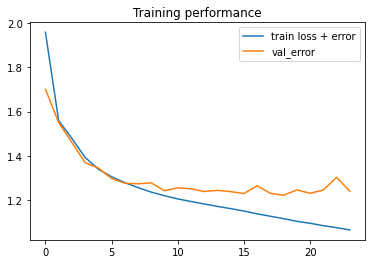

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

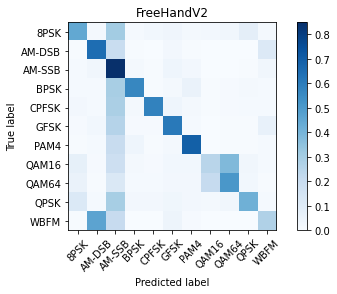

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08469539375928678


Overall Accuracy:  0.09796672828096119


Overall Accuracy:  0.10109579356663131


Overall Accuracy:  0.12227687983134224


Overall Accuracy:  0.15606936416184972


Overall Accuracy:  0.23523093447905477


Overall Accuracy:  0.32640630598351844


Overall Accuracy:  0.45094476744186046


Overall Accuracy:  0.5395811146609869


Overall Accuracy:  0.6603163191948239


Overall Accuracy:  0.7356572258533043


Overall Accuracy:  0.7728092318788315


Overall Accuracy:  0.789753320683112


Overall Accuracy:  0.7955223880597015


Overall Accuracy:  0.8011527377521613


Overall Accuracy:  0.7991250455705432


Overall Accuracy:  0.7941503146982599


Overall Accuracy:  0.7961639714178262


Overall Accuracy:  0.8058216654384672


Overall Accuracy:  0.7888888888888889


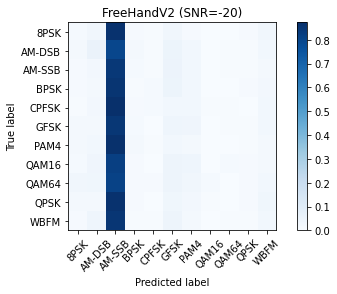

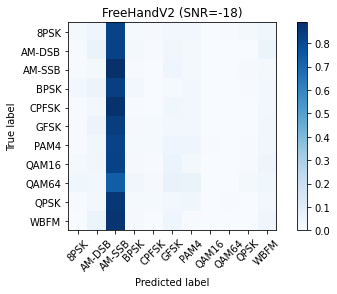

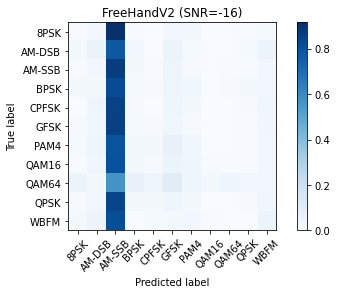

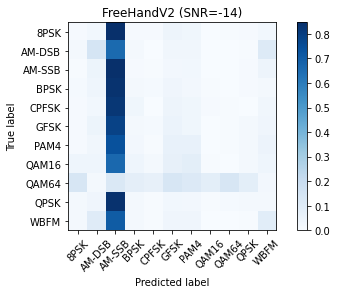

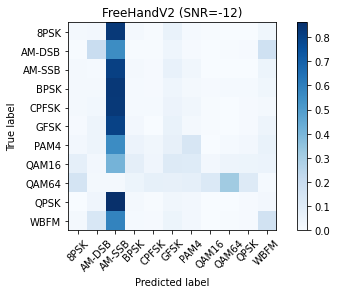

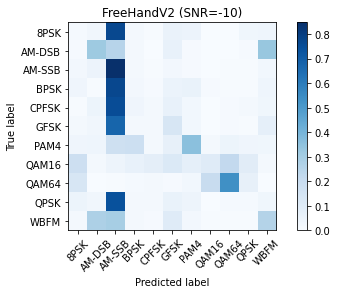

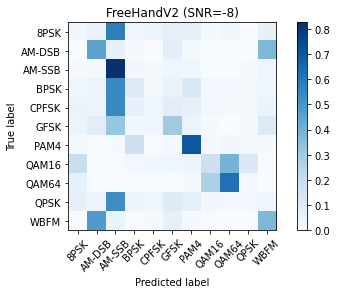

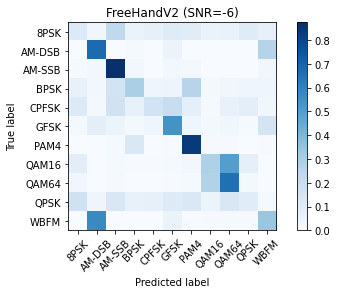

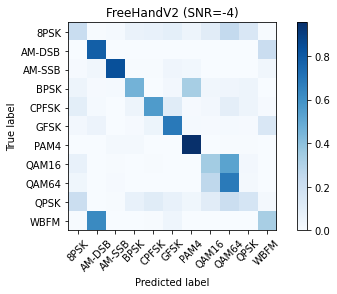

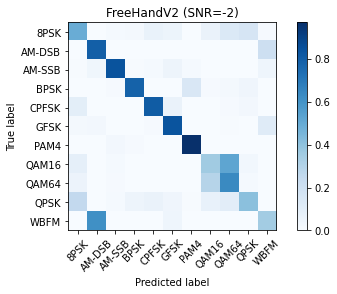

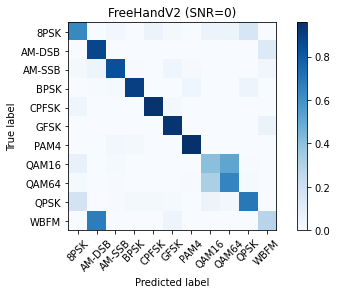

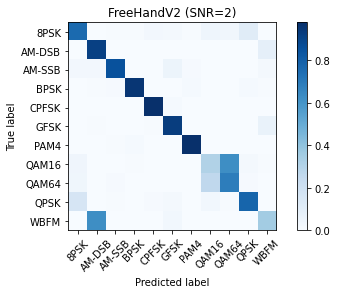

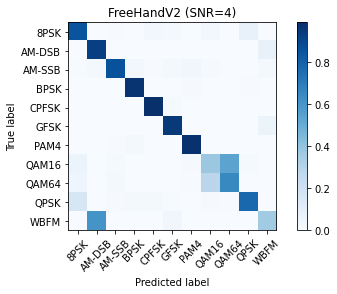

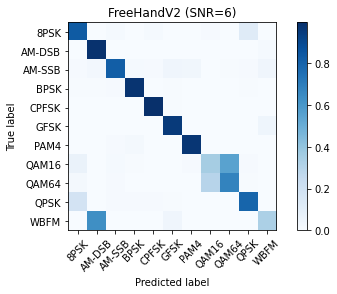

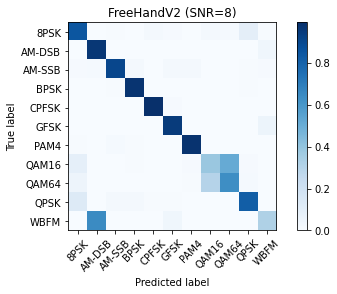

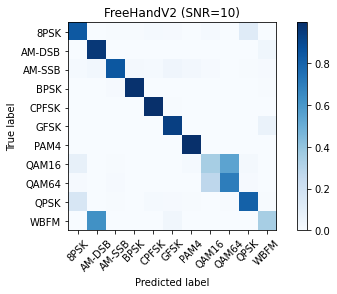

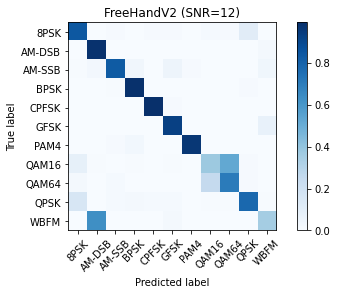

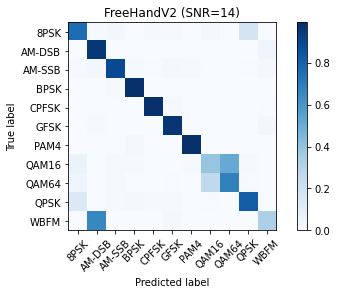

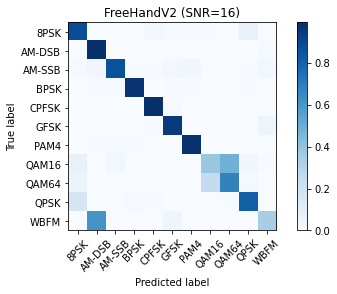

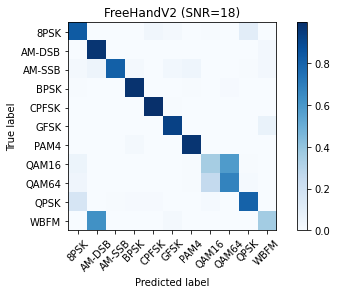

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

-20  -18  -16  -14  -12  -10  -8   -6   -4   -2    0    2    4   \
Accuracy %    8    9   10   12   15   23   32   45   53   66   73   77   78   

             6    8    10   12   14   16   18  
Accuracy %   79   80   79   79   79   80   78

In [18]:
import statistics

statistics.mean(acc.values())

0.5326814195800706

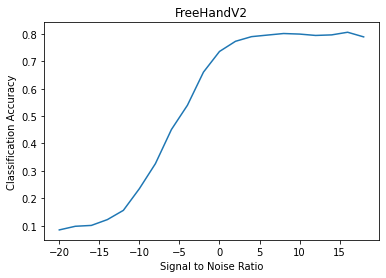

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)